# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/101rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/102rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/103rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/101rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/102rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/103rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.320301        0.203141  0.051135  0.303779  0.020326   
       0.25   0.311473        0.193072  0.054772  0.246578  0.067041   
       0.50   0.314120        0.198045  0.058764  0.213909  0.099044   
       0.75   0.320040        0.184892  0.067969  0.195107  0.117232   
       1.00   0.309820        0.177323  0.073860  0.183451  0.138026   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198403  0.009788  0.040606  0.047477  0.000000  
       0.25  0.204838  0.009945  0.041888  0.052746  0.000585  
       0.50  0.202512  0.009266  0.039450  0.050260  0.001495  
       0.75  0.204221  0.008073  0.039943  0.049643  0.002683  
       1.00  0.202997  0.006926  0.037524  0.052066  0.003651

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.312511        0.204629  0.051322  0.293097  0.020650   
       0.25   0.314888        0.195839  0.053854  0.244376  0.067683   
       0.50   0.323046        0.192817  0.060222  0.216839  0.101575   
       0.75   0.312717        0.184822  0.070540  0.215901  0.118327   
       1.00   0.327020        0.169524  0.077545  0.180826  0.139800   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201656  0.009873  0.039097  0.049837  0.000000  
       0.25  0.205275  0.009474  0.040050  0.048945  0.000576  
       0.50  0.201370  0.008650  0.039672  0.050163  0.001493  
       0.75  0.200746  0.007719  0.039506  0.049847  0.002511  
       1.00  0.207368  0.007107  0.036815  0.048090  0.003817

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.290630        0.198698  0.050480  0.297109  0.019457   
       0.25   0.311846        0.195346  0.055849  0.261368  0.066580   
       0.50   0.321765        0.181648  0.062325  0.228644  0.098892   
       0.75   0.305658        0.184752  0.067194  0.189692  0.122496   
       1.00   0.322996        0.183942  0.078023  0.184791  0.131800   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211636  0.010108  0.040432  0.048775  0.000000  
       0.25  0.193178  0.010158  0.039875  0.050362  0.000595  
       0.50  0.196457  0.009009  0.039486  0.048526  0.001486  
       0.75  0.197981  0.008008  0.038175  0.049040  0.002566  
       1.00  0.204310  0.006974  0.038507  0.048938  0.003513

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25   0.308324        0.193844  0.057480  0.249741  0.068097   
         0.50   0.307475        0.189371  0.066989  0.218441  0.101199   
         0.75   0.292477        0.182893  0.079302  0.199102  0.120845   
         1.00   0.290219        0.174545  0.090094  0.183569  0.138351   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.203898  0.009923  0.040045  0.048697  0.000000  
         0.25  0.201094  0.009863  0.040604  0.050886  0.000386  
         0.50  0.200102  0.008997  0.039535  0.050162  0.000985  
         0.75  0.200949  0.007993  0.039197  0.050384  0.001715  
         1.00  0.204812  0.007129  0.037581  0.050980  0.002437

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.101863e+01  4.015845e+01      37.692821  5.723769e+01   
         0.25  4.486963e+06  2.379775e+06  215170.605512  1.421525e+06   
         0.50  5.600547e+06  3.542830e+06  348031.428814  2.226925e+06   
         0.75  5.898077e+06  4.193526e+06  418539.384158  2.716502e+06   
         1.00  5.950154e+06  4.740187e+06  475611.656791  3.135893e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.791488  5.554329e+01  5.504357e+01      18.708835   
         0.25  472440.652562  2.249389e+06  2.613968e+06  427129.834888   
         0.50  712984.410862  3.752934e+06  3.280235e+06  638585.081830   
         0.75  886163.874252  4.752821e+06  3.593999e+06  761165.327324   
         1.00  991658.939558  5.524615e+06  3.766037e+06  847123.904465   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.550140  
         0.25     186883.918585  
         0.50     278775.287738  
         0.75     351041.917068  
         1.00     403961.615942

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


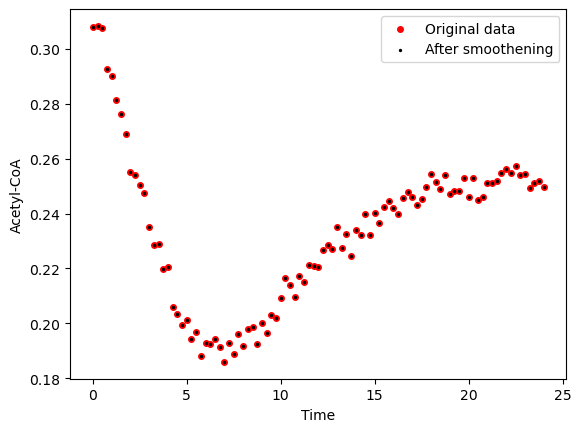

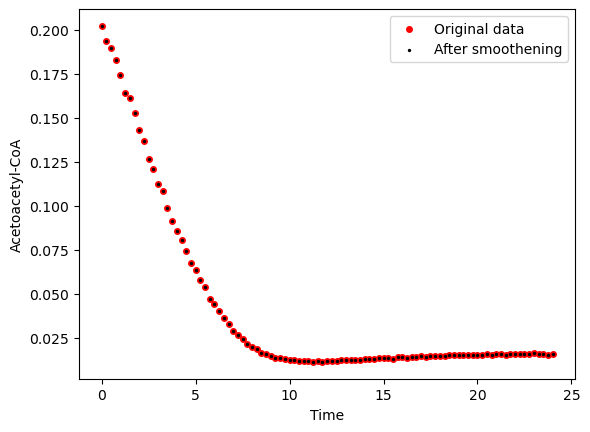

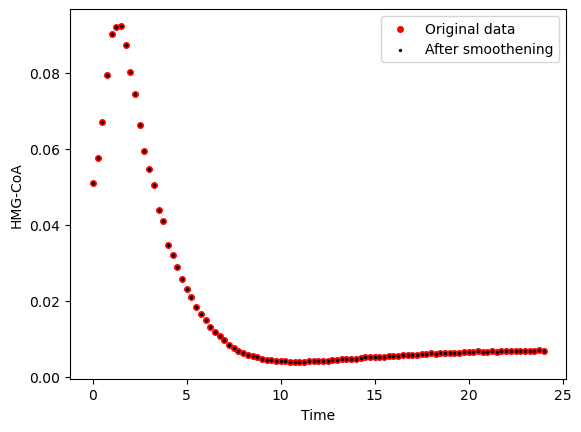

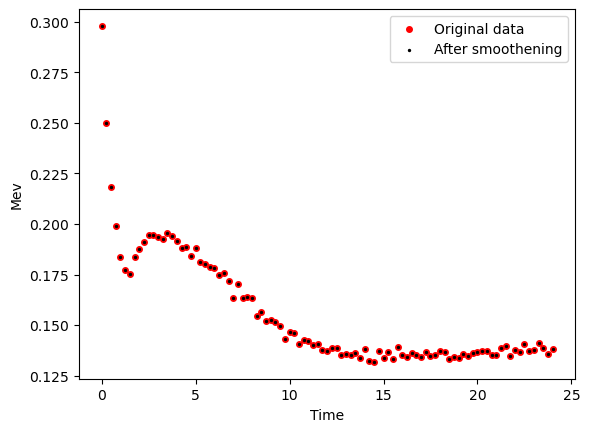

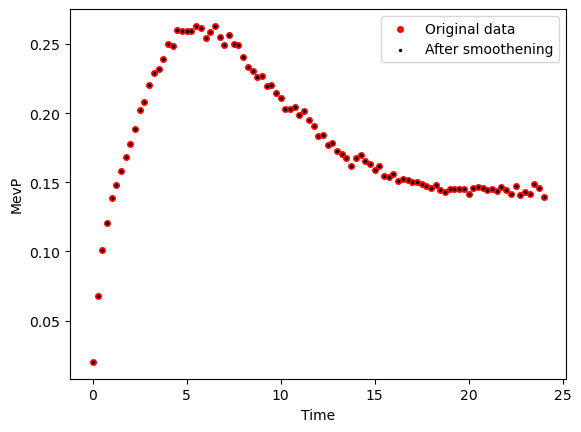

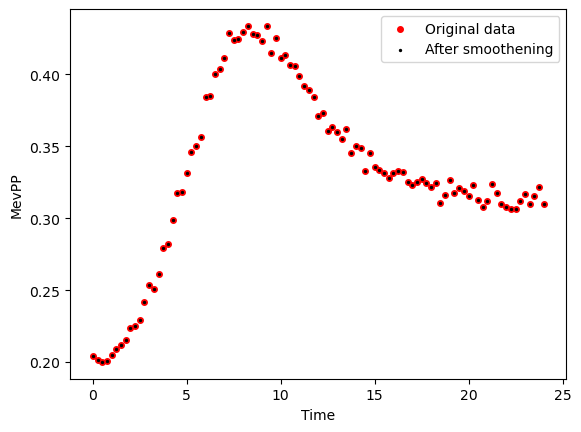

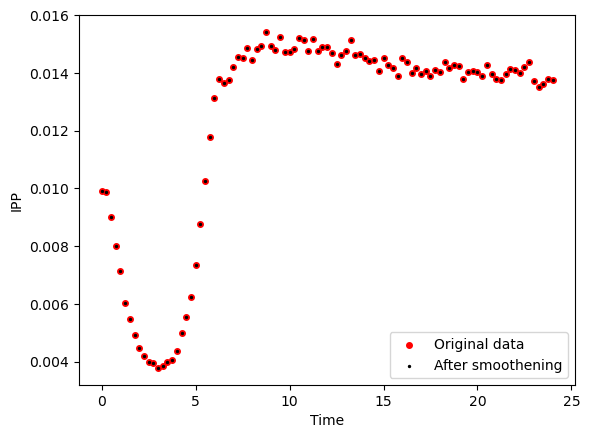

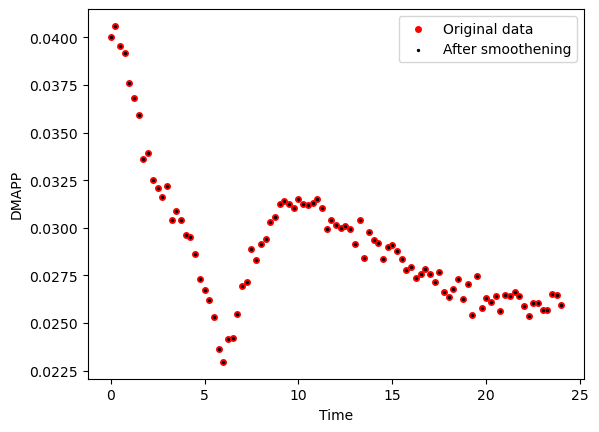

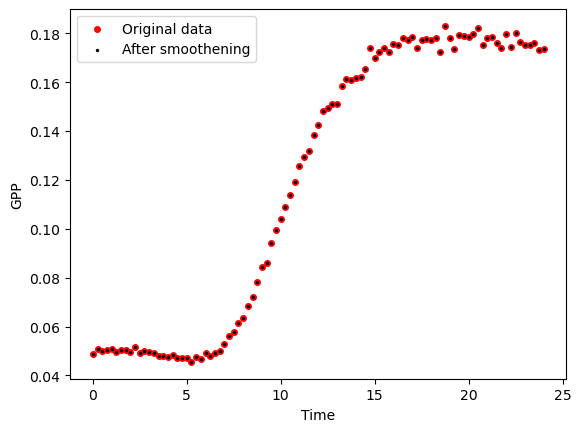

Strain Strain 2


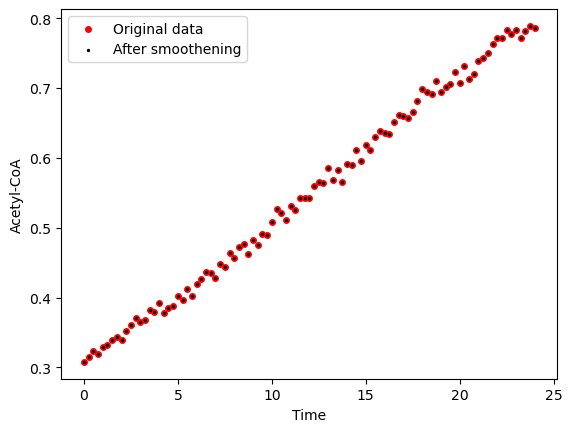

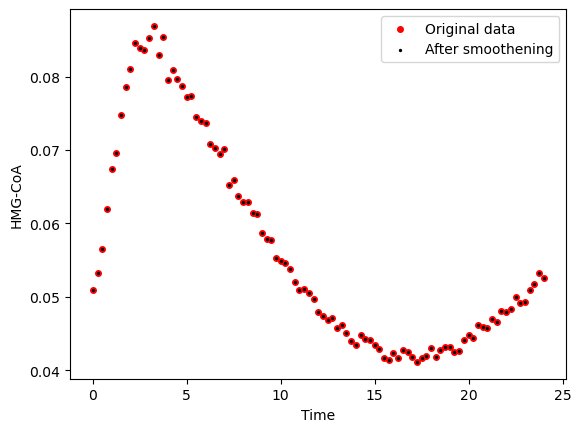

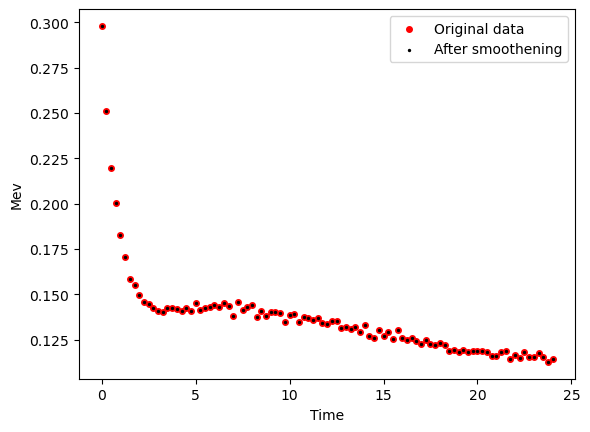

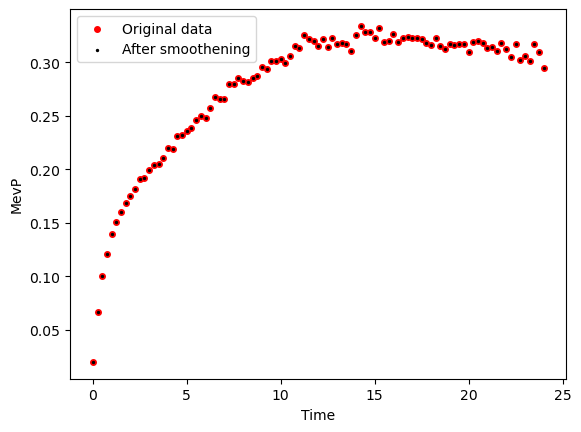

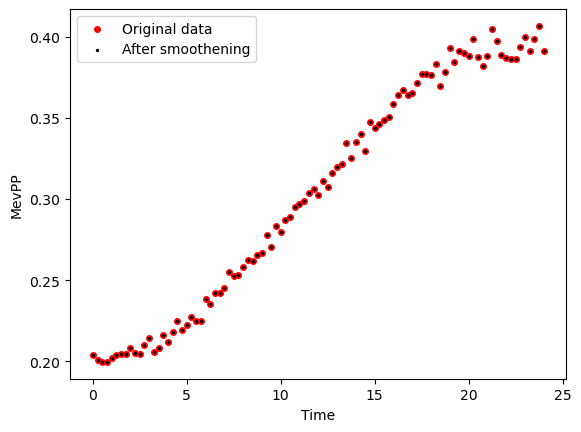

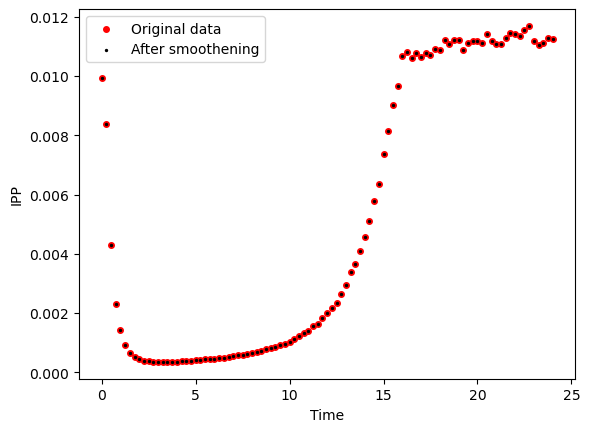

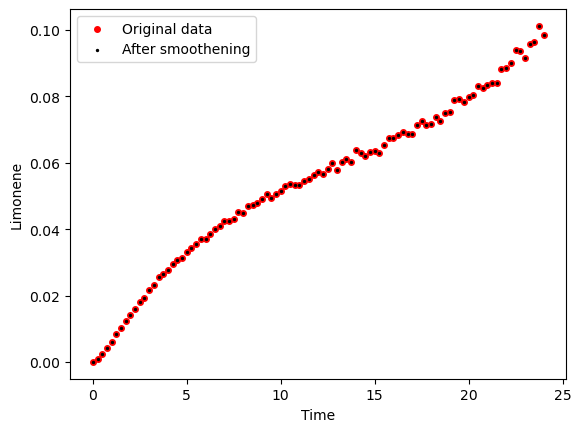

Strain Strain 3


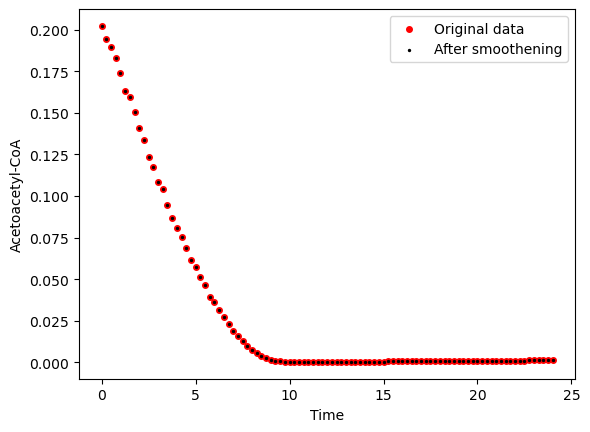

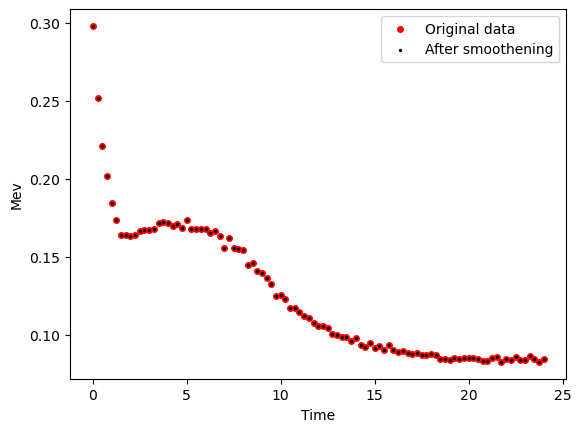

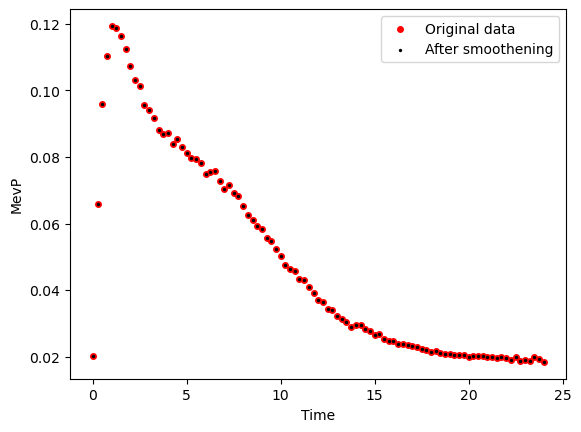

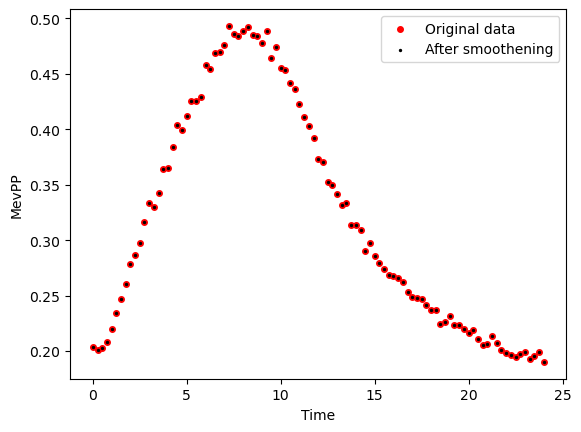

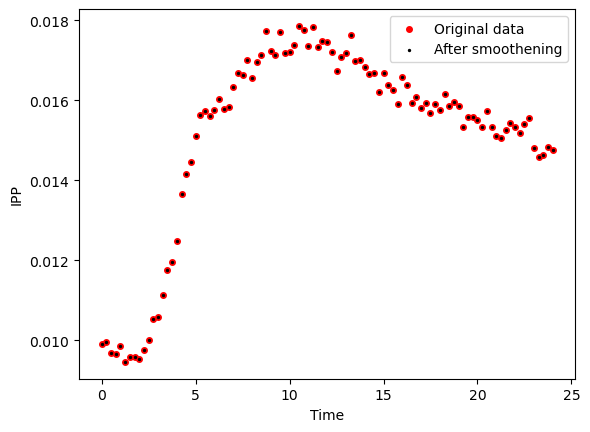

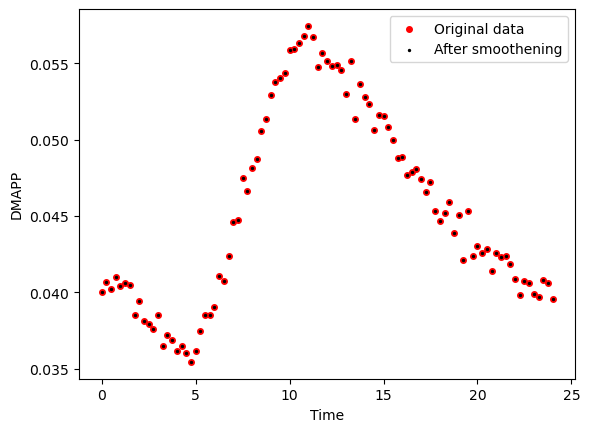

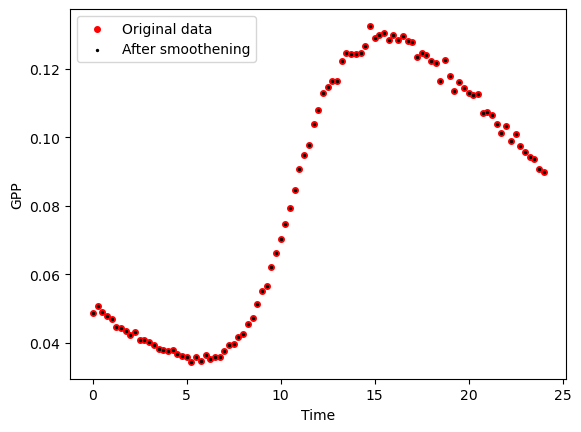

Strain WT


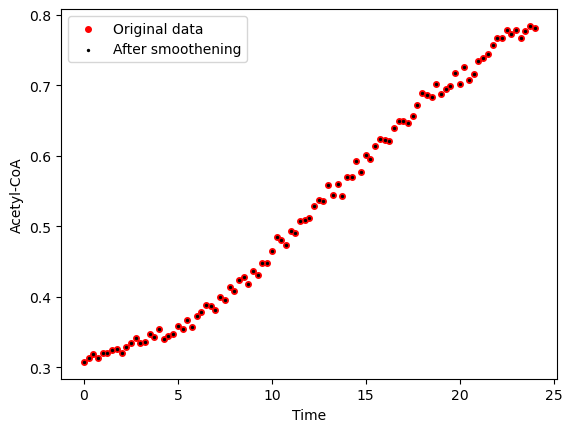

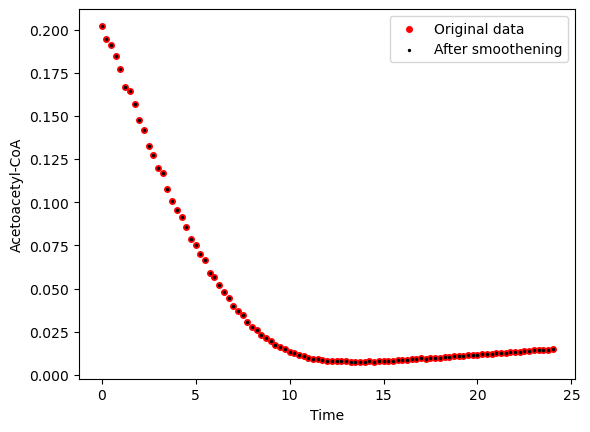

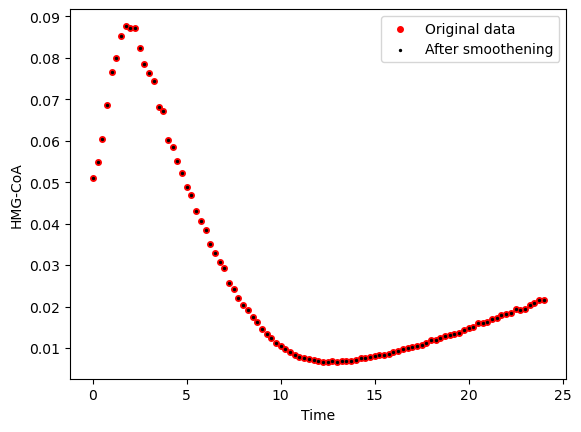

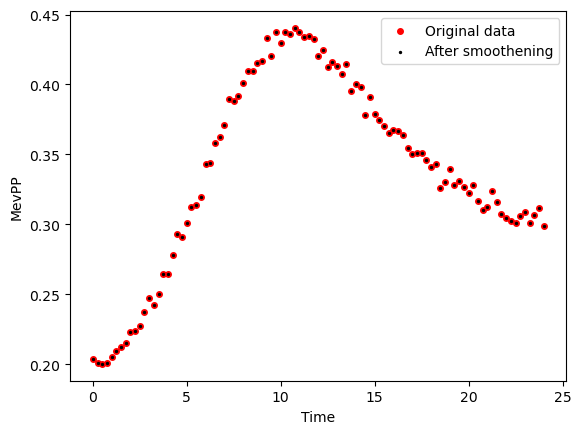

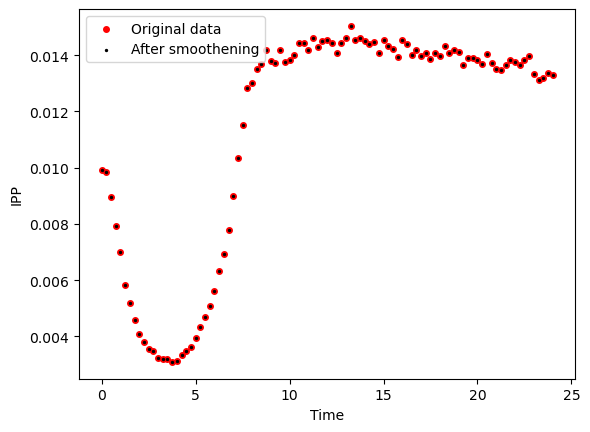

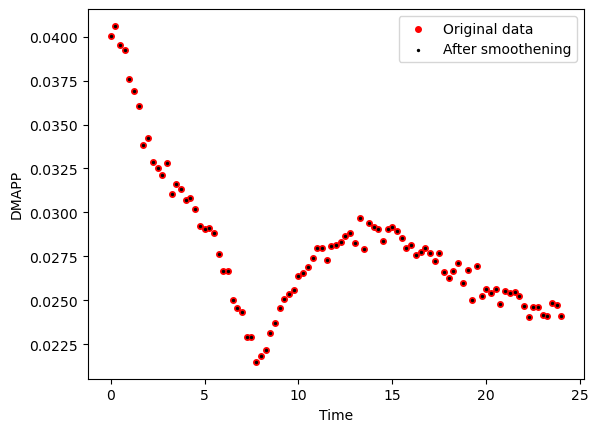

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


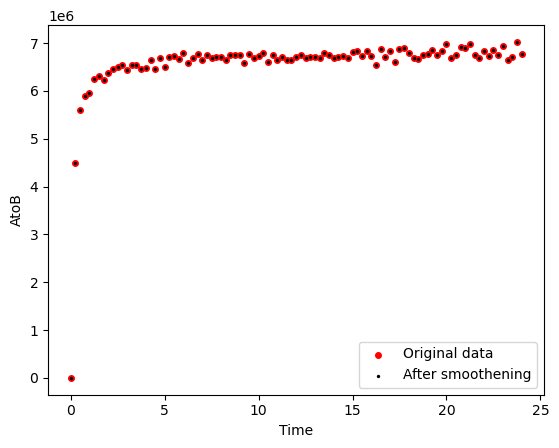

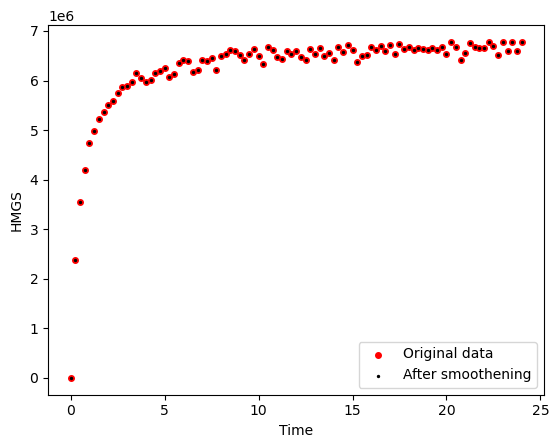

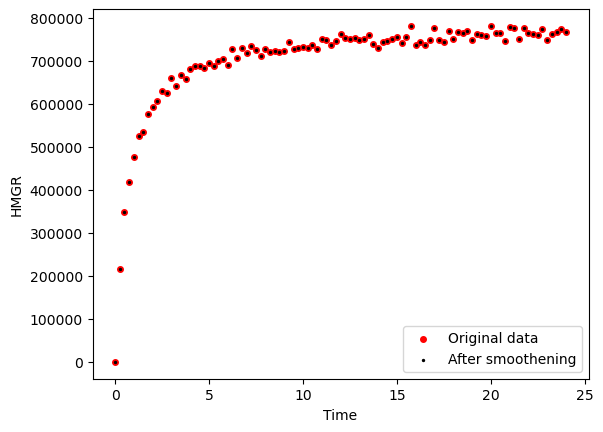

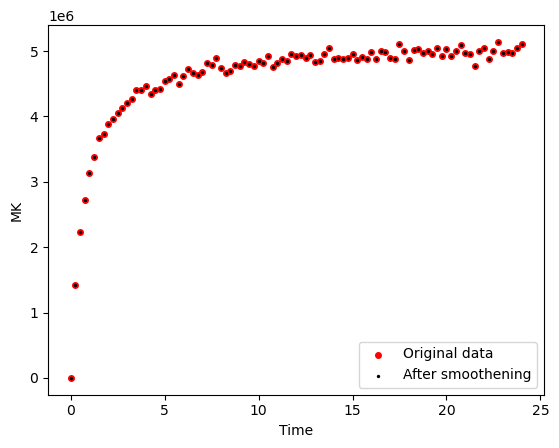

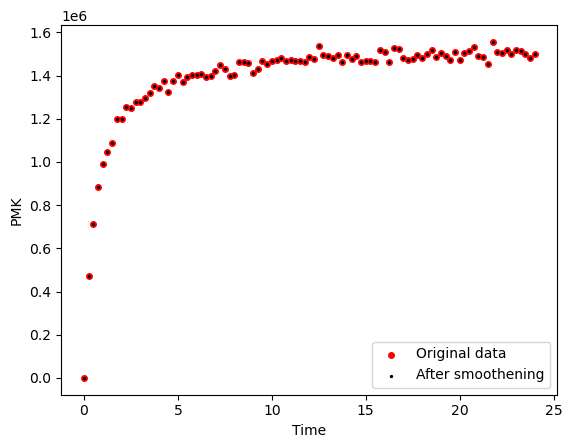

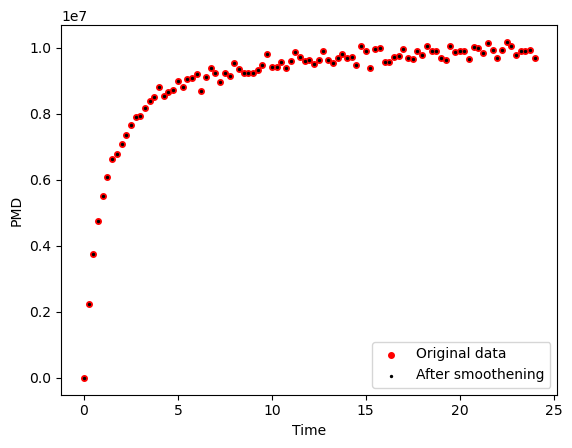

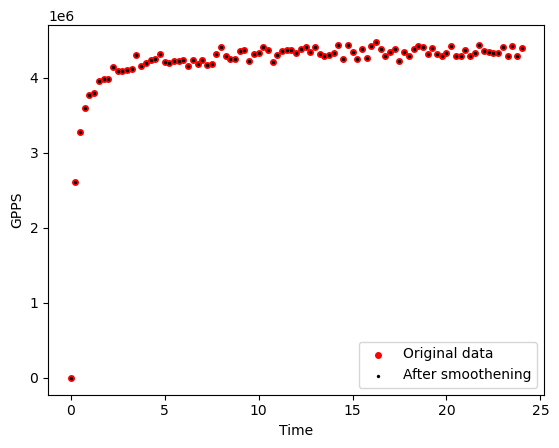

Strain Strain 2


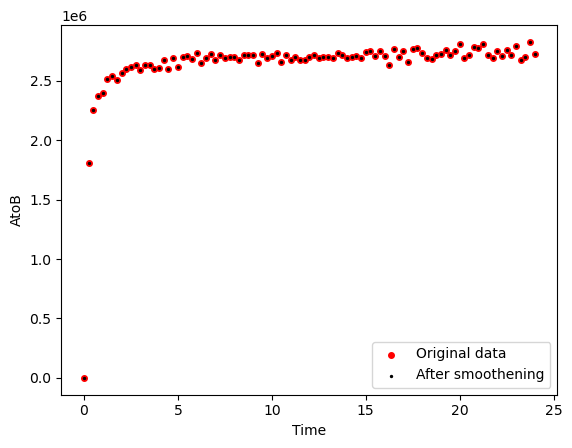

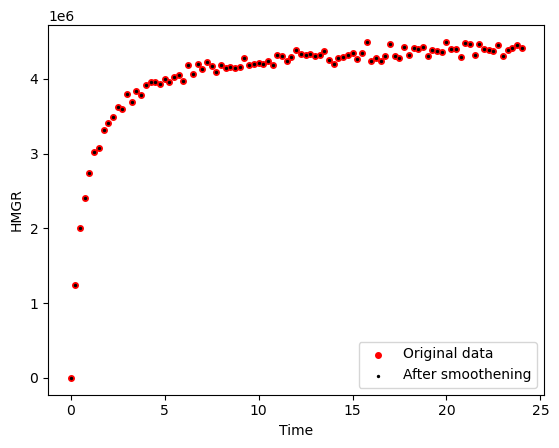

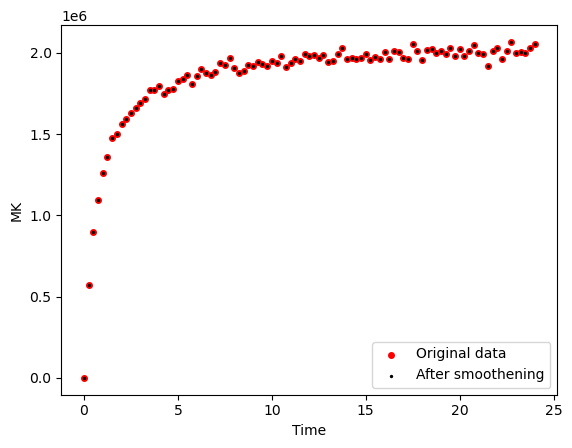

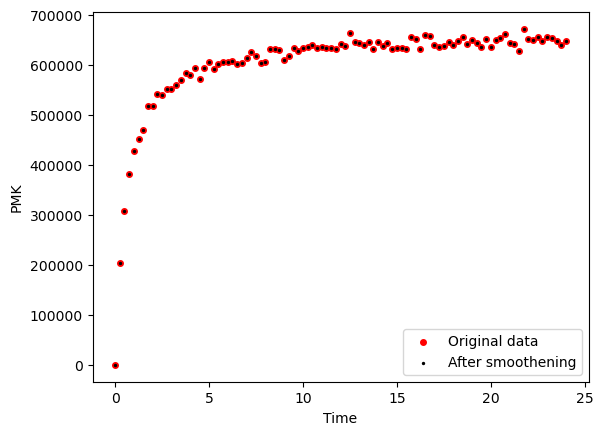

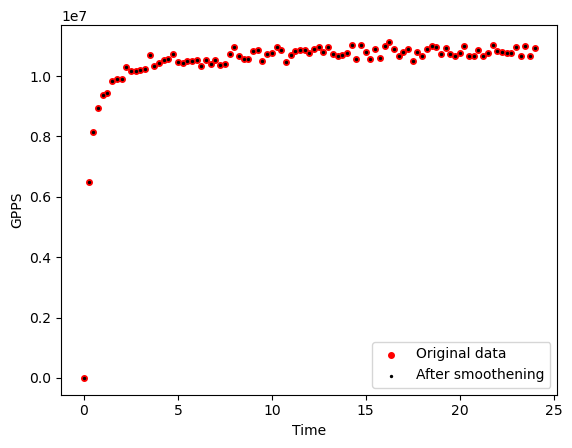

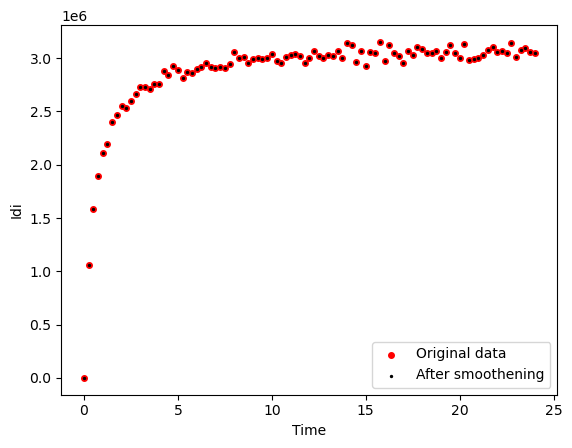

Strain Strain 3


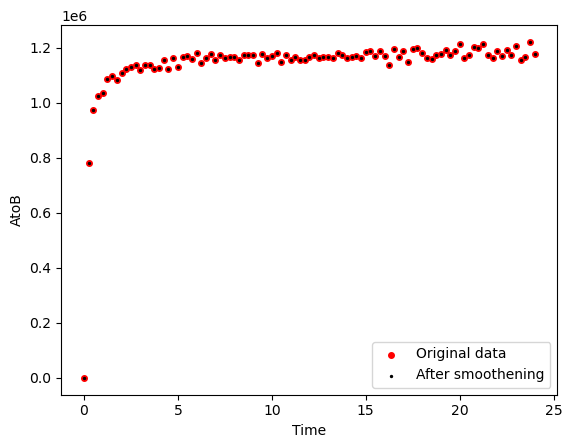

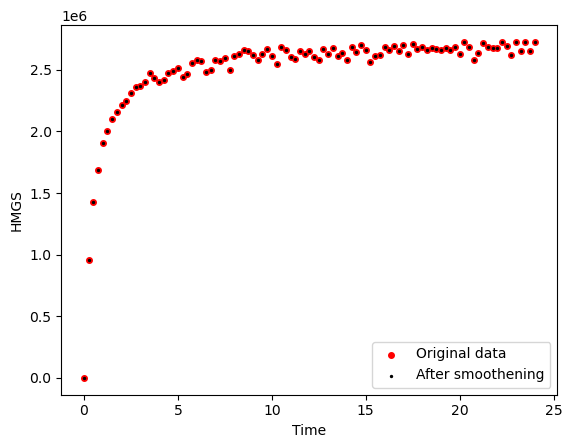

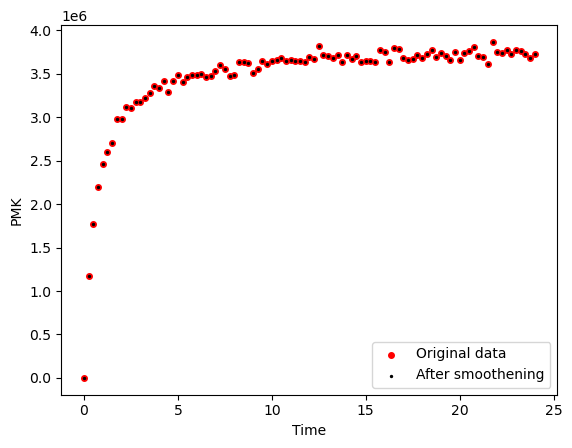

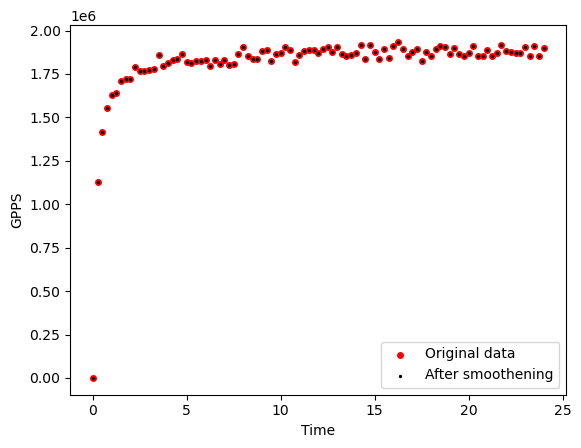

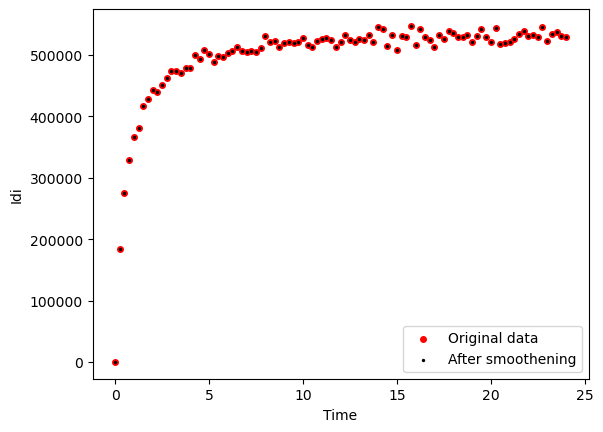

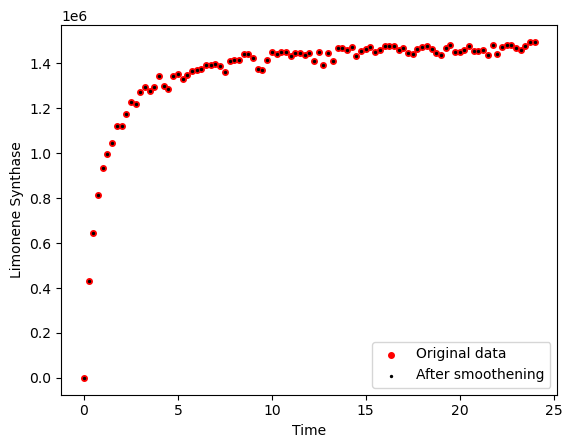

Strain WT


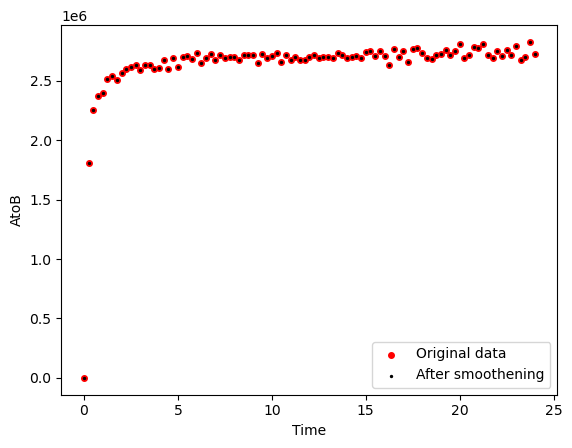

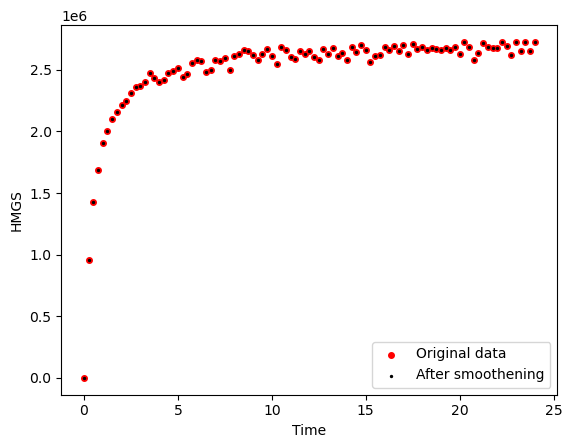

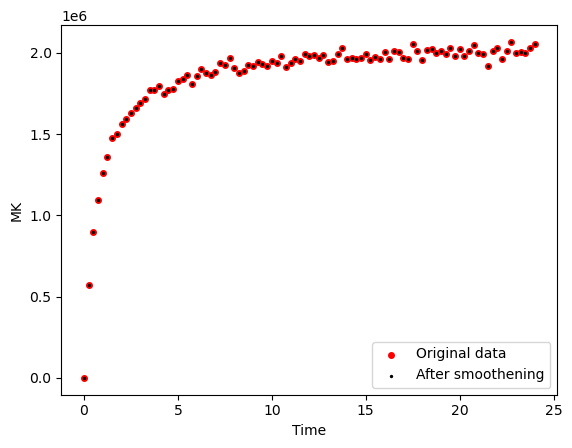

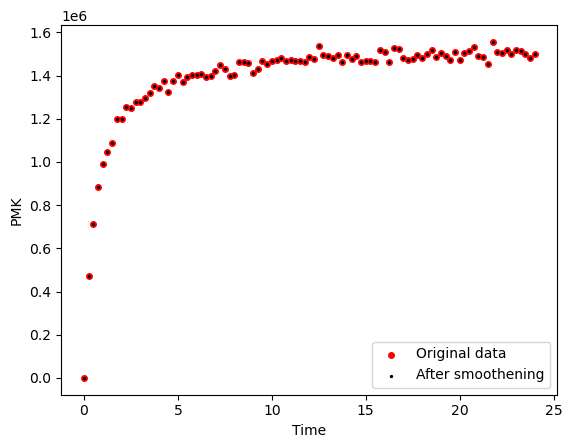

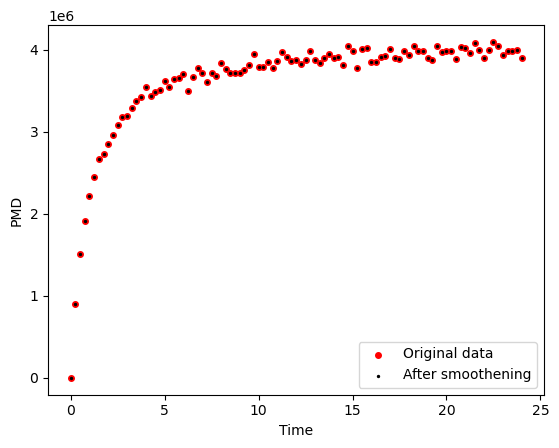

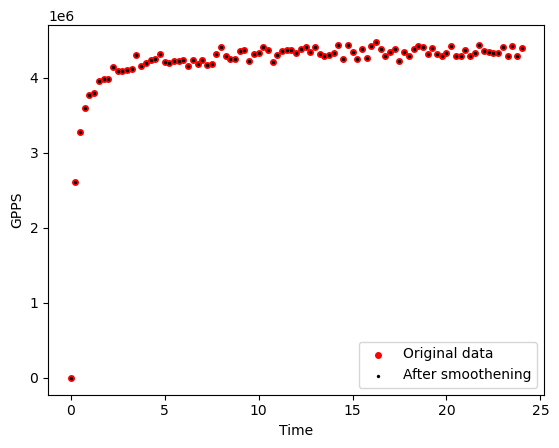

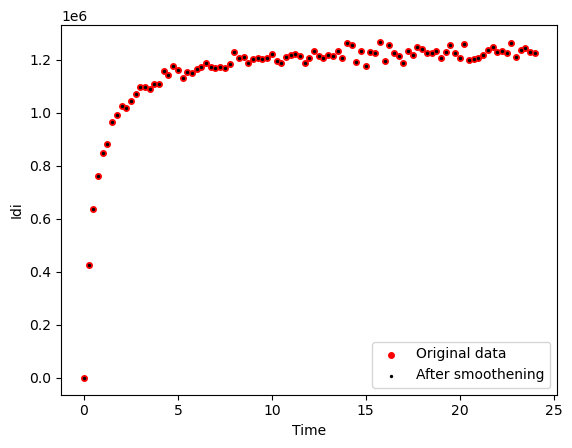

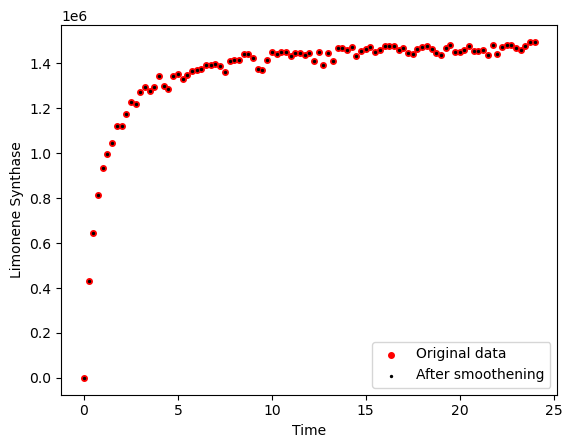

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25    0.308324        0.193844  0.057480  0.249741  0.068097   
         0.50    0.307475        0.189371  0.066989  0.218441  0.101199   
         0.75    0.292477        0.182893  0.079302  0.199102  0.120845   
         1.00    0.290219        0.174545  0.090094  0.183569  0.138351   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.778826        0.014594  0.019505  0.112273  0.100710   
         23.25   0.767586        0.014177  0.020356  0.115130  0.099223   
         23.50   0.777198        0.014545  0.020860  0.113133  0.104319   
         23.75   0.784114        0.014220  0.021703  0.110885  0.101989   
         24.00   0.781234        0.014781  0.021584  0.112914  0.097047   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.203898  0.009923  0.040045  0.048697  0.000000  ...   
         0.25   0.201094  0.009863  0.040604  0.050886  0.000386  ...   
         0.50   0.200102  0.008997  0.039535  0.050162  0.000985  ...   
         0.75   0.200949  0.007993  0.039197  0.050384  0.001715  ...   
         1.00   0.204812  0.007129  0.037581  0.050980  0.002437  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.308910  0.013322  0.024192  0.101325  0.181973  ...   
         23.25  0.301243  0.013127  0.024103  0.100596  0.190535  ...   
         23.50  0.306368  0.013182  0.024829  0.100602  0.191844  ...   
         23.75  0.311549  0.013355  0.024718  0.098291  0.201864  ...   
         24.00  0.299055  0.013308  0.024143  0.098021  0.196378  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.002084       -0.024095  0.027010 -0.200259  0.200635   
         0.25    -0.009166       -0.025282  0.033515 -0.156027  0.158150   
         0.50    -0.020415       -0.026469  0.040020 -0.111796  0.115665   
         0.75    -0.028478       -0.029640  0.036937 -0.071782  0.078804   
         1.00    -0.029534       -0.030077  0.025393 -0.043366  0.056300   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003357        0.000805  0.001620  0.000121 -0.000262   
         23.25    0.008122        0.000231  0.002489 -0.000470  0.003395   
         23.50    0.008537        0.000166  0.002201 -0.001185 -0.001824   
         23.75    0.016551        0.000887  0.001287 -0.002274 -0.010016   
         24.00    0.024565        0.001608  0.000372 -0.003363 -0.018208   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.016668 -0.000988  0.001602  0.004187  0.001564  
         0.25  -0.007998 -0.001985 -0.000466  0.002906  0.002023  
         0.50   0.000672 -0.002983 -0.002534  0.001626  0.002481  
         0.75   0.008258 -0.003811 -0.003816 -0.000774  0.002952  
         1.00   0.012830 -0.003613 -0.003856 -0.000146  0.003169  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002384 -0.000858 -0.000060 -0.004419  0.006802  
         23.25  0.003731 -0.000550  0.000344 -0.003676  0.016931  
         23.50 -0.003761  0.000081  0.000207 -0.003565  0.016055  
         23.75 -0.009246  0.000317 -0.000826 -0.004365  0.004978  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

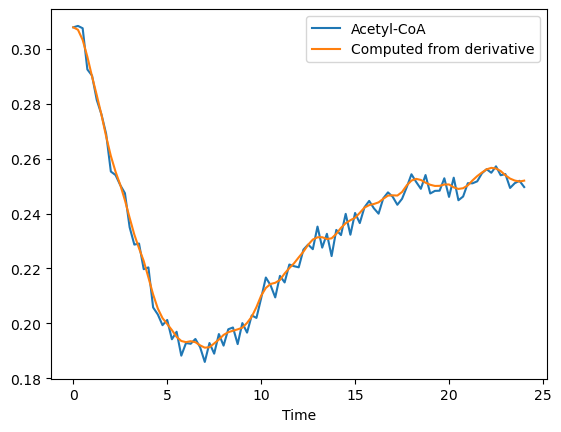

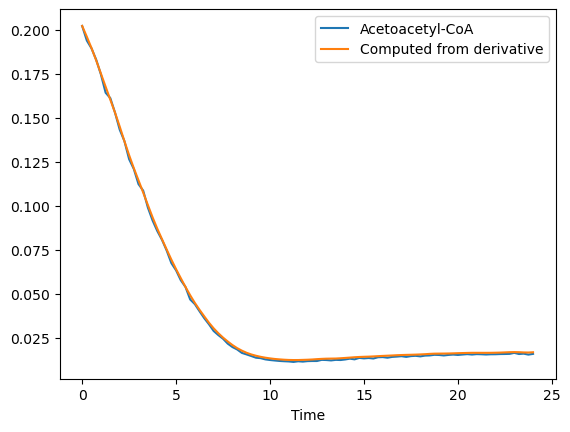

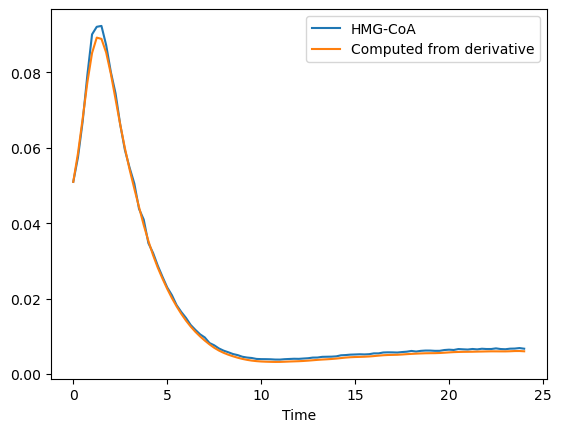

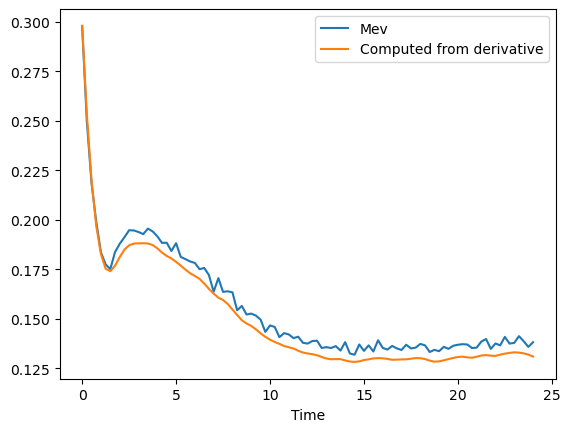

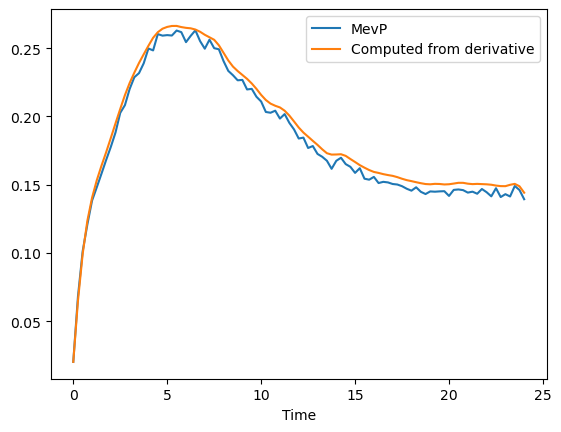

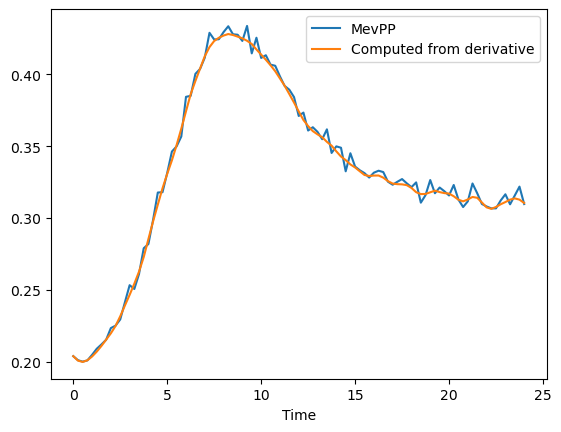

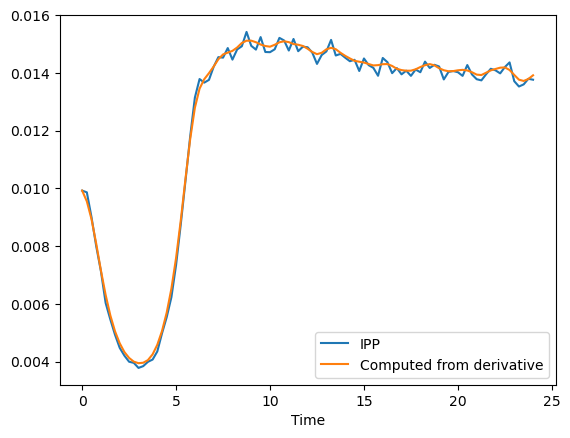

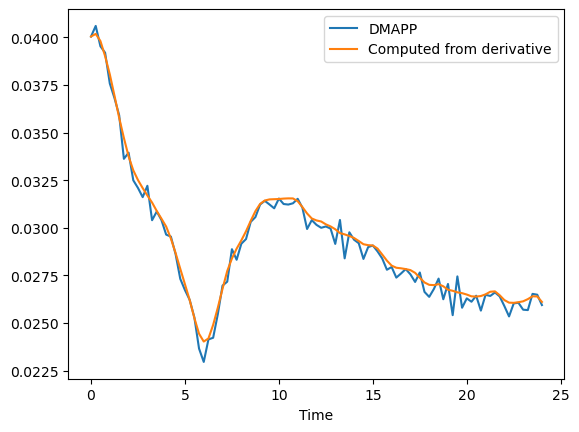

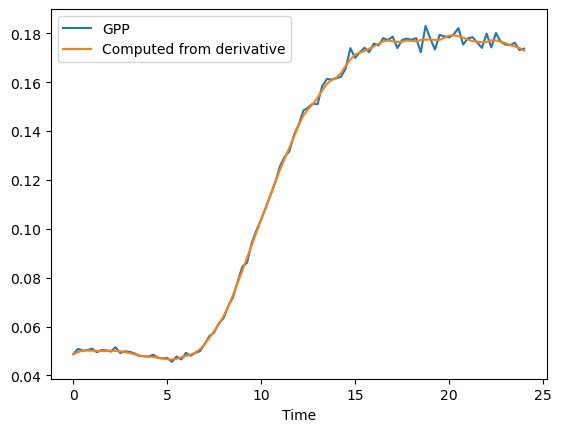

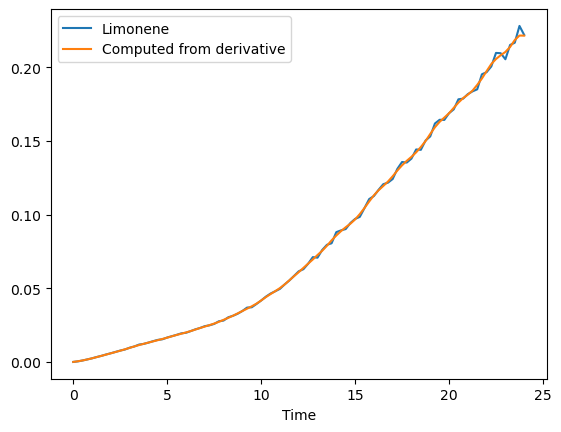

'Time profile from derivative vs. actual profile for Strain 2'

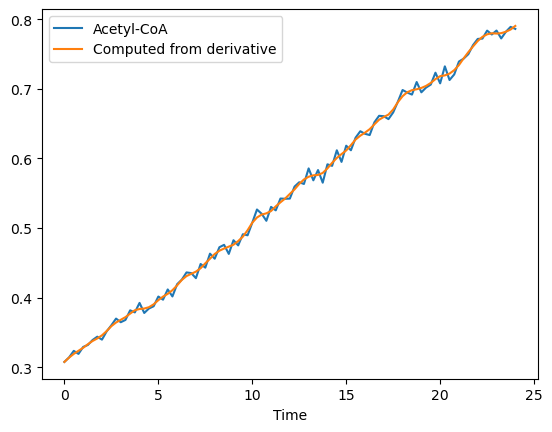

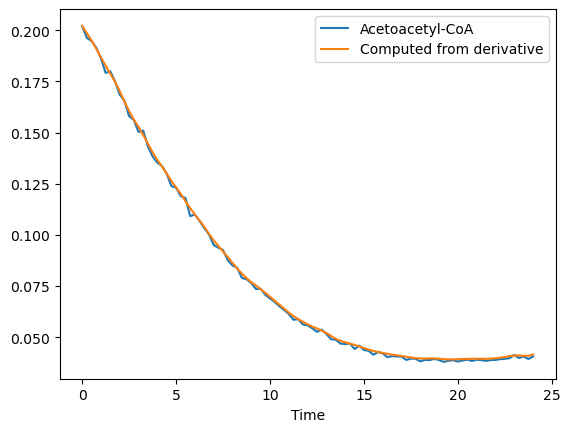

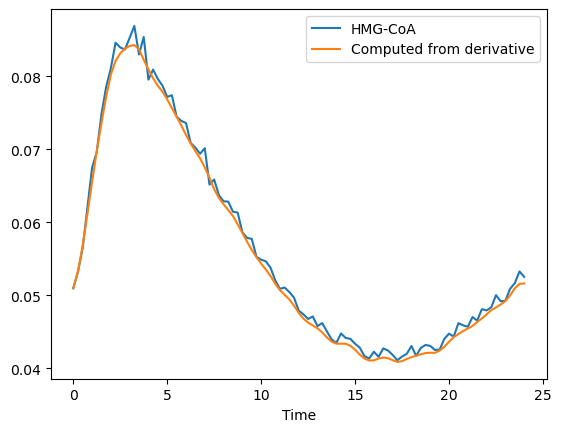

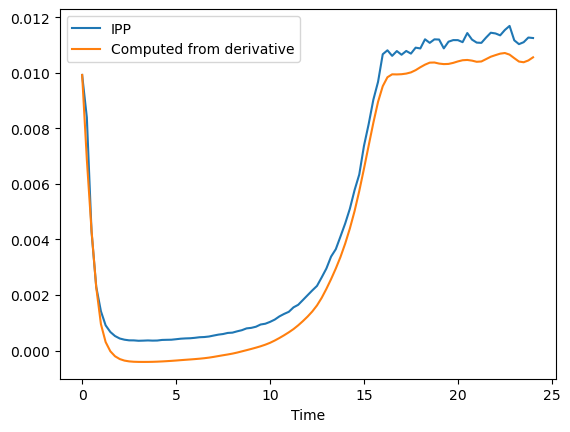

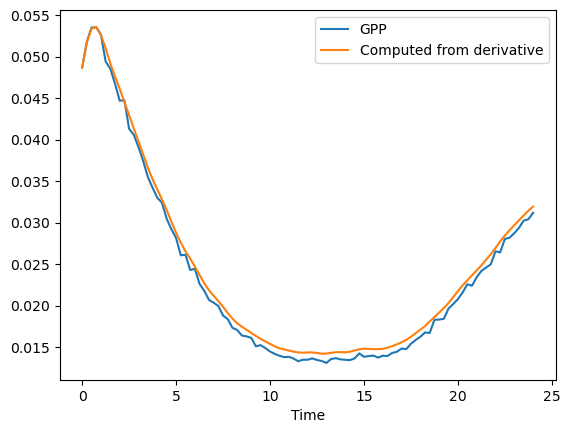

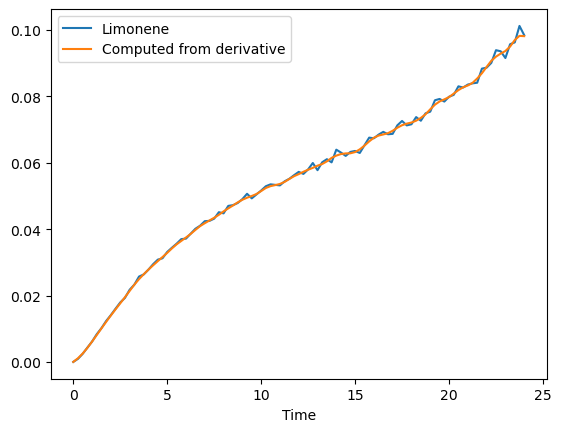

'Time profile from derivative vs. actual profile for Strain 3'

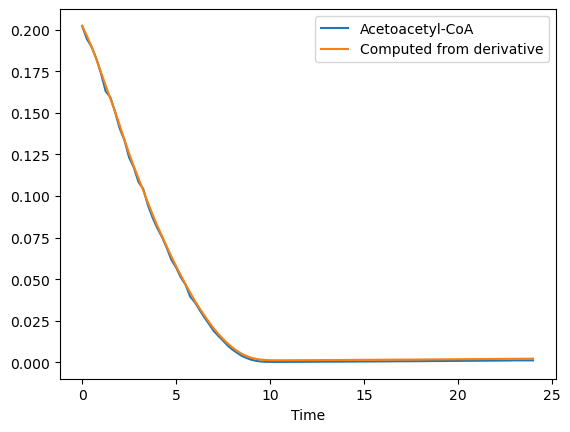

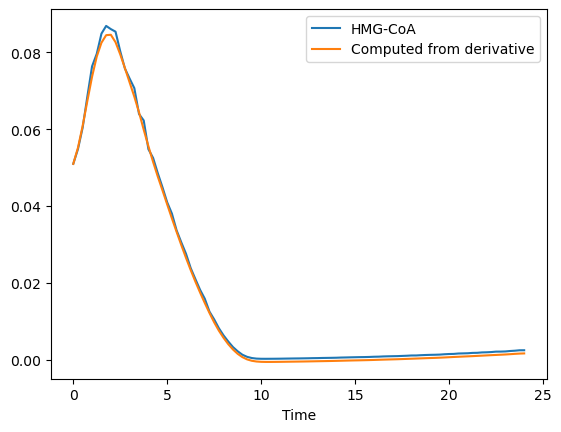

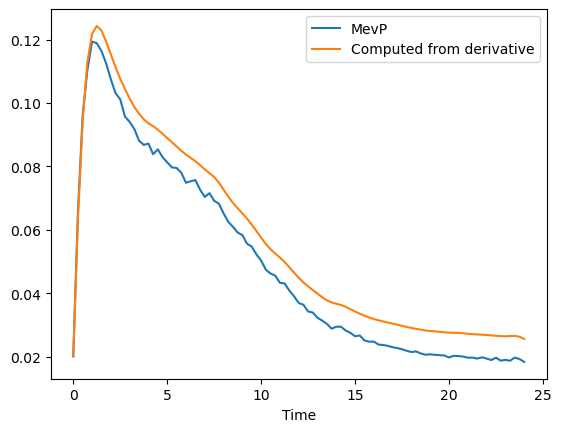

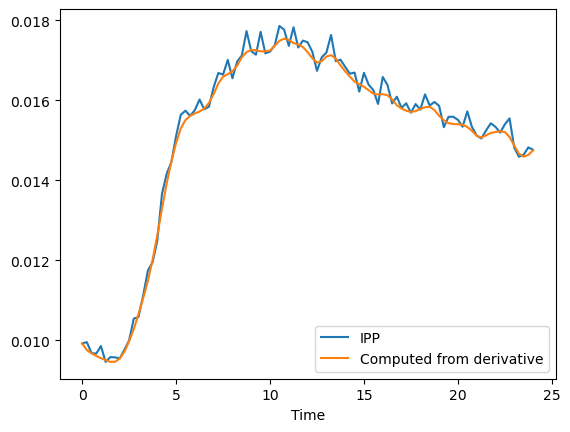

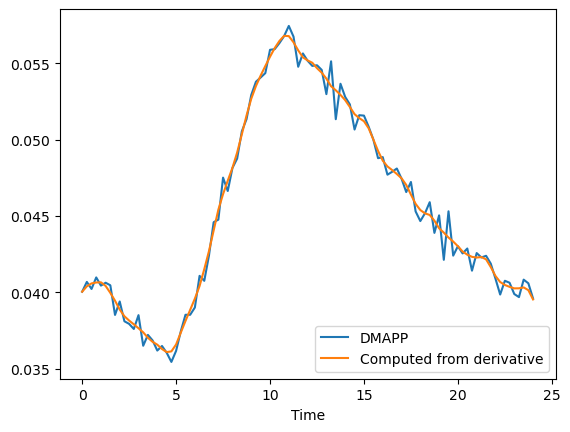

'Time profile from derivative vs. actual profile for WT'

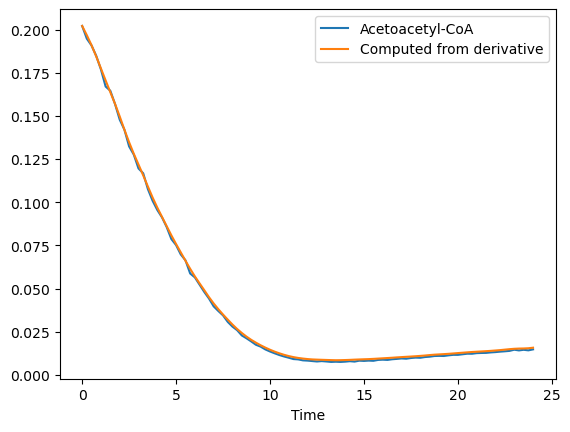

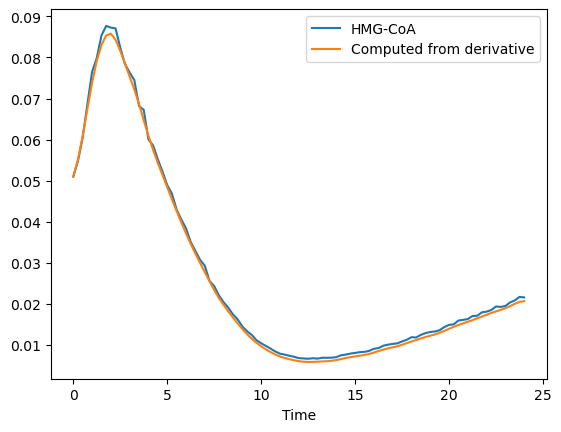

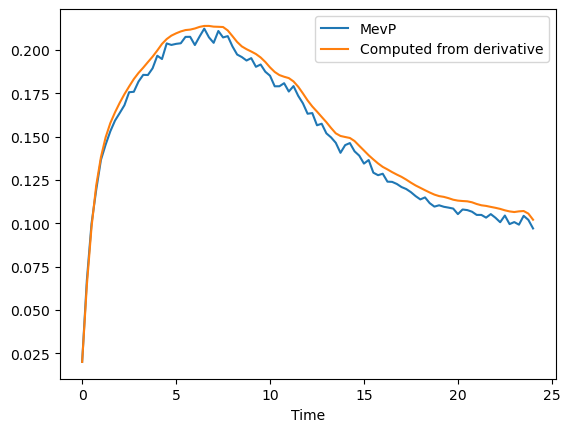

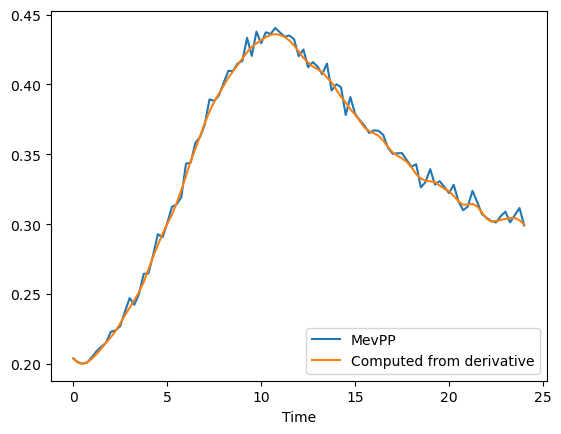

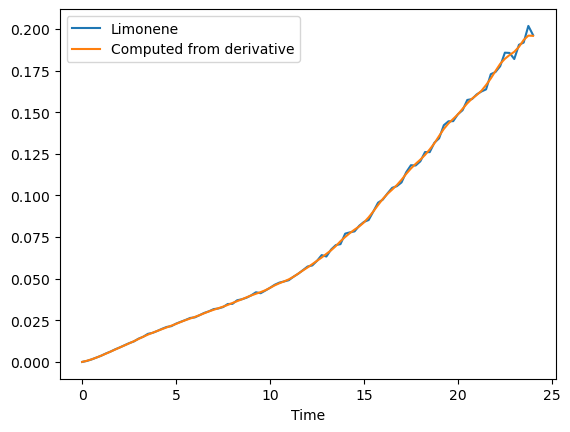

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.101863e+01  4.015845e+01  3.769282e+01  5.723769e+01   
         0.25   4.486963e+06  2.379775e+06  2.151706e+05  1.421525e+06   
         0.50   5.600547e+06  3.542830e+06  3.480314e+05  2.226925e+06   
         0.75   5.898077e+06  4.193526e+06  4.185394e+05  2.716502e+06   
         1.00   5.950154e+06  4.740187e+06  4.756117e+05  3.135893e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793985e+06  2.726634e+06  1.732866e+06  1.999582e+06   
         23.25  2.674277e+06  2.652135e+06  1.764617e+06  2.006932e+06   
         23.50  2.699014e+06  2.722133e+06  1.774984e+06  2.001659e+06   
         23.75  2.825522e+06  2.650638e+06  1.791724e+06  2.026817e+06   
         24.00  2.720292e+06  2.726081e+06  1.773775e+06  2.054542e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.679149e+01  5.554329e+01  5.504357e+01  1.870883e+01   
         0.25   4.724407e+05  2.249389e+06  2.613968e+06  4.271298e+05   
         0.50   7.129844e+05  3.752934e+06  3.280235e+06  6.385851e+05   
         0.75   8.861639e+05  4.752821e+06  3.593999e+06  7.611653e+05   
         1.00   9.916589e+05  5.524615e+06  3.766037e+06  8.471239e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.519758e+06  3.933723e+06  4.405661e+06  1.211293e+06   
         23.25  1.512951e+06  3.982947e+06  4.295628e+06  1.235920e+06   
         23.50  1.498116e+06  3.988023e+06  4.423044e+06  1.246005e+06   
         23.75  1.482534e+06  3.991343e+06  4.296578e+06  1.228846e+06   
         24.00  1.498900e+06  3.898759e+06  4.397311e+06  1.226257e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.955014e+01   0.307814        0.202156  0.050979   
         0.25       1.868839e+05   0.308324        0.193844  0.057480   
         0.50       2.787753e+05   0.307475        0.189371  0.066989   
         0.75       3.510419e+05   0.292477        0.182893  0.079302   
         1.00       4.039616e+05   0.290219        0.174545  0.090094   
...                          ...        ...             ...       ...   
WT       23.00      1.467980e+06   0.778826        0.014594  0.019505   
         23.25      1.460229e+06   0.767586        0.014177  0.020356   
         23.50      1.477857e+06   0.777198        0.014545  0.020860   
         23.75      1.494116e+06   0.784114        0.014220  0.021703   
         24.00      1.493358e+06   0.781234        0.014781  0.021584   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297995  0.020144  0.203898  0.009923  0.040045  0.048697   
         0.25   0.249741  0.068097  0.201094  0.009863  0.040604  0.050886   
         0.50   0.218441  0.101199  0.200102  0.008997  0.039535  0.050162   
         0.75   0.199102  0.120845  0.200949  0.007993  0.039197  0.050384   
         1.00   0.183569  0.138351  0.204812  0.007129  0.037581  0.050980   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112273  0.100710  0.308910  0.013322  0.024192  0.101325   
         23.25  0.115130  0.099223  0.301243  0.013127  0.024103  0.100596   
         23.50  0.113133  0.104319  0.306368  0.013182  0.024829 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.002084       -0.024095  0.027010 -0.200259  0.200635   
         0.25    -0.009166       -0.025282  0.033515 -0.156027  0.158150   
         0.50    -0.020415       -0.026469  0.040020 -0.111796  0.115665   
         0.75    -0.028478       -0.029640  0.036937 -0.071782  0.078804   
         1.00    -0.029534       -0.030077  0.025393 -0.043366  0.056300   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003357        0.000805  0.001620  0.000121 -0.000262   
         23.25    0.008122        0.000231  0.002489 -0.000470  0.003395   
         23.50    0.008537        0.000166  0.002201 -0.001185 -0.001824   
         23.75    0.016551        0.000887  0.001287 -0.002274 -0.010016   
         24.00    0.024565        0.001608  0.000372 -0.003363 -0.018208   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.016668 -0.000988  0.001602  0.004187  0.001564  
         0.25  -0.007998 -0.001985 -0.000466  0.002906  0.002023  
         0.50   0.000672 -0.002983 -0.002534  0.001626  0.002481  
         0.75   0.008258 -0.003811 -0.003816 -0.000774  0.002952  
         1.00   0.012830 -0.003613 -0.003856 -0.000146  0.003169  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002384 -0.000858 -0.000060 -0.004419  0.006802  
         23.25  0.003731 -0.000550  0.000344 -0.003676  0.016931  
         23.50 -0.003761  0.000081  0.000207 -0.003565  0.016055  
         23.75 -0.009246  0.000317 -0.000826 -0.004365  0.004978  
         24.00 -0.014730  0.000554 -0.001859 -0.005164 -0.006099  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 3.784167E+205 |  3.688931E+82
     2 |      128 | 3.784167E+205 |  4.897070E+34
     3 |      192 | 3.784167E+205 |  1.005196E+20
     4 |      256 | 6.225629E+139 |  1.991320E+12
     5 |      320 |  1.025478E+79 |  1.292485E+10
     6 |      384 |  1.025478E+79 |  5.171404E+09
     7 |      448 |  1.538276E+19 |  1.191295E+09
     8 |      512 |  5.061850E+10 |  1.002487E+07
     9 |      576 |  4.921772E+10 |  7.341397E+05
    10 |      640 |  4.867389E+10 |  5.330247E+04
    11 |      704 |  4.857532E+10 |  1.038444E+04
    12 |      768 |  2.982106E+08 |  2.610691E+02
    13 |      832 |  1.792378E+05 |  3.977932E+01
    14 |      896 |  2.095685E+04 |  2.966224E+01
    15 |      960 |  2.070162E+04 |  2.562131E+01
    16 |     1024 |  8.376099E+01 |  2.395297E+01
    17 |     1088 |  6.881532E+01 |  2.388323E+01
    18 |     1152 |  2.422649E+01 |  2.386712E+01
    19 |     1216 |  2.40

   162 |    10368 |  1.756197E+01 |  1.756048E+01
   163 |    10432 |  1.756051E+01 |  1.755958E+01
   164 |    10496 |  1.755966E+01 |  1.755858E+01
   165 |    10560 |  1.755873E+01 |  1.755725E+01
   166 |    10624 |  1.755751E+01 |  1.755624E+01
   167 |    10688 |  1.755636E+01 |  1.755494E+01
   168 |    10752 |  1.755529E+01 |  1.755441E+01
   169 |    10816 |  1.755457E+01 |  1.755368E+01
   170 |    10880 |  1.755378E+01 |  1.755267E+01
   171 |    10944 |  1.755263E+01 |  1.755165E+01
   172 |    11008 |  1.755180E+01 |  1.755110E+01
   173 |    11072 |  1.755112E+01 |  1.755055E+01
   174 |    11136 |  1.755074E+01 |  1.755033E+01
   175 |    11200 |  1.755000E+01 |  1.754910E+01
   176 |    11264 |  1.754930E+01 |  1.754851E+01
   177 |    11328 |  1.754822E+01 |  1.754595E+01
   178 |    11392 |  1.754623E+01 |  1.754373E+01
   179 |    11456 |  1.754445E+01 |  1.754276E+01
   180 |    11520 |  1.754292E+01 |  1.754114E+01
   181 |    11584 |  1.754115E+01 |  1.753973E+01


   326 |    20864 |  1.717228E+01 |  1.717020E+01
   327 |    20928 |  1.717079E+01 |  1.716927E+01
   328 |    20992 |  1.716933E+01 |  1.716762E+01
   329 |    21056 |  1.716799E+01 |  1.716655E+01
   330 |    21120 |  1.716657E+01 |  1.716464E+01
   331 |    21184 |  1.716485E+01 |  1.716284E+01
   332 |    21248 |  1.716320E+01 |  1.716054E+01
   333 |    21312 |  1.716107E+01 |  1.715865E+01
   334 |    21376 |  1.715896E+01 |  1.715666E+01
   335 |    21440 |  1.715703E+01 |  1.715508E+01
   336 |    21504 |  1.715521E+01 |  1.715367E+01
   337 |    21568 |  1.715401E+01 |  1.715266E+01
   338 |    21632 |  1.715258E+01 |  1.715116E+01
   339 |    21696 |  1.715147E+01 |  1.714984E+01
   340 |    21760 |  1.715060E+01 |  1.714945E+01
   341 |    21824 |  1.714972E+01 |  1.714900E+01
   342 |    21888 |  1.714913E+01 |  1.714836E+01
   343 |    21952 |  1.714838E+01 |  1.714765E+01
   344 |    22016 |  1.714745E+01 |  1.714651E+01
   345 |    22080 |  1.714679E+01 |  1.714573E+01


   490 |    31360 |  1.680447E+01 |  1.680298E+01
   491 |    31424 |  1.680295E+01 |  1.680136E+01
   492 |    31488 |  1.680137E+01 |  1.679970E+01
   493 |    31552 |  1.680021E+01 |  1.679798E+01
   494 |    31616 |  1.679769E+01 |  1.679523E+01
   495 |    31680 |  1.679563E+01 |  1.679365E+01
   496 |    31744 |  1.679390E+01 |  1.679179E+01
   497 |    31808 |  1.679224E+01 |  1.679019E+01
   498 |    31872 |  1.679016E+01 |  1.678792E+01
   499 |    31936 |  1.678876E+01 |  1.678664E+01
   500 |    32000 |  1.678705E+01 |  1.678557E+01
   501 |    32064 |  1.678547E+01 |  1.678392E+01
   502 |    32128 |  1.678415E+01 |  1.678196E+01
   503 |    32192 |  1.678224E+01 |  1.678001E+01
   504 |    32256 |  1.678039E+01 |  1.677793E+01
   505 |    32320 |  1.677817E+01 |  1.677634E+01
   506 |    32384 |  1.677598E+01 |  1.677349E+01
   507 |    32448 |  1.677398E+01 |  1.677165E+01
   508 |    32512 |  1.677205E+01 |  1.677001E+01
   509 |    32576 |  1.677043E+01 |  1.676804E+01


   654 |    41856 |  1.646550E+01 |  1.646421E+01
   655 |    41920 |  1.646418E+01 |  1.646250E+01
   656 |    41984 |  1.646299E+01 |  1.646122E+01
   657 |    42048 |  1.646133E+01 |  1.645986E+01
   658 |    42112 |  1.646022E+01 |  1.645886E+01
   659 |    42176 |  1.645877E+01 |  1.645693E+01
   660 |    42240 |  1.645733E+01 |  1.645604E+01
   661 |    42304 |  1.645420E+01 |  1.644775E+01
   662 |    42368 |  1.644758E+01 |  1.643762E+01
   663 |    42432 |  1.643782E+01 |  1.642722E+01
   664 |    42496 |  1.643135E+01 |  1.641967E+01
   665 |    42560 |  1.642178E+01 |  1.640536E+01
   666 |    42624 |  1.640108E+01 |  1.638344E+01
   667 |    42688 |  1.638243E+01 |  1.635655E+01
   668 |    42752 |  1.635556E+01 |  1.633860E+01
   669 |    42816 |  1.634016E+01 |  1.633091E+01
   670 |    42880 |  1.632723E+01 |  1.629820E+01
   671 |    42944 |  1.630807E+01 |  1.627752E+01
   672 |    43008 |  1.628725E+01 |  1.626625E+01
   673 |    43072 |  1.627377E+01 |  1.625928E+01


   818 |    52352 |  1.574534E+01 |  1.574107E+01
   819 |    52416 |  1.574048E+01 |  1.573310E+01
   820 |    52480 |  1.573170E+01 |  1.571552E+01
   821 |    52544 |  1.571598E+01 |  1.569792E+01
   822 |    52608 |  1.569909E+01 |  1.568197E+01
   823 |    52672 |  1.568306E+01 |  1.566301E+01
   824 |    52736 |  1.566764E+01 |  1.564818E+01
   825 |    52800 |  1.564362E+01 |  1.561640E+01
   826 |    52864 |  1.562503E+01 |  1.560528E+01
   827 |    52928 |  1.560827E+01 |  1.558849E+01
   828 |    52992 |  1.559617E+01 |  1.558371E+01
   829 |    53056 |  1.558499E+01 |  1.556244E+01
   830 |    53120 |  1.556522E+01 |  1.554514E+01
   831 |    53184 |  1.554902E+01 |  1.553113E+01
   832 |    53248 |  1.552984E+01 |  1.550993E+01
   833 |    53312 |  1.551584E+01 |  1.549875E+01
   834 |    53376 |  1.550217E+01 |  1.548517E+01
   835 |    53440 |  1.548774E+01 |  1.546945E+01
   836 |    53504 |  1.547332E+01 |  1.546220E+01
   837 |    53568 |  1.546447E+01 |  1.544885E+01


   982 |    62848 |  1.356395E+01 |  1.355174E+01
   983 |    62912 |  1.354933E+01 |  1.353299E+01
   984 |    62976 |  1.353506E+01 |  1.351761E+01
   985 |    63040 |  1.351819E+01 |  1.350505E+01
   986 |    63104 |  1.350898E+01 |  1.349823E+01
   987 |    63168 |  1.349644E+01 |  1.348486E+01
   988 |    63232 |  1.348577E+01 |  1.346757E+01
   989 |    63296 |  1.347208E+01 |  1.346133E+01
   990 |    63360 |  1.346360E+01 |  1.345643E+01
   991 |    63424 |  1.345533E+01 |  1.344844E+01
   992 |    63488 |  1.345030E+01 |  1.344562E+01
   993 |    63552 |  1.344514E+01 |  1.343908E+01
   994 |    63616 |  1.343972E+01 |  1.343310E+01
   995 |    63680 |  1.343500E+01 |  1.342816E+01
   996 |    63744 |  1.342930E+01 |  1.342374E+01
   997 |    63808 |  1.342262E+01 |  1.341546E+01
   998 |    63872 |  1.341621E+01 |  1.340412E+01
   999 |    63936 |  1.340800E+01 |  1.339482E+01
  1000 |    64000 |  1.339871E+01 |  1.338747E+01
  1001 |    64064 |  1.338755E+01 |  1.337826E+01


  1146 |    73344 |  1.156920E+01 |  1.156257E+01
  1147 |    73408 |  1.156191E+01 |  1.155119E+01
  1148 |    73472 |  1.155246E+01 |  1.154337E+01
  1149 |    73536 |  1.154622E+01 |  1.154134E+01
  1150 |    73600 |  1.154193E+01 |  1.153804E+01
  1151 |    73664 |  1.153863E+01 |  1.153502E+01
  1152 |    73728 |  1.153612E+01 |  1.153294E+01
  1153 |    73792 |  1.153385E+01 |  1.153077E+01
  1154 |    73856 |  1.153119E+01 |  1.152787E+01
  1155 |    73920 |  1.152804E+01 |  1.152241E+01
  1156 |    73984 |  1.152404E+01 |  1.151950E+01
  1157 |    74048 |  1.152030E+01 |  1.151571E+01
  1158 |    74112 |  1.151622E+01 |  1.151208E+01
  1159 |    74176 |  1.151251E+01 |  1.150855E+01
  1160 |    74240 |  1.150936E+01 |  1.150655E+01
  1161 |    74304 |  1.150716E+01 |  1.150448E+01
  1162 |    74368 |  1.150512E+01 |  1.150283E+01
  1163 |    74432 |  1.150328E+01 |  1.150106E+01
  1164 |    74496 |  1.150097E+01 |  1.149934E+01
  1165 |    74560 |  1.149933E+01 |  1.149782E+01


  1310 |    83840 |  1.097440E+01 |  1.097253E+01
  1311 |    83904 |  1.097287E+01 |  1.097135E+01
  1312 |    83968 |  1.097194E+01 |  1.097038E+01
  1313 |    84032 |  1.097025E+01 |  1.096864E+01
  1314 |    84096 |  1.096843E+01 |  1.096620E+01
  1315 |    84160 |  1.096673E+01 |  1.096489E+01
  1316 |    84224 |  1.096545E+01 |  1.096309E+01
  1317 |    84288 |  1.096335E+01 |  1.096198E+01
  1318 |    84352 |  1.096209E+01 |  1.096018E+01
  1319 |    84416 |  1.096021E+01 |  1.095838E+01
  1320 |    84480 |  1.095718E+01 |  1.095298E+01
  1321 |    84544 |  1.095245E+01 |  1.094751E+01
  1322 |    84608 |  1.094806E+01 |  1.094227E+01
  1323 |    84672 |  1.094317E+01 |  1.093702E+01
  1324 |    84736 |  1.093512E+01 |  1.092368E+01
  1325 |    84800 |  1.092677E+01 |  1.091608E+01
  1326 |    84864 |  1.091891E+01 |  1.090982E+01
  1327 |    84928 |  1.091284E+01 |  1.090297E+01
  1328 |    84992 |  1.090494E+01 |  1.089599E+01
  1329 |    85056 |  1.089700E+01 |  1.088489E+01


  1474 |    94336 |  1.045945E+01 |  1.045814E+01
  1475 |    94400 |  1.045774E+01 |  1.045543E+01
  1476 |    94464 |  1.045600E+01 |  1.045427E+01
  1477 |    94528 |  1.045436E+01 |  1.045167E+01
  1478 |    94592 |  1.045193E+01 |  1.044932E+01
  1479 |    94656 |  1.044852E+01 |  1.044428E+01
  1480 |    94720 |  1.044403E+01 |  1.043817E+01
  1481 |    94784 |  1.043944E+01 |  1.043404E+01
  1482 |    94848 |  1.043446E+01 |  1.042438E+01
  1483 |    94912 |  1.041918E+01 |  1.039820E+01
  1484 |    94976 |  1.039963E+01 |  1.037121E+01
  1485 |    95040 |  1.037989E+01 |  1.035903E+01
  1486 |    95104 |  1.036504E+01 |  1.034408E+01
  1487 |    95168 |  1.034575E+01 |  1.033056E+01
  1488 |    95232 |  1.033168E+01 |  1.031758E+01
  1489 |    95296 |  1.031855E+01 |  1.030212E+01
  1490 |    95360 |  1.030664E+01 |  1.029669E+01
  1491 |    95424 |  1.030106E+01 |  1.029257E+01
  1492 |    95488 |  1.029394E+01 |  1.028969E+01
  1493 |    95552 |  1.029157E+01 |  1.028915E+01


  1638 |   104832 |  9.5727203385 |  9.5589557927
  1639 |   104896 |  9.5614982263 |  9.5498054151
  1640 |   104960 |  9.5444741313 |  9.5208170436
  1641 |   105024 |  9.5260624611 |  9.5047272841
  1642 |   105088 |  9.5048809489 |  9.4817422101
  1643 |   105152 |  9.4886265408 |  9.4654117713
  1644 |   105216 |  9.4720388925 |  9.4400457750
  1645 |   105280 |  9.4492248398 |  9.4216334658
  1646 |   105344 |  9.4319855052 |  9.4180522169
  1647 |   105408 |  9.4204260410 |  9.4109251608
  1648 |   105472 |  9.4139279743 |  9.4058370167
  1649 |   105536 |  9.4074845143 |  9.4009332040
  1650 |   105600 |  9.4025319036 |  9.3973230462
  1651 |   105664 |  9.3985669541 |  9.3929944804
  1652 |   105728 |  9.3940836330 |  9.3898321484
  1653 |   105792 |  9.3906965703 |  9.3874852072
  1654 |   105856 |  9.3883189181 |  9.3858969503
  1655 |   105920 |  9.3865832365 |  9.3848803581
  1656 |   105984 |  9.3853402813 |  9.3834878000
  1657 |   106048 |  9.3828001132 |  9.3803808528


  1802 |   115328 |  8.3064516999 |  8.3023966361
  1803 |   115392 |  8.3034262688 |  8.3001063795
  1804 |   115456 |  8.3005993899 |  8.2964039478
  1805 |   115520 |  8.2975248518 |  8.2946321334
  1806 |   115584 |  8.2950480043 |  8.2927899903
  1807 |   115648 |  8.2931748860 |  8.2914356937
  1808 |   115712 |  8.2913350236 |  8.2887236465
  1809 |   115776 |  8.2887993011 |  8.2838657148
  1810 |   115840 |  8.2841953208 |  8.2787747588
  1811 |   115904 |  8.2788461123 |  8.2731902807
  1812 |   115968 |  8.2741612931 |  8.2696115946
  1813 |   116032 |  8.2704455751 |  8.2667014122
  1814 |   116096 |  8.2671284905 |  8.2642344755
  1815 |   116160 |  8.2648859587 |  8.2616849879
  1816 |   116224 |  8.2621569338 |  8.2597935881
  1817 |   116288 |  8.2604140768 |  8.2586291433
  1818 |   116352 |  8.2586124851 |  8.2568887016
  1819 |   116416 |  8.2571671413 |  8.2558272205
  1820 |   116480 |  8.2555782793 |  8.2538505582
  1821 |   116544 |  8.2535590438 |  8.2504655568


  1966 |   125824 |  7.8250107050 |  7.8236749249
  1967 |   125888 |  7.8238281968 |  7.8226803276
  1968 |   125952 |  7.8227162273 |  7.8218785319
  1969 |   126016 |  7.8220614728 |  7.8214914597
  1970 |   126080 |  7.8214030032 |  7.8207075478
  1971 |   126144 |  7.8207774611 |  7.8198981419
  1972 |   126208 |  7.8198320255 |  7.8184299033
  1973 |   126272 |  7.8186599244 |  7.8172537611
  1974 |   126336 |  7.8170503471 |  7.8149967009
  1975 |   126400 |  7.8147623325 |  7.8114800039
  1976 |   126464 |  7.8118691886 |  7.8093777629
  1977 |   126528 |  7.8093853219 |  7.8055098795
  1978 |   126592 |  7.8055199223 |  7.8021827406
  1979 |   126656 |  7.8020709609 |  7.7995654954
  1980 |   126720 |  7.7996325131 |  7.7964596009
  1981 |   126784 |  7.7962704105 |  7.7935547846
  1982 |   126848 |  7.7934637868 |  7.7909033400
  1983 |   126912 |  7.7919303029 |  7.7901261174
  1984 |   126976 |  7.7904676476 |  7.7892515259
  1985 |   127040 |  7.7893111472 |  7.7881955146


  2130 |   136320 |  7.5675851496 |  7.5670178564
  2131 |   136384 |  7.5671585317 |  7.5667490779
  2132 |   136448 |  7.5667975689 |  7.5664871382
  2133 |   136512 |  7.5664631789 |  7.5659279313
  2134 |   136576 |  7.5659564110 |  7.5653690889
  2135 |   136640 |  7.5652821275 |  7.5643282450
  2136 |   136704 |  7.5644789549 |  7.5637710601
  2137 |   136768 |  7.5637468904 |  7.5629730874
  2138 |   136832 |  7.5629121676 |  7.5622550514
  2139 |   136896 |  7.5623922661 |  7.5616693773
  2140 |   136960 |  7.5618615369 |  7.5610906452
  2141 |   137024 |  7.5611911403 |  7.5602512002
  2142 |   137088 |  7.5599804194 |  7.5579889596
  2143 |   137152 |  7.5584952848 |  7.5574258718
  2144 |   137216 |  7.5573981402 |  7.5561468135
  2145 |   137280 |  7.5565107857 |  7.5552829859
  2146 |   137344 |  7.5555210079 |  7.5543109610
  2147 |   137408 |  7.5544936782 |  7.5537684272
  2148 |   137472 |  7.5537265588 |  7.5527551990
  2149 |   137536 |  7.5529372091 |  7.5523566236


  2294 |   146816 |  7.4422163333 |  7.4418375830
  2295 |   146880 |  7.4417934247 |  7.4412524373
  2296 |   146944 |  7.4410882612 |  7.4403806629
  2297 |   147008 |  7.4402505637 |  7.4394054278
  2298 |   147072 |  7.4396362586 |  7.4389015319
  2299 |   147136 |  7.4391582484 |  7.4385532552
  2300 |   147200 |  7.4385267070 |  7.4379186961
  2301 |   147264 |  7.4379005473 |  7.4373283376
  2302 |   147328 |  7.4373682499 |  7.4368786736
  2303 |   147392 |  7.4369698287 |  7.4366617866
  2304 |   147456 |  7.4367151147 |  7.4364681301
  2305 |   147520 |  7.4365360050 |  7.4363673347
  2306 |   147584 |  7.4363171876 |  7.4359950835
  2307 |   147648 |  7.4360672366 |  7.4357656740
  2308 |   147712 |  7.4357827698 |  7.4354895004
  2309 |   147776 |  7.4354736383 |  7.4350590348
  2310 |   147840 |  7.4348929626 |  7.4341546846
  2311 |   147904 |  7.4342878688 |  7.4335848168
  2312 |   147968 |  7.4334516229 |  7.4326481439
  2313 |   148032 |  7.4327261280 |  7.4321070039


  2458 |   157312 |  7.3619549058 |  7.3610581506
  2459 |   157376 |  7.3613609995 |  7.3603506567
  2460 |   157440 |  7.3606454085 |  7.3599218661
  2461 |   157504 |  7.3601243911 |  7.3595890733
  2462 |   157568 |  7.3597046030 |  7.3594173263
  2463 |   157632 |  7.3594728158 |  7.3591636219
  2464 |   157696 |  7.3592252105 |  7.3589709027
  2465 |   157760 |  7.3590127830 |  7.3587161461
  2466 |   157824 |  7.3587794448 |  7.3585090342
  2467 |   157888 |  7.3585061387 |  7.3582030905
  2468 |   157952 |  7.3582619260 |  7.3578747802
  2469 |   158016 |  7.3579432783 |  7.3574656155
  2470 |   158080 |  7.3575376286 |  7.3571831832
  2471 |   158144 |  7.3572687479 |  7.3570167230
  2472 |   158208 |  7.3570505032 |  7.3568091043
  2473 |   158272 |  7.3568204641 |  7.3566091626
  2474 |   158336 |  7.3566536150 |  7.3564621942
  2475 |   158400 |  7.3564982781 |  7.3562955637
  2476 |   158464 |  7.3563062149 |  7.3561942253
  2477 |   158528 |  7.3561922009 |  7.3561137562


  2622 |   167808 |  7.2611001663 |  7.2609787149
  2623 |   167872 |  7.2609889702 |  7.2608773302
  2624 |   167936 |  7.2609017793 |  7.2608240770
  2625 |   168000 |  7.2607926126 |  7.2606785629
  2626 |   168064 |  7.2607058761 |  7.2606145325
  2627 |   168128 |  7.2606248235 |  7.2605481354
  2628 |   168192 |  7.2605390940 |  7.2604333586
  2629 |   168256 |  7.2604356378 |  7.2603396384
  2630 |   168320 |  7.2603227014 |  7.2601645999
  2631 |   168384 |  7.2601632486 |  7.2600411158
  2632 |   168448 |  7.2600423711 |  7.2599206440
  2633 |   168512 |  7.2599295306 |  7.2598147384
  2634 |   168576 |  7.2598130195 |  7.2596751966
  2635 |   168640 |  7.2596601799 |  7.2595031963
  2636 |   168704 |  7.2595184531 |  7.2593341542
  2637 |   168768 |  7.2593531935 |  7.2591672144
  2638 |   168832 |  7.2591323858 |  7.2588882274
  2639 |   168896 |  7.2589134835 |  7.2586770050
  2640 |   168960 |  7.2587204951 |  7.2584593791
  2641 |   169024 |  7.2585068577 |  7.2583207675


  2786 |   178304 |  7.2165042963 |  7.2161550411
  2787 |   178368 |  7.2162335824 |  7.2159792620
  2788 |   178432 |  7.2160189801 |  7.2158111374
  2789 |   178496 |  7.2158461657 |  7.2157416341
  2790 |   178560 |  7.2157404953 |  7.2156405747
  2791 |   178624 |  7.2156458295 |  7.2155529972
  2792 |   178688 |  7.2155743541 |  7.2154986930
  2793 |   178752 |  7.2154789613 |  7.2152668459
  2794 |   178816 |  7.2152788254 |  7.2148625620
  2795 |   178880 |  7.2150498557 |  7.2147743552
  2796 |   178944 |  7.2148756599 |  7.2146862700
  2797 |   179008 |  7.2147476793 |  7.2145690495
  2798 |   179072 |  7.2146395803 |  7.2145139941
  2799 |   179136 |  7.2145313820 |  7.2143154758
  2800 |   179200 |  7.2143634676 |  7.2141632971
  2801 |   179264 |  7.2141563461 |  7.2139651768
  2802 |   179328 |  7.2140121927 |  7.2138551985
  2803 |   179392 |  7.2138581604 |  7.2137321502
  2804 |   179456 |  7.2137598654 |  7.2136805307
  2805 |   179520 |  7.2136818748 |  7.2136022536


  2950 |   188800 |  7.1722652939 |  7.1711609146
  2951 |   188864 |  7.1712897740 |  7.1702211135
  2952 |   188928 |  7.1701658195 |  7.1688699847
  2953 |   188992 |  7.1689842042 |  7.1674905413
  2954 |   189056 |  7.1675230024 |  7.1655535588
  2955 |   189120 |  7.1662935824 |  7.1646188496
  2956 |   189184 |  7.1650688370 |  7.1628428629
  2957 |   189248 |  7.1629240260 |  7.1611614486
  2958 |   189312 |  7.1611368019 |  7.1601197874
  2959 |   189376 |  7.1602949618 |  7.1597162958
  2960 |   189440 |  7.1598597542 |  7.1594820770
  2961 |   189504 |  7.1594866446 |  7.1590246229
  2962 |   189568 |  7.1592190926 |  7.1588929509
  2963 |   189632 |  7.1590449742 |  7.1588507643
  2964 |   189696 |  7.1588744567 |  7.1586780948
  2965 |   189760 |  7.1586723273 |  7.1584248580
  2966 |   189824 |  7.1584104832 |  7.1579751786
  2967 |   189888 |  7.1580533879 |  7.1576023846
  2968 |   189952 |  7.1576636138 |  7.1572862963
  2969 |   190016 |  7.1572747235 |  7.1569297048


  3114 |   199296 |  7.1297813216 |  7.1296969246
  3115 |   199360 |  7.1297120182 |  7.1295724614
  3116 |   199424 |  7.1295880042 |  7.1294653607
  3117 |   199488 |  7.1294594055 |  7.1293314201
  3118 |   199552 |  7.1293224756 |  7.1291719918
  3119 |   199616 |  7.1291994604 |  7.1290716460
  3120 |   199680 |  7.1290581053 |  7.1288766393
  3121 |   199744 |  7.1289158841 |  7.1288020621
  3122 |   199808 |  7.1287996289 |  7.1287053112
  3123 |   199872 |  7.1287210756 |  7.1286489168
  3124 |   199936 |  7.1286642640 |  7.1286146888
  3125 |   200000 |  7.1286226146 |  7.1285856971
  3126 |   200064 |  7.1285827496 |  7.1285341117
  3127 |   200128 |  7.1285388751 |  7.1285030053
  3128 |   200192 |  7.1284798612 |  7.1284199707
  3129 |   200256 |  7.1284273403 |  7.1283738029
  3130 |   200320 |  7.1283689791 |  7.1283159417
  3131 |   200384 |  7.1283183022 |  7.1282701733
  3132 |   200448 |  7.1282705272 |  7.1282005776
  3133 |   200512 |  7.1282052154 |  7.1281188439


  3278 |   209792 |  7.0954909192 |  7.0953502868
  3279 |   209856 |  7.0953824174 |  7.0952761534
  3280 |   209920 |  7.0952929752 |  7.0951816617
  3281 |   209984 |  7.0952043536 |  7.0951196207
  3282 |   210048 |  7.0951368075 |  7.0950326036
  3283 |   210112 |  7.0950285452 |  7.0949290792
  3284 |   210176 |  7.0949218071 |  7.0947092730
  3285 |   210240 |  7.0947485171 |  7.0945552130
  3286 |   210304 |  7.0945718342 |  7.0943322533
  3287 |   210368 |  7.0943400594 |  7.0941568440
  3288 |   210432 |  7.0942155159 |  7.0941109219
  3289 |   210496 |  7.0941192136 |  7.0940167562
  3290 |   210560 |  7.0940109874 |  7.0938930975
  3291 |   210624 |  7.0939352151 |  7.0938484773
  3292 |   210688 |  7.0938720834 |  7.0937872000
  3293 |   210752 |  7.0937856507 |  7.0937015036
  3294 |   210816 |  7.0937115789 |  7.0936207250
  3295 |   210880 |  7.0936192971 |  7.0935275497
  3296 |   210944 |  7.0935329587 |  7.0934537322
  3297 |   211008 |  7.0934713748 |  7.0933918957


  3442 |   220288 |  7.0525448065 |  7.0510567504
  3443 |   220352 |  7.0513449375 |  7.0498796882
  3444 |   220416 |  7.0503883738 |  7.0494580288
  3445 |   220480 |  7.0497948187 |  7.0493341784
  3446 |   220544 |  7.0495385316 |  7.0492271928
  3447 |   220608 |  7.0492586831 |  7.0490356160
  3448 |   220672 |  7.0490770297 |  7.0489589211
  3449 |   220736 |  7.0489493115 |  7.0488403454
  3450 |   220800 |  7.0488143141 |  7.0486372255
  3451 |   220864 |  7.0486666006 |  7.0484642874
  3452 |   220928 |  7.0485177639 |  7.0482972294
  3453 |   220992 |  7.0483211822 |  7.0480964551
  3454 |   221056 |  7.0481254651 |  7.0478333259
  3455 |   221120 |  7.0478808366 |  7.0476030549
  3456 |   221184 |  7.0476332372 |  7.0474243579
  3457 |   221248 |  7.0474504978 |  7.0472090047
  3458 |   221312 |  7.0472996238 |  7.0470397855
  3459 |   221376 |  7.0469793428 |  7.0465619451
  3460 |   221440 |  7.0466716982 |  7.0463848864
  3461 |   221504 |  7.0464621330 |  7.0462246929


  3606 |   230784 |  7.0195889728 |  7.0195685182
  3607 |   230848 |  7.0195704841 |  7.0195497653
  3608 |   230912 |  7.0195468330 |  7.0195097241
  3609 |   230976 |  7.0195070083 |  7.0194610801
  3610 |   231040 |  7.0194682908 |  7.0194265510
  3611 |   231104 |  7.0194314222 |  7.0193751884
  3612 |   231168 |  7.0193618166 |  7.0192750483
  3613 |   231232 |  7.0192834160 |  7.0191588805
  3614 |   231296 |  7.0191794786 |  7.0190678916
  3615 |   231360 |  7.0190618413 |  7.0189521904
  3616 |   231424 |  7.0189329799 |  7.0187893131
  3617 |   231488 |  7.0187963057 |  7.0186182525
  3618 |   231552 |  7.0186900774 |  7.0185650630
  3619 |   231616 |  7.0186090242 |  7.0185329132
  3620 |   231680 |  7.0185440588 |  7.0184718292
  3621 |   231744 |  7.0184828596 |  7.0183992191
  3622 |   231808 |  7.0184186494 |  7.0183054187
  3623 |   231872 |  7.0183316779 |  7.0182398317
  3624 |   231936 |  7.0182483498 |  7.0181565781
  3625 |   232000 |  7.0181636954 |  7.0181170602


  3770 |   241280 |  6.9997833863 |  6.9997696635
  3771 |   241344 |  6.9997675479 |  6.9997465077
  3772 |   241408 |  6.9997500611 |  6.9997283579
  3773 |   241472 |  6.9997354344 |  6.9997137514
  3774 |   241536 |  6.9997226317 |  6.9997054929
  3775 |   241600 |  6.9997113152 |  6.9996954006
  3776 |   241664 |  6.9997017701 |  6.9996886748
  3777 |   241728 |  6.9996882388 |  6.9996787609
  3778 |   241792 |  6.9996811531 |  6.9996692065
  3779 |   241856 |  6.9996667636 |  6.9996541825
  3780 |   241920 |  6.9996587496 |  6.9996517948
  3781 |   241984 |  6.9996535990 |  6.9996481514
  3782 |   242048 |  6.9996498530 |  6.9996463914
  3783 |   242112 |  6.9996477301 |  6.9996458315
  3784 |   242176 |  6.9996460498 |  6.9996439173
  3785 |   242240 |  6.9996446063 |  6.9996428578
  3786 |   242304 |  6.9996433404 |  6.9996420415
  3787 |   242368 |  6.9996420824 |  6.9996398677
  3788 |   242432 |  6.9996404737 |  6.9996386947
  3789 |   242496 |  6.9996392676 |  6.9996381731


  3934 |   251776 |  6.9853407501 |  6.9851001018
  3935 |   251840 |  6.9851481146 |  6.9849329290
  3936 |   251904 |  6.9849817272 |  6.9847109905
  3937 |   251968 |  6.9847713556 |  6.9844589819
  3938 |   252032 |  6.9844141211 |  6.9840926899
  3939 |   252096 |  6.9840135758 |  6.9837361349
  3940 |   252160 |  6.9837021630 |  6.9834570318
  3941 |   252224 |  6.9834897120 |  6.9832302778
  3942 |   252288 |  6.9832917464 |  6.9829953140
  3943 |   252352 |  6.9830579663 |  6.9828141411
  3944 |   252416 |  6.9828585633 |  6.9826718706
  3945 |   252480 |  6.9826999382 |  6.9824854444
  3946 |   252544 |  6.9825631641 |  6.9823821679
  3947 |   252608 |  6.9824202859 |  6.9823235925
  3948 |   252672 |  6.9823229388 |  6.9822323296
  3949 |   252736 |  6.9822504523 |  6.9821772600
  3950 |   252800 |  6.9821660857 |  6.9820643918
  3951 |   252864 |  6.9820973379 |  6.9819619981
  3952 |   252928 |  6.9820043136 |  6.9818834620
  3953 |   252992 |  6.9819023822 |  6.9818098316


  4098 |   262272 |  6.9656660914 |  6.9656344172
  4099 |   262336 |  6.9656430948 |  6.9656219983
  4100 |   262400 |  6.9656233076 |  6.9656048186
  4101 |   262464 |  6.9656042391 |  6.9655838222
  4102 |   262528 |  6.9655871601 |  6.9655634339
  4103 |   262592 |  6.9655643383 |  6.9655294168
  4104 |   262656 |  6.9655360743 |  6.9655034424
  4105 |   262720 |  6.9655091815 |  6.9654744828
  4106 |   262784 |  6.9654700744 |  6.9654271376
  4107 |   262848 |  6.9654398845 |  6.9654088337
  4108 |   262912 |  6.9654074621 |  6.9653558788
  4109 |   262976 |  6.9653621295 |  6.9653106672
  4110 |   263040 |  6.9653121515 |  6.9652690958
  4111 |   263104 |  6.9652782882 |  6.9652305408
  4112 |   263168 |  6.9652356576 |  6.9651758681
  4113 |   263232 |  6.9651771926 |  6.9650992796
  4114 |   263296 |  6.9651138013 |  6.9650350922
  4115 |   263360 |  6.9650309569 |  6.9649306448
  4116 |   263424 |  6.9649351759 |  6.9648244617
  4117 |   263488 |  6.9648243971 |  6.9646886675


  4262 |   272768 |  6.9467098699 |  6.9465967105
  4263 |   272832 |  6.9466034612 |  6.9465106029
  4264 |   272896 |  6.9465418064 |  6.9464903280
  4265 |   272960 |  6.9464908439 |  6.9464475531
  4266 |   273024 |  6.9464366281 |  6.9463551920
  4267 |   273088 |  6.9463647096 |  6.9463102558
  4268 |   273152 |  6.9463152334 |  6.9462450828
  4269 |   273216 |  6.9462501500 |  6.9461881058
  4270 |   273280 |  6.9461834962 |  6.9461273374
  4271 |   273344 |  6.9461299218 |  6.9460713493
  4272 |   273408 |  6.9460881701 |  6.9460525509
  4273 |   273472 |  6.9460511210 |  6.9460049627
  4274 |   273536 |  6.9460148007 |  6.9459858507
  4275 |   273600 |  6.9459910262 |  6.9459621025
  4276 |   273664 |  6.9459615337 |  6.9459322617
  4277 |   273728 |  6.9459268819 |  6.9458854533
  4278 |   273792 |  6.9458805525 |  6.9458367127
  4279 |   273856 |  6.9458463025 |  6.9458056065
  4280 |   273920 |  6.9458143043 |  6.9457727481
  4281 |   273984 |  6.9457576798 |  6.9456905327


  4426 |   283264 |  6.9365009546 |  6.9364708252
  4427 |   283328 |  6.9364771173 |  6.9364430312
  4428 |   283392 |  6.9364510064 |  6.9363979460
  4429 |   283456 |  6.9364002950 |  6.9363546590
  4430 |   283520 |  6.9363649237 |  6.9363300962
  4431 |   283584 |  6.9363345572 |  6.9363124270
  4432 |   283648 |  6.9363134934 |  6.9362935461
  4433 |   283712 |  6.9363017857 |  6.9362825764
  4434 |   283776 |  6.9362766876 |  6.9362505755
  4435 |   283840 |  6.9362568515 |  6.9362336589
  4436 |   283904 |  6.9362325282 |  6.9362065891
  4437 |   283968 |  6.9362174059 |  6.9362018276
  4438 |   284032 |  6.9362034654 |  6.9361901644
  4439 |   284096 |  6.9354589386 |  6.9328062308
  4440 |   284160 |  6.9338090663 |  6.9326540453
  4441 |   284224 |  6.9329406508 |  6.9323246953
  4442 |   284288 |  6.9326739686 |  6.9322680551
  4443 |   284352 |  6.9324864315 |  6.9321393973
  4444 |   284416 |  6.9323301899 |  6.9320873829
  4445 |   284480 |  6.9321201727 |  6.9320228807


  4590 |   293760 |  6.7816111339 |  6.7815678847
  4591 |   293824 |  6.7815669090 |  6.7815212312
  4592 |   293888 |  6.7815226879 |  6.7814713326
  4593 |   293952 |  6.7814833212 |  6.7814250530
  4594 |   294016 |  6.7814265868 |  6.7813828731
  4595 |   294080 |  6.7813671224 |  6.7812950796
  4596 |   294144 |  6.7813027784 |  6.7812111237
  4597 |   294208 |  6.7811847564 |  6.7809796042
  4598 |   294272 |  6.7810029924 |  6.7807799715
  4599 |   294336 |  6.7808226480 |  6.7806638470
  4600 |   294400 |  6.7806669745 |  6.7805007996
  4601 |   294464 |  6.7805221785 |  6.7804098411
  4602 |   294528 |  6.7804338181 |  6.7803542158
  4603 |   294592 |  6.7803566263 |  6.7802862704
  4604 |   294656 |  6.7802598448 |  6.7801144507
  4605 |   294720 |  6.7801493296 |  6.7800272037
  4606 |   294784 |  6.7800580452 |  6.7799180040
  4607 |   294848 |  6.7799531650 |  6.7798005851
  4608 |   294912 |  6.7797712130 |  6.7795283949
  4609 |   294976 |  6.7795469763 |  6.7792760470


  4754 |   304256 |  6.6126849338 |  6.6126425140
  4755 |   304320 |  6.6126394851 |  6.6125705812
  4756 |   304384 |  6.6125907491 |  6.6125201591
  4757 |   304448 |  6.6125322989 |  6.6124729982
  4758 |   304512 |  6.6124769855 |  6.6123883637
  4759 |   304576 |  6.6123934607 |  6.6123070525
  4760 |   304640 |  6.6123013090 |  6.6122030347
  4761 |   304704 |  6.6122186387 |  6.6121069508
  4762 |   304768 |  6.6121313750 |  6.6120596492
  4763 |   304832 |  6.6120859115 |  6.6120443877
  4764 |   304896 |  6.6120473166 |  6.6120199463
  4765 |   304960 |  6.6120185549 |  6.6119828624
  4766 |   305024 |  6.6119910966 |  6.6119674869
  4767 |   305088 |  6.6119663009 |  6.6119462706
  4768 |   305152 |  6.6119492986 |  6.6119300855
  4769 |   305216 |  6.6119277762 |  6.6119038292
  4770 |   305280 |  6.6119084256 |  6.6118925684
  4771 |   305344 |  6.6118980862 |  6.6118897808
  4772 |   305408 |  6.6118884861 |  6.6118699086
  4773 |   305472 |  6.6118682535 |  6.6118464025


  4918 |   314752 |  6.6049933987 |  6.6049373566
  4919 |   314816 |  6.6049473032 |  6.6049057374
  4920 |   314880 |  6.6048979120 |  6.6048449081
  4921 |   314944 |  6.6048462475 |  6.6047896906
  4922 |   315008 |  6.6048044297 |  6.6047652827
  4923 |   315072 |  6.6047681140 |  6.6047446859
  4924 |   315136 |  6.6047482306 |  6.6047087532
  4925 |   315200 |  6.6047137472 |  6.6046842834
  4926 |   315264 |  6.6046925857 |  6.6046539254
  4927 |   315328 |  6.6046624415 |  6.6046199901
  4928 |   315392 |  6.6046339377 |  6.6046037985
  4929 |   315456 |  6.6046068243 |  6.6045833819
  4930 |   315520 |  6.6045890112 |  6.6045705383
  4931 |   315584 |  6.6043800538 |  6.6041104621
  4932 |   315648 |  6.6041735011 |  6.6039772012
  4933 |   315712 |  6.6040319213 |  6.6038231264
  4934 |   315776 |  6.6038688262 |  6.6037076184
  4935 |   315840 |  6.6037267046 |  6.6036213032
  4936 |   315904 |  6.6036500089 |  6.6035720857
  4937 |   315968 |  6.6035749100 |  6.6035332412


  5082 |   325248 |  6.5362595383 |  6.5362548969
  5083 |   325312 |  6.5362564415 |  6.5362517109
  5084 |   325376 |  6.5362534651 |  6.5362483852
  5085 |   325440 |  6.5362497520 |  6.5362458042
  5086 |   325504 |  6.5362471143 |  6.5362441904
  5087 |   325568 |  6.5362447074 |  6.5362417747
  5088 |   325632 |  6.5362420279 |  6.5362389833
  5089 |   325696 |  6.5362395408 |  6.5362366315
  5090 |   325760 |  6.5362373581 |  6.5362353392
  5091 |   325824 |  6.5362354795 |  6.5362340827
  5092 |   325888 |  6.5362344864 |  6.5362328556
  5093 |   325952 |  6.5362331445 |  6.5362321191
  5094 |   326016 |  6.5362323918 |  6.5362313206
  5095 |   326080 |  6.5362316347 |  6.5362309801
  5096 |   326144 |  6.5362311252 |  6.5362301805
  5097 |   326208 |  6.5362302491 |  6.5362292420
  5098 |   326272 |  6.5362294127 |  6.5362286189
  5099 |   326336 |  6.5362287286 |  6.5362278348
  5100 |   326400 |  6.5362280686 |  6.5362273584
  5101 |   326464 |  6.5362274731 |  6.5362267751


  5246 |   335744 |  6.5347144847 |  6.5346872857
  5247 |   335808 |  6.5346993027 |  6.5346752982
  5248 |   335872 |  6.5346770762 |  6.5346415422
  5249 |   335936 |  6.5346423723 |  6.5345946215
  5250 |   336000 |  6.5346009226 |  6.5345463113
  5251 |   336064 |  6.5345519592 |  6.5345035527
  5252 |   336128 |  6.5345117638 |  6.5344729432
  5253 |   336192 |  6.5344762237 |  6.5344363338
  5254 |   336256 |  6.5344280853 |  6.5343944197
  5255 |   336320 |  6.5344052593 |  6.5343558224
  5256 |   336384 |  6.5343504802 |  6.5342865544
  5257 |   336448 |  6.5342810832 |  6.5342273816
  5258 |   336512 |  6.5342394718 |  6.5341710659
  5259 |   336576 |  6.5341850194 |  6.5341279455
  5260 |   336640 |  6.5341258564 |  6.5340593134
  5261 |   336704 |  6.5340392113 |  6.5339253438
  5262 |   336768 |  6.5339312599 |  6.5338121909
  5263 |   336832 |  6.5338210898 |  6.5337216921
  5264 |   336896 |  6.5337501385 |  6.5336632007
  5265 |   336960 |  6.5336762626 |  6.5335823333


  5410 |   346240 |  6.5213144027 |  6.5213127978
  5411 |   346304 |  6.5213133872 |  6.5213121187
  5412 |   346368 |  6.5213125252 |  6.5213117242
  5413 |   346432 |  6.5213119017 |  6.5213108545
  5414 |   346496 |  6.5213111246 |  6.5213104616
  5415 |   346560 |  6.5213105495 |  6.5213101315
  5416 |   346624 |  6.5213101526 |  6.5213097244
  5417 |   346688 |  6.5213097260 |  6.5213091697
  5418 |   346752 |  6.5213093689 |  6.5213089981
  5419 |   346816 |  6.5213091195 |  6.5213088310
  5420 |   346880 |  6.5212692950 |  6.5212239578
  5421 |   346944 |  6.5212415792 |  6.5212184218
  5422 |   347008 |  6.5212228253 |  6.5212004890
  5423 |   347072 |  6.5212039678 |  6.5211742437
  5424 |   347136 |  6.5211748127 |  6.5211406114
  5425 |   347200 |  6.5211519746 |  6.5211294579
  5426 |   347264 |  6.5211308109 |  6.5211083716
  5427 |   347328 |  6.5211110509 |  6.5210870900
  5428 |   347392 |  6.5210937387 |  6.5210687609
  5429 |   347456 |  6.5210734795 |  6.5210580667


  5574 |   356736 |  5.7310961414 |  5.7308084193
  5575 |   356800 |  5.7308892924 |  5.7306570920
  5576 |   356864 |  5.7306474926 |  5.7303791491
  5577 |   356928 |  5.7303961365 |  5.7301326206
  5578 |   356992 |  5.7301748514 |  5.7299177693
  5579 |   357056 |  5.7299597875 |  5.7297488211
  5580 |   357120 |  5.7298138026 |  5.7295122842
  5581 |   357184 |  5.7295971102 |  5.7294046389
  5582 |   357248 |  5.7294293940 |  5.7292831510
  5583 |   357312 |  5.7293064936 |  5.7291552619
  5584 |   357376 |  5.7291123502 |  5.7289329238
  5585 |   357440 |  5.7289206990 |  5.7286623923
  5586 |   357504 |  5.7287103778 |  5.7283933362
  5587 |   357568 |  5.7284078625 |  5.7279973286
  5588 |   357632 |  5.7279743897 |  5.7275451282
  5589 |   357696 |  5.7276597355 |  5.7273754284
  5590 |   357760 |  5.7274098991 |  5.7270826462
  5591 |   357824 |  5.7271382697 |  5.7268040545
  5592 |   357888 |  5.7269021308 |  5.7266660353
  5593 |   357952 |  5.7266909113 |  5.7264122768


  5738 |   367232 |  5.7053492304 |  5.7052760117
  5739 |   367296 |  5.7052984955 |  5.7052187316
  5740 |   367360 |  5.7051981155 |  5.7050922529
  5741 |   367424 |  5.7051154574 |  5.7050306641
  5742 |   367488 |  5.7050153708 |  5.7049199256
  5743 |   367552 |  5.7049346939 |  5.7048483774
  5744 |   367616 |  5.7048464565 |  5.7047406469
  5745 |   367680 |  5.7047666393 |  5.7046676801
  5746 |   367744 |  5.7046864570 |  5.7046220021
  5747 |   367808 |  5.7046234763 |  5.7045562057
  5748 |   367872 |  5.7045423204 |  5.7044513248
  5749 |   367936 |  5.7044703352 |  5.7043979954
  5750 |   368000 |  5.7043794295 |  5.7042813656
  5751 |   368064 |  5.7043073295 |  5.7042235458
  5752 |   368128 |  5.7041890944 |  5.7039004100
  5753 |   368192 |  5.7039584158 |  5.7037381408
  5754 |   368256 |  5.7036074767 |  5.7032740551
  5755 |   368320 |  5.7033454836 |  5.7029732647
  5756 |   368384 |  5.7030307969 |  5.7026845088
  5757 |   368448 |  5.7027668655 |  5.7025193302


  5902 |   377728 |  5.6875287254 |  5.6874523229
  5903 |   377792 |  5.6874432051 |  5.6873232624
  5904 |   377856 |  5.6873093599 |  5.6871400355
  5905 |   377920 |  5.6871498374 |  5.6869905801
  5906 |   377984 |  5.6870077979 |  5.6868266401
  5907 |   378048 |  5.6867820195 |  5.6864978284
  5908 |   378112 |  5.6865532299 |  5.6863698790
  5909 |   378176 |  5.6863477697 |  5.6861651495
  5910 |   378240 |  5.6861694236 |  5.6859603921
  5911 |   378304 |  5.6859325199 |  5.6856586422
  5912 |   378368 |  5.6856823524 |  5.6854616946
  5913 |   378432 |  5.6854673131 |  5.6851958521
  5914 |   378496 |  5.6852055135 |  5.6849200862
  5915 |   378560 |  5.6848801518 |  5.6845558096
  5916 |   378624 |  5.6845714328 |  5.6843049045
  5917 |   378688 |  5.6842286689 |  5.6838708024
  5918 |   378752 |  5.6839247618 |  5.6836019035
  5919 |   378816 |  5.6836943683 |  5.6833903817
  5920 |   378880 |  5.6834807951 |  5.6832742829
  5921 |   378944 |  5.6832658170 |  5.6830617410


  6066 |   388224 |  5.6702001185 |  5.6701915358
  6067 |   388288 |  5.6701941552 |  5.6701864714
  6068 |   388352 |  5.6701879458 |  5.6701826509
  6069 |   388416 |  5.6701834921 |  5.6701791216
  6070 |   388480 |  5.6701806530 |  5.6701776128
  6071 |   388544 |  5.6701785682 |  5.6701767498
  6072 |   388608 |  5.6701770786 |  5.6701758206
  6073 |   388672 |  5.6701761986 |  5.6701752633
  6074 |   388736 |  5.6701754727 |  5.6701748558
  6075 |   388800 |  5.6701749153 |  5.6701734852
  6076 |   388864 |  5.6701740065 |  5.6701727335
  6077 |   388928 |  5.6701727846 |  5.6701712935
  6078 |   388992 |  5.6701715061 |  5.6701695939
  6079 |   389056 |  5.6701701886 |  5.6701685102
  6080 |   389120 |  5.6701689146 |  5.6701668016
  6081 |   389184 |  5.6701576467 |  5.6700124331
  6082 |   389248 |  5.6699281095 |  5.6694244571
  6083 |   389312 |  5.6696236494 |  5.6692925735
  6084 |   389376 |  5.6693978415 |  5.6691138830
  6085 |   389440 |  5.6691748442 |  5.6689576781


  6230 |   398720 |  5.6186732725 |  5.6186217785
  6231 |   398784 |  5.6186167839 |  5.6185685855
  6232 |   398848 |  5.6185793917 |  5.6185415650
  6233 |   398912 |  5.6185430616 |  5.6184984529
  6234 |   398976 |  5.6185116778 |  5.6184766199
  6235 |   399040 |  5.6184749823 |  5.6184354903
  6236 |   399104 |  5.6184334085 |  5.6183745448
  6237 |   399168 |  5.6183818333 |  5.6183141329
  6238 |   399232 |  5.6183309226 |  5.6182412330
  6239 |   399296 |  5.6182273517 |  5.6181105333
  6240 |   399360 |  5.6180777228 |  5.6178401791
  6241 |   399424 |  5.6178232222 |  5.6175283115
  6242 |   399488 |  5.6176152025 |  5.6173710916
  6243 |   399552 |  5.6173741776 |  5.6171263040
  6244 |   399616 |  5.6171783998 |  5.6168879068
  6245 |   399680 |  5.6169256794 |  5.6166391056
  6246 |   399744 |  5.6166428960 |  5.6163550722
  6247 |   399808 |  5.6163790932 |  5.6159593474
  6248 |   399872 |  5.6159417104 |  5.6155089898
  6249 |   399936 |  5.6155986552 |  5.6151888455


  6394 |   409216 |  5.5709567142 |  5.5708954722
  6395 |   409280 |  5.5709071431 |  5.5708559904
  6396 |   409344 |  5.5708625224 |  5.5708074951
  6397 |   409408 |  5.5707991989 |  5.5707073514
  6398 |   409472 |  5.5707203639 |  5.5706361749
  6399 |   409536 |  5.5706384113 |  5.5705886653
  6400 |   409600 |  5.5706044776 |  5.5705760989
  6401 |   409664 |  5.5705845322 |  5.5705557719
  6402 |   409728 |  5.5705669813 |  5.5705459145
  6403 |   409792 |  5.5705493280 |  5.5705276668
  6404 |   409856 |  5.5705299352 |  5.5705031972
  6405 |   409920 |  5.5705101206 |  5.5704925506
  6406 |   409984 |  5.5704951874 |  5.5704639426
  6407 |   410048 |  5.5704691908 |  5.5704269517
  6408 |   410112 |  5.5704328596 |  5.5704002056
  6409 |   410176 |  5.5704010259 |  5.5703613205
  6410 |   410240 |  5.5703714610 |  5.5703464602
  6411 |   410304 |  5.5703475283 |  5.5703254391
  6412 |   410368 |  5.5703350490 |  5.5703116628
  6413 |   410432 |  5.5703117967 |  5.5702789192


  6558 |   419712 |  5.5679093832 |  5.5679093828
  6559 |   419776 |  5.5679093829 |  5.5679093825
  6560 |   419840 |  5.5679093824 |  5.5679093814
  6561 |   419904 |  5.5679093813 |  5.5679093804
  6562 |   419968 |  5.5679093804 |  5.5679093794
  6563 |   420032 |  5.5679093796 |  5.5679093784
  6564 |   420096 |  5.5679093783 |  5.5679093769
  6565 |   420160 |  5.5679093770 |  5.5679093753
  6566 |   420224 |  5.5679093752 |  5.5679093734
  6567 |   420288 |  5.5679093735 |  5.5679093719
  6568 |   420352 |  5.5679093721 |  5.5679093711
  6569 |   420416 |  5.5679093712 |  5.5679093697
  6570 |   420480 |  5.5679093700 |  5.5679093688
  6571 |   420544 |  5.5679093692 |  5.5679093684
  6572 |   420608 |  5.5679093685 |  5.5679093678
  6573 |   420672 |  5.5679093678 |  5.5679093672
  6574 |   420736 |  5.5679093673 |  5.5679093668
  6575 |   420800 |  5.5679093668 |  5.5679093664
  6576 |   420864 |  5.5679093665 |  5.5679093658
  6577 |   420928 |  5.5679093658 |  5.5679093652


  6722 |   430208 |  5.5067780506 |  5.5059098348
  6723 |   430272 |  5.5059953041 |  5.5054980118
  6724 |   430336 |  5.5056355590 |  5.5052323671
  6725 |   430400 |  5.5052888637 |  5.5048653747
  6726 |   430464 |  5.5049164228 |  5.5045612947
  6727 |   430528 |  5.5046682591 |  5.5043876717
  6728 |   430592 |  5.5044604402 |  5.5042449780
  6729 |   430656 |  5.5042665413 |  5.5041281750
  6730 |   430720 |  5.5041413746 |  5.5039739808
  6731 |   430784 |  5.5039565819 |  5.5038006788
  6732 |   430848 |  5.5037973202 |  5.5035886214
  6733 |   430912 |  5.5036787120 |  5.5035069493
  6734 |   430976 |  5.5035318748 |  5.5033867729
  6735 |   431040 |  5.5034220215 |  5.5033335955
  6736 |   431104 |  5.5033491115 |  5.5032413445
  6737 |   431168 |  5.5032557306 |  5.5031197172
  6738 |   431232 |  5.5031451893 |  5.5030208288
  6739 |   431296 |  5.5030234859 |  5.5029018958
  6740 |   431360 |  5.5029182735 |  5.5028124276
  6741 |   431424 |  5.5027840355 |  5.5025698443


  6886 |   440704 |  5.4772596336 |  5.4768355886
  6887 |   440768 |  5.4769073661 |  5.4763622674
  6888 |   440832 |  5.4765025459 |  5.4757553227
  6889 |   440896 |  5.4756778049 |  5.4748431434
  6890 |   440960 |  5.4746582340 |  5.4731875473
  6891 |   441024 |  5.4733804293 |  5.4724269211
  6892 |   441088 |  5.4723521290 |  5.4710110267
  6893 |   441152 |  5.4712180236 |  5.4698773449
  6894 |   441216 |  5.4701041468 |  5.4685272003
  6895 |   441280 |  5.4691839124 |  5.4681092523
  6896 |   441344 |  5.4685694350 |  5.4675590519
  6897 |   441408 |  5.4678811538 |  5.4670475072
  6898 |   441472 |  5.4673340421 |  5.4667477514
  6899 |   441536 |  5.4668135909 |  5.4663021572
  6900 |   441600 |  5.4664128568 |  5.4661154567
  6901 |   441664 |  5.4661928194 |  5.4660061765
  6902 |   441728 |  5.4660324801 |  5.4658472529
  6903 |   441792 |  5.4659034792 |  5.4657677015
  6904 |   441856 |  5.4657110722 |  5.4653025634
  6905 |   441920 |  5.4653283430 |  5.4647906556


  7050 |   451200 |  5.4308216123 |  5.4307040204
  7051 |   451264 |  5.4307426066 |  5.4306292000
  7052 |   451328 |  5.4306483017 |  5.4305121002
  7053 |   451392 |  5.4305246118 |  5.4303647297
  7054 |   451456 |  5.4303240091 |  5.4300321484
  7055 |   451520 |  5.4300402585 |  5.4296952375
  7056 |   451584 |  5.4297440419 |  5.4294376461
  7057 |   451648 |  5.4295106398 |  5.4293310229
  7058 |   451712 |  5.4293210707 |  5.4291266397
  7059 |   451776 |  5.4291306297 |  5.4289844277
  7060 |   451840 |  5.4289255429 |  5.4286169582
  7061 |   451904 |  5.4286589515 |  5.4284134175
  7062 |   451968 |  5.4284126580 |  5.4280780159
  7063 |   452032 |  5.4280934397 |  5.4277691239
  7064 |   452096 |  5.4277067180 |  5.4272980794
  7065 |   452160 |  5.4272880471 |  5.4269815973
  7066 |   452224 |  5.4270622676 |  5.4268323205
  7067 |   452288 |  5.4268862270 |  5.4267576456
  7068 |   452352 |  5.4267393371 |  5.4266347296
  7069 |   452416 |  5.4266353470 |  5.4265181038


  7214 |   461696 |  5.3730645969 |  5.3728161286
  7215 |   461760 |  5.3728648725 |  5.3726591939
  7216 |   461824 |  5.3726904171 |  5.3723185885
  7217 |   461888 |  5.3723855241 |  5.3720370348
  7218 |   461952 |  5.3720752011 |  5.3716382432
  7219 |   462016 |  5.3716252553 |  5.3712051103
  7220 |   462080 |  5.3713009614 |  5.3708822684
  7221 |   462144 |  5.3709770846 |  5.3706092836
  7222 |   462208 |  5.3705781778 |  5.3701800194
  7223 |   462272 |  5.3702501455 |  5.3698554711
  7224 |   462336 |  5.3699663236 |  5.3696468238
  7225 |   462400 |  5.3696110398 |  5.3692729664
  7226 |   462464 |  5.3693412317 |  5.3690306330
  7227 |   462528 |  5.3691163881 |  5.3688367094
  7228 |   462592 |  5.3689026169 |  5.3686870190
  7229 |   462656 |  5.3686822045 |  5.3684162464
  7230 |   462720 |  5.3684546768 |  5.3681896446
  7231 |   462784 |  5.3682127811 |  5.3679260617
  7232 |   462848 |  5.3679604056 |  5.3677183412
  7233 |   462912 |  5.3677529689 |  5.3675500943


  7378 |   472192 |  5.3240818690 |  5.3239510005
  7379 |   472256 |  5.3240002865 |  5.3238889895
  7380 |   472320 |  5.3238961439 |  5.3238109340
  7381 |   472384 |  5.3237612867 |  5.3235898364
  7382 |   472448 |  5.3235648868 |  5.3232921194
  7383 |   472512 |  5.3232558195 |  5.3228416617
  7384 |   472576 |  5.3229813197 |  5.3226057569
  7385 |   472640 |  5.3226145929 |  5.3223387092
  7386 |   472704 |  5.3223041751 |  5.3220589026
  7387 |   472768 |  5.3220892572 |  5.3218206311
  7388 |   472832 |  5.3218959554 |  5.3217279993
  7389 |   472896 |  5.3217418503 |  5.3215745154
  7390 |   472960 |  5.3215827622 |  5.3213965381
  7391 |   473024 |  5.3213876671 |  5.3211598177
  7392 |   473088 |  5.3210451777 |  5.3201951512
  7393 |   473152 |  5.3202567001 |  5.3194284718
  7394 |   473216 |  5.3194548193 |  5.3186227753
  7395 |   473280 |  5.3187648569 |  5.3180746198
  7396 |   473344 |  5.3180785485 |  5.3172906657
  7397 |   473408 |  5.3173709184 |  5.3164939965


  7542 |   482688 |  5.2648242615 |  5.2646953014
  7543 |   482752 |  5.2647093507 |  5.2645764665
  7544 |   482816 |  5.2645609614 |  5.2644152215
  7545 |   482880 |  5.2644413018 |  5.2643031376
  7546 |   482944 |  5.2643265593 |  5.2641832773
  7547 |   483008 |  5.2641433079 |  5.2639512135
  7548 |   483072 |  5.2639984998 |  5.2637544440
  7549 |   483136 |  5.2638082503 |  5.2635509222
  7550 |   483200 |  5.2635403593 |  5.2632388781
  7551 |   483264 |  5.2632174208 |  5.2629046239
  7552 |   483328 |  5.2629976295 |  5.2628353756
  7553 |   483392 |  5.2628864662 |  5.2626848055
  7554 |   483456 |  5.2627306053 |  5.2625931958
  7555 |   483520 |  5.2625982152 |  5.2624778544
  7556 |   483584 |  5.2624616988 |  5.2622779106
  7557 |   483648 |  5.2623056311 |  5.2620631189
  7558 |   483712 |  5.2621417015 |  5.2619238414
  7559 |   483776 |  5.2619653663 |  5.2617499447
  7560 |   483840 |  5.2617294639 |  5.2613911604
  7561 |   483904 |  5.2614147769 |  5.2611491272


  7706 |   493184 |  5.1955150619 |  5.1953612614
  7707 |   493248 |  5.1953805237 |  5.1952497037
  7708 |   493312 |  5.1951772566 |  5.1949913732
  7709 |   493376 |  5.1950030271 |  5.1948586412
  7710 |   493440 |  5.1948520338 |  5.1946799726
  7711 |   493504 |  5.1946921271 |  5.1945675518
  7712 |   493568 |  5.1945969460 |  5.1944558452
  7713 |   493632 |  5.1945027533 |  5.1943715741
  7714 |   493696 |  5.1943374748 |  5.1941720884
  7715 |   493760 |  5.1941541347 |  5.1939396071
  7716 |   493824 |  5.1939559256 |  5.1937762694
  7717 |   493888 |  5.1938172261 |  5.1936959845
  7718 |   493952 |  5.1937193353 |  5.1936560305
  7719 |   494016 |  5.1936542921 |  5.1935701123
  7720 |   494080 |  5.1935725080 |  5.1934839877
  7721 |   494144 |  5.1934999682 |  5.1934151239
  7722 |   494208 |  5.1934011452 |  5.1932867949
  7723 |   494272 |  5.1933003249 |  5.1931999186
  7724 |   494336 |  5.1932258552 |  5.1931650312
  7725 |   494400 |  5.1931915962 |  5.1931438994


  7870 |   503680 |  5.1476315747 |  5.1472289935
  7871 |   503744 |  5.1473217094 |  5.1468950267
  7872 |   503808 |  5.1469000961 |  5.1463316437
  7873 |   503872 |  5.1464694365 |  5.1459578752
  7874 |   503936 |  5.1461423220 |  5.1458172804
  7875 |   504000 |  5.1457734165 |  5.1454281126
  7876 |   504064 |  5.1453881957 |  5.1450257647
  7877 |   504128 |  5.1450995977 |  5.1447829044
  7878 |   504192 |  5.1447575739 |  5.1444131042
  7879 |   504256 |  5.1443505696 |  5.1438769050
  7880 |   504320 |  5.1439628881 |  5.1436394985
  7881 |   504384 |  5.1436311922 |  5.1432908063
  7882 |   504448 |  5.1434038043 |  5.1430095101
  7883 |   504512 |  5.1430584970 |  5.1426833038
  7884 |   504576 |  5.1426659454 |  5.1421736298
  7885 |   504640 |  5.1422594538 |  5.1417287959
  7886 |   504704 |  5.1418801386 |  5.1414623537
  7887 |   504768 |  5.1415993054 |  5.1411789471
  7888 |   504832 |  5.1412551179 |  5.1409652057
  7889 |   504896 |  5.1410322944 |  5.1407678528


  8034 |   514176 |  5.0898388432 |  5.0895316395
  8035 |   514240 |  5.0895498262 |  5.0892880324
  8036 |   514304 |  5.0893120579 |  5.0890826168
  8037 |   514368 |  5.0891163522 |  5.0889510352
  8038 |   514432 |  5.0889694411 |  5.0888640823
  8039 |   514496 |  5.0888854909 |  5.0888143109
  8040 |   514560 |  5.0888287652 |  5.0887575827
  8041 |   514624 |  5.0887598616 |  5.0886769590
  8042 |   514688 |  5.0886855392 |  5.0886262096
  8043 |   514752 |  5.0886327974 |  5.0885804847
  8044 |   514816 |  5.0885726077 |  5.0884533359
  8045 |   514880 |  5.0884866605 |  5.0883605835
  8046 |   514944 |  5.0883216350 |  5.0881300334
  8047 |   515008 |  5.0881780572 |  5.0879892871
  8048 |   515072 |  5.0880532614 |  5.0879099122
  8049 |   515136 |  5.0879482101 |  5.0877792835
  8050 |   515200 |  5.0877812665 |  5.0876013182
  8051 |   515264 |  5.0875952833 |  5.0874029361
  8052 |   515328 |  5.0874115167 |  5.0871834911
  8053 |   515392 |  5.0871948207 |  5.0870128105


  8198 |   524672 |  5.0146391015 |  5.0142900008
  8199 |   524736 |  5.0141578818 |  5.0133922604
  8200 |   524800 |  5.0135243421 |  5.0129170649
  8201 |   524864 |  5.0131395189 |  5.0127309153
  8202 |   524928 |  5.0127767552 |  5.0124019447
  8203 |   524992 |  5.0125377096 |  5.0120872185
  8204 |   525056 |  5.0121479592 |  5.0117710895
  8205 |   525120 |  5.0118242285 |  5.0113749865
  8206 |   525184 |  5.0113806571 |  5.0109675507
  8207 |   525248 |  5.0109520610 |  5.0103463787
  8208 |   525312 |  5.0103145434 |  5.0094731783
  8209 |   525376 |  5.0095133627 |  5.0085809380
  8210 |   525440 |  5.0086645025 |  5.0079756364
  8211 |   525504 |  5.0080904586 |  5.0075134900
  8212 |   525568 |  5.0075736628 |  5.0069339217
  8213 |   525632 |  5.0070386132 |  5.0063255576
  8214 |   525696 |  5.0065526175 |  5.0060417056
  8215 |   525760 |  5.0061450851 |  5.0056371434
  8216 |   525824 |  5.0056659107 |  5.0052916429
  8217 |   525888 |  5.0052405147 |  5.0046571459


  8362 |   535168 |  4.9567710107 |  4.9564489243
  8363 |   535232 |  4.9564944811 |  4.9561963351
  8364 |   535296 |  4.9562715578 |  4.9560151552
  8365 |   535360 |  4.9560462101 |  4.9558466245
  8366 |   535424 |  4.9558377959 |  4.9556073577
  8367 |   535488 |  4.9556421535 |  4.9553541364
  8368 |   535552 |  4.9554058233 |  4.9551174685
  8369 |   535616 |  4.9551100857 |  4.9548885480
  8370 |   535680 |  4.9549474992 |  4.9548097525
  8371 |   535744 |  4.9547679637 |  4.9545816353
  8372 |   535808 |  4.9546261942 |  4.9544798393
  8373 |   535872 |  4.9544937134 |  4.9543339148
  8374 |   535936 |  4.9543482710 |  4.9541392095
  8375 |   536000 |  4.9541442999 |  4.9539280380
  8376 |   536064 |  4.9538751433 |  4.9536036617
  8377 |   536128 |  4.9536625397 |  4.9533750611
  8378 |   536192 |  4.9533848294 |  4.9530087954
  8379 |   536256 |  4.9531132904 |  4.9528319923
  8380 |   536320 |  4.9528570143 |  4.9525180735
  8381 |   536384 |  4.9524736230 |  4.9521201598


  8526 |   545664 |  4.8620865258 |  4.8611881032
  8527 |   545728 |  4.8612567149 |  4.8600322275
  8528 |   545792 |  4.8602464871 |  4.8590601899
  8529 |   545856 |  4.8592877591 |  4.8581015233
  8530 |   545920 |  4.8581361495 |  4.8571330948
  8531 |   545984 |  4.8574791183 |  4.8566445377
  8532 |   546048 |  4.8568096805 |  4.8558120144
  8533 |   546112 |  4.8560513174 |  4.8554009257
  8534 |   546176 |  4.8555332520 |  4.8548325488
  8535 |   546240 |  4.8548646204 |  4.8541063576
  8536 |   546304 |  4.8540756689 |  4.8536474069
  8537 |   546368 |  4.8537040877 |  4.8533084110
  8538 |   546432 |  4.8533279194 |  4.8529983714
  8539 |   546496 |  4.8529092981 |  4.8524115162
  8540 |   546560 |  4.8525309442 |  4.8520080631
  8541 |   546624 |  4.8519755008 |  4.8513656119
  8542 |   546688 |  4.8514241858 |  4.8508328304
  8543 |   546752 |  4.8509480710 |  4.8503366299
  8544 |   546816 |  4.8505370126 |  4.8502194897
  8545 |   546880 |  4.8502627674 |  4.8499591051


  8690 |   556160 |  4.7859821219 |  4.7857154124
  8691 |   556224 |  4.7856710011 |  4.7853275156
  8692 |   556288 |  4.7853718975 |  4.7851058561
  8693 |   556352 |  4.7851385234 |  4.7849043567
  8694 |   556416 |  4.7849745587 |  4.7847969213
  8695 |   556480 |  4.7848304091 |  4.7846596994
  8696 |   556544 |  4.7846219685 |  4.7843038803
  8697 |   556608 |  4.7843505558 |  4.7839338802
  8698 |   556672 |  4.7839988943 |  4.7834424890
  8699 |   556736 |  4.7836671593 |  4.7831143084
  8700 |   556800 |  4.7832598133 |  4.7827092999
  8701 |   556864 |  4.7827443579 |  4.7820521217
  8702 |   556928 |  4.7820938859 |  4.7814792242
  8703 |   556992 |  4.7815651246 |  4.7809793864
  8704 |   557056 |  4.7811178642 |  4.7807921602
  8705 |   557120 |  4.7808638103 |  4.7806013376
  8706 |   557184 |  4.7806928728 |  4.7805088141
  8707 |   557248 |  4.7805441932 |  4.7804009882
  8708 |   557312 |  4.7803705793 |  4.7799670737
  8709 |   557376 |  4.7800979069 |  4.7798552344


  8854 |   566656 |  4.7476321580 |  4.7475540153
  8855 |   566720 |  4.7475752019 |  4.7475075903
  8856 |   566784 |  4.7475087957 |  4.7474216491
  8857 |   566848 |  4.7474285242 |  4.7473202522
  8858 |   566912 |  4.7473453153 |  4.7472362907
  8859 |   566976 |  4.7472594598 |  4.7471657665
  8860 |   567040 |  4.7471910491 |  4.7471134809
  8861 |   567104 |  4.7471288628 |  4.7470625921
  8862 |   567168 |  4.7470650906 |  4.7469894790
  8863 |   567232 |  4.7469919065 |  4.7469287322
  8864 |   567296 |  4.7469194043 |  4.7468426160
  8865 |   567360 |  4.7468532609 |  4.7467882803
  8866 |   567424 |  4.7468026903 |  4.7467225648
  8867 |   567488 |  4.7467265987 |  4.7466487971
  8868 |   567552 |  4.7466274947 |  4.7465300170
  8869 |   567616 |  4.7465484456 |  4.7464363314
  8870 |   567680 |  4.7464161522 |  4.7462974648
  8871 |   567744 |  4.7463167647 |  4.7462044010
  8872 |   567808 |  4.7462137866 |  4.7460688428
  8873 |   567872 |  4.7460906985 |  4.7459084085


  9018 |   577152 |  4.7024100648 |  4.7023820814
  9019 |   577216 |  4.7019837965 |  4.7013326858
  9020 |   577280 |  4.7012704465 |  4.7002334869
  9021 |   577344 |  4.7004119966 |  4.6995472506
  9022 |   577408 |  4.6996496872 |  4.6988234455
  9023 |   577472 |  4.6990847026 |  4.6985097445
  9024 |   577536 |  4.6987029886 |  4.6981315927
  9025 |   577600 |  4.6981711598 |  4.6977861260
  9026 |   577664 |  4.6978381803 |  4.6973015894
  9027 |   577728 |  4.6973486950 |  4.6969810821
  9028 |   577792 |  4.6969359699 |  4.6965372338
  9029 |   577856 |  4.6965572099 |  4.6959527232
  9030 |   577920 |  4.6961084445 |  4.6956162091
  9031 |   577984 |  4.6957997070 |  4.6954633034
  9032 |   578048 |  4.6955918387 |  4.6953101723
  9033 |   578112 |  4.6953639774 |  4.6952154207
  9034 |   578176 |  4.6952381531 |  4.6950319676
  9035 |   578240 |  4.6950780107 |  4.6949060136
  9036 |   578304 |  4.6948779393 |  4.6947046285
  9037 |   578368 |  4.6947509000 |  4.6946242949


  9182 |   587648 |  4.6294661888 |  4.6285924483
  9183 |   587712 |  4.6287180313 |  4.6279468568
  9184 |   587776 |  4.6271473282 |  4.6251783775
  9185 |   587840 |  4.6256910667 |  4.6241989034
  9186 |   587904 |  4.6245125364 |  4.6235631128
  9187 |   587968 |  4.6236647212 |  4.6228275896
  9188 |   588032 |  4.6230932384 |  4.6225938365
  9189 |   588096 |  4.6227200586 |  4.6223975766
  9190 |   588160 |  4.6224057728 |  4.6219659766
  9191 |   588224 |  4.6220593066 |  4.6216459641
  9192 |   588288 |  4.6217319529 |  4.6214137425
  9193 |   588352 |  4.6214792601 |  4.6212284321
  9194 |   588416 |  4.6212452153 |  4.6209991270
  9195 |   588480 |  4.6210033930 |  4.6207076815
  9196 |   588544 |  4.6207965699 |  4.6206211255
  9197 |   588608 |  4.6206445481 |  4.6205034632
  9198 |   588672 |  4.6205364907 |  4.6204062270
  9199 |   588736 |  4.6204455790 |  4.6203271527
  9200 |   588800 |  4.6200492964 |  4.6192201755
  9201 |   588864 |  4.6194524450 |  4.6188762872


  9346 |   598144 |  4.5686101843 |  4.5685461741
  9347 |   598208 |  4.5685349110 |  4.5684098194
  9348 |   598272 |  4.5684399392 |  4.5683252990
  9349 |   598336 |  4.5683484107 |  4.5682415279
  9350 |   598400 |  4.5682660726 |  4.5682095318
  9351 |   598464 |  4.5682161830 |  4.5681636545
  9352 |   598528 |  4.5681687598 |  4.5681162320
  9353 |   598592 |  4.5681298878 |  4.5680438806
  9354 |   598656 |  4.5680440644 |  4.5679789339
  9355 |   598720 |  4.5679824489 |  4.5678927232
  9356 |   598784 |  4.5679084198 |  4.5678218542
  9357 |   598848 |  4.5678169660 |  4.5676493727
  9358 |   598912 |  4.5676258744 |  4.5674274997
  9359 |   598976 |  4.5674562753 |  4.5672104083
  9360 |   599040 |  4.5671556696 |  4.5667756608
  9361 |   599104 |  4.5665743009 |  4.5657903196
  9362 |   599168 |  4.5658031932 |  4.5651150498
  9363 |   599232 |  4.5650174072 |  4.5641576602
  9364 |   599296 |  4.5641373609 |  4.5630460033
  9365 |   599360 |  4.5631794492 |  4.5623191211


  9510 |   608640 |  4.4979671948 |  4.4977248844
  9511 |   608704 |  4.4977408878 |  4.4973746897
  9512 |   608768 |  4.4975055755 |  4.4972500928
  9513 |   608832 |  4.4973009487 |  4.4970921125
  9514 |   608896 |  4.4971484886 |  4.4969704674
  9515 |   608960 |  4.4969721282 |  4.4967374016
  9516 |   609024 |  4.4967814602 |  4.4965832349
  9517 |   609088 |  4.4965780287 |  4.4964072859
  9518 |   609152 |  4.4964470313 |  4.4963021046
  9519 |   609216 |  4.4963296434 |  4.4961945451
  9520 |   609280 |  4.4962375853 |  4.4961311823
  9521 |   609344 |  4.4961642308 |  4.4960679217
  9522 |   609408 |  4.4960928585 |  4.4960166218
  9523 |   609472 |  4.4960145820 |  4.4958457282
  9524 |   609536 |  4.4958897718 |  4.4957683155
  9525 |   609600 |  4.4957610557 |  4.4955975507
  9526 |   609664 |  4.4956329409 |  4.4955190697
  9527 |   609728 |  4.4955137729 |  4.4953758204
  9528 |   609792 |  4.4953782105 |  4.4952619101
  9529 |   609856 |  4.4952640146 |  4.4951351917


  9674 |   619136 |  4.4272919706 |  4.4272293685
  9675 |   619200 |  4.4272326809 |  4.4271564505
  9676 |   619264 |  4.4271623203 |  4.4271100156
  9677 |   619328 |  4.4271096638 |  4.4270754220
  9678 |   619392 |  4.4270782274 |  4.4270289291
  9679 |   619456 |  4.4270261895 |  4.4269828573
  9680 |   619520 |  4.4269806651 |  4.4269469414
  9681 |   619584 |  4.4269551239 |  4.4269238746
  9682 |   619648 |  4.4269302084 |  4.4268980564
  9683 |   619712 |  4.4268954536 |  4.4268472113
  9684 |   619776 |  4.4268394731 |  4.4267640385
  9685 |   619840 |  4.4267703730 |  4.4267112035
  9686 |   619904 |  4.4267057885 |  4.4266126748
  9687 |   619968 |  4.4266041234 |  4.4264987248
  9688 |   620032 |  4.4265026888 |  4.4263891788
  9689 |   620096 |  4.4264068270 |  4.4262691157
  9690 |   620160 |  4.4262687479 |  4.4261107171
  9691 |   620224 |  4.4261315237 |  4.4259463792
  9692 |   620288 |  4.4259338664 |  4.4256662698
  9693 |   620352 |  4.4256627309 |  4.4253766415


  9838 |   629632 |  4.3758606930 |  4.3755762784
  9839 |   629696 |  4.3755758665 |  4.3752407387
  9840 |   629760 |  4.3752062463 |  4.3747791890
  9841 |   629824 |  4.3747766370 |  4.3744316840
  9842 |   629888 |  4.3745798759 |  4.3741884590
  9843 |   629952 |  4.3741941351 |  4.3735757993
  9844 |   630016 |  4.3737162784 |  4.3732611009
  9845 |   630080 |  4.3733100671 |  4.3728150573
  9846 |   630144 |  4.3729643506 |  4.3725797207
  9847 |   630208 |  4.3726152391 |  4.3723923265
  9848 |   630272 |  4.3723773279 |  4.3720315095
  9849 |   630336 |  4.3721013493 |  4.3716530323
  9850 |   630400 |  4.3716595705 |  4.3712831644
  9851 |   630464 |  4.3713492272 |  4.3710445903
  9852 |   630528 |  4.3709189306 |  4.3704177473
  9853 |   630592 |  4.3705594074 |  4.3701060891
  9854 |   630656 |  4.3701249503 |  4.3696642242
  9855 |   630720 |  4.3697018111 |  4.3690653717
  9856 |   630784 |  4.3691615542 |  4.3687805151
  9857 |   630848 |  4.3688445830 |  4.3685750661


 10002 |   640128 |  4.3417023663 |  4.3414003475
 10003 |   640192 |  4.3414741417 |  4.3411114884
 10004 |   640256 |  4.3411856454 |  4.3408014021
 10005 |   640320 |  4.3408383807 |  4.3404891003
 10006 |   640384 |  4.3405604132 |  4.3402420396
 10007 |   640448 |  4.3403234011 |  4.3400987201
 10008 |   640512 |  4.3401115073 |  4.3398428503
 10009 |   640576 |  4.3398995190 |  4.3397056499
 10010 |   640640 |  4.3397124973 |  4.3395717878
 10011 |   640704 |  4.3396070542 |  4.3395089690
 10012 |   640768 |  4.3395161741 |  4.3394338166
 10013 |   640832 |  4.3394479268 |  4.3393716828
 10014 |   640896 |  4.3393698089 |  4.3392843796
 10015 |   640960 |  4.3393108425 |  4.3392213581
 10016 |   641024 |  4.3392327207 |  4.3391708142
 10017 |   641088 |  4.3391782695 |  4.3391410128
 10018 |   641152 |  4.3391494434 |  4.3391129230
 10019 |   641216 |  4.3391149571 |  4.3390661391
 10020 |   641280 |  4.3390788052 |  4.3390311166
 10021 |   641344 |  4.3390456050 |  4.3390072080


 10166 |   650624 |  4.2905792929 |  4.2904893394
 10167 |   650688 |  4.2904827784 |  4.2903781236
 10168 |   650752 |  4.2903394748 |  4.2901376585
 10169 |   650816 |  4.2901935797 |  4.2899920991
 10170 |   650880 |  4.2900010837 |  4.2897583967
 10171 |   650944 |  4.2897767665 |  4.2894806162
 10172 |   651008 |  4.2895537651 |  4.2892531249
 10173 |   651072 |  4.2892507245 |  4.2889302749
 10174 |   651136 |  4.2889350813 |  4.2887118206
 10175 |   651200 |  4.2887356588 |  4.2885094019
 10176 |   651264 |  4.2885558876 |  4.2883541347
 10177 |   651328 |  4.2883479500 |  4.2882049414
 10178 |   651392 |  4.2882489554 |  4.2881152849
 10179 |   651456 |  4.2881149035 |  4.2878985140
 10180 |   651520 |  4.2879379547 |  4.2877192021
 10181 |   651584 |  4.2877759437 |  4.2875597836
 10182 |   651648 |  4.2876342528 |  4.2874318794
 10183 |   651712 |  4.2874796379 |  4.2872722278
 10184 |   651776 |  4.2873288435 |  4.2871557253
 10185 |   651840 |  4.2871846757 |  4.2870223316


 10330 |   661120 |  4.2392296083 |  4.2389934217
 10331 |   661184 |  4.2389704270 |  4.2387247708
 10332 |   661248 |  4.2387506929 |  4.2385211226
 10333 |   661312 |  4.2385734709 |  4.2383232738
 10334 |   661376 |  4.2383240510 |  4.2380454877
 10335 |   661440 |  4.2380566320 |  4.2376158683
 10336 |   661504 |  4.2375577411 |  4.2368740993
 10337 |   661568 |  4.2370153173 |  4.2365142869
 10338 |   661632 |  4.2366347328 |  4.2362309106
 10339 |   661696 |  4.2361920787 |  4.2357376947
 10340 |   661760 |  4.2357872685 |  4.2352400126
 10341 |   661824 |  4.2354063379 |  4.2349978199
 10342 |   661888 |  4.2351184831 |  4.2348756507
 10343 |   661952 |  4.2349433533 |  4.2347435508
 10344 |   662016 |  4.2347908110 |  4.2346182568
 10345 |   662080 |  4.2345957330 |  4.2343420793
 10346 |   662144 |  4.2343884146 |  4.2341901567
 10347 |   662208 |  4.2342254561 |  4.2339197533
 10348 |   662272 |  4.2339332610 |  4.2336864615
 10349 |   662336 |  4.2337442992 |  4.2335673855


 10494 |   671616 |  4.1803003536 |  4.1801427160
 10495 |   671680 |  4.1801388906 |  4.1799524614
 10496 |   671744 |  4.1800028704 |  4.1798482076
 10497 |   671808 |  4.1798504814 |  4.1796559383
 10498 |   671872 |  4.1795982405 |  4.1793260518
 10499 |   671936 |  4.1793390729 |  4.1791166281
 10500 |   672000 |  4.1791698160 |  4.1790039444
 10501 |   672064 |  4.1789774814 |  4.1786730567
 10502 |   672128 |  4.1786974490 |  4.1783592170
 10503 |   672192 |  4.1784365013 |  4.1780990414
 10504 |   672256 |  4.1781144952 |  4.1777899943
 10505 |   672320 |  4.1777778518 |  4.1773640023
 10506 |   672384 |  4.1773876499 |  4.1770783171
 10507 |   672448 |  4.1769818885 |  4.1763942495
 10508 |   672512 |  4.1764977068 |  4.1758851719
 10509 |   672576 |  4.1759823239 |  4.1755164821
 10510 |   672640 |  4.1754435731 |  4.1748631653
 10511 |   672704 |  4.1749133302 |  4.1745428544
 10512 |   672768 |  4.1744883723 |  4.1742154185
 10513 |   672832 |  4.1742862455 |  4.1739081683


 10658 |   682112 |  4.1272166287 |  4.1269639042
 10659 |   682176 |  4.1269451745 |  4.1267077429
 10660 |   682240 |  4.1267419584 |  4.1264516575
 10661 |   682304 |  4.1265039683 |  4.1261041918
 10662 |   682368 |  4.1262262619 |  4.1259481947
 10663 |   682432 |  4.1260101688 |  4.1257773623
 10664 |   682496 |  4.1257577758 |  4.1253330437
 10665 |   682560 |  4.1254043286 |  4.1248833791
 10666 |   682624 |  4.1248702804 |  4.1244145007
 10667 |   682688 |  4.1244934986 |  4.1240500667
 10668 |   682752 |  4.1242036146 |  4.1238848944
 10669 |   682816 |  4.1239526617 |  4.1237774788
 10670 |   682880 |  4.1237941734 |  4.1236422778
 10671 |   682944 |  4.1236534419 |  4.1235355155
 10672 |   683008 |  4.1235384904 |  4.1234097466
 10673 |   683072 |  4.1233953739 |  4.1232738835
 10674 |   683136 |  4.1232896540 |  4.1231920796
 10675 |   683200 |  4.1231922979 |  4.1230404841
 10676 |   683264 |  4.1230676614 |  4.1229188857
 10677 |   683328 |  4.1229218330 |  4.1227911628


 10822 |   692608 |  4.0883612099 |  4.0882031692
 10823 |   692672 |  4.0881911852 |  4.0880561565
 10824 |   692736 |  4.0880292966 |  4.0877994410
 10825 |   692800 |  4.0878626368 |  4.0876666030
 10826 |   692864 |  4.0876933933 |  4.0875156233
 10827 |   692928 |  4.0875569685 |  4.0874087084
 10828 |   692992 |  4.0874297990 |  4.0873044587
 10829 |   693056 |  4.0873139976 |  4.0871979448
 10830 |   693120 |  4.0871978321 |  4.0870944304
 10831 |   693184 |  4.0871052160 |  4.0869527073
 10832 |   693248 |  4.0869451355 |  4.0867358269
 10833 |   693312 |  4.0867477499 |  4.0865946386
 10834 |   693376 |  4.0865890549 |  4.0864269266
 10835 |   693440 |  4.0864291544 |  4.0862962634
 10836 |   693504 |  4.0862980676 |  4.0861487756
 10837 |   693568 |  4.0861397962 |  4.0859777102
 10838 |   693632 |  4.0859872991 |  4.0858342001
 10839 |   693696 |  4.0858256221 |  4.0856732441
 10840 |   693760 |  4.0856661290 |  4.0855174699
 10841 |   693824 |  4.0855198799 |  4.0853430529


 10986 |   703104 |  4.0574586623 |  4.0573152555
 10987 |   703168 |  4.0573430636 |  4.0571832989
 10988 |   703232 |  4.0572122013 |  4.0570859280
 10989 |   703296 |  4.0570789094 |  4.0569289590
 10990 |   703360 |  4.0569100793 |  4.0566914118
 10991 |   703424 |  4.0566900103 |  4.0564169630
 10992 |   703488 |  4.0564311088 |  4.0560884008
 10993 |   703552 |  4.0561155564 |  4.0556697286
 10994 |   703616 |  4.0557294898 |  4.0554239449
 10995 |   703680 |  4.0555176605 |  4.0552834651
 10996 |   703744 |  4.0552639270 |  4.0550635292
 10997 |   703808 |  4.0550753269 |  4.0548692323
 10998 |   703872 |  4.0548832836 |  4.0546581931
 10999 |   703936 |  4.0546827967 |  4.0544624120
 11000 |   704000 |  4.0544443029 |  4.0541388896
 11001 |   704064 |  4.0541308627 |  4.0538041070
 11002 |   704128 |  4.0537517964 |  4.0533566301
 11003 |   704192 |  4.0534750364 |  4.0531400560
 11004 |   704256 |  4.0531903572 |  4.0528456516
 11005 |   704320 |  4.0529107287 |  4.0526393635


 11150 |   713600 |  4.0150700907 |  4.0148440514
 11151 |   713664 |  4.0148645821 |  4.0145817215
 11152 |   713728 |  4.0145953068 |  4.0143424213
 11153 |   713792 |  4.0143053722 |  4.0139664317
 11154 |   713856 |  4.0140194522 |  4.0137892799
 11155 |   713920 |  4.0138024778 |  4.0136071285
 11156 |   713984 |  4.0136191258 |  4.0134290709
 11157 |   714048 |  4.0134211975 |  4.0131701534
 11158 |   714112 |  4.0131967119 |  4.0129815065
 11159 |   714176 |  4.0130034968 |  4.0128231846
 11160 |   714240 |  4.0128335562 |  4.0127121054
 11161 |   714304 |  4.0127300826 |  4.0126357794
 11162 |   714368 |  4.0126467057 |  4.0125560142
 11163 |   714432 |  4.0125689480 |  4.0124841757
 11164 |   714496 |  4.0124870335 |  4.0124110775
 11165 |   714560 |  4.0124072697 |  4.0123158064
 11166 |   714624 |  4.0123299734 |  4.0122707509
 11167 |   714688 |  4.0122772045 |  4.0122028803
 11168 |   714752 |  4.0121933516 |  4.0121064401
 11169 |   714816 |  4.0121362845 |  4.0120694774


 11314 |   724096 |  3.9836680999 |  3.9835518621
 11315 |   724160 |  3.9835850845 |  3.9834992498
 11316 |   724224 |  3.9834760382 |  3.9833632437
 11317 |   724288 |  3.9833451727 |  3.9832129154
 11318 |   724352 |  3.9832569068 |  3.9831419050
 11319 |   724416 |  3.9831372254 |  3.9829318397
 11320 |   724480 |  3.9829514333 |  3.9827522660
 11321 |   724544 |  3.9828142974 |  3.9826169959
 11322 |   724608 |  3.9826679541 |  3.9825260093
 11323 |   724672 |  3.9825684004 |  3.9824629033
 11324 |   724736 |  3.9824805158 |  3.9824012495
 11325 |   724800 |  3.9824106322 |  3.9823379468
 11326 |   724864 |  3.9823380342 |  3.9822191432
 11327 |   724928 |  3.9822428537 |  3.9821257403
 11328 |   724992 |  3.9821355063 |  3.9820363558
 11329 |   725056 |  3.9820542503 |  3.9819358674
 11330 |   725120 |  3.9819382568 |  3.9818106186
 11331 |   725184 |  3.9818209342 |  3.9817060392
 11332 |   725248 |  3.9817071037 |  3.9815886597
 11333 |   725312 |  3.9816176098 |  3.9815268722


 11478 |   734592 |  3.9473440779 |  3.9471186751
 11479 |   734656 |  3.9471637459 |  3.9470083235
 11480 |   734720 |  3.9470272650 |  3.9468818289
 11481 |   734784 |  3.9469219358 |  3.9467550612
 11482 |   734848 |  3.9467800434 |  3.9465745648
 11483 |   734912 |  3.9465844637 |  3.9464400715
 11484 |   734976 |  3.9464948348 |  3.9463241495
 11485 |   735040 |  3.9463849272 |  3.9462481648
 11486 |   735104 |  3.9462797776 |  3.9460594962
 11487 |   735168 |  3.9460185827 |  3.9455447507
 11488 |   735232 |  3.9455787294 |  3.9451785106
 11489 |   735296 |  3.9452573123 |  3.9448627999
 11490 |   735360 |  3.9448606825 |  3.9444667607
 11491 |   735424 |  3.9445300506 |  3.9440831084
 11492 |   735488 |  3.9440287102 |  3.9434851097
 11493 |   735552 |  3.9435826651 |  3.9430377839
 11494 |   735616 |  3.9430959367 |  3.9425170941
 11495 |   735680 |  3.9426898461 |  3.9420407282
 11496 |   735744 |  3.9421058935 |  3.9415274736
 11497 |   735808 |  3.9416059255 |  3.9411464652


 11642 |   745088 |  3.9056234254 |  3.9053298521
 11643 |   745152 |  3.9052677597 |  3.9046139533
 11644 |   745216 |  3.9047803995 |  3.9041370024
 11645 |   745280 |  3.9043346755 |  3.9038609231
 11646 |   745344 |  3.9039483383 |  3.9036088226
 11647 |   745408 |  3.9035408372 |  3.9031951933
 11648 |   745472 |  3.9032960065 |  3.9028392843
 11649 |   745536 |  3.9029597090 |  3.9024189076
 11650 |   745600 |  3.9026262965 |  3.9022430484
 11651 |   745664 |  3.9023586558 |  3.9020754023
 11652 |   745728 |  3.9021262957 |  3.9019718451
 11653 |   745792 |  3.9019334967 |  3.9017531422
 11654 |   745856 |  3.9017907724 |  3.9016047376
 11655 |   745920 |  3.9016293825 |  3.9014465049
 11656 |   745984 |  3.9015060752 |  3.9013958582
 11657 |   746048 |  3.9013888761 |  3.9013020719
 11658 |   746112 |  3.9012849336 |  3.9011606961
 11659 |   746176 |  3.9011570020 |  3.9010202222
 11660 |   746240 |  3.9010350563 |  3.9009334306
 11661 |   746304 |  3.9009508179 |  3.9008747133


 11806 |   755584 |  3.8759876403 |  3.8757717868
 11807 |   755648 |  3.8756156452 |  3.8747515132
 11808 |   755712 |  3.8748684598 |  3.8739620827
 11809 |   755776 |  3.8742134780 |  3.8737153666
 11810 |   755840 |  3.8738051564 |  3.8730939132
 11811 |   755904 |  3.8731893073 |  3.8724501467
 11812 |   755968 |  3.8723794880 |  3.8714175768
 11813 |   756032 |  3.8716969831 |  3.8705036273
 11814 |   756096 |  3.8707961248 |  3.8700192008
 11815 |   756160 |  3.8699134458 |  3.8690785290
 11816 |   756224 |  3.8692372809 |  3.8685658529
 11817 |   756288 |  3.8685476080 |  3.8678884822
 11818 |   756352 |  3.8679158033 |  3.8671691574
 11819 |   756416 |  3.8674065225 |  3.8668120727
 11820 |   756480 |  3.8668250580 |  3.8661583045
 11821 |   756544 |  3.8663670898 |  3.8659382209
 11822 |   756608 |  3.8660502616 |  3.8657835307
 11823 |   756672 |  3.8658164619 |  3.8655585627
 11824 |   756736 |  3.8655149732 |  3.8652447469
 11825 |   756800 |  3.8651844646 |  3.8648050111


 11970 |   766080 |  3.8239289621 |  3.8231392550
 11971 |   766144 |  3.8233160342 |  3.8224783160
 11972 |   766208 |  3.8223032012 |  3.8216379078
 11973 |   766272 |  3.8216512052 |  3.8209515697
 11974 |   766336 |  3.8210430075 |  3.8204032367
 11975 |   766400 |  3.8206095738 |  3.8200143772
 11976 |   766464 |  3.8201311875 |  3.8195473064
 11977 |   766528 |  3.8196988739 |  3.8193753035
 11978 |   766592 |  3.8195046790 |  3.8191953886
 11979 |   766656 |  3.8192664222 |  3.8191209351
 11980 |   766720 |  3.8191764602 |  3.8190965964
 11981 |   766784 |  3.8191116301 |  3.8190358956
 11982 |   766848 |  3.8190476164 |  3.8189751467
 11983 |   766912 |  3.8190061196 |  3.8189309972
 11984 |   766976 |  3.8189376517 |  3.8188548115
 11985 |   767040 |  3.8188293588 |  3.8186934389
 11986 |   767104 |  3.8186879119 |  3.8185435044
 11987 |   767168 |  3.8185473545 |  3.8184352361
 11988 |   767232 |  3.8184504573 |  3.8183871814
 11989 |   767296 |  3.8183861780 |  3.8183200015


 12134 |   776576 |  3.7764201581 |  3.7763064026
 12135 |   776640 |  3.7763108331 |  3.7762079514
 12136 |   776704 |  3.7762125192 |  3.7761215974
 12137 |   776768 |  3.7761112789 |  3.7760262787
 12138 |   776832 |  3.7760212827 |  3.7759268847
 12139 |   776896 |  3.7759252724 |  3.7758418383
 12140 |   776960 |  3.7758496966 |  3.7757287909
 12141 |   777024 |  3.7757576259 |  3.7756531493
 12142 |   777088 |  3.7756594282 |  3.7755289720
 12143 |   777152 |  3.7755242707 |  3.7753622640
 12144 |   777216 |  3.7753810700 |  3.7752164572
 12145 |   777280 |  3.7752103889 |  3.7750061927
 12146 |   777344 |  3.7750147351 |  3.7747385289
 12147 |   777408 |  3.7748288036 |  3.7746860410
 12148 |   777472 |  3.7747161199 |  3.7746181784
 12149 |   777536 |  3.7746063285 |  3.7744522427
 12150 |   777600 |  3.7744860808 |  3.7743636495
 12151 |   777664 |  3.7743798641 |  3.7742754075
 12152 |   777728 |  3.7742943838 |  3.7742321409
 12153 |   777792 |  3.7742485544 |  3.7741570202


 12298 |   787072 |  3.7545941413 |  3.7544657333
 12299 |   787136 |  3.7545010990 |  3.7543748804
 12300 |   787200 |  3.7543930523 |  3.7542789318
 12301 |   787264 |  3.7542798888 |  3.7541600139
 12302 |   787328 |  3.7541608886 |  3.7540476572
 12303 |   787392 |  3.7540253033 |  3.7538887231
 12304 |   787456 |  3.7538929644 |  3.7537397482
 12305 |   787520 |  3.7537676933 |  3.7535922382
 12306 |   787584 |  3.7536298248 |  3.7535152725
 12307 |   787648 |  3.7535026761 |  3.7533856474
 12308 |   787712 |  3.7533846192 |  3.7532688821
 12309 |   787776 |  3.7532800638 |  3.7531139919
 12310 |   787840 |  3.7531830294 |  3.7530182484
 12311 |   787904 |  3.7530437840 |  3.7528782525
 12312 |   787968 |  3.7528857417 |  3.7526981437
 12313 |   788032 |  3.7527437990 |  3.7524833950
 12314 |   788096 |  3.7525150192 |  3.7521904532
 12315 |   788160 |  3.7521901259 |  3.7516783017
 12316 |   788224 |  3.7516997457 |  3.7511692463
 12317 |   788288 |  3.7510158376 |  3.7502748811


 12462 |   797568 |  3.4430317033 |  3.4425510977
 12463 |   797632 |  3.4426570050 |  3.4422672743
 12464 |   797696 |  3.4423412555 |  3.4420667263
 12465 |   797760 |  3.4420612478 |  3.4417639537
 12466 |   797824 |  3.4418773925 |  3.4416215745
 12467 |   797888 |  3.4416015111 |  3.4413292355
 12468 |   797952 |  3.4413620116 |  3.4411987215
 12469 |   798016 |  3.4412337680 |  3.4410014407
 12470 |   798080 |  3.4410679671 |  3.4408756696
 12471 |   798144 |  3.4409324865 |  3.4408251326
 12472 |   798208 |  3.4408271735 |  3.4406894996
 12473 |   798272 |  3.4407065169 |  3.4406106635
 12474 |   798336 |  3.4406062762 |  3.4404998355
 12475 |   798400 |  3.4405394073 |  3.4404366451
 12476 |   798464 |  3.4404495678 |  3.4403627537
 12477 |   798528 |  3.4403493852 |  3.4402172535
 12478 |   798592 |  3.4402032868 |  3.4400776386
 12479 |   798656 |  3.4401136384 |  3.4400060298
 12480 |   798720 |  3.4400038590 |  3.4399045435
 12481 |   798784 |  3.4398821784 |  3.4396745256


 12626 |   808064 |  3.4183364312 |  3.4181844786
 12627 |   808128 |  3.4181822289 |  3.4179872359
 12628 |   808192 |  3.4180063177 |  3.4177934040
 12629 |   808256 |  3.4177784124 |  3.4175917982
 12630 |   808320 |  3.4175934547 |  3.4173764388
 12631 |   808384 |  3.4173973364 |  3.4171521240
 12632 |   808448 |  3.4171822995 |  3.4169540127
 12633 |   808512 |  3.4169389896 |  3.4166617509
 12634 |   808576 |  3.4166706502 |  3.4164597642
 12635 |   808640 |  3.4164840373 |  3.4163497569
 12636 |   808704 |  3.4163575806 |  3.4162524609
 12637 |   808768 |  3.4162561509 |  3.4161187637
 12638 |   808832 |  3.4161532963 |  3.4160242757
 12639 |   808896 |  3.4160559724 |  3.4159529298
 12640 |   808960 |  3.4159690203 |  3.4157789054
 12641 |   809024 |  3.4157661106 |  3.4155205494
 12642 |   809088 |  3.4155593091 |  3.4153061192
 12643 |   809152 |  3.4152654468 |  3.4150594123
 12644 |   809216 |  3.4150555590 |  3.4148783807
 12645 |   809280 |  3.4149403621 |  3.4148088451


 12790 |   818560 |  3.4004370880 |  3.4003704794
 12791 |   818624 |  3.4003798606 |  3.4003193982
 12792 |   818688 |  3.4003330985 |  3.4002854866
 12793 |   818752 |  3.4002843149 |  3.4002189964
 12794 |   818816 |  3.4002329032 |  3.4001608096
 12795 |   818880 |  3.4001656024 |  3.4000965802
 12796 |   818944 |  3.4000762279 |  3.3999482912
 12797 |   819008 |  3.3999720129 |  3.3998243656
 12798 |   819072 |  3.3998336635 |  3.3995911770
 12799 |   819136 |  3.3996326454 |  3.3993681154
 12800 |   819200 |  3.3993619520 |  3.3988766640
 12801 |   819264 |  3.3989583312 |  3.3986076595
 12802 |   819328 |  3.3985856498 |  3.3983312432
 12803 |   819392 |  3.3983334126 |  3.3980278254
 12804 |   819456 |  3.3980532099 |  3.3977380948
 12805 |   819520 |  3.3977744516 |  3.3972344168
 12806 |   819584 |  3.3972239670 |  3.3965203558
 12807 |   819648 |  3.3966519042 |  3.3960550726
 12808 |   819712 |  3.3962107236 |  3.3955876999
 12809 |   819776 |  3.3956495801 |  3.3948923313


 12954 |   829056 |  3.3652498254 |  3.3651144842
 12955 |   829120 |  3.3651330734 |  3.3649880062
 12956 |   829184 |  3.3650242562 |  3.3649435355
 12957 |   829248 |  3.3649360754 |  3.3648464019
 12958 |   829312 |  3.3648797174 |  3.3648141084
 12959 |   829376 |  3.3648171254 |  3.3647528472
 12960 |   829440 |  3.3647526421 |  3.3646986712
 12961 |   829504 |  3.3647073727 |  3.3646556507
 12962 |   829568 |  3.3646568765 |  3.3646043316
 12963 |   829632 |  3.3646106402 |  3.3645666654
 12964 |   829696 |  3.3645784916 |  3.3645419273
 12965 |   829760 |  3.3645351555 |  3.3644701302
 12966 |   829824 |  3.3644842666 |  3.3644199266
 12967 |   829888 |  3.3644140196 |  3.3643615060
 12968 |   829952 |  3.3643713731 |  3.3643393506
 12969 |   830016 |  3.3643417996 |  3.3643071097
 12970 |   830080 |  3.3643149990 |  3.3642827256
 12971 |   830144 |  3.3642733027 |  3.3642026699
 12972 |   830208 |  3.3642164012 |  3.3641705460
 12973 |   830272 |  3.3641829464 |  3.3641340722


 13118 |   839552 |  3.3241492750 |  3.3240015976
 13119 |   839616 |  3.3240282757 |  3.3239078334
 13120 |   839680 |  3.3239214388 |  3.3237940226
 13121 |   839744 |  3.3238167910 |  3.3237422566
 13122 |   839808 |  3.3237416577 |  3.3236515552
 13123 |   839872 |  3.3236615324 |  3.3235778181
 13124 |   839936 |  3.3235537737 |  3.3233843899
 13125 |   840000 |  3.3234339217 |  3.3233078265
 13126 |   840064 |  3.3233363002 |  3.3232576620
 13127 |   840128 |  3.3232846575 |  3.3232365526
 13128 |   840192 |  3.3232515537 |  3.3231797606
 13129 |   840256 |  3.3232104767 |  3.3231523110
 13130 |   840320 |  3.3231617727 |  3.3231297215
 13131 |   840384 |  3.3231302825 |  3.3230927542
 13132 |   840448 |  3.3231025753 |  3.3230567086
 13133 |   840512 |  3.3230622877 |  3.3230127739
 13134 |   840576 |  3.3230098103 |  3.3229564125
 13135 |   840640 |  3.3229515487 |  3.3228796357
 13136 |   840704 |  3.3228729244 |  3.3228015332
 13137 |   840768 |  3.3228128886 |  3.3227683740


 13282 |   850048 |  3.3173375759 |  3.3172965650
 13283 |   850112 |  3.3173040405 |  3.3172633324
 13284 |   850176 |  3.3172709590 |  3.3172405386
 13285 |   850240 |  3.3172441165 |  3.3172146224
 13286 |   850304 |  3.3172163200 |  3.3171900253
 13287 |   850368 |  3.3171898221 |  3.3171675204
 13288 |   850432 |  3.3171667736 |  3.3171428850
 13289 |   850496 |  3.3171486143 |  3.3171247155
 13290 |   850560 |  3.3171240854 |  3.3170981450
 13291 |   850624 |  3.3171016340 |  3.3170855716
 13292 |   850688 |  3.3170783443 |  3.3170521668
 13293 |   850752 |  3.3170522898 |  3.3170202137
 13294 |   850816 |  3.3170250348 |  3.3169966503
 13295 |   850880 |  3.3170003988 |  3.3169792400
 13296 |   850944 |  3.3169867219 |  3.3169587613
 13297 |   851008 |  3.3169650745 |  3.3169513396
 13298 |   851072 |  3.3169519739 |  3.3169399146
 13299 |   851136 |  3.3169451041 |  3.3169350693
 13300 |   851200 |  3.3169365344 |  3.3169295372
 13301 |   851264 |  3.3169282649 |  3.3169205097


 13446 |   860544 |  3.3132305489 |  3.3131823088
 13447 |   860608 |  3.3131790060 |  3.3131184372
 13448 |   860672 |  3.3131243564 |  3.3130787016
 13449 |   860736 |  3.3130742074 |  3.3130116729
 13450 |   860800 |  3.3130285287 |  3.3129748561
 13451 |   860864 |  3.3129816542 |  3.3129373039
 13452 |   860928 |  3.3129500353 |  3.3129084373
 13453 |   860992 |  3.3129128960 |  3.3128719887
 13454 |   861056 |  3.3128713677 |  3.3128335625
 13455 |   861120 |  3.3128424747 |  3.3127914640
 13456 |   861184 |  3.3128027181 |  3.3127546183
 13457 |   861248 |  3.3127539412 |  3.3126858877
 13458 |   861312 |  3.3126891783 |  3.3126089748
 13459 |   861376 |  3.3126227816 |  3.3125540085
 13460 |   861440 |  3.3125661026 |  3.3124683974
 13461 |   861504 |  3.3124884120 |  3.3123937741
 13462 |   861568 |  3.3124114974 |  3.3123256498
 13463 |   861632 |  3.3123437536 |  3.3122807667
 13464 |   861696 |  3.3122942939 |  3.3122112481
 13465 |   861760 |  3.3122315697 |  3.3121728996


 13610 |   871040 |  3.3041988026 |  3.3041640542
 13611 |   871104 |  3.3041689435 |  3.3041307530
 13612 |   871168 |  3.3041372102 |  3.3041022521
 13613 |   871232 |  3.3041111555 |  3.3040770047
 13614 |   871296 |  3.3040758073 |  3.3040338604
 13615 |   871360 |  3.3040339156 |  3.3039925938
 13616 |   871424 |  3.3040012855 |  3.3039519394
 13617 |   871488 |  3.3039617141 |  3.3039027595
 13618 |   871552 |  3.3038905749 |  3.3038049991
 13619 |   871616 |  3.3038172449 |  3.3037063874
 13620 |   871680 |  3.3037259717 |  3.3036361212
 13621 |   871744 |  3.3036342005 |  3.3034835123
 13622 |   871808 |  3.3034999445 |  3.3033728878
 13623 |   871872 |  3.3033703334 |  3.3032611429
 13624 |   871936 |  3.3032686267 |  3.3031692149
 13625 |   872000 |  3.3031789626 |  3.3031170120
 13626 |   872064 |  3.3031166341 |  3.3030650285
 13627 |   872128 |  3.3030758173 |  3.3030180701
 13628 |   872192 |  3.3030232661 |  3.3029643180
 13629 |   872256 |  3.3029712218 |  3.3028894985


 13774 |   881536 |  3.2893779104 |  3.2893514477
 13775 |   881600 |  3.2893550329 |  3.2893344112
 13776 |   881664 |  3.2893316197 |  3.2893003095
 13777 |   881728 |  3.2893001900 |  3.2892536794
 13778 |   881792 |  3.2892591045 |  3.2892117944
 13779 |   881856 |  3.2892239236 |  3.2891859378
 13780 |   881920 |  3.2891831000 |  3.2891528814
 13781 |   881984 |  3.2891526694 |  3.2891169635
 13782 |   882048 |  3.2891181733 |  3.2890791676
 13783 |   882112 |  3.2890761158 |  3.2890308985
 13784 |   882176 |  3.2890330780 |  3.2889921422
 13785 |   882240 |  3.2889939773 |  3.2889577528
 13786 |   882304 |  3.2889734752 |  3.2889322450
 13787 |   882368 |  3.2889317676 |  3.2888900922
 13788 |   882432 |  3.2888934734 |  3.2888510929
 13789 |   882496 |  3.2888567479 |  3.2888171174
 13790 |   882560 |  3.2888305626 |  3.2888037747
 13791 |   882624 |  3.2888051672 |  3.2887801107
 13792 |   882688 |  3.2887850967 |  3.2887687339
 13793 |   882752 |  3.2887691362 |  3.2887508171


 13938 |   892032 |  3.2820069531 |  3.2818979130
 13939 |   892096 |  3.2819168181 |  3.2817589778
 13940 |   892160 |  3.2817722433 |  3.2816336303
 13941 |   892224 |  3.2816429680 |  3.2814726475
 13942 |   892288 |  3.2814436363 |  3.2811723866
 13943 |   892352 |  3.2811962884 |  3.2809392192
 13944 |   892416 |  3.2809356350 |  3.2806318820
 13945 |   892480 |  3.2806843826 |  3.2804643128
 13946 |   892544 |  3.2805342008 |  3.2804070724
 13947 |   892608 |  3.2804113168 |  3.2802953294
 13948 |   892672 |  3.2803006636 |  3.2801441569
 13949 |   892736 |  3.2801602500 |  3.2800348887
 13950 |   892800 |  3.2800279016 |  3.2798673768
 13951 |   892864 |  3.2798948426 |  3.2797466047
 13952 |   892928 |  3.2797381017 |  3.2794941549
 13953 |   892992 |  3.2795434906 |  3.2793755247
 13954 |   893056 |  3.2794085149 |  3.2792986700
 13955 |   893120 |  3.2793085202 |  3.2792351256
 13956 |   893184 |  3.2792502100 |  3.2791979338
 13957 |   893248 |  3.2791884753 |  3.2791234163


 14102 |   902528 |  3.2766438035 |  3.2766434044
 14103 |   902592 |  3.2766435162 |  3.2766430682
 14104 |   902656 |  3.2766431387 |  3.2766427773
 14105 |   902720 |  3.2766426843 |  3.2766417545
 14106 |   902784 |  3.2766421089 |  3.2766412288
 14107 |   902848 |  3.2766414228 |  3.2766401911
 14108 |   902912 |  3.2766406231 |  3.2766396034
 14109 |   902976 |  3.2766397906 |  3.2766391655
 14110 |   903040 |  3.2766393381 |  3.2766386191
 14111 |   903104 |  3.2766387374 |  3.2766380008
 14112 |   903168 |  3.2766381845 |  3.2766373273
 14113 |   903232 |  3.2766374201 |  3.2766363401
 14114 |   903296 |  3.2766365164 |  3.2766356815
 14115 |   903360 |  3.2766357672 |  3.2766343952
 14116 |   903424 |  3.2766348233 |  3.2766340288
 14117 |   903488 |  3.2766341241 |  3.2766332742
 14118 |   903552 |  3.2766334795 |  3.2766324720
 14119 |   903616 |  3.2766326526 |  3.2766315051
 14120 |   903680 |  3.2766317131 |  3.2766305478
 14121 |   903744 |  3.2766306825 |  3.2766295765


 14266 |   913024 |  3.2763583881 |  3.2763577478
 14267 |   913088 |  3.2763579119 |  3.2763570693
 14268 |   913152 |  3.2763570419 |  3.2763562531
 14269 |   913216 |  3.2763563812 |  3.2763555984
 14270 |   913280 |  3.2763558502 |  3.2763550511
 14271 |   913344 |  3.2763552240 |  3.2763543775
 14272 |   913408 |  3.2763545525 |  3.2763537272
 14273 |   913472 |  3.2763539506 |  3.2763530516
 14274 |   913536 |  3.2763532498 |  3.2763526130
 14275 |   913600 |  3.2763527917 |  3.2763523898
 14276 |   913664 |  3.2763523716 |  3.2763519059
 14277 |   913728 |  3.2763520803 |  3.2763517683
 14278 |   913792 |  3.2763517968 |  3.2763513725
 14279 |   913856 |  3.2763514186 |  3.2763510926
 14280 |   913920 |  3.2763510226 |  3.2763502213
 14281 |   913984 |  3.2763502072 |  3.2763493382
 14282 |   914048 |  3.2763494831 |  3.2763485591
 14283 |   914112 |  3.2763486825 |  3.2763476609
 14284 |   914176 |  3.2763478940 |  3.2763469552
 14285 |   914240 |  3.2763470899 |  3.2763463219


 14430 |   923520 |  3.2761606374 |  3.2761596717
 14431 |   923584 |  3.2761599754 |  3.2761594363
 14432 |   923648 |  3.2761594652 |  3.2761587383
 14433 |   923712 |  3.2761588050 |  3.2761581337
 14434 |   923776 |  3.2761581859 |  3.2761573181
 14435 |   923840 |  3.2761575543 |  3.2761569240
 14436 |   923904 |  3.2761570416 |  3.2761565964
 14437 |   923968 |  3.2761566240 |  3.2761560552
 14438 |   924032 |  3.2761558872 |  3.2761544694
 14439 |   924096 |  3.2761546563 |  3.2761536390
 14440 |   924160 |  3.2761538217 |  3.2761528054
 14441 |   924224 |  3.2761528200 |  3.2761515082
 14442 |   924288 |  3.2761517127 |  3.2761501995
 14443 |   924352 |  3.2761506931 |  3.2761491656
 14444 |   924416 |  3.2761493800 |  3.2761480667
 14445 |   924480 |  3.2761485342 |  3.2761476948
 14446 |   924544 |  3.2761479564 |  3.2761473192
 14447 |   924608 |  3.2761475170 |  3.2761468939
 14448 |   924672 |  3.2761470691 |  3.2761466779
 14449 |   924736 |  3.2761467012 |  3.2761464424


 14594 |   934016 |  3.2719944728 |  3.2719701676
 14595 |   934080 |  3.2719722298 |  3.2719538605
 14596 |   934144 |  3.2719530216 |  3.2719328816
 14597 |   934208 |  3.2719302689 |  3.2719039817
 14598 |   934272 |  3.2719073437 |  3.2718857778
 14599 |   934336 |  3.2718853741 |  3.2718648277
 14600 |   934400 |  3.2718696712 |  3.2718521421
 14601 |   934464 |  3.2718511170 |  3.2718306860
 14602 |   934528 |  3.2718306217 |  3.2718068798
 14603 |   934592 |  3.2718082200 |  3.2717790342
 14604 |   934656 |  3.2717822267 |  3.2717578729
 14605 |   934720 |  3.2717604888 |  3.2717373127
 14606 |   934784 |  3.2717346325 |  3.2717090328
 14607 |   934848 |  3.2717046250 |  3.2716843380
 14608 |   934912 |  3.2716857256 |  3.2716541045
 14609 |   934976 |  3.2716562037 |  3.2716304299
 14610 |   935040 |  3.2716343708 |  3.2715988431
 14611 |   935104 |  3.2716011310 |  3.2715636734
 14612 |   935168 |  3.2715690216 |  3.2715316505
 14613 |   935232 |  3.2715344858 |  3.2714866291


 14758 |   944512 |  3.2684082182 |  3.2684080781
 14759 |   944576 |  3.2684081243 |  3.2684080041
 14760 |   944640 |  3.2684080183 |  3.2684078518
 14761 |   944704 |  3.2684078372 |  3.2684075595
 14762 |   944768 |  3.2684076365 |  3.2684073445
 14763 |   944832 |  3.2684073841 |  3.2684070880
 14764 |   944896 |  3.2684071645 |  3.2684069205
 14765 |   944960 |  3.2684069002 |  3.2684065822
 14766 |   945024 |  3.2684066320 |  3.2684063392
 14767 |   945088 |  3.2684063409 |  3.2684059737
 14768 |   945152 |  3.2684035199 |  3.2683903150
 14769 |   945216 |  3.2683936060 |  3.2683839477
 14770 |   945280 |  3.2683837912 |  3.2683692963
 14771 |   945344 |  3.2683705604 |  3.2683517192
 14772 |   945408 |  3.2683539510 |  3.2683372001
 14773 |   945472 |  3.2683402632 |  3.2683193912
 14774 |   945536 |  3.2683236078 |  3.2683008549
 14775 |   945600 |  3.2683030795 |  3.2682730027
 14776 |   945664 |  3.2682791221 |  3.2682508118
 14777 |   945728 |  3.2682545354 |  3.2682250410


 14922 |   955008 |  3.2628075484 |  3.2627654999
 14923 |   955072 |  3.2627753436 |  3.2627224229
 14924 |   955136 |  3.2627325520 |  3.2626784302
 14925 |   955200 |  3.2626812341 |  3.2626365227
 14926 |   955264 |  3.2626502531 |  3.2625918184
 14927 |   955328 |  3.2626058607 |  3.2625604275
 14928 |   955392 |  3.2625515760 |  3.2624913942
 14929 |   955456 |  3.2624987986 |  3.2624458458
 14930 |   955520 |  3.2624520537 |  3.2624068575
 14931 |   955584 |  3.2623980480 |  3.2623141479
 14932 |   955648 |  3.2622999755 |  3.2622059590
 14933 |   955712 |  3.2622285531 |  3.2621484955
 14934 |   955776 |  3.2621481811 |  3.2620894765
 14935 |   955840 |  3.2620974958 |  3.2620420363
 14936 |   955904 |  3.2620570516 |  3.2620142953
 14937 |   955968 |  3.2620253530 |  3.2619858160
 14938 |   956032 |  3.2619942656 |  3.2619616977
 14939 |   956096 |  3.2619765114 |  3.2619449476
 14940 |   956160 |  3.2619585490 |  3.2619319133
 14941 |   956224 |  3.2619338299 |  3.2619105764


 15086 |   965504 |  3.2496182640 |  3.2494706228
 15087 |   965568 |  3.2495247601 |  3.2494327266
 15088 |   965632 |  3.2494383475 |  3.2493273818
 15089 |   965696 |  3.2493521400 |  3.2492691617
 15090 |   965760 |  3.2492499376 |  3.2491034898
 15091 |   965824 |  3.2491453781 |  3.2489834783
 15092 |   965888 |  3.2490179397 |  3.2488722206
 15093 |   965952 |  3.2488168426 |  3.2485565171
 15094 |   966016 |  3.2485703305 |  3.2482761582
 15095 |   966080 |  3.2482896337 |  3.2479429686
 15096 |   966144 |  3.2479194062 |  3.2474279394
 15097 |   966208 |  3.2474569944 |  3.2467144530
 15098 |   966272 |  3.2466765623 |  3.2460812968
 15099 |   966336 |  3.2459553820 |  3.2454522619
 15100 |   966400 |  3.2453654279 |  3.2446995592
 15101 |   966464 |  3.2447264826 |  3.2439216344
 15102 |   966528 |  3.2441955204 |  3.2434639007
 15103 |   966592 |  3.2435046375 |  3.2428354370
 15104 |   966656 |  3.2428978657 |  3.2423697221
 15105 |   966720 |  3.2423834353 |  3.2419944282


 15250 |   976000 |  3.2289462186 |  3.2289273960
 15251 |   976064 |  3.2289294883 |  3.2289209554
 15252 |   976128 |  3.2289187043 |  3.2289051222
 15253 |   976192 |  3.2289065911 |  3.2288900077
 15254 |   976256 |  3.2288882019 |  3.2288633096
 15255 |   976320 |  3.2288650909 |  3.2288329374
 15256 |   976384 |  3.2288394109 |  3.2288022568
 15257 |   976448 |  3.2287959273 |  3.2287356656
 15258 |   976512 |  3.2287418592 |  3.2286742478
 15259 |   976576 |  3.2286997130 |  3.2286482836
 15260 |   976640 |  3.2286571638 |  3.2286340739
 15261 |   976704 |  3.2286354077 |  3.2286169722
 15262 |   976768 |  3.2286150358 |  3.2285894674
 15263 |   976832 |  3.2285926004 |  3.2285644748
 15264 |   976896 |  3.2285691598 |  3.2285439813
 15265 |   976960 |  3.2285524891 |  3.2285353780
 15266 |   977024 |  3.2285393043 |  3.2285257737
 15267 |   977088 |  3.2285295049 |  3.2285223579
 15268 |   977152 |  3.2285223833 |  3.2285087683
 15269 |   977216 |  3.2285077130 |  3.2284928764


 15414 |   986496 |  3.2254871018 |  3.2254852633
 15415 |   986560 |  3.2254857609 |  3.2254835941
 15416 |   986624 |  3.2254834466 |  3.2254801201
 15417 |   986688 |  3.2254811350 |  3.2254782776
 15418 |   986752 |  3.2254788446 |  3.2254765913
 15419 |   986816 |  3.2254762396 |  3.2254733447
 15420 |   986880 |  3.2254729865 |  3.2254690890
 15421 |   986944 |  3.2254682006 |  3.2254642011
 15422 |   987008 |  3.2254645000 |  3.2254585312
 15423 |   987072 |  3.2254529453 |  3.2254344793
 15424 |   987136 |  3.2254337475 |  3.2254102355
 15425 |   987200 |  3.2254126194 |  3.2253868530
 15426 |   987264 |  3.2253890788 |  3.2253704881
 15427 |   987328 |  3.2253753153 |  3.2253581808
 15428 |   987392 |  3.2253623133 |  3.2253412517
 15429 |   987456 |  3.2253423582 |  3.2253210650
 15430 |   987520 |  3.2253232234 |  3.2253129511
 15431 |   987584 |  3.2253130096 |  3.2253060176
 15432 |   987648 |  3.2253051808 |  3.2252992812
 15433 |   987712 |  3.2252917238 |  3.2252745922


 15578 |   996992 |  3.2237044370 |  3.2237027257
 15579 |   997056 |  3.2237029903 |  3.2237017750
 15580 |   997120 |  3.2237021113 |  3.2237014441
 15581 |   997184 |  3.2237015032 |  3.2237009670
 15582 |   997248 |  3.2237011373 |  3.2237004526
 15583 |   997312 |  3.2237005986 |  3.2236999507
 15584 |   997376 |  3.2237000759 |  3.2236993186
 15585 |   997440 |  3.2236993440 |  3.2236983336
 15586 |   997504 |  3.2236985478 |  3.2236975087
 15587 |   997568 |  3.2236976929 |  3.2236969635
 15588 |   997632 |  3.2236972488 |  3.2236965036
 15589 |   997696 |  3.2236966864 |  3.2236960688
 15590 |   997760 |  3.2236961844 |  3.2236956439
 15591 |   997824 |  3.2236957752 |  3.2236951705
 15592 |   997888 |  3.2236952325 |  3.2236948144
 15593 |   997952 |  3.2236949202 |  3.2236945517
 15594 |   998016 |  3.2236946525 |  3.2236941823
 15595 |   998080 |  3.2236942508 |  3.2236939035
 15596 |   998144 |  3.2236939149 |  3.2236935226
 15597 |   998208 |  3.2236936089 |  3.2236933000


 15742 |  1007488 |  3.2196704352 |  3.2194665726
 15743 |  1007552 |  3.2194898663 |  3.2192964706
 15744 |  1007616 |  3.2193170672 |  3.2191521650
 15745 |  1007680 |  3.2192150656 |  3.2191035718
 15746 |  1007744 |  3.2190918540 |  3.2189799547
 15747 |  1007808 |  3.2190128045 |  3.2189133522
 15748 |  1007872 |  3.2189359704 |  3.2188801595
 15749 |  1007936 |  3.2188867543 |  3.2188518986
 15750 |  1008000 |  3.2188648392 |  3.2188184916
 15751 |  1008064 |  3.2188255121 |  3.2187832572
 15752 |  1008128 |  3.2187925400 |  3.2187453972
 15753 |  1008192 |  3.2187566229 |  3.2187156943
 15754 |  1008256 |  3.2187212956 |  3.2186897285
 15755 |  1008320 |  3.2186959489 |  3.2186568627
 15756 |  1008384 |  3.2186410965 |  3.2185783952
 15757 |  1008448 |  3.2185904331 |  3.2185353225
 15758 |  1008512 |  3.2185452588 |  3.2185019234
 15759 |  1008576 |  3.2185035635 |  3.2184608063
 15760 |  1008640 |  3.2184721237 |  3.2184330221
 15761 |  1008704 |  3.2184348176 |  3.2183927507


 15906 |  1017984 |  3.2177283647 |  3.2177277363
 15907 |  1018048 |  3.2177278308 |  3.2177269400
 15908 |  1018112 |  3.2177270239 |  3.2177260625
 15909 |  1018176 |  3.2177262328 |  3.2177251876
 15910 |  1018240 |  3.2177252422 |  3.2177241282
 15911 |  1018304 |  3.2177242316 |  3.2177232239
 15912 |  1018368 |  3.2177233656 |  3.2177223683
 15913 |  1018432 |  3.2177223537 |  3.2177203578
 15914 |  1018496 |  3.2177208148 |  3.2177194814
 15915 |  1018560 |  3.2177198600 |  3.2177190243
 15916 |  1018624 |  3.2177190900 |  3.2177178979
 15917 |  1018688 |  3.2177181856 |  3.2177172374
 15918 |  1018752 |  3.2177172723 |  3.2177158254
 15919 |  1018816 |  3.2177161058 |  3.2177143606
 15920 |  1018880 |  3.2177148782 |  3.2177135744
 15921 |  1018944 |  3.2177140205 |  3.2177129521
 15922 |  1019008 |  3.2177128425 |  3.2177109790
 15923 |  1019072 |  3.2177113772 |  3.2177097851
 15924 |  1019136 |  3.2177099587 |  3.2177081617
 15925 |  1019200 |  3.2177086638 |  3.2177076278


 16070 |  1028480 |  3.2175513420 |  3.2175510661
 16071 |  1028544 |  3.2175511274 |  3.2175507845
 16072 |  1028608 |  3.2175507786 |  3.2175500661
 16073 |  1028672 |  3.2175501223 |  3.2175494220
 16074 |  1028736 |  3.2175495228 |  3.2175488333
 16075 |  1028800 |  3.2175488875 |  3.2175484555
 16076 |  1028864 |  3.2175484871 |  3.2175480425
 16077 |  1028928 |  3.2175481854 |  3.2175477377
 16078 |  1028992 |  3.2175477316 |  3.2175471862
 16079 |  1029056 |  3.2175472038 |  3.2175466214
 16080 |  1029120 |  3.2175466903 |  3.2175460244
 16081 |  1029184 |  3.2175461153 |  3.2175455557
 16082 |  1029248 |  3.2175457089 |  3.2175453828
 16083 |  1029312 |  3.2175454484 |  3.2175450744
 16084 |  1029376 |  3.2175451919 |  3.2175448143
 16085 |  1029440 |  3.2175448381 |  3.2175445234
 16086 |  1029504 |  3.2175445661 |  3.2175442816
 16087 |  1029568 |  3.2175443601 |  3.2175440788
 16088 |  1029632 |  3.2175441007 |  3.2175438197
 16089 |  1029696 |  3.2175438570 |  3.2175436102


 16234 |  1038976 |  3.2155156558 |  3.2155143278
 16235 |  1039040 |  3.2155144544 |  3.2155135888
 16236 |  1039104 |  3.2155137518 |  3.2155130516
 16237 |  1039168 |  3.2155131179 |  3.2155124031
 16238 |  1039232 |  3.2155124710 |  3.2155118297
 16239 |  1039296 |  3.2155118369 |  3.2155112744
 16240 |  1039360 |  3.2155114412 |  3.2155109312
 16241 |  1039424 |  3.2155110140 |  3.2155104849
 16242 |  1039488 |  3.2155102904 |  3.2155096929
 16243 |  1039552 |  3.2155094893 |  3.2155083256
 16244 |  1039616 |  3.2155085196 |  3.2155075749
 16245 |  1039680 |  3.2155076298 |  3.2155067943
 16246 |  1039744 |  3.2155069646 |  3.2155061029
 16247 |  1039808 |  3.2155058954 |  3.2155044322
 16248 |  1039872 |  3.2155049167 |  3.2155037510
 16249 |  1039936 |  3.2155038537 |  3.2155028494
 16250 |  1040000 |  3.2155031116 |  3.2155019565
 16251 |  1040064 |  3.2155021643 |  3.2155013197
 16252 |  1040128 |  3.2155014183 |  3.2155004687
 16253 |  1040192 |  3.2155006085 |  3.2155000225


 16398 |  1049472 |  3.2152789688 |  3.2152788471
 16399 |  1049536 |  3.2152788779 |  3.2152787782
 16400 |  1049600 |  3.2152788141 |  3.2152787252
 16401 |  1049664 |  3.2152785463 |  3.2152782163
 16402 |  1049728 |  3.2152783598 |  3.2152781620
 16403 |  1049792 |  3.2152782294 |  3.2152781470
 16404 |  1049856 |  3.2152781920 |  3.2152781360
 16405 |  1049920 |  3.2152781359 |  3.2152780931
 16406 |  1049984 |  3.2152781060 |  3.2152780692
 16407 |  1050048 |  3.2152780705 |  3.2152780294
 16408 |  1050112 |  3.2152780375 |  3.2152779994
 16409 |  1050176 |  3.2152780129 |  3.2152779922
 16410 |  1050240 |  3.2152779939 |  3.2152779716
 16411 |  1050304 |  3.2152779808 |  3.2152779613
 16412 |  1050368 |  3.2152779647 |  3.2152779492
 16413 |  1050432 |  3.2152779522 |  3.2152779363
 16414 |  1050496 |  3.2152779388 |  3.2152779262
 16415 |  1050560 |  3.2152779275 |  3.2152779063
 16416 |  1050624 |  3.2152779073 |  3.2152778833
 16417 |  1050688 |  3.2152778900 |  3.2152778600


 16562 |  1059968 |  3.2149692915 |  3.2149673005
 16563 |  1060032 |  3.2149677486 |  3.2149662772
 16564 |  1060096 |  3.2149664740 |  3.2149649464
 16565 |  1060160 |  3.2149647793 |  3.2149623818
 16566 |  1060224 |  3.2149618783 |  3.2149591271
 16567 |  1060288 |  3.2149598006 |  3.2149584618
 16568 |  1060352 |  3.2149587051 |  3.2149575542
 16569 |  1060416 |  3.2149572053 |  3.2149548937
 16570 |  1060480 |  3.2149556063 |  3.2149536584
 16571 |  1060544 |  3.2149540822 |  3.2149517472
 16572 |  1060608 |  3.2149523221 |  3.2149505918
 16573 |  1060672 |  3.2149509898 |  3.2149499265
 16574 |  1060736 |  3.2149501274 |  3.2149489608
 16575 |  1060800 |  3.2149492222 |  3.2149483804
 16576 |  1060864 |  3.2149483487 |  3.2149474193
 16577 |  1060928 |  3.2149475104 |  3.2149461338
 16578 |  1060992 |  3.2149466095 |  3.2149454796
 16579 |  1061056 |  3.2149458118 |  3.2149448526
 16580 |  1061120 |  3.2149447351 |  3.2149436304
 16581 |  1061184 |  3.2149439010 |  3.2149429786


 16726 |  1070464 |  3.2147042178 |  3.2147008224
 16727 |  1070528 |  3.2147018491 |  3.2146989000
 16728 |  1070592 |  3.2146997912 |  3.2146967033
 16729 |  1070656 |  3.2146975649 |  3.2146950601
 16730 |  1070720 |  3.2146956325 |  3.2146937741
 16731 |  1070784 |  3.2146939478 |  3.2146921103
 16732 |  1070848 |  3.2146923945 |  3.2146904910
 16733 |  1070912 |  3.2146908845 |  3.2146890913
 16734 |  1070976 |  3.2146894505 |  3.2146881530
 16735 |  1071040 |  3.2146884469 |  3.2146864094
 16736 |  1071104 |  3.2146868921 |  3.2146852881
 16737 |  1071168 |  3.2146855465 |  3.2146840493
 16738 |  1071232 |  3.2146843282 |  3.2146821436
 16739 |  1071296 |  3.2146822108 |  3.2146798657
 16740 |  1071360 |  3.2146803251 |  3.2146784103
 16741 |  1071424 |  3.2146790383 |  3.2146773277
 16742 |  1071488 |  3.2146777537 |  3.2146756555
 16743 |  1071552 |  3.2146761311 |  3.2146739618
 16744 |  1071616 |  3.2146739736 |  3.2146710567
 16745 |  1071680 |  3.2146711491 |  3.2146673003


 16890 |  1080960 |  3.2122096920 |  3.2121647138
 16891 |  1081024 |  3.2121555137 |  3.2121127967
 16892 |  1081088 |  3.2121266735 |  3.2120820798
 16893 |  1081152 |  3.2120889988 |  3.2120491379
 16894 |  1081216 |  3.2120529267 |  3.2120144196
 16895 |  1081280 |  3.2120186780 |  3.2119883011
 16896 |  1081344 |  3.2119917290 |  3.2119733282
 16897 |  1081408 |  3.2119689299 |  3.2119477352
 16898 |  1081472 |  3.2119538620 |  3.2119294916
 16899 |  1081536 |  3.2119349114 |  3.2119089672
 16900 |  1081600 |  3.2119151986 |  3.2118830244
 16901 |  1081664 |  3.2118884407 |  3.2118625912
 16902 |  1081728 |  3.2118671579 |  3.2118316325
 16903 |  1081792 |  3.2118367194 |  3.2118030536
 16904 |  1081856 |  3.2117985326 |  3.2117708908
 16905 |  1081920 |  3.2117721215 |  3.2117295959
 16906 |  1081984 |  3.2117177508 |  3.2116691277
 16907 |  1082048 |  3.2116748151 |  3.2116193275
 16908 |  1082112 |  3.2116288014 |  3.2115697686
 16909 |  1082176 |  3.2115778612 |  3.2114959423


 17054 |  1091456 |  3.2077851510 |  3.2077850435
 17055 |  1091520 |  3.2077850503 |  3.2077849085
 17056 |  1091584 |  3.2077849550 |  3.2077848596
 17057 |  1091648 |  3.2077848795 |  3.2077848075
 17058 |  1091712 |  3.2077848126 |  3.2077847543
 17059 |  1091776 |  3.2077847514 |  3.2077846611
 17060 |  1091840 |  3.2077846590 |  3.2077845545
 17061 |  1091904 |  3.2077845599 |  3.2077844531
 17062 |  1091968 |  3.2077844621 |  3.2077843657
 17063 |  1092032 |  3.2077843901 |  3.2077842702
 17064 |  1092096 |  3.2077842607 |  3.2077841062
 17065 |  1092160 |  3.2077841068 |  3.2077839441
 17066 |  1092224 |  3.2077839743 |  3.2077838324
 17067 |  1092288 |  3.2077838422 |  3.2077836722
 17068 |  1092352 |  3.2077836927 |  3.2077834967
 17069 |  1092416 |  3.2077835068 |  3.2077832350
 17070 |  1092480 |  3.2077832426 |  3.2077828546
 17071 |  1092544 |  3.2077827945 |  3.2077823382
 17072 |  1092608 |  3.2077824524 |  3.2077817759
 17073 |  1092672 |  3.2077817973 |  3.2077808839


 17218 |  1101952 |  3.2077371307 |  3.2077359846
 17219 |  1102016 |  3.2077360374 |  3.2077350131
 17220 |  1102080 |  3.2077351486 |  3.2077342714
 17221 |  1102144 |  3.2077343924 |  3.2077332810
 17222 |  1102208 |  3.2077335004 |  3.2077322510
 17223 |  1102272 |  3.2077325299 |  3.2077313084
 17224 |  1102336 |  3.2077315228 |  3.2077306063
 17225 |  1102400 |  3.2077307484 |  3.2077297118
 17226 |  1102464 |  3.2077298872 |  3.2077292051
 17227 |  1102528 |  3.2077291911 |  3.2077284161
 17228 |  1102592 |  3.2077286826 |  3.2077281501
 17229 |  1102656 |  3.2077282587 |  3.2077277610
 17230 |  1102720 |  3.2077277942 |  3.2077271530
 17231 |  1102784 |  3.2077273359 |  3.2077268224
 17232 |  1102848 |  3.2077269147 |  3.2077261868
 17233 |  1102912 |  3.2077262989 |  3.2077254307
 17234 |  1102976 |  3.2077253202 |  3.2077242960
 17235 |  1103040 |  3.2077242598 |  3.2077233767
 17236 |  1103104 |  3.2077236651 |  3.2077230546
 17237 |  1103168 |  3.2077231984 |  3.2077227863


 17382 |  1112448 |  3.2076894514 |  3.2076875062
 17383 |  1112512 |  3.2076879922 |  3.2076859430
 17384 |  1112576 |  3.2076861355 |  3.2076844024
 17385 |  1112640 |  3.2076846403 |  3.2076830813
 17386 |  1112704 |  3.2076833267 |  3.2076817128
 17387 |  1112768 |  3.2076813347 |  3.2076788031
 17388 |  1112832 |  3.2076794877 |  3.2076764854
 17389 |  1112896 |  3.2076755693 |  3.2076709617
 17390 |  1112960 |  3.2076697829 |  3.2076619240
 17391 |  1113024 |  3.2076625328 |  3.2076520702
 17392 |  1113088 |  3.2076534269 |  3.2076437456
 17393 |  1113152 |  3.2076452640 |  3.2076352750
 17394 |  1113216 |  3.2076352316 |  3.2076224818
 17395 |  1113280 |  3.2076261680 |  3.2076146864
 17396 |  1113344 |  3.2076152512 |  3.2076065743
 17397 |  1113408 |  3.2076036715 |  3.2075901485
 17398 |  1113472 |  3.2075891285 |  3.2075714135
 17399 |  1113536 |  3.2075741633 |  3.2075540839
 17400 |  1113600 |  3.2075563263 |  3.2075416209
 17401 |  1113664 |  3.2075405255 |  3.2075227944


 17546 |  1122944 |  3.2072209693 |  3.2072205123
 17547 |  1123008 |  3.2072204588 |  3.2072199240
 17548 |  1123072 |  3.2072200134 |  3.2072195005
 17549 |  1123136 |  3.2072196224 |  3.2072191190
 17550 |  1123200 |  3.2072191386 |  3.2072187060
 17551 |  1123264 |  3.2072187429 |  3.2072185033
 17552 |  1123328 |  3.2072185349 |  3.2072182790
 17553 |  1123392 |  3.2072182469 |  3.2072179513
 17554 |  1123456 |  3.2072180291 |  3.2072178289
 17555 |  1123520 |  3.2072178321 |  3.2072174711
 17556 |  1123584 |  3.2072175011 |  3.2072172046
 17557 |  1123648 |  3.2072172760 |  3.2072170837
 17558 |  1123712 |  3.2072170772 |  3.2072168679
 17559 |  1123776 |  3.2072168831 |  3.2072166267
 17560 |  1123840 |  3.2072166406 |  3.2072163969
 17561 |  1123904 |  3.2072164778 |  3.2072163278
 17562 |  1123968 |  3.2072162984 |  3.2072161070
 17563 |  1124032 |  3.2072161261 |  3.2072159797
 17564 |  1124096 |  3.2072160315 |  3.2072158796
 17565 |  1124160 |  3.2072159003 |  3.2072157941


 17710 |  1133440 |  3.2067257488 |  3.2067166349
 17711 |  1133504 |  3.2067164168 |  3.2067072491
 17712 |  1133568 |  3.2067081475 |  3.2066989088
 17713 |  1133632 |  3.2067008897 |  3.2066879060
 17714 |  1133696 |  3.2066885192 |  3.2066737545
 17715 |  1133760 |  3.2066758213 |  3.2066604018
 17716 |  1133824 |  3.2066626374 |  3.2066515304
 17717 |  1133888 |  3.2066527846 |  3.2066425275
 17718 |  1133952 |  3.2066423375 |  3.2066308192
 17719 |  1134016 |  3.2066314899 |  3.2066208421
 17720 |  1134080 |  3.2066231734 |  3.2066098548
 17721 |  1134144 |  3.2066147354 |  3.2066046560
 17722 |  1134208 |  3.2066092255 |  3.2065986757
 17723 |  1134272 |  3.2065955794 |  3.2065674619
 17724 |  1134336 |  3.2065607746 |  3.2065164084
 17725 |  1134400 |  3.2065080167 |  3.2064346324
 17726 |  1134464 |  3.2064449136 |  3.2063908254
 17727 |  1134528 |  3.2064007951 |  3.2063534792
 17728 |  1134592 |  3.2063570292 |  3.2063046412
 17729 |  1134656 |  3.2063039719 |  3.2062350875


 17874 |  1143936 |  3.2054036743 |  3.2054024197
 17875 |  1144000 |  3.2054026915 |  3.2054010454
 17876 |  1144064 |  3.2054008401 |  3.2053986260
 17877 |  1144128 |  3.2053989889 |  3.2053965920
 17878 |  1144192 |  3.2053969450 |  3.2053948818
 17879 |  1144256 |  3.2053954314 |  3.2053936574
 17880 |  1144320 |  3.2053940200 |  3.2053921725
 17881 |  1144384 |  3.2053922651 |  3.2053907973
 17882 |  1144448 |  3.2053911733 |  3.2053901472
 17883 |  1144512 |  3.2053903120 |  3.2053896042
 17884 |  1144576 |  3.2053895521 |  3.2053884953
 17885 |  1144640 |  3.2053885978 |  3.2053873984
 17886 |  1144704 |  3.2053878087 |  3.2053867682
 17887 |  1144768 |  3.2053869839 |  3.2053861323
 17888 |  1144832 |  3.2053863625 |  3.2053851115
 17889 |  1144896 |  3.2053851866 |  3.2053836622
 17890 |  1144960 |  3.2053834594 |  3.2053820824
 17891 |  1145024 |  3.2053824680 |  3.2053815928
 17892 |  1145088 |  3.2053814511 |  3.2053803971
 17893 |  1145152 |  3.2053802757 |  3.2053791970


 18038 |  1154432 |  3.2052522327 |  3.2052521674
 18039 |  1154496 |  3.2052521746 |  3.2052520727
 18040 |  1154560 |  3.2052520716 |  3.2052519652
 18041 |  1154624 |  3.2052519921 |  3.2052519124
 18042 |  1154688 |  3.2052519402 |  3.2052518703
 18043 |  1154752 |  3.2052518691 |  3.2052517802
 18044 |  1154816 |  3.2052517698 |  3.2052516161
 18045 |  1154880 |  3.2052516504 |  3.2052514891
 18046 |  1154944 |  3.2052515236 |  3.2052513743
 18047 |  1155008 |  3.2052513978 |  3.2052512697
 18048 |  1155072 |  3.2052512894 |  3.2052511914
 18049 |  1155136 |  3.2052512226 |  3.2052511319
 18050 |  1155200 |  3.2052511584 |  3.2052510834
 18051 |  1155264 |  3.2052510863 |  3.2052510165
 18052 |  1155328 |  3.2052510334 |  3.2052509799
 18053 |  1155392 |  3.2052509883 |  3.2052509228
 18054 |  1155456 |  3.2052509079 |  3.2052508129
 18055 |  1155520 |  3.2052508078 |  3.2052507324
 18056 |  1155584 |  3.2052507180 |  3.2052505886
 18057 |  1155648 |  3.2052505593 |  3.2052503766


 18202 |  1164928 |  3.2052223705 |  3.2052219220
 18203 |  1164992 |  3.2052217833 |  3.2052211122
 18204 |  1165056 |  3.2052213081 |  3.2052205262
 18205 |  1165120 |  3.2052201669 |  3.2052189477
 18206 |  1165184 |  3.2052191770 |  3.2052180452
 18207 |  1165248 |  3.2052181226 |  3.2052164902
 18208 |  1165312 |  3.2052168311 |  3.2052152704
 18209 |  1165376 |  3.2052155943 |  3.2052143343
 18210 |  1165440 |  3.2052146767 |  3.2052140215
 18211 |  1165504 |  3.2052142152 |  3.2052134734
 18212 |  1165568 |  3.2052134880 |  3.2052128160
 18213 |  1165632 |  3.2052129895 |  3.2052124570
 18214 |  1165696 |  3.2052124358 |  3.2052118307
 18215 |  1165760 |  3.2052119318 |  3.2052113091
 18216 |  1165824 |  3.2052114126 |  3.2052108971
 18217 |  1165888 |  3.2052109989 |  3.2052104877
 18218 |  1165952 |  3.2052105458 |  3.2052100058
 18219 |  1166016 |  3.2052101517 |  3.2052097705
 18220 |  1166080 |  3.2052098763 |  3.2052095830
 18221 |  1166144 |  3.2052095826 |  3.2052092651


 18366 |  1175424 |  3.2051058329 |  3.2051056083
 18367 |  1175488 |  3.2051056792 |  3.2051054972
 18368 |  1175552 |  3.2051052039 |  3.2051028355
 18369 |  1175616 |  3.2051030820 |  3.2051002370
 18370 |  1175680 |  3.2051009931 |  3.2050985002
 18371 |  1175744 |  3.2050987242 |  3.2050954797
 18372 |  1175808 |  3.2050957626 |  3.2050921077
 18373 |  1175872 |  3.2050920309 |  3.2050889956
 18374 |  1175936 |  3.2050895646 |  3.2050869876
 18375 |  1176000 |  3.2050865727 |  3.2050820458
 18376 |  1176064 |  3.2050835096 |  3.2050802726
 18377 |  1176128 |  3.2050806594 |  3.2050771802
 18378 |  1176192 |  3.2050777293 |  3.2050756515
 18379 |  1176256 |  3.2050763578 |  3.2050747744
 18380 |  1176320 |  3.2050748062 |  3.2050726932
 18381 |  1176384 |  3.2050730933 |  3.2050708935
 18382 |  1176448 |  3.2050706871 |  3.2050676432
 18383 |  1176512 |  3.2050684028 |  3.2050653756
 18384 |  1176576 |  3.2050650902 |  3.2050617049
 18385 |  1176640 |  3.2050618317 |  3.2050591813


 18530 |  1185920 |  3.2022108243 |  3.2021190336
 18531 |  1185984 |  3.2021356668 |  3.2020224185
 18532 |  1186048 |  3.2020081002 |  3.2019000640
 18533 |  1186112 |  3.2019023639 |  3.2017788087
 18534 |  1186176 |  3.2018097406 |  3.2016892252
 18535 |  1186240 |  3.2017134011 |  3.2015541145
 18536 |  1186304 |  3.2015690885 |  3.2014375042
 18537 |  1186368 |  3.2014639520 |  3.2013551310
 18538 |  1186432 |  3.2013831426 |  3.2012936471
 18539 |  1186496 |  3.2012900397 |  3.2011776072
 18540 |  1186560 |  3.2012128064 |  3.2010724726
 18541 |  1186624 |  3.2010603145 |  3.2009125893
 18542 |  1186688 |  3.2009479937 |  3.2008079358
 18543 |  1186752 |  3.2007892907 |  3.2005816501
 18544 |  1186816 |  3.2006104819 |  3.2004614265
 18545 |  1186880 |  3.2004472931 |  3.2003083573
 18546 |  1186944 |  3.2003317024 |  3.2001643135
 18547 |  1187008 |  3.2001647246 |  3.2000139085
 18548 |  1187072 |  3.2000476914 |  3.1999027480
 18549 |  1187136 |  3.1999579752 |  3.1998684104


 18694 |  1196416 |  3.1957461436 |  3.1957058145
 18695 |  1196480 |  3.1957153759 |  3.1956824671
 18696 |  1196544 |  3.1956788730 |  3.1956392869
 18697 |  1196608 |  3.1956467213 |  3.1956160240
 18698 |  1196672 |  3.1956233608 |  3.1956040988
 18699 |  1196736 |  3.1956079477 |  3.1955839345
 18700 |  1196800 |  3.1955829881 |  3.1955568572
 18701 |  1196864 |  3.1955518929 |  3.1955266157
 18702 |  1196928 |  3.1955293366 |  3.1954958509
 18703 |  1196992 |  3.1955001577 |  3.1954670269
 18704 |  1197056 |  3.1954693082 |  3.1954464288
 18705 |  1197120 |  3.1954500455 |  3.1954300421
 18706 |  1197184 |  3.1954327980 |  3.1954174357
 18707 |  1197248 |  3.1954205206 |  3.1954113642
 18708 |  1197312 |  3.1954134015 |  3.1954016858
 18709 |  1197376 |  3.1954032112 |  3.1953911244
 18710 |  1197440 |  3.1953895359 |  3.1953781678
 18711 |  1197504 |  3.1953774671 |  3.1953531843
 18712 |  1197568 |  3.1953511126 |  3.1953123949
 18713 |  1197632 |  3.1953228312 |  3.1952924426


 18858 |  1206912 |  3.1947789732 |  3.1947773519
 18859 |  1206976 |  3.1947775591 |  3.1947766635
 18860 |  1207040 |  3.1947763535 |  3.1947751077
 18861 |  1207104 |  3.1947747750 |  3.1947729935
 18862 |  1207168 |  3.1947732789 |  3.1947708645
 18863 |  1207232 |  3.1947717630 |  3.1947701783
 18864 |  1207296 |  3.1947704630 |  3.1947685465
 18865 |  1207360 |  3.1947688436 |  3.1947669870
 18866 |  1207424 |  3.1947677304 |  3.1947663212
 18867 |  1207488 |  3.1947666539 |  3.1947652496
 18868 |  1207552 |  3.1947655687 |  3.1947637919
 18869 |  1207616 |  3.1947643971 |  3.1947629289
 18870 |  1207680 |  3.1947630335 |  3.1947604728
 18871 |  1207744 |  3.1947609840 |  3.1947588687
 18872 |  1207808 |  3.1947593645 |  3.1947571708
 18873 |  1207872 |  3.1947578902 |  3.1947562425
 18874 |  1207936 |  3.1947567175 |  3.1947557701
 18875 |  1208000 |  3.1947562166 |  3.1947554331
 18876 |  1208064 |  3.1947556643 |  3.1947551235
 18877 |  1208128 |  3.1947550807 |  3.1947543276


 19022 |  1217408 |  3.1917166787 |  3.1916894599
 19023 |  1217472 |  3.1916970555 |  3.1916611774
 19024 |  1217536 |  3.1916575049 |  3.1915999179
 19025 |  1217600 |  3.1916090180 |  3.1915401434
 19026 |  1217664 |  3.1915415302 |  3.1914457930
 19027 |  1217728 |  3.1914421812 |  3.1913084059
 19028 |  1217792 |  3.1913095584 |  3.1911875761
 19029 |  1217856 |  3.1911847805 |  3.1910391678
 19030 |  1217920 |  3.1910572696 |  3.1909240474
 19031 |  1217984 |  3.1909559954 |  3.1908301250
 19032 |  1218048 |  3.1908496488 |  3.1907343827
 19033 |  1218112 |  3.1907517982 |  3.1906481116
 19034 |  1218176 |  3.1906792266 |  3.1905698537
 19035 |  1218240 |  3.1905671528 |  3.1904598678
 19036 |  1218304 |  3.1904521398 |  3.1903483003
 19037 |  1218368 |  3.1903717266 |  3.1902846333
 19038 |  1218432 |  3.1903019693 |  3.1902214586
 19039 |  1218496 |  3.1902216451 |  3.1901361526
 19040 |  1218560 |  3.1901515507 |  3.1900537680
 19041 |  1218624 |  3.1900743232 |  3.1899969867


 19186 |  1227904 |  3.1863583175 |  3.1863515176
 19187 |  1227968 |  3.1863520489 |  3.1863461205
 19188 |  1228032 |  3.1863478032 |  3.1863428187
 19189 |  1228096 |  3.1863433838 |  3.1863383401
 19190 |  1228160 |  3.1863382075 |  3.1863313679
 19191 |  1228224 |  3.1863300543 |  3.1863187592
 19192 |  1228288 |  3.1863213854 |  3.1863134004
 19193 |  1228352 |  3.1863137798 |  3.1863069630
 19194 |  1228416 |  3.1863077288 |  3.1863001658
 19195 |  1228480 |  3.1863009281 |  3.1862934173
 19196 |  1228544 |  3.1862939271 |  3.1862861110
 19197 |  1228608 |  3.1862889407 |  3.1862828529
 19198 |  1228672 |  3.1862841908 |  3.1862773118
 19199 |  1228736 |  3.1862788919 |  3.1862723029
 19200 |  1228800 |  3.1862744974 |  3.1862689427
 19201 |  1228864 |  3.1862705486 |  3.1862653461
 19202 |  1228928 |  3.1862662138 |  3.1862613368
 19203 |  1228992 |  3.1862611279 |  3.1862571705
 19204 |  1229056 |  3.1862582258 |  3.1862551478
 19205 |  1229120 |  3.1862562962 |  3.1862533670


 19350 |  1238400 |  3.1839951235 |  3.1838740473
 19351 |  1238464 |  3.1838781104 |  3.1837091593
 19352 |  1238528 |  3.1836889476 |  3.1834527791
 19353 |  1238592 |  3.1835378646 |  3.1833360975
 19354 |  1238656 |  3.1833477168 |  3.1831825567
 19355 |  1238720 |  3.1831908327 |  3.1829625145
 19356 |  1238784 |  3.1830136671 |  3.1828193649
 19357 |  1238848 |  3.1828875198 |  3.1827481561
 19358 |  1238912 |  3.1828123441 |  3.1827140945
 19359 |  1238976 |  3.1827269120 |  3.1825753540
 19360 |  1239040 |  3.1826350191 |  3.1824976863
 19361 |  1239104 |  3.1825255360 |  3.1824024203
 19362 |  1239168 |  3.1824493440 |  3.1823378388
 19363 |  1239232 |  3.1823506565 |  3.1821936534
 19364 |  1239296 |  3.1821938097 |  3.1820226094
 19365 |  1239360 |  3.1820487093 |  3.1818617033
 19366 |  1239424 |  3.1819061980 |  3.1816734136
 19367 |  1239488 |  3.1816378671 |  3.1813070688
 19368 |  1239552 |  3.1812682820 |  3.1808595078
 19369 |  1239616 |  3.1808882655 |  3.1805587962


 19514 |  1248896 |  3.1773201800 |  3.1773192867
 19515 |  1248960 |  3.1773193560 |  3.1773183481
 19516 |  1249024 |  3.1773185785 |  3.1773172086
 19517 |  1249088 |  3.1773175599 |  3.1773161512
 19518 |  1249152 |  3.1773161405 |  3.1773144685
 19519 |  1249216 |  3.1773143228 |  3.1773107551
 19520 |  1249280 |  3.1773114220 |  3.1773090648
 19521 |  1249344 |  3.1773099029 |  3.1773080278
 19522 |  1249408 |  3.1773079680 |  3.1773065058
 19523 |  1249472 |  3.1773070913 |  3.1773060446
 19524 |  1249536 |  3.1773061398 |  3.1773052789
 19525 |  1249600 |  3.1773054165 |  3.1773046956
 19526 |  1249664 |  3.1773049117 |  3.1773041520
 19527 |  1249728 |  3.1773042162 |  3.1773032281
 19528 |  1249792 |  3.1773035592 |  3.1773029797
 19529 |  1249856 |  3.1773029522 |  3.1773022513
 19530 |  1249920 |  3.1773025096 |  3.1773019377
 19531 |  1249984 |  3.1773021033 |  3.1773014819
 19532 |  1250048 |  3.1773002377 |  3.1772971780
 19533 |  1250112 |  3.1772979630 |  3.1772955046


 19678 |  1259392 |  3.1730597242 |  3.1730464783
 19679 |  1259456 |  3.1730452856 |  3.1730183322
 19680 |  1259520 |  3.1730186170 |  3.1729826187
 19681 |  1259584 |  3.1729899332 |  3.1729565702
 19682 |  1259648 |  3.1729643507 |  3.1729344549
 19683 |  1259712 |  3.1729420005 |  3.1729197790
 19684 |  1259776 |  3.1729212814 |  3.1729020068
 19685 |  1259840 |  3.1729089907 |  3.1728951182
 19686 |  1259904 |  3.1728979924 |  3.1728853780
 19687 |  1259968 |  3.1728906211 |  3.1728793999
 19688 |  1260032 |  3.1728807197 |  3.1728707792
 19689 |  1260096 |  3.1728736018 |  3.1728666912
 19690 |  1260160 |  3.1728679237 |  3.1728650368
 19691 |  1260224 |  3.1728647166 |  3.1728616772
 19692 |  1260288 |  3.1728624870 |  3.1728590572
 19693 |  1260352 |  3.1728594778 |  3.1728565153
 19694 |  1260416 |  3.1728570803 |  3.1728546411
 19695 |  1260480 |  3.1728556594 |  3.1728536806
 19696 |  1260544 |  3.1728537545 |  3.1728511036
 19697 |  1260608 |  3.1728510242 |  3.1728475829


 19842 |  1269888 |  3.1724664797 |  3.1724660277
 19843 |  1269952 |  3.1724662072 |  3.1724658931
 19844 |  1270016 |  3.1724659149 |  3.1724655434
 19845 |  1270080 |  3.1724654048 |  3.1724648824
 19846 |  1270144 |  3.1724650005 |  3.1724644820
 19847 |  1270208 |  3.1724645870 |  3.1724641711
 19848 |  1270272 |  3.1724641704 |  3.1724636588
 19849 |  1270336 |  3.1724637526 |  3.1724632469
 19850 |  1270400 |  3.1724633549 |  3.1724629453
 19851 |  1270464 |  3.1724630617 |  3.1724628221
 19852 |  1270528 |  3.1724628417 |  3.1724625948
 19853 |  1270592 |  3.1724626421 |  3.1724624522
 19854 |  1270656 |  3.1724624675 |  3.1724622994
 19855 |  1270720 |  3.1724623256 |  3.1724621598
 19856 |  1270784 |  3.1724621855 |  3.1724619254
 19857 |  1270848 |  3.1724619952 |  3.1724617395
 19858 |  1270912 |  3.1724618203 |  3.1724616302
 19859 |  1270976 |  3.1724617040 |  3.1724615426
 19860 |  1271040 |  3.1724615256 |  3.1724613629
 19861 |  1271104 |  3.1724613885 |  3.1724612917


 20006 |  1280384 |  3.1700250395 |  3.1699889050
 20007 |  1280448 |  3.1699915437 |  3.1699624500
 20008 |  1280512 |  3.1699604615 |  3.1699274922
 20009 |  1280576 |  3.1699325960 |  3.1699071264
 20010 |  1280640 |  3.1699127016 |  3.1698907985
 20011 |  1280704 |  3.1698934776 |  3.1698562554
 20012 |  1280768 |  3.1698559728 |  3.1697966669
 20013 |  1280832 |  3.1698100817 |  3.1697684584
 20014 |  1280896 |  3.1697749478 |  3.1697072762
 20015 |  1280960 |  3.1697162559 |  3.1696290491
 20016 |  1281024 |  3.1696224337 |  3.1695118549
 20017 |  1281088 |  3.1695287787 |  3.1694426734
 20018 |  1281152 |  3.1694658512 |  3.1694188976
 20019 |  1281216 |  3.1694080701 |  3.1693491618
 20020 |  1281280 |  3.1693462292 |  3.1692805306
 20021 |  1281344 |  3.1692878784 |  3.1692326635
 20022 |  1281408 |  3.1692522857 |  3.1692062475
 20023 |  1281472 |  3.1692044101 |  3.1691700151
 20024 |  1281536 |  3.1691684846 |  3.1691086162
 20025 |  1281600 |  3.1691366614 |  3.1690895679


 20170 |  1290880 |  3.1684379408 |  3.1684377130
 20171 |  1290944 |  3.1684377496 |  3.1684374715
 20172 |  1291008 |  3.1684375007 |  3.1684370119
 20173 |  1291072 |  3.1684370533 |  3.1684365367
 20174 |  1291136 |  3.1684365799 |  3.1684358699
 20175 |  1291200 |  3.1684358953 |  3.1684351105
 20176 |  1291264 |  3.1684352937 |  3.1684343873
 20177 |  1291328 |  3.1684345919 |  3.1684338414
 20178 |  1291392 |  3.1684339278 |  3.1684331981
 20179 |  1291456 |  3.1684334018 |  3.1684329482
 20180 |  1291520 |  3.1684328498 |  3.1684322492
 20181 |  1291584 |  3.1684321968 |  3.1684313106
 20182 |  1291648 |  3.1684315205 |  3.1684306425
 20183 |  1291712 |  3.1684304407 |  3.1684290357
 20184 |  1291776 |  3.1684290131 |  3.1684275749
 20185 |  1291840 |  3.1684277546 |  3.1684265449
 20186 |  1291904 |  3.1684266352 |  3.1684256310
 20187 |  1291968 |  3.1684259625 |  3.1684252423
 20188 |  1292032 |  3.1684251366 |  3.1684242565
 20189 |  1292096 |  3.1684243688 |  3.1684233332


 20334 |  1301376 |  3.1600399723 |  3.1599986515
 20335 |  1301440 |  3.1600067434 |  3.1599624656
 20336 |  1301504 |  3.1599456783 |  3.1598707245
 20337 |  1301568 |  3.1598812474 |  3.1598128364
 20338 |  1301632 |  3.1598242173 |  3.1597617613
 20339 |  1301696 |  3.1597480605 |  3.1596898103
 20340 |  1301760 |  3.1596832890 |  3.1595988698
 20341 |  1301824 |  3.1596211005 |  3.1595558035
 20342 |  1301888 |  3.1595704884 |  3.1594827739
 20343 |  1301952 |  3.1595086216 |  3.1594328113
 20344 |  1302016 |  3.1594187473 |  3.1593242955
 20345 |  1302080 |  3.1593570550 |  3.1592611195
 20346 |  1302144 |  3.1592823065 |  3.1592275752
 20347 |  1302208 |  3.1592116994 |  3.1591160408
 20348 |  1302272 |  3.1591399101 |  3.1590572023
 20349 |  1302336 |  3.1590780910 |  3.1590256282
 20350 |  1302400 |  3.1590292011 |  3.1589716791
 20351 |  1302464 |  3.1589804107 |  3.1589414133
 20352 |  1302528 |  3.1589452396 |  3.1589019783
 20353 |  1302592 |  3.1589129648 |  3.1588774728


 20498 |  1311872 |  3.1517711682 |  3.1517069290
 20499 |  1311936 |  3.1517063178 |  3.1516252134
 20500 |  1312000 |  3.1516411846 |  3.1515319819
 20501 |  1312064 |  3.1515633035 |  3.1514388642
 20502 |  1312128 |  3.1514580193 |  3.1513426586
 20503 |  1312192 |  3.1513406682 |  3.1512241533
 20504 |  1312256 |  3.1512065046 |  3.1510862559
 20505 |  1312320 |  3.1511039071 |  3.1510072553
 20506 |  1312384 |  3.1510031595 |  3.1508884413
 20507 |  1312448 |  3.1509077597 |  3.1507972925
 20508 |  1312512 |  3.1508072574 |  3.1507009977
 20509 |  1312576 |  3.1507168304 |  3.1506278742
 20510 |  1312640 |  3.1506577892 |  3.1505856042
 20511 |  1312704 |  3.1506085610 |  3.1505321171
 20512 |  1312768 |  3.1505288045 |  3.1504606024
 20513 |  1312832 |  3.1504830910 |  3.1504376073
 20514 |  1312896 |  3.1504435472 |  3.1504040346
 20515 |  1312960 |  3.1504077796 |  3.1503693582
 20516 |  1313024 |  3.1503820326 |  3.1503489190
 20517 |  1313088 |  3.1503499472 |  3.1503158900


 20662 |  1322368 |  3.1440805329 |  3.1440678950
 20663 |  1322432 |  3.1440717207 |  3.1440620808
 20664 |  1322496 |  3.1440614877 |  3.1440505177
 20665 |  1322560 |  3.1440469588 |  3.1440312514
 20666 |  1322624 |  3.1440304204 |  3.1440106262
 20667 |  1322688 |  3.1440014031 |  3.1439617012
 20668 |  1322752 |  3.1439655014 |  3.1439286121
 20669 |  1322816 |  3.1439284445 |  3.1438856250
 20670 |  1322880 |  3.1438884183 |  3.1438488810
 20671 |  1322944 |  3.1438597683 |  3.1438252154
 20672 |  1323008 |  3.1438263926 |  3.1437956491
 20673 |  1323072 |  3.1438035090 |  3.1437769956
 20674 |  1323136 |  3.1437786924 |  3.1437597845
 20675 |  1323200 |  3.1437630465 |  3.1437494284
 20676 |  1323264 |  3.1437522120 |  3.1437400422
 20677 |  1323328 |  3.1437422876 |  3.1437324905
 20678 |  1323392 |  3.1437342417 |  3.1437241984
 20679 |  1323456 |  3.1437239006 |  3.1437123299
 20680 |  1323520 |  3.1437126198 |  3.1437005499
 20681 |  1323584 |  3.1436998536 |  3.1436846290


 20826 |  1332864 |  3.1392751000 |  3.1392742696
 20827 |  1332928 |  3.1392743878 |  3.1392736634
 20828 |  1332992 |  3.1392736302 |  3.1392727324
 20829 |  1333056 |  3.1392727216 |  3.1392718053
 20830 |  1333120 |  3.1392720362 |  3.1392713066
 20831 |  1333184 |  3.1392713964 |  3.1392708285
 20832 |  1333248 |  3.1392707910 |  3.1392702694
 20833 |  1333312 |  3.1392703914 |  3.1392698329
 20834 |  1333376 |  3.1392696701 |  3.1392689317
 20835 |  1333440 |  3.1392691268 |  3.1392683589
 20836 |  1333504 |  3.1392682658 |  3.1392673025
 20837 |  1333568 |  3.1392676427 |  3.1392668347
 20838 |  1333632 |  3.1392668363 |  3.1392662808
 20839 |  1333696 |  3.1392663900 |  3.1392657403
 20840 |  1333760 |  3.1392658736 |  3.1392653779
 20841 |  1333824 |  3.1392654187 |  3.1392647475
 20842 |  1333888 |  3.1392649172 |  3.1392644439
 20843 |  1333952 |  3.1392644995 |  3.1392638563
 20844 |  1334016 |  3.1392640245 |  3.1392634151
 20845 |  1334080 |  3.1392635936 |  3.1392632046


 20990 |  1343360 |  3.1391660046 |  3.1391656929
 20991 |  1343424 |  3.1391656306 |  3.1391650975
 20992 |  1343488 |  3.1391652313 |  3.1391647925
 20993 |  1343552 |  3.1391649248 |  3.1391643929
 20994 |  1343616 |  3.1391645951 |  3.1391642565
 20995 |  1343680 |  3.1391642823 |  3.1391639012
 20996 |  1343744 |  3.1391639702 |  3.1391636015
 20997 |  1343808 |  3.1391636948 |  3.1391633367
 20998 |  1343872 |  3.1391634396 |  3.1391630867
 20999 |  1343936 |  3.1391630749 |  3.1391626625
 21000 |  1344000 |  3.1391627655 |  3.1391624325
 21001 |  1344064 |  3.1391624918 |  3.1391620694
 21002 |  1344128 |  3.1391620693 |  3.1391616797
 21003 |  1344192 |  3.1391617340 |  3.1391613871
 21004 |  1344256 |  3.1391614580 |  3.1391612417
 21005 |  1344320 |  3.1391612957 |  3.1391610392
 21006 |  1344384 |  3.1391611237 |  3.1391609352
 21007 |  1344448 |  3.1391610013 |  3.1391608936
 21008 |  1344512 |  3.1391608414 |  3.1391606350
 21009 |  1344576 |  3.1391606878 |  3.1391605577


 21154 |  1353856 |  3.1391340316 |  3.1391336463
 21155 |  1353920 |  3.1391337692 |  3.1391334157
 21156 |  1353984 |  3.1391330955 |  3.1391321282
 21157 |  1354048 |  3.1391322586 |  3.1391305594
 21158 |  1354112 |  3.1391305331 |  3.1391281842
 21159 |  1354176 |  3.1391287824 |  3.1391267215
 21160 |  1354240 |  3.1391272911 |  3.1391257550
 21161 |  1354304 |  3.1391259673 |  3.1391234327
 21162 |  1354368 |  3.1391241168 |  3.1391218584
 21163 |  1354432 |  3.1391220369 |  3.1391203442
 21164 |  1354496 |  3.1391208168 |  3.1391196005
 21165 |  1354560 |  3.1391194879 |  3.1391179113
 21166 |  1354624 |  3.1391183572 |  3.1391169154
 21167 |  1354688 |  3.1391168736 |  3.1391157715
 21168 |  1354752 |  3.1391161134 |  3.1391154419
 21169 |  1354816 |  3.1391156352 |  3.1391147150
 21170 |  1354880 |  3.1391147429 |  3.1391136005
 21171 |  1354944 |  3.1391137420 |  3.1391128031
 21172 |  1355008 |  3.1391129852 |  3.1391120795
 21173 |  1355072 |  3.1391122249 |  3.1391115759


 21318 |  1364352 |  3.1390738792 |  3.1390734419
 21319 |  1364416 |  3.1390734612 |  3.1390731125
 21320 |  1364480 |  3.1390731681 |  3.1390728950
 21321 |  1364544 |  3.1390728979 |  3.1390726445
 21322 |  1364608 |  3.1390726963 |  3.1390725276
 21323 |  1364672 |  3.1390725364 |  3.1390724027
 21324 |  1364736 |  3.1390723937 |  3.1390722494
 21325 |  1364800 |  3.1390722463 |  3.1390721289
 21326 |  1364864 |  3.1390720780 |  3.1390718878
 21327 |  1364928 |  3.1390718926 |  3.1390716988
 21328 |  1364992 |  3.1390716806 |  3.1390713744
 21329 |  1365056 |  3.1390712492 |  3.1390705443
 21330 |  1365120 |  3.1390705842 |  3.1390697794
 21331 |  1365184 |  3.1390696892 |  3.1390687375
 21332 |  1365248 |  3.1390691469 |  3.1390686879
 21333 |  1365312 |  3.1390688719 |  3.1390684735
 21334 |  1365376 |  3.1390685869 |  3.1390681010
 21335 |  1365440 |  3.1390682564 |  3.1390677441
 21336 |  1365504 |  3.1390678188 |  3.1390670124
 21337 |  1365568 |  3.1390666679 |  3.1390657764


 21482 |  1374848 |  3.1389899284 |  3.1389891806
 21483 |  1374912 |  3.1389894754 |  3.1389887829
 21484 |  1374976 |  3.1389888391 |  3.1389883280
 21485 |  1375040 |  3.1389883741 |  3.1389878572
 21486 |  1375104 |  3.1389879802 |  3.1389875899
 21487 |  1375168 |  3.1389877579 |  3.1389875235
 21488 |  1375232 |  3.1389875188 |  3.1389871757
 21489 |  1375296 |  3.1389872894 |  3.1389870205
 21490 |  1375360 |  3.1389870427 |  3.1389867024
 21491 |  1375424 |  3.1389866358 |  3.1389861080
 21492 |  1375488 |  3.1389861392 |  3.1389856345
 21493 |  1375552 |  3.1389857701 |  3.1389854035
 21494 |  1375616 |  3.1389855186 |  3.1389850953
 21495 |  1375680 |  3.1389850643 |  3.1389846562
 21496 |  1375744 |  3.1389847418 |  3.1389844070
 21497 |  1375808 |  3.1389843379 |  3.1389839223
 21498 |  1375872 |  3.1389839992 |  3.1389837400
 21499 |  1375936 |  3.1389837488 |  3.1389833989
 21500 |  1376000 |  3.1389834572 |  3.1389831582
 21501 |  1376064 |  3.1389830757 |  3.1389825242


 21646 |  1385344 |  3.1389305050 |  3.1389301115
 21647 |  1385408 |  3.1389301711 |  3.1389297486
 21648 |  1385472 |  3.1389297040 |  3.1389293191
 21649 |  1385536 |  3.1389291901 |  3.1389283104
 21650 |  1385600 |  3.1389285923 |  3.1389278868
 21651 |  1385664 |  3.1389277043 |  3.1389266349
 21652 |  1385728 |  3.1389265282 |  3.1389251824
 21653 |  1385792 |  3.1389250057 |  3.1389232384
 21654 |  1385856 |  3.1389234297 |  3.1389213971
 21655 |  1385920 |  3.1389215070 |  3.1389189236
 21656 |  1385984 |  3.1389186820 |  3.1389167803
 21657 |  1386048 |  3.1389172616 |  3.1389158042
 21658 |  1386112 |  3.1389158546 |  3.1389141528
 21659 |  1386176 |  3.1389140104 |  3.1389122330
 21660 |  1386240 |  3.1389124333 |  3.1389112957
 21661 |  1386304 |  3.1389114401 |  3.1389101648
 21662 |  1386368 |  3.1389094909 |  3.1389072496
 21663 |  1386432 |  3.1389077341 |  3.1389057682
 21664 |  1386496 |  3.1389058366 |  3.1389045269
 21665 |  1386560 |  3.1389048582 |  3.1389033311


 21810 |  1395840 |  3.1388366524 |  3.1388329276
 21811 |  1395904 |  3.1388339564 |  3.1388302257
 21812 |  1395968 |  3.1388315291 |  3.1388286839
 21813 |  1396032 |  3.1388298673 |  3.1388259673
 21814 |  1396096 |  3.1388265841 |  3.1388231689
 21815 |  1396160 |  3.1388233148 |  3.1388188346
 21816 |  1396224 |  3.1388192319 |  3.1388146386
 21817 |  1396288 |  3.1388153561 |  3.1388115265
 21818 |  1396352 |  3.1388126671 |  3.1388090756
 21819 |  1396416 |  3.1388095168 |  3.1388061814
 21820 |  1396480 |  3.1388069490 |  3.1388049483
 21821 |  1396544 |  3.1388053450 |  3.1388043316
 21822 |  1396608 |  3.1388043701 |  3.1388032125
 21823 |  1396672 |  3.1388030815 |  3.1388016010
 21824 |  1396736 |  3.1388018364 |  3.1388004429
 21825 |  1396800 |  3.1388007183 |  3.1387990866
 21826 |  1396864 |  3.1387993706 |  3.1387980162
 21827 |  1396928 |  3.1387983018 |  3.1387970168
 21828 |  1396992 |  3.1387974607 |  3.1387965305
 21829 |  1397056 |  3.1387966229 |  3.1387957059


 21974 |  1406336 |  3.1386011012 |  3.1385996684
 21975 |  1406400 |  3.1385999054 |  3.1385979211
 21976 |  1406464 |  3.1385983340 |  3.1385961933
 21977 |  1406528 |  3.1385965677 |  3.1385952551
 21978 |  1406592 |  3.1385953887 |  3.1385945903
 21979 |  1406656 |  3.1385948207 |  3.1385943341
 21980 |  1406720 |  3.1385944765 |  3.1385939644
 21981 |  1406784 |  3.1385938334 |  3.1385932422
 21982 |  1406848 |  3.1385933810 |  3.1385928489
 21983 |  1406912 |  3.1385929528 |  3.1385923996
 21984 |  1406976 |  3.1385921420 |  3.1385909992
 21985 |  1407040 |  3.1385913765 |  3.1385906322
 21986 |  1407104 |  3.1385908799 |  3.1385902889
 21987 |  1407168 |  3.1385901659 |  3.1385893251
 21988 |  1407232 |  3.1385895013 |  3.1385887941
 21989 |  1407296 |  3.1385889857 |  3.1385883873
 21990 |  1407360 |  3.1385884739 |  3.1385880111
 21991 |  1407424 |  3.1385879852 |  3.1385871290
 21992 |  1407488 |  3.1385872009 |  3.1385864116
 21993 |  1407552 |  3.1385865237 |  3.1385855650


 22138 |  1416832 |  3.1384100733 |  3.1384098416
 22139 |  1416896 |  3.1384098881 |  3.1384096933
 22140 |  1416960 |  3.1384096847 |  3.1384093893
 22141 |  1417024 |  3.1384094301 |  3.1384091870
 22142 |  1417088 |  3.1384091779 |  3.1384088285
 22143 |  1417152 |  3.1384088519 |  3.1384085126
 22144 |  1417216 |  3.1384085610 |  3.1384081537
 22145 |  1417280 |  3.1384082287 |  3.1384077598
 22146 |  1417344 |  3.1384077879 |  3.1384074057
 22147 |  1417408 |  3.1384074608 |  3.1384069977
 22148 |  1417472 |  3.1384070346 |  3.1384064104
 22149 |  1417536 |  3.1384065574 |  3.1384060571
 22150 |  1417600 |  3.1384061169 |  3.1384055524
 22151 |  1417664 |  3.1384056052 |  3.1384050173
 22152 |  1417728 |  3.1384050778 |  3.1384045400
 22153 |  1417792 |  3.1384045524 |  3.1384038987
 22154 |  1417856 |  3.1384040569 |  3.1384035776
 22155 |  1417920 |  3.1384035717 |  3.1384029464
 22156 |  1417984 |  3.1384028740 |  3.1384020580
 22157 |  1418048 |  3.1384021337 |  3.1384013689


 22302 |  1427328 |  3.1383621754 |  3.1383619092
 22303 |  1427392 |  3.1383619473 |  3.1383617085
 22304 |  1427456 |  3.1383617472 |  3.1383615243
 22305 |  1427520 |  3.1383615772 |  3.1383613638
 22306 |  1427584 |  3.1383614412 |  3.1383612547
 22307 |  1427648 |  3.1383613037 |  3.1383611700
 22308 |  1427712 |  3.1383611881 |  3.1383610376
 22309 |  1427776 |  3.1383610475 |  3.1383609273
 22310 |  1427840 |  3.1383609314 |  3.1383607744
 22311 |  1427904 |  3.1383607910 |  3.1383606158
 22312 |  1427968 |  3.1383606549 |  3.1383605039
 22313 |  1428032 |  3.1383605204 |  3.1383603378
 22314 |  1428096 |  3.1383603927 |  3.1383601701
 22315 |  1428160 |  3.1383602204 |  3.1383599944
 22316 |  1428224 |  3.1383599746 |  3.1383595127
 22317 |  1428288 |  3.1383594401 |  3.1383589610
 22318 |  1428352 |  3.1383590461 |  3.1383585250
 22319 |  1428416 |  3.1383586667 |  3.1383582048
 22320 |  1428480 |  3.1383583567 |  3.1383580933
 22321 |  1428544 |  3.1383581913 |  3.1383580570


 22466 |  1437824 |  3.1350712917 |  3.1350445761
 22467 |  1437888 |  3.1350445051 |  3.1350205832
 22468 |  1437952 |  3.1350196333 |  3.1349897514
 22469 |  1438016 |  3.1349792763 |  3.1349394828
 22470 |  1438080 |  3.1349450559 |  3.1349101709
 22471 |  1438144 |  3.1349199759 |  3.1348928018
 22472 |  1438208 |  3.1348950198 |  3.1348744854
 22473 |  1438272 |  3.1348788318 |  3.1348642907
 22474 |  1438336 |  3.1348636776 |  3.1348484826
 22475 |  1438400 |  3.1348527394 |  3.1348434849
 22476 |  1438464 |  3.1348459941 |  3.1348390982
 22477 |  1438528 |  3.1348402352 |  3.1348367130
 22478 |  1438592 |  3.1348366845 |  3.1348323359
 22479 |  1438656 |  3.1348323509 |  3.1348269674
 22480 |  1438720 |  3.1348268048 |  3.1348202083
 22481 |  1438784 |  3.1348211334 |  3.1348110174
 22482 |  1438848 |  3.1348137077 |  3.1348076206
 22483 |  1438912 |  3.1348071130 |  3.1347992391
 22484 |  1438976 |  3.1348005297 |  3.1347946693
 22485 |  1439040 |  3.1347939722 |  3.1347882878


 22630 |  1448320 |  3.1345537661 |  3.1345533045
 22631 |  1448384 |  3.1345533749 |  3.1345528991
 22632 |  1448448 |  3.1345530265 |  3.1345527576
 22633 |  1448512 |  3.1345528053 |  3.1345525401
 22634 |  1448576 |  3.1345526041 |  3.1345523651
 22635 |  1448640 |  3.1345524203 |  3.1345523035
 22636 |  1448704 |  3.1345523126 |  3.1345522087
 22637 |  1448768 |  3.1345522466 |  3.1345521504
 22638 |  1448832 |  3.1345521730 |  3.1345521208
 22639 |  1448896 |  3.1345521323 |  3.1345520759
 22640 |  1448960 |  3.1345520860 |  3.1345520255
 22641 |  1449024 |  3.1345520375 |  3.1345519882
 22642 |  1449088 |  3.1345519850 |  3.1345519143
 22643 |  1449152 |  3.1345519397 |  3.1345518914
 22644 |  1449216 |  3.1345519045 |  3.1345518757
 22645 |  1449280 |  3.1345518820 |  3.1345518500
 22646 |  1449344 |  3.1345518555 |  3.1345518335
 22647 |  1449408 |  3.1345518367 |  3.1345518170
 22648 |  1449472 |  3.1345518230 |  3.1345518104
 22649 |  1449536 |  3.1345518157 |  3.1345518011


 22794 |  1458816 |  3.1343533475 |  3.1343531550
 22795 |  1458880 |  3.1343531980 |  3.1343530507
 22796 |  1458944 |  3.1343530225 |  3.1343528251
 22797 |  1459008 |  3.1343528253 |  3.1343525947
 22798 |  1459072 |  3.1343526183 |  3.1343523531
 22799 |  1459136 |  3.1343523917 |  3.1343522111
 22800 |  1459200 |  3.1343522771 |  3.1343520868
 22801 |  1459264 |  3.1343520771 |  3.1343518689
 22802 |  1459328 |  3.1343518656 |  3.1343515474
 22803 |  1459392 |  3.1343516186 |  3.1343512584
 22804 |  1459456 |  3.1343513464 |  3.1343511067
 22805 |  1459520 |  3.1343510517 |  3.1343506205
 22806 |  1459584 |  3.1343506454 |  3.1343502518
 22807 |  1459648 |  3.1343502979 |  3.1343497260
 22808 |  1459712 |  3.1343497021 |  3.1343493557
 22809 |  1459776 |  3.1343493783 |  3.1343489700
 22810 |  1459840 |  3.1343489403 |  3.1343484134
 22811 |  1459904 |  3.1343485239 |  3.1343480687
 22812 |  1459968 |  3.1343481673 |  3.1343476898
 22813 |  1460032 |  3.1343478004 |  3.1343474843


 22958 |  1469312 |  3.1342275706 |  3.1342272199
 22959 |  1469376 |  3.1342272166 |  3.1342269824
 22960 |  1469440 |  3.1342270295 |  3.1342266976
 22961 |  1469504 |  3.1342266451 |  3.1342262551
 22962 |  1469568 |  3.1342263119 |  3.1342258007
 22963 |  1469632 |  3.1342259508 |  3.1342255247
 22964 |  1469696 |  3.1342254664 |  3.1342250024
 22965 |  1469760 |  3.1342250577 |  3.1342245272
 22966 |  1469824 |  3.1342247418 |  3.1342242081
 22967 |  1469888 |  3.1342243073 |  3.1342237954
 22968 |  1469952 |  3.1342239513 |  3.1342233034
 22969 |  1470016 |  3.1342234439 |  3.1342227598
 22970 |  1470080 |  3.1342229668 |  3.1342226084
 22971 |  1470144 |  3.1342226720 |  3.1342223720
 22972 |  1470208 |  3.1342224842 |  3.1342222190
 22973 |  1470272 |  3.1342222264 |  3.1342218250
 22974 |  1470336 |  3.1342219320 |  3.1342215425
 22975 |  1470400 |  3.1342216662 |  3.1342214110
 22976 |  1470464 |  3.1342214352 |  3.1342212122
 22977 |  1470528 |  3.1342211688 |  3.1342208966


 23122 |  1479808 |  3.1342014897 |  3.1342007263
 23123 |  1479872 |  3.1342008128 |  3.1342000354
 23124 |  1479936 |  3.1342002148 |  3.1341995284
 23125 |  1480000 |  3.1341995160 |  3.1341988559
 23126 |  1480064 |  3.1341990666 |  3.1341981749
 23127 |  1480128 |  3.1341979410 |  3.1341959858
 23128 |  1480192 |  3.1341961057 |  3.1341946292
 23129 |  1480256 |  3.1341941023 |  3.1341918474
 23130 |  1480320 |  3.1341921611 |  3.1341901598
 23131 |  1480384 |  3.1341901877 |  3.1341882868
 23132 |  1480448 |  3.1341882041 |  3.1341860380
 23133 |  1480512 |  3.1341862081 |  3.1341841992
 23134 |  1480576 |  3.1341846010 |  3.1341832528
 23135 |  1480640 |  3.1341832288 |  3.1341821330
 23136 |  1480704 |  3.1341821473 |  3.1341809958
 23137 |  1480768 |  3.1341811440 |  3.1341803043
 23138 |  1480832 |  3.1341806947 |  3.1341799904
 23139 |  1480896 |  3.1341802530 |  3.1341796327
 23140 |  1480960 |  3.1341797257 |  3.1341781292
 23141 |  1481024 |  3.1341775016 |  3.1341750528


 23286 |  1490304 |  3.1340227620 |  3.1340227317
 23287 |  1490368 |  3.1340227356 |  3.1340227050
 23288 |  1490432 |  3.1340227161 |  3.1340226880
 23289 |  1490496 |  3.1340226944 |  3.1340226588
 23290 |  1490560 |  3.1340226602 |  3.1340226258
 23291 |  1490624 |  3.1340226287 |  3.1340225897
 23292 |  1490688 |  3.1340226007 |  3.1340225594
 23293 |  1490752 |  3.1340225581 |  3.1340225105
 23294 |  1490816 |  3.1340225240 |  3.1340224901
 23295 |  1490880 |  3.1340224957 |  3.1340224646
 23296 |  1490944 |  3.1340224641 |  3.1340224243
 23297 |  1491008 |  3.1340224353 |  3.1340223996
 23298 |  1491072 |  3.1340224093 |  3.1340223722
 23299 |  1491136 |  3.1340223799 |  3.1340223457
 23300 |  1491200 |  3.1340223522 |  3.1340223260
 23301 |  1491264 |  3.1340223280 |  3.1340222946
 23302 |  1491328 |  3.1340222993 |  3.1340222634
 23303 |  1491392 |  3.1340222728 |  3.1340222451
 23304 |  1491456 |  3.1340222487 |  3.1340222213
 23305 |  1491520 |  3.1340222247 |  3.1340221938


 23450 |  1500800 |  3.1340103890 |  3.1340103069
 23451 |  1500864 |  3.1340102806 |  3.1340101520
 23452 |  1500928 |  3.1340101496 |  3.1340099607
 23453 |  1500992 |  3.1340099603 |  3.1340097266
 23454 |  1501056 |  3.1340097126 |  3.1340093670
 23455 |  1501120 |  3.1340094194 |  3.1340089777
 23456 |  1501184 |  3.1340089472 |  3.1340082985
 23457 |  1501248 |  3.1340083555 |  3.1340075135
 23458 |  1501312 |  3.1340073230 |  3.1340061073
 23459 |  1501376 |  3.1340059717 |  3.1340044662
 23460 |  1501440 |  3.1340047872 |  3.1340038522
 23461 |  1501504 |  3.1340040915 |  3.1340036438
 23462 |  1501568 |  3.1340037569 |  3.1340034885
 23463 |  1501632 |  3.1340035785 |  3.1340034327
 23464 |  1501696 |  3.1340034518 |  3.1340033676
 23465 |  1501760 |  3.1340033836 |  3.1340032925
 23466 |  1501824 |  3.1340032769 |  3.1340031325
 23467 |  1501888 |  3.1340031251 |  3.1340029171
 23468 |  1501952 |  3.1340029298 |  3.1340026701
 23469 |  1502016 |  3.1340025123 |  3.1340019915


 23614 |  1511296 |  3.1313158711 |  3.1313154598
 23615 |  1511360 |  3.1313155602 |  3.1313150469
 23616 |  1511424 |  3.1313151942 |  3.1313148005
 23617 |  1511488 |  3.1313149359 |  3.1313147217
 23618 |  1511552 |  3.1313147193 |  3.1313145868
 23619 |  1511616 |  3.1313146266 |  3.1313145393
 23620 |  1511680 |  3.1313145421 |  3.1313144065
 23621 |  1511744 |  3.1313144174 |  3.1313142371
 23622 |  1511808 |  3.1313142794 |  3.1313141602
 23623 |  1511872 |  3.1313141615 |  3.1313140481
 23624 |  1511936 |  3.1313140846 |  3.1313139720
 23625 |  1512000 |  3.1313139812 |  3.1313138790
 23626 |  1512064 |  3.1313139037 |  3.1313138117
 23627 |  1512128 |  3.1313138403 |  3.1313137553
 23628 |  1512192 |  3.1313137074 |  3.1313135095
 23629 |  1512256 |  3.1313135751 |  3.1313133838
 23630 |  1512320 |  3.1313134263 |  3.1313132183
 23631 |  1512384 |  3.1313132047 |  3.1313128943
 23632 |  1512448 |  3.1313129561 |  3.1313125855
 23633 |  1512512 |  3.1313126351 |  3.1313121869


 23778 |  1521792 |  3.1311799602 |  3.1311791175
 23779 |  1521856 |  3.1311778885 |  3.1311749343
 23780 |  1521920 |  3.1311751998 |  3.1311709935
 23781 |  1521984 |  3.1311720878 |  3.1311680897
 23782 |  1522048 |  3.1311699273 |  3.1311658081
 23783 |  1522112 |  3.1311665645 |  3.1311622607
 23784 |  1522176 |  3.1311622814 |  3.1311579218
 23785 |  1522240 |  3.1311582997 |  3.1311533271
 23786 |  1522304 |  3.1311521611 |  3.1311460714
 23787 |  1522368 |  3.1311473112 |  3.1311433800
 23788 |  1522432 |  3.1311421639 |  3.1311383257
 23789 |  1522496 |  3.1311385623 |  3.1311352069
 23790 |  1522560 |  3.1311357534 |  3.1311326374
 23791 |  1522624 |  3.1311332743 |  3.1311303602
 23792 |  1522688 |  3.1311304726 |  3.1311277599
 23793 |  1522752 |  3.1311281141 |  3.1311255537
 23794 |  1522816 |  3.1311260509 |  3.1311242059
 23795 |  1522880 |  3.1311245807 |  3.1311231683
 23796 |  1522944 |  3.1311235880 |  3.1311220363
 23797 |  1523008 |  3.1311225034 |  3.1311210775


 23942 |  1532288 |  3.1309961169 |  3.1309909834
 23943 |  1532352 |  3.1309924514 |  3.1309882094
 23944 |  1532416 |  3.1309891763 |  3.1309852684
 23945 |  1532480 |  3.1309841383 |  3.1309802821
 23946 |  1532544 |  3.1309812901 |  3.1309781367
 23947 |  1532608 |  3.1309792240 |  3.1309763741
 23948 |  1532672 |  3.1309768803 |  3.1309749620
 23949 |  1532736 |  3.1309755277 |  3.1309741826
 23950 |  1532800 |  3.1309745183 |  3.1309737114
 23951 |  1532864 |  3.1309740753 |  3.1309733874
 23952 |  1532928 |  3.1309733985 |  3.1309721182
 23953 |  1532992 |  3.1309726416 |  3.1309715360
 23954 |  1533056 |  3.1309712883 |  3.1309696716
 23955 |  1533120 |  3.1309690817 |  3.1309671888
 23956 |  1533184 |  3.1309676142 |  3.1309660340
 23957 |  1533248 |  3.1309659134 |  3.1309643078
 23958 |  1533312 |  3.1309642334 |  3.1309621380
 23959 |  1533376 |  3.1309622418 |  3.1309593824
 23960 |  1533440 |  3.1309596951 |  3.1309565951
 23961 |  1533504 |  3.1309571770 |  3.1309547409


 24106 |  1542784 |  3.1307698568 |  3.1307697858
 24107 |  1542848 |  3.1307697984 |  3.1307697614
 24108 |  1542912 |  3.1307697662 |  3.1307697200
 24109 |  1542976 |  3.1307697269 |  3.1307696725
 24110 |  1543040 |  3.1307696847 |  3.1307696472
 24111 |  1543104 |  3.1307696508 |  3.1307696040
 24112 |  1543168 |  3.1307696056 |  3.1307695638
 24113 |  1543232 |  3.1307695727 |  3.1307695355
 24114 |  1543296 |  3.1307695401 |  3.1307694967
 24115 |  1543360 |  3.1307694988 |  3.1307694612
 24116 |  1543424 |  3.1307694683 |  3.1307694314
 24117 |  1543488 |  3.1307694390 |  3.1307694054
 24118 |  1543552 |  3.1307694129 |  3.1307693906
 24119 |  1543616 |  3.1307693915 |  3.1307693660
 24120 |  1543680 |  3.1307693711 |  3.1307693547
 24121 |  1543744 |  3.1307693541 |  3.1307693280
 24122 |  1543808 |  3.1307693325 |  3.1307692935
 24123 |  1543872 |  3.1307692909 |  3.1307692453
 24124 |  1543936 |  3.1307692447 |  3.1307692074
 24125 |  1544000 |  3.1307692223 |  3.1307691950


 24270 |  1553280 |  3.1306237807 |  3.1306226889
 24271 |  1553344 |  3.1306227967 |  3.1306215531
 24272 |  1553408 |  3.1306217818 |  3.1306208595
 24273 |  1553472 |  3.1306207343 |  3.1306195940
 24274 |  1553536 |  3.1306196088 |  3.1306183255
 24275 |  1553600 |  3.1306187353 |  3.1306172333
 24276 |  1553664 |  3.1306172334 |  3.1306160526
 24277 |  1553728 |  3.1306162906 |  3.1306155371
 24278 |  1553792 |  3.1306155687 |  3.1306142730
 24279 |  1553856 |  3.1306134034 |  3.1306111941
 24280 |  1553920 |  3.1306106591 |  3.1306072147
 24281 |  1553984 |  3.1306079202 |  3.1306051004
 24282 |  1554048 |  3.1306056623 |  3.1306030429
 24283 |  1554112 |  3.1306031338 |  3.1306001601
 24284 |  1554176 |  3.1305995786 |  3.1305964825
 24285 |  1554240 |  3.1305956449 |  3.1305921189
 24286 |  1554304 |  3.1305927462 |  3.1305907688
 24287 |  1554368 |  3.1305909578 |  3.1305892052
 24288 |  1554432 |  3.1305892581 |  3.1305868755
 24289 |  1554496 |  3.1305871455 |  3.1305843028


 24434 |  1563776 |  3.1302647440 |  3.1302639725
 24435 |  1563840 |  3.1302640796 |  3.1302635180
 24436 |  1563904 |  3.1302637525 |  3.1302633122
 24437 |  1563968 |  3.1302634950 |  3.1302630941
 24438 |  1564032 |  3.1302631325 |  3.1302628994
 24439 |  1564096 |  3.1302628868 |  3.1302625855
 24440 |  1564160 |  3.1302626363 |  3.1302623570
 24441 |  1564224 |  3.1302623907 |  3.1302621534
 24442 |  1564288 |  3.1302621221 |  3.1302617774
 24443 |  1564352 |  3.1302618571 |  3.1302614692
 24444 |  1564416 |  3.1302615731 |  3.1302612545
 24445 |  1564480 |  3.1302612429 |  3.1302608907
 24446 |  1564544 |  3.1302608717 |  3.1302604288
 24447 |  1564608 |  3.1302603810 |  3.1302598217
 24448 |  1564672 |  3.1302598493 |  3.1302592493
 24449 |  1564736 |  3.1302593711 |  3.1302585449
 24450 |  1564800 |  3.1302587511 |  3.1302575418
 24451 |  1564864 |  3.1302575667 |  3.1302560565
 24452 |  1564928 |  3.1302565107 |  3.1302551622
 24453 |  1564992 |  3.1302557614 |  3.1302543071


 24598 |  1574272 |  3.1300227725 |  3.1300203393
 24599 |  1574336 |  3.1300203316 |  3.1300161188
 24600 |  1574400 |  3.1300165227 |  3.1300120014
 24601 |  1574464 |  3.1300121681 |  3.1300085089
 24602 |  1574528 |  3.1300094028 |  3.1300067874
 24603 |  1574592 |  3.1300077504 |  3.1300050433
 24604 |  1574656 |  3.1300058925 |  3.1300046629
 24605 |  1574720 |  3.1300048593 |  3.1300039836
 24606 |  1574784 |  3.1300042371 |  3.1300032736
 24607 |  1574848 |  3.1300036977 |  3.1300027851
 24608 |  1574912 |  3.1300029211 |  3.1300018402
 24609 |  1574976 |  3.1300020217 |  3.1300012359
 24610 |  1575040 |  3.1300014443 |  3.1300008915
 24611 |  1575104 |  3.1300009357 |  3.1300001755
 24612 |  1575168 |  3.1300004140 |  3.1299996213
 24613 |  1575232 |  3.1299999252 |  3.1299993369
 24614 |  1575296 |  3.1299995043 |  3.1299987025
 24615 |  1575360 |  3.1299990259 |  3.1299982095
 24616 |  1575424 |  3.1299984545 |  3.1299977662
 24617 |  1575488 |  3.1299978683 |  3.1299971721


 24762 |  1584768 |  3.1299628585 |  3.1299628490
 24763 |  1584832 |  3.1299628493 |  3.1299628412
 24764 |  1584896 |  3.1299628402 |  3.1299628285
 24765 |  1584960 |  3.1299628310 |  3.1299628215
 24766 |  1585024 |  3.1299628229 |  3.1299628161
 24767 |  1585088 |  3.1299628182 |  3.1299628137
 24768 |  1585152 |  3.1299628159 |  3.1299628118
 24769 |  1585216 |  3.1299628119 |  3.1299628078
 24770 |  1585280 |  3.1299628090 |  3.1299628054
 24771 |  1585344 |  3.1299628071 |  3.1299628046
 24772 |  1585408 |  3.1299628043 |  3.1299628004
 24773 |  1585472 |  3.1299628014 |  3.1299627976
 24774 |  1585536 |  3.1299627986 |  3.1299627953
 24775 |  1585600 |  3.1299627965 |  3.1299627939
 24776 |  1585664 |  3.1299627939 |  3.1299627913
 24777 |  1585728 |  3.1299627917 |  3.1299627888
 24778 |  1585792 |  3.1299627888 |  3.1299627859
 24779 |  1585856 |  3.1299627869 |  3.1299627843
 24780 |  1585920 |  3.1299627847 |  3.1299627828
 24781 |  1585984 |  3.1299627828 |  3.1299627810


 24926 |  1595264 |  3.1299211726 |  3.1299206754
 24927 |  1595328 |  3.1299206890 |  3.1299202583
 24928 |  1595392 |  3.1299204058 |  3.1299201265
 24929 |  1595456 |  3.1299202587 |  3.1299199882
 24930 |  1595520 |  3.1299200676 |  3.1299198136
 24931 |  1595584 |  3.1299198408 |  3.1299195088
 24932 |  1595648 |  3.1299196055 |  3.1299192637
 24933 |  1595712 |  3.1299193845 |  3.1299191124
 24934 |  1595776 |  3.1299189411 |  3.1299184213
 24935 |  1595840 |  3.1299184413 |  3.1299177648
 24936 |  1595904 |  3.1299177079 |  3.1299168164
 24937 |  1595968 |  3.1299166452 |  3.1299152266
 24938 |  1596032 |  3.1299152197 |  3.1299133636
 24939 |  1596096 |  3.1299137503 |  3.1299122347
 24940 |  1596160 |  3.1299124137 |  3.1299114109
 24941 |  1596224 |  3.1299112540 |  3.1299098350
 24942 |  1596288 |  3.1299101632 |  3.1299089356
 24943 |  1596352 |  3.1299091711 |  3.1299076515
 24944 |  1596416 |  3.1299078475 |  3.1299058746
 24945 |  1596480 |  3.1299063817 |  3.1299049685


 25090 |  1605760 |  3.1296426648 |  3.1296426267
 25091 |  1605824 |  3.1296426311 |  3.1296425839
 25092 |  1605888 |  3.1296425963 |  3.1296425471
 25093 |  1605952 |  3.1296425648 |  3.1296425220
 25094 |  1606016 |  3.1296425249 |  3.1296424897
 25095 |  1606080 |  3.1296424962 |  3.1296424613
 25096 |  1606144 |  3.1296424694 |  3.1296424471
 25097 |  1606208 |  3.1296424450 |  3.1296424216
 25098 |  1606272 |  3.1296424248 |  3.1296424062
 25099 |  1606336 |  3.1296424124 |  3.1296423932
 25100 |  1606400 |  3.1296423946 |  3.1296423755
 25101 |  1606464 |  3.1296423786 |  3.1296423615
 25102 |  1606528 |  3.1296423649 |  3.1296423382
 25103 |  1606592 |  3.1296423442 |  3.1296423163
 25104 |  1606656 |  3.1296423208 |  3.1296423016
 25105 |  1606720 |  3.1296423042 |  3.1296422898
 25106 |  1606784 |  3.1296422915 |  3.1296422753
 25107 |  1606848 |  3.1296422783 |  3.1296422614
 25108 |  1606912 |  3.1296422650 |  3.1296422533
 25109 |  1606976 |  3.1296422546 |  3.1296422447


 25254 |  1616256 |  3.1292060024 |  3.1292052347
 25255 |  1616320 |  3.1292053295 |  3.1292045499
 25256 |  1616384 |  3.1292047624 |  3.1292040115
 25257 |  1616448 |  3.1292040750 |  3.1292033593
 25258 |  1616512 |  3.1292034180 |  3.1292025973
 25259 |  1616576 |  3.1292027668 |  3.1292019455
 25260 |  1616640 |  3.1292020380 |  3.1292013995
 25261 |  1616704 |  3.1292013667 |  3.1292003676
 25262 |  1616768 |  3.1292003720 |  3.1291997172
 25263 |  1616832 |  3.1291998401 |  3.1291992935
 25264 |  1616896 |  3.1291995121 |  3.1291991214
 25265 |  1616960 |  3.1291992379 |  3.1291988860
 25266 |  1617024 |  3.1291989547 |  3.1291987817
 25267 |  1617088 |  3.1291988205 |  3.1291986683
 25268 |  1617152 |  3.1291986809 |  3.1291984663
 25269 |  1617216 |  3.1291984846 |  3.1291982300
 25270 |  1617280 |  3.1291983165 |  3.1291980748
 25271 |  1617344 |  3.1291981456 |  3.1291979167
 25272 |  1617408 |  3.1291979654 |  3.1291977632
 25273 |  1617472 |  3.1291977581 |  3.1291975482


 25418 |  1626752 |  3.1289562209 |  3.1289561014
 25419 |  1626816 |  3.1289561358 |  3.1289560385
 25420 |  1626880 |  3.1289560639 |  3.1289559837
 25421 |  1626944 |  3.1289560062 |  3.1289559485
 25422 |  1627008 |  3.1289559443 |  3.1289558442
 25423 |  1627072 |  3.1289558482 |  3.1289557369
 25424 |  1627136 |  3.1289557533 |  3.1289556310
 25425 |  1627200 |  3.1289556239 |  3.1289554496
 25426 |  1627264 |  3.1289554905 |  3.1289553498
 25427 |  1627328 |  3.1289553932 |  3.1289553182
 25428 |  1627392 |  3.1289553307 |  3.1289552322
 25429 |  1627456 |  3.1289552646 |  3.1289551616
 25430 |  1627520 |  3.1289551960 |  3.1289550945
 25431 |  1627584 |  3.1289551106 |  3.1289550048
 25432 |  1627648 |  3.1289550265 |  3.1289549488
 25433 |  1627712 |  3.1289549755 |  3.1289549185
 25434 |  1627776 |  3.1289549285 |  3.1289548880
 25435 |  1627840 |  3.1289548922 |  3.1289548500
 25436 |  1627904 |  3.1289548519 |  3.1289547918
 25437 |  1627968 |  3.1289548023 |  3.1289547585


 25582 |  1637248 |  3.1283579572 |  3.1283571773
 25583 |  1637312 |  3.1283572450 |  3.1283561460
 25584 |  1637376 |  3.1283563106 |  3.1283552973
 25585 |  1637440 |  3.1283552324 |  3.1283541738
 25586 |  1637504 |  3.1283543999 |  3.1283535795
 25587 |  1637568 |  3.1283537687 |  3.1283532285
 25588 |  1637632 |  3.1283528443 |  3.1283517790
 25589 |  1637696 |  3.1283517885 |  3.1283504665
 25590 |  1637760 |  3.1283504680 |  3.1283492711
 25591 |  1637824 |  3.1283495209 |  3.1283487647
 25592 |  1637888 |  3.1283486570 |  3.1283474865
 25593 |  1637952 |  3.1283474553 |  3.1283462638
 25594 |  1638016 |  3.1283459311 |  3.1283437408
 25595 |  1638080 |  3.1283439197 |  3.1283415098
 25596 |  1638144 |  3.1283420089 |  3.1283402983
 25597 |  1638208 |  3.1283408044 |  3.1283392765
 25598 |  1638272 |  3.1283394546 |  3.1283380531
 25599 |  1638336 |  3.1283380669 |  3.1283368756
 25600 |  1638400 |  3.1283371749 |  3.1283356319
 25601 |  1638464 |  3.1283360440 |  3.1283345515


 25746 |  1647744 |  3.1281693722 |  3.1281692379
 25747 |  1647808 |  3.1281692318 |  3.1281690080
 25748 |  1647872 |  3.1281690539 |  3.1281689506
 25749 |  1647936 |  3.1281689529 |  3.1281688527
 25750 |  1648000 |  3.1281688896 |  3.1281688079
 25751 |  1648064 |  3.1281688102 |  3.1281686788
 25752 |  1648128 |  3.1281686974 |  3.1281685765
 25753 |  1648192 |  3.1281685707 |  3.1281683729
 25754 |  1648256 |  3.1281684037 |  3.1281682064
 25755 |  1648320 |  3.1281682520 |  3.1281681223
 25756 |  1648384 |  3.1281681327 |  3.1281679744
 25757 |  1648448 |  3.1281679715 |  3.1281677528
 25758 |  1648512 |  3.1281677539 |  3.1281675330
 25759 |  1648576 |  3.1281675501 |  3.1281671687
 25760 |  1648640 |  3.1281671776 |  3.1281666924
 25761 |  1648704 |  3.1281667530 |  3.1281663509
 25762 |  1648768 |  3.1281663936 |  3.1281660077
 25763 |  1648832 |  3.1281659927 |  3.1281655945
 25764 |  1648896 |  3.1281657064 |  3.1281653888
 25765 |  1648960 |  3.1281653826 |  3.1281649955


 25910 |  1658240 |  3.1280253645 |  3.1280252689
 25911 |  1658304 |  3.1280252801 |  3.1280252053
 25912 |  1658368 |  3.1280251951 |  3.1280251300
 25913 |  1658432 |  3.1280251290 |  3.1280250130
 25914 |  1658496 |  3.1280250408 |  3.1280249150
 25915 |  1658560 |  3.1280249220 |  3.1280247387
 25916 |  1658624 |  3.1280247817 |  3.1280246524
 25917 |  1658688 |  3.1280246786 |  3.1280244695
 25918 |  1658752 |  3.1280244933 |  3.1280243606
 25919 |  1658816 |  3.1280243898 |  3.1280242674
 25920 |  1658880 |  3.1280242966 |  3.1280242134
 25921 |  1658944 |  3.1280242305 |  3.1280241926
 25922 |  1659008 |  3.1280242018 |  3.1280241719
 25923 |  1659072 |  3.1280241717 |  3.1280241268
 25924 |  1659136 |  3.1280241369 |  3.1280240889
 25925 |  1659200 |  3.1280241072 |  3.1280240676
 25926 |  1659264 |  3.1280240605 |  3.1280239966
 25927 |  1659328 |  3.1280240022 |  3.1280239286
 25928 |  1659392 |  3.1280239261 |  3.1280238106
 25929 |  1659456 |  3.1280237998 |  3.1280236475


 26074 |  1668736 |  3.1279733944 |  3.1279733892
 26075 |  1668800 |  3.1279733889 |  3.1279733846
 26076 |  1668864 |  3.1279733852 |  3.1279733807
 26077 |  1668928 |  3.1279733809 |  3.1279733756
 26078 |  1668992 |  3.1279733767 |  3.1279733704
 26079 |  1669056 |  3.1279733718 |  3.1279733638
 26080 |  1669120 |  3.1279733635 |  3.1279733497
 26081 |  1669184 |  3.1279733524 |  3.1279733365
 26082 |  1669248 |  3.1279733343 |  3.1279733102
 26083 |  1669312 |  3.1279733079 |  3.1279732740
 26084 |  1669376 |  3.1279732645 |  3.1279732193
 26085 |  1669440 |  3.1279732231 |  3.1279731732
 26086 |  1669504 |  3.1279731496 |  3.1279730697
 26087 |  1669568 |  3.1279730689 |  3.1279729512
 26088 |  1669632 |  3.1279728971 |  3.1279726672
 26089 |  1669696 |  3.1279726076 |  3.1279720207
 26090 |  1669760 |  3.1279719691 |  3.1279712796
 26091 |  1669824 |  3.1279710891 |  3.1279701990
 26092 |  1669888 |  3.1279702354 |  3.1279696203
 26093 |  1669952 |  3.1279698234 |  3.1279695736


 26238 |  1679232 |  3.1278459935 |  3.1278456135
 26239 |  1679296 |  3.1278453471 |  3.1278445757
 26240 |  1679360 |  3.1278447133 |  3.1278441601
 26241 |  1679424 |  3.1278443301 |  3.1278438149
 26242 |  1679488 |  3.1278439476 |  3.1278433980
 26243 |  1679552 |  3.1278433673 |  3.1278426532
 26244 |  1679616 |  3.1278428861 |  3.1278422045
 26245 |  1679680 |  3.1278422981 |  3.1278415485
 26246 |  1679744 |  3.1278416109 |  3.1278406994
 26247 |  1679808 |  3.1278408344 |  3.1278400035
 26248 |  1679872 |  3.1278403781 |  3.1278396678
 26249 |  1679936 |  3.1278398459 |  3.1278393896
 26250 |  1680000 |  3.1278395484 |  3.1278390901
 26251 |  1680064 |  3.1278392024 |  3.1278386960
 26252 |  1680128 |  3.1278389174 |  3.1278384929
 26253 |  1680192 |  3.1278385319 |  3.1278382627
 26254 |  1680256 |  3.1278382837 |  3.1278379909
 26255 |  1680320 |  3.1278380770 |  3.1278377188
 26256 |  1680384 |  3.1278378016 |  3.1278375577
 26257 |  1680448 |  3.1278375870 |  3.1278373979


 26402 |  1689728 |  3.1277746626 |  3.1277710702
 26403 |  1689792 |  3.1277713544 |  3.1277683949
 26404 |  1689856 |  3.1277693676 |  3.1277678194
 26405 |  1689920 |  3.1277681295 |  3.1277658583
 26406 |  1689984 |  3.1277663284 |  3.1277650641
 26407 |  1690048 |  3.1277655748 |  3.1277645081
 26408 |  1690112 |  3.1277646138 |  3.1277639131
 26409 |  1690176 |  3.1277639678 |  3.1277634181
 26410 |  1690240 |  3.1277635286 |  3.1277630476
 26411 |  1690304 |  3.1277632138 |  3.1277629506
 26412 |  1690368 |  3.1277630521 |  3.1277627819
 26413 |  1690432 |  3.1277628066 |  3.1277625386
 26414 |  1690496 |  3.1277625786 |  3.1277623582
 26415 |  1690560 |  3.1277623627 |  3.1277620640
 26416 |  1690624 |  3.1277620979 |  3.1277617534
 26417 |  1690688 |  3.1277617393 |  3.1277613061
 26418 |  1690752 |  3.1277613298 |  3.1277608591
 26419 |  1690816 |  3.1277609530 |  3.1277604237
 26420 |  1690880 |  3.1277605088 |  3.1277599629
 26421 |  1690944 |  3.1277598262 |  3.1277591047


 26566 |  1700224 |  3.1275442698 |  3.1275442077
 26567 |  1700288 |  3.1275442188 |  3.1275441531
 26568 |  1700352 |  3.1275441689 |  3.1275441027
 26569 |  1700416 |  3.1275441165 |  3.1275440527
 26570 |  1700480 |  3.1275440594 |  3.1275439911
 26571 |  1700544 |  3.1275440097 |  3.1275439594
 26572 |  1700608 |  3.1275439794 |  3.1275439220
 26573 |  1700672 |  3.1275417850 |  3.1275376555
 26574 |  1700736 |  3.1275379201 |  3.1275351123
 26575 |  1700800 |  3.1275361595 |  3.1275349870
 26576 |  1700864 |  3.1275348972 |  3.1275308186
 26577 |  1700928 |  3.1275313266 |  3.1275274095
 26578 |  1700992 |  3.1275281255 |  3.1275243224
 26579 |  1701056 |  3.1275255478 |  3.1275230115
 26580 |  1701120 |  3.1275228072 |  3.1275200206
 26581 |  1701184 |  3.1275209611 |  3.1275167124
 26582 |  1701248 |  3.1275182189 |  3.1275152178
 26583 |  1701312 |  3.1275153696 |  3.1275109578
 26584 |  1701376 |  3.1275126862 |  3.1275095050
 26585 |  1701440 |  3.1275100908 |  3.1275074476


 26730 |  1710720 |  3.1272923071 |  3.1272918870
 26731 |  1710784 |  3.1272919434 |  3.1272916118
 26732 |  1710848 |  3.1272916340 |  3.1272912773
 26733 |  1710912 |  3.1272913177 |  3.1272908112
 26734 |  1710976 |  3.1272908830 |  3.1272902764
 26735 |  1711040 |  3.1272904517 |  3.1272898223
 26736 |  1711104 |  3.1272899646 |  3.1272893561
 26737 |  1711168 |  3.1272893541 |  3.1272887290
 26738 |  1711232 |  3.1272888561 |  3.1272882657
 26739 |  1711296 |  3.1272882990 |  3.1272874034
 26740 |  1711360 |  3.1272876195 |  3.1272868182
 26741 |  1711424 |  3.1272869007 |  3.1272862278
 26742 |  1711488 |  3.1272863115 |  3.1272856119
 26743 |  1711552 |  3.1272855952 |  3.1272843901
 26744 |  1711616 |  3.1272847039 |  3.1272835077
 26745 |  1711680 |  3.1272834799 |  3.1272821753
 26746 |  1711744 |  3.1272823138 |  3.1272812650
 26747 |  1711808 |  3.1272812706 |  3.1272799706
 26748 |  1711872 |  3.1272802491 |  3.1272790180
 26749 |  1711936 |  3.1272792727 |  3.1272785442


 26894 |  1721216 |  3.1271503527 |  3.1271502762
 26895 |  1721280 |  3.1271502657 |  3.1271501882
 26896 |  1721344 |  3.1271502036 |  3.1271501323
 26897 |  1721408 |  3.1271501375 |  3.1271500561
 26898 |  1721472 |  3.1271500669 |  3.1271499698
 26899 |  1721536 |  3.1271499481 |  3.1271497662
 26900 |  1721600 |  3.1271497917 |  3.1271495802
 26901 |  1721664 |  3.1271495627 |  3.1271492960
 26902 |  1721728 |  3.1271493156 |  3.1271490150
 26903 |  1721792 |  3.1271490237 |  3.1271486517
 26904 |  1721856 |  3.1271487654 |  3.1271484386
 26905 |  1721920 |  3.1271485191 |  3.1271483142
 26906 |  1721984 |  3.1271483033 |  3.1271480702
 26907 |  1722048 |  3.1271480741 |  3.1271478852
 26908 |  1722112 |  3.1271479424 |  3.1271477084
 26909 |  1722176 |  3.1271477139 |  3.1271473817
 26910 |  1722240 |  3.1271474087 |  3.1271468827
 26911 |  1722304 |  3.1271469268 |  3.1271463042
 26912 |  1722368 |  3.1271463282 |  3.1271455378
 26913 |  1722432 |  3.1271455624 |  3.1271451363


 27058 |  1731712 |  3.1268392991 |  3.1268215433
 27059 |  1731776 |  3.1268273506 |  3.1268149880
 27060 |  1731840 |  3.1268185173 |  3.1268052332
 27061 |  1731904 |  3.1268089310 |  3.1267935015
 27062 |  1731968 |  3.1267860544 |  3.1267640498
 27063 |  1732032 |  3.1267650998 |  3.1267353272
 27064 |  1732096 |  3.1267324343 |  3.1266867312
 27065 |  1732160 |  3.1266850809 |  3.1266428917
 27066 |  1732224 |  3.1266405673 |  3.1266005904
 27067 |  1732288 |  3.1265953392 |  3.1265317005
 27068 |  1732352 |  3.1265270924 |  3.1264387367
 27069 |  1732416 |  3.1264343573 |  3.1263184794
 27070 |  1732480 |  3.1262944501 |  3.1261430387
 27071 |  1732544 |  3.1261785383 |  3.1260437817
 27072 |  1732608 |  3.1260589512 |  3.1259711037
 27073 |  1732672 |  3.1259777313 |  3.1259165639
 27074 |  1732736 |  3.1259151783 |  3.1258582506
 27075 |  1732800 |  3.1258687237 |  3.1258091643
 27076 |  1732864 |  3.1258343793 |  3.1257728176
 27077 |  1732928 |  3.1257864114 |  3.1257300519


 27222 |  1742208 |  3.1196277173 |  3.1196060305
 27223 |  1742272 |  3.1196065630 |  3.1195758877
 27224 |  1742336 |  3.1195796373 |  3.1195531298
 27225 |  1742400 |  3.1195583845 |  3.1195393090
 27226 |  1742464 |  3.1195442796 |  3.1195301315
 27227 |  1742528 |  3.1195310332 |  3.1195161588
 27228 |  1742592 |  3.1195134809 |  3.1194930263
 27229 |  1742656 |  3.1194907922 |  3.1194710285
 27230 |  1742720 |  3.1194746803 |  3.1194617226
 27231 |  1742784 |  3.1194580785 |  3.1194344217
 27232 |  1742848 |  3.1194367738 |  3.1194061221
 27233 |  1742912 |  3.1194092677 |  3.1193816240
 27234 |  1742976 |  3.1193875406 |  3.1193701084
 27235 |  1743040 |  3.1193690300 |  3.1193408981
 27236 |  1743104 |  3.1193495719 |  3.1193258975
 27237 |  1743168 |  3.1193190214 |  3.1192889650
 27238 |  1743232 |  3.1192919439 |  3.1192659065
 27239 |  1743296 |  3.1192712767 |  3.1192419476
 27240 |  1743360 |  3.1192470031 |  3.1192148844
 27241 |  1743424 |  3.1192180465 |  3.1191915871


 27386 |  1752704 |  3.1188364522 |  3.1188360890
 27387 |  1752768 |  3.1188361767 |  3.1188358533
 27388 |  1752832 |  3.1188358490 |  3.1188353782
 27389 |  1752896 |  3.1188354629 |  3.1188350734
 27390 |  1752960 |  3.1188350188 |  3.1188345525
 27391 |  1753024 |  3.1188345453 |  3.1188341606
 27392 |  1753088 |  3.1188342205 |  3.1188336774
 27393 |  1753152 |  3.1188338122 |  3.1188333403
 27394 |  1753216 |  3.1188335162 |  3.1188331964
 27395 |  1753280 |  3.1188333055 |  3.1188330274
 27396 |  1753344 |  3.1188330976 |  3.1188326878
 27397 |  1753408 |  3.1188326291 |  3.1188320868
 27398 |  1753472 |  3.1188322363 |  3.1188318341
 27399 |  1753536 |  3.1188319243 |  3.1188314881
 27400 |  1753600 |  3.1188315208 |  3.1188310341
 27401 |  1753664 |  3.1188311088 |  3.1188308129
 27402 |  1753728 |  3.1188308053 |  3.1188305117
 27403 |  1753792 |  3.1188305617 |  3.1188303655
 27404 |  1753856 |  3.1188304449 |  3.1188303276
 27405 |  1753920 |  3.1188302825 |  3.1188301031


 27550 |  1763200 |  3.1187853062 |  3.1187847676
 27551 |  1763264 |  3.1187845699 |  3.1187835504
 27552 |  1763328 |  3.1187835544 |  3.1187822868
 27553 |  1763392 |  3.1187825112 |  3.1187815410
 27554 |  1763456 |  3.1187817410 |  3.1187810619
 27555 |  1763520 |  3.1187810497 |  3.1187801995
 27556 |  1763584 |  3.1187805259 |  3.1187797935
 27557 |  1763648 |  3.1187800813 |  3.1187797180
 27558 |  1763712 |  3.1187797880 |  3.1187796300
 27559 |  1763776 |  3.1187796343 |  3.1187793031
 27560 |  1763840 |  3.1187793740 |  3.1187791219
 27561 |  1763904 |  3.1187791895 |  3.1187788805
 27562 |  1763968 |  3.1187789295 |  3.1187786929
 27563 |  1764032 |  3.1187786980 |  3.1187784226
 27564 |  1764096 |  3.1187784067 |  3.1187779699
 27565 |  1764160 |  3.1187780734 |  3.1187778083
 27566 |  1764224 |  3.1187778310 |  3.1187775721
 27567 |  1764288 |  3.1187775844 |  3.1187772767
 27568 |  1764352 |  3.1187772344 |  3.1187768143
 27569 |  1764416 |  3.1187768884 |  3.1187764565


 27714 |  1773696 |  3.1065120415 |  3.1064857520
 27715 |  1773760 |  3.1064896325 |  3.1064663875
 27716 |  1773824 |  3.1064695095 |  3.1064387958
 27717 |  1773888 |  3.1064415760 |  3.1064160034
 27718 |  1773952 |  3.1064152676 |  3.1063913122
 27719 |  1774016 |  3.1063867877 |  3.1063390076
 27720 |  1774080 |  3.1063306263 |  3.1062688066
 27721 |  1774144 |  3.1062625375 |  3.1061778765
 27722 |  1774208 |  3.1061806900 |  3.1060497758
 27723 |  1774272 |  3.1060631036 |  3.1058986746
 27724 |  1774336 |  3.1059172978 |  3.1057385816
 27725 |  1774400 |  3.1057410829 |  3.1055845286
 27726 |  1774464 |  3.1055911972 |  3.1054201990
 27727 |  1774528 |  3.1054719311 |  3.1052993430
 27728 |  1774592 |  3.1052795636 |  3.1050612694
 27729 |  1774656 |  3.1051375986 |  3.1049165573
 27730 |  1774720 |  3.1049625271 |  3.1048068709
 27731 |  1774784 |  3.1048138250 |  3.1046453592
 27732 |  1774848 |  3.1046846523 |  3.1045922774
 27733 |  1774912 |  3.1046107206 |  3.1045460698


 27878 |  1784192 |  3.1019024016 |  3.1019020219
 27879 |  1784256 |  3.1019021713 |  3.1019018384
 27880 |  1784320 |  3.1019017573 |  3.1019013238
 27881 |  1784384 |  3.1019013644 |  3.1019008097
 27882 |  1784448 |  3.1019008752 |  3.1019002457
 27883 |  1784512 |  3.1019004583 |  3.1019000313
 27884 |  1784576 |  3.1019001411 |  3.1018998702
 27885 |  1784640 |  3.1018999344 |  3.1018997890
 27886 |  1784704 |  3.1018998556 |  3.1018997430
 27887 |  1784768 |  3.1018997617 |  3.1018996756
 27888 |  1784832 |  3.1018997098 |  3.1018996441
 27889 |  1784896 |  3.1018996366 |  3.1018995329
 27890 |  1784960 |  3.1018995615 |  3.1018994326
 27891 |  1785024 |  3.1018994145 |  3.1018992240
 27892 |  1785088 |  3.1018992183 |  3.1018989779
 27893 |  1785152 |  3.1018990308 |  3.1018988640
 27894 |  1785216 |  3.1018988938 |  3.1018987650
 27895 |  1785280 |  3.1018987956 |  3.1018987248
 27896 |  1785344 |  3.1018987308 |  3.1018986547
 27897 |  1785408 |  3.1018986851 |  3.1018986225


 28042 |  1794688 |  3.1016538051 |  3.1016518327
 28043 |  1794752 |  3.1016511220 |  3.1016476030
 28044 |  1794816 |  3.1016483101 |  3.1016451070
 28045 |  1794880 |  3.1016456746 |  3.1016427438
 28046 |  1794944 |  3.1016430486 |  3.1016383372
 28047 |  1795008 |  3.1016395582 |  3.1016358311
 28048 |  1795072 |  3.1016360581 |  3.1016314967
 28049 |  1795136 |  3.1016323624 |  3.1016276496
 28050 |  1795200 |  3.1016294766 |  3.1016260697
 28051 |  1795264 |  3.1016274393 |  3.1016249928
 28052 |  1795328 |  3.1016256326 |  3.1016244187
 28053 |  1795392 |  3.1016243188 |  3.1016230239
 28054 |  1795456 |  3.1016232302 |  3.1016222249
 28055 |  1795520 |  3.1016225278 |  3.1016214321
 28056 |  1795584 |  3.1016217815 |  3.1016209516
 28057 |  1795648 |  3.1016212434 |  3.1016205485
 28058 |  1795712 |  3.1016206794 |  3.1016202316
 28059 |  1795776 |  3.1016203391 |  3.1016198614
 28060 |  1795840 |  3.1016200081 |  3.1016195381
 28061 |  1795904 |  3.1016196572 |  3.1016193740


 28206 |  1805184 |  3.0998989434 |  3.0998207883
 28207 |  1805248 |  3.0998069474 |  3.0997146176
 28208 |  1805312 |  3.0997205564 |  3.0996445363
 28209 |  1805376 |  3.0996668315 |  3.0995922411
 28210 |  1805440 |  3.0996020292 |  3.0995338532
 28211 |  1805504 |  3.0995417195 |  3.0994755646
 28212 |  1805568 |  3.0994902228 |  3.0994046748
 28213 |  1805632 |  3.0994234833 |  3.0993663203
 28214 |  1805696 |  3.0993783157 |  3.0993173025
 28215 |  1805760 |  3.0993342077 |  3.0992812639
 28216 |  1805824 |  3.0993022466 |  3.0992553506
 28217 |  1805888 |  3.0992708709 |  3.0992472187
 28218 |  1805952 |  3.0992438256 |  3.0992087813
 28219 |  1806016 |  3.0992183378 |  3.0991763555
 28220 |  1806080 |  3.0991849204 |  3.0991510809
 28221 |  1806144 |  3.0991518838 |  3.0991188858
 28222 |  1806208 |  3.0991257781 |  3.0990973818
 28223 |  1806272 |  3.0990936083 |  3.0990593011
 28224 |  1806336 |  3.0990694509 |  3.0990425357
 28225 |  1806400 |  3.0990352319 |  3.0990068318


 28370 |  1815680 |  3.0979905881 |  3.0979887883
 28371 |  1815744 |  3.0979889818 |  3.0979878297
 28372 |  1815808 |  3.0979879297 |  3.0979865965
 28373 |  1815872 |  3.0979870078 |  3.0979859725
 28374 |  1815936 |  3.0979864046 |  3.0979852247
 28375 |  1816000 |  3.0979854996 |  3.0979845525
 28376 |  1816064 |  3.0979845778 |  3.0979840232
 28377 |  1816128 |  3.0979841078 |  3.0979836235
 28378 |  1816192 |  3.0979837157 |  3.0979832631
 28379 |  1816256 |  3.0979834139 |  3.0979828695
 28380 |  1816320 |  3.0979828822 |  3.0979823838
 28381 |  1816384 |  3.0979823806 |  3.0979818158
 28382 |  1816448 |  3.0979818887 |  3.0979814035
 28383 |  1816512 |  3.0979815298 |  3.0979810769
 28384 |  1816576 |  3.0979811471 |  3.0979808008
 28385 |  1816640 |  3.0979809202 |  3.0979807036
 28386 |  1816704 |  3.0979807949 |  3.0979806195
 28387 |  1816768 |  3.0979806518 |  3.0979805500
 28388 |  1816832 |  3.0979805748 |  3.0979804691
 28389 |  1816896 |  3.0979804691 |  3.0979803183


 28534 |  1826176 |  3.0979382405 |  3.0979374333
 28535 |  1826240 |  3.0979375156 |  3.0979369114
 28536 |  1826304 |  3.0979370383 |  3.0979366531
 28537 |  1826368 |  3.0979367110 |  3.0979364295
 28538 |  1826432 |  3.0979364843 |  3.0979362325
 28539 |  1826496 |  3.0979362853 |  3.0979361052
 28540 |  1826560 |  3.0979361081 |  3.0979359236
 28541 |  1826624 |  3.0979359165 |  3.0979356957
 28542 |  1826688 |  3.0979357713 |  3.0979356280
 28543 |  1826752 |  3.0979356623 |  3.0979355367
 28544 |  1826816 |  3.0979355807 |  3.0979354219
 28545 |  1826880 |  3.0979354638 |  3.0979352560
 28546 |  1826944 |  3.0979352890 |  3.0979350467
 28547 |  1827008 |  3.0979351415 |  3.0979348960
 28548 |  1827072 |  3.0979348373 |  3.0979345205
 28549 |  1827136 |  3.0979345965 |  3.0979344147
 28550 |  1827200 |  3.0979344380 |  3.0979343288
 28551 |  1827264 |  3.0979343512 |  3.0979342726
 28552 |  1827328 |  3.0979342543 |  3.0979341256
 28553 |  1827392 |  3.0979341378 |  3.0979339754


 28698 |  1836672 |  3.0972503252 |  3.0972099320
 28699 |  1836736 |  3.0972143338 |  3.0971744350
 28700 |  1836800 |  3.0971693528 |  3.0971158814
 28701 |  1836864 |  3.0971322387 |  3.0970679361
 28702 |  1836928 |  3.0970805051 |  3.0970484888
 28703 |  1836992 |  3.0970484924 |  3.0970217045
 28704 |  1837056 |  3.0970283033 |  3.0970006932
 28705 |  1837120 |  3.0969983853 |  3.0969647701
 28706 |  1837184 |  3.0969694820 |  3.0969317384
 28707 |  1837248 |  3.0969379916 |  3.0969096190
 28708 |  1837312 |  3.0969079219 |  3.0968722430
 28709 |  1837376 |  3.0968761512 |  3.0968438587
 28710 |  1837440 |  3.0968456129 |  3.0968067327
 28711 |  1837504 |  3.0968134369 |  3.0967693809
 28712 |  1837568 |  3.0967830832 |  3.0967354319
 28713 |  1837632 |  3.0967329072 |  3.0966643360
 28714 |  1837696 |  3.0966532497 |  3.0965600696
 28715 |  1837760 |  3.0965679246 |  3.0964617522
 28716 |  1837824 |  3.0964390356 |  3.0962487843
 28717 |  1837888 |  3.0962341508 |  3.0960136836


 28862 |  1847168 |  3.0895062603 |  3.0895001180
 28863 |  1847232 |  3.0895008388 |  3.0894954601
 28864 |  1847296 |  3.0894948074 |  3.0894888136
 28865 |  1847360 |  3.0894910282 |  3.0894867134
 28866 |  1847424 |  3.0894885288 |  3.0894856127
 28867 |  1847488 |  3.0894861925 |  3.0894839053
 28868 |  1847552 |  3.0894846425 |  3.0894822062
 28869 |  1847616 |  3.0894828145 |  3.0894814249
 28870 |  1847680 |  3.0894820360 |  3.0894799571
 28871 |  1847744 |  3.0894803630 |  3.0894788879
 28872 |  1847808 |  3.0894791145 |  3.0894773839
 28873 |  1847872 |  3.0894776233 |  3.0894759218
 28874 |  1847936 |  3.0894765748 |  3.0894752006
 28875 |  1848000 |  3.0894756473 |  3.0894742891
 28876 |  1848064 |  3.0894743069 |  3.0894724838
 28877 |  1848128 |  3.0894722103 |  3.0894700091
 28878 |  1848192 |  3.0894705799 |  3.0894689265
 28879 |  1848256 |  3.0894691789 |  3.0894666812
 28880 |  1848320 |  3.0894665509 |  3.0894644755
 28881 |  1848384 |  3.0894654475 |  3.0894632343


 29026 |  1857664 |  3.0891634373 |  3.0891516652
 29027 |  1857728 |  3.0891501799 |  3.0891359545
 29028 |  1857792 |  3.0891411084 |  3.0891306841
 29029 |  1857856 |  3.0891322915 |  3.0891242950
 29030 |  1857920 |  3.0891244147 |  3.0891150088
 29031 |  1857984 |  3.0891180377 |  3.0891119146
 29032 |  1858048 |  3.0891136720 |  3.0891088798
 29033 |  1858112 |  3.0891097157 |  3.0891051227
 29034 |  1858176 |  3.0891046585 |  3.0890983246
 29035 |  1858240 |  3.0890978909 |  3.0890938240
 29036 |  1858304 |  3.0890951173 |  3.0890922046
 29037 |  1858368 |  3.0890925499 |  3.0890910662
 29038 |  1858432 |  3.0890911187 |  3.0890891924
 29039 |  1858496 |  3.0890892146 |  3.0890866444
 29040 |  1858560 |  3.0890872333 |  3.0890845870
 29041 |  1858624 |  3.0890848084 |  3.0890822450
 29042 |  1858688 |  3.0890826356 |  3.0890813955
 29043 |  1858752 |  3.0890815817 |  3.0890803343
 29044 |  1858816 |  3.0890806525 |  3.0890796240
 29045 |  1858880 |  3.0890798291 |  3.0890786923


 29190 |  1868160 |  3.0890467075 |  3.0890466180
 29191 |  1868224 |  3.0890466489 |  3.0890465918
 29192 |  1868288 |  3.0890465998 |  3.0890465551
 29193 |  1868352 |  3.0890465634 |  3.0890465343
 29194 |  1868416 |  3.0890465447 |  3.0890465258
 29195 |  1868480 |  3.0890465264 |  3.0890465091
 29196 |  1868544 |  3.0890465055 |  3.0890464879
 29197 |  1868608 |  3.0890464885 |  3.0890464700
 29198 |  1868672 |  3.0890464682 |  3.0890464424
 29199 |  1868736 |  3.0890464507 |  3.0890464300
 29200 |  1868800 |  3.0890464332 |  3.0890464151
 29201 |  1868864 |  3.0890464145 |  3.0890464008
 29202 |  1868928 |  3.0890464033 |  3.0890463914
 29203 |  1868992 |  3.0890463882 |  3.0890463606
 29204 |  1869056 |  3.0890463688 |  3.0890463466
 29205 |  1869120 |  3.0890463510 |  3.0890463331
 29206 |  1869184 |  3.0890463354 |  3.0890463105
 29207 |  1869248 |  3.0890463090 |  3.0890462797
 29208 |  1869312 |  3.0890462878 |  3.0890462712
 29209 |  1869376 |  3.0890462698 |  3.0890462451


 29354 |  1878656 |  3.0889915628 |  3.0889865339
 29355 |  1878720 |  3.0889874202 |  3.0889819963
 29356 |  1878784 |  3.0889839049 |  3.0889794771
 29357 |  1878848 |  3.0889799614 |  3.0889762750
 29358 |  1878912 |  3.0889770580 |  3.0889748212
 29359 |  1878976 |  3.0889757660 |  3.0889739376
 29360 |  1879040 |  3.0889742958 |  3.0889736848
 29361 |  1879104 |  3.0889737626 |  3.0889726269
 29362 |  1879168 |  3.0889727264 |  3.0889718070
 29363 |  1879232 |  3.0889720159 |  3.0889713483
 29364 |  1879296 |  3.0889714035 |  3.0889705484
 29365 |  1879360 |  3.0889706294 |  3.0889697921
 29366 |  1879424 |  3.0889698704 |  3.0889690184
 29367 |  1879488 |  3.0889691097 |  3.0889685955
 29368 |  1879552 |  3.0889688347 |  3.0889683092
 29369 |  1879616 |  3.0889683670 |  3.0889677735
 29370 |  1879680 |  3.0889677311 |  3.0889670881
 29371 |  1879744 |  3.0889672175 |  3.0889665979
 29372 |  1879808 |  3.0889667405 |  3.0889659193
 29373 |  1879872 |  3.0889660637 |  3.0889653015


 29518 |  1889152 |  3.0889252789 |  3.0889252108
 29519 |  1889216 |  3.0889252319 |  3.0889251745
 29520 |  1889280 |  3.0889251886 |  3.0889251553
 29521 |  1889344 |  3.0889251594 |  3.0889251252
 29522 |  1889408 |  3.0889251306 |  3.0889251053
 29523 |  1889472 |  3.0889251053 |  3.0889250735
 29524 |  1889536 |  3.0889250779 |  3.0889250427
 29525 |  1889600 |  3.0889250434 |  3.0889249922
 29526 |  1889664 |  3.0889249941 |  3.0889249238
 29527 |  1889728 |  3.0889249314 |  3.0889248336
 29528 |  1889792 |  3.0889248428 |  3.0889247175
 29529 |  1889856 |  3.0889247686 |  3.0889246767
 29530 |  1889920 |  3.0889246597 |  3.0889244870
 29531 |  1889984 |  3.0889244919 |  3.0889242109
 29532 |  1890048 |  3.0889243142 |  3.0889240578
 29533 |  1890112 |  3.0889241262 |  3.0889239726
 29534 |  1890176 |  3.0889240077 |  3.0889238177
 29535 |  1890240 |  3.0889238850 |  3.0889237040
 29536 |  1890304 |  3.0889237299 |  3.0889235570
 29537 |  1890368 |  3.0889235727 |  3.0889233381


 29682 |  1899648 |  3.0888951446 |  3.0888949100
 29683 |  1899712 |  3.0888948635 |  3.0888944733
 29684 |  1899776 |  3.0888945495 |  3.0888941534
 29685 |  1899840 |  3.0888942156 |  3.0888937866
 29686 |  1899904 |  3.0888939187 |  3.0888935559
 29687 |  1899968 |  3.0888934987 |  3.0888929529
 29688 |  1900032 |  3.0888929795 |  3.0888924566
 29689 |  1900096 |  3.0888926382 |  3.0888922051
 29690 |  1900160 |  3.0888922811 |  3.0888920025
 29691 |  1900224 |  3.0888920713 |  3.0888918635
 29692 |  1900288 |  3.0888919165 |  3.0888917699
 29693 |  1900352 |  3.0888917749 |  3.0888916152
 29694 |  1900416 |  3.0888916411 |  3.0888914995
 29695 |  1900480 |  3.0888915366 |  3.0888913819
 29696 |  1900544 |  3.0888914088 |  3.0888912779
 29697 |  1900608 |  3.0888912067 |  3.0888909428
 29698 |  1900672 |  3.0888909582 |  3.0888906124
 29699 |  1900736 |  3.0888906288 |  3.0888902827
 29700 |  1900800 |  3.0888902215 |  3.0888896958
 29701 |  1900864 |  3.0888897632 |  3.0888892045


 29846 |  1910144 |  3.0887105138 |  3.0887100404
 29847 |  1910208 |  3.0887100904 |  3.0887095993
 29848 |  1910272 |  3.0887097334 |  3.0887092503
 29849 |  1910336 |  3.0887093020 |  3.0887088065
 29850 |  1910400 |  3.0887087314 |  3.0887082696
 29851 |  1910464 |  3.0887083987 |  3.0887079919
 29852 |  1910528 |  3.0887080918 |  3.0887077834
 29853 |  1910592 |  3.0887078620 |  3.0887076102
 29854 |  1910656 |  3.0887075929 |  3.0887071585
 29855 |  1910720 |  3.0887072290 |  3.0887068443
 29856 |  1910784 |  3.0887069084 |  3.0887066183
 29857 |  1910848 |  3.0887066410 |  3.0887061086
 29858 |  1910912 |  3.0887060902 |  3.0887053916
 29859 |  1910976 |  3.0887055411 |  3.0887048224
 29860 |  1911040 |  3.0887049871 |  3.0887043829
 29861 |  1911104 |  3.0887017840 |  3.0886981534
 29862 |  1911168 |  3.0886996750 |  3.0886973137
 29863 |  1911232 |  3.0886975978 |  3.0886951144
 29864 |  1911296 |  3.0886948101 |  3.0886918226
 29865 |  1911360 |  3.0886925087 |  3.0886890226


 30010 |  1920640 |  3.0885245396 |  3.0885237396
 30011 |  1920704 |  3.0885238690 |  3.0885231511
 30012 |  1920768 |  3.0885232385 |  3.0885224502
 30013 |  1920832 |  3.0885226872 |  3.0885222285
 30014 |  1920896 |  3.0885222847 |  3.0885216914
 30015 |  1920960 |  3.0885219319 |  3.0885214785
 30016 |  1921024 |  3.0885216866 |  3.0885212001
 30017 |  1921088 |  3.0885213105 |  3.0885207305
 30018 |  1921152 |  3.0885207420 |  3.0885199471
 30019 |  1921216 |  3.0885201169 |  3.0885196163
 30020 |  1921280 |  3.0885196711 |  3.0885191327
 30021 |  1921344 |  3.0885190748 |  3.0885184352
 30022 |  1921408 |  3.0885184014 |  3.0885178204
 30023 |  1921472 |  3.0885177306 |  3.0885169696
 30024 |  1921536 |  3.0885170097 |  3.0885162907
 30025 |  1921600 |  3.0885164602 |  3.0885156866
 30026 |  1921664 |  3.0885157703 |  3.0885149132
 30027 |  1921728 |  3.0885149788 |  3.0885143894
 30028 |  1921792 |  3.0885144221 |  3.0885139441
 30029 |  1921856 |  3.0885140623 |  3.0885136740


 30174 |  1931136 |  3.0883930259 |  3.0883923769
 30175 |  1931200 |  3.0883923901 |  3.0883916803
 30176 |  1931264 |  3.0883918152 |  3.0883912295
 30177 |  1931328 |  3.0883914438 |  3.0883910498
 30178 |  1931392 |  3.0883909216 |  3.0883903442
 30179 |  1931456 |  3.0883904320 |  3.0883897072
 30180 |  1931520 |  3.0883895659 |  3.0883885429
 30181 |  1931584 |  3.0883886303 |  3.0883875348
 30182 |  1931648 |  3.0883876939 |  3.0883868862
 30183 |  1931712 |  3.0883870604 |  3.0883859950
 30184 |  1931776 |  3.0883861086 |  3.0883854238
 30185 |  1931840 |  3.0883853940 |  3.0883845319
 30186 |  1931904 |  3.0883846431 |  3.0883841088
 30187 |  1931968 |  3.0883841129 |  3.0883835425
 30188 |  1932032 |  3.0883835494 |  3.0883830016
 30189 |  1932096 |  3.0883831047 |  3.0883827887
 30190 |  1932160 |  3.0883826608 |  3.0883821920
 30191 |  1932224 |  3.0883821992 |  3.0883814482
 30192 |  1932288 |  3.0883814975 |  3.0883799857
 30193 |  1932352 |  3.0883804528 |  3.0883791822


 30338 |  1941632 |  3.0883376648 |  3.0883375301
 30339 |  1941696 |  3.0883375539 |  3.0883374417
 30340 |  1941760 |  3.0883374541 |  3.0883373714
 30341 |  1941824 |  3.0883373749 |  3.0883372625
 30342 |  1941888 |  3.0883372041 |  3.0883369313
 30343 |  1941952 |  3.0883369745 |  3.0883367198
 30344 |  1942016 |  3.0883367473 |  3.0883364107
 30345 |  1942080 |  3.0883364686 |  3.0883361406
 30346 |  1942144 |  3.0883362412 |  3.0883358633
 30347 |  1942208 |  3.0883359302 |  3.0883355204
 30348 |  1942272 |  3.0883354396 |  3.0883348612
 30349 |  1942336 |  3.0883349883 |  3.0883344155
 30350 |  1942400 |  3.0883346221 |  3.0883341939
 30351 |  1942464 |  3.0883342205 |  3.0883336236
 30352 |  1942528 |  3.0883336400 |  3.0883329431
 30353 |  1942592 |  3.0883328507 |  3.0883317566
 30354 |  1942656 |  3.0883319827 |  3.0883311535
 30355 |  1942720 |  3.0883311955 |  3.0883302596
 30356 |  1942784 |  3.0883302831 |  3.0883292982
 30357 |  1942848 |  3.0883293117 |  3.0883282544


 30502 |  1952128 |  3.0882325950 |  3.0882299869
 30503 |  1952192 |  3.0882306914 |  3.0882289349
 30504 |  1952256 |  3.0882293008 |  3.0882277745
 30505 |  1952320 |  3.0882279972 |  3.0882263140
 30506 |  1952384 |  3.0882250821 |  3.0882216557
 30507 |  1952448 |  3.0882219498 |  3.0882190371
 30508 |  1952512 |  3.0882193573 |  3.0882156587
 30509 |  1952576 |  3.0882163916 |  3.0882128654
 30510 |  1952640 |  3.0882134975 |  3.0882112684
 30511 |  1952704 |  3.0882118113 |  3.0882107014
 30512 |  1952768 |  3.0882108230 |  3.0882095480
 30513 |  1952832 |  3.0882098739 |  3.0882086274
 30514 |  1952896 |  3.0882089327 |  3.0882077433
 30515 |  1952960 |  3.0882080078 |  3.0882069371
 30516 |  1953024 |  3.0882069585 |  3.0882056868
 30517 |  1953088 |  3.0882059101 |  3.0882048422
 30518 |  1953152 |  3.0882051660 |  3.0882044953
 30519 |  1953216 |  3.0882045746 |  3.0882040617
 30520 |  1953280 |  3.0882041703 |  3.0882039182
 30521 |  1953344 |  3.0882039713 |  3.0882036860


 30666 |  1962624 |  3.0881701340 |  3.0881700690
 30667 |  1962688 |  3.0881700649 |  3.0881699883
 30668 |  1962752 |  3.0881699895 |  3.0881699051
 30669 |  1962816 |  3.0881699145 |  3.0881698258
 30670 |  1962880 |  3.0881698471 |  3.0881697658
 30671 |  1962944 |  3.0881697682 |  3.0881696810
 30672 |  1963008 |  3.0881696979 |  3.0881696227
 30673 |  1963072 |  3.0881696404 |  3.0881695757
 30674 |  1963136 |  3.0881695969 |  3.0881695488
 30675 |  1963200 |  3.0881695610 |  3.0881695281
 30676 |  1963264 |  3.0881695321 |  3.0881695112
 30677 |  1963328 |  3.0881695131 |  3.0881694998
 30678 |  1963392 |  3.0881694993 |  3.0881694795
 30679 |  1963456 |  3.0881694865 |  3.0881694744
 30680 |  1963520 |  3.0881694757 |  3.0881694598
 30681 |  1963584 |  3.0881694642 |  3.0881694420
 30682 |  1963648 |  3.0881694447 |  3.0881694231
 30683 |  1963712 |  3.0881694310 |  3.0881694105
 30684 |  1963776 |  3.0881694174 |  3.0881693992
 30685 |  1963840 |  3.0881694006 |  3.0881693802


 30830 |  1973120 |  3.0875188630 |  3.0874732431
 30831 |  1973184 |  3.0874766662 |  3.0874475219
 30832 |  1973248 |  3.0874495645 |  3.0874197266
 30833 |  1973312 |  3.0874276367 |  3.0874132855
 30834 |  1973376 |  3.0874167145 |  3.0874033263
 30835 |  1973440 |  3.0874079802 |  3.0873999355
 30836 |  1973504 |  3.0874017293 |  3.0873945867
 30837 |  1973568 |  3.0873918466 |  3.0873814048
 30838 |  1973632 |  3.0873808954 |  3.0873680183
 30839 |  1973696 |  3.0873709839 |  3.0873505515
 30840 |  1973760 |  3.0873520997 |  3.0873386641
 30841 |  1973824 |  3.0873427242 |  3.0873311690
 30842 |  1973888 |  3.0873345158 |  3.0873180197
 30843 |  1973952 |  3.0873155782 |  3.0872907983
 30844 |  1974016 |  3.0872962530 |  3.0872744007
 30845 |  1974080 |  3.0872735967 |  3.0872407390
 30846 |  1974144 |  3.0872484515 |  3.0872136205
 30847 |  1974208 |  3.0872182816 |  3.0871772724
 30848 |  1974272 |  3.0871873640 |  3.0871617056
 30849 |  1974336 |  3.0871592070 |  3.0871283892


 30994 |  1983616 |  3.0869589941 |  3.0869586984
 30995 |  1983680 |  3.0869588017 |  3.0869585651
 30996 |  1983744 |  3.0869585957 |  3.0869583418
 30997 |  1983808 |  3.0869583326 |  3.0869579320
 30998 |  1983872 |  3.0869578527 |  3.0869572345
 30999 |  1983936 |  3.0869572966 |  3.0869568292
 31000 |  1984000 |  3.0869569680 |  3.0869565137
 31001 |  1984064 |  3.0869565001 |  3.0869558695
 31002 |  1984128 |  3.0869559719 |  3.0869553929
 31003 |  1984192 |  3.0869555117 |  3.0869550118
 31004 |  1984256 |  3.0869551965 |  3.0869547418
 31005 |  1984320 |  3.0869548034 |  3.0869541232
 31006 |  1984384 |  3.0869542995 |  3.0869538230
 31007 |  1984448 |  3.0869540287 |  3.0869535055
 31008 |  1984512 |  3.0869535672 |  3.0869530625
 31009 |  1984576 |  3.0869531795 |  3.0869527094
 31010 |  1984640 |  3.0869528073 |  3.0869524674
 31011 |  1984704 |  3.0869524971 |  3.0869522188
 31012 |  1984768 |  3.0869522889 |  3.0869521272
 31013 |  1984832 |  3.0869521917 |  3.0869520842


 31158 |  1994112 |  3.0868846468 |  3.0868841943
 31159 |  1994176 |  3.0868843139 |  3.0868836589
 31160 |  1994240 |  3.0868836570 |  3.0868831143
 31161 |  1994304 |  3.0868831991 |  3.0868826480
 31162 |  1994368 |  3.0868827860 |  3.0868824338
 31163 |  1994432 |  3.0868823547 |  3.0868818234
 31164 |  1994496 |  3.0868818977 |  3.0868814627
 31165 |  1994560 |  3.0868814643 |  3.0868808225
 31166 |  1994624 |  3.0868809361 |  3.0868805589
 31167 |  1994688 |  3.0868806095 |  3.0868804032
 31168 |  1994752 |  3.0868804303 |  3.0868803166
 31169 |  1994816 |  3.0868803533 |  3.0868802641
 31170 |  1994880 |  3.0868802872 |  3.0868802115
 31171 |  1994944 |  3.0868802320 |  3.0868801680
 31172 |  1995008 |  3.0868801843 |  3.0868801297
 31173 |  1995072 |  3.0868801449 |  3.0868801046
 31174 |  1995136 |  3.0868801076 |  3.0868800750
 31175 |  1995200 |  3.0868800806 |  3.0868800458
 31176 |  1995264 |  3.0868800488 |  3.0868799955
 31177 |  1995328 |  3.0868800146 |  3.0868799750


 31322 |  2004608 |  3.0867570012 |  3.0867569887
 31323 |  2004672 |  3.0867569888 |  3.0867569731
 31324 |  2004736 |  3.0867569736 |  3.0867569553
 31325 |  2004800 |  3.0867569558 |  3.0867569303
 31326 |  2004864 |  3.0867569330 |  3.0867569038
 31327 |  2004928 |  3.0867569005 |  3.0867568517
 31328 |  2004992 |  3.0867568412 |  3.0867567559
 31329 |  2005056 |  3.0867567522 |  3.0867566359
 31330 |  2005120 |  3.0867565844 |  3.0867563458
 31331 |  2005184 |  3.0867562169 |  3.0867554904
 31332 |  2005248 |  3.0867554027 |  3.0867544095
 31333 |  2005312 |  3.0867545357 |  3.0867537594
 31334 |  2005376 |  3.0867500491 |  3.0867401354
 31335 |  2005440 |  3.0867428171 |  3.0867376216
 31336 |  2005504 |  3.0867399900 |  3.0867346243
 31337 |  2005568 |  3.0867325756 |  3.0867232449
 31338 |  2005632 |  3.0867234684 |  3.0867153655
 31339 |  2005696 |  3.0867171570 |  3.0867075219
 31340 |  2005760 |  3.0867081411 |  3.0866995687
 31341 |  2005824 |  3.0867008219 |  3.0866922354


 31486 |  2015104 |  3.0860142799 |  3.0860142497
 31487 |  2015168 |  3.0860142569 |  3.0860142341
 31488 |  2015232 |  3.0860142361 |  3.0860142081
 31489 |  2015296 |  3.0860142084 |  3.0860141601
 31490 |  2015360 |  3.0860141536 |  3.0860140928
 31491 |  2015424 |  3.0860141004 |  3.0860140218
 31492 |  2015488 |  3.0860140107 |  3.0860138810
 31493 |  2015552 |  3.0860139047 |  3.0860137212
 31494 |  2015616 |  3.0860136895 |  3.0860133966
 31495 |  2015680 |  3.0860134162 |  3.0860131466
 31496 |  2015744 |  3.0860131281 |  3.0860126224
 31497 |  2015808 |  3.0860126905 |  3.0860121975
 31498 |  2015872 |  3.0860122165 |  3.0860117154
 31499 |  2015936 |  3.0860118186 |  3.0860113992
 31500 |  2016000 |  3.0860115262 |  3.0860113259
 31501 |  2016064 |  3.0860113473 |  3.0860112005
 31502 |  2016128 |  3.0860112541 |  3.0860111018
 31503 |  2016192 |  3.0860110526 |  3.0860107635
 31504 |  2016256 |  3.0860107924 |  3.0860105050
 31505 |  2016320 |  3.0860105978 |  3.0860103593


 31650 |  2025600 |  3.0855586878 |  3.0855578808
 31651 |  2025664 |  3.0855578705 |  3.0855568518
 31652 |  2025728 |  3.0855568918 |  3.0855560370
 31653 |  2025792 |  3.0855560854 |  3.0855547761
 31654 |  2025856 |  3.0855547433 |  3.0855525852
 31655 |  2025920 |  3.0855523453 |  3.0855483786
 31656 |  2025984 |  3.0855484433 |  3.0855432504
 31657 |  2026048 |  3.0855443295 |  3.0855412506
 31658 |  2026112 |  3.0855421207 |  3.0855389955
 31659 |  2026176 |  3.0855401240 |  3.0855375851
 31660 |  2026240 |  3.0855369865 |  3.0855340094
 31661 |  2026304 |  3.0855338299 |  3.0855312267
 31662 |  2026368 |  3.0855320017 |  3.0855292241
 31663 |  2026432 |  3.0855296576 |  3.0855270450
 31664 |  2026496 |  3.0855274035 |  3.0855247303
 31665 |  2026560 |  3.0855252156 |  3.0855231114
 31666 |  2026624 |  3.0855236096 |  3.0855212405
 31667 |  2026688 |  3.0855216790 |  3.0855196199
 31668 |  2026752 |  3.0855199173 |  3.0855169620
 31669 |  2026816 |  3.0855177680 |  3.0855156152


 31814 |  2036096 |  3.0854693734 |  3.0854692124
 31815 |  2036160 |  3.0854692450 |  3.0854690699
 31816 |  2036224 |  3.0854690559 |  3.0854688058
 31817 |  2036288 |  3.0854688632 |  3.0854686708
 31818 |  2036352 |  3.0854686595 |  3.0854683919
 31819 |  2036416 |  3.0854684314 |  3.0854681627
 31820 |  2036480 |  3.0854681498 |  3.0854677040
 31821 |  2036544 |  3.0854675901 |  3.0854669137
 31822 |  2036608 |  3.0854669833 |  3.0854664660
 31823 |  2036672 |  3.0854665435 |  3.0854660634
 31824 |  2036736 |  3.0854661303 |  3.0854658022
 31825 |  2036800 |  3.0854658582 |  3.0854656394
 31826 |  2036864 |  3.0854657224 |  3.0854655062
 31827 |  2036928 |  3.0854655470 |  3.0854653902
 31828 |  2036992 |  3.0854654045 |  3.0854651835
 31829 |  2037056 |  3.0854651800 |  3.0854649116
 31830 |  2037120 |  3.0854649506 |  3.0854646282
 31831 |  2037184 |  3.0854646864 |  3.0854644318
 31832 |  2037248 |  3.0854645254 |  3.0854643249
 31833 |  2037312 |  3.0854643314 |  3.0854641238


 31978 |  2046592 |  3.0854378824 |  3.0854378667
 31979 |  2046656 |  3.0854378734 |  3.0854378628
 31980 |  2046720 |  3.0854378620 |  3.0854378486
 31981 |  2046784 |  3.0854378523 |  3.0854378444
 31982 |  2046848 |  3.0854378465 |  3.0854378388
 31983 |  2046912 |  3.0854378383 |  3.0854378294
 31984 |  2046976 |  3.0854378315 |  3.0854378240
 31985 |  2047040 |  3.0854378263 |  3.0854378203
 31986 |  2047104 |  3.0854378201 |  3.0854378126
 31987 |  2047168 |  3.0854378155 |  3.0854378107
 31988 |  2047232 |  3.0854378125 |  3.0854378067
 31989 |  2047296 |  3.0854378067 |  3.0854378012
 31990 |  2047360 |  3.0854378018 |  3.0854377962
 31991 |  2047424 |  3.0854377979 |  3.0854377935
 31992 |  2047488 |  3.0854377949 |  3.0854377898
 31993 |  2047552 |  3.0854377921 |  3.0854377879
 31994 |  2047616 |  3.0854377881 |  3.0854377821
 31995 |  2047680 |  3.0854377839 |  3.0854377783
 31996 |  2047744 |  3.0854377794 |  3.0854377748
 31997 |  2047808 |  3.0854377750 |  3.0854377707


 32142 |  2057088 |  3.0853986214 |  3.0853977091
 32143 |  2057152 |  3.0853978398 |  3.0853967974
 32144 |  2057216 |  3.0853968493 |  3.0853957495
 32145 |  2057280 |  3.0853957667 |  3.0853945020
 32146 |  2057344 |  3.0853948192 |  3.0853938485
 32147 |  2057408 |  3.0853941640 |  3.0853932286
 32148 |  2057472 |  3.0853933412 |  3.0853925787
 32149 |  2057536 |  3.0853926132 |  3.0853916646
 32150 |  2057600 |  3.0853918800 |  3.0853911054
 32151 |  2057664 |  3.0853912683 |  3.0853905244
 32152 |  2057728 |  3.0853905413 |  3.0853898787
 32153 |  2057792 |  3.0853900896 |  3.0853894717
 32154 |  2057856 |  3.0853894823 |  3.0853888413
 32155 |  2057920 |  3.0853889529 |  3.0853882033
 32156 |  2057984 |  3.0853883737 |  3.0853877729
 32157 |  2058048 |  3.0853877455 |  3.0853872011
 32158 |  2058112 |  3.0853873310 |  3.0853867345
 32159 |  2058176 |  3.0853868934 |  3.0853864086
 32160 |  2058240 |  3.0853865019 |  3.0853860684
 32161 |  2058304 |  3.0853860131 |  3.0853854611


 32306 |  2067584 |  3.0853462773 |  3.0853462437
 32307 |  2067648 |  3.0853462499 |  3.0853462244
 32308 |  2067712 |  3.0853462222 |  3.0853461885
 32309 |  2067776 |  3.0853461930 |  3.0853461595
 32310 |  2067840 |  3.0853461683 |  3.0853461272
 32311 |  2067904 |  3.0853461240 |  3.0853460914
 32312 |  2067968 |  3.0853460950 |  3.0853460567
 32313 |  2068032 |  3.0853460652 |  3.0853460394
 32314 |  2068096 |  3.0853460428 |  3.0853460102
 32315 |  2068160 |  3.0853460153 |  3.0853459855
 32316 |  2068224 |  3.0853459853 |  3.0853459523
 32317 |  2068288 |  3.0853459595 |  3.0853459352
 32318 |  2068352 |  3.0853459317 |  3.0853458856
 32319 |  2068416 |  3.0853458860 |  3.0853458276
 32320 |  2068480 |  3.0853458300 |  3.0853457935
 32321 |  2068544 |  3.0853457961 |  3.0853457592
 32322 |  2068608 |  3.0853457668 |  3.0853457392
 32323 |  2068672 |  3.0853457398 |  3.0853457047
 32324 |  2068736 |  3.0853457059 |  3.0853456519
 32325 |  2068800 |  3.0853456421 |  3.0853455753


 32470 |  2078080 |  3.0853256121 |  3.0853250994
 32471 |  2078144 |  3.0853250996 |  3.0853248423
 32472 |  2078208 |  3.0853248971 |  3.0853247386
 32473 |  2078272 |  3.0853247396 |  3.0853244021
 32474 |  2078336 |  3.0853244758 |  3.0853241960
 32475 |  2078400 |  3.0853242418 |  3.0853240312
 32476 |  2078464 |  3.0853240884 |  3.0853238790
 32477 |  2078528 |  3.0853238689 |  3.0853234410
 32478 |  2078592 |  3.0853234113 |  3.0853227000
 32479 |  2078656 |  3.0853226828 |  3.0853218340
 32480 |  2078720 |  3.0853217970 |  3.0853208960
 32481 |  2078784 |  3.0853211915 |  3.0853202246
 32482 |  2078848 |  3.0853204973 |  3.0853200561
 32483 |  2078912 |  3.0853201439 |  3.0853198598
 32484 |  2078976 |  3.0853198930 |  3.0853196946
 32485 |  2079040 |  3.0853197853 |  3.0853196478
 32486 |  2079104 |  3.0853196584 |  3.0853194228
 32487 |  2079168 |  3.0853194880 |  3.0853193113
 32488 |  2079232 |  3.0853193492 |  3.0853191449
 32489 |  2079296 |  3.0853190858 |  3.0853188212


 32634 |  2088576 |  3.0834710356 |  3.0834263643
 32635 |  2088640 |  3.0834330705 |  3.0833881312
 32636 |  2088704 |  3.0834028607 |  3.0833642155
 32637 |  2088768 |  3.0833590133 |  3.0832948434
 32638 |  2088832 |  3.0832986566 |  3.0832450072
 32639 |  2088896 |  3.0832536495 |  3.0831868400
 32640 |  2088960 |  3.0832049113 |  3.0831449432
 32641 |  2089024 |  3.0831374524 |  3.0830803864
 32642 |  2089088 |  3.0830834065 |  3.0830206205
 32643 |  2089152 |  3.0830348112 |  3.0829854900
 32644 |  2089216 |  3.0829900050 |  3.0829362038
 32645 |  2089280 |  3.0829245363 |  3.0828431091
 32646 |  2089344 |  3.0828718846 |  3.0827826030
 32647 |  2089408 |  3.0828062784 |  3.0827357299
 32648 |  2089472 |  3.0827502038 |  3.0826938405
 32649 |  2089536 |  3.0826904455 |  3.0826461793
 32650 |  2089600 |  3.0826578616 |  3.0826018140
 32651 |  2089664 |  3.0826206027 |  3.0825788497
 32652 |  2089728 |  3.0825803689 |  3.0825230445
 32653 |  2089792 |  3.0825263114 |  3.0824844268


 32798 |  2099072 |  3.0812423322 |  3.0812383098
 32799 |  2099136 |  3.0812396289 |  3.0812371834
 32800 |  2099200 |  3.0812373739 |  3.0812349750
 32801 |  2099264 |  3.0812360138 |  3.0812341789
 32802 |  2099328 |  3.0812346697 |  3.0812331032
 32803 |  2099392 |  3.0812332016 |  3.0812312113
 32804 |  2099456 |  3.0812314717 |  3.0812292602
 32805 |  2099520 |  3.0812297352 |  3.0812279444
 32806 |  2099584 |  3.0812287168 |  3.0812266135
 32807 |  2099648 |  3.0812274234 |  3.0812257782
 32808 |  2099712 |  3.0812256979 |  3.0812234963
 32809 |  2099776 |  3.0812239039 |  3.0812222594
 32810 |  2099840 |  3.0812226919 |  3.0812213266
 32811 |  2099904 |  3.0812216850 |  3.0812207770
 32812 |  2099968 |  3.0812209694 |  3.0812199915
 32813 |  2100032 |  3.0812204822 |  3.0812196765
 32814 |  2100096 |  3.0812199393 |  3.0812194632
 32815 |  2100160 |  3.0812195241 |  3.0812190241
 32816 |  2100224 |  3.0812189900 |  3.0812183393
 32817 |  2100288 |  3.0812185413 |  3.0812181080


 32962 |  2109568 |  3.0810817675 |  3.0810805896
 32963 |  2109632 |  3.0810810116 |  3.0810799749
 32964 |  2109696 |  3.0810802429 |  3.0810795833
 32965 |  2109760 |  3.0810796461 |  3.0810790112
 32966 |  2109824 |  3.0810792241 |  3.0810785796
 32967 |  2109888 |  3.0810787553 |  3.0810782699
 32968 |  2109952 |  3.0810783721 |  3.0810778887
 32969 |  2110016 |  3.0810779938 |  3.0810773967
 32970 |  2110080 |  3.0810773942 |  3.0810765927
 32971 |  2110144 |  3.0810768344 |  3.0810761673
 32972 |  2110208 |  3.0810764341 |  3.0810758355
 32973 |  2110272 |  3.0810759422 |  3.0810754415
 32974 |  2110336 |  3.0810755174 |  3.0810751174
 32975 |  2110400 |  3.0810752562 |  3.0810749690
 32976 |  2110464 |  3.0810750754 |  3.0810749200
 32977 |  2110528 |  3.0810749267 |  3.0810746803
 32978 |  2110592 |  3.0810747571 |  3.0810745665
 32979 |  2110656 |  3.0810745858 |  3.0810744131
 32980 |  2110720 |  3.0810744477 |  3.0810742790
 32981 |  2110784 |  3.0810742854 |  3.0810741306


 33126 |  2120064 |  3.0809739733 |  3.0809738473
 33127 |  2120128 |  3.0809738913 |  3.0809737726
 33128 |  2120192 |  3.0809737791 |  3.0809736602
 33129 |  2120256 |  3.0809736944 |  3.0809735688
 33130 |  2120320 |  3.0809735779 |  3.0809734487
 33131 |  2120384 |  3.0809734841 |  3.0809733933
 33132 |  2120448 |  3.0809733944 |  3.0809733141
 33133 |  2120512 |  3.0809733195 |  3.0809732512
 33134 |  2120576 |  3.0809732648 |  3.0809732029
 33135 |  2120640 |  3.0809732127 |  3.0809731498
 33136 |  2120704 |  3.0809731566 |  3.0809731148
 33137 |  2120768 |  3.0809731257 |  3.0809730874
 33138 |  2120832 |  3.0809730943 |  3.0809730571
 33139 |  2120896 |  3.0809730574 |  3.0809730233
 33140 |  2120960 |  3.0809730292 |  3.0809730092
 33141 |  2121024 |  3.0809730051 |  3.0809729677
 33142 |  2121088 |  3.0809729730 |  3.0809729254
 33143 |  2121152 |  3.0809729288 |  3.0809728869
 33144 |  2121216 |  3.0809728898 |  3.0809728206
 33145 |  2121280 |  3.0809728275 |  3.0809727241


 33290 |  2130560 |  3.0805263682 |  3.0805246306
 33291 |  2130624 |  3.0805245829 |  3.0805227952
 33292 |  2130688 |  3.0805230676 |  3.0805213260
 33293 |  2130752 |  3.0805219498 |  3.0805206266
 33294 |  2130816 |  3.0805212111 |  3.0805200896
 33295 |  2130880 |  3.0805201168 |  3.0805192233
 33296 |  2130944 |  3.0805192520 |  3.0805182483
 33297 |  2131008 |  3.0805181541 |  3.0805167307
 33298 |  2131072 |  3.0805169384 |  3.0805157340
 33299 |  2131136 |  3.0805160505 |  3.0805150777
 33300 |  2131200 |  3.0805151058 |  3.0805143161
 33301 |  2131264 |  3.0805145679 |  3.0805137600
 33302 |  2131328 |  3.0805139217 |  3.0805134394
 33303 |  2131392 |  3.0805134819 |  3.0805129422
 33304 |  2131456 |  3.0805127510 |  3.0805118990
 33305 |  2131520 |  3.0805119731 |  3.0805113360
 33306 |  2131584 |  3.0805112925 |  3.0805105050
 33307 |  2131648 |  3.0805107607 |  3.0805101550
 33308 |  2131712 |  3.0805103020 |  3.0805098670
 33309 |  2131776 |  3.0805100004 |  3.0805097576


 33454 |  2141056 |  3.0803962852 |  3.0803962621
 33455 |  2141120 |  3.0803962603 |  3.0803962246
 33456 |  2141184 |  3.0803962303 |  3.0803961944
 33457 |  2141248 |  3.0803961987 |  3.0803961550
 33458 |  2141312 |  3.0803961538 |  3.0803960889
 33459 |  2141376 |  3.0803961034 |  3.0803960704
 33460 |  2141440 |  3.0803960721 |  3.0803960170
 33461 |  2141504 |  3.0803960275 |  3.0803959813
 33462 |  2141568 |  3.0803959948 |  3.0803959558
 33463 |  2141632 |  3.0803959655 |  3.0803959473
 33464 |  2141696 |  3.0803959531 |  3.0803959404
 33465 |  2141760 |  3.0803959418 |  3.0803959334
 33466 |  2141824 |  3.0803959359 |  3.0803959246
 33467 |  2141888 |  3.0803959141 |  3.0803958692
 33468 |  2141952 |  3.0803958864 |  3.0803958622
 33469 |  2142016 |  3.0803958715 |  3.0803958432
 33470 |  2142080 |  3.0803958558 |  3.0803958366
 33471 |  2142144 |  3.0803958385 |  3.0803958172
 33472 |  2142208 |  3.0803958226 |  3.0803957988
 33473 |  2142272 |  3.0803958012 |  3.0803957861


 33618 |  2151552 |  3.0803391993 |  3.0803389833
 33619 |  2151616 |  3.0803390412 |  3.0803388551
 33620 |  2151680 |  3.0803388392 |  3.0803385586
 33621 |  2151744 |  3.0803386155 |  3.0803383779
 33622 |  2151808 |  3.0803383089 |  3.0803377309
 33623 |  2151872 |  3.0803378387 |  3.0803374310
 33624 |  2151936 |  3.0803374317 |  3.0803368861
 33625 |  2152000 |  3.0803368729 |  3.0803362487
 33626 |  2152064 |  3.0803363581 |  3.0803357541
 33627 |  2152128 |  3.0803359444 |  3.0803354144
 33628 |  2152192 |  3.0803355449 |  3.0803349075
 33629 |  2152256 |  3.0803350201 |  3.0803344724
 33630 |  2152320 |  3.0803345862 |  3.0803340809
 33631 |  2152384 |  3.0803341023 |  3.0803335009
 33632 |  2152448 |  3.0803334906 |  3.0803323532
 33633 |  2152512 |  3.0803324555 |  3.0803316092
 33634 |  2152576 |  3.0803314865 |  3.0803300613
 33635 |  2152640 |  3.0803303462 |  3.0803289748
 33636 |  2152704 |  3.0803291350 |  3.0803278049
 33637 |  2152768 |  3.0803279441 |  3.0803268427


 33782 |  2162048 |  3.0782442532 |  3.0782417237
 33783 |  2162112 |  3.0782412020 |  3.0782376778
 33784 |  2162176 |  3.0782381688 |  3.0782346277
 33785 |  2162240 |  3.0782352011 |  3.0782310849
 33786 |  2162304 |  3.0782318883 |  3.0782281642
 33787 |  2162368 |  3.0782290760 |  3.0782244342
 33788 |  2162432 |  3.0782241314 |  3.0782199973
 33789 |  2162496 |  3.0782214150 |  3.0782188608
 33790 |  2162560 |  3.0782185276 |  3.0782148339
 33791 |  2162624 |  3.0782149768 |  3.0782107831
 33792 |  2162688 |  3.0782108254 |  3.0782072307
 33793 |  2162752 |  3.0782084157 |  3.0782054895
 33794 |  2162816 |  3.0782061269 |  3.0782021622
 33795 |  2162880 |  3.0782029731 |  3.0781995655
 33796 |  2162944 |  3.0781987562 |  3.0781939476
 33797 |  2163008 |  3.0781942478 |  3.0781873163
 33798 |  2163072 |  3.0781887448 |  3.0781820856
 33799 |  2163136 |  3.0781828318 |  3.0781780183
 33800 |  2163200 |  3.0781765670 |  3.0781695643
 33801 |  2163264 |  3.0781694878 |  3.0781613678


 33946 |  2172544 |  3.0780349127 |  3.0780344335
 33947 |  2172608 |  3.0780342890 |  3.0780335572
 33948 |  2172672 |  3.0780336116 |  3.0780329017
 33949 |  2172736 |  3.0780328943 |  3.0780321064
 33950 |  2172800 |  3.0780322668 |  3.0780314171
 33951 |  2172864 |  3.0780316291 |  3.0780310086
 33952 |  2172928 |  3.0780309973 |  3.0780301659
 33953 |  2172992 |  3.0780304847 |  3.0780298121
 33954 |  2173056 |  3.0780298614 |  3.0780288019
 33955 |  2173120 |  3.0780290910 |  3.0780278810
 33956 |  2173184 |  3.0780282185 |  3.0780268849
 33957 |  2173248 |  3.0780270783 |  3.0780256454
 33958 |  2173312 |  3.0780260327 |  3.0780249619
 33959 |  2173376 |  3.0780251403 |  3.0780242556
 33960 |  2173440 |  3.0780245148 |  3.0780239383
 33961 |  2173504 |  3.0780239546 |  3.0780230484
 33962 |  2173568 |  3.0780230686 |  3.0780219643
 33963 |  2173632 |  3.0780221519 |  3.0780210254
 33964 |  2173696 |  3.0780213136 |  3.0780204754
 33965 |  2173760 |  3.0780205182 |  3.0780197242


 34110 |  2183040 |  3.0771560855 |  3.0771239480
 34111 |  2183104 |  3.0771284617 |  3.0770914770
 34112 |  2183168 |  3.0770941878 |  3.0770635819
 34113 |  2183232 |  3.0770691949 |  3.0770509881
 34114 |  2183296 |  3.0770512797 |  3.0770337015
 34115 |  2183360 |  3.0770296604 |  3.0770083053
 34116 |  2183424 |  3.0770152182 |  3.0769984924
 34117 |  2183488 |  3.0770026983 |  3.0769908565
 34118 |  2183552 |  3.0769909545 |  3.0769804317
 34119 |  2183616 |  3.0769835371 |  3.0769737215
 34120 |  2183680 |  3.0769750287 |  3.0769653817
 34121 |  2183744 |  3.0769681279 |  3.0769601769
 34122 |  2183808 |  3.0769628237 |  3.0769559833
 34123 |  2183872 |  3.0769579784 |  3.0769510941
 34124 |  2183936 |  3.0769498421 |  3.0769358531
 34125 |  2184000 |  3.0769378644 |  3.0769284306
 34126 |  2184064 |  3.0769287628 |  3.0769212680
 34127 |  2184128 |  3.0769231339 |  3.0769143554
 34128 |  2184192 |  3.0769169329 |  3.0769084628
 34129 |  2184256 |  3.0769104953 |  3.0769033753


 34274 |  2193536 |  3.0761152587 |  3.0761141751
 34275 |  2193600 |  3.0761142462 |  3.0761127078
 34276 |  2193664 |  3.0761127891 |  3.0761112213
 34277 |  2193728 |  3.0761112495 |  3.0761097373
 34278 |  2193792 |  3.0761100573 |  3.0761087289
 34279 |  2193856 |  3.0761090503 |  3.0761081879
 34280 |  2193920 |  3.0761081727 |  3.0761069915
 34281 |  2193984 |  3.0761070930 |  3.0761057090
 34282 |  2194048 |  3.0761059652 |  3.0761050568
 34283 |  2194112 |  3.0761050986 |  3.0761041365
 34284 |  2194176 |  3.0761044332 |  3.0761032845
 34285 |  2194240 |  3.0761035709 |  3.0761024689
 34286 |  2194304 |  3.0761027686 |  3.0761013912
 34287 |  2194368 |  3.0761015991 |  3.0761004935
 34288 |  2194432 |  3.0761007218 |  3.0760998983
 34289 |  2194496 |  3.0760999788 |  3.0760994722
 34290 |  2194560 |  3.0760992895 |  3.0760983319
 34291 |  2194624 |  3.0760985608 |  3.0760978271
 34292 |  2194688 |  3.0760977587 |  3.0760971095
 34293 |  2194752 |  3.0760972205 |  3.0760966661


 34438 |  2204032 |  3.0760660948 |  3.0760660200
 34439 |  2204096 |  3.0760660407 |  3.0760659818
 34440 |  2204160 |  3.0760660013 |  3.0760659680
 34441 |  2204224 |  3.0760659746 |  3.0760659425
 34442 |  2204288 |  3.0760659431 |  3.0760659065
 34443 |  2204352 |  3.0760659088 |  3.0760658641
 34444 |  2204416 |  3.0760658684 |  3.0760658039
 34445 |  2204480 |  3.0760658197 |  3.0760657412
 34446 |  2204544 |  3.0760657634 |  3.0760656914
 34447 |  2204608 |  3.0760656901 |  3.0760655979
 34448 |  2204672 |  3.0760656269 |  3.0760655249
 34449 |  2204736 |  3.0760655579 |  3.0760655008
 34450 |  2204800 |  3.0760654929 |  3.0760654367
 34451 |  2204864 |  3.0760654461 |  3.0760654104
 34452 |  2204928 |  3.0760654079 |  3.0760653667
 34453 |  2204992 |  3.0760653694 |  3.0760653378
 34454 |  2205056 |  3.0760653470 |  3.0760653203
 34455 |  2205120 |  3.0760653273 |  3.0760653032
 34456 |  2205184 |  3.0760653099 |  3.0760652909
 34457 |  2205248 |  3.0760652943 |  3.0760652822


 34602 |  2214528 |  3.0760617832 |  3.0760617659
 34603 |  2214592 |  3.0760617616 |  3.0760617397
 34604 |  2214656 |  3.0760617402 |  3.0760617133
 34605 |  2214720 |  3.0760617203 |  3.0760616995
 34606 |  2214784 |  3.0760617013 |  3.0760616716
 34607 |  2214848 |  3.0760616718 |  3.0760616233
 34608 |  2214912 |  3.0760616293 |  3.0760615711
 34609 |  2214976 |  3.0760615759 |  3.0760615020
 34610 |  2215040 |  3.0760615002 |  3.0760614324
 34611 |  2215104 |  3.0760614472 |  3.0760613819
 34612 |  2215168 |  3.0760613922 |  3.0760613459
 34613 |  2215232 |  3.0760613351 |  3.0760612895
 34614 |  2215296 |  3.0760612951 |  3.0760612529
 34615 |  2215360 |  3.0760612514 |  3.0760612131
 34616 |  2215424 |  3.0760612139 |  3.0760611564
 34617 |  2215488 |  3.0760611634 |  3.0760610996
 34618 |  2215552 |  3.0760610982 |  3.0760610240
 34619 |  2215616 |  3.0760610011 |  3.0760608581
 34620 |  2215680 |  3.0760608783 |  3.0760607044
 34621 |  2215744 |  3.0760606882 |  3.0760604183


 34766 |  2225024 |  3.0760310867 |  3.0760310176
 34767 |  2225088 |  3.0760309993 |  3.0760309055
 34768 |  2225152 |  3.0760309188 |  3.0760308115
 34769 |  2225216 |  3.0760308459 |  3.0760307500
 34770 |  2225280 |  3.0760307123 |  3.0760305746
 34771 |  2225344 |  3.0760306060 |  3.0760304673
 34772 |  2225408 |  3.0760304627 |  3.0760302532
 34773 |  2225472 |  3.0760302977 |  3.0760300447
 34774 |  2225536 |  3.0760138663 |  3.0759897871
 34775 |  2225600 |  3.0759988640 |  3.0759813512
 34776 |  2225664 |  3.0759830336 |  3.0759564752
 34777 |  2225728 |  3.0759566535 |  3.0759356259
 34778 |  2225792 |  3.0759325128 |  3.0759123494
 34779 |  2225856 |  3.0759185276 |  3.0759066873
 34780 |  2225920 |  3.0759081292 |  3.0758962585
 34781 |  2225984 |  3.0758983475 |  3.0758893786
 34782 |  2226048 |  3.0758909036 |  3.0758867011
 34783 |  2226112 |  3.0758876170 |  3.0758850447
 34784 |  2226176 |  3.0758857927 |  3.0758835304
 34785 |  2226240 |  3.0758843344 |  3.0758828412


 34930 |  2235520 |  3.0757649778 |  3.0757646156
 34931 |  2235584 |  3.0757645467 |  3.0757638817
 34932 |  2235648 |  3.0757638842 |  3.0757630160
 34933 |  2235712 |  3.0757632897 |  3.0757625679
 34934 |  2235776 |  3.0757625995 |  3.0757617152
 34935 |  2235840 |  3.0757619848 |  3.0757614379
 34936 |  2235904 |  3.0757616194 |  3.0757613116
 34937 |  2235968 |  3.0757614217 |  3.0757611315
 34938 |  2236032 |  3.0757611947 |  3.0757609280
 34939 |  2236096 |  3.0757609663 |  3.0757605911
 34940 |  2236160 |  3.0757606057 |  3.0757597876
 34941 |  2236224 |  3.0757598598 |  3.0757591817
 34942 |  2236288 |  3.0757592948 |  3.0757586079
 34943 |  2236352 |  3.0757588212 |  3.0757581205
 34944 |  2236416 |  3.0757582554 |  3.0757576295
 34945 |  2236480 |  3.0757577587 |  3.0757570730
 34946 |  2236544 |  3.0757570409 |  3.0757560254
 34947 |  2236608 |  3.0757561770 |  3.0757552776
 34948 |  2236672 |  3.0757554299 |  3.0757548018
 34949 |  2236736 |  3.0757548455 |  3.0757543732


 35094 |  2246016 |  3.0757105491 |  3.0757094167
 35095 |  2246080 |  3.0757096336 |  3.0757086658
 35096 |  2246144 |  3.0757088963 |  3.0757076928
 35097 |  2246208 |  3.0757078700 |  3.0757066859
 35098 |  2246272 |  3.0757069692 |  3.0757062989
 35099 |  2246336 |  3.0757062179 |  3.0757055088
 35100 |  2246400 |  3.0757056239 |  3.0757051109
 35101 |  2246464 |  3.0757052409 |  3.0757048269
 35102 |  2246528 |  3.0757048936 |  3.0757045959
 35103 |  2246592 |  3.0757046259 |  3.0757042711
 35104 |  2246656 |  3.0757043717 |  3.0757040217
 35105 |  2246720 |  3.0757039744 |  3.0757035468
 35106 |  2246784 |  3.0757036617 |  3.0757032431
 35107 |  2246848 |  3.0757032644 |  3.0757027928
 35108 |  2246912 |  3.0757028531 |  3.0757024827
 35109 |  2246976 |  3.0757025590 |  3.0757022677
 35110 |  2247040 |  3.0757023764 |  3.0757021699
 35111 |  2247104 |  3.0757021941 |  3.0757019874
 35112 |  2247168 |  3.0757019845 |  3.0757017018
 35113 |  2247232 |  3.0757017725 |  3.0757013310


 35258 |  2256512 |  3.0756406980 |  3.0756402922
 35259 |  2256576 |  3.0756402422 |  3.0756395809
 35260 |  2256640 |  3.0756397029 |  3.0756392521
 35261 |  2256704 |  3.0756392200 |  3.0756387735
 35262 |  2256768 |  3.0756389234 |  3.0756385572
 35263 |  2256832 |  3.0756386050 |  3.0756380968
 35264 |  2256896 |  3.0756382259 |  3.0756379279
 35265 |  2256960 |  3.0756379701 |  3.0756376746
 35266 |  2257024 |  3.0756377978 |  3.0756376361
 35267 |  2257088 |  3.0756376138 |  3.0756375337
 35268 |  2257152 |  3.0756375647 |  3.0756375100
 35269 |  2257216 |  3.0756375107 |  3.0756374216
 35270 |  2257280 |  3.0756374399 |  3.0756373474
 35271 |  2257344 |  3.0756373652 |  3.0756372418
 35272 |  2257408 |  3.0756372715 |  3.0756371927
 35273 |  2257472 |  3.0756371945 |  3.0756371229
 35274 |  2257536 |  3.0756371269 |  3.0756370459
 35275 |  2257600 |  3.0756370492 |  3.0756369728
 35276 |  2257664 |  3.0756369997 |  3.0756369309
 35277 |  2257728 |  3.0756369299 |  3.0756368290


 35422 |  2267008 |  3.0756189840 |  3.0756186735
 35423 |  2267072 |  3.0756187042 |  3.0756182140
 35424 |  2267136 |  3.0756183393 |  3.0756178779
 35425 |  2267200 |  3.0756179550 |  3.0756174673
 35426 |  2267264 |  3.0756175236 |  3.0756169434
 35427 |  2267328 |  3.0756169526 |  3.0756162212
 35428 |  2267392 |  3.0756163915 |  3.0756157952
 35429 |  2267456 |  3.0756159375 |  3.0756154074
 35430 |  2267520 |  3.0756155938 |  3.0756150599
 35431 |  2267584 |  3.0756151937 |  3.0756148053
 35432 |  2267648 |  3.0756148744 |  3.0756144937
 35433 |  2267712 |  3.0756145206 |  3.0756141418
 35434 |  2267776 |  3.0756143017 |  3.0756137439
 35435 |  2267840 |  3.0756136721 |  3.0756130134
 35436 |  2267904 |  3.0756131188 |  3.0756123370
 35437 |  2267968 |  3.0756124760 |  3.0756116493
 35438 |  2268032 |  3.0756117565 |  3.0756109896
 35439 |  2268096 |  3.0756110482 |  3.0756101396
 35440 |  2268160 |  3.0756103839 |  3.0756096396
 35441 |  2268224 |  3.0756099243 |  3.0756093284


 35586 |  2277504 |  3.0755426858 |  3.0755424073
 35587 |  2277568 |  3.0755424817 |  3.0755422634
 35588 |  2277632 |  3.0755422824 |  3.0755420740
 35589 |  2277696 |  3.0755420271 |  3.0755417029
 35590 |  2277760 |  3.0755417862 |  3.0755415202
 35591 |  2277824 |  3.0755416077 |  3.0755414511
 35592 |  2277888 |  3.0755414052 |  3.0755411846
 35593 |  2277952 |  3.0755411829 |  3.0755409737
 35594 |  2278016 |  3.0755410013 |  3.0755408118
 35595 |  2278080 |  3.0755408469 |  3.0755406790
 35596 |  2278144 |  3.0755407122 |  3.0755405473
 35597 |  2278208 |  3.0755405029 |  3.0755401769
 35598 |  2278272 |  3.0755402184 |  3.0755398673
 35599 |  2278336 |  3.0755399074 |  3.0755393910
 35600 |  2278400 |  3.0755394754 |  3.0755388664
 35601 |  2278464 |  3.0755389049 |  3.0755383463
 35602 |  2278528 |  3.0755384749 |  3.0755379150
 35603 |  2278592 |  3.0755378267 |  3.0755373229
 35604 |  2278656 |  3.0755374166 |  3.0755368790
 35605 |  2278720 |  3.0755369470 |  3.0755364360


 35750 |  2288000 |  3.0725808738 |  3.0725742633
 35751 |  2288064 |  3.0725748964 |  3.0725682144
 35752 |  2288128 |  3.0725681315 |  3.0725602538
 35753 |  2288192 |  3.0725589367 |  3.0725484647
 35754 |  2288256 |  3.0725497291 |  3.0725456270
 35755 |  2288320 |  3.0725465228 |  3.0725442275
 35756 |  2288384 |  3.0725440383 |  3.0725413335
 35757 |  2288448 |  3.0725421334 |  3.0725406222
 35758 |  2288512 |  3.0725407464 |  3.0725388022
 35759 |  2288576 |  3.0725391099 |  3.0725373443
 35760 |  2288640 |  3.0725374990 |  3.0725362546
 35761 |  2288704 |  3.0725364424 |  3.0725356168
 35762 |  2288768 |  3.0725357871 |  3.0725350947
 35763 |  2288832 |  3.0725353800 |  3.0725347350
 35764 |  2288896 |  3.0725348730 |  3.0725342798
 35765 |  2288960 |  3.0725343316 |  3.0725339406
 35766 |  2289024 |  3.0725340560 |  3.0725336881
 35767 |  2289088 |  3.0725337540 |  3.0725333886
 35768 |  2289152 |  3.0725334603 |  3.0725331842
 35769 |  2289216 |  3.0725331635 |  3.0725327495


 35914 |  2298496 |  3.0724818559 |  3.0724786664
 35915 |  2298560 |  3.0724795408 |  3.0724767393
 35916 |  2298624 |  3.0724780072 |  3.0724756582
 35917 |  2298688 |  3.0724759205 |  3.0724736251
 35918 |  2298752 |  3.0724746014 |  3.0724730313
 35919 |  2298816 |  3.0724730573 |  3.0724711345
 35920 |  2298880 |  3.0724717644 |  3.0724701939
 35921 |  2298944 |  3.0724703073 |  3.0724679233
 35922 |  2299008 |  3.0724686090 |  3.0724670690
 35923 |  2299072 |  3.0724673724 |  3.0724658144
 35924 |  2299136 |  3.0724665077 |  3.0724653454
 35925 |  2299200 |  3.0724655737 |  3.0724648399
 35926 |  2299264 |  3.0724650123 |  3.0724645906
 35927 |  2299328 |  3.0724645830 |  3.0724640865
 35928 |  2299392 |  3.0724642305 |  3.0724638007
 35929 |  2299456 |  3.0724638406 |  3.0724633504
 35930 |  2299520 |  3.0724635806 |  3.0724631326
 35931 |  2299584 |  3.0724631588 |  3.0724624731
 35932 |  2299648 |  3.0724626577 |  3.0724622023
 35933 |  2299712 |  3.0724623619 |  3.0724618860


 36078 |  2308992 |  3.0697782931 |  3.0697589489
 36079 |  2309056 |  3.0697568909 |  3.0697371396
 36080 |  2309120 |  3.0697389141 |  3.0697168857
 36081 |  2309184 |  3.0697165919 |  3.0696892299
 36082 |  2309248 |  3.0696983248 |  3.0696797312
 36083 |  2309312 |  3.0696834960 |  3.0696677696
 36084 |  2309376 |  3.0696705601 |  3.0696493808
 36085 |  2309440 |  3.0696479046 |  3.0696316188
 36086 |  2309504 |  3.0696351487 |  3.0696194299
 36087 |  2309568 |  3.0696235792 |  3.0696132271
 36088 |  2309632 |  3.0696154647 |  3.0696077079
 36089 |  2309696 |  3.0696079189 |  3.0696019694
 36090 |  2309760 |  3.0696033314 |  3.0695981559
 36091 |  2309824 |  3.0695995915 |  3.0695950854
 36092 |  2309888 |  3.0695949870 |  3.0695910241
 36093 |  2309952 |  3.0695917867 |  3.0695897880
 36094 |  2310016 |  3.0695901953 |  3.0695877758
 36095 |  2310080 |  3.0695887005 |  3.0695870601
 36096 |  2310144 |  3.0695873301 |  3.0695856761
 36097 |  2310208 |  3.0695863477 |  3.0695848551


 36242 |  2319488 |  3.0693960225 |  3.0693944317
 36243 |  2319552 |  3.0693949153 |  3.0693939009
 36244 |  2319616 |  3.0693940847 |  3.0693926529
 36245 |  2319680 |  3.0693925857 |  3.0693906264
 36246 |  2319744 |  3.0693909331 |  3.0693887098
 36247 |  2319808 |  3.0693891621 |  3.0693872535
 36248 |  2319872 |  3.0693877949 |  3.0693864789
 36249 |  2319936 |  3.0693866743 |  3.0693856253
 36250 |  2320000 |  3.0693858766 |  3.0693847197
 36251 |  2320064 |  3.0693847094 |  3.0693837336
 36252 |  2320128 |  3.0693842291 |  3.0693835776
 36253 |  2320192 |  3.0693837944 |  3.0693830258
 36254 |  2320256 |  3.0693832230 |  3.0693825339
 36255 |  2320320 |  3.0693827563 |  3.0693822712
 36256 |  2320384 |  3.0693824671 |  3.0693820436
 36257 |  2320448 |  3.0693821029 |  3.0693818083
 36258 |  2320512 |  3.0693818498 |  3.0693815081
 36259 |  2320576 |  3.0693815555 |  3.0693811587
 36260 |  2320640 |  3.0693811972 |  3.0693807678
 36261 |  2320704 |  3.0693806232 |  3.0693799520


 36406 |  2329984 |  3.0677001126 |  3.0676948912
 36407 |  2330048 |  3.0676958783 |  3.0676906619
 36408 |  2330112 |  3.0676915405 |  3.0676871050
 36409 |  2330176 |  3.0676878960 |  3.0676836240
 36410 |  2330240 |  3.0676842155 |  3.0676771099
 36411 |  2330304 |  3.0676799164 |  3.0676751255
 36412 |  2330368 |  3.0676762135 |  3.0676738915
 36413 |  2330432 |  3.0676742189 |  3.0676722890
 36414 |  2330496 |  3.0676728705 |  3.0676713231
 36415 |  2330560 |  3.0676714843 |  3.0676703044
 36416 |  2330624 |  3.0676705304 |  3.0676695385
 36417 |  2330688 |  3.0676699178 |  3.0676693607
 36418 |  2330752 |  3.0676693250 |  3.0676681204
 36419 |  2330816 |  3.0676682530 |  3.0676667979
 36420 |  2330880 |  3.0676671047 |  3.0676656774
 36421 |  2330944 |  3.0676661086 |  3.0676650369
 36422 |  2331008 |  3.0676652531 |  3.0676644859
 36423 |  2331072 |  3.0676643650 |  3.0676633939
 36424 |  2331136 |  3.0676633546 |  3.0676620897
 36425 |  2331200 |  3.0676624094 |  3.0676612942


 36570 |  2340480 |  3.0675307885 |  3.0675305040
 36571 |  2340544 |  3.0675305656 |  3.0675304224
 36572 |  2340608 |  3.0675304412 |  3.0675302826
 36573 |  2340672 |  3.0675302354 |  3.0675299007
 36574 |  2340736 |  3.0675298289 |  3.0675292251
 36575 |  2340800 |  3.0675294251 |  3.0675289137
 36576 |  2340864 |  3.0675289263 |  3.0675282255
 36577 |  2340928 |  3.0675280518 |  3.0675269202
 36578 |  2340992 |  3.0675272234 |  3.0675261055
 36579 |  2341056 |  3.0675263077 |  3.0675253354
 36580 |  2341120 |  3.0675252669 |  3.0675242986
 36581 |  2341184 |  3.0675244402 |  3.0675239477
 36582 |  2341248 |  3.0675240429 |  3.0675236095
 36583 |  2341312 |  3.0675236536 |  3.0675232405
 36584 |  2341376 |  3.0675233059 |  3.0675229404
 36585 |  2341440 |  3.0675230222 |  3.0675227915
 36586 |  2341504 |  3.0675228758 |  3.0675226289
 36587 |  2341568 |  3.0675227254 |  3.0675225199
 36588 |  2341632 |  3.0675225832 |  3.0675223803
 36589 |  2341696 |  3.0675220299 |  3.0675212937


 36734 |  2350976 |  3.0674786851 |  3.0674775770
 36735 |  2351040 |  3.0674774896 |  3.0674760356
 36736 |  2351104 |  3.0674761550 |  3.0674748001
 36737 |  2351168 |  3.0674747985 |  3.0674735269
 36738 |  2351232 |  3.0674735803 |  3.0674726336
 36739 |  2351296 |  3.0674728043 |  3.0674716784
 36740 |  2351360 |  3.0674716084 |  3.0674705232
 36741 |  2351424 |  3.0674702363 |  3.0674686285
 36742 |  2351488 |  3.0674687128 |  3.0674665316
 36743 |  2351552 |  3.0674667216 |  3.0674644417
 36744 |  2351616 |  3.0674643907 |  3.0674615709
 36745 |  2351680 |  3.0674623610 |  3.0674600651
 36746 |  2351744 |  3.0674605861 |  3.0674591018
 36747 |  2351808 |  3.0674593444 |  3.0674579350
 36748 |  2351872 |  3.0674583022 |  3.0674573921
 36749 |  2351936 |  3.0674575776 |  3.0674562194
 36750 |  2352000 |  3.0674561309 |  3.0674547640
 36751 |  2352064 |  3.0674552061 |  3.0674539399
 36752 |  2352128 |  3.0674543170 |  3.0674533453
 36753 |  2352192 |  3.0674535939 |  3.0674526201


 36898 |  2361472 |  3.0672908219 |  3.0672904449
 36899 |  2361536 |  3.0672904108 |  3.0672899536
 36900 |  2361600 |  3.0672899722 |  3.0672895089
 36901 |  2361664 |  3.0672895893 |  3.0672892972
 36902 |  2361728 |  3.0672893652 |  3.0672890892
 36903 |  2361792 |  3.0672891081 |  3.0672887965
 36904 |  2361856 |  3.0672888185 |  3.0672884680
 36905 |  2361920 |  3.0672883395 |  3.0672876949
 36906 |  2361984 |  3.0672878479 |  3.0672874826
 36907 |  2362048 |  3.0672876195 |  3.0672873691
 36908 |  2362112 |  3.0672874120 |  3.0672872434
 36909 |  2362176 |  3.0672873006 |  3.0672871564
 36910 |  2362240 |  3.0672872025 |  3.0672870658
 36911 |  2362304 |  3.0672871085 |  3.0672869704
 36912 |  2362368 |  3.0672869768 |  3.0672868527
 36913 |  2362432 |  3.0672868533 |  3.0672867417
 36914 |  2362496 |  3.0672867598 |  3.0672866346
 36915 |  2362560 |  3.0672865796 |  3.0672863684
 36916 |  2362624 |  3.0672864247 |  3.0672862067
 36917 |  2362688 |  3.0672862307 |  3.0672859334


 37062 |  2371968 |  3.0672408902 |  3.0672405944
 37063 |  2372032 |  3.0672406777 |  3.0672404032
 37064 |  2372096 |  3.0672404566 |  3.0672401461
 37065 |  2372160 |  3.0672401762 |  3.0672398680
 37066 |  2372224 |  3.0672399203 |  3.0672396275
 37067 |  2372288 |  3.0672396815 |  3.0672393723
 37068 |  2372352 |  3.0672393307 |  3.0672390271
 37069 |  2372416 |  3.0672390984 |  3.0672388455
 37070 |  2372480 |  3.0672388649 |  3.0672386460
 37071 |  2372544 |  3.0672386358 |  3.0672382375
 37072 |  2372608 |  3.0672381544 |  3.0672375412
 37073 |  2372672 |  3.0672376792 |  3.0672370659
 37074 |  2372736 |  3.0672372516 |  3.0672367805
 37075 |  2372800 |  3.0672367595 |  3.0672360916
 37076 |  2372864 |  3.0672360778 |  3.0672350555
 37077 |  2372928 |  3.0672352033 |  3.0672341198
 37078 |  2372992 |  3.0672342255 |  3.0672331587
 37079 |  2373056 |  3.0672334085 |  3.0672324047
 37080 |  2373120 |  3.0672324636 |  3.0672314203
 37081 |  2373184 |  3.0672315677 |  3.0672310083


 37226 |  2382464 |  3.0671938110 |  3.0671934941
 37227 |  2382528 |  3.0671935402 |  3.0671932098
 37228 |  2382592 |  3.0671932700 |  3.0671929139
 37229 |  2382656 |  3.0671929720 |  3.0671925857
 37230 |  2382720 |  3.0671926455 |  3.0671923513
 37231 |  2382784 |  3.0671924088 |  3.0671921076
 37232 |  2382848 |  3.0671921531 |  3.0671918863
 37233 |  2382912 |  3.0671918925 |  3.0671916030
 37234 |  2382976 |  3.0671915219 |  3.0671911206
 37235 |  2383040 |  3.0671912590 |  3.0671910329
 37236 |  2383104 |  3.0671911383 |  3.0671909274
 37237 |  2383168 |  3.0671909895 |  3.0671907603
 37238 |  2383232 |  3.0671908206 |  3.0671906060
 37239 |  2383296 |  3.0671906502 |  3.0671903560
 37240 |  2383360 |  3.0671903263 |  3.0671899432
 37241 |  2383424 |  3.0671900109 |  3.0671895916
 37242 |  2383488 |  3.0671896584 |  3.0671892887
 37243 |  2383552 |  3.0671894044 |  3.0671891464
 37244 |  2383616 |  3.0671892226 |  3.0671890831
 37245 |  2383680 |  3.0671891012 |  3.0671889681


 37390 |  2392960 |  3.0671593147 |  3.0671591196
 37391 |  2393024 |  3.0671591470 |  3.0671590344
 37392 |  2393088 |  3.0671590350 |  3.0671589244
 37393 |  2393152 |  3.0671589512 |  3.0671588628
 37394 |  2393216 |  3.0671588736 |  3.0671587879
 37395 |  2393280 |  3.0671587879 |  3.0671587136
 37396 |  2393344 |  3.0671587163 |  3.0671585949
 37397 |  2393408 |  3.0671289050 |  3.0671041066
 37398 |  2393472 |  3.0671152061 |  3.0671038078
 37399 |  2393536 |  3.0671056195 |  3.0670935295
 37400 |  2393600 |  3.0670966366 |  3.0670877618
 37401 |  2393664 |  3.0670877219 |  3.0670735968
 37402 |  2393728 |  3.0670758847 |  3.0670588910
 37403 |  2393792 |  3.0670567712 |  3.0670327251
 37404 |  2393856 |  3.0670390929 |  3.0670182681
 37405 |  2393920 |  3.0670198445 |  3.0670036609
 37406 |  2393984 |  3.0670091648 |  3.0669957124
 37407 |  2394048 |  3.0669975974 |  3.0669774923
 37408 |  2394112 |  3.0669811199 |  3.0669649343
 37409 |  2394176 |  3.0669670612 |  3.0669535612


 37554 |  2403456 |  3.0657454211 |  3.0657450608
 37555 |  2403520 |  3.0657451252 |  3.0657448602
 37556 |  2403584 |  3.0657449098 |  3.0657447149
 37557 |  2403648 |  3.0657447525 |  3.0657445709
 37558 |  2403712 |  3.0657445845 |  3.0657443867
 37559 |  2403776 |  3.0657443972 |  3.0657441247
 37560 |  2403840 |  3.0657441634 |  3.0657439139
 37561 |  2403904 |  3.0657439925 |  3.0657437997
 37562 |  2403968 |  3.0657438167 |  3.0657436366
 37563 |  2404032 |  3.0657436472 |  3.0657434766
 37564 |  2404096 |  3.0657434929 |  3.0657433151
 37565 |  2404160 |  3.0657433274 |  3.0657431187
 37566 |  2404224 |  3.0657430558 |  3.0657425282
 37567 |  2404288 |  3.0657425567 |  3.0657418956
 37568 |  2404352 |  3.0657418038 |  3.0657409628
 37569 |  2404416 |  3.0657410636 |  3.0657403580
 37570 |  2404480 |  3.0657404073 |  3.0657397943
 37571 |  2404544 |  3.0657398241 |  3.0657393515
 37572 |  2404608 |  3.0657395055 |  3.0657391571
 37573 |  2404672 |  3.0657390630 |  3.0657386153


 37718 |  2413952 |  3.0656876451 |  3.0656876279
 37719 |  2414016 |  3.0656876302 |  3.0656876031
 37720 |  2414080 |  3.0656873424 |  3.0656864115
 37721 |  2414144 |  3.0656867315 |  3.0656862515
 37722 |  2414208 |  3.0656863452 |  3.0656859982
 37723 |  2414272 |  3.0656860646 |  3.0656855892
 37724 |  2414336 |  3.0656856030 |  3.0656850070
 37725 |  2414400 |  3.0656852674 |  3.0656845476
 37726 |  2414464 |  3.0656845950 |  3.0656838488
 37727 |  2414528 |  3.0656840918 |  3.0656834368
 37728 |  2414592 |  3.0656835124 |  3.0656826022
 37729 |  2414656 |  3.0656826918 |  3.0656817621
 37730 |  2414720 |  3.0656820353 |  3.0656814018
 37731 |  2414784 |  3.0656815401 |  3.0656810688
 37732 |  2414848 |  3.0656812470 |  3.0656809681
 37733 |  2414912 |  3.0656810534 |  3.0656808348
 37734 |  2414976 |  3.0656809048 |  3.0656807232
 37735 |  2415040 |  3.0656807674 |  3.0656805281
 37736 |  2415104 |  3.0656805569 |  3.0656802719
 37737 |  2415168 |  3.0656803147 |  3.0656799575


 37882 |  2424448 |  3.0656509312 |  3.0656505486
 37883 |  2424512 |  3.0656506307 |  3.0656501772
 37884 |  2424576 |  3.0656502768 |  3.0656498459
 37885 |  2424640 |  3.0656499287 |  3.0656493625
 37886 |  2424704 |  3.0656494201 |  3.0656489247
 37887 |  2424768 |  3.0656490728 |  3.0656486114
 37888 |  2424832 |  3.0656486307 |  3.0656480146
 37889 |  2424896 |  3.0656481307 |  3.0656475902
 37890 |  2424960 |  3.0656477644 |  3.0656474393
 37891 |  2425024 |  3.0656475325 |  3.0656473137
 37892 |  2425088 |  3.0656474032 |  3.0656472934
 37893 |  2425152 |  3.0656473211 |  3.0656472155
 37894 |  2425216 |  3.0656471982 |  3.0656470230
 37895 |  2425280 |  3.0656470427 |  3.0656468459
 37896 |  2425344 |  3.0656468699 |  3.0656466578
 37897 |  2425408 |  3.0656466527 |  3.0656464463
 37898 |  2425472 |  3.0656464466 |  3.0656461671
 37899 |  2425536 |  3.0656461653 |  3.0656459209
 37900 |  2425600 |  3.0656459707 |  3.0656457134
 37901 |  2425664 |  3.0656457930 |  3.0656456517


 38046 |  2434944 |  3.0655762934 |  3.0655761977
 38047 |  2435008 |  3.0655761998 |  3.0655760778
 38048 |  2435072 |  3.0655760356 |  3.0655758620
 38049 |  2435136 |  3.0655758863 |  3.0655757356
 38050 |  2435200 |  3.0655757381 |  3.0655755376
 38051 |  2435264 |  3.0655754441 |  3.0655751290
 38052 |  2435328 |  3.0655751580 |  3.0655748340
 38053 |  2435392 |  3.0655747563 |  3.0655742648
 38054 |  2435456 |  3.0655743609 |  3.0655739876
 38055 |  2435520 |  3.0655740684 |  3.0655736391
 38056 |  2435584 |  3.0655737245 |  3.0655731192
 38057 |  2435648 |  3.0655732504 |  3.0655727126
 38058 |  2435712 |  3.0655726133 |  3.0655718991
 38059 |  2435776 |  3.0655721113 |  3.0655715982
 38060 |  2435840 |  3.0655716397 |  3.0655712228
 38061 |  2435904 |  3.0655711426 |  3.0655706163
 38062 |  2435968 |  3.0655706616 |  3.0655700608
 38063 |  2436032 |  3.0655702174 |  3.0655697492
 38064 |  2436096 |  3.0655698913 |  3.0655695972
 38065 |  2436160 |  3.0655695716 |  3.0655691854


 38210 |  2445440 |  3.0655499632 |  3.0655499370
 38211 |  2445504 |  3.0655499394 |  3.0655499109
 38212 |  2445568 |  3.0655499099 |  3.0655498669
 38213 |  2445632 |  3.0655498773 |  3.0655498474
 38214 |  2445696 |  3.0655498510 |  3.0655498335
 38215 |  2445760 |  3.0655498378 |  3.0655498197
 38216 |  2445824 |  3.0655498247 |  3.0655498113
 38217 |  2445888 |  3.0655498093 |  3.0655497947
 38218 |  2445952 |  3.0655497965 |  3.0655497833
 38219 |  2446016 |  3.0655497856 |  3.0655497725
 38220 |  2446080 |  3.0655497757 |  3.0655497641
 38221 |  2446144 |  3.0655497663 |  3.0655497582
 38222 |  2446208 |  3.0655497588 |  3.0655497484
 38223 |  2446272 |  3.0655497495 |  3.0655497371
 38224 |  2446336 |  3.0655497393 |  3.0655497291
 38225 |  2446400 |  3.0655497295 |  3.0655497230
 38226 |  2446464 |  3.0655497241 |  3.0655497167
 38227 |  2446528 |  3.0655497172 |  3.0655497118
 38228 |  2446592 |  3.0655497136 |  3.0655497093
 38229 |  2446656 |  3.0655497094 |  3.0655497060


 38374 |  2455936 |  3.0651511385 |  3.0651432409
 38375 |  2456000 |  3.0651438994 |  3.0651359759
 38376 |  2456064 |  3.0651361594 |  3.0651294382
 38377 |  2456128 |  3.0651312346 |  3.0651259600
 38378 |  2456192 |  3.0651268958 |  3.0651235265
 38379 |  2456256 |  3.0651247186 |  3.0651205181
 38380 |  2456320 |  3.0651217054 |  3.0651168749
 38381 |  2456384 |  3.0651180157 |  3.0651133674
 38382 |  2456448 |  3.0651137498 |  3.0651082417
 38383 |  2456512 |  3.0651081768 |  3.0651043637
 38384 |  2456576 |  3.0651043135 |  3.0650996587
 38385 |  2456640 |  3.0650995622 |  3.0650950375
 38386 |  2456704 |  3.0650947621 |  3.0650888407
 38387 |  2456768 |  3.0650899435 |  3.0650853794
 38388 |  2456832 |  3.0650869289 |  3.0650818829
 38389 |  2456896 |  3.0650829138 |  3.0650769910
 38390 |  2456960 |  3.0650792582 |  3.0650743586
 38391 |  2457024 |  3.0650732151 |  3.0650660545
 38392 |  2457088 |  3.0650655957 |  3.0650597108
 38393 |  2457152 |  3.0650608596 |  3.0650561470


 38538 |  2466432 |  3.0578284185 |  3.0578186449
 38539 |  2466496 |  3.0578184137 |  3.0578037635
 38540 |  2466560 |  3.0578059133 |  3.0577980517
 38541 |  2466624 |  3.0577987975 |  3.0577918853
 38542 |  2466688 |  3.0577922516 |  3.0577850722
 38543 |  2466752 |  3.0577876575 |  3.0577813551
 38544 |  2466816 |  3.0577827375 |  3.0577770185
 38545 |  2466880 |  3.0577787794 |  3.0577750847
 38546 |  2466944 |  3.0577751086 |  3.0577724780
 38547 |  2467008 |  3.0577733195 |  3.0577706909
 38548 |  2467072 |  3.0577712991 |  3.0577680387
 38549 |  2467136 |  3.0577684863 |  3.0577657018
 38550 |  2467200 |  3.0577664180 |  3.0577639263
 38551 |  2467264 |  3.0577645114 |  3.0577623863
 38552 |  2467328 |  3.0577629713 |  3.0577610991
 38553 |  2467392 |  3.0577607338 |  3.0577575647
 38554 |  2467456 |  3.0577574287 |  3.0577546135
 38555 |  2467520 |  3.0577550153 |  3.0577524183
 38556 |  2467584 |  3.0577525082 |  3.0577510604
 38557 |  2467648 |  3.0577510048 |  3.0577490133


 38702 |  2476928 |  3.0576075224 |  3.0576074074
 38703 |  2476992 |  3.0576074305 |  3.0576073458
 38704 |  2477056 |  3.0576073629 |  3.0576072833
 38705 |  2477120 |  3.0576072777 |  3.0576071368
 38706 |  2477184 |  3.0576055374 |  3.0576013599
 38707 |  2477248 |  3.0576023654 |  3.0575988402
 38708 |  2477312 |  3.0575994121 |  3.0575984497
 38709 |  2477376 |  3.0575988483 |  3.0575983667
 38710 |  2477440 |  3.0575985205 |  3.0575979117
 38711 |  2477504 |  3.0575980835 |  3.0575974448
 38712 |  2477568 |  3.0575976212 |  3.0575970399
 38713 |  2477632 |  3.0575964167 |  3.0575945551
 38714 |  2477696 |  3.0575946133 |  3.0575927660
 38715 |  2477760 |  3.0575929840 |  3.0575911510
 38716 |  2477824 |  3.0575918673 |  3.0575901341
 38717 |  2477888 |  3.0575903723 |  3.0575883006
 38718 |  2477952 |  3.0575886746 |  3.0575859005
 38719 |  2478016 |  3.0575870084 |  3.0575847878
 38720 |  2478080 |  3.0575856700 |  3.0575842347
 38721 |  2478144 |  3.0575847916 |  3.0575827484


 38866 |  2487424 |  3.0555525220 |  3.0555522574
 38867 |  2487488 |  3.0555522592 |  3.0555520040
 38868 |  2487552 |  3.0555520420 |  3.0555516830
 38869 |  2487616 |  3.0555516428 |  3.0555509844
 38870 |  2487680 |  3.0555510573 |  3.0555500889
 38871 |  2487744 |  3.0555503451 |  3.0555494727
 38872 |  2487808 |  3.0555497539 |  3.0555490541
 38873 |  2487872 |  3.0555491085 |  3.0555483121
 38874 |  2487936 |  3.0555485554 |  3.0555476050
 38875 |  2488000 |  3.0555476593 |  3.0555465495
 38876 |  2488064 |  3.0555466379 |  3.0555455437
 38877 |  2488128 |  3.0555457647 |  3.0555451177
 38878 |  2488192 |  3.0555451985 |  3.0555444058
 38879 |  2488256 |  3.0555442107 |  3.0555429326
 38880 |  2488320 |  3.0555432258 |  3.0555421726
 38881 |  2488384 |  3.0555426534 |  3.0555416947
 38882 |  2488448 |  3.0555415656 |  3.0555404778
 38883 |  2488512 |  3.0555406785 |  3.0555396726
 38884 |  2488576 |  3.0555398025 |  3.0555387938
 38885 |  2488640 |  3.0555389174 |  3.0555378684


 39030 |  2497920 |  3.0553292165 |  3.0553269950
 39031 |  2497984 |  3.0553267455 |  3.0553243371
 39032 |  2498048 |  3.0553250110 |  3.0553228886
 39033 |  2498112 |  3.0553230826 |  3.0553204998
 39034 |  2498176 |  3.0553204776 |  3.0553174662
 39035 |  2498240 |  3.0553182474 |  3.0553156530
 39036 |  2498304 |  3.0553154788 |  3.0553128708
 39037 |  2498368 |  3.0553136486 |  3.0553117095
 39038 |  2498432 |  3.0553122762 |  3.0553106962
 39039 |  2498496 |  3.0553109186 |  3.0553094359
 39040 |  2498560 |  3.0553096562 |  3.0553080278
 39041 |  2498624 |  3.0553085715 |  3.0553066386
 39042 |  2498688 |  3.0553072389 |  3.0553062424
 39043 |  2498752 |  3.0553061895 |  3.0553052445
 39044 |  2498816 |  3.0553054881 |  3.0553050102
 39045 |  2498880 |  3.0553050484 |  3.0553045805
 39046 |  2498944 |  3.0553047166 |  3.0553043996
 39047 |  2499008 |  3.0553044435 |  3.0553041097
 39048 |  2499072 |  3.0553041539 |  3.0553037119
 39049 |  2499136 |  3.0553037456 |  3.0553032316


 39194 |  2508416 |  3.0551775314 |  3.0551709284
 39195 |  2508480 |  3.0551713926 |  3.0551638154
 39196 |  2508544 |  3.0551647175 |  3.0551565800
 39197 |  2508608 |  3.0551595336 |  3.0551549040
 39198 |  2508672 |  3.0551569661 |  3.0551536953
 39199 |  2508736 |  3.0551547555 |  3.0551519458
 39200 |  2508800 |  3.0551526346 |  3.0551499119
 39201 |  2508864 |  3.0551514232 |  3.0551494194
 39202 |  2508928 |  3.0551498594 |  3.0551476858
 39203 |  2508992 |  3.0551480619 |  3.0551448617
 39204 |  2509056 |  3.0551459848 |  3.0551432551
 39205 |  2509120 |  3.0551437756 |  3.0551411545
 39206 |  2509184 |  3.0551416592 |  3.0551390264
 39207 |  2509248 |  3.0551394487 |  3.0551371437
 39208 |  2509312 |  3.0551377431 |  3.0551361348
 39209 |  2509376 |  3.0551368286 |  3.0551352901
 39210 |  2509440 |  3.0551352436 |  3.0551330022
 39211 |  2509504 |  3.0551338934 |  3.0551324850
 39212 |  2509568 |  3.0551328338 |  3.0551314401
 39213 |  2509632 |  3.0551313971 |  3.0551293070


 39358 |  2518912 |  3.0548400369 |  3.0548390990
 39359 |  2518976 |  3.0548388459 |  3.0548373058
 39360 |  2519040 |  3.0548372841 |  3.0548348729
 39361 |  2519104 |  3.0548349024 |  3.0548321797
 39362 |  2519168 |  3.0548326550 |  3.0548298667
 39363 |  2519232 |  3.0548303465 |  3.0548285097
 39364 |  2519296 |  3.0548287439 |  3.0548271667
 39365 |  2519360 |  3.0548275088 |  3.0548259740
 39366 |  2519424 |  3.0548261553 |  3.0548253082
 39367 |  2519488 |  3.0548254771 |  3.0548245014
 39368 |  2519552 |  3.0548245682 |  3.0548237160
 39369 |  2519616 |  3.0548239184 |  3.0548227911
 39370 |  2519680 |  3.0548231203 |  3.0548223379
 39371 |  2519744 |  3.0548226872 |  3.0548220717
 39372 |  2519808 |  3.0548222416 |  3.0548218540
 39373 |  2519872 |  3.0548219874 |  3.0548215869
 39374 |  2519936 |  3.0548216247 |  3.0548212354
 39375 |  2520000 |  3.0548212942 |  3.0548208129
 39376 |  2520064 |  3.0548209678 |  3.0548205388
 39377 |  2520128 |  3.0548205746 |  3.0548201772


 39522 |  2529408 |  3.0548005529 |  3.0548000071
 39523 |  2529472 |  3.0548001576 |  3.0547997683
 39524 |  2529536 |  3.0547998384 |  3.0547994335
 39525 |  2529600 |  3.0547992684 |  3.0547987199
 39526 |  2529664 |  3.0547987704 |  3.0547980184
 39527 |  2529728 |  3.0547980866 |  3.0547973548
 39528 |  2529792 |  3.0547972371 |  3.0547963985
 39529 |  2529856 |  3.0547964080 |  3.0547954311
 39530 |  2529920 |  3.0547955180 |  3.0547946185
 39531 |  2529984 |  3.0547947836 |  3.0547940737
 39532 |  2530048 |  3.0547942198 |  3.0547935440
 39533 |  2530112 |  3.0547937770 |  3.0547932542
 39534 |  2530176 |  3.0547933621 |  3.0547928316
 39535 |  2530240 |  3.0547929729 |  3.0547923195
 39536 |  2530304 |  3.0547924116 |  3.0547916855
 39537 |  2530368 |  3.0547918124 |  3.0547914725
 39538 |  2530432 |  3.0547915191 |  3.0547912897
 39539 |  2530496 |  3.0547913834 |  3.0547912076
 39540 |  2530560 |  3.0547912606 |  3.0547911308
 39541 |  2530624 |  3.0547911670 |  3.0547909791


 39686 |  2539904 |  3.0547169429 |  3.0547169114
 39687 |  2539968 |  3.0547169179 |  3.0547168929
 39688 |  2540032 |  3.0547168949 |  3.0547168663
 39689 |  2540096 |  3.0547168664 |  3.0547168386
 39690 |  2540160 |  3.0547168453 |  3.0547168164
 39691 |  2540224 |  3.0547168267 |  3.0547167882
 39692 |  2540288 |  3.0547167985 |  3.0547167664
 39693 |  2540352 |  3.0547167725 |  3.0547167315
 39694 |  2540416 |  3.0547167417 |  3.0547167041
 39695 |  2540480 |  3.0547166961 |  3.0547166151
 39696 |  2540544 |  3.0547166204 |  3.0547165397
 39697 |  2540608 |  3.0547165606 |  3.0547165103
 39698 |  2540672 |  3.0547165216 |  3.0547164688
 39699 |  2540736 |  3.0547164848 |  3.0547164175
 39700 |  2540800 |  3.0547164431 |  3.0547163961
 39701 |  2540864 |  3.0547163991 |  3.0547163533
 39702 |  2540928 |  3.0547163523 |  3.0547162969
 39703 |  2540992 |  3.0547163010 |  3.0547162478
 39704 |  2541056 |  3.0547162657 |  3.0547162264
 39705 |  2541120 |  3.0547162383 |  3.0547161899


 39850 |  2550400 |  3.0546921586 |  3.0546920915
 39851 |  2550464 |  3.0546921060 |  3.0546920640
 39852 |  2550528 |  3.0546920660 |  3.0546919780
 39853 |  2550592 |  3.0546919761 |  3.0546918531
 39854 |  2550656 |  3.0546918648 |  3.0546917165
 39855 |  2550720 |  3.0546917266 |  3.0546916399
 39856 |  2550784 |  3.0546916523 |  3.0546915760
 39857 |  2550848 |  3.0546916053 |  3.0546915433
 39858 |  2550912 |  3.0546915538 |  3.0546915031
 39859 |  2550976 |  3.0546915206 |  3.0546914894
 39860 |  2551040 |  3.0546914974 |  3.0546914757
 39861 |  2551104 |  3.0546914791 |  3.0546914561
 39862 |  2551168 |  3.0546914593 |  3.0546914219
 39863 |  2551232 |  3.0546914291 |  3.0546913980
 39864 |  2551296 |  3.0546914038 |  3.0546913879
 39865 |  2551360 |  3.0546913911 |  3.0546913723
 39866 |  2551424 |  3.0546913794 |  3.0546913675
 39867 |  2551488 |  3.0546913695 |  3.0546913568
 39868 |  2551552 |  3.0546913604 |  3.0546913514
 39869 |  2551616 |  3.0546913528 |  3.0546913420


 40014 |  2560896 |  3.0544704523 |  3.0544688588
 40015 |  2560960 |  3.0544691651 |  3.0544669721
 40016 |  2561024 |  3.0544675234 |  3.0544650954
 40017 |  2561088 |  3.0544657991 |  3.0544642769
 40018 |  2561152 |  3.0544641708 |  3.0544624463
 40019 |  2561216 |  3.0544625903 |  3.0544611630
 40020 |  2561280 |  3.0544612785 |  3.0544605695
 40021 |  2561344 |  3.0544606386 |  3.0544596891
 40022 |  2561408 |  3.0544599679 |  3.0544585638
 40023 |  2561472 |  3.0544586636 |  3.0544572461
 40024 |  2561536 |  3.0544573594 |  3.0544562090
 40025 |  2561600 |  3.0544562874 |  3.0544548645
 40026 |  2561664 |  3.0544551850 |  3.0544542075
 40027 |  2561728 |  3.0544541164 |  3.0544532292
 40028 |  2561792 |  3.0544532890 |  3.0544524209
 40029 |  2561856 |  3.0544525934 |  3.0544516817
 40030 |  2561920 |  3.0544517197 |  3.0544508405
 40031 |  2561984 |  3.0544507013 |  3.0544497945
 40032 |  2562048 |  3.0544497524 |  3.0544489666
 40033 |  2562112 |  3.0544491604 |  3.0544485965


 40178 |  2571392 |  3.0539215212 |  3.0539098950
 40179 |  2571456 |  3.0539098703 |  3.0538950672
 40180 |  2571520 |  3.0538989860 |  3.0538833633
 40181 |  2571584 |  3.0538846632 |  3.0538676905
 40182 |  2571648 |  3.0538678518 |  3.0538417256
 40183 |  2571712 |  3.0538415826 |  3.0538122848
 40184 |  2571776 |  3.0538200080 |  3.0537981965
 40185 |  2571840 |  3.0538040288 |  3.0537868027
 40186 |  2571904 |  3.0537903992 |  3.0537726540
 40187 |  2571968 |  3.0537719295 |  3.0537497032
 40188 |  2572032 |  3.0537454549 |  3.0537214987
 40189 |  2572096 |  3.0537231566 |  3.0536860213
 40190 |  2572160 |  3.0536891067 |  3.0536439321
 40191 |  2572224 |  3.0536474445 |  3.0536166783
 40192 |  2572288 |  3.0536177942 |  3.0535867152
 40193 |  2572352 |  3.0535934204 |  3.0535505062
 40194 |  2572416 |  3.0535595691 |  3.0535251952
 40195 |  2572480 |  3.0535220448 |  3.0534668601
 40196 |  2572544 |  3.0534665328 |  3.0534116304
 40197 |  2572608 |  3.0534107668 |  3.0533619801


 40342 |  2581888 |  3.0506265253 |  3.0506217805
 40343 |  2581952 |  3.0506217445 |  3.0506185607
 40344 |  2582016 |  3.0506193091 |  3.0506149023
 40345 |  2582080 |  3.0506135308 |  3.0506062249
 40346 |  2582144 |  3.0506073842 |  3.0506017999
 40347 |  2582208 |  3.0506019809 |  3.0505956854
 40348 |  2582272 |  3.0505955551 |  3.0505881256
 40349 |  2582336 |  3.0505886712 |  3.0505762633
 40350 |  2582400 |  3.0505738042 |  3.0505605169
 40351 |  2582464 |  3.0505610781 |  3.0505453920
 40352 |  2582528 |  3.0505478279 |  3.0505321681
 40353 |  2582592 |  3.0505345394 |  3.0505203665
 40354 |  2582656 |  3.0505200965 |  3.0505108922
 40355 |  2582720 |  3.0505127034 |  3.0505075307
 40356 |  2582784 |  3.0505096623 |  3.0505058410
 40357 |  2582848 |  3.0505060744 |  3.0505018654
 40358 |  2582912 |  3.0505032568 |  3.0505007122
 40359 |  2582976 |  3.0505018545 |  3.0504995624
 40360 |  2583040 |  3.0505007685 |  3.0504991180
 40361 |  2583104 |  3.0504994392 |  3.0504982421


 40506 |  2592384 |  3.0504021332 |  3.0504018503
 40507 |  2592448 |  3.0504018438 |  3.0504015612
 40508 |  2592512 |  3.0504015615 |  3.0504012017
 40509 |  2592576 |  3.0504012529 |  3.0504006439
 40510 |  2592640 |  3.0504008041 |  3.0504004346
 40511 |  2592704 |  3.0504005101 |  3.0504001874
 40512 |  2592768 |  3.0504003028 |  3.0504000349
 40513 |  2592832 |  3.0504000752 |  3.0503997110
 40514 |  2592896 |  3.0503997600 |  3.0503994698
 40515 |  2592960 |  3.0503994464 |  3.0503991673
 40516 |  2593024 |  3.0503991710 |  3.0503987823
 40517 |  2593088 |  3.0503988580 |  3.0503984033
 40518 |  2593152 |  3.0503984304 |  3.0503978787
 40519 |  2593216 |  3.0503981024 |  3.0503976057
 40520 |  2593280 |  3.0503976542 |  3.0503972226
 40521 |  2593344 |  3.0503973750 |  3.0503971282
 40522 |  2593408 |  3.0503971951 |  3.0503969179
 40523 |  2593472 |  3.0503970084 |  3.0503966400
 40524 |  2593536 |  3.0503967626 |  3.0503965069
 40525 |  2593600 |  3.0503965802 |  3.0503963656


 40670 |  2602880 |  3.0503623586 |  3.0503621983
 40671 |  2602944 |  3.0503622218 |  3.0503620173
 40672 |  2603008 |  3.0503620451 |  3.0503618275
 40673 |  2603072 |  3.0503618293 |  3.0503616349
 40674 |  2603136 |  3.0503616670 |  3.0503614311
 40675 |  2603200 |  3.0503614571 |  3.0503613098
 40676 |  2603264 |  3.0503612857 |  3.0503610322
 40677 |  2603328 |  3.0503611093 |  3.0503609366
 40678 |  2603392 |  3.0503609496 |  3.0503607069
 40679 |  2603456 |  3.0503607157 |  3.0503603818
 40680 |  2603520 |  3.0503603839 |  3.0503600249
 40681 |  2603584 |  3.0503600790 |  3.0503597734
 40682 |  2603648 |  3.0503598252 |  3.0503596292
 40683 |  2603712 |  3.0503596559 |  3.0503594862
 40684 |  2603776 |  3.0503594940 |  3.0503593062
 40685 |  2603840 |  3.0503593681 |  3.0503591578
 40686 |  2603904 |  3.0503591820 |  3.0503589617
 40687 |  2603968 |  3.0503589225 |  3.0503587035
 40688 |  2604032 |  3.0503587269 |  3.0503584785
 40689 |  2604096 |  3.0503585101 |  3.0503583431


 40834 |  2613376 |  3.0309603945 |  3.0309507048
 40835 |  2613440 |  3.0309526752 |  3.0309392766
 40836 |  2613504 |  3.0309427566 |  3.0309351890
 40837 |  2613568 |  3.0309371770 |  3.0309262296
 40838 |  2613632 |  3.0309227970 |  3.0308985157
 40839 |  2613696 |  3.0308936971 |  3.0308638604
 40840 |  2613760 |  3.0308640637 |  3.0308188546
 40841 |  2613824 |  3.0308199915 |  3.0307633173
 40842 |  2613888 |  3.0307804874 |  3.0307269042
 40843 |  2613952 |  3.0307313871 |  3.0306873254
 40844 |  2614016 |  3.0306976762 |  3.0306645661
 40845 |  2614080 |  3.0306686723 |  3.0306440694
 40846 |  2614144 |  3.0306476229 |  3.0306345951
 40847 |  2614208 |  3.0306346227 |  3.0306208125
 40848 |  2614272 |  3.0306229347 |  3.0306015649
 40849 |  2614336 |  3.0306025512 |  3.0305807719
 40850 |  2614400 |  3.0305842763 |  3.0305671720
 40851 |  2614464 |  3.0305733745 |  3.0305597677
 40852 |  2614528 |  3.0305617789 |  3.0305493010
 40853 |  2614592 |  3.0305479439 |  3.0305344134


 40998 |  2623872 |  3.0301486761 |  3.0301477918
 40999 |  2623936 |  3.0301480074 |  3.0301428346
 41000 |  2624000 |  3.0301429082 |  3.0301379601
 41001 |  2624064 |  3.0301375558 |  3.0301298278
 41002 |  2624128 |  3.0301309795 |  3.0301232382
 41003 |  2624192 |  3.0301249448 |  3.0301189321
 41004 |  2624256 |  3.0301185015 |  3.0301084967
 41005 |  2624320 |  3.0301081085 |  3.0300957562
 41006 |  2624384 |  3.0300983934 |  3.0300893716
 41007 |  2624448 |  3.0300881674 |  3.0300783458
 41008 |  2624512 |  3.0300790271 |  3.0300676549
 41009 |  2624576 |  3.0300688405 |  3.0300568474
 41010 |  2624640 |  3.0300565690 |  3.0300423082
 41011 |  2624704 |  3.0300447132 |  3.0300271090
 41012 |  2624768 |  3.0300273391 |  3.0300133122
 41013 |  2624832 |  3.0300134203 |  3.0299962305
 41014 |  2624896 |  3.0299961611 |  3.0299799042
 41015 |  2624960 |  3.0299811459 |  3.0299586252
 41016 |  2625024 |  3.0299584621 |  3.0299310012
 41017 |  2625088 |  3.0299309304 |  3.0299026018


 41162 |  2634368 |  3.0294220279 |  3.0294219862
 41163 |  2634432 |  3.0294219973 |  3.0294219674
 41164 |  2634496 |  3.0294219679 |  3.0294219315
 41165 |  2634560 |  3.0294219423 |  3.0294219241
 41166 |  2634624 |  3.0294219276 |  3.0294219112
 41167 |  2634688 |  3.0294219137 |  3.0294218942
 41168 |  2634752 |  3.0294218880 |  3.0294218518
 41169 |  2634816 |  3.0294218477 |  3.0294217855
 41170 |  2634880 |  3.0294218017 |  3.0294217302
 41171 |  2634944 |  3.0294217336 |  3.0294216543
 41172 |  2635008 |  3.0294216786 |  3.0294216129
 41173 |  2635072 |  3.0294216171 |  3.0294215489
 41174 |  2635136 |  3.0294215664 |  3.0294215019
 41175 |  2635200 |  3.0294215106 |  3.0294214520
 41176 |  2635264 |  3.0294214631 |  3.0294214207
 41177 |  2635328 |  3.0294214251 |  3.0294213757
 41178 |  2635392 |  3.0294213844 |  3.0294213323
 41179 |  2635456 |  3.0294213270 |  3.0294212810
 41180 |  2635520 |  3.0294212896 |  3.0294212360
 41181 |  2635584 |  3.0294212362 |  3.0294211567


 41326 |  2644864 |  3.0294013516 |  3.0294013465
 41327 |  2644928 |  3.0294013481 |  3.0294013435
 41328 |  2644992 |  3.0294013447 |  3.0294013408
 41329 |  2645056 |  3.0294013424 |  3.0294013398
 41330 |  2645120 |  3.0294013401 |  3.0294013382
 41331 |  2645184 |  3.0294013388 |  3.0294013377
 41332 |  2645248 |  3.0294013380 |  3.0294013372
 41333 |  2645312 |  3.0294013374 |  3.0294013369
 41334 |  2645376 |  3.0294013370 |  3.0294013362
 41335 |  2645440 |  3.0294013361 |  3.0294013353
 41336 |  2645504 |  3.0294013356 |  3.0294013347
 41337 |  2645568 |  3.0294013346 |  3.0294013335
 41338 |  2645632 |  3.0294013338 |  3.0294013325
 41339 |  2645696 |  3.0294013327 |  3.0294013312
 41340 |  2645760 |  3.0294013311 |  3.0294013285
 41341 |  2645824 |  3.0294013290 |  3.0294013265
 41342 |  2645888 |  3.0294013254 |  3.0294013210
 41343 |  2645952 |  3.0294013216 |  3.0294013145
 41344 |  2646016 |  3.0294013119 |  3.0294013023
 41345 |  2646080 |  3.0294013014 |  3.0294012833


 41490 |  2655360 |  3.0293775364 |  3.0293775254
 41491 |  2655424 |  3.0293775291 |  3.0293775219
 41492 |  2655488 |  3.0293775213 |  3.0293775105
 41493 |  2655552 |  3.0293775106 |  3.0293774993
 41494 |  2655616 |  3.0293774979 |  3.0293774836
 41495 |  2655680 |  3.0293774773 |  3.0293774604
 41496 |  2655744 |  3.0293774609 |  3.0293774413
 41497 |  2655808 |  3.0293774468 |  3.0293774224
 41498 |  2655872 |  3.0293774247 |  3.0293774031
 41499 |  2655936 |  3.0293774031 |  3.0293773721
 41500 |  2656000 |  3.0293773687 |  3.0293773204
 41501 |  2656064 |  3.0293773153 |  3.0293772149
 41502 |  2656128 |  3.0293772052 |  3.0293770671
 41503 |  2656192 |  3.0293770180 |  3.0293766966
 41504 |  2656256 |  3.0293767185 |  3.0293763469
 41505 |  2656320 |  3.0293763348 |  3.0293759792
 41506 |  2656384 |  3.0293760397 |  3.0293756294
 41507 |  2656448 |  3.0293756763 |  3.0293752699
 41508 |  2656512 |  3.0293752949 |  3.0293749454
 41509 |  2656576 |  3.0293749791 |  3.0293746473


 41654 |  2665856 |  3.0292815045 |  3.0292814457
 41655 |  2665920 |  3.0292814576 |  3.0292813647
 41656 |  2665984 |  3.0292813839 |  3.0292812978
 41657 |  2666048 |  3.0292813054 |  3.0292812463
 41658 |  2666112 |  3.0292812475 |  3.0292811978
 41659 |  2666176 |  3.0292811978 |  3.0292811365
 41660 |  2666240 |  3.0292811449 |  3.0292810853
 41661 |  2666304 |  3.0292810887 |  3.0292810224
 41662 |  2666368 |  3.0292810356 |  3.0292809800
 41663 |  2666432 |  3.0292809827 |  3.0292809194
 41664 |  2666496 |  3.0292809236 |  3.0292808537
 41665 |  2666560 |  3.0292808384 |  3.0292807576
 41666 |  2666624 |  3.0292807678 |  3.0292806845
 41667 |  2666688 |  3.0292807122 |  3.0292806483
 41668 |  2666752 |  3.0292806625 |  3.0292806234
 41669 |  2666816 |  3.0292806231 |  3.0292805662
 41670 |  2666880 |  3.0292805821 |  3.0292805333
 41671 |  2666944 |  3.0292805283 |  3.0292804947
 41672 |  2667008 |  3.0292805026 |  3.0292804673
 41673 |  2667072 |  3.0292804745 |  3.0292804466


 41818 |  2676352 |  3.0291371136 |  3.0291362561
 41819 |  2676416 |  3.0291364168 |  3.0291360783
 41820 |  2676480 |  3.0291361838 |  3.0291357792
 41821 |  2676544 |  3.0291358916 |  3.0291356100
 41822 |  2676608 |  3.0291355362 |  3.0291350104
 41823 |  2676672 |  3.0291349894 |  3.0291340633
 41824 |  2676736 |  3.0291342493 |  3.0291336464
 41825 |  2676800 |  3.0291337250 |  3.0291332318
 41826 |  2676864 |  3.0291332107 |  3.0291328899
 41827 |  2676928 |  3.0291329569 |  3.0291326781
 41828 |  2676992 |  3.0291327360 |  3.0291325255
 41829 |  2677056 |  3.0291325969 |  3.0291324345
 41830 |  2677120 |  3.0291324677 |  3.0291323155
 41831 |  2677184 |  3.0291323496 |  3.0291322294
 41832 |  2677248 |  3.0291322408 |  3.0291321034
 41833 |  2677312 |  3.0291321013 |  3.0291319760
 41834 |  2677376 |  3.0291320110 |  3.0291319268
 41835 |  2677440 |  3.0291319483 |  3.0291318794
 41836 |  2677504 |  3.0291316898 |  3.0291313825
 41837 |  2677568 |  3.0291314873 |  3.0291311988


 41982 |  2686848 |  3.0289896923 |  3.0289892800
 41983 |  2686912 |  3.0289893810 |  3.0289889543
 41984 |  2686976 |  3.0289890954 |  3.0289887563
 41985 |  2687040 |  3.0289888218 |  3.0289885898
 41986 |  2687104 |  3.0289885597 |  3.0289882047
 41987 |  2687168 |  3.0289882974 |  3.0289880234
 41988 |  2687232 |  3.0289879901 |  3.0289876672
 41989 |  2687296 |  3.0289877004 |  3.0289874526
 41990 |  2687360 |  3.0289874876 |  3.0289873033
 41991 |  2687424 |  3.0289873636 |  3.0289872021
 41992 |  2687488 |  3.0289872520 |  3.0289871219
 41993 |  2687552 |  3.0289871484 |  3.0289870671
 41994 |  2687616 |  3.0289870858 |  3.0289870057
 41995 |  2687680 |  3.0289869945 |  3.0289868999
 41996 |  2687744 |  3.0289868992 |  3.0289868106
 41997 |  2687808 |  3.0289868241 |  3.0289867581
 41998 |  2687872 |  3.0289867729 |  3.0289866916
 41999 |  2687936 |  3.0289867133 |  3.0289866501
 42000 |  2688000 |  3.0289866611 |  3.0289865875
 42001 |  2688064 |  3.0289866128 |  3.0289865500


 42146 |  2697344 |  3.0288021057 |  3.0288019077
 42147 |  2697408 |  3.0288019661 |  3.0288018602
 42148 |  2697472 |  3.0288018543 |  3.0288017168
 42149 |  2697536 |  3.0288017134 |  3.0288015443
 42150 |  2697600 |  3.0288015565 |  3.0288014051
 42151 |  2697664 |  3.0288013956 |  3.0288012188
 42152 |  2697728 |  3.0288012539 |  3.0288011622
 42153 |  2697792 |  3.0288011685 |  3.0288011273
 42154 |  2697856 |  3.0288011413 |  3.0288011177
 42155 |  2697920 |  3.0288011302 |  3.0288011064
 42156 |  2697984 |  3.0288011161 |  3.0288010919
 42157 |  2698048 |  3.0288010893 |  3.0288010258
 42158 |  2698112 |  3.0288010399 |  3.0288009782
 42159 |  2698176 |  3.0288009946 |  3.0288009192
 42160 |  2698240 |  3.0288009166 |  3.0288008296
 42161 |  2698304 |  3.0288008506 |  3.0288008024
 42162 |  2698368 |  3.0288008160 |  3.0288007882
 42163 |  2698432 |  3.0288007961 |  3.0288007740
 42164 |  2698496 |  3.0288007773 |  3.0288007377
 42165 |  2698560 |  3.0288007448 |  3.0288007062


 42310 |  2707840 |  3.0287453404 |  3.0287449287
 42311 |  2707904 |  3.0287450023 |  3.0287445614
 42312 |  2707968 |  3.0287445926 |  3.0287440725
 42313 |  2708032 |  3.0287442017 |  3.0287436913
 42314 |  2708096 |  3.0287438678 |  3.0287434954
 42315 |  2708160 |  3.0287434390 |  3.0287429224
 42316 |  2708224 |  3.0287429081 |  3.0287420570
 42317 |  2708288 |  3.0287422127 |  3.0287415420
 42318 |  2708352 |  3.0287415441 |  3.0287407982
 42319 |  2708416 |  3.0287409444 |  3.0287404401
 42320 |  2708480 |  3.0287404520 |  3.0287399689
 42321 |  2708544 |  3.0287400563 |  3.0287395618
 42322 |  2708608 |  3.0287396831 |  3.0287393949
 42323 |  2708672 |  3.0287394516 |  3.0287391281
 42324 |  2708736 |  3.0287390993 |  3.0287385564
 42325 |  2708800 |  3.0287386432 |  3.0287380932
 42326 |  2708864 |  3.0287382154 |  3.0287378072
 42327 |  2708928 |  3.0287377987 |  3.0287372034
 42328 |  2708992 |  3.0287373436 |  3.0287369051
 42329 |  2709056 |  3.0287370000 |  3.0287365797


 42474 |  2718336 |  3.0286298323 |  3.0286290564
 42475 |  2718400 |  3.0286290675 |  3.0286280576
 42476 |  2718464 |  3.0286281476 |  3.0286270648
 42477 |  2718528 |  3.0286269799 |  3.0286252363
 42478 |  2718592 |  3.0286252159 |  3.0286233505
 42479 |  2718656 |  3.0286241627 |  3.0286225515
 42480 |  2718720 |  3.0286229983 |  3.0286211478
 42481 |  2718784 |  3.0286218977 |  3.0286204358
 42482 |  2718848 |  3.0286210959 |  3.0286200100
 42483 |  2718912 |  3.0286203985 |  3.0286192579
 42484 |  2718976 |  3.0286194680 |  3.0286183674
 42485 |  2719040 |  3.0286184935 |  3.0286174983
 42486 |  2719104 |  3.0286173907 |  3.0286158039
 42487 |  2719168 |  3.0286164720 |  3.0286153312
 42488 |  2719232 |  3.0286155103 |  3.0286138230
 42489 |  2719296 |  3.0286141946 |  3.0286129084
 42490 |  2719360 |  3.0286132657 |  3.0286121743
 42491 |  2719424 |  3.0286121841 |  3.0286114274
 42492 |  2719488 |  3.0286114721 |  3.0286108338
 42493 |  2719552 |  3.0286108387 |  3.0286101586


 42638 |  2728832 |  3.0284882666 |  3.0284881738
 42639 |  2728896 |  3.0284881248 |  3.0284879445
 42640 |  2728960 |  3.0284879699 |  3.0284877337
 42641 |  2729024 |  3.0284878008 |  3.0284875771
 42642 |  2729088 |  3.0284876185 |  3.0284874016
 42643 |  2729152 |  3.0284873386 |  3.0284869891
 42644 |  2729216 |  3.0284868959 |  3.0284864161
 42645 |  2729280 |  3.0284864800 |  3.0284857891
 42646 |  2729344 |  3.0284858865 |  3.0284851429
 42647 |  2729408 |  3.0284851863 |  3.0284845557
 42648 |  2729472 |  3.0284845662 |  3.0284839839
 42649 |  2729536 |  3.0284839110 |  3.0284829415
 42650 |  2729600 |  3.0284829587 |  3.0284820141
 42651 |  2729664 |  3.0284822590 |  3.0284814546
 42652 |  2729728 |  3.0284814788 |  3.0284801301
 42653 |  2729792 |  3.0284802451 |  3.0284789217
 42654 |  2729856 |  3.0284787937 |  3.0284773849
 42655 |  2729920 |  3.0284777717 |  3.0284770474
 42656 |  2729984 |  3.0284773245 |  3.0284768061
 42657 |  2730048 |  3.0284766439 |  3.0284748976


 42802 |  2739328 |  3.0283743233 |  3.0283736833
 42803 |  2739392 |  3.0283734568 |  3.0283722790
 42804 |  2739456 |  3.0283727780 |  3.0283717601
 42805 |  2739520 |  3.0283718531 |  3.0283704010
 42806 |  2739584 |  3.0283705845 |  3.0283693821
 42807 |  2739648 |  3.0283695684 |  3.0283683946
 42808 |  2739712 |  3.0283687940 |  3.0283674320
 42809 |  2739776 |  3.0283678799 |  3.0283668696
 42810 |  2739840 |  3.0283671425 |  3.0283665593
 42811 |  2739904 |  3.0283666166 |  3.0283660792
 42812 |  2739968 |  3.0283661307 |  3.0283654090
 42813 |  2740032 |  3.0283655352 |  3.0283644623
 42814 |  2740096 |  3.0283645744 |  3.0283630909
 42815 |  2740160 |  3.0283634446 |  3.0283624048
 42816 |  2740224 |  3.0283627372 |  3.0283621442
 42817 |  2740288 |  3.0283621868 |  3.0283614657
 42818 |  2740352 |  3.0283617905 |  3.0283611083
 42819 |  2740416 |  3.0283614376 |  3.0283608506
 42820 |  2740480 |  3.0283608997 |  3.0283601535
 42821 |  2740544 |  3.0283602984 |  3.0283597411


 42966 |  2749824 |  3.0275079452 |  3.0274806579
 42967 |  2749888 |  3.0274789274 |  3.0274380974
 42968 |  2749952 |  3.0274399271 |  3.0274101283
 42969 |  2750016 |  3.0274150943 |  3.0273968377
 42970 |  2750080 |  3.0273947805 |  3.0273755174
 42971 |  2750144 |  3.0273794127 |  3.0273641426
 42972 |  2750208 |  3.0273623150 |  3.0273419890
 42973 |  2750272 |  3.0273464862 |  3.0273266380
 42974 |  2750336 |  3.0273323480 |  3.0273158860
 42975 |  2750400 |  3.0273188728 |  3.0273046497
 42976 |  2750464 |  3.0273064602 |  3.0272975630
 42977 |  2750528 |  3.0272984412 |  3.0272905333
 42978 |  2750592 |  3.0272931907 |  3.0272866591
 42979 |  2750656 |  3.0272880971 |  3.0272845979
 42980 |  2750720 |  3.0272851854 |  3.0272821585
 42981 |  2750784 |  3.0272815204 |  3.0272761748
 42982 |  2750848 |  3.0272769278 |  3.0272729818
 42983 |  2750912 |  3.0272743878 |  3.0272715690
 42984 |  2750976 |  3.0272726478 |  3.0272704309
 42985 |  2751040 |  3.0272708696 |  3.0272679049


 43130 |  2760320 |  3.0254111355 |  3.0253883853
 43131 |  2760384 |  3.0253887787 |  3.0253648025
 43132 |  2760448 |  3.0253609224 |  3.0253397402
 43133 |  2760512 |  3.0253438751 |  3.0253278190
 43134 |  2760576 |  3.0253300171 |  3.0253096345
 43135 |  2760640 |  3.0253142018 |  3.0252817446
 43136 |  2760704 |  3.0252795038 |  3.0252423999
 43137 |  2760768 |  3.0252372721 |  3.0251897094
 43138 |  2760832 |  3.0251913625 |  3.0251520903
 43139 |  2760896 |  3.0251465884 |  3.0251010568
 43140 |  2760960 |  3.0250941253 |  3.0250084806
 43141 |  2761024 |  3.0250346596 |  3.0249549928
 43142 |  2761088 |  3.0249690583 |  3.0249244849
 43143 |  2761152 |  3.0249322100 |  3.0248835612
 43144 |  2761216 |  3.0248969182 |  3.0248637040
 43145 |  2761280 |  3.0248716310 |  3.0248496725
 43146 |  2761344 |  3.0248520322 |  3.0248379599
 43147 |  2761408 |  3.0248344743 |  3.0248154832
 43148 |  2761472 |  3.0248182526 |  3.0247972849
 43149 |  2761536 |  3.0248025868 |  3.0247785393


 43294 |  2770816 |  3.0241502451 |  3.0241484112
 43295 |  2770880 |  3.0241489146 |  3.0241475393
 43296 |  2770944 |  3.0241476502 |  3.0241460963
 43297 |  2771008 |  3.0241465505 |  3.0241452034
 43298 |  2771072 |  3.0241455239 |  3.0241443125
 43299 |  2771136 |  3.0241447568 |  3.0241439559
 43300 |  2771200 |  3.0241441646 |  3.0241435410
 43301 |  2771264 |  3.0241436772 |  3.0241424344
 43302 |  2771328 |  3.0241426889 |  3.0241404623
 43303 |  2771392 |  3.0241412065 |  3.0241399028
 43304 |  2771456 |  3.0241404322 |  3.0241394971
 43305 |  2771520 |  3.0241392432 |  3.0241375472
 43306 |  2771584 |  3.0241378376 |  3.0241363398
 43307 |  2771648 |  3.0241370254 |  3.0241358160
 43308 |  2771712 |  3.0241361504 |  3.0241347210
 43309 |  2771776 |  3.0241352330 |  3.0241338900
 43310 |  2771840 |  3.0241342168 |  3.0241330856
 43311 |  2771904 |  3.0241331410 |  3.0241314759
 43312 |  2771968 |  3.0241316335 |  3.0241304847
 43313 |  2772032 |  3.0241307471 |  3.0241298660


 43458 |  2781312 |  3.0241066832 |  3.0241063246
 43459 |  2781376 |  3.0241064125 |  3.0241061916
 43460 |  2781440 |  3.0241062429 |  3.0241060733
 43461 |  2781504 |  3.0241060778 |  3.0241058628
 43462 |  2781568 |  3.0241058272 |  3.0241055485
 43463 |  2781632 |  3.0241055142 |  3.0241052238
 43464 |  2781696 |  3.0241052617 |  3.0241050124
 43465 |  2781760 |  3.0241050552 |  3.0241049081
 43466 |  2781824 |  3.0241049383 |  3.0241048155
 43467 |  2781888 |  3.0241048200 |  3.0241047342
 43468 |  2781952 |  3.0241047370 |  3.0241046654
 43469 |  2782016 |  3.0241046522 |  3.0241045372
 43470 |  2782080 |  3.0241045126 |  3.0241042884
 43471 |  2782144 |  3.0241043037 |  3.0241041005
 43472 |  2782208 |  3.0241040835 |  3.0241037475
 43473 |  2782272 |  3.0241037650 |  3.0241033870
 43474 |  2782336 |  3.0241034584 |  3.0241031349
 43475 |  2782400 |  3.0241032334 |  3.0241030868
 43476 |  2782464 |  3.0241031106 |  3.0241030623
 43477 |  2782528 |  3.0241026972 |  3.0241022063


 43622 |  2791808 |  3.0239391524 |  3.0239390227
 43623 |  2791872 |  3.0239390615 |  3.0239389807
 43624 |  2791936 |  3.0239390041 |  3.0239389507
 43625 |  2792000 |  3.0239389602 |  3.0239389029
 43626 |  2792064 |  3.0239389002 |  3.0239388543
 43627 |  2792128 |  3.0239388668 |  3.0239388272
 43628 |  2792192 |  3.0239388354 |  3.0239388067
 43629 |  2792256 |  3.0239388109 |  3.0239387780
 43630 |  2792320 |  3.0239387728 |  3.0239387155
 43631 |  2792384 |  3.0239387243 |  3.0239386766
 43632 |  2792448 |  3.0239386776 |  3.0239386253
 43633 |  2792512 |  3.0239386252 |  3.0239385771
 43634 |  2792576 |  3.0239385840 |  3.0239385158
 43635 |  2792640 |  3.0239385176 |  3.0239384379
 43636 |  2792704 |  3.0239384357 |  3.0239383260
 43637 |  2792768 |  3.0239383406 |  3.0239382536
 43638 |  2792832 |  3.0239382254 |  3.0239381123
 43639 |  2792896 |  3.0239381406 |  3.0239380288
 43640 |  2792960 |  3.0239380353 |  3.0239379272
 43641 |  2793024 |  3.0239379233 |  3.0239377508


 43786 |  2802304 |  3.0239210218 |  3.0239209871
 43787 |  2802368 |  3.0239209824 |  3.0239209286
 43788 |  2802432 |  3.0239209309 |  3.0239208612
 43789 |  2802496 |  3.0239208642 |  3.0239207896
 43790 |  2802560 |  3.0239208009 |  3.0239207414
 43791 |  2802624 |  3.0239207408 |  3.0239206723
 43792 |  2802688 |  3.0239206721 |  3.0239206167
 43793 |  2802752 |  3.0239206297 |  3.0239205983
 43794 |  2802816 |  3.0239205873 |  3.0239205292
 43795 |  2802880 |  3.0239205307 |  3.0239204726
 43796 |  2802944 |  3.0239204835 |  3.0239204314
 43797 |  2803008 |  3.0239204242 |  3.0239203362
 43798 |  2803072 |  3.0239203502 |  3.0239202917
 43799 |  2803136 |  3.0239202964 |  3.0239202299
 43800 |  2803200 |  3.0239202514 |  3.0239201956
 43801 |  2803264 |  3.0239202043 |  3.0239201436
 43802 |  2803328 |  3.0239201445 |  3.0239200582
 43803 |  2803392 |  3.0239200760 |  3.0239199973
 43804 |  2803456 |  3.0239200078 |  3.0239199425
 43805 |  2803520 |  3.0239199692 |  3.0239199045


 43950 |  2812800 |  3.0238850761 |  3.0238848923
 43951 |  2812864 |  3.0238849336 |  3.0238847848
 43952 |  2812928 |  3.0238848081 |  3.0238846692
 43953 |  2812992 |  3.0238786458 |  3.0238739014
 43954 |  2813056 |  3.0238754591 |  3.0238731803
 43955 |  2813120 |  3.0238728758 |  3.0238702811
 43956 |  2813184 |  3.0238707376 |  3.0238686463
 43957 |  2813248 |  3.0238692200 |  3.0238676380
 43958 |  2813312 |  3.0238678093 |  3.0238656475
 43959 |  2813376 |  3.0238660725 |  3.0238642635
 43960 |  2813440 |  3.0238644320 |  3.0238621885
 43961 |  2813504 |  3.0238630073 |  3.0238612484
 43962 |  2813568 |  3.0238618428 |  3.0238598938
 43963 |  2813632 |  3.0238601632 |  3.0238588046
 43964 |  2813696 |  3.0238590486 |  3.0238574843
 43965 |  2813760 |  3.0238579043 |  3.0238556689
 43966 |  2813824 |  3.0238563726 |  3.0238550179
 43967 |  2813888 |  3.0238551460 |  3.0238536526
 43968 |  2813952 |  3.0238539285 |  3.0238525019
 43969 |  2814016 |  3.0238530444 |  3.0238518801


 44114 |  2823296 |  3.0238240450 |  3.0238238530
 44115 |  2823360 |  3.0238239048 |  3.0238237897
 44116 |  2823424 |  3.0238238040 |  3.0238236598
 44117 |  2823488 |  3.0238236860 |  3.0238235184
 44118 |  2823552 |  3.0238234853 |  3.0238231880
 44119 |  2823616 |  3.0238230989 |  3.0238224623
 44120 |  2823680 |  3.0238222585 |  3.0238212793
 44121 |  2823744 |  3.0238214766 |  3.0238206164
 44122 |  2823808 |  3.0238205122 |  3.0238191535
 44123 |  2823872 |  3.0238144729 |  3.0238079742
 44124 |  2823936 |  3.0238081815 |  3.0238007212
 44125 |  2824000 |  3.0238011456 |  3.0237917360
 44126 |  2824064 |  3.0237916846 |  3.0237787714
 44127 |  2824128 |  3.0237813459 |  3.0237710561
 44128 |  2824192 |  3.0237748472 |  3.0237621919
 44129 |  2824256 |  3.0237591906 |  3.0237463092
 44130 |  2824320 |  3.0237447190 |  3.0237313996
 44131 |  2824384 |  3.0237322608 |  3.0237176159
 44132 |  2824448 |  3.0237108376 |  3.0236796123
 44133 |  2824512 |  3.0236844379 |  3.0236549914


 44278 |  2833792 |  3.0233891906 |  3.0233891010
 44279 |  2833856 |  3.0233891171 |  3.0233890035
 44280 |  2833920 |  3.0233890243 |  3.0233889006
 44281 |  2833984 |  3.0233889397 |  3.0233888328
 44282 |  2834048 |  3.0233888233 |  3.0233886414
 44283 |  2834112 |  3.0233886589 |  3.0233884173
 44284 |  2834176 |  3.0233884639 |  3.0233881914
 44285 |  2834240 |  3.0233882334 |  3.0233880008
 44286 |  2834304 |  3.0233880547 |  3.0233878578
 44287 |  2834368 |  3.0233878558 |  3.0233876486
 44288 |  2834432 |  3.0233875857 |  3.0233873711
 44289 |  2834496 |  3.0233874454 |  3.0233872790
 44290 |  2834560 |  3.0233872660 |  3.0233869524
 44291 |  2834624 |  3.0233870044 |  3.0233863456
 44292 |  2834688 |  3.0233864631 |  3.0233858389
 44293 |  2834752 |  3.0233859458 |  3.0233852509
 44294 |  2834816 |  3.0233855408 |  3.0233848736
 44295 |  2834880 |  3.0233848841 |  3.0233841703
 44296 |  2834944 |  3.0233843764 |  3.0233837896
 44297 |  2835008 |  3.0233838699 |  3.0233832758


 44442 |  2844288 |  3.0232804566 |  3.0232793790
 44443 |  2844352 |  3.0232796388 |  3.0232785878
 44444 |  2844416 |  3.0232789161 |  3.0232776251
 44445 |  2844480 |  3.0232779096 |  3.0232767105
 44446 |  2844544 |  3.0232766879 |  3.0232750083
 44447 |  2844608 |  3.0232755898 |  3.0232740602
 44448 |  2844672 |  3.0232744118 |  3.0232729015
 44449 |  2844736 |  3.0232734410 |  3.0232719319
 44450 |  2844800 |  3.0232722598 |  3.0232712382
 44451 |  2844864 |  3.0232713256 |  3.0232702740
 44452 |  2844928 |  3.0232706700 |  3.0232697060
 44453 |  2844992 |  3.0232699581 |  3.0232693869
 44454 |  2845056 |  3.0232694988 |  3.0232690165
 44455 |  2845120 |  3.0232690658 |  3.0232685600
 44456 |  2845184 |  3.0232686873 |  3.0232682254
 44457 |  2845248 |  3.0232681414 |  3.0232674073
 44458 |  2845312 |  3.0232674985 |  3.0232669118
 44459 |  2845376 |  3.0232671029 |  3.0232667128
 44460 |  2845440 |  3.0232668257 |  3.0232665527
 44461 |  2845504 |  3.0232665738 |  3.0232662753


 44606 |  2854784 |  3.0232517389 |  3.0232517130
 44607 |  2854848 |  3.0232517177 |  3.0232517013
 44608 |  2854912 |  3.0232517059 |  3.0232516902
 44609 |  2854976 |  3.0232516918 |  3.0232516716
 44610 |  2855040 |  3.0232516795 |  3.0232516607
 44611 |  2855104 |  3.0232516646 |  3.0232516414
 44612 |  2855168 |  3.0232516342 |  3.0232516099
 44613 |  2855232 |  3.0232516118 |  3.0232515807
 44614 |  2855296 |  3.0232515854 |  3.0232515420
 44615 |  2855360 |  3.0232515528 |  3.0232515261
 44616 |  2855424 |  3.0232515274 |  3.0232514984
 44617 |  2855488 |  3.0232515013 |  3.0232514868
 44618 |  2855552 |  3.0232514846 |  3.0232514669
 44619 |  2855616 |  3.0232514713 |  3.0232514587
 44620 |  2855680 |  3.0232514624 |  3.0232514560
 44621 |  2855744 |  3.0232514586 |  3.0232514523
 44622 |  2855808 |  3.0232514524 |  3.0232514434
 44623 |  2855872 |  3.0232514443 |  3.0232514319
 44624 |  2855936 |  3.0232514373 |  3.0232514293
 44625 |  2856000 |  3.0232514314 |  3.0232514246


 44770 |  2865280 |  3.0231779378 |  3.0231775649
 44771 |  2865344 |  3.0231776213 |  3.0231773655
 44772 |  2865408 |  3.0231774692 |  3.0231772790
 44773 |  2865472 |  3.0231773464 |  3.0231771391
 44774 |  2865536 |  3.0231771655 |  3.0231769719
 44775 |  2865600 |  3.0231770143 |  3.0231768232
 44776 |  2865664 |  3.0231768769 |  3.0231767365
 44777 |  2865728 |  3.0231767736 |  3.0231766501
 44778 |  2865792 |  3.0231766738 |  3.0231765460
 44779 |  2865856 |  3.0231765780 |  3.0231764731
 44780 |  2865920 |  3.0231765140 |  3.0231764091
 44781 |  2865984 |  3.0231764089 |  3.0231763237
 44782 |  2866048 |  3.0231763451 |  3.0231762543
 44783 |  2866112 |  3.0231762838 |  3.0231761837
 44784 |  2866176 |  3.0231762024 |  3.0231761069
 44785 |  2866240 |  3.0231761370 |  3.0231760789
 44786 |  2866304 |  3.0231760888 |  3.0231760489
 44787 |  2866368 |  3.0231760545 |  3.0231760284
 44788 |  2866432 |  3.0231760291 |  3.0231759926
 44789 |  2866496 |  3.0231759276 |  3.0231711930


 44934 |  2875776 |  3.0231328676 |  3.0231309729
 44935 |  2875840 |  3.0231311183 |  3.0231295044
 44936 |  2875904 |  3.0231300484 |  3.0231286752
 44937 |  2875968 |  3.0231287789 |  3.0231272730
 44938 |  2876032 |  3.0231275014 |  3.0231262100
 44939 |  2876096 |  3.0231264522 |  3.0231254038
 44940 |  2876160 |  3.0231253566 |  3.0231237066
 44941 |  2876224 |  3.0231239345 |  3.0231210586
 44942 |  2876288 |  3.0231219918 |  3.0231196831
 44943 |  2876352 |  3.0231204430 |  3.0231187143
 44944 |  2876416 |  3.0231192379 |  3.0231176094
 44945 |  2876480 |  3.0231178743 |  3.0231167170
 44946 |  2876544 |  3.0231168971 |  3.0231155780
 44947 |  2876608 |  3.0231159179 |  3.0231147349
 44948 |  2876672 |  3.0231148397 |  3.0231135246
 44949 |  2876736 |  3.0231140975 |  3.0231126487
 44950 |  2876800 |  3.0231128640 |  3.0231118549
 44951 |  2876864 |  3.0231119465 |  3.0231107172
 44952 |  2876928 |  3.0231109630 |  3.0231101258
 44953 |  2876992 |  3.0231102439 |  3.0231090876


 45098 |  2886272 |  3.0229945644 |  3.0229794605
 45099 |  2886336 |  3.0229850149 |  3.0229773716
 45100 |  2886400 |  3.0229802914 |  3.0229764505
 45101 |  2886464 |  3.0229765851 |  3.0229726066
 45102 |  2886528 |  3.0229722959 |  3.0229655366
 45103 |  2886592 |  3.0229656730 |  3.0229599685
 45104 |  2886656 |  3.0229608180 |  3.0229545782
 45105 |  2886720 |  3.0229566483 |  3.0229511883
 45106 |  2886784 |  3.0229520829 |  3.0229464683
 45107 |  2886848 |  3.0229470804 |  3.0229399793
 45108 |  2886912 |  3.0229415702 |  3.0229356304
 45109 |  2886976 |  3.0229374050 |  3.0229316165
 45110 |  2887040 |  3.0229324980 |  3.0229247827
 45111 |  2887104 |  3.0229256464 |  3.0229202398
 45112 |  2887168 |  3.0229198266 |  3.0229153124
 45113 |  2887232 |  3.0229165113 |  3.0229138843
 45114 |  2887296 |  3.0229141865 |  3.0229122957
 45115 |  2887360 |  3.0229128457 |  3.0229109623
 45116 |  2887424 |  3.0229114705 |  3.0229094316
 45117 |  2887488 |  3.0229095875 |  3.0229072817


 45262 |  2896768 |  3.0224474081 |  3.0224429851
 45263 |  2896832 |  3.0224442835 |  3.0224416048
 45264 |  2896896 |  3.0224420454 |  3.0224396342
 45265 |  2896960 |  3.0224396635 |  3.0224373631
 45266 |  2897024 |  3.0224376425 |  3.0224339017
 45267 |  2897088 |  3.0224344208 |  3.0224290021
 45268 |  2897152 |  3.0224298886 |  3.0224260449
 45269 |  2897216 |  3.0224272726 |  3.0224248177
 45270 |  2897280 |  3.0224251995 |  3.0224231793
 45271 |  2897344 |  3.0224206267 |  3.0224116259
 45272 |  2897408 |  3.0224136091 |  3.0224056367
 45273 |  2897472 |  3.0224063636 |  3.0223930662
 45274 |  2897536 |  3.0223955471 |  3.0223798157
 45275 |  2897600 |  3.0223798389 |  3.0223609917
 45276 |  2897664 |  3.0223575935 |  3.0223357009
 45277 |  2897728 |  3.0223326277 |  3.0223070640
 45278 |  2897792 |  3.0223082272 |  3.0222723136
 45279 |  2897856 |  3.0222666865 |  3.0222200543
 45280 |  2897920 |  3.0222221031 |  3.0221782345
 45281 |  2897984 |  3.0221896583 |  3.0221491048


 45426 |  2907264 |  3.0205159125 |  3.0205151597
 45427 |  2907328 |  3.0205152698 |  3.0205145070
 45428 |  2907392 |  3.0205146930 |  3.0205142560
 45429 |  2907456 |  3.0205142155 |  3.0205134741
 45430 |  2907520 |  3.0205136317 |  3.0205130869
 45431 |  2907584 |  3.0205132108 |  3.0205125430
 45432 |  2907648 |  3.0205125497 |  3.0205115543
 45433 |  2907712 |  3.0205118094 |  3.0205109186
 45434 |  2907776 |  3.0205110675 |  3.0205102775
 45435 |  2907840 |  3.0205103991 |  3.0205097337
 45436 |  2907904 |  3.0205098894 |  3.0205091205
 45437 |  2907968 |  3.0205092508 |  3.0205086600
 45438 |  2908032 |  3.0205088603 |  3.0205082429
 45439 |  2908096 |  3.0205082847 |  3.0205077289
 45440 |  2908160 |  3.0205077779 |  3.0205071114
 45441 |  2908224 |  3.0205073530 |  3.0205068483
 45442 |  2908288 |  3.0205069782 |  3.0205066340
 45443 |  2908352 |  3.0205067350 |  3.0205065003
 45444 |  2908416 |  3.0205065615 |  3.0205063347
 45445 |  2908480 |  3.0205063919 |  3.0205061622


 45590 |  2917760 |  3.0203830238 |  3.0203823000
 45591 |  2917824 |  3.0203825240 |  3.0203819043
 45592 |  2917888 |  3.0203820652 |  3.0203814802
 45593 |  2917952 |  3.0203816755 |  3.0203811856
 45594 |  2918016 |  3.0203812683 |  3.0203809057
 45595 |  2918080 |  3.0203809157 |  3.0203805258
 45596 |  2918144 |  3.0203805579 |  3.0203799749
 45597 |  2918208 |  3.0203800040 |  3.0203793305
 45598 |  2918272 |  3.0203793718 |  3.0203787327
 45599 |  2918336 |  3.0203788939 |  3.0203784832
 45600 |  2918400 |  3.0203785743 |  3.0203782099
 45601 |  2918464 |  3.0203783060 |  3.0203780107
 45602 |  2918528 |  3.0203780144 |  3.0203777118
 45603 |  2918592 |  3.0203777780 |  3.0203773463
 45604 |  2918656 |  3.0203774242 |  3.0203770005
 45605 |  2918720 |  3.0203771162 |  3.0203767939
 45606 |  2918784 |  3.0203768138 |  3.0203764882
 45607 |  2918848 |  3.0203765211 |  3.0203762839
 45608 |  2918912 |  3.0203763402 |  3.0203761413
 45609 |  2918976 |  3.0203762093 |  3.0203759523


 45754 |  2928256 |  3.0197727133 |  3.0197643802
 45755 |  2928320 |  3.0197650839 |  3.0197564549
 45756 |  2928384 |  3.0197571354 |  3.0197495722
 45757 |  2928448 |  3.0197503112 |  3.0197422157
 45758 |  2928512 |  3.0197443929 |  3.0197374056
 45759 |  2928576 |  3.0197395337 |  3.0197312764
 45760 |  2928640 |  3.0197337354 |  3.0197252967
 45761 |  2928704 |  3.0197270596 |  3.0197193147
 45762 |  2928768 |  3.0197198989 |  3.0197117823
 45763 |  2928832 |  3.0197128430 |  3.0197060194
 45764 |  2928896 |  3.0197080313 |  3.0197019191
 45765 |  2928960 |  3.0197026564 |  3.0196996838
 45766 |  2929024 |  3.0196993493 |  3.0196961345
 45767 |  2929088 |  3.0196954499 |  3.0196915173
 45768 |  2929152 |  3.0196923843 |  3.0196895954
 45769 |  2929216 |  3.0196900631 |  3.0196871456
 45770 |  2929280 |  3.0196880421 |  3.0196851006
 45771 |  2929344 |  3.0196858146 |  3.0196839032
 45772 |  2929408 |  3.0196841371 |  3.0196819771
 45773 |  2929472 |  3.0196824741 |  3.0196805734


 45918 |  2938752 |  3.0194943576 |  3.0194941203
 45919 |  2938816 |  3.0194941075 |  3.0194938003
 45920 |  2938880 |  3.0194938932 |  3.0194937344
 45921 |  2938944 |  3.0194937831 |  3.0194936329
 45922 |  2939008 |  3.0194936603 |  3.0194934497
 45923 |  2939072 |  3.0194934622 |  3.0194932844
 45924 |  2939136 |  3.0194933291 |  3.0194931701
 45925 |  2939200 |  3.0194932058 |  3.0194930887
 45926 |  2939264 |  3.0194931088 |  3.0194929255
 45927 |  2939328 |  3.0194929719 |  3.0194927977
 45928 |  2939392 |  3.0194928447 |  3.0194926716
 45929 |  2939456 |  3.0194927322 |  3.0194926267
 45930 |  2939520 |  3.0194926485 |  3.0194925640
 45931 |  2939584 |  3.0194925871 |  3.0194925403
 45932 |  2939648 |  3.0194925400 |  3.0194924999
 45933 |  2939712 |  3.0194924978 |  3.0194924500
 45934 |  2939776 |  3.0194924472 |  3.0194923998
 45935 |  2939840 |  3.0194923860 |  3.0194923114
 45936 |  2939904 |  3.0194923141 |  3.0194921844
 45937 |  2939968 |  3.0194921867 |  3.0194920201


 46082 |  2949248 |  3.0193809229 |  3.0193807958
 46083 |  2949312 |  3.0193808071 |  3.0193807016
 46084 |  2949376 |  3.0193807273 |  3.0193806147
 46085 |  2949440 |  3.0193806510 |  3.0193805117
 46086 |  2949504 |  3.0193805123 |  3.0193803569
 46087 |  2949568 |  3.0193803897 |  3.0193802368
 46088 |  2949632 |  3.0193802478 |  3.0193801320
 46089 |  2949696 |  3.0193801554 |  3.0193800667
 46090 |  2949760 |  3.0193800729 |  3.0193800121
 46091 |  2949824 |  3.0193800166 |  3.0193799471
 46092 |  2949888 |  3.0193799579 |  3.0193798940
 46093 |  2949952 |  3.0193798903 |  3.0193798054
 46094 |  2950016 |  3.0193798088 |  3.0193797241
 46095 |  2950080 |  3.0193797344 |  3.0193796480
 46096 |  2950144 |  3.0193796608 |  3.0193795500
 46097 |  2950208 |  3.0193795735 |  3.0193794947
 46098 |  2950272 |  3.0193795038 |  3.0193794248
 46099 |  2950336 |  3.0193794445 |  3.0193793968
 46100 |  2950400 |  3.0193793929 |  3.0193793333
 46101 |  2950464 |  3.0193793302 |  3.0193792632


 46246 |  2959744 |  3.0193767639 |  3.0193767639
 46247 |  2959808 |  3.0193767639 |  3.0193767639
 46248 |  2959872 |  3.0193767639 |  3.0193767639
 46249 |  2959936 |  3.0193767639 |  3.0193767639
 46250 |  2960000 |  3.0193767639 |  3.0193767639
 46251 |  2960064 |  3.0193767639 |  3.0193767639
 46252 |  2960128 |  3.0193767639 |  3.0193767639
 46253 |  2960192 |  3.0193767639 |  3.0193767638
 46254 |  2960256 |  3.0193767638 |  3.0193767638
 46255 |  2960320 |  3.0193767638 |  3.0193767638
 46256 |  2960384 |  3.0193767638 |  3.0193767638
 46257 |  2960448 |  3.0193767638 |  3.0193767638
 46258 |  2960512 |  3.0193767638 |  3.0193767638
 46259 |  2960576 |  3.0193767638 |  3.0193767638
 46260 |  2960640 |  3.0193767638 |  3.0193767638
 46261 |  2960704 |  3.0193767638 |  3.0193767638
 46262 |  2960768 |  3.0193767638 |  3.0193767638
 46263 |  2960832 |  3.0193767638 |  3.0193767638
 46264 |  2960896 |  3.0193767638 |  3.0193767637
 46265 |  2960960 |  3.0193767637 |  3.0193767637


 46410 |  2970240 |  3.0193636611 |  3.0193635614
 46411 |  2970304 |  3.0193635789 |  3.0193635033
 46412 |  2970368 |  3.0193635230 |  3.0193634519
 46413 |  2970432 |  3.0193634677 |  3.0193634113
 46414 |  2970496 |  3.0193634258 |  3.0193633865
 46415 |  2970560 |  3.0193633948 |  3.0193633387
 46416 |  2970624 |  3.0193633423 |  3.0193632636
 46417 |  2970688 |  3.0193632621 |  3.0193631514
 46418 |  2970752 |  3.0193631579 |  3.0193630412
 46419 |  2970816 |  3.0193630674 |  3.0193629638
 46420 |  2970880 |  3.0193629646 |  3.0193628449
 46421 |  2970944 |  3.0193628659 |  3.0193627243
 46422 |  2971008 |  3.0193627478 |  3.0193626470
 46423 |  2971072 |  3.0193626774 |  3.0193625991
 46424 |  2971136 |  3.0193626051 |  3.0193625081
 46425 |  2971200 |  3.0193625199 |  3.0193624076
 46426 |  2971264 |  3.0193624322 |  3.0193622935
 46427 |  2971328 |  3.0193623393 |  3.0193622579
 46428 |  2971392 |  3.0193622764 |  3.0193622142
 46429 |  2971456 |  3.0193622342 |  3.0193621687


 46574 |  2980736 |  3.0193156799 |  3.0193156340
 46575 |  2980800 |  3.0193156368 |  3.0193156016
 46576 |  2980864 |  3.0193156098 |  3.0193155798
 46577 |  2980928 |  3.0193155820 |  3.0193155433
 46578 |  2980992 |  3.0193155570 |  3.0193155327
 46579 |  2981056 |  3.0193155397 |  3.0193155130
 46580 |  2981120 |  3.0193155074 |  3.0193154743
 46581 |  2981184 |  3.0193154784 |  3.0193154482
 46582 |  2981248 |  3.0193154591 |  3.0193154294
 46583 |  2981312 |  3.0193154250 |  3.0193153750
 46584 |  2981376 |  3.0193153824 |  3.0193153391
 46585 |  2981440 |  3.0193153526 |  3.0193153175
 46586 |  2981504 |  3.0193153210 |  3.0193152829
 46587 |  2981568 |  3.0193152711 |  3.0193152252
 46588 |  2981632 |  3.0193152293 |  3.0193151769
 46589 |  2981696 |  3.0193151547 |  3.0193150931
 46590 |  2981760 |  3.0193151070 |  3.0193150451
 46591 |  2981824 |  3.0193150606 |  3.0193150152
 46592 |  2981888 |  3.0193150227 |  3.0193149831
 46593 |  2981952 |  3.0193149793 |  3.0193149150


 46738 |  2991232 |  3.0192827610 |  3.0192826782
 46739 |  2991296 |  3.0192826622 |  3.0192825612
 46740 |  2991360 |  3.0192825071 |  3.0192823466
 46741 |  2991424 |  3.0192823492 |  3.0192821842
 46742 |  2991488 |  3.0192821650 |  3.0192819529
 46743 |  2991552 |  3.0192819808 |  3.0192817627
 46744 |  2991616 |  3.0192817872 |  3.0192816363
 46745 |  2991680 |  3.0192816818 |  3.0192815801
 46746 |  2991744 |  3.0192815996 |  3.0192815394
 46747 |  2991808 |  3.0192815495 |  3.0192814032
 46748 |  2991872 |  3.0192813982 |  3.0192812174
 46749 |  2991936 |  3.0192812127 |  3.0192808324
 46750 |  2992000 |  3.0192807981 |  3.0192801218
 46751 |  2992064 |  3.0192802855 |  3.0192798016
 46752 |  2992128 |  3.0192798009 |  3.0192792860
 46753 |  2992192 |  3.0192793171 |  3.0192787248
 46754 |  2992256 |  3.0192789158 |  3.0192784985
 46755 |  2992320 |  3.0192785999 |  3.0192784078
 46756 |  2992384 |  3.0192784738 |  3.0192781847
 46757 |  2992448 |  3.0192782283 |  3.0192779447


 46902 |  3001728 |  3.0168246814 |  3.0168165246
 46903 |  3001792 |  3.0168187000 |  3.0168070644
 46904 |  3001856 |  3.0168098419 |  3.0168007467
 46905 |  3001920 |  3.0168020930 |  3.0167904233
 46906 |  3001984 |  3.0167896732 |  3.0167754636
 46907 |  3002048 |  3.0167757596 |  3.0167623320
 46908 |  3002112 |  3.0167645516 |  3.0167562216
 46909 |  3002176 |  3.0167590958 |  3.0167502548
 46910 |  3002240 |  3.0167486960 |  3.0167350514
 46911 |  3002304 |  3.0167368106 |  3.0167259162
 46912 |  3002368 |  3.0167259783 |  3.0167126315
 46913 |  3002432 |  3.0167134759 |  3.0166991827
 46914 |  3002496 |  3.0167006888 |  3.0166876349
 46915 |  3002560 |  3.0166877759 |  3.0166770510
 46916 |  3002624 |  3.0166802878 |  3.0166684904
 46917 |  3002688 |  3.0166685202 |  3.0166596226
 46918 |  3002752 |  3.0166597767 |  3.0166495248
 46919 |  3002816 |  3.0166506699 |  3.0166390404
 46920 |  3002880 |  3.0166348301 |  3.0166137782
 46921 |  3002944 |  3.0166162947 |  3.0165975903


 47066 |  3012224 |  3.0154335589 |  3.0154327957
 47067 |  3012288 |  3.0154330115 |  3.0154323135
 47068 |  3012352 |  3.0154325347 |  3.0154320393
 47069 |  3012416 |  3.0154320754 |  3.0154315134
 47070 |  3012480 |  3.0154314959 |  3.0154309470
 47071 |  3012544 |  3.0154307970 |  3.0154300705
 47072 |  3012608 |  3.0154301816 |  3.0154292891
 47073 |  3012672 |  3.0154294819 |  3.0154288138
 47074 |  3012736 |  3.0154289882 |  3.0154284446
 47075 |  3012800 |  3.0154286288 |  3.0154280396
 47076 |  3012864 |  3.0154281854 |  3.0154275832
 47077 |  3012928 |  3.0154277110 |  3.0154270891
 47078 |  3012992 |  3.0154271058 |  3.0154263893
 47079 |  3013056 |  3.0154264882 |  3.0154259196
 47080 |  3013120 |  3.0154260631 |  3.0154254679
 47081 |  3013184 |  3.0154255841 |  3.0154251423
 47082 |  3013248 |  3.0154252386 |  3.0154247467
 47083 |  3013312 |  3.0154247691 |  3.0154242950
 47084 |  3013376 |  3.0154243828 |  3.0154240022
 47085 |  3013440 |  3.0154240504 |  3.0154235408


 47230 |  3022720 |  3.0133682126 |  3.0133664752
 47231 |  3022784 |  3.0133671554 |  3.0133652910
 47232 |  3022848 |  3.0133655984 |  3.0133639707
 47233 |  3022912 |  3.0133641682 |  3.0133633293
 47234 |  3022976 |  3.0133635457 |  3.0133626177
 47235 |  3023040 |  3.0133622370 |  3.0133608446
 47236 |  3023104 |  3.0133609953 |  3.0133601779
 47237 |  3023168 |  3.0133603694 |  3.0133598497
 47238 |  3023232 |  3.0133598272 |  3.0133592178
 47239 |  3023296 |  3.0133592081 |  3.0133586033
 47240 |  3023360 |  3.0133586757 |  3.0133580342
 47241 |  3023424 |  3.0133581626 |  3.0133574641
 47242 |  3023488 |  3.0133576498 |  3.0133571563
 47243 |  3023552 |  3.0133571842 |  3.0133568462
 47244 |  3023616 |  3.0133569007 |  3.0133565403
 47245 |  3023680 |  3.0133564994 |  3.0133561297
 47246 |  3023744 |  3.0133560912 |  3.0133556190
 47247 |  3023808 |  3.0133556432 |  3.0133550317
 47248 |  3023872 |  3.0133552168 |  3.0133548429
 47249 |  3023936 |  3.0133548814 |  3.0133544915


 47394 |  3033216 |  3.0082344002 |  3.0082225101
 47395 |  3033280 |  3.0082224883 |  3.0082082239
 47396 |  3033344 |  3.0082116206 |  3.0081984627
 47397 |  3033408 |  3.0082000403 |  3.0081882523
 47398 |  3033472 |  3.0081877107 |  3.0081696906
 47399 |  3033536 |  3.0081689924 |  3.0081502510
 47400 |  3033600 |  3.0081572689 |  3.0081383132
 47401 |  3033664 |  3.0081355257 |  3.0081037491
 47402 |  3033728 |  3.0081077534 |  3.0080709293
 47403 |  3033792 |  3.0080724639 |  3.0080255873
 47404 |  3033856 |  3.0080183561 |  3.0079700658
 47405 |  3033920 |  3.0079764395 |  3.0079347285
 47406 |  3033984 |  3.0079429568 |  3.0079011614
 47407 |  3034048 |  3.0079169452 |  3.0078866997
 47408 |  3034112 |  3.0078925383 |  3.0078645906
 47409 |  3034176 |  3.0078657594 |  3.0078454653
 47410 |  3034240 |  3.0078482648 |  3.0078336894
 47411 |  3034304 |  3.0078360354 |  3.0078205376
 47412 |  3034368 |  3.0078198417 |  3.0077981169
 47413 |  3034432 |  3.0078032187 |  3.0077830505


 47558 |  3043712 |  3.0062010852 |  3.0061994147
 47559 |  3043776 |  3.0061995996 |  3.0061980267
 47560 |  3043840 |  3.0061984579 |  3.0061971781
 47561 |  3043904 |  3.0061972310 |  3.0061962021
 47562 |  3043968 |  3.0061961272 |  3.0061948645
 47563 |  3044032 |  3.0061949606 |  3.0061925584
 47564 |  3044096 |  3.0061929541 |  3.0061903788
 47565 |  3044160 |  3.0061910629 |  3.0061896589
 47566 |  3044224 |  3.0061894907 |  3.0061876338
 47567 |  3044288 |  3.0061882122 |  3.0061866611
 47568 |  3044352 |  3.0061863832 |  3.0061842329
 47569 |  3044416 |  3.0061848605 |  3.0061830582
 47570 |  3044480 |  3.0061835884 |  3.0061817332
 47571 |  3044544 |  3.0061817074 |  3.0061804073
 47572 |  3044608 |  3.0061803502 |  3.0061792890
 47573 |  3044672 |  3.0061793806 |  3.0061784297
 47574 |  3044736 |  3.0061784303 |  3.0061776400
 47575 |  3044800 |  3.0061776824 |  3.0061767854
 47576 |  3044864 |  3.0061769458 |  3.0061762049
 47577 |  3044928 |  3.0061761358 |  3.0061751023


 47722 |  3054208 |  3.0056322516 |  3.0056318662
 47723 |  3054272 |  3.0056319332 |  3.0056315922
 47724 |  3054336 |  3.0056316643 |  3.0056312995
 47725 |  3054400 |  3.0056313993 |  3.0056309897
 47726 |  3054464 |  3.0056311372 |  3.0056307120
 47727 |  3054528 |  3.0056307537 |  3.0056304138
 47728 |  3054592 |  3.0056304155 |  3.0056301205
 47729 |  3054656 |  3.0056301861 |  3.0056299329
 47730 |  3054720 |  3.0056300195 |  3.0056298656
 47731 |  3054784 |  3.0056298875 |  3.0056296966
 47732 |  3054848 |  3.0056296890 |  3.0056293956
 47733 |  3054912 |  3.0056294609 |  3.0056292919
 47734 |  3054976 |  3.0056293114 |  3.0056291999
 47735 |  3055040 |  3.0056292320 |  3.0056291393
 47736 |  3055104 |  3.0056291540 |  3.0056290781
 47737 |  3055168 |  3.0056290964 |  3.0056290266
 47738 |  3055232 |  3.0056290119 |  3.0056288407
 47739 |  3055296 |  3.0056288189 |  3.0056286298
 47740 |  3055360 |  3.0056286260 |  3.0056284024
 47741 |  3055424 |  3.0056284454 |  3.0056282722


 47886 |  3064704 |  3.0055687114 |  3.0055684295
 47887 |  3064768 |  3.0055684074 |  3.0055680287
 47888 |  3064832 |  3.0055681545 |  3.0055678972
 47889 |  3064896 |  3.0055678531 |  3.0055674191
 47890 |  3064960 |  3.0055675127 |  3.0055671262
 47891 |  3065024 |  3.0055670498 |  3.0055664012
 47892 |  3065088 |  3.0055666006 |  3.0055660126
 47893 |  3065152 |  3.0055660142 |  3.0055653813
 47894 |  3065216 |  3.0055656005 |  3.0055648229
 47895 |  3065280 |  3.0055650166 |  3.0055643650
 47896 |  3065344 |  3.0055644362 |  3.0055637088
 47897 |  3065408 |  3.0055638865 |  3.0055629921
 47898 |  3065472 |  3.0055632213 |  3.0055622911
 47899 |  3065536 |  3.0055624011 |  3.0055613991
 47900 |  3065600 |  3.0055617375 |  3.0055607927
 47901 |  3065664 |  3.0055609592 |  3.0055598083
 47902 |  3065728 |  3.0055599839 |  3.0055583921
 47903 |  3065792 |  3.0055590003 |  3.0055575763
 47904 |  3065856 |  3.0055580800 |  3.0055570283
 47905 |  3065920 |  3.0055571429 |  3.0055562082


 48050 |  3075200 |  3.0054296282 |  3.0054288839
 48051 |  3075264 |  3.0054291614 |  3.0054284820
 48052 |  3075328 |  3.0054285657 |  3.0054277505
 48053 |  3075392 |  3.0054274044 |  3.0054257405
 48054 |  3075456 |  3.0054261850 |  3.0054249741
 48055 |  3075520 |  3.0054254258 |  3.0054246617
 48056 |  3075584 |  3.0054246839 |  3.0054234930
 48057 |  3075648 |  3.0054238458 |  3.0054227807
 48058 |  3075712 |  3.0054229408 |  3.0054223650
 48059 |  3075776 |  3.0054223982 |  3.0054219821
 48060 |  3075840 |  3.0054220989 |  3.0054218391
 48061 |  3075904 |  3.0054219575 |  3.0054217272
 48062 |  3075968 |  3.0054217190 |  3.0054214303
 48063 |  3076032 |  3.0054214474 |  3.0054212151
 48064 |  3076096 |  3.0054212152 |  3.0054209295
 48065 |  3076160 |  3.0054209521 |  3.0054207395
 48066 |  3076224 |  3.0054207921 |  3.0054205879
 48067 |  3076288 |  3.0054205170 |  3.0054201606
 48068 |  3076352 |  3.0054202253 |  3.0054199701
 48069 |  3076416 |  3.0054200182 |  3.0054198180


 48214 |  3085696 |  3.0053211105 |  3.0053210436
 48215 |  3085760 |  3.0053210524 |  3.0053209732
 48216 |  3085824 |  3.0053209975 |  3.0053209343
 48217 |  3085888 |  3.0053209560 |  3.0053208882
 48218 |  3085952 |  3.0053208995 |  3.0053208425
 48219 |  3086016 |  3.0053208539 |  3.0053208055
 48220 |  3086080 |  3.0053208220 |  3.0053207909
 48221 |  3086144 |  3.0053208008 |  3.0053207753
 48222 |  3086208 |  3.0053207792 |  3.0053207472
 48223 |  3086272 |  3.0053207622 |  3.0053207418
 48224 |  3086336 |  3.0053207478 |  3.0053207323
 48225 |  3086400 |  3.0053207342 |  3.0053207204
 48226 |  3086464 |  3.0053207206 |  3.0053206973
 48227 |  3086528 |  3.0053207024 |  3.0053206855
 48228 |  3086592 |  3.0053206876 |  3.0053206718
 48229 |  3086656 |  3.0053206759 |  3.0053206663
 48230 |  3086720 |  3.0053206654 |  3.0053206431
 48231 |  3086784 |  3.0053206463 |  3.0053206293
 48232 |  3086848 |  3.0053206279 |  3.0053206092
 48233 |  3086912 |  3.0053206128 |  3.0053205990


 48378 |  3096192 |  3.0042484885 |  3.0042467338
 48379 |  3096256 |  3.0042468801 |  3.0042452151
 48380 |  3096320 |  3.0042456387 |  3.0042443297
 48381 |  3096384 |  3.0042434570 |  3.0042398917
 48382 |  3096448 |  3.0042408836 |  3.0042376311
 48383 |  3096512 |  3.0042383849 |  3.0042345495
 48384 |  3096576 |  3.0042346452 |  3.0042307883
 48385 |  3096640 |  3.0042318621 |  3.0042281452
 48386 |  3096704 |  3.0042286516 |  3.0042262063
 48387 |  3096768 |  3.0042266859 |  3.0042245070
 48388 |  3096832 |  3.0042247723 |  3.0042231708
 48389 |  3096896 |  3.0042235160 |  3.0042222773
 48390 |  3096960 |  3.0042221104 |  3.0042206165
 48391 |  3097024 |  3.0042212487 |  3.0042201997
 48392 |  3097088 |  3.0042204408 |  3.0042198751
 48393 |  3097152 |  3.0042198397 |  3.0042189707
 48394 |  3097216 |  3.0042189103 |  3.0042172782
 48395 |  3097280 |  3.0042175352 |  3.0042162584
 48396 |  3097344 |  3.0042164180 |  3.0042155476
 48397 |  3097408 |  3.0042156305 |  3.0042147699


 48542 |  3106688 |  2.9793874909 |  2.9793754969
 48543 |  3106752 |  2.9793735727 |  2.9793585429
 48544 |  3106816 |  2.9793643289 |  2.9793524192
 48545 |  3106880 |  2.9793535437 |  2.9793363120
 48546 |  3106944 |  2.9793376766 |  2.9793177954
 48547 |  3107008 |  2.9793165302 |  2.9792881616
 48548 |  3107072 |  2.9792808489 |  2.9792404629
 48549 |  3107136 |  2.9792478680 |  2.9792157800
 48550 |  3107200 |  2.9792134161 |  2.9791846668
 48551 |  3107264 |  2.9791911886 |  2.9791681987
 48552 |  3107328 |  2.9791746154 |  2.9791607356
 48553 |  3107392 |  2.9791650710 |  2.9791541953
 48554 |  3107456 |  2.9791532801 |  2.9791405921
 48555 |  3107520 |  2.9791423679 |  2.9791288330
 48556 |  3107584 |  2.9791331049 |  2.9791211894
 48557 |  3107648 |  2.9791244267 |  2.9791123531
 48558 |  3107712 |  2.9791154648 |  2.9791036545
 48559 |  3107776 |  2.9791054950 |  2.9790954354
 48560 |  3107840 |  2.9790930353 |  2.9790758096
 48561 |  3107904 |  2.9790774638 |  2.9790636463


 48706 |  3117184 |  2.9778504260 |  2.9778480103
 48707 |  3117248 |  2.9778487906 |  2.9778465481
 48708 |  3117312 |  2.9778470171 |  2.9778457171
 48709 |  3117376 |  2.9778457298 |  2.9778440921
 48710 |  3117440 |  2.9778444969 |  2.9778432788
 48711 |  3117504 |  2.9778435067 |  2.9778423431
 48712 |  3117568 |  2.9778424555 |  2.9778413096
 48713 |  3117632 |  2.9778414140 |  2.9778400625
 48714 |  3117696 |  2.9778406607 |  2.9778394805
 48715 |  3117760 |  2.9778397871 |  2.9778388506
 48716 |  3117824 |  2.9778390058 |  2.9778384473
 48717 |  3117888 |  2.9778384395 |  2.9778379820
 48718 |  3117952 |  2.9778380675 |  2.9778376638
 48719 |  3118016 |  2.9778377544 |  2.9778373061
 48720 |  3118080 |  2.9778374604 |  2.9778370789
 48721 |  3118144 |  2.9778371615 |  2.9778368449
 48722 |  3118208 |  2.9778369064 |  2.9778365417
 48723 |  3118272 |  2.9778365876 |  2.9778362856
 48724 |  3118336 |  2.9778362746 |  2.9778360220
 48725 |  3118400 |  2.9778360950 |  2.9778359131


 48870 |  3127680 |  2.9772305321 |  2.9772224148
 48871 |  3127744 |  2.9772229698 |  2.9772169342
 48872 |  3127808 |  2.9772168607 |  2.9772049194
 48873 |  3127872 |  2.9772078437 |  2.9771992298
 48874 |  3127936 |  2.9772007474 |  2.9771908749
 48875 |  3128000 |  2.9771890609 |  2.9771766096
 48876 |  3128064 |  2.9771789466 |  2.9771700245
 48877 |  3128128 |  2.9771719124 |  2.9771646716
 48878 |  3128192 |  2.9771655246 |  2.9771606763
 48879 |  3128256 |  2.9771617948 |  2.9771578201
 48880 |  3128320 |  2.9771590564 |  2.9771548574
 48881 |  3128384 |  2.9771556010 |  2.9771522638
 48882 |  3128448 |  2.9771528440 |  2.9771508041
 48883 |  3128512 |  2.9771507147 |  2.9771481907
 48884 |  3128576 |  2.9771484043 |  2.9771462959
 48885 |  3128640 |  2.9771470589 |  2.9771455868
 48886 |  3128704 |  2.9771454238 |  2.9771427804
 48887 |  3128768 |  2.9771430708 |  2.9771400328
 48888 |  3128832 |  2.9771405293 |  2.9771378226
 48889 |  3128896 |  2.9771385759 |  2.9771368423


 49034 |  3138176 |  2.9701457083 |  2.9701373137
 49035 |  3138240 |  2.9701381071 |  2.9701335140
 49036 |  3138304 |  2.9701337766 |  2.9701295234
 49037 |  3138368 |  2.9701298156 |  2.9701276454
 49038 |  3138432 |  2.9701280290 |  2.9701252310
 49039 |  3138496 |  2.9701259037 |  2.9701239658
 49040 |  3138560 |  2.9701243770 |  2.9701223904
 49041 |  3138624 |  2.9701230405 |  2.9701215384
 49042 |  3138688 |  2.9701220031 |  2.9701205402
 49043 |  3138752 |  2.9701207421 |  2.9701195234
 49044 |  3138816 |  2.9701198628 |  2.9701188962
 49045 |  3138880 |  2.9701190705 |  2.9701181853
 49046 |  3138944 |  2.9701184260 |  2.9701176590
 49047 |  3139008 |  2.9701178001 |  2.9701170422
 49048 |  3139072 |  2.9701169803 |  2.9701162666
 49049 |  3139136 |  2.9701164227 |  2.9701157150
 49050 |  3139200 |  2.9701158407 |  2.9701151211
 49051 |  3139264 |  2.9701152131 |  2.9701145487
 49052 |  3139328 |  2.9701143969 |  2.9701135553
 49053 |  3139392 |  2.9701138199 |  2.9701132072


 49198 |  3148672 |  2.9700324095 |  2.9700306238
 49199 |  3148736 |  2.9700310938 |  2.9700297386
 49200 |  3148800 |  2.9700299441 |  2.9700286299
 49201 |  3148864 |  2.9700288738 |  2.9700270001
 49202 |  3148928 |  2.9700273011 |  2.9700257260
 49203 |  3148992 |  2.9700261426 |  2.9700253182
 49204 |  3149056 |  2.9700254488 |  2.9700245472
 49205 |  3149120 |  2.9700248943 |  2.9700241119
 49206 |  3149184 |  2.9700242492 |  2.9700236147
 49207 |  3149248 |  2.9700235583 |  2.9700225728
 49208 |  3149312 |  2.9700227776 |  2.9700221152
 49209 |  3149376 |  2.9700222118 |  2.9700216132
 49210 |  3149440 |  2.9700217462 |  2.9700212863
 49211 |  3149504 |  2.9700212294 |  2.9700205407
 49212 |  3149568 |  2.9700207119 |  2.9700201654
 49213 |  3149632 |  2.9700203090 |  2.9700199221
 49214 |  3149696 |  2.9700199389 |  2.9700196060
 49215 |  3149760 |  2.9700196339 |  2.9700193625
 49216 |  3149824 |  2.9700194427 |  2.9700191447
 49217 |  3149888 |  2.9700192316 |  2.9700189802


 49362 |  3159168 |  2.9688575492 |  2.9688570824
 49363 |  3159232 |  2.9688571390 |  2.9688567683
 49364 |  3159296 |  2.9688568673 |  2.9688564801
 49365 |  3159360 |  2.9688565441 |  2.9688561850
 49366 |  3159424 |  2.9688562756 |  2.9688559201
 49367 |  3159488 |  2.9688560650 |  2.9688556177
 49368 |  3159552 |  2.9688555682 |  2.9688549778
 49369 |  3159616 |  2.9688550740 |  2.9688544626
 49370 |  3159680 |  2.9688545079 |  2.9688539053
 49371 |  3159744 |  2.9688540530 |  2.9688533777
 49372 |  3159808 |  2.9688533920 |  2.9688521149
 49373 |  3159872 |  2.9688525239 |  2.9688512258
 49374 |  3159936 |  2.9688512060 |  2.9688502778
 49375 |  3160000 |  2.9688505045 |  2.9688495007
 49376 |  3160064 |  2.9688498470 |  2.9688490632
 49377 |  3160128 |  2.9688492325 |  2.9688485855
 49378 |  3160192 |  2.9688486246 |  2.9688479376
 49379 |  3160256 |  2.9688480374 |  2.9688475172
 49380 |  3160320 |  2.9688475553 |  2.9688468696
 49381 |  3160384 |  2.9688465439 |  2.9688452377


 49526 |  3169664 |  2.9687600384 |  2.9687599108
 49527 |  3169728 |  2.9687599425 |  2.9687598116
 49528 |  3169792 |  2.9687598530 |  2.9687597336
 49529 |  3169856 |  2.9687597841 |  2.9687596998
 49530 |  3169920 |  2.9687597173 |  2.9687596423
 49531 |  3169984 |  2.9687596196 |  2.9687594401
 49532 |  3170048 |  2.9687594929 |  2.9687593423
 49533 |  3170112 |  2.9687593110 |  2.9687590556
 49534 |  3170176 |  2.9687591214 |  2.9687589075
 49535 |  3170240 |  2.9687589506 |  2.9687586848
 49536 |  3170304 |  2.9687587763 |  2.9687585468
 49537 |  3170368 |  2.9687585784 |  2.9687584324
 49538 |  3170432 |  2.9687584451 |  2.9687582842
 49539 |  3170496 |  2.9687583023 |  2.9687580779
 49540 |  3170560 |  2.9687581204 |  2.9687579532
 49541 |  3170624 |  2.9687579988 |  2.9687579091
 49542 |  3170688 |  2.9687579621 |  2.9687578744
 49543 |  3170752 |  2.9687578990 |  2.9687578189
 49544 |  3170816 |  2.9687578453 |  2.9687577823
 49545 |  3170880 |  2.9687577967 |  2.9687577280


 49690 |  3180160 |  2.9683826347 |  2.9683822092
 49691 |  3180224 |  2.9683821695 |  2.9683815731
 49692 |  3180288 |  2.9683814995 |  2.9683807444
 49693 |  3180352 |  2.9683807486 |  2.9683801602
 49694 |  3180416 |  2.9683803269 |  2.9683800966
 49695 |  3180480 |  2.9683801900 |  2.9683799411
 49696 |  3180544 |  2.9683799430 |  2.9683793624
 49697 |  3180608 |  2.9683794260 |  2.9683788050
 49698 |  3180672 |  2.9683789078 |  2.9683783369
 49699 |  3180736 |  2.9683781820 |  2.9683770324
 49700 |  3180800 |  2.9683772437 |  2.9683760795
 49701 |  3180864 |  2.9683763753 |  2.9683753944
 49702 |  3180928 |  2.9683754427 |  2.9683746327
 49703 |  3180992 |  2.9683747289 |  2.9683738851
 49704 |  3181056 |  2.9683739901 |  2.9683731178
 49705 |  3181120 |  2.9683733449 |  2.9683724150
 49706 |  3181184 |  2.9683724500 |  2.9683714519
 49707 |  3181248 |  2.9683715111 |  2.9683701505
 49708 |  3181312 |  2.9683703939 |  2.9683692470
 49709 |  3181376 |  2.9683696013 |  2.9683686508


 49854 |  3190656 |  2.9682870347 |  2.9682867206
 49855 |  3190720 |  2.9682867124 |  2.9682861333
 49856 |  3190784 |  2.9682861659 |  2.9682852070
 49857 |  3190848 |  2.9682853742 |  2.9682844835
 49858 |  3190912 |  2.9682842847 |  2.9682833198
 49859 |  3190976 |  2.9682835912 |  2.9682828721
 49860 |  3191040 |  2.9682826986 |  2.9682816501
 49861 |  3191104 |  2.9682817018 |  2.9682806070
 49862 |  3191168 |  2.9682810319 |  2.9682800456
 49863 |  3191232 |  2.9682801835 |  2.9682794170
 49864 |  3191296 |  2.9682793910 |  2.9682787255
 49865 |  3191360 |  2.9682788941 |  2.9682783658
 49866 |  3191424 |  2.9682785165 |  2.9682780479
 49867 |  3191488 |  2.9682781731 |  2.9682777597
 49868 |  3191552 |  2.9682778993 |  2.9682773662
 49869 |  3191616 |  2.9682775281 |  2.9682770652
 49870 |  3191680 |  2.9682772089 |  2.9682768480
 49871 |  3191744 |  2.9682768886 |  2.9682765383
 49872 |  3191808 |  2.9682765067 |  2.9682758861
 49873 |  3191872 |  2.9682760591 |  2.9682756700


 50018 |  3201152 |  2.9682134475 |  2.9682130120
 50019 |  3201216 |  2.9682131079 |  2.9682126801
 50020 |  3201280 |  2.9682125978 |  2.9682118934
 50021 |  3201344 |  2.9682120217 |  2.9682112145
 50022 |  3201408 |  2.9682109180 |  2.9682096840
 50023 |  3201472 |  2.9682100764 |  2.9682092003
 50024 |  3201536 |  2.9682091981 |  2.9682079847
 50025 |  3201600 |  2.9682082007 |  2.9682070568
 50026 |  3201664 |  2.9682074757 |  2.9682064648
 50027 |  3201728 |  2.9682063783 |  2.9682052706
 50028 |  3201792 |  2.9682054974 |  2.9682046579
 50029 |  3201856 |  2.9682051051 |  2.9682042444
 50030 |  3201920 |  2.9682041696 |  2.9682031867
 50031 |  3201984 |  2.9682033063 |  2.9682025871
 50032 |  3202048 |  2.9682025693 |  2.9682019185
 50033 |  3202112 |  2.9682019771 |  2.9682015383
 50034 |  3202176 |  2.9682016394 |  2.9682012120
 50035 |  3202240 |  2.9682013261 |  2.9682010552
 50036 |  3202304 |  2.9682011103 |  2.9682008984
 50037 |  3202368 |  2.9682009378 |  2.9682006907


 50182 |  3211648 |  2.9681907840 |  2.9681904576
 50183 |  3211712 |  2.9681905249 |  2.9681903366
 50184 |  3211776 |  2.9681904089 |  2.9681901993
 50185 |  3211840 |  2.9681902174 |  2.9681899739
 50186 |  3211904 |  2.9681899066 |  2.9681895678
 50187 |  3211968 |  2.9681896621 |  2.9681893344
 50188 |  3212032 |  2.9681893892 |  2.9681891466
 50189 |  3212096 |  2.9681891769 |  2.9681889765
 50190 |  3212160 |  2.9681889274 |  2.9681886660
 50191 |  3212224 |  2.9681886685 |  2.9681883554
 50192 |  3212288 |  2.9681883957 |  2.9681879410
 50193 |  3212352 |  2.9681879678 |  2.9681872960
 50194 |  3212416 |  2.9681873116 |  2.9681863377
 50195 |  3212480 |  2.9681863844 |  2.9681850580
 50196 |  3212544 |  2.9681850826 |  2.9681835878
 50197 |  3212608 |  2.9681837953 |  2.9681826992
 50198 |  3212672 |  2.9681830832 |  2.9681822851
 50199 |  3212736 |  2.9681826219 |  2.9681821151
 50200 |  3212800 |  2.9681821517 |  2.9681817577
 50201 |  3212864 |  2.9681818272 |  2.9681813865


 50346 |  3222144 |  2.9672042992 |  2.9672019395
 50347 |  3222208 |  2.9672015265 |  2.9671986576
 50348 |  3222272 |  2.9671993452 |  2.9671974554
 50349 |  3222336 |  2.9671980702 |  2.9671965671
 50350 |  3222400 |  2.9671965069 |  2.9671949448
 50351 |  3222464 |  2.9671953399 |  2.9671937636
 50352 |  3222528 |  2.9671942401 |  2.9671933317
 50353 |  3222592 |  2.9671932365 |  2.9671923521
 50354 |  3222656 |  2.9671924725 |  2.9671909320
 50355 |  3222720 |  2.9671910062 |  2.9671891434
 50356 |  3222784 |  2.9671890851 |  2.9671869385
 50357 |  3222848 |  2.9671872262 |  2.9671853562
 50358 |  3222912 |  2.9671855485 |  2.9671839664
 50359 |  3222976 |  2.9671839126 |  2.9671819825
 50360 |  3223040 |  2.9671818809 |  2.9671796744
 50361 |  3223104 |  2.9671796922 |  2.9671764918
 50362 |  3223168 |  2.9671769753 |  2.9671743648
 50363 |  3223232 |  2.9671741653 |  2.9671715535
 50364 |  3223296 |  2.9671711373 |  2.9671681682
 50365 |  3223360 |  2.9671691868 |  2.9671668302


 50510 |  3232640 |  2.9670173298 |  2.9670168828
 50511 |  3232704 |  2.9670169303 |  2.9670163470
 50512 |  3232768 |  2.9670162083 |  2.9670156339
 50513 |  3232832 |  2.9670158137 |  2.9670151583
 50514 |  3232896 |  2.9670152827 |  2.9670147368
 50515 |  3232960 |  2.9670148253 |  2.9670143570
 50516 |  3233024 |  2.9670143929 |  2.9670138668
 50517 |  3233088 |  2.9670139432 |  2.9670134206
 50518 |  3233152 |  2.9670133456 |  2.9670126597
 50519 |  3233216 |  2.9670127806 |  2.9670122103
 50520 |  3233280 |  2.9670124007 |  2.9670120463
 50521 |  3233344 |  2.9670121734 |  2.9670119062
 50522 |  3233408 |  2.9670118773 |  2.9670115408
 50523 |  3233472 |  2.9670116511 |  2.9670113451
 50524 |  3233536 |  2.9670114172 |  2.9670110333
 50525 |  3233600 |  2.9670110515 |  2.9670106742
 50526 |  3233664 |  2.9670106857 |  2.9670103039
 50527 |  3233728 |  2.9670103500 |  2.9670100731
 50528 |  3233792 |  2.9670100962 |  2.9670097688
 50529 |  3233856 |  2.9670097848 |  2.9670094263


 50674 |  3243136 |  2.9669780979 |  2.9669780687
 50675 |  3243200 |  2.9669780566 |  2.9669780001
 50676 |  3243264 |  2.9669780045 |  2.9669779592
 50677 |  3243328 |  2.9669779613 |  2.9669779001
 50678 |  3243392 |  2.9669779026 |  2.9669778220
 50679 |  3243456 |  2.9669778460 |  2.9669777854
 50680 |  3243520 |  2.9669778034 |  2.9669777669
 50681 |  3243584 |  2.9669777716 |  2.9669777342
 50682 |  3243648 |  2.9669777435 |  2.9669777115
 50683 |  3243712 |  2.9669777167 |  2.9669776916
 50684 |  3243776 |  2.9669776943 |  2.9669776622
 50685 |  3243840 |  2.9669776663 |  2.9669776319
 50686 |  3243904 |  2.9669776342 |  2.9669775835
 50687 |  3243968 |  2.9669775928 |  2.9669775512
 50688 |  3244032 |  2.9669775369 |  2.9669774526
 50689 |  3244096 |  2.9669774615 |  2.9669773978
 50690 |  3244160 |  2.9669773957 |  2.9669773002
 50691 |  3244224 |  2.9669772991 |  2.9669772128
 50692 |  3244288 |  2.9669772398 |  2.9669771563
 50693 |  3244352 |  2.9669771668 |  2.9669771063


 50838 |  3253632 |  2.9668968360 |  2.9668964420
 50839 |  3253696 |  2.9668965610 |  2.9668962964
 50840 |  3253760 |  2.9668963865 |  2.9668960445
 50841 |  3253824 |  2.9668961775 |  2.9668958780
 50842 |  3253888 |  2.9668959070 |  2.9668954577
 50843 |  3253952 |  2.9668954949 |  2.9668950567
 50844 |  3254016 |  2.9668951889 |  2.9668947661
 50845 |  3254080 |  2.9668949311 |  2.9668945442
 50846 |  3254144 |  2.9668945728 |  2.9668943449
 50847 |  3254208 |  2.9668944301 |  2.9668942242
 50848 |  3254272 |  2.9668942573 |  2.9668941028
 50849 |  3254336 |  2.9668941515 |  2.9668940319
 50850 |  3254400 |  2.9668940662 |  2.9668939249
 50851 |  3254464 |  2.9668939211 |  2.9668936944
 50852 |  3254528 |  2.9668937570 |  2.9668935035
 50853 |  3254592 |  2.9668935274 |  2.9668933551
 50854 |  3254656 |  2.9668933750 |  2.9668931884
 50855 |  3254720 |  2.9668932254 |  2.9668930760
 50856 |  3254784 |  2.9668931060 |  2.9668930405
 50857 |  3254848 |  2.9668930419 |  2.9668929923


 51002 |  3264128 |  2.9668142099 |  2.9668138209
 51003 |  3264192 |  2.9668138705 |  2.9668133909
 51004 |  3264256 |  2.9668134777 |  2.9668130301
 51005 |  3264320 |  2.9668131412 |  2.9668127732
 51006 |  3264384 |  2.9668128778 |  2.9668126607
 51007 |  3264448 |  2.9668126306 |  2.9668123288
 51008 |  3264512 |  2.9668124761 |  2.9668122634
 51009 |  3264576 |  2.9668122844 |  2.9668120791
 51010 |  3264640 |  2.9668120893 |  2.9668117947
 51011 |  3264704 |  2.9668118888 |  2.9668116915
 51012 |  3264768 |  2.9668117460 |  2.9668115452
 51013 |  3264832 |  2.9668115741 |  2.9668113723
 51014 |  3264896 |  2.9668114256 |  2.9668112070
 51015 |  3264960 |  2.9668111939 |  2.9668109054
 51016 |  3265024 |  2.9668109319 |  2.9668104606
 51017 |  3265088 |  2.9668104955 |  2.9668099896
 51018 |  3265152 |  2.9668100983 |  2.9668096409
 51019 |  3265216 |  2.9668097656 |  2.9668094450
 51020 |  3265280 |  2.9668094592 |  2.9668090140
 51021 |  3265344 |  2.9668087487 |  2.9668078001


 51166 |  3274624 |  2.9666611734 |  2.9666598220
 51167 |  3274688 |  2.9666601578 |  2.9666591163
 51168 |  3274752 |  2.9666594156 |  2.9666586523
 51169 |  3274816 |  2.9666587623 |  2.9666583081
 51170 |  3274880 |  2.9666584311 |  2.9666579091
 51171 |  3274944 |  2.9666581007 |  2.9666577379
 51172 |  3275008 |  2.9666578184 |  2.9666575177
 51173 |  3275072 |  2.9666575686 |  2.9666572685
 51174 |  3275136 |  2.9666573282 |  2.9666570903
 51175 |  3275200 |  2.9666571095 |  2.9666568497
 51176 |  3275264 |  2.9666568707 |  2.9666566707
 51177 |  3275328 |  2.9666567105 |  2.9666563769
 51178 |  3275392 |  2.9666564553 |  2.9666562157
 51179 |  3275456 |  2.9666562361 |  2.9666560223
 51180 |  3275520 |  2.9666560647 |  2.9666558964
 51181 |  3275584 |  2.9666559062 |  2.9666558015
 51182 |  3275648 |  2.9666558256 |  2.9666556531
 51183 |  3275712 |  2.9666555795 |  2.9666552808
 51184 |  3275776 |  2.9666552723 |  2.9666549762
 51185 |  3275840 |  2.9666550077 |  2.9666547169


 51330 |  3285120 |  2.9666377621 |  2.9666377243
 51331 |  3285184 |  2.9666377302 |  2.9666376858
 51332 |  3285248 |  2.9666377002 |  2.9666376511
 51333 |  3285312 |  2.9666376494 |  2.9666375872
 51334 |  3285376 |  2.9666376093 |  2.9666375612
 51335 |  3285440 |  2.9666375770 |  2.9666375400
 51336 |  3285504 |  2.9666375426 |  2.9666375092
 51337 |  3285568 |  2.9666375175 |  2.9666374818
 51338 |  3285632 |  2.9666374920 |  2.9666374600
 51339 |  3285696 |  2.9666374742 |  2.9666374368
 51340 |  3285760 |  2.9666374442 |  2.9666374112
 51341 |  3285824 |  2.9666374147 |  2.9666373864
 51342 |  3285888 |  2.9666373879 |  2.9666373572
 51343 |  3285952 |  2.9666373613 |  2.9666373233
 51344 |  3286016 |  2.9666373194 |  2.9666372525
 51345 |  3286080 |  2.9666372449 |  2.9666371706
 51346 |  3286144 |  2.9666371878 |  2.9666371144
 51347 |  3286208 |  2.9666370955 |  2.9666369891
 51348 |  3286272 |  2.9666369924 |  2.9666368594
 51349 |  3286336 |  2.9666368398 |  2.9666366435


 51494 |  3295616 |  2.9665837954 |  2.9665829214
 51495 |  3295680 |  2.9665831483 |  2.9665825354
 51496 |  3295744 |  2.9665825576 |  2.9665821706
 51497 |  3295808 |  2.9665821680 |  2.9665818256
 51498 |  3295872 |  2.9665817844 |  2.9665813887
 51499 |  3295936 |  2.9665813845 |  2.9665809713
 51500 |  3296000 |  2.9665810998 |  2.9665806885
 51501 |  3296064 |  2.9665807016 |  2.9665802283
 51502 |  3296128 |  2.9665802033 |  2.9665798311
 51503 |  3296192 |  2.9665798983 |  2.9665795478
 51504 |  3296256 |  2.9665796247 |  2.9665792933
 51505 |  3296320 |  2.9665793435 |  2.9665791467
 51506 |  3296384 |  2.9665791912 |  2.9665790026
 51507 |  3296448 |  2.9665790175 |  2.9665787694
 51508 |  3296512 |  2.9665787685 |  2.9665785141
 51509 |  3296576 |  2.9665784890 |  2.9665782382
 51510 |  3296640 |  2.9665782405 |  2.9665778831
 51511 |  3296704 |  2.9665779792 |  2.9665776864
 51512 |  3296768 |  2.9665777878 |  2.9665776325
 51513 |  3296832 |  2.9665776719 |  2.9665775700


 51658 |  3306112 |  2.9665240453 |  2.9665240331
 51659 |  3306176 |  2.9665240370 |  2.9665240266
 51660 |  3306240 |  2.9665240286 |  2.9665240127
 51661 |  3306304 |  2.9665240112 |  2.9665239967
 51662 |  3306368 |  2.9665239988 |  2.9665239781
 51663 |  3306432 |  2.9665239726 |  2.9665239412
 51664 |  3306496 |  2.9665239421 |  2.9665239007
 51665 |  3306560 |  2.9665239021 |  2.9665238411
 51666 |  3306624 |  2.9665238463 |  2.9665237637
 51667 |  3306688 |  2.9665237677 |  2.9665236430
 51668 |  3306752 |  2.9665236224 |  2.9665234618
 51669 |  3306816 |  2.9665234761 |  2.9665233054
 51670 |  3306880 |  2.9665233245 |  2.9665231698
 51671 |  3306944 |  2.9665232231 |  2.9665231045
 51672 |  3307008 |  2.9665231409 |  2.9665230892
 51673 |  3307072 |  2.9665231025 |  2.9665230547
 51674 |  3307136 |  2.9665230595 |  2.9665229965
 51675 |  3307200 |  2.9665230136 |  2.9665229662
 51676 |  3307264 |  2.9665229616 |  2.9665228881
 51677 |  3307328 |  2.9665229185 |  2.9665228431


 51822 |  3316608 |  2.9664185182 |  2.9664175536
 51823 |  3316672 |  2.9664177067 |  2.9664168288
 51824 |  3316736 |  2.9664171835 |  2.9664162955
 51825 |  3316800 |  2.9664163420 |  2.9664150800
 51826 |  3316864 |  2.9664147932 |  2.9664133446
 51827 |  3316928 |  2.9664132432 |  2.9664118639
 51828 |  3316992 |  2.9664119915 |  2.9664110772
 51829 |  3317056 |  2.9664110133 |  2.9664098326
 51830 |  3317120 |  2.9664102525 |  2.9664084654
 51831 |  3317184 |  2.9664087444 |  2.9664070084
 51832 |  3317248 |  2.9664070306 |  2.9664059086
 51833 |  3317312 |  2.9664060292 |  2.9664047183
 51834 |  3317376 |  2.9664052041 |  2.9664035846
 51835 |  3317440 |  2.9664034518 |  2.9664016050
 51836 |  3317504 |  2.9664019470 |  2.9664004221
 51837 |  3317568 |  2.9664006982 |  2.9663995730
 51838 |  3317632 |  2.9663995977 |  2.9663983101
 51839 |  3317696 |  2.9663985104 |  2.9663970368
 51840 |  3317760 |  2.9663971016 |  2.9663952027
 51841 |  3317824 |  2.9663954767 |  2.9663938938


 51986 |  3327104 |  2.9656504149 |  2.9656478711
 51987 |  3327168 |  2.9656478968 |  2.9656448910
 51988 |  3327232 |  2.9656459403 |  2.9656435505
 51989 |  3327296 |  2.9656441045 |  2.9656418694
 51990 |  3327360 |  2.9656425868 |  2.9656414400
 51991 |  3327424 |  2.9656417548 |  2.9656410308
 51992 |  3327488 |  2.9656413752 |  2.9656408471
 51993 |  3327552 |  2.9656409104 |  2.9656405492
 51994 |  3327616 |  2.9656405997 |  2.9656402427
 51995 |  3327680 |  2.9656403289 |  2.9656399736
 51996 |  3327744 |  2.9656397567 |  2.9656391771
 51997 |  3327808 |  2.9656392872 |  2.9656387138
 51998 |  3327872 |  2.9656389332 |  2.9656383365
 51999 |  3327936 |  2.9656383953 |  2.9656378750
 52000 |  3328000 |  2.9656380092 |  2.9656375924
 52001 |  3328064 |  2.9656376813 |  2.9656371683
 52002 |  3328128 |  2.9656372539 |  2.9656367977
 52003 |  3328192 |  2.9656368043 |  2.9656361579
 52004 |  3328256 |  2.9656362620 |  2.9656355277
 52005 |  3328320 |  2.9656354759 |  2.9656346890


 52150 |  3337600 |  2.9655053532 |  2.9655045887
 52151 |  3337664 |  2.9655047477 |  2.9655042425
 52152 |  3337728 |  2.9655042508 |  2.9655037606
 52153 |  3337792 |  2.9655039253 |  2.9655036813
 52154 |  3337856 |  2.9655037399 |  2.9655034618
 52155 |  3337920 |  2.9655034926 |  2.9655031243
 52156 |  3337984 |  2.9655032167 |  2.9655027861
 52157 |  3338048 |  2.9655028140 |  2.9655024660
 52158 |  3338112 |  2.9655024237 |  2.9655019807
 52159 |  3338176 |  2.9655020464 |  2.9655017414
 52160 |  3338240 |  2.9655018282 |  2.9655015646
 52161 |  3338304 |  2.9655015306 |  2.9655010084
 52162 |  3338368 |  2.9655011260 |  2.9655007325
 52163 |  3338432 |  2.9655007711 |  2.9655004217
 52164 |  3338496 |  2.9655004894 |  2.9655001742
 52165 |  3338560 |  2.9655001037 |  2.9654997610
 52166 |  3338624 |  2.9654997123 |  2.9654992685
 52167 |  3338688 |  2.9654992905 |  2.9654988213
 52168 |  3338752 |  2.9654987475 |  2.9654982049
 52169 |  3338816 |  2.9654982101 |  2.9654974760


 52314 |  3348096 |  2.9654505696 |  2.9654504557
 52315 |  3348160 |  2.9654504555 |  2.9654503165
 52316 |  3348224 |  2.9654503488 |  2.9654502079
 52317 |  3348288 |  2.9654501930 |  2.9654499331
 52318 |  3348352 |  2.9654499417 |  2.9654496358
 52319 |  3348416 |  2.9654496551 |  2.9654492887
 52320 |  3348480 |  2.9654492615 |  2.9654487057
 52321 |  3348544 |  2.9654485768 |  2.9654478997
 52322 |  3348608 |  2.9654478357 |  2.9654467956
 52323 |  3348672 |  2.9654469976 |  2.9654460326
 52324 |  3348736 |  2.9654460855 |  2.9654445803
 52325 |  3348800 |  2.9654449443 |  2.9654437491
 52326 |  3348864 |  2.9654439777 |  2.9654431764
 52327 |  3348928 |  2.9654434324 |  2.9654427066
 52328 |  3348992 |  2.9654423714 |  2.9654409584
 52329 |  3349056 |  2.9654409920 |  2.9654386243
 52330 |  3349120 |  2.9654388695 |  2.9654365486
 52331 |  3349184 |  2.9654362050 |  2.9654335845
 52332 |  3349248 |  2.9654333062 |  2.9654312295
 52333 |  3349312 |  2.9654314242 |  2.9654292591


 52478 |  3358592 |  2.9653614728 |  2.9653600111
 52479 |  3358656 |  2.9653601932 |  2.9653591074
 52480 |  3358720 |  2.9653593540 |  2.9653585038
 52481 |  3358784 |  2.9653587105 |  2.9653582728
 52482 |  3358848 |  2.9653584024 |  2.9653579058
 52483 |  3358912 |  2.9653578316 |  2.9653570740
 52484 |  3358976 |  2.9653571810 |  2.9653565450
 52485 |  3359040 |  2.9653566353 |  2.9653561901
 52486 |  3359104 |  2.9653562558 |  2.9653558571
 52487 |  3359168 |  2.9653559491 |  2.9653556342
 52488 |  3359232 |  2.9653557208 |  2.9653554482
 52489 |  3359296 |  2.9653555455 |  2.9653554170
 52490 |  3359360 |  2.9653554324 |  2.9653553105
 52491 |  3359424 |  2.9653552921 |  2.9653551640
 52492 |  3359488 |  2.9653551752 |  2.9653550846
 52493 |  3359552 |  2.9653550982 |  2.9653550045
 52494 |  3359616 |  2.9653550329 |  2.9653549857
 52495 |  3359680 |  2.9653549952 |  2.9653549354
 52496 |  3359744 |  2.9653549446 |  2.9653549033
 52497 |  3359808 |  2.9653549105 |  2.9653548602


 52642 |  3369088 |  2.9651537777 |  2.9651523334
 52643 |  3369152 |  2.9651522020 |  2.9651504052
 52644 |  3369216 |  2.9651506742 |  2.9651491377
 52645 |  3369280 |  2.9651491663 |  2.9651473685
 52646 |  3369344 |  2.9651473817 |  2.9651459313
 52647 |  3369408 |  2.9651462897 |  2.9651443566
 52648 |  3369472 |  2.9651443588 |  2.9651418130
 52649 |  3369536 |  2.9651418162 |  2.9651392011
 52650 |  3369600 |  2.9651394592 |  2.9651365950
 52651 |  3369664 |  2.9651373590 |  2.9651345808
 52652 |  3369728 |  2.9651348160 |  2.9651327036
 52653 |  3369792 |  2.9651323665 |  2.9651295504
 52654 |  3369856 |  2.9651302940 |  2.9651276031
 52655 |  3369920 |  2.9651279944 |  2.9651256088
 52656 |  3369984 |  2.9651261651 |  2.9651243260
 52657 |  3370048 |  2.9651248121 |  2.9651234528
 52658 |  3370112 |  2.9651238304 |  2.9651229597
 52659 |  3370176 |  2.9651231413 |  2.9651221663
 52660 |  3370240 |  2.9651224160 |  2.9651214901
 52661 |  3370304 |  2.9651217504 |  2.9651210792


 52806 |  3379584 |  2.9650678198 |  2.9650670343
 52807 |  3379648 |  2.9650670758 |  2.9650661458
 52808 |  3379712 |  2.9650660677 |  2.9650646407
 52809 |  3379776 |  2.9650649612 |  2.9650632306
 52810 |  3379840 |  2.9650625102 |  2.9650589632
 52811 |  3379904 |  2.9650603049 |  2.9650582342
 52812 |  3379968 |  2.9650589132 |  2.9650572864
 52813 |  3380032 |  2.9650578940 |  2.9650567396
 52814 |  3380096 |  2.9650573038 |  2.9650557571
 52815 |  3380160 |  2.9650560887 |  2.9650547637
 52816 |  3380224 |  2.9650549918 |  2.9650538670
 52817 |  3380288 |  2.9650539965 |  2.9650521917
 52818 |  3380352 |  2.9650523747 |  2.9650510097
 52819 |  3380416 |  2.9650513985 |  2.9650499937
 52820 |  3380480 |  2.9650504211 |  2.9650494006
 52821 |  3380544 |  2.9650495120 |  2.9650484570
 52822 |  3380608 |  2.9650486142 |  2.9650476723
 52823 |  3380672 |  2.9650477708 |  2.9650471254
 52824 |  3380736 |  2.9650472413 |  2.9650466685
 52825 |  3380800 |  2.9650468449 |  2.9650463913


 52970 |  3390080 |  2.9650074320 |  2.9650069463
 52971 |  3390144 |  2.9650071384 |  2.9650065892
 52972 |  3390208 |  2.9650066983 |  2.9650060944
 52973 |  3390272 |  2.9650062355 |  2.9650055980
 52974 |  3390336 |  2.9650057297 |  2.9650051452
 52975 |  3390400 |  2.9650053201 |  2.9650048069
 52976 |  3390464 |  2.9650049489 |  2.9650045305
 52977 |  3390528 |  2.9650047473 |  2.9650044510
 52978 |  3390592 |  2.9650045625 |  2.9650042228
 52979 |  3390656 |  2.9650043254 |  2.9650040032
 52980 |  3390720 |  2.9650040758 |  2.9650035993
 52981 |  3390784 |  2.9650036687 |  2.9650032054
 52982 |  3390848 |  2.9650033406 |  2.9650029530
 52983 |  3390912 |  2.9650030447 |  2.9650026706
 52984 |  3390976 |  2.9650028169 |  2.9650024918
 52985 |  3391040 |  2.9650025426 |  2.9650023186
 52986 |  3391104 |  2.9650023480 |  2.9650021634
 52987 |  3391168 |  2.9650022098 |  2.9650020589
 52988 |  3391232 |  2.9650020120 |  2.9650017552
 52989 |  3391296 |  2.9650017687 |  2.9650013417


 53134 |  3400576 |  2.9649865925 |  2.9649864369
 53135 |  3400640 |  2.9649864425 |  2.9649862584
 53136 |  3400704 |  2.9649862496 |  2.9649860496
 53137 |  3400768 |  2.9649861055 |  2.9649859387
 53138 |  3400832 |  2.9649859471 |  2.9649857539
 53139 |  3400896 |  2.9649857341 |  2.9649855275
 53140 |  3400960 |  2.9649855539 |  2.9649853313
 53141 |  3401024 |  2.9649853738 |  2.9649852128
 53142 |  3401088 |  2.9649852451 |  2.9649850632
 53143 |  3401152 |  2.9649850824 |  2.9649849026
 53144 |  3401216 |  2.9649849503 |  2.9649848116
 53145 |  3401280 |  2.9649848233 |  2.9649846399
 53146 |  3401344 |  2.9649846813 |  2.9649844962
 53147 |  3401408 |  2.9649845316 |  2.9649844198
 53148 |  3401472 |  2.9649844146 |  2.9649843205
 53149 |  3401536 |  2.9649843167 |  2.9649841614
 53150 |  3401600 |  2.9649841770 |  2.9649839679
 53151 |  3401664 |  2.9649839112 |  2.9649835758
 53152 |  3401728 |  2.9649836543 |  2.9649834356
 53153 |  3401792 |  2.9649834348 |  2.9649832529


 53298 |  3411072 |  2.9648918648 |  2.9648909339
 53299 |  3411136 |  2.9648909410 |  2.9648902938
 53300 |  3411200 |  2.9648902892 |  2.9648894693
 53301 |  3411264 |  2.9648898187 |  2.9648890905
 53302 |  3411328 |  2.9648892857 |  2.9648885202
 53303 |  3411392 |  2.9648887227 |  2.9648880825
 53304 |  3411456 |  2.9648882446 |  2.9648878289
 53305 |  3411520 |  2.9648878888 |  2.9648875292
 53306 |  3411584 |  2.9648876367 |  2.9648874194
 53307 |  3411648 |  2.9648874646 |  2.9648872818
 53308 |  3411712 |  2.9648872865 |  2.9648871406
 53309 |  3411776 |  2.9648871750 |  2.9648870434
 53310 |  3411840 |  2.9648870799 |  2.9648869631
 53311 |  3411904 |  2.9648869765 |  2.9648868890
 53312 |  3411968 |  2.9648868937 |  2.9648867772
 53313 |  3412032 |  2.9648868021 |  2.9648866629
 53314 |  3412096 |  2.9648866906 |  2.9648864960
 53315 |  3412160 |  2.9648865322 |  2.9648863819
 53316 |  3412224 |  2.9648864168 |  2.9648862071
 53317 |  3412288 |  2.9648862523 |  2.9648860053


 53462 |  3421568 |  2.9648492381 |  2.9648491146
 53463 |  3421632 |  2.9648491447 |  2.9648490538
 53464 |  3421696 |  2.9648490669 |  2.9648489910
 53465 |  3421760 |  2.9648490135 |  2.9648489499
 53466 |  3421824 |  2.9648489585 |  2.9648489194
 53467 |  3421888 |  2.9648489276 |  2.9648488997
 53468 |  3421952 |  2.9648489056 |  2.9648488844
 53469 |  3422016 |  2.9648488846 |  2.9648488516
 53470 |  3422080 |  2.9648488571 |  2.9648488081
 53471 |  3422144 |  2.9648488063 |  2.9648487464
 53472 |  3422208 |  2.9648487312 |  2.9648486348
 53473 |  3422272 |  2.9648486559 |  2.9648485496
 53474 |  3422336 |  2.9648485276 |  2.9648483324
 53475 |  3422400 |  2.9648483475 |  2.9648480435
 53476 |  3422464 |  2.9648480257 |  2.9648477338
 53477 |  3422528 |  2.9648478040 |  2.9648475105
 53478 |  3422592 |  2.9648475291 |  2.9648471916
 53479 |  3422656 |  2.9648471157 |  2.9648466706
 53480 |  3422720 |  2.9648466725 |  2.9648462207
 53481 |  3422784 |  2.9648461110 |  2.9648454846


 53626 |  3432064 |  2.9646736158 |  2.9646735654
 53627 |  3432128 |  2.9646735717 |  2.9646735181
 53628 |  3432192 |  2.9646735411 |  2.9646734823
 53629 |  3432256 |  2.9646734783 |  2.9646734042
 53630 |  3432320 |  2.9646734071 |  2.9646733208
 53631 |  3432384 |  2.9646733088 |  2.9646731958
 53632 |  3432448 |  2.9646731768 |  2.9646730276
 53633 |  3432512 |  2.9646730119 |  2.9646728197
 53634 |  3432576 |  2.9646727715 |  2.9646724617
 53635 |  3432640 |  2.9646724510 |  2.9646720372
 53636 |  3432704 |  2.9646720249 |  2.9646712436
 53637 |  3432768 |  2.9646711053 |  2.9646701934
 53638 |  3432832 |  2.9646703243 |  2.9646698003
 53639 |  3432896 |  2.9646699908 |  2.9646696798
 53640 |  3432960 |  2.9646696977 |  2.9646694796
 53641 |  3433024 |  2.9646695201 |  2.9646692116
 53642 |  3433088 |  2.9646692615 |  2.9646690052
 53643 |  3433152 |  2.9646689983 |  2.9646687062
 53644 |  3433216 |  2.9646687924 |  2.9646685531
 53645 |  3433280 |  2.9646685555 |  2.9646683319


 53790 |  3442560 |  2.9644114262 |  2.9644108695
 53791 |  3442624 |  2.9644109310 |  2.9644105050
 53792 |  3442688 |  2.9644106267 |  2.9644103844
 53793 |  3442752 |  2.9644104229 |  2.9644102425
 53794 |  3442816 |  2.9644102761 |  2.9644100851
 53795 |  3442880 |  2.9644100837 |  2.9644098060
 53796 |  3442944 |  2.9644098879 |  2.9644096794
 53797 |  3443008 |  2.9644096552 |  2.9644093342
 53798 |  3443072 |  2.9644093317 |  2.9644089193
 53799 |  3443136 |  2.9644089819 |  2.9644085347
 53800 |  3443200 |  2.9644085772 |  2.9644082781
 53801 |  3443264 |  2.9644083585 |  2.9644077996
 53802 |  3443328 |  2.9644079572 |  2.9644076145
 53803 |  3443392 |  2.9644076157 |  2.9644074272
 53804 |  3443456 |  2.9644074256 |  2.9644071781
 53805 |  3443520 |  2.9644072047 |  2.9644069181
 53806 |  3443584 |  2.9644070077 |  2.9644067688
 53807 |  3443648 |  2.9644066804 |  2.9644063690
 53808 |  3443712 |  2.9644064416 |  2.9644061532
 53809 |  3443776 |  2.9644062417 |  2.9644059528


 53954 |  3453056 |  2.9643415291 |  2.9643412073
 53955 |  3453120 |  2.9643412407 |  2.9643408084
 53956 |  3453184 |  2.9643406795 |  2.9643399535
 53957 |  3453248 |  2.9643400912 |  2.9643395110
 53958 |  3453312 |  2.9643395447 |  2.9643390910
 53959 |  3453376 |  2.9643390955 |  2.9643386453
 53960 |  3453440 |  2.9643384880 |  2.9643375022
 53961 |  3453504 |  2.9643374391 |  2.9643364486
 53962 |  3453568 |  2.9643363004 |  2.9643352075
 53963 |  3453632 |  2.9643353599 |  2.9643342542
 53964 |  3453696 |  2.9643347553 |  2.9643340345
 53965 |  3453760 |  2.9643341754 |  2.9643338693
 53966 |  3453824 |  2.9643337994 |  2.9643334369
 53967 |  3453888 |  2.9643334357 |  2.9643327940
 53968 |  3453952 |  2.9643329024 |  2.9643319326
 53969 |  3454016 |  2.9643322915 |  2.9643314528
 53970 |  3454080 |  2.9643316851 |  2.9643307776
 53971 |  3454144 |  2.9643310303 |  2.9643306156
 53972 |  3454208 |  2.9643307105 |  2.9643304933
 53973 |  3454272 |  2.9643305548 |  2.9643303577


 54118 |  3463552 |  2.9642971733 |  2.9642969403
 54119 |  3463616 |  2.9642969166 |  2.9642965883
 54120 |  3463680 |  2.9642966311 |  2.9642963232
 54121 |  3463744 |  2.9642964418 |  2.9642961793
 54122 |  3463808 |  2.9642962775 |  2.9642960325
 54123 |  3463872 |  2.9642960099 |  2.9642955459
 54124 |  3463936 |  2.9642955737 |  2.9642950863
 54125 |  3464000 |  2.9642949619 |  2.9642940379
 54126 |  3464064 |  2.9642941030 |  2.9642931005
 54127 |  3464128 |  2.9642930653 |  2.9642917417
 54128 |  3464192 |  2.9642915268 |  2.9642895698
 54129 |  3464256 |  2.9642898129 |  2.9642877519
 54130 |  3464320 |  2.9642879976 |  2.9642861370
 54131 |  3464384 |  2.9642863502 |  2.9642840099
 54132 |  3464448 |  2.9642845032 |  2.9642825957
 54133 |  3464512 |  2.9642824744 |  2.9642798998
 54134 |  3464576 |  2.9642799819 |  2.9642762631
 54135 |  3464640 |  2.9642743817 |  2.9642686514
 54136 |  3464704 |  2.9642698472 |  2.9642653091
 54137 |  3464768 |  2.9642665832 |  2.9642627095


 54282 |  3474048 |  2.9436946294 |  2.9436484552
 54283 |  3474112 |  2.9436500100 |  2.9435698577
 54284 |  3474176 |  2.9435697604 |  2.9434526553
 54285 |  3474240 |  2.9434785019 |  2.9433592669
 54286 |  3474304 |  2.9433904601 |  2.9433180253
 54287 |  3474368 |  2.9433294670 |  2.9432811320
 54288 |  3474432 |  2.9432820795 |  2.9432059936
 54289 |  3474496 |  2.9432353163 |  2.9431601560
 54290 |  3474560 |  2.9431708289 |  2.9430909688
 54291 |  3474624 |  2.9431032716 |  2.9430584695
 54292 |  3474688 |  2.9430742304 |  2.9430332917
 54293 |  3474752 |  2.9430426288 |  2.9430138251
 54294 |  3474816 |  2.9430197825 |  2.9429958474
 54295 |  3474880 |  2.9429994235 |  2.9429804834
 54296 |  3474944 |  2.9429783109 |  2.9429610154
 54297 |  3475008 |  2.9429667934 |  2.9429508583
 54298 |  3475072 |  2.9429539356 |  2.9429373017
 54299 |  3475136 |  2.9429411400 |  2.9429275716
 54300 |  3475200 |  2.9429300268 |  2.9429180234
 54301 |  3475264 |  2.9429196174 |  2.9429075228


 54446 |  3484544 |  2.9423013396 |  2.9422984561
 54447 |  3484608 |  2.9422991291 |  2.9422963332
 54448 |  3484672 |  2.9422969982 |  2.9422933616
 54449 |  3484736 |  2.9422944573 |  2.9422920352
 54450 |  3484800 |  2.9422926282 |  2.9422902525
 54451 |  3484864 |  2.9422906304 |  2.9422889905
 54452 |  3484928 |  2.9422889921 |  2.9422875808
 54453 |  3484992 |  2.9422876776 |  2.9422866828
 54454 |  3485056 |  2.9422868540 |  2.9422863057
 54455 |  3485120 |  2.9422864678 |  2.9422859579
 54456 |  3485184 |  2.9422861214 |  2.9422856858
 54457 |  3485248 |  2.9422856995 |  2.9422852974
 54458 |  3485312 |  2.9422854259 |  2.9422850757
 54459 |  3485376 |  2.9422851714 |  2.9422848529
 54460 |  3485440 |  2.9422848940 |  2.9422845907
 54461 |  3485504 |  2.9422846823 |  2.9422843462
 54462 |  3485568 |  2.9422843323 |  2.9422839274
 54463 |  3485632 |  2.9422839157 |  2.9422833756
 54464 |  3485696 |  2.9422835791 |  2.9422832486
 54465 |  3485760 |  2.9422832484 |  2.9422827888


 54610 |  3495040 |  2.9412416226 |  2.9412396479
 54611 |  3495104 |  2.9412396877 |  2.9412383664
 54612 |  3495168 |  2.9412388028 |  2.9412373799
 54613 |  3495232 |  2.9412377169 |  2.9412364590
 54614 |  3495296 |  2.9412369416 |  2.9412354399
 54615 |  3495360 |  2.9412352034 |  2.9412330642
 54616 |  3495424 |  2.9412333970 |  2.9412319507
 54617 |  3495488 |  2.9412322714 |  2.9412305683
 54618 |  3495552 |  2.9412307980 |  2.9412287402
 54619 |  3495616 |  2.9412289922 |  2.9412271685
 54620 |  3495680 |  2.9412278055 |  2.9412253799
 54621 |  3495744 |  2.9412256845 |  2.9412231299
 54622 |  3495808 |  2.9412236921 |  2.9412218650
 54623 |  3495872 |  2.9412215803 |  2.9412185343
 54624 |  3495936 |  2.9412188827 |  2.9412168139
 54625 |  3496000 |  2.9412166320 |  2.9412140748
 54626 |  3496064 |  2.9412147031 |  2.9412118183
 54627 |  3496128 |  2.9412119913 |  2.9412043037
 54628 |  3496192 |  2.9412044902 |  2.9411982571
 54629 |  3496256 |  2.9411979904 |  2.9411896101


 54774 |  3505536 |  2.9398033603 |  2.9397846185
 54775 |  3505600 |  2.9397896731 |  2.9397736677
 54776 |  3505664 |  2.9397752674 |  2.9397551252
 54777 |  3505728 |  2.9397570086 |  2.9397294513
 54778 |  3505792 |  2.9397317272 |  2.9397075053
 54779 |  3505856 |  2.9397108985 |  2.9396821823
 54780 |  3505920 |  2.9396844522 |  2.9396595800
 54781 |  3505984 |  2.9396566967 |  2.9396179343
 54782 |  3506048 |  2.9396111477 |  2.9395589044
 54783 |  3506112 |  2.9395723377 |  2.9395211939
 54784 |  3506176 |  2.9394957264 |  2.9394050178
 54785 |  3506240 |  2.9394059923 |  2.9393288862
 54786 |  3506304 |  2.9393433796 |  2.9392391577
 54787 |  3506368 |  2.9392537781 |  2.9391385864
 54788 |  3506432 |  2.9391648601 |  2.9390866190
 54789 |  3506496 |  2.9390809974 |  2.9390049374
 54790 |  3506560 |  2.9389998055 |  2.9388955982
 54791 |  3506624 |  2.9388934334 |  2.9387930397
 54792 |  3506688 |  2.9388215148 |  2.9387623202
 54793 |  3506752 |  2.9387678937 |  2.9386990320


 54938 |  3516032 |  2.9377801992 |  2.9377744508
 54939 |  3516096 |  2.9377765706 |  2.9377720443
 54940 |  3516160 |  2.9377733841 |  2.9377696645
 54941 |  3516224 |  2.9377702462 |  2.9377670220
 54942 |  3516288 |  2.9377666524 |  2.9377629546
 54943 |  3516352 |  2.9377631630 |  2.9377584278
 54944 |  3516416 |  2.9377595035 |  2.9377565900
 54945 |  3516480 |  2.9377571003 |  2.9377538793
 54946 |  3516544 |  2.9377529105 |  2.9377477823
 54947 |  3516608 |  2.9377476720 |  2.9377417139
 54948 |  3516672 |  2.9377425698 |  2.9377368347
 54949 |  3516736 |  2.9377369587 |  2.9377310897
 54950 |  3516800 |  2.9377334567 |  2.9377291235
 54951 |  3516864 |  2.9377301979 |  2.9377266681
 54952 |  3516928 |  2.9377277966 |  2.9377251080
 54953 |  3516992 |  2.9377255094 |  2.9377230057
 54954 |  3517056 |  2.9377237282 |  2.9377221111
 54955 |  3517120 |  2.9377224403 |  2.9377202700
 54956 |  3517184 |  2.9377206509 |  2.9377184228
 54957 |  3517248 |  2.9377187706 |  2.9377177718


 55102 |  3526528 |  2.9375146430 |  2.9375145882
 55103 |  3526592 |  2.9375145981 |  2.9375145506
 55104 |  3526656 |  2.9375145604 |  2.9375145238
 55105 |  3526720 |  2.9375145286 |  2.9375144834
 55106 |  3526784 |  2.9375145040 |  2.9375144698
 55107 |  3526848 |  2.9375144769 |  2.9375144522
 55108 |  3526912 |  2.9375144557 |  2.9375144302
 55109 |  3526976 |  2.9375144304 |  2.9375144069
 55110 |  3527040 |  2.9375144116 |  2.9375143893
 55111 |  3527104 |  2.9375143955 |  2.9375143787
 55112 |  3527168 |  2.9375143831 |  2.9375143588
 55113 |  3527232 |  2.9375143630 |  2.9375143334
 55114 |  3527296 |  2.9375143429 |  2.9375143259
 55115 |  3527360 |  2.9375143336 |  2.9375143192
 55116 |  3527424 |  2.9375143221 |  2.9375143115
 55117 |  3527488 |  2.9375143100 |  2.9375142998
 55118 |  3527552 |  2.9375143001 |  2.9375142877
 55119 |  3527616 |  2.9375142900 |  2.9375142766
 55120 |  3527680 |  2.9375142725 |  2.9375142540
 55121 |  3527744 |  2.9375142558 |  2.9375142354


 55266 |  3537024 |  2.9372599823 |  2.9372079654
 55267 |  3537088 |  2.9372197800 |  2.9371869327
 55268 |  3537152 |  2.9371810225 |  2.9371483522
 55269 |  3537216 |  2.9371488150 |  2.9371228504
 55270 |  3537280 |  2.9371254205 |  2.9370976774
 55271 |  3537344 |  2.9371044871 |  2.9370828762
 55272 |  3537408 |  2.9370866199 |  2.9370662118
 55273 |  3537472 |  2.9370669824 |  2.9370497220
 55274 |  3537536 |  2.9370518179 |  2.9370363503
 55275 |  3537600 |  2.9370364638 |  2.9370108034
 55276 |  3537664 |  2.9370137376 |  2.9369872235
 55277 |  3537728 |  2.9369875559 |  2.9369634127
 55278 |  3537792 |  2.9369665101 |  2.9369341181
 55279 |  3537856 |  2.9369389598 |  2.9369119874
 55280 |  3537920 |  2.9369142797 |  2.9368741007
 55281 |  3537984 |  2.9368746448 |  2.9368155771
 55282 |  3538048 |  2.9368199823 |  2.9367634773
 55283 |  3538112 |  2.9367749579 |  2.9367230998
 55284 |  3538176 |  2.9367345412 |  2.9366925582
 55285 |  3538240 |  2.9366955748 |  2.9366729126


 55430 |  3547520 |  2.9363060106 |  2.9363055692
 55431 |  3547584 |  2.9363055398 |  2.9363050229
 55432 |  3547648 |  2.9363050947 |  2.9363048696
 55433 |  3547712 |  2.9363049531 |  2.9363048228
 55434 |  3547776 |  2.9363048612 |  2.9363047613
 55435 |  3547840 |  2.9363047791 |  2.9363046742
 55436 |  3547904 |  2.9363046682 |  2.9363045125
 55437 |  3547968 |  2.9363045337 |  2.9363043925
 55438 |  3548032 |  2.9363044328 |  2.9363043232
 55439 |  3548096 |  2.9363043121 |  2.9363041679
 55440 |  3548160 |  2.9363041801 |  2.9363040311
 55441 |  3548224 |  2.9363040449 |  2.9363039315
 55442 |  3548288 |  2.9363039405 |  2.9363038040
 55443 |  3548352 |  2.9363038330 |  2.9363037086
 55444 |  3548416 |  2.9363037287 |  2.9363036126
 55445 |  3548480 |  2.9363036411 |  2.9363035543
 55446 |  3548544 |  2.9363035560 |  2.9363034985
 55447 |  3548608 |  2.9363034940 |  2.9363033963
 55448 |  3548672 |  2.9363034175 |  2.9363033225
 55449 |  3548736 |  2.9363033552 |  2.9363032917


 55594 |  3558016 |  2.9362606307 |  2.9362596164
 55595 |  3558080 |  2.9362597053 |  2.9362587580
 55596 |  3558144 |  2.9362590330 |  2.9362579840
 55597 |  3558208 |  2.9362576825 |  2.9362556073
 55598 |  3558272 |  2.9362558330 |  2.9362538475
 55599 |  3558336 |  2.9362539220 |  2.9362518106
 55600 |  3558400 |  2.9362519571 |  2.9362493326
 55601 |  3558464 |  2.9362496955 |  2.9362470036
 55602 |  3558528 |  2.9362468211 |  2.9362433504
 55603 |  3558592 |  2.9362436677 |  2.9362398278
 55604 |  3558656 |  2.9362396184 |  2.9362345844
 55605 |  3558720 |  2.9362342799 |  2.9362266572
 55606 |  3558784 |  2.9362282490 |  2.9362222606
 55607 |  3558848 |  2.9362248191 |  2.9362201422
 55608 |  3558912 |  2.9362200768 |  2.9362144907
 55609 |  3558976 |  2.9362156240 |  2.9362115336
 55610 |  3559040 |  2.9362125361 |  2.9362081274
 55611 |  3559104 |  2.9362086507 |  2.9362048959
 55612 |  3559168 |  2.9362055600 |  2.9362033686
 55613 |  3559232 |  2.9362042205 |  2.9362029062


 55758 |  3568512 |  2.9360506426 |  2.9360496884
 55759 |  3568576 |  2.9360500427 |  2.9360491926
 55760 |  3568640 |  2.9360493683 |  2.9360485999
 55761 |  3568704 |  2.9360488381 |  2.9360483866
 55762 |  3568768 |  2.9360483993 |  2.9360480278
 55763 |  3568832 |  2.9360481537 |  2.9360478551
 55764 |  3568896 |  2.9360480017 |  2.9360477867
 55765 |  3568960 |  2.9360477922 |  2.9360476765
 55766 |  3569024 |  2.9360477169 |  2.9360475043
 55767 |  3569088 |  2.9360475334 |  2.9360472834
 55768 |  3569152 |  2.9360473423 |  2.9360471247
 55769 |  3569216 |  2.9360471410 |  2.9360469365
 55770 |  3569280 |  2.9360469745 |  2.9360467963
 55771 |  3569344 |  2.9360468445 |  2.9360466742
 55772 |  3569408 |  2.9360466927 |  2.9360464607
 55773 |  3569472 |  2.9360464923 |  2.9360463208
 55774 |  3569536 |  2.9360463889 |  2.9360462271
 55775 |  3569600 |  2.9360462756 |  2.9360461617
 55776 |  3569664 |  2.9360462041 |  2.9360461057
 55777 |  3569728 |  2.9360461275 |  2.9360460083


 55922 |  3579008 |  2.9359819605 |  2.9359819549
 55923 |  3579072 |  2.9359819564 |  2.9359819533
 55924 |  3579136 |  2.9359819543 |  2.9359819510
 55925 |  3579200 |  2.9359819497 |  2.9359819220
 55926 |  3579264 |  2.9359819334 |  2.9359819169
 55927 |  3579328 |  2.9359819226 |  2.9359819126
 55928 |  3579392 |  2.9359819130 |  2.9359818993
 55929 |  3579456 |  2.9359819027 |  2.9359818853
 55930 |  3579520 |  2.9359818890 |  2.9359818698
 55931 |  3579584 |  2.9359818755 |  2.9359818570
 55932 |  3579648 |  2.9359818572 |  2.9359818365
 55933 |  3579712 |  2.9359818334 |  2.9359818108
 55934 |  3579776 |  2.9359818163 |  2.9359818023
 55935 |  3579840 |  2.9359818051 |  2.9359817914
 55936 |  3579904 |  2.9359817955 |  2.9359817859
 55937 |  3579968 |  2.9359817886 |  2.9359817790
 55938 |  3580032 |  2.9359817815 |  2.9359817720
 55939 |  3580096 |  2.9359817738 |  2.9359817652
 55940 |  3580160 |  2.9359817668 |  2.9359817593
 55941 |  3580224 |  2.9359817609 |  2.9359817541


 56086 |  3589504 |  2.9359341420 |  2.9359339622
 56087 |  3589568 |  2.9359339003 |  2.9359335576
 56088 |  3589632 |  2.9359335548 |  2.9359331262
 56089 |  3589696 |  2.9359331370 |  2.9359326872
 56090 |  3589760 |  2.9359328055 |  2.9359325462
 56091 |  3589824 |  2.9359325823 |  2.9359324657
 56092 |  3589888 |  2.9359324103 |  2.9359321122
 56093 |  3589952 |  2.9359321476 |  2.9359318922
 56094 |  3590016 |  2.9359319225 |  2.9359316784
 56095 |  3590080 |  2.9359317446 |  2.9359314660
 56096 |  3590144 |  2.9359314844 |  2.9359310611
 56097 |  3590208 |  2.9359310580 |  2.9359305060
 56098 |  3590272 |  2.9359305851 |  2.9359301022
 56099 |  3590336 |  2.9359301464 |  2.9359298578
 56100 |  3590400 |  2.9359299202 |  2.9359297101
 56101 |  3590464 |  2.9359297286 |  2.9359295484
 56102 |  3590528 |  2.9359295741 |  2.9359293903
 56103 |  3590592 |  2.9359293911 |  2.9359291616
 56104 |  3590656 |  2.9359291895 |  2.9359289606
 56105 |  3590720 |  2.9359289699 |  2.9359287462


 56250 |  3600000 |  2.9334440739 |  2.9334126479
 56251 |  3600064 |  2.9334166333 |  2.9333804989
 56252 |  3600128 |  2.9333834261 |  2.9333516641
 56253 |  3600192 |  2.9333518219 |  2.9333159328
 56254 |  3600256 |  2.9333222786 |  2.9332989511
 56255 |  3600320 |  2.9333011433 |  2.9332665735
 56256 |  3600384 |  2.9332699978 |  2.9332375351
 56257 |  3600448 |  2.9332253771 |  2.9331584976
 56258 |  3600512 |  2.9331624071 |  2.9330937797
 56259 |  3600576 |  2.9331095990 |  2.9330670509
 56260 |  3600640 |  2.9330612886 |  2.9330066200
 56261 |  3600704 |  2.9330200280 |  2.9329676091
 56262 |  3600768 |  2.9329774243 |  2.9329227903
 56263 |  3600832 |  2.9329309402 |  2.9328738525
 56264 |  3600896 |  2.9328862573 |  2.9328241436
 56265 |  3600960 |  2.9328326614 |  2.9327674757
 56266 |  3601024 |  2.9327609213 |  2.9326679653
 56267 |  3601088 |  2.9326734009 |  2.9325912727
 56268 |  3601152 |  2.9325865042 |  2.9324740360
 56269 |  3601216 |  2.9325111087 |  2.9324022753


 56414 |  3610496 |  2.9260266419 |  2.9260264349
 56415 |  3610560 |  2.9260264197 |  2.9260261642
 56416 |  3610624 |  2.9260261820 |  2.9260259424
 56417 |  3610688 |  2.9260258718 |  2.9260251699
 56418 |  3610752 |  2.9260253232 |  2.9260246893
 56419 |  3610816 |  2.9260248311 |  2.9260242492
 56420 |  3610880 |  2.9260242804 |  2.9260236443
 56421 |  3610944 |  2.9260239118 |  2.9260234552
 56422 |  3611008 |  2.9260235139 |  2.9260231264
 56423 |  3611072 |  2.9260232787 |  2.9260229542
 56424 |  3611136 |  2.9260229765 |  2.9260227237
 56425 |  3611200 |  2.9260227936 |  2.9260225964
 56426 |  3611264 |  2.9260225178 |  2.9260220230
 56427 |  3611328 |  2.9260221696 |  2.9260215645
 56428 |  3611392 |  2.9260218269 |  2.9260212863
 56429 |  3611456 |  2.9260213704 |  2.9260210803
 56430 |  3611520 |  2.9260210934 |  2.9260207996
 56431 |  3611584 |  2.9260208284 |  2.9260205045
 56432 |  3611648 |  2.9260206034 |  2.9260202903
 56433 |  3611712 |  2.9260203181 |  2.9260199414


 56578 |  3620992 |  2.9259591838 |  2.9259588472
 56579 |  3621056 |  2.9259588523 |  2.9259584274
 56580 |  3621120 |  2.9259584215 |  2.9259578675
 56581 |  3621184 |  2.9259577307 |  2.9259571428
 56582 |  3621248 |  2.9259571906 |  2.9259568451
 56583 |  3621312 |  2.9259569318 |  2.9259567092
 56584 |  3621376 |  2.9259567888 |  2.9259565328
 56585 |  3621440 |  2.9259564657 |  2.9259559480
 56586 |  3621504 |  2.9259560064 |  2.9259551823
 56587 |  3621568 |  2.9259553881 |  2.9259547676
 56588 |  3621632 |  2.9259549508 |  2.9259546134
 56589 |  3621696 |  2.9259546865 |  2.9259544220
 56590 |  3621760 |  2.9259544730 |  2.9259542275
 56591 |  3621824 |  2.9259542406 |  2.9259539650
 56592 |  3621888 |  2.9259539826 |  2.9259536576
 56593 |  3621952 |  2.9259537156 |  2.9259533798
 56594 |  3622016 |  2.9259534387 |  2.9259530785
 56595 |  3622080 |  2.9259530723 |  2.9259525364
 56596 |  3622144 |  2.9259524417 |  2.9259515895
 56597 |  3622208 |  2.9259517405 |  2.9259510665


 56742 |  3631488 |  2.9257363979 |  2.9257363310
 56743 |  3631552 |  2.9257363363 |  2.9257362599
 56744 |  3631616 |  2.9257362678 |  2.9257361643
 56745 |  3631680 |  2.9257361554 |  2.9257360739
 56746 |  3631744 |  2.9257360569 |  2.9257358552
 56747 |  3631808 |  2.9257359023 |  2.9257357550
 56748 |  3631872 |  2.9257357561 |  2.9257355165
 56749 |  3631936 |  2.9257355567 |  2.9257353267
 56750 |  3632000 |  2.9257352944 |  2.9257349365
 56751 |  3632064 |  2.9257348912 |  2.9257344452
 56752 |  3632128 |  2.9257344430 |  2.9257338430
 56753 |  3632192 |  2.9257339713 |  2.9257334931
 56754 |  3632256 |  2.9257334623 |  2.9257328861
 56755 |  3632320 |  2.9257328954 |  2.9257322227
 56756 |  3632384 |  2.9257322358 |  2.9257316944
 56757 |  3632448 |  2.9257316392 |  2.9257311032
 56758 |  3632512 |  2.9257312103 |  2.9257308943
 56759 |  3632576 |  2.9257310103 |  2.9257306383
 56760 |  3632640 |  2.9257306377 |  2.9257302592
 56761 |  3632704 |  2.9257303096 |  2.9257299389


 56906 |  3641984 |  2.9251975855 |  2.9251970349
 56907 |  3642048 |  2.9251973334 |  2.9251969049
 56908 |  3642112 |  2.9251970073 |  2.9251964119
 56909 |  3642176 |  2.9251965422 |  2.9251957129
 56910 |  3642240 |  2.9251957010 |  2.9251947133
 56911 |  3642304 |  2.9251948149 |  2.9251937120
 56912 |  3642368 |  2.9251937767 |  2.9251926610
 56913 |  3642432 |  2.9251925060 |  2.9251907616
 56914 |  3642496 |  2.9251910032 |  2.9251892197
 56915 |  3642560 |  2.9251897319 |  2.9251875808
 56916 |  3642624 |  2.9251873413 |  2.9251845073
 56917 |  3642688 |  2.9251841867 |  2.9251811364
 56918 |  3642752 |  2.9251816257 |  2.9251781191
 56919 |  3642816 |  2.9251784398 |  2.9251754466
 56920 |  3642880 |  2.9251753824 |  2.9251720736
 56921 |  3642944 |  2.9251719523 |  2.9251692611
 56922 |  3643008 |  2.9251694656 |  2.9251676596
 56923 |  3643072 |  2.9251679794 |  2.9251656611
 56924 |  3643136 |  2.9251658370 |  2.9251629366
 56925 |  3643200 |  2.9251625277 |  2.9251574030


 57070 |  3652480 |  2.9249860270 |  2.9249840217
 57071 |  3652544 |  2.9249845918 |  2.9249830658
 57072 |  3652608 |  2.9249831988 |  2.9249821332
 57073 |  3652672 |  2.9249823531 |  2.9249816004
 57074 |  3652736 |  2.9249815086 |  2.9249804800
 57075 |  3652800 |  2.9249807415 |  2.9249794556
 57076 |  3652864 |  2.9249794795 |  2.9249779594
 57077 |  3652928 |  2.9249784104 |  2.9249771095
 57078 |  3652992 |  2.9249777454 |  2.9249766336
 57079 |  3653056 |  2.9249770316 |  2.9249762799
 57080 |  3653120 |  2.9249764513 |  2.9249758672
 57081 |  3653184 |  2.9249759399 |  2.9249754932
 57082 |  3653248 |  2.9249754910 |  2.9249749970
 57083 |  3653312 |  2.9249750657 |  2.9249747301
 57084 |  3653376 |  2.9249746497 |  2.9249739121
 57085 |  3653440 |  2.9249739682 |  2.9249729942
 57086 |  3653504 |  2.9249726612 |  2.9249713047
 57087 |  3653568 |  2.9249713047 |  2.9249696105
 57088 |  3653632 |  2.9249698165 |  2.9249675080
 57089 |  3653696 |  2.9249683380 |  2.9249668049


 57234 |  3662976 |  2.9249393493 |  2.9249393465
 57235 |  3663040 |  2.9249393472 |  2.9249393434
 57236 |  3663104 |  2.9249393445 |  2.9249393415
 57237 |  3663168 |  2.9249393427 |  2.9249393408
 57238 |  3663232 |  2.9249393410 |  2.9249393395
 57239 |  3663296 |  2.9249393396 |  2.9249393375
 57240 |  3663360 |  2.9249393380 |  2.9249393364
 57241 |  3663424 |  2.9249393371 |  2.9249393358
 57242 |  3663488 |  2.9249393363 |  2.9249393354
 57243 |  3663552 |  2.9249393356 |  2.9249393344
 57244 |  3663616 |  2.9249393342 |  2.9249393329
 57245 |  3663680 |  2.9249393331 |  2.9249393315
 57246 |  3663744 |  2.9249393317 |  2.9249393300
 57247 |  3663808 |  2.9249393300 |  2.9249393281
 57248 |  3663872 |  2.9249393285 |  2.9249393276
 57249 |  3663936 |  2.9249393275 |  2.9249393263
 57250 |  3664000 |  2.9249393265 |  2.9249393252
 57251 |  3664064 |  2.9249393254 |  2.9249393240
 57252 |  3664128 |  2.9249393240 |  2.9249393223
 57253 |  3664192 |  2.9249393228 |  2.9249393213


 57398 |  3673472 |  2.9249186997 |  2.9249186838
 57399 |  3673536 |  2.9249186861 |  2.9249186620
 57400 |  3673600 |  2.9249186590 |  2.9249186146
 57401 |  3673664 |  2.9249186024 |  2.9249185338
 57402 |  3673728 |  2.9249185303 |  2.9249183950
 57403 |  3673792 |  2.9249183830 |  2.9249181777
 57404 |  3673856 |  2.9249181825 |  2.9249179507
 57405 |  3673920 |  2.9249179730 |  2.9249177539
 57406 |  3673984 |  2.9249177559 |  2.9249175663
 57407 |  3674048 |  2.9249176137 |  2.9249174735
 57408 |  3674112 |  2.9249174970 |  2.9249173050
 57409 |  3674176 |  2.9249173394 |  2.9249172131
 57410 |  3674240 |  2.9249172256 |  2.9249170867
 57411 |  3674304 |  2.9249171444 |  2.9249170265
 57412 |  3674368 |  2.9249170266 |  2.9249169294
 57413 |  3674432 |  2.9249169407 |  2.9249168419
 57414 |  3674496 |  2.9249168603 |  2.9249167692
 57415 |  3674560 |  2.9249167819 |  2.9249166946
 57416 |  3674624 |  2.9249167237 |  2.9249166442
 57417 |  3674688 |  2.9249166455 |  2.9249165387


 57562 |  3683968 |  2.9248558201 |  2.9248517312
 57563 |  3684032 |  2.9248520700 |  2.9248467300
 57564 |  3684096 |  2.9248459952 |  2.9248367305
 57565 |  3684160 |  2.9248351567 |  2.9248230212
 57566 |  3684224 |  2.9248227493 |  2.9248082246
 57567 |  3684288 |  2.9248132190 |  2.9248041955
 57568 |  3684352 |  2.9248082120 |  2.9248013740
 57569 |  3684416 |  2.9248028045 |  2.9247969864
 57570 |  3684480 |  2.9247974499 |  2.9247927937
 57571 |  3684544 |  2.9247951091 |  2.9247917077
 57572 |  3684608 |  2.9247922481 |  2.9247890604
 57573 |  3684672 |  2.9247889669 |  2.9247856919
 57574 |  3684736 |  2.9247863363 |  2.9247844923
 57575 |  3684800 |  2.9247852022 |  2.9247837436
 57576 |  3684864 |  2.9247837529 |  2.9247819957
 57577 |  3684928 |  2.9247824970 |  2.9247812032
 57578 |  3684992 |  2.9247813461 |  2.9247794226
 57579 |  3685056 |  2.9247790984 |  2.9247764240
 57580 |  3685120 |  2.9247769313 |  2.9247751445
 57581 |  3685184 |  2.9247750329 |  2.9247731490


 57726 |  3694464 |  2.9245815715 |  2.9245801433
 57727 |  3694528 |  2.9245802576 |  2.9245787659
 57728 |  3694592 |  2.9245789201 |  2.9245772673
 57729 |  3694656 |  2.9245780637 |  2.9245770939
 57730 |  3694720 |  2.9245771868 |  2.9245762065
 57731 |  3694784 |  2.9245761769 |  2.9245747751
 57732 |  3694848 |  2.9245745091 |  2.9245727200
 57733 |  3694912 |  2.9245732003 |  2.9245718459
 57734 |  3694976 |  2.9245723768 |  2.9245712852
 57735 |  3695040 |  2.9245715264 |  2.9245707536
 57736 |  3695104 |  2.9245709413 |  2.9245703786
 57737 |  3695168 |  2.9245704377 |  2.9245699079
 57738 |  3695232 |  2.9245700765 |  2.9245696586
 57739 |  3695296 |  2.9245697684 |  2.9245691854
 57740 |  3695360 |  2.9245694063 |  2.9245689416
 57741 |  3695424 |  2.9245690246 |  2.9245685694
 57742 |  3695488 |  2.9245686042 |  2.9245683225
 57743 |  3695552 |  2.9245684069 |  2.9245682043
 57744 |  3695616 |  2.9245682564 |  2.9245680523
 57745 |  3695680 |  2.9245681006 |  2.9245678534


 57890 |  3704960 |  2.9245147394 |  2.9245141417
 57891 |  3705024 |  2.9245142856 |  2.9245137391
 57892 |  3705088 |  2.9245138664 |  2.9245135183
 57893 |  3705152 |  2.9245134501 |  2.9245128753
 57894 |  3705216 |  2.9245129258 |  2.9245124672
 57895 |  3705280 |  2.9245123874 |  2.9245117514
 57896 |  3705344 |  2.9245117711 |  2.9245110516
 57897 |  3705408 |  2.9245112639 |  2.9245105972
 57898 |  3705472 |  2.9245107786 |  2.9245101413
 57899 |  3705536 |  2.9245102200 |  2.9245096597
 57900 |  3705600 |  2.9245097094 |  2.9245091315
 57901 |  3705664 |  2.9245092916 |  2.9245085358
 57902 |  3705728 |  2.9245087195 |  2.9245078392
 57903 |  3705792 |  2.9245081699 |  2.9245072344
 57904 |  3705856 |  2.9245074882 |  2.9245065775
 57905 |  3705920 |  2.9245068850 |  2.9245059194
 57906 |  3705984 |  2.9245061500 |  2.9245056228
 57907 |  3706048 |  2.9245057320 |  2.9245052861
 57908 |  3706112 |  2.9245054426 |  2.9245050971
 57909 |  3706176 |  2.9245051599 |  2.9245049628


 58054 |  3715456 |  2.9244255041 |  2.9244253886
 58055 |  3715520 |  2.9244254238 |  2.9244253485
 58056 |  3715584 |  2.9244253785 |  2.9244253099
 58057 |  3715648 |  2.9244253163 |  2.9244252561
 58058 |  3715712 |  2.9244252473 |  2.9244251727
 58059 |  3715776 |  2.9244251906 |  2.9244250848
 58060 |  3715840 |  2.9244250839 |  2.9244249832
 58061 |  3715904 |  2.9244250215 |  2.9244249447
 58062 |  3715968 |  2.9244249524 |  2.9244248622
 58063 |  3716032 |  2.9244248841 |  2.9244247956
 58064 |  3716096 |  2.9244247980 |  2.9244247158
 58065 |  3716160 |  2.9244247436 |  2.9244246668
 58066 |  3716224 |  2.9244246694 |  2.9244246009
 58067 |  3716288 |  2.9244246167 |  2.9244245362
 58068 |  3716352 |  2.9244245289 |  2.9244244356
 58069 |  3716416 |  2.9244244432 |  2.9244243484
 58070 |  3716480 |  2.9244243354 |  2.9244242250
 58071 |  3716544 |  2.9244242173 |  2.9244241120
 58072 |  3716608 |  2.9244241265 |  2.9244240126
 58073 |  3716672 |  2.9244240405 |  2.9244239897


 58218 |  3725952 |  2.9243962146 |  2.9243955761
 58219 |  3726016 |  2.9243956344 |  2.9243949362
 58220 |  3726080 |  2.9243949186 |  2.9243940041
 58221 |  3726144 |  2.9243942147 |  2.9243932322
 58222 |  3726208 |  2.9243934105 |  2.9243923246
 58223 |  3726272 |  2.9243925799 |  2.9243914194
 58224 |  3726336 |  2.9243917034 |  2.9243909216
 58225 |  3726400 |  2.9243909613 |  2.9243901151
 58226 |  3726464 |  2.9243899930 |  2.9243891659
 58227 |  3726528 |  2.9243893688 |  2.9243889112
 58228 |  3726592 |  2.9243888963 |  2.9243884025
 58229 |  3726656 |  2.9243884158 |  2.9243879529
 58230 |  3726720 |  2.9243880419 |  2.9243874224
 58231 |  3726784 |  2.9243873403 |  2.9243863668
 58232 |  3726848 |  2.9243863373 |  2.9243854203
 58233 |  3726912 |  2.9243855336 |  2.9243846190
 58234 |  3726976 |  2.9243847286 |  2.9243838813
 58235 |  3727040 |  2.9243838700 |  2.9243829918
 58236 |  3727104 |  2.9243830681 |  2.9243823537
 58237 |  3727168 |  2.9243823617 |  2.9243814366


 58382 |  3736448 |  2.9236305491 |  2.9236305466
 58383 |  3736512 |  2.9236305473 |  2.9236305452
 58384 |  3736576 |  2.9236304091 |  2.9236302934
 58385 |  3736640 |  2.9236300556 |  2.9236282583
 58386 |  3736704 |  2.9236284721 |  2.9236263540
 58387 |  3736768 |  2.9236258164 |  2.9236212062
 58388 |  3736832 |  2.9236218299 |  2.9236182348
 58389 |  3736896 |  2.9236185421 |  2.9236145472
 58390 |  3736960 |  2.9236144710 |  2.9236091239
 58391 |  3737024 |  2.9236107618 |  2.9236053318
 58392 |  3737088 |  2.9236019198 |  2.9235914854
 58393 |  3737152 |  2.9235936283 |  2.9235861597
 58394 |  3737216 |  2.9235860061 |  2.9235752806
 58395 |  3737280 |  2.9235768809 |  2.9235673660
 58396 |  3737344 |  2.9235691766 |  2.9235625207
 58397 |  3737408 |  2.9235634523 |  2.9235554068
 58398 |  3737472 |  2.9235561680 |  2.9235470367
 58399 |  3737536 |  2.9235465870 |  2.9235354616
 58400 |  3737600 |  2.9235384368 |  2.9235270768
 58401 |  3737664 |  2.9235303786 |  2.9235248653


 58546 |  3746944 |  2.9213057161 |  2.9213047870
 58547 |  3747008 |  2.9213048273 |  2.9213036171
 58548 |  3747072 |  2.9213038676 |  2.9213026331
 58549 |  3747136 |  2.9213029776 |  2.9213019432
 58550 |  3747200 |  2.9213022291 |  2.9213014304
 58551 |  3747264 |  2.9213015646 |  2.9213009390
 58552 |  3747328 |  2.9213009610 |  2.9212998098
 58553 |  3747392 |  2.9212994641 |  2.9212955639
 58554 |  3747456 |  2.9212949286 |  2.9212900559
 58555 |  3747520 |  2.9212916574 |  2.9212867901
 58556 |  3747584 |  2.9212869583 |  2.9212797304
 58557 |  3747648 |  2.9212821490 |  2.9212783166
 58558 |  3747712 |  2.9212781969 |  2.9212724868
 58559 |  3747776 |  2.9212720433 |  2.9212656167
 58560 |  3747840 |  2.9212652812 |  2.9212577404
 58561 |  3747904 |  2.9212561393 |  2.9212462499
 58562 |  3747968 |  2.9212481750 |  2.9212400925
 58563 |  3748032 |  2.9212399257 |  2.9212312371
 58564 |  3748096 |  2.9212301253 |  2.9212152660
 58565 |  3748160 |  2.9212171345 |  2.9212023439


 58710 |  3757440 |  2.9107111434 |  2.9106959905
 58711 |  3757504 |  2.9106958508 |  2.9106822979
 58712 |  3757568 |  2.9106856487 |  2.9106756494
 58713 |  3757632 |  2.9106760106 |  2.9106659047
 58714 |  3757696 |  2.9106657437 |  2.9106552866
 58715 |  3757760 |  2.9106589094 |  2.9106504994
 58716 |  3757824 |  2.9106521040 |  2.9106453690
 58717 |  3757888 |  2.9106477118 |  2.9106433319
 58718 |  3757952 |  2.9106442404 |  2.9106421539
 58719 |  3758016 |  2.9106425877 |  2.9106395447
 58720 |  3758080 |  2.9106402398 |  2.9106371363
 58721 |  3758144 |  2.9106370701 |  2.9106337942
 58722 |  3758208 |  2.9106347449 |  2.9106321969
 58723 |  3758272 |  2.9106329636 |  2.9106307366
 58724 |  3758336 |  2.9106306727 |  2.9106284317
 58725 |  3758400 |  2.9106288203 |  2.9106268226
 58726 |  3758464 |  2.9106263083 |  2.9106236065
 58727 |  3758528 |  2.9106241813 |  2.9106222130
 58728 |  3758592 |  2.9106225673 |  2.9106210358
 58729 |  3758656 |  2.9106214736 |  2.9106200669


 58874 |  3767936 |  2.9105698677 |  2.9105698397
 58875 |  3768000 |  2.9105698424 |  2.9105698183
 58876 |  3768064 |  2.9105698278 |  2.9105697987
 58877 |  3768128 |  2.9105698029 |  2.9105697713
 58878 |  3768192 |  2.9105697348 |  2.9105696375
 58879 |  3768256 |  2.9105696420 |  2.9105695544
 58880 |  3768320 |  2.9105695692 |  2.9105694741
 58881 |  3768384 |  2.9105694534 |  2.9105693031
 58882 |  3768448 |  2.9105693270 |  2.9105691807
 58883 |  3768512 |  2.9105691770 |  2.9105689882
 58884 |  3768576 |  2.9105689267 |  2.9105685188
 58885 |  3768640 |  2.9105684387 |  2.9105679128
 58886 |  3768704 |  2.9105679172 |  2.9105674323
 58887 |  3768768 |  2.9105675379 |  2.9105672233
 58888 |  3768832 |  2.9105673033 |  2.9105669267
 58889 |  3768896 |  2.9105669257 |  2.9105663592
 58890 |  3768960 |  2.9105663652 |  2.9105657775
 58891 |  3769024 |  2.9105658375 |  2.9105649725
 58892 |  3769088 |  2.9105650187 |  2.9105642565
 58893 |  3769152 |  2.9105643585 |  2.9105638727


 59038 |  3778432 |  2.9104757233 |  2.9104756748
 59039 |  3778496 |  2.9104756733 |  2.9104756093
 59040 |  3778560 |  2.9104756045 |  2.9104755366
 59041 |  3778624 |  2.9104755355 |  2.9104754526
 59042 |  3778688 |  2.9104754857 |  2.9104753920
 59043 |  3778752 |  2.9104754169 |  2.9104753259
 59044 |  3778816 |  2.9104753251 |  2.9104752462
 59045 |  3778880 |  2.9104752655 |  2.9104752131
 59046 |  3778944 |  2.9104752246 |  2.9104751908
 59047 |  3779008 |  2.9104751950 |  2.9104751591
 59048 |  3779072 |  2.9104751654 |  2.9104751290
 59049 |  3779136 |  2.9104751342 |  2.9104750958
 59050 |  3779200 |  2.9104751031 |  2.9104750620
 59051 |  3779264 |  2.9104750645 |  2.9104750312
 59052 |  3779328 |  2.9104750321 |  2.9104749973
 59053 |  3779392 |  2.9104750040 |  2.9104749747
 59054 |  3779456 |  2.9104749860 |  2.9104749592
 59055 |  3779520 |  2.9104749635 |  2.9104749326
 59056 |  3779584 |  2.9104749406 |  2.9104749120
 59057 |  3779648 |  2.9104749155 |  2.9104748866


 59202 |  3788928 |  2.9103599667 |  2.9103597893
 59203 |  3788992 |  2.9103597675 |  2.9103595540
 59204 |  3789056 |  2.9103595523 |  2.9103592992
 59205 |  3789120 |  2.9103593123 |  2.9103590603
 59206 |  3789184 |  2.9103590997 |  2.9103588942
 59207 |  3789248 |  2.9103589365 |  2.9103588505
 59208 |  3789312 |  2.9103588696 |  2.9103588035
 59209 |  3789376 |  2.9103588132 |  2.9103587440
 59210 |  3789440 |  2.9103587400 |  2.9103586500
 59211 |  3789504 |  2.9103586470 |  2.9103585508
 59212 |  3789568 |  2.9103585823 |  2.9103585185
 59213 |  3789632 |  2.9103585195 |  2.9103584411
 59214 |  3789696 |  2.9103584557 |  2.9103583774
 59215 |  3789760 |  2.9103583913 |  2.9103582946
 59216 |  3789824 |  2.9103582874 |  2.9103581861
 59217 |  3789888 |  2.9103582168 |  2.9103581370
 59218 |  3789952 |  2.9102535538 |  2.9098222305
 59219 |  3790016 |  2.9099902301 |  2.9098221480
 59220 |  3790080 |  2.9098724698 |  2.9098216929
 59221 |  3790144 |  2.9098544157 |  2.9098186846


 59366 |  3799424 |  2.8861012617 |  2.8861006140
 59367 |  3799488 |  2.8861007128 |  2.8861001455
 59368 |  3799552 |  2.8861001690 |  2.8860994429
 59369 |  3799616 |  2.8860992181 |  2.8860979076
 59370 |  3799680 |  2.8860980825 |  2.8860963406
 59371 |  3799744 |  2.8860959735 |  2.8860930711
 59372 |  3799808 |  2.8860929646 |  2.8860895299
 59373 |  3799872 |  2.8860902812 |  2.8860876160
 59374 |  3799936 |  2.8860874693 |  2.8860837929
 59375 |  3800000 |  2.8860839037 |  2.8860799044
 59376 |  3800064 |  2.8860796236 |  2.8860749195
 59377 |  3800128 |  2.8860758922 |  2.8860716416
 59378 |  3800192 |  2.8860721474 |  2.8860688217
 59379 |  3800256 |  2.8860691023 |  2.8860666257
 59380 |  3800320 |  2.8860669401 |  2.8860650230
 59381 |  3800384 |  2.8860654677 |  2.8860639748
 59382 |  3800448 |  2.8860638112 |  2.8860618440
 59383 |  3800512 |  2.8860615258 |  2.8860580545
 59384 |  3800576 |  2.8860572410 |  2.8860519621
 59385 |  3800640 |  2.8860532695 |  2.8860474499


 59530 |  3809920 |  2.8855513850 |  2.8855508795
 59531 |  3809984 |  2.8855510354 |  2.8855506438
 59532 |  3810048 |  2.8855507329 |  2.8855504269
 59533 |  3810112 |  2.8855505228 |  2.8855502780
 59534 |  3810176 |  2.8855503041 |  2.8855501156
 59535 |  3810240 |  2.8855501125 |  2.8855498111
 59536 |  3810304 |  2.8855498678 |  2.8855494392
 59537 |  3810368 |  2.8855495434 |  2.8855490568
 59538 |  3810432 |  2.8855491073 |  2.8855486324
 59539 |  3810496 |  2.8855485357 |  2.8855481022
 59540 |  3810560 |  2.8855482407 |  2.8855480133
 59541 |  3810624 |  2.8855480553 |  2.8855478587
 59542 |  3810688 |  2.8855479196 |  2.8855477483
 59543 |  3810752 |  2.8855477973 |  2.8855476087
 59544 |  3810816 |  2.8855476347 |  2.8855475024
 59545 |  3810880 |  2.8855474824 |  2.8855472706
 59546 |  3810944 |  2.8855473519 |  2.8855472408
 59547 |  3811008 |  2.8855472346 |  2.8855470507
 59548 |  3811072 |  2.8855471026 |  2.8855468671
 59549 |  3811136 |  2.8855469655 |  2.8855468012


 59694 |  3820416 |  2.8855368072 |  2.8855367701
 59695 |  3820480 |  2.8855367778 |  2.8855367375
 59696 |  3820544 |  2.8855367372 |  2.8855366846
 59697 |  3820608 |  2.8855366892 |  2.8855366158
 59698 |  3820672 |  2.8855366326 |  2.8855365683
 59699 |  3820736 |  2.8855365763 |  2.8855365173
 59700 |  3820800 |  2.8855365325 |  2.8855364747
 59701 |  3820864 |  2.8855364781 |  2.8855364029
 59702 |  3820928 |  2.8855364035 |  2.8855363017
 59703 |  3820992 |  2.8855362407 |  2.8855360122
 59704 |  3821056 |  2.8855360663 |  2.8855359102
 59705 |  3821120 |  2.8855359241 |  2.8855357731
 59706 |  3821184 |  2.8855357914 |  2.8855356503
 59707 |  3821248 |  2.8855356850 |  2.8855355637
 59708 |  3821312 |  2.8855356034 |  2.8855354862
 59709 |  3821376 |  2.8855354846 |  2.8855353695
 59710 |  3821440 |  2.8855354025 |  2.8855353152
 59711 |  3821504 |  2.8855353229 |  2.8855352481
 59712 |  3821568 |  2.8855352673 |  2.8855352152
 59713 |  3821632 |  2.8855352219 |  2.8855351806


 59858 |  3830912 |  2.8855076266 |  2.8855067227
 59859 |  3830976 |  2.8855069239 |  2.8855062013
 59860 |  3831040 |  2.8855063514 |  2.8855056491
 59861 |  3831104 |  2.8855058826 |  2.8855051815
 59862 |  3831168 |  2.8855053692 |  2.8855046621
 59863 |  3831232 |  2.8855048381 |  2.8855043088
 59864 |  3831296 |  2.8855044341 |  2.8855039753
 59865 |  3831360 |  2.8855039298 |  2.8855032052
 59866 |  3831424 |  2.8855033669 |  2.8855028654
 59867 |  3831488 |  2.8855029326 |  2.8855023482
 59868 |  3831552 |  2.8855024761 |  2.8855018943
 59869 |  3831616 |  2.8855019254 |  2.8855013678
 59870 |  3831680 |  2.8855013705 |  2.8855007418
 59871 |  3831744 |  2.8855007679 |  2.8855000991
 59872 |  3831808 |  2.8855000751 |  2.8854992080
 59873 |  3831872 |  2.8854994690 |  2.8854985700
 59874 |  3831936 |  2.8854985043 |  2.8854972623
 59875 |  3832000 |  2.8854975327 |  2.8854964812
 59876 |  3832064 |  2.8854966431 |  2.8854958346
 59877 |  3832128 |  2.8854960174 |  2.8854956017


 60022 |  3841408 |  2.8854767840 |  2.8854767292
 60023 |  3841472 |  2.8854767304 |  2.8854766697
 60024 |  3841536 |  2.8854766875 |  2.8854766264
 60025 |  3841600 |  2.8854766456 |  2.8854765932
 60026 |  3841664 |  2.8854765988 |  2.8854765571
 60027 |  3841728 |  2.8854765701 |  2.8854765383
 60028 |  3841792 |  2.8854765331 |  2.8854764996
 60029 |  3841856 |  2.8854765096 |  2.8854764744
 60030 |  3841920 |  2.8854764892 |  2.8854764638
 60031 |  3841984 |  2.8854764648 |  2.8854764414
 60032 |  3842048 |  2.8854764421 |  2.8854764137
 60033 |  3842112 |  2.8854764040 |  2.8854763579
 60034 |  3842176 |  2.8854763681 |  2.8854763253
 60035 |  3842240 |  2.8854763159 |  2.8854762460
 60036 |  3842304 |  2.8854762567 |  2.8854761715
 60037 |  3842368 |  2.8854761905 |  2.8854761112
 60038 |  3842432 |  2.8854761050 |  2.8854760247
 60039 |  3842496 |  2.8854760257 |  2.8854758798
 60040 |  3842560 |  2.8854758861 |  2.8854757341
 60041 |  3842624 |  2.8854757445 |  2.8854755541


 60186 |  3851904 |  2.8853726791 |  2.8853555236
 60187 |  3851968 |  2.8853591221 |  2.8853441020
 60188 |  3852032 |  2.8853467112 |  2.8853333328
 60189 |  3852096 |  2.8853367150 |  2.8853285814
 60190 |  3852160 |  2.8853300289 |  2.8853232947
 60191 |  3852224 |  2.8853249566 |  2.8853188156
 60192 |  3852288 |  2.8853208323 |  2.8853152953
 60193 |  3852352 |  2.8853152786 |  2.8853081929
 60194 |  3852416 |  2.8853098265 |  2.8853036327
 60195 |  3852480 |  2.8853014404 |  2.8852940419
 60196 |  3852544 |  2.8852944431 |  2.8852848914
 60197 |  3852608 |  2.8852858992 |  2.8852707316
 60198 |  3852672 |  2.8852687055 |  2.8852453176
 60199 |  3852736 |  2.8852473158 |  2.8852231134
 60200 |  3852800 |  2.8852246536 |  2.8851948672
 60201 |  3852864 |  2.8851975944 |  2.8851801111
 60202 |  3852928 |  2.8851813699 |  2.8851718921
 60203 |  3852992 |  2.8851732609 |  2.8851628541
 60204 |  3853056 |  2.8851642815 |  2.8851537048
 60205 |  3853120 |  2.8851565131 |  2.8851482578


 60350 |  3862400 |  2.8847664378 |  2.8847643349
 60351 |  3862464 |  2.8847645579 |  2.8847621080
 60352 |  3862528 |  2.8847627886 |  2.8847613427
 60353 |  3862592 |  2.8847617401 |  2.8847610270
 60354 |  3862656 |  2.8847611910 |  2.8847604552
 60355 |  3862720 |  2.8847605718 |  2.8847599591
 60356 |  3862784 |  2.8847598270 |  2.8847585403
 60357 |  3862848 |  2.8847588552 |  2.8847575826
 60358 |  3862912 |  2.8847579729 |  2.8847568460
 60359 |  3862976 |  2.8847569961 |  2.8847556923
 60360 |  3863040 |  2.8847560283 |  2.8847547254
 60361 |  3863104 |  2.8847551403 |  2.8847541157
 60362 |  3863168 |  2.8847542271 |  2.8847531644
 60363 |  3863232 |  2.8847533371 |  2.8847520997
 60364 |  3863296 |  2.8847526419 |  2.8847517007
 60365 |  3863360 |  2.8847519466 |  2.8847512190
 60366 |  3863424 |  2.8847514365 |  2.8847510042
 60367 |  3863488 |  2.8847510190 |  2.8847507097
 60368 |  3863552 |  2.8847507481 |  2.8847504577
 60369 |  3863616 |  2.8847505310 |  2.8847502528


 60514 |  3872896 |  2.8846787507 |  2.8846787262
 60515 |  3872960 |  2.8846787298 |  2.8846787043
 60516 |  3873024 |  2.8846787103 |  2.8846786928
 60517 |  3873088 |  2.8846786994 |  2.8846786815
 60518 |  3873152 |  2.8846786806 |  2.8846786613
 60519 |  3873216 |  2.8846786566 |  2.8846786220
 60520 |  3873280 |  2.8846786307 |  2.8846786049
 60521 |  3873344 |  2.8846786031 |  2.8846785625
 60522 |  3873408 |  2.8846785725 |  2.8846785281
 60523 |  3873472 |  2.8846785311 |  2.8846785042
 60524 |  3873536 |  2.8846784821 |  2.8846783991
 60525 |  3873600 |  2.8846784009 |  2.8846782838
 60526 |  3873664 |  2.8846782799 |  2.8846781640
 60527 |  3873728 |  2.8846781348 |  2.8846779461
 60528 |  3873792 |  2.8846779470 |  2.8846777857
 60529 |  3873856 |  2.8846778307 |  2.8846776290
 60530 |  3873920 |  2.8846776937 |  2.8846775144
 60531 |  3873984 |  2.8846775429 |  2.8846772731
 60532 |  3874048 |  2.8846772777 |  2.8846769551
 60533 |  3874112 |  2.8846769641 |  2.8846766862


 60678 |  3883392 |  2.8846295377 |  2.8846294079
 60679 |  3883456 |  2.8846294049 |  2.8846292156
 60680 |  3883520 |  2.8846292140 |  2.8846290532
 60681 |  3883584 |  2.8846290960 |  2.8846289367
 60682 |  3883648 |  2.8846289528 |  2.8846286868
 60683 |  3883712 |  2.8846287128 |  2.8846284122
 60684 |  3883776 |  2.8846284147 |  2.8846280536
 60685 |  3883840 |  2.8846280687 |  2.8846276835
 60686 |  3883904 |  2.8846277096 |  2.8846273579
 60687 |  3883968 |  2.8846274044 |  2.8846268995
 60688 |  3884032 |  2.8846268285 |  2.8846257337
 60689 |  3884096 |  2.8846258186 |  2.8846244422
 60690 |  3884160 |  2.8846241957 |  2.8846223772
 60691 |  3884224 |  2.8846221175 |  2.8846192707
 60692 |  3884288 |  2.8846195387 |  2.8846159821
 60693 |  3884352 |  2.8846164707 |  2.8846121226
 60694 |  3884416 |  2.8846114257 |  2.8846068710
 60695 |  3884480 |  2.8846077256 |  2.8846042882
 60696 |  3884544 |  2.8846050353 |  2.8846022954
 60697 |  3884608 |  2.8846023370 |  2.8845993307


 60842 |  3893888 |  2.8844877264 |  2.8844872263
 60843 |  3893952 |  2.8844873104 |  2.8844867565
 60844 |  3894016 |  2.8844869131 |  2.8844862391
 60845 |  3894080 |  2.8844865114 |  2.8844860109
 60846 |  3894144 |  2.8844862349 |  2.8844857662
 60847 |  3894208 |  2.8844858031 |  2.8844853625
 60848 |  3894272 |  2.8844853005 |  2.8844847816
 60849 |  3894336 |  2.8844848726 |  2.8844843539
 60850 |  3894400 |  2.8844843748 |  2.8844836550
 60851 |  3894464 |  2.8844838780 |  2.8844833088
 60852 |  3894528 |  2.8844835012 |  2.8844829719
 60853 |  3894592 |  2.8844831025 |  2.8844827250
 60854 |  3894656 |  2.8844827404 |  2.8844823162
 60855 |  3894720 |  2.8844822768 |  2.8844815732
 60856 |  3894784 |  2.8844814678 |  2.8844805755
 60857 |  3894848 |  2.8844807991 |  2.8844797005
 60858 |  3894912 |  2.8844796503 |  2.8844785046
 60859 |  3894976 |  2.8844788248 |  2.8844776959
 60860 |  3895040 |  2.8844777848 |  2.8844769504
 60861 |  3895104 |  2.8844771159 |  2.8844761557


 61006 |  3904384 |  2.8844582175 |  2.8844580096
 61007 |  3904448 |  2.8844580089 |  2.8844577630
 61008 |  3904512 |  2.8844577757 |  2.8844573744
 61009 |  3904576 |  2.8844574994 |  2.8844572313
 61010 |  3904640 |  2.8844573092 |  2.8844571282
 61011 |  3904704 |  2.8844570906 |  2.8844568343
 61012 |  3904768 |  2.8844567532 |  2.8844561669
 61013 |  3904832 |  2.8844562846 |  2.8844559320
 61014 |  3904896 |  2.8844561043 |  2.8844558519
 61015 |  3904960 |  2.8844558862 |  2.8844556266
 61016 |  3905024 |  2.8844556369 |  2.8844552488
 61017 |  3905088 |  2.8844552876 |  2.8844546466
 61018 |  3905152 |  2.8844547676 |  2.8844543461
 61019 |  3905216 |  2.8844544448 |  2.8844539935
 61020 |  3905280 |  2.8844540665 |  2.8844536648
 61021 |  3905344 |  2.8844538001 |  2.8844534675
 61022 |  3905408 |  2.8844535776 |  2.8844532185
 61023 |  3905472 |  2.8844533437 |  2.8844531517
 61024 |  3905536 |  2.8844532293 |  2.8844530927
 61025 |  3905600 |  2.8844531220 |  2.8844530482


 61170 |  3914880 |  2.8844224572 |  2.8844221172
 61171 |  3914944 |  2.8844221193 |  2.8844217988
 61172 |  3915008 |  2.8844218283 |  2.8844215573
 61173 |  3915072 |  2.8844215920 |  2.8844213655
 61174 |  3915136 |  2.8844213579 |  2.8844211556
 61175 |  3915200 |  2.8844212261 |  2.8844210676
 61176 |  3915264 |  2.8844210997 |  2.8844210016
 61177 |  3915328 |  2.8844210299 |  2.8844209241
 61178 |  3915392 |  2.8844209311 |  2.8844207881
 61179 |  3915456 |  2.8844208347 |  2.8844207257
 61180 |  3915520 |  2.8844207769 |  2.8844206951
 61181 |  3915584 |  2.8844207102 |  2.8844206403
 61182 |  3915648 |  2.8844206662 |  2.8844206012
 61183 |  3915712 |  2.8844205972 |  2.8844204919
 61184 |  3915776 |  2.8844205142 |  2.8844204323
 61185 |  3915840 |  2.8844204532 |  2.8844203565
 61186 |  3915904 |  2.8844203630 |  2.8844202983
 61187 |  3915968 |  2.8844203130 |  2.8844202773
 61188 |  3916032 |  2.8844202791 |  2.8844202200
 61189 |  3916096 |  2.8844202229 |  2.8844201485


 61334 |  3925376 |  2.8833392662 |  2.8833331275
 61335 |  3925440 |  2.8833325595 |  2.8833251893
 61336 |  3925504 |  2.8833278812 |  2.8833242047
 61337 |  3925568 |  2.8833249745 |  2.8833220887
 61338 |  3925632 |  2.8833224917 |  2.8833206431
 61339 |  3925696 |  2.8833212486 |  2.8833200129
 61340 |  3925760 |  2.8833202666 |  2.8833185715
 61341 |  3925824 |  2.8833188909 |  2.8833171742
 61342 |  3925888 |  2.8833174612 |  2.8833158700
 61343 |  3925952 |  2.8833158969 |  2.8833128555
 61344 |  3926016 |  2.8833134537 |  2.8833100566
 61345 |  3926080 |  2.8833108003 |  2.8833083350
 61346 |  3926144 |  2.8833087785 |  2.8833065408
 61347 |  3926208 |  2.8833070936 |  2.8833050463
 61348 |  3926272 |  2.8833053787 |  2.8833039075
 61349 |  3926336 |  2.8833041826 |  2.8833031623
 61350 |  3926400 |  2.8833033143 |  2.8833022845
 61351 |  3926464 |  2.8833026157 |  2.8833015675
 61352 |  3926528 |  2.8833018342 |  2.8833009247
 61353 |  3926592 |  2.8833011923 |  2.8833004445


 61498 |  3935872 |  2.8832778501 |  2.8832777748
 61499 |  3935936 |  2.8832777833 |  2.8832777124
 61500 |  3936000 |  2.8832777142 |  2.8832776442
 61501 |  3936064 |  2.8832776433 |  2.8832775734
 61502 |  3936128 |  2.8832775843 |  2.8832775000
 61503 |  3936192 |  2.8832774882 |  2.8832773275
 61504 |  3936256 |  2.8832772908 |  2.8832770624
 61505 |  3936320 |  2.8832770124 |  2.8832766700
 61506 |  3936384 |  2.8832766776 |  2.8832761277
 61507 |  3936448 |  2.8832760025 |  2.8832750905
 61508 |  3936512 |  2.8832752952 |  2.8832744389
 61509 |  3936576 |  2.8832746094 |  2.8832735605
 61510 |  3936640 |  2.8832736171 |  2.8832721565
 61511 |  3936704 |  2.8832723295 |  2.8832700207
 61512 |  3936768 |  2.8832704317 |  2.8832689334
 61513 |  3936832 |  2.8832694610 |  2.8832684060
 61514 |  3936896 |  2.8832683850 |  2.8832672626
 61515 |  3936960 |  2.8832674705 |  2.8832656020
 61516 |  3937024 |  2.8832661433 |  2.8832636200
 61517 |  3937088 |  2.8832643047 |  2.8832621786


 61662 |  3946368 |  2.8830965422 |  2.8830963667
 61663 |  3946432 |  2.8830964027 |  2.8830962425
 61664 |  3946496 |  2.8830962267 |  2.8830960266
 61665 |  3946560 |  2.8830960622 |  2.8830957759
 61666 |  3946624 |  2.8830958714 |  2.8830956130
 61667 |  3946688 |  2.8830955872 |  2.8830952997
 61668 |  3946752 |  2.8830953350 |  2.8830951110
 61669 |  3946816 |  2.8830951710 |  2.8830949964
 61670 |  3946880 |  2.8830950468 |  2.8830948978
 61671 |  3946944 |  2.8830949480 |  2.8830947120
 61672 |  3947008 |  2.8830947292 |  2.8830944711
 61673 |  3947072 |  2.8830943887 |  2.8830939618
 61674 |  3947136 |  2.8830940561 |  2.8830936844
 61675 |  3947200 |  2.8830937487 |  2.8830934855
 61676 |  3947264 |  2.8830934722 |  2.8830930793
 61677 |  3947328 |  2.8830931275 |  2.8830926705
 61678 |  3947392 |  2.8830927567 |  2.8830923717
 61679 |  3947456 |  2.8830924294 |  2.8830921873
 61680 |  3947520 |  2.8830921349 |  2.8830916680
 61681 |  3947584 |  2.8830918268 |  2.8830913445


 61826 |  3956864 |  2.8830675056 |  2.8830674823
 61827 |  3956928 |  2.8830674864 |  2.8830674721
 61828 |  3956992 |  2.8830674768 |  2.8830674604
 61829 |  3957056 |  2.8830674649 |  2.8830674513
 61830 |  3957120 |  2.8830674516 |  2.8830674325
 61831 |  3957184 |  2.8830674358 |  2.8830674205
 61832 |  3957248 |  2.8830674217 |  2.8830674099
 61833 |  3957312 |  2.8830674132 |  2.8830673967
 61834 |  3957376 |  2.8830673981 |  2.8830673802
 61835 |  3957440 |  2.8830673860 |  2.8830673736
 61836 |  3957504 |  2.8830673727 |  2.8830673605
 61837 |  3957568 |  2.8830673612 |  2.8830673464
 61838 |  3957632 |  2.8830673535 |  2.8830673443
 61839 |  3957696 |  2.8830673454 |  2.8830673384
 61840 |  3957760 |  2.8830673399 |  2.8830673317
 61841 |  3957824 |  2.8830673343 |  2.8830673271
 61842 |  3957888 |  2.8830673298 |  2.8830673221
 61843 |  3957952 |  2.8830673242 |  2.8830673197
 61844 |  3958016 |  2.8830673213 |  2.8830673161
 61845 |  3958080 |  2.8830673170 |  2.8830673128


 61990 |  3967360 |  2.8830641537 |  2.8830641525
 61991 |  3967424 |  2.8830641528 |  2.8830641517
 61992 |  3967488 |  2.8830641514 |  2.8830641490
 61993 |  3967552 |  2.8830641497 |  2.8830641482
 61994 |  3967616 |  2.8830641483 |  2.8830641473
 61995 |  3967680 |  2.8830641473 |  2.8830641462
 61996 |  3967744 |  2.8830641459 |  2.8830641438
 61997 |  3967808 |  2.8830641444 |  2.8830641422
 61998 |  3967872 |  2.8830641426 |  2.8830641409
 61999 |  3967936 |  2.8830641411 |  2.8830641396
 62000 |  3968000 |  2.8830641399 |  2.8830641383
 62001 |  3968064 |  2.8830641385 |  2.8830641371
 62002 |  3968128 |  2.8830641372 |  2.8830641361
 62003 |  3968192 |  2.8830641364 |  2.8830641353
 62004 |  3968256 |  2.8830641357 |  2.8830641349
 62005 |  3968320 |  2.8830641352 |  2.8830641346
 62006 |  3968384 |  2.8830641348 |  2.8830641341
 62007 |  3968448 |  2.8830641343 |  2.8830641339
 62008 |  3968512 |  2.8830641340 |  2.8830641334
 62009 |  3968576 |  2.8830641335 |  2.8830641328


 62154 |  3977856 |  2.8830231891 |  2.8830216473
 62155 |  3977920 |  2.8830219244 |  2.8830206210
 62156 |  3977984 |  2.8830208820 |  2.8830192783
 62157 |  3978048 |  2.8830193883 |  2.8830170043
 62158 |  3978112 |  2.8830172252 |  2.8830145858
 62159 |  3978176 |  2.8830153783 |  2.8830139030
 62160 |  3978240 |  2.8830143733 |  2.8830129434
 62161 |  3978304 |  2.8830130971 |  2.8830120842
 62162 |  3978368 |  2.8830124473 |  2.8830118562
 62163 |  3978432 |  2.8830119082 |  2.8830111254
 62164 |  3978496 |  2.8830113649 |  2.8830107510
 62165 |  3978560 |  2.8830107815 |  2.8830099051
 62166 |  3978624 |  2.8830098951 |  2.8830092773
 62167 |  3978688 |  2.8830094383 |  2.8830090055
 62168 |  3978752 |  2.8830090528 |  2.8830085722
 62169 |  3978816 |  2.8830086620 |  2.8830080729
 62170 |  3978880 |  2.8830082281 |  2.8830078853
 62171 |  3978944 |  2.8830079735 |  2.8830076169
 62172 |  3979008 |  2.8830076912 |  2.8830072998
 62173 |  3979072 |  2.8830073464 |  2.8830069926


 62318 |  3988352 |  2.8819216536 |  2.8819212954
 62319 |  3988416 |  2.8819213983 |  2.8819211365
 62320 |  3988480 |  2.8819210894 |  2.8819207977
 62321 |  3988544 |  2.8819209180 |  2.8819206530
 62322 |  3988608 |  2.8819207222 |  2.8819204964
 62323 |  3988672 |  2.8819205246 |  2.8819203088
 62324 |  3988736 |  2.8819203528 |  2.8819202499
 62325 |  3988800 |  2.8819202707 |  2.8819202097
 62326 |  3988864 |  2.8819202269 |  2.8819201643
 62327 |  3988928 |  2.8819201695 |  2.8819200837
 62328 |  3988992 |  2.8819200855 |  2.8819199987
 62329 |  3989056 |  2.8819200141 |  2.8819199171
 62330 |  3989120 |  2.8819199298 |  2.8819198357
 62331 |  3989184 |  2.8819198381 |  2.8819197397
 62332 |  3989248 |  2.8819197740 |  2.8819197102
 62333 |  3989312 |  2.8819197441 |  2.8819196900
 62334 |  3989376 |  2.8819197051 |  2.8819196806
 62335 |  3989440 |  2.8819196742 |  2.8819196399
 62336 |  3989504 |  2.8819196404 |  2.8819196061
 62337 |  3989568 |  2.8819196161 |  2.8819195661


 62482 |  3998848 |  2.8819163966 |  2.8819162220
 62483 |  3998912 |  2.8819162131 |  2.8819159842
 62484 |  3998976 |  2.8819160225 |  2.8819158356
 62485 |  3999040 |  2.8819158813 |  2.8819156347
 62486 |  3999104 |  2.8819156138 |  2.8819152577
 62487 |  3999168 |  2.8819152485 |  2.8819147300
 62488 |  3999232 |  2.8819147543 |  2.8819144991
 62489 |  3999296 |  2.8819145316 |  2.8819144251
 62490 |  3999360 |  2.8819144660 |  2.8819144179
 62491 |  3999424 |  2.8819144153 |  2.8819143359
 62492 |  3999488 |  2.8819143569 |  2.8819142559
 62493 |  3999552 |  2.8819142429 |  2.8819140691
 62494 |  3999616 |  2.8819140911 |  2.8819139542
 62495 |  3999680 |  2.8819139907 |  2.8819137709
 62496 |  3999744 |  2.8819136930 |  2.8819133218
 62497 |  3999808 |  2.8819133947 |  2.8819130473
 62498 |  3999872 |  2.8819129950 |  2.8819124183
 62499 |  3999936 |  2.8819124857 |  2.8819118811
 62500 |  4000000 |  2.8819118018 |  2.8819106237
 62501 |  4000064 |  2.8819108363 |  2.8819098514


 62646 |  4009344 |  2.8818877603 |  2.8818877344
 62647 |  4009408 |  2.8818877374 |  2.8818877191
 62648 |  4009472 |  2.8818877179 |  2.8818876880
 62649 |  4009536 |  2.8818876892 |  2.8818876589
 62650 |  4009600 |  2.8818876638 |  2.8818876424
 62651 |  4009664 |  2.8818876455 |  2.8818876178
 62652 |  4009728 |  2.8818876246 |  2.8818876022
 62653 |  4009792 |  2.8818876070 |  2.8818875847
 62654 |  4009856 |  2.8818875928 |  2.8818875721
 62655 |  4009920 |  2.8818875797 |  2.8818875604
 62656 |  4009984 |  2.8818875611 |  2.8818875465
 62657 |  4010048 |  2.8818875503 |  2.8818875360
 62658 |  4010112 |  2.8818875372 |  2.8818875238
 62659 |  4010176 |  2.8818875131 |  2.8818874808
 62660 |  4010240 |  2.8818874748 |  2.8818874194
 62661 |  4010304 |  2.8818874171 |  2.8818873583
 62662 |  4010368 |  2.8818873602 |  2.8818872910
 62663 |  4010432 |  2.8818872920 |  2.8818871854
 62664 |  4010496 |  2.8818871602 |  2.8818870159
 62665 |  4010560 |  2.8818869960 |  2.8818868370


 62810 |  4019840 |  2.8818211125 |  2.8818203940
 62811 |  4019904 |  2.8818206065 |  2.8818200623
 62812 |  4019968 |  2.8818201597 |  2.8818196147
 62813 |  4020032 |  2.8818195555 |  2.8818189009
 62814 |  4020096 |  2.8818191526 |  2.8818186562
 62815 |  4020160 |  2.8818188043 |  2.8818185284
 62816 |  4020224 |  2.8818185491 |  2.8818183373
 62817 |  4020288 |  2.8818183639 |  2.8818180930
 62818 |  4020352 |  2.8818181394 |  2.8818178970
 62819 |  4020416 |  2.8818179916 |  2.8818177462
 62820 |  4020480 |  2.8818178033 |  2.8818176082
 62821 |  4020544 |  2.8818176565 |  2.8818174254
 62822 |  4020608 |  2.8818175231 |  2.8818173157
 62823 |  4020672 |  2.8818173678 |  2.8818171770
 62824 |  4020736 |  2.8818172231 |  2.8818170192
 62825 |  4020800 |  2.8818170935 |  2.8818168666
 62826 |  4020864 |  2.8818169029 |  2.8818166461
 62827 |  4020928 |  2.8818167201 |  2.8818165038
 62828 |  4020992 |  2.8818165357 |  2.8818163092
 62829 |  4021056 |  2.8818163807 |  2.8818162168


 62974 |  4030336 |  2.8817412275 |  2.8817404976
 62975 |  4030400 |  2.8817406201 |  2.8817399615
 62976 |  4030464 |  2.8817398379 |  2.8817384808
 62977 |  4030528 |  2.8817385815 |  2.8817367814
 62978 |  4030592 |  2.8817368356 |  2.8817353279
 62979 |  4030656 |  2.8817359416 |  2.8817351470
 62980 |  4030720 |  2.8817351534 |  2.8817344071
 62981 |  4030784 |  2.8817345974 |  2.8817338738
 62982 |  4030848 |  2.8817342007 |  2.8817336795
 62983 |  4030912 |  2.8817337634 |  2.8817332487
 62984 |  4030976 |  2.8817332884 |  2.8817327371
 62985 |  4031040 |  2.8817328749 |  2.8817324283
 62986 |  4031104 |  2.8817325300 |  2.8817321910
 62987 |  4031168 |  2.8817320475 |  2.8817314239
 62988 |  4031232 |  2.8817316246 |  2.8817311322
 62989 |  4031296 |  2.8817312385 |  2.8817309217
 62990 |  4031360 |  2.8817310119 |  2.8817306726
 62991 |  4031424 |  2.8817307530 |  2.8817303375
 62992 |  4031488 |  2.8817304574 |  2.8817299762
 62993 |  4031552 |  2.8817301175 |  2.8817297885


 63138 |  4040832 |  2.8816977880 |  2.8816970477
 63139 |  4040896 |  2.8816969519 |  2.8816957586
 63140 |  4040960 |  2.8816959385 |  2.8816947706
 63141 |  4041024 |  2.8816945578 |  2.8816929959
 63142 |  4041088 |  2.8816931943 |  2.8816914027
 63143 |  4041152 |  2.8816914106 |  2.8816885760
 63144 |  4041216 |  2.8816888973 |  2.8816864626
 63145 |  4041280 |  2.8816867217 |  2.8816838907
 63146 |  4041344 |  2.8816846868 |  2.8816823293
 63147 |  4041408 |  2.8816825994 |  2.8816810703
 63148 |  4041472 |  2.8816813569 |  2.8816790493
 63149 |  4041536 |  2.8816795111 |  2.8816765380
 63150 |  4041600 |  2.8816767829 |  2.8816733528
 63151 |  4041664 |  2.8816737089 |  2.8816703249
 63152 |  4041728 |  2.8816711602 |  2.8816685504
 63153 |  4041792 |  2.8816687538 |  2.8816665805
 63154 |  4041856 |  2.8816655167 |  2.8816616017
 63155 |  4041920 |  2.8816629995 |  2.8816588214
 63156 |  4041984 |  2.8816599395 |  2.8816561845
 63157 |  4042048 |  2.8816573010 |  2.8816541815


 63302 |  4051328 |  2.8815972280 |  2.8815970631
 63303 |  4051392 |  2.8815970762 |  2.8815969256
 63304 |  4051456 |  2.8815969226 |  2.8815967586
 63305 |  4051520 |  2.8815967584 |  2.8815966307
 63306 |  4051584 |  2.8815966463 |  2.8815964593
 63307 |  4051648 |  2.8815965037 |  2.8815963337
 63308 |  4051712 |  2.8815963836 |  2.8815962406
 63309 |  4051776 |  2.8815962598 |  2.8815960749
 63310 |  4051840 |  2.8815961293 |  2.8815959669
 63311 |  4051904 |  2.8815960195 |  2.8815958968
 63312 |  4051968 |  2.8815959304 |  2.8815958293
 63313 |  4052032 |  2.8815958598 |  2.8815957453
 63314 |  4052096 |  2.8815957905 |  2.8815956939
 63315 |  4052160 |  2.8815957156 |  2.8815956622
 63316 |  4052224 |  2.8815956751 |  2.8815956318
 63317 |  4052288 |  2.8815956339 |  2.8815955908
 63318 |  4052352 |  2.8815956002 |  2.8815955471
 63319 |  4052416 |  2.8815955651 |  2.8815955308
 63320 |  4052480 |  2.8815955318 |  2.8815954888
 63321 |  4052544 |  2.8815955058 |  2.8815954748


 63466 |  4061824 |  2.8814980588 |  2.8814977685
 63467 |  4061888 |  2.8814977796 |  2.8814974155
 63468 |  4061952 |  2.8814974671 |  2.8814972032
 63469 |  4062016 |  2.8814972262 |  2.8814969733
 63470 |  4062080 |  2.8814970429 |  2.8814968807
 63471 |  4062144 |  2.8814969284 |  2.8814967642
 63472 |  4062208 |  2.8814967537 |  2.8814965897
 63473 |  4062272 |  2.8814965335 |  2.8814962256
 63474 |  4062336 |  2.8814961862 |  2.8814958374
 63475 |  4062400 |  2.8814958330 |  2.8814955740
 63476 |  4062464 |  2.8814956221 |  2.8814954640
 63477 |  4062528 |  2.8814954971 |  2.8814953304
 63478 |  4062592 |  2.8814953211 |  2.8814950713
 63479 |  4062656 |  2.8814951611 |  2.8814949666
 63480 |  4062720 |  2.8814950395 |  2.8814949051
 63481 |  4062784 |  2.8814949125 |  2.8814947717
 63482 |  4062848 |  2.8814947871 |  2.8814945660
 63483 |  4062912 |  2.8814946485 |  2.8814945154
 63484 |  4062976 |  2.8814944313 |  2.8814941403
 63485 |  4063040 |  2.8814941345 |  2.8814937997


 63630 |  4072320 |  2.8814907552 |  2.8814904840
 63631 |  4072384 |  2.8814905211 |  2.8814901332
 63632 |  4072448 |  2.8814901776 |  2.8814898525
 63633 |  4072512 |  2.8814899134 |  2.8814895770
 63634 |  4072576 |  2.8814895608 |  2.8814891301
 63635 |  4072640 |  2.8814892032 |  2.8814887482
 63636 |  4072704 |  2.8814888489 |  2.8814885661
 63637 |  4072768 |  2.8814886283 |  2.8814883268
 63638 |  4072832 |  2.8814883710 |  2.8814881601
 63639 |  4072896 |  2.8814882194 |  2.8814880984
 63640 |  4072960 |  2.8814880833 |  2.8814879161
 63641 |  4073024 |  2.8814878548 |  2.8814876379
 63642 |  4073088 |  2.8814876811 |  2.8814875171
 63643 |  4073152 |  2.8814875144 |  2.8814873319
 63644 |  4073216 |  2.8814873770 |  2.8814872333
 63645 |  4073280 |  2.8814872438 |  2.8814871308
 63646 |  4073344 |  2.8814871211 |  2.8814870067
 63647 |  4073408 |  2.8814870384 |  2.8814869490
 63648 |  4073472 |  2.8814869730 |  2.8814869095
 63649 |  4073536 |  2.8814869292 |  2.8814868547


 63794 |  4082816 |  2.8813985703 |  2.8813947868
 63795 |  4082880 |  2.8813960995 |  2.8813929037
 63796 |  4082944 |  2.8813933101 |  2.8813901798
 63797 |  4083008 |  2.8813904907 |  2.8813881845
 63798 |  4083072 |  2.8813890728 |  2.8813873030
 63799 |  4083136 |  2.8813874361 |  2.8813853436
 63800 |  4083200 |  2.8813852850 |  2.8813833135
 63801 |  4083264 |  2.8813841542 |  2.8813826785
 63802 |  4083328 |  2.8813829554 |  2.8813812285
 63803 |  4083392 |  2.8813820984 |  2.8813808253
 63804 |  4083456 |  2.8813812200 |  2.8813802776
 63805 |  4083520 |  2.8813801968 |  2.8813789647
 63806 |  4083584 |  2.8813793098 |  2.8813783124
 63807 |  4083648 |  2.8813784696 |  2.8813774569
 63808 |  4083712 |  2.8813776401 |  2.8813767429
 63809 |  4083776 |  2.8813767734 |  2.8813757709
 63810 |  4083840 |  2.8813758807 |  2.8813751198
 63811 |  4083904 |  2.8813752917 |  2.8813742722
 63812 |  4083968 |  2.8813744263 |  2.8813732475
 63813 |  4084032 |  2.8813732895 |  2.8813719684


 63958 |  4093312 |  2.8813228887 |  2.8813222540
 63959 |  4093376 |  2.8813222171 |  2.8813214049
 63960 |  4093440 |  2.8813216482 |  2.8813211696
 63961 |  4093504 |  2.8813212092 |  2.8813208121
 63962 |  4093568 |  2.8813209183 |  2.8813206992
 63963 |  4093632 |  2.8813207082 |  2.8813204776
 63964 |  4093696 |  2.8813205379 |  2.8813204057
 63965 |  4093760 |  2.8813204034 |  2.8813202329
 63966 |  4093824 |  2.8813202396 |  2.8813200424
 63967 |  4093888 |  2.8813200738 |  2.8813198561
 63968 |  4093952 |  2.8813198770 |  2.8813196506
 63969 |  4094016 |  2.8813196722 |  2.8813193572
 63970 |  4094080 |  2.8813192189 |  2.8813187435
 63971 |  4094144 |  2.8813187145 |  2.8813182711
 63972 |  4094208 |  2.8813181418 |  2.8813174512
 63973 |  4094272 |  2.8813175921 |  2.8813168226
 63974 |  4094336 |  2.8813169026 |  2.8813161092
 63975 |  4094400 |  2.8813161804 |  2.8813153866
 63976 |  4094464 |  2.8813151718 |  2.8813138923
 63977 |  4094528 |  2.8813138013 |  2.8813115897


 64122 |  4103808 |  2.8811875919 |  2.8811874942
 64123 |  4103872 |  2.8811875143 |  2.8811874191
 64124 |  4103936 |  2.8811874451 |  2.8811873577
 64125 |  4104000 |  2.8811873047 |  2.8811870532
 64126 |  4104064 |  2.8811871643 |  2.8811870085
 64127 |  4104128 |  2.8811869923 |  2.8811866419
 64128 |  4104192 |  2.8811866673 |  2.8811863550
 64129 |  4104256 |  2.8811863886 |  2.8811860632
 64130 |  4104320 |  2.8811860960 |  2.8811857750
 64131 |  4104384 |  2.8811858790 |  2.8811856783
 64132 |  4104448 |  2.8811857409 |  2.8811856220
 64133 |  4104512 |  2.8811856334 |  2.8811855305
 64134 |  4104576 |  2.8811855357 |  2.8811853916
 64135 |  4104640 |  2.8811854343 |  2.8811852874
 64136 |  4104704 |  2.8811852926 |  2.8811851524
 64137 |  4104768 |  2.8811851365 |  2.8811849854
 64138 |  4104832 |  2.8811850064 |  2.8811848206
 64139 |  4104896 |  2.8811848685 |  2.8811846938
 64140 |  4104960 |  2.8811847232 |  2.8811845747
 64141 |  4105024 |  2.8811845928 |  2.8811844859


 64286 |  4114304 |  2.8810442657 |  2.8810441903
 64287 |  4114368 |  2.8810442035 |  2.8810441496
 64288 |  4114432 |  2.8810441637 |  2.8810441044
 64289 |  4114496 |  2.8810441217 |  2.8810440667
 64290 |  4114560 |  2.8810440738 |  2.8810440191
 64291 |  4114624 |  2.8810439950 |  2.8810438832
 64292 |  4114688 |  2.8810438880 |  2.8810437790
 64293 |  4114752 |  2.8810437749 |  2.8810435840
 64294 |  4114816 |  2.8810435337 |  2.8810432994
 64295 |  4114880 |  2.8810432721 |  2.8810430742
 64296 |  4114944 |  2.8810430937 |  2.8810428858
 64297 |  4115008 |  2.8810429363 |  2.8810428038
 64298 |  4115072 |  2.8810428168 |  2.8810426906
 64299 |  4115136 |  2.8810426852 |  2.8810425592
 64300 |  4115200 |  2.8810425688 |  2.8810423998
 64301 |  4115264 |  2.8810423820 |  2.8810422004
 64302 |  4115328 |  2.8810421675 |  2.8810419113
 64303 |  4115392 |  2.8810418958 |  2.8810414832
 64304 |  4115456 |  2.8810414281 |  2.8810408234
 64305 |  4115520 |  2.8810410009 |  2.8810403110


 64450 |  4124800 |  2.8809679078 |  2.8809675449
 64451 |  4124864 |  2.8809674972 |  2.8809669100
 64452 |  4124928 |  2.8809671026 |  2.8809666703
 64453 |  4124992 |  2.8809667186 |  2.8809663070
 64454 |  4125056 |  2.8809664786 |  2.8809659838
 64455 |  4125120 |  2.8809659527 |  2.8809652379
 64456 |  4125184 |  2.8809654321 |  2.8809648598
 64457 |  4125248 |  2.8809650021 |  2.8809644166
 64458 |  4125312 |  2.8809645147 |  2.8809640826
 64459 |  4125376 |  2.8809640785 |  2.8809637340
 64460 |  4125440 |  2.8809637990 |  2.8809633421
 64461 |  4125504 |  2.8809634001 |  2.8809626984
 64462 |  4125568 |  2.8809628644 |  2.8809620827
 64463 |  4125632 |  2.8809622058 |  2.8809615115
 64464 |  4125696 |  2.8809616533 |  2.8809610278
 64465 |  4125760 |  2.8809612455 |  2.8809607082
 64466 |  4125824 |  2.8809609134 |  2.8809605105
 64467 |  4125888 |  2.8809606186 |  2.8809602856
 64468 |  4125952 |  2.8809604220 |  2.8809601456
 64469 |  4126016 |  2.8809602146 |  2.8809598799


 64614 |  4135296 |  2.8699800118 |  2.8699102363
 64615 |  4135360 |  2.8699244859 |  2.8698979427
 64616 |  4135424 |  2.8699082047 |  2.8698925443
 64617 |  4135488 |  2.8698962682 |  2.8698881085
 64618 |  4135552 |  2.8698872043 |  2.8698789499
 64619 |  4135616 |  2.8698787530 |  2.8698698896
 64620 |  4135680 |  2.8698730810 |  2.8698651077
 64621 |  4135744 |  2.8698670002 |  2.8698563256
 64622 |  4135808 |  2.8698564241 |  2.8698425670
 64623 |  4135872 |  2.8698437605 |  2.8698348419
 64624 |  4135936 |  2.8698354808 |  2.8698273225
 64625 |  4136000 |  2.8698278784 |  2.8698210761
 64626 |  4136064 |  2.8698209284 |  2.8698103703
 64627 |  4136128 |  2.8698129440 |  2.8698057341
 64628 |  4136192 |  2.8698077801 |  2.8698033444
 64629 |  4136256 |  2.8698042151 |  2.8697972698
 64630 |  4136320 |  2.8697980408 |  2.8697919574
 64631 |  4136384 |  2.8697947618 |  2.8697897997
 64632 |  4136448 |  2.8697905746 |  2.8697842388
 64633 |  4136512 |  2.8697843748 |  2.8697773479


 64778 |  4145792 |  2.8693911958 |  2.8693906210
 64779 |  4145856 |  2.8693907095 |  2.8693899306
 64780 |  4145920 |  2.8693899434 |  2.8693891305
 64781 |  4145984 |  2.8693890329 |  2.8693880758
 64782 |  4146048 |  2.8693882955 |  2.8693874876
 64783 |  4146112 |  2.8693876212 |  2.8693870437
 64784 |  4146176 |  2.8693870870 |  2.8693864417
 64785 |  4146240 |  2.8693866327 |  2.8693859936
 64786 |  4146304 |  2.8693861572 |  2.8693857194
 64787 |  4146368 |  2.8693857792 |  2.8693854018
 64788 |  4146432 |  2.8693854393 |  2.8693849455
 64789 |  4146496 |  2.8693849069 |  2.8693841775
 64790 |  4146560 |  2.8693839905 |  2.8693824491
 64791 |  4146624 |  2.8693827480 |  2.8693803660
 64792 |  4146688 |  2.8693804024 |  2.8693783896
 64793 |  4146752 |  2.8693782773 |  2.8693765304
 64794 |  4146816 |  2.8693766332 |  2.8693746465
 64795 |  4146880 |  2.8693743188 |  2.8693724335
 64796 |  4146944 |  2.8693724944 |  2.8693709236
 64797 |  4147008 |  2.8693713060 |  2.8693701426


 64942 |  4156288 |  2.8663952739 |  2.8663936809
 64943 |  4156352 |  2.8663941454 |  2.8663927596
 64944 |  4156416 |  2.8663931326 |  2.8663917267
 64945 |  4156480 |  2.8663920597 |  2.8663910476
 64946 |  4156544 |  2.8663912276 |  2.8663904049
 64947 |  4156608 |  2.8663902575 |  2.8663891553
 64948 |  4156672 |  2.8663890409 |  2.8663875133
 64949 |  4156736 |  2.8663876022 |  2.8663863961
 64950 |  4156800 |  2.8663861270 |  2.8663850990
 64951 |  4156864 |  2.8663853373 |  2.8663845315
 64952 |  4156928 |  2.8663845394 |  2.8663835149
 64953 |  4156992 |  2.8663835213 |  2.8663827748
 64954 |  4157056 |  2.8663828503 |  2.8663822086
 64955 |  4157120 |  2.8663824149 |  2.8663818762
 64956 |  4157184 |  2.8663818802 |  2.8663813554
 64957 |  4157248 |  2.8663815407 |  2.8663811487
 64958 |  4157312 |  2.8663812724 |  2.8663807785
 64959 |  4157376 |  2.8663807775 |  2.8663801647
 64960 |  4157440 |  2.8663802535 |  2.8663796253
 64961 |  4157504 |  2.8663797265 |  2.8663792312


 65106 |  4166784 |  2.8656597532 |  2.8656323279
 65107 |  4166848 |  2.8656340227 |  2.8656015920
 65108 |  4166912 |  2.8655997641 |  2.8655592197
 65109 |  4166976 |  2.8655596633 |  2.8655168747
 65110 |  4167040 |  2.8655132091 |  2.8654596981
 65111 |  4167104 |  2.8654685328 |  2.8654208517
 65112 |  4167168 |  2.8654228981 |  2.8653842661
 65113 |  4167232 |  2.8653774201 |  2.8653188906
 65114 |  4167296 |  2.8653192585 |  2.8652290853
 65115 |  4167360 |  2.8652348171 |  2.8651441366
 65116 |  4167424 |  2.8651653951 |  2.8650490347
 65117 |  4167488 |  2.8650396396 |  2.8649282023
 65118 |  4167552 |  2.8649411486 |  2.8648537185
 65119 |  4167616 |  2.8648679481 |  2.8647800258
 65120 |  4167680 |  2.8647713055 |  2.8646850737
 65121 |  4167744 |  2.8646904387 |  2.8645909125
 65122 |  4167808 |  2.8646049195 |  2.8645208516
 65123 |  4167872 |  2.8645469965 |  2.8644655705
 65124 |  4167936 |  2.8644690426 |  2.8643777764
 65125 |  4168000 |  2.8643740828 |  2.8641918605


 65270 |  4177280 |  2.8555835154 |  2.8555311394
 65271 |  4177344 |  2.8555436248 |  2.8554921485
 65272 |  4177408 |  2.8555092034 |  2.8554661878
 65273 |  4177472 |  2.8554747660 |  2.8554234857
 65274 |  4177536 |  2.8554320403 |  2.8553953650
 65275 |  4177600 |  2.8554048596 |  2.8553639986
 65276 |  4177664 |  2.8553662854 |  2.8553409245
 65277 |  4177728 |  2.8553421566 |  2.8553170969
 65278 |  4177792 |  2.8553157489 |  2.8552827595
 65279 |  4177856 |  2.8552922045 |  2.8552722613
 65280 |  4177920 |  2.8552766115 |  2.8552527287
 65281 |  4177984 |  2.8552549757 |  2.8552306430
 65282 |  4178048 |  2.8552347724 |  2.8552122006
 65283 |  4178112 |  2.8552140429 |  2.8551976906
 65284 |  4178176 |  2.8552015560 |  2.8551810786
 65285 |  4178240 |  2.8551876219 |  2.8551699887
 65286 |  4178304 |  2.8551675553 |  2.8551453250
 65287 |  4178368 |  2.8551518922 |  2.8551278619
 65288 |  4178432 |  2.8551325269 |  2.8551127979
 65289 |  4178496 |  2.8551094593 |  2.8550844628


 65434 |  4187776 |  2.8544365170 |  2.8544346869
 65435 |  4187840 |  2.8544352578 |  2.8544336373
 65436 |  4187904 |  2.8544338960 |  2.8544326886
 65437 |  4187968 |  2.8544330016 |  2.8544321376
 65438 |  4188032 |  2.8544323370 |  2.8544312332
 65439 |  4188096 |  2.8544313259 |  2.8544303478
 65440 |  4188160 |  2.8544305630 |  2.8544297050
 65441 |  4188224 |  2.8544297802 |  2.8544290839
 65442 |  4188288 |  2.8544292383 |  2.8544285797
 65443 |  4188352 |  2.8544284627 |  2.8544277048
 65444 |  4188416 |  2.8544278829 |  2.8544268581
 65445 |  4188480 |  2.8544270534 |  2.8544261384
 65446 |  4188544 |  2.8544264042 |  2.8544258801
 65447 |  4188608 |  2.8544257369 |  2.8544247171
 65448 |  4188672 |  2.8544248984 |  2.8544238085
 65449 |  4188736 |  2.8544238215 |  2.8544226345
 65450 |  4188800 |  2.8544227172 |  2.8544206746
 65451 |  4188864 |  2.8544208072 |  2.8544180522
 65452 |  4188928 |  2.8544185411 |  2.8544160968
 65453 |  4188992 |  2.8544158756 |  2.8544133864


 65598 |  4198272 |  2.8536788213 |  2.8536783104
 65599 |  4198336 |  2.8536783946 |  2.8536778163
 65600 |  4198400 |  2.8536779390 |  2.8536773918
 65601 |  4198464 |  2.8536774263 |  2.8536769532
 65602 |  4198528 |  2.8536770729 |  2.8536767360
 65603 |  4198592 |  2.8536768285 |  2.8536764348
 65604 |  4198656 |  2.8536764146 |  2.8536759800
 65605 |  4198720 |  2.8536760749 |  2.8536753738
 65606 |  4198784 |  2.8536755379 |  2.8536749323
 65607 |  4198848 |  2.8536751893 |  2.8536746541
 65608 |  4198912 |  2.8536747797 |  2.8536740836
 65609 |  4198976 |  2.8536743236 |  2.8536737614
 65610 |  4199040 |  2.8536739651 |  2.8536734426
 65611 |  4199104 |  2.8536735911 |  2.8536730363
 65612 |  4199168 |  2.8536732491 |  2.8536726083
 65613 |  4199232 |  2.8536728025 |  2.8536722499
 65614 |  4199296 |  2.8536723485 |  2.8536718410
 65615 |  4199360 |  2.8536718197 |  2.8536711530
 65616 |  4199424 |  2.8536712456 |  2.8536702438
 65617 |  4199488 |  2.8536704060 |  2.8536694659


 65762 |  4208768 |  2.8536507581 |  2.8536507495
 65763 |  4208832 |  2.8536507495 |  2.8536507405
 65764 |  4208896 |  2.8536507398 |  2.8536507298
 65765 |  4208960 |  2.8536507280 |  2.8536507133
 65766 |  4209024 |  2.8536507159 |  2.8536507051
 65767 |  4209088 |  2.8536507084 |  2.8536507013
 65768 |  4209152 |  2.8536507030 |  2.8536506984
 65769 |  4209216 |  2.8536507000 |  2.8536506970
 65770 |  4209280 |  2.8536506976 |  2.8536506958
 65771 |  4209344 |  2.8536506965 |  2.8536506947
 65772 |  4209408 |  2.8536506952 |  2.8536506935
 65773 |  4209472 |  2.8536506939 |  2.8536506926
 65774 |  4209536 |  2.8536506931 |  2.8536506918
 65775 |  4209600 |  2.8536506922 |  2.8536506905
 65776 |  4209664 |  2.8536506909 |  2.8536506899
 65777 |  4209728 |  2.8536506901 |  2.8536506895
 65778 |  4209792 |  2.8536506897 |  2.8536506891
 65779 |  4209856 |  2.8536506893 |  2.8536506888
 65780 |  4209920 |  2.8536506888 |  2.8536506881
 65781 |  4209984 |  2.8536506881 |  2.8536506870


 65926 |  4219264 |  2.8536459427 |  2.8536457536
 65927 |  4219328 |  2.8536457899 |  2.8536456157
 65928 |  4219392 |  2.8536456267 |  2.8536454302
 65929 |  4219456 |  2.8536454738 |  2.8536452105
 65930 |  4219520 |  2.8536452895 |  2.8536450504
 65931 |  4219584 |  2.8536450609 |  2.8536447685
 65932 |  4219648 |  2.8536448414 |  2.8536446115
 65933 |  4219712 |  2.8536446375 |  2.8536443228
 65934 |  4219776 |  2.8536444074 |  2.8536441178
 65935 |  4219840 |  2.8536441730 |  2.8536438570
 65936 |  4219904 |  2.8536439691 |  2.8536436901
 65937 |  4219968 |  2.8536437960 |  2.8536434723
 65938 |  4220032 |  2.8536435509 |  2.8536433069
 65939 |  4220096 |  2.8536433583 |  2.8536431287
 65940 |  4220160 |  2.8536431615 |  2.8536429835
 65941 |  4220224 |  2.8536429693 |  2.8536427538
 65942 |  4220288 |  2.8536427639 |  2.8536425661
 65943 |  4220352 |  2.8536426515 |  2.8536424981
 65944 |  4220416 |  2.8536424981 |  2.8536423322
 65945 |  4220480 |  2.8536422928 |  2.8536420184


 66090 |  4229760 |  2.8536194570 |  2.8536194218
 66091 |  4229824 |  2.8536194350 |  2.8536194019
 66092 |  4229888 |  2.8536194163 |  2.8536193832
 66093 |  4229952 |  2.8536193975 |  2.8536193726
 66094 |  4230016 |  2.8536193747 |  2.8536193571
 66095 |  4230080 |  2.8536193558 |  2.8536193327
 66096 |  4230144 |  2.8536193351 |  2.8536193105
 66097 |  4230208 |  2.8536193153 |  2.8536192841
 66098 |  4230272 |  2.8536192758 |  2.8536192396
 66099 |  4230336 |  2.8536192288 |  2.8536191754
 66100 |  4230400 |  2.8536191648 |  2.8536190960
 66101 |  4230464 |  2.8536190969 |  2.8536190223
 66102 |  4230528 |  2.8536190307 |  2.8536189246
 66103 |  4230592 |  2.8536189049 |  2.8536187618
 66104 |  4230656 |  2.8536187838 |  2.8536186514
 66105 |  4230720 |  2.8536186725 |  2.8536185064
 66106 |  4230784 |  2.8536184806 |  2.8536183191
 66107 |  4230848 |  2.8536181881 |  2.8536177558
 66108 |  4230912 |  2.8536177628 |  2.8536173327
 66109 |  4230976 |  2.8536172499 |  2.8536165252


 66254 |  4240256 |  2.8535515760 |  2.8535515654
 66255 |  4240320 |  2.8535515680 |  2.8535515596
 66256 |  4240384 |  2.8535515623 |  2.8535515584
 66257 |  4240448 |  2.8535515584 |  2.8535515546
 66258 |  4240512 |  2.8535515555 |  2.8535515511
 66259 |  4240576 |  2.8535515526 |  2.8535515500
 66260 |  4240640 |  2.8535515502 |  2.8535515468
 66261 |  4240704 |  2.8535515468 |  2.8535515431
 66262 |  4240768 |  2.8535515438 |  2.8535515398
 66263 |  4240832 |  2.8535515414 |  2.8535515368
 66264 |  4240896 |  2.8535515374 |  2.8535515330
 66265 |  4240960 |  2.8535515336 |  2.8535515286
 66266 |  4241024 |  2.8535515287 |  2.8535515215
 66267 |  4241088 |  2.8535515228 |  2.8535515142
 66268 |  4241152 |  2.8535515156 |  2.8535515056
 66269 |  4241216 |  2.8535515048 |  2.8535514923
 66270 |  4241280 |  2.8535514902 |  2.8535514778
 66271 |  4241344 |  2.8535514815 |  2.8535514721
 66272 |  4241408 |  2.8535514747 |  2.8535514658
 66273 |  4241472 |  2.8535514672 |  2.8535514548


 66418 |  4250752 |  2.8534207365 |  2.8534206207
 66419 |  4250816 |  2.8534206466 |  2.8534205373
 66420 |  4250880 |  2.8534205754 |  2.8534204829
 66421 |  4250944 |  2.8534205277 |  2.8534204494
 66422 |  4251008 |  2.8534204603 |  2.8534204200
 66423 |  4251072 |  2.8534204287 |  2.8534204072
 66424 |  4251136 |  2.8534204152 |  2.8534204005
 66425 |  4251200 |  2.8534204025 |  2.8534203824
 66426 |  4251264 |  2.8534203827 |  2.8534203595
 66427 |  4251328 |  2.8534203605 |  2.8534203221
 66428 |  4251392 |  2.8534203320 |  2.8534203067
 66429 |  4251456 |  2.8534203066 |  2.8534202761
 66430 |  4251520 |  2.8534202781 |  2.8534202530
 66431 |  4251584 |  2.8534202554 |  2.8534202316
 66432 |  4251648 |  2.8534202364 |  2.8534202185
 66433 |  4251712 |  2.8534202197 |  2.8534202073
 66434 |  4251776 |  2.8534202084 |  2.8534201980
 66435 |  4251840 |  2.8534202008 |  2.8534201902
 66436 |  4251904 |  2.8534201921 |  2.8534201823
 66437 |  4251968 |  2.8534201842 |  2.8534201771


 66582 |  4261248 |  2.8533770744 |  2.8533770526
 66583 |  4261312 |  2.8533770529 |  2.8533770200
 66584 |  4261376 |  2.8533770206 |  2.8533769868
 66585 |  4261440 |  2.8533769973 |  2.8533769781
 66586 |  4261504 |  2.8533769701 |  2.8533769313
 66587 |  4261568 |  2.8533769418 |  2.8533769184
 66588 |  4261632 |  2.8533769190 |  2.8533768867
 66589 |  4261696 |  2.8533768943 |  2.8533768597
 66590 |  4261760 |  2.8533768582 |  2.8533768035
 66591 |  4261824 |  2.8533768204 |  2.8533767906
 66592 |  4261888 |  2.8533767971 |  2.8533767785
 66593 |  4261952 |  2.8533767835 |  2.8533767611
 66594 |  4262016 |  2.8533767662 |  2.8533767473
 66595 |  4262080 |  2.8533767488 |  2.8533767287
 66596 |  4262144 |  2.8533767309 |  2.8533767162
 66597 |  4262208 |  2.8533767195 |  2.8533767098
 66598 |  4262272 |  2.8533767118 |  2.8533767045
 66599 |  4262336 |  2.8533767051 |  2.8533766976
 66600 |  4262400 |  2.8533767002 |  2.8533766935
 66601 |  4262464 |  2.8533766967 |  2.8533766904


 66746 |  4271744 |  2.8481116424 |  2.8481109508
 66747 |  4271808 |  2.8481110395 |  2.8481104321
 66748 |  4271872 |  2.8481106019 |  2.8481098145
 66749 |  4271936 |  2.8481101136 |  2.8481093196
 66750 |  4272000 |  2.8481094565 |  2.8481088188
 66751 |  4272064 |  2.8481088636 |  2.8481081009
 66752 |  4272128 |  2.8481082039 |  2.8481074871
 66753 |  4272192 |  2.8481073236 |  2.8481058073
 66754 |  4272256 |  2.8481061114 |  2.8481048343
 66755 |  4272320 |  2.8481049800 |  2.8481037890
 66756 |  4272384 |  2.8481039846 |  2.8481029835
 66757 |  4272448 |  2.8481031824 |  2.8481024601
 66758 |  4272512 |  2.8481026137 |  2.8481022180
 66759 |  4272576 |  2.8481023471 |  2.8481019478
 66760 |  4272640 |  2.8481020087 |  2.8481016925
 66761 |  4272704 |  2.8481018285 |  2.8481015737
 66762 |  4272768 |  2.8481016330 |  2.8481014953
 66763 |  4272832 |  2.8481015123 |  2.8481013666
 66764 |  4272896 |  2.8481014084 |  2.8481012931
 66765 |  4272960 |  2.8481013177 |  2.8481012185


 66910 |  4282240 |  2.8480349471 |  2.8480331547
 66911 |  4282304 |  2.8480332732 |  2.8480318702
 66912 |  4282368 |  2.8480314742 |  2.8480298599
 66913 |  4282432 |  2.8480302905 |  2.8480292925
 66914 |  4282496 |  2.8480294120 |  2.8480286780
 66915 |  4282560 |  2.8480287613 |  2.8480284152
 66916 |  4282624 |  2.8480284401 |  2.8480280638
 66917 |  4282688 |  2.8480279874 |  2.8480273574
 66918 |  4282752 |  2.8480272461 |  2.8480264321
 66919 |  4282816 |  2.8480266024 |  2.8480260693
 66920 |  4282880 |  2.8480262256 |  2.8480258792
 66921 |  4282944 |  2.8480259541 |  2.8480255776
 66922 |  4283008 |  2.8480256289 |  2.8480250703
 66923 |  4283072 |  2.8480252525 |  2.8480248378
 66924 |  4283136 |  2.8480248964 |  2.8480244374
 66925 |  4283200 |  2.8480244156 |  2.8480240428
 66926 |  4283264 |  2.8480241678 |  2.8480239850
 66927 |  4283328 |  2.8480239341 |  2.8480236092
 66928 |  4283392 |  2.8480237138 |  2.8480234257
 66929 |  4283456 |  2.8480235371 |  2.8480232875


 67074 |  4292736 |  2.8480142499 |  2.8480141830
 67075 |  4292800 |  2.8480141886 |  2.8480141351
 67076 |  4292864 |  2.8480141497 |  2.8480140833
 67077 |  4292928 |  2.8480140940 |  2.8480140479
 67078 |  4292992 |  2.8480140440 |  2.8480139950
 67079 |  4293056 |  2.8480139875 |  2.8480139239
 67080 |  4293120 |  2.8480138765 |  2.8480137045
 67081 |  4293184 |  2.8480137435 |  2.8480135918
 67082 |  4293248 |  2.8480135965 |  2.8480134509
 67083 |  4293312 |  2.8480134728 |  2.8480133434
 67084 |  4293376 |  2.8480133366 |  2.8480132121
 67085 |  4293440 |  2.8480131894 |  2.8480130438
 67086 |  4293504 |  2.8480130743 |  2.8480129278
 67087 |  4293568 |  2.8480129392 |  2.8480127657
 67088 |  4293632 |  2.8480127633 |  2.8480125851
 67089 |  4293696 |  2.8480126264 |  2.8480125142
 67090 |  4293760 |  2.8480125432 |  2.8480124958
 67091 |  4293824 |  2.8480125119 |  2.8480124835
 67092 |  4293888 |  2.8480124929 |  2.8480124651
 67093 |  4293952 |  2.8480124607 |  2.8480124154


 67238 |  4303232 |  2.8479860511 |  2.8479856905
 67239 |  4303296 |  2.8479857830 |  2.8479853643
 67240 |  4303360 |  2.8479854273 |  2.8479849813
 67241 |  4303424 |  2.8479849991 |  2.8479843800
 67242 |  4303488 |  2.8479844993 |  2.8479837156
 67243 |  4303552 |  2.8479838388 |  2.8479830211
 67244 |  4303616 |  2.8479831658 |  2.8479819714
 67245 |  4303680 |  2.8479822890 |  2.8479816641
 67246 |  4303744 |  2.8479816936 |  2.8479809335
 67247 |  4303808 |  2.8479808423 |  2.8479795654
 67248 |  4303872 |  2.8479797722 |  2.8479786024
 67249 |  4303936 |  2.8479789047 |  2.8479776311
 67250 |  4304000 |  2.8479780153 |  2.8479770088
 67251 |  4304064 |  2.8479771569 |  2.8479762655
 67252 |  4304128 |  2.8479763417 |  2.8479757820
 67253 |  4304192 |  2.8479759224 |  2.8479755479
 67254 |  4304256 |  2.8479755789 |  2.8479752634
 67255 |  4304320 |  2.8479752545 |  2.8479749939
 67256 |  4304384 |  2.8479750629 |  2.8479748442
 67257 |  4304448 |  2.8479749242 |  2.8479747619


 67402 |  4313728 |  2.8479282821 |  2.8479281328
 67403 |  4313792 |  2.8479281592 |  2.8479280478
 67404 |  4313856 |  2.8479280780 |  2.8479279982
 67405 |  4313920 |  2.8479280120 |  2.8479279315
 67406 |  4313984 |  2.8479279313 |  2.8479278191
 67407 |  4314048 |  2.8479278305 |  2.8479276702
 67408 |  4314112 |  2.8479276728 |  2.8479274810
 67409 |  4314176 |  2.8479275017 |  2.8479273263
 67410 |  4314240 |  2.8479273881 |  2.8479272231
 67411 |  4314304 |  2.8479272699 |  2.8479271636
 67412 |  4314368 |  2.8479271824 |  2.8479270627
 67413 |  4314432 |  2.8479270656 |  2.8479269415
 67414 |  4314496 |  2.8479269506 |  2.8479268506
 67415 |  4314560 |  2.8479268745 |  2.8479268210
 67416 |  4314624 |  2.8479268299 |  2.8479267651
 67417 |  4314688 |  2.8479267660 |  2.8479267088
 67418 |  4314752 |  2.8479267249 |  2.8479267016
 67419 |  4314816 |  2.8479267070 |  2.8479266692
 67420 |  4314880 |  2.8479266713 |  2.8479266391
 67421 |  4314944 |  2.8479253667 |  2.8479215380


 67566 |  4324224 |  2.8478919184 |  2.8478914590
 67567 |  4324288 |  2.8478915405 |  2.8478911042
 67568 |  4324352 |  2.8478911866 |  2.8478907433
 67569 |  4324416 |  2.8478907458 |  2.8478902503
 67570 |  4324480 |  2.8478903536 |  2.8478897869
 67571 |  4324544 |  2.8478898031 |  2.8478890777
 67572 |  4324608 |  2.8478891659 |  2.8478883897
 67573 |  4324672 |  2.8478886379 |  2.8478879811
 67574 |  4324736 |  2.8478880328 |  2.8478873839
 67575 |  4324800 |  2.8478874614 |  2.8478866436
 67576 |  4324864 |  2.8478866421 |  2.8478859848
 67577 |  4324928 |  2.8478860420 |  2.8478854357
 67578 |  4324992 |  2.8478856038 |  2.8478849929
 67579 |  4325056 |  2.8478848873 |  2.8478842455
 67580 |  4325120 |  2.8478842579 |  2.8478835334
 67581 |  4325184 |  2.8478835864 |  2.8478827766
 67582 |  4325248 |  2.8478827536 |  2.8478818628
 67583 |  4325312 |  2.8478819767 |  2.8478811981
 67584 |  4325376 |  2.8478813234 |  2.8478804930
 67585 |  4325440 |  2.8478804733 |  2.8478795850


 67730 |  4334720 |  2.8477999193 |  2.8477996203
 67731 |  4334784 |  2.8477996588 |  2.8477993587
 67732 |  4334848 |  2.8477992249 |  2.8477987302
 67733 |  4334912 |  2.8477987804 |  2.8477984296
 67734 |  4334976 |  2.8477984454 |  2.8477981636
 67735 |  4335040 |  2.8477981360 |  2.8477979407
 67736 |  4335104 |  2.8477980221 |  2.8477979072
 67737 |  4335168 |  2.8477979378 |  2.8477978370
 67738 |  4335232 |  2.8477978395 |  2.8477977289
 67739 |  4335296 |  2.8477977413 |  2.8477976525
 67740 |  4335360 |  2.8477976809 |  2.8477975921
 67741 |  4335424 |  2.8477975957 |  2.8477974996
 67742 |  4335488 |  2.8477975168 |  2.8477974522
 67743 |  4335552 |  2.8477974449 |  2.8477973687
 67744 |  4335616 |  2.8477973900 |  2.8477973225
 67745 |  4335680 |  2.8477973246 |  2.8477972857
 67746 |  4335744 |  2.8477972909 |  2.8477972466
 67747 |  4335808 |  2.8477972586 |  2.8477972216
 67748 |  4335872 |  2.8477972258 |  2.8477971912
 67749 |  4335936 |  2.8477971994 |  2.8477971627


 67894 |  4345216 |  2.8472616686 |  2.8472607357
 67895 |  4345280 |  2.8472610041 |  2.8472604023
 67896 |  4345344 |  2.8472605608 |  2.8472600954
 67897 |  4345408 |  2.8472601682 |  2.8472596620
 67898 |  4345472 |  2.8472596556 |  2.8472590429
 67899 |  4345536 |  2.8472590906 |  2.8472584515
 67900 |  4345600 |  2.8472586497 |  2.8472577664
 67901 |  4345664 |  2.8472579292 |  2.8472571841
 67902 |  4345728 |  2.8472574351 |  2.8472570119
 67903 |  4345792 |  2.8472569905 |  2.8472564869
 67904 |  4345856 |  2.8472566479 |  2.8472562013
 67905 |  4345920 |  2.8472563091 |  2.8472559345
 67906 |  4345984 |  2.8472559732 |  2.8472556488
 67907 |  4346048 |  2.8472557176 |  2.8472554830
 67908 |  4346112 |  2.8472555318 |  2.8472553345
 67909 |  4346176 |  2.8472553232 |  2.8472550644
 67910 |  4346240 |  2.8472551772 |  2.8472549519
 67911 |  4346304 |  2.8472550053 |  2.8472547608
 67912 |  4346368 |  2.8472548000 |  2.8472546143
 67913 |  4346432 |  2.8472546349 |  2.8472544582


 68058 |  4355712 |  2.8469730955 |  2.8469730523
 68059 |  4355776 |  2.8469730351 |  2.8469729699
 68060 |  4355840 |  2.8469729675 |  2.8469728817
 68061 |  4355904 |  2.8469728577 |  2.8469726673
 68062 |  4355968 |  2.8469726960 |  2.8469724774
 68063 |  4356032 |  2.8469725439 |  2.8469723879
 68064 |  4356096 |  2.8469724100 |  2.8469722461
 68065 |  4356160 |  2.8469722575 |  2.8469720168
 68066 |  4356224 |  2.8469719756 |  2.8469716832
 68067 |  4356288 |  2.8469717465 |  2.8469714411
 68068 |  4356352 |  2.8469714073 |  2.8469708678
 68069 |  4356416 |  2.8469708105 |  2.8469700118
 68070 |  4356480 |  2.8469701171 |  2.8469691454
 68071 |  4356544 |  2.8469692354 |  2.8469680451
 68072 |  4356608 |  2.8469682288 |  2.8469670443
 68073 |  4356672 |  2.8469671909 |  2.8469661149
 68074 |  4356736 |  2.8469663120 |  2.8469658713
 68075 |  4356800 |  2.8469660083 |  2.8469657903
 68076 |  4356864 |  2.8469658509 |  2.8469656858
 68077 |  4356928 |  2.8469656605 |  2.8469654361


 68222 |  4366208 |  2.8469121623 |  2.8469120656
 68223 |  4366272 |  2.8469120674 |  2.8469119675
 68224 |  4366336 |  2.8469119883 |  2.8469119116
 68225 |  4366400 |  2.8469119358 |  2.8469118841
 68226 |  4366464 |  2.8469118903 |  2.8469118306
 68227 |  4366528 |  2.8469118493 |  2.8469117757
 68228 |  4366592 |  2.8469117904 |  2.8469117258
 68229 |  4366656 |  2.8469117326 |  2.8469116628
 68230 |  4366720 |  2.8469116773 |  2.8469116165
 68231 |  4366784 |  2.8469116203 |  2.8469115514
 68232 |  4366848 |  2.8469115301 |  2.8469114470
 68233 |  4366912 |  2.8469114700 |  2.8469113799
 68234 |  4366976 |  2.8469113722 |  2.8469112582
 68235 |  4367040 |  2.8469112478 |  2.8469111459
 68236 |  4367104 |  2.8469111722 |  2.8469110656
 68237 |  4367168 |  2.8469110744 |  2.8469109393
 68238 |  4367232 |  2.8469109783 |  2.8469108861
 68239 |  4367296 |  2.8469109087 |  2.8469107946
 68240 |  4367360 |  2.8469107996 |  2.8469106949
 68241 |  4367424 |  2.8469106798 |  2.8469104345


 68386 |  4376704 |  2.8468818585 |  2.8468817376
 68387 |  4376768 |  2.8468817532 |  2.8468816511
 68388 |  4376832 |  2.8468816663 |  2.8468815996
 68389 |  4376896 |  2.8468816133 |  2.8468815786
 68390 |  4376960 |  2.8468815875 |  2.8468815561
 68391 |  4377024 |  2.8468815639 |  2.8468815368
 68392 |  4377088 |  2.8468815448 |  2.8468815226
 68393 |  4377152 |  2.8468815244 |  2.8468814983
 68394 |  4377216 |  2.8468814992 |  2.8468814735
 68395 |  4377280 |  2.8468814773 |  2.8468814489
 68396 |  4377344 |  2.8468814518 |  2.8468814328
 68397 |  4377408 |  2.8468814376 |  2.8468814136
 68398 |  4377472 |  2.8468814200 |  2.8468813952
 68399 |  4377536 |  2.8468814015 |  2.8468813795
 68400 |  4377600 |  2.8468813819 |  2.8468813593
 68401 |  4377664 |  2.8468813589 |  2.8468813309
 68402 |  4377728 |  2.8468813300 |  2.8468812992
 68403 |  4377792 |  2.8468812938 |  2.8468812377
 68404 |  4377856 |  2.8468812454 |  2.8468811609
 68405 |  4377920 |  2.8468811825 |  2.8468811247


 68550 |  4387200 |  2.8443752145 |  2.8443746151
 68551 |  4387264 |  2.8443748603 |  2.8443743763
 68552 |  4387328 |  2.8443744876 |  2.8443740431
 68553 |  4387392 |  2.8443740689 |  2.8443735916
 68554 |  4387456 |  2.8443734913 |  2.8443726565
 68555 |  4387520 |  2.8443729115 |  2.8443723208
 68556 |  4387584 |  2.8443724343 |  2.8443718364
 68557 |  4387648 |  2.8443717787 |  2.8443707916
 68558 |  4387712 |  2.8443707650 |  2.8443692557
 68559 |  4387776 |  2.8443698228 |  2.8443684250
 68560 |  4387840 |  2.8443689426 |  2.8443678755
 68561 |  4387904 |  2.8443681543 |  2.8443672987
 68562 |  4387968 |  2.8443675625 |  2.8443667987
 68563 |  4388032 |  2.8443667164 |  2.8443658849
 68564 |  4388096 |  2.8443658212 |  2.8443647374
 68565 |  4388160 |  2.8443649405 |  2.8443639787
 68566 |  4388224 |  2.8443641890 |  2.8443637801
 68567 |  4388288 |  2.8443638550 |  2.8443636017
 68568 |  4388352 |  2.8443636638 |  2.8443634448
 68569 |  4388416 |  2.8443634509 |  2.8443631657


 68714 |  4397696 |  2.8442777482 |  2.8442764679
 68715 |  4397760 |  2.8442765691 |  2.8442753887
 68716 |  4397824 |  2.8442757249 |  2.8442744785
 68717 |  4397888 |  2.8442746762 |  2.8442736520
 68718 |  4397952 |  2.8442738388 |  2.8442731391
 68719 |  4398016 |  2.8442731888 |  2.8442725047
 68720 |  4398080 |  2.8442725996 |  2.8442719766
 68721 |  4398144 |  2.8442720273 |  2.8442714056
 68722 |  4398208 |  2.8442713494 |  2.8442706220
 68723 |  4398272 |  2.8442707261 |  2.8442699733
 68724 |  4398336 |  2.8442701109 |  2.8442692836
 68725 |  4398400 |  2.8442693576 |  2.8442684433
 68726 |  4398464 |  2.8442686693 |  2.8442677728
 68727 |  4398528 |  2.8442679562 |  2.8442672023
 68728 |  4398592 |  2.8442674359 |  2.8442667909
 68729 |  4398656 |  2.8442668980 |  2.8442662097
 68730 |  4398720 |  2.8442661744 |  2.8442649561
 68731 |  4398784 |  2.8442651988 |  2.8442643158
 68732 |  4398848 |  2.8442645769 |  2.8442638751
 68733 |  4398912 |  2.8442640497 |  2.8442637642


 68878 |  4408192 |  2.8442300445 |  2.8442296153
 68879 |  4408256 |  2.8442296205 |  2.8442289776
 68880 |  4408320 |  2.8442289012 |  2.8442281622
 68881 |  4408384 |  2.8442283656 |  2.8442277667
 68882 |  4408448 |  2.8442278947 |  2.8442275467
 68883 |  4408512 |  2.8442276103 |  2.8442272853
 68884 |  4408576 |  2.8442271670 |  2.8442261985
 68885 |  4408640 |  2.8442261152 |  2.8442241897
 68886 |  4408704 |  2.8442243136 |  2.8442221322
 68887 |  4408768 |  2.8442228440 |  2.8442211885
 68888 |  4408832 |  2.8442218305 |  2.8442204799
 68889 |  4408896 |  2.8442205571 |  2.8442192014
 68890 |  4408960 |  2.8442197500 |  2.8442182752
 68891 |  4409024 |  2.8442186084 |  2.8442175353
 68892 |  4409088 |  2.8442178808 |  2.8442171305
 68893 |  4409152 |  2.8442174793 |  2.8442167842
 68894 |  4409216 |  2.8442171114 |  2.8442163794
 68895 |  4409280 |  2.8442164241 |  2.8442153196
 68896 |  4409344 |  2.8442157357 |  2.8442148991
 68897 |  4409408 |  2.8442149865 |  2.8442142893


 69042 |  4418688 |  2.8441428270 |  2.8441427419
 69043 |  4418752 |  2.8441427550 |  2.8441426862
 69044 |  4418816 |  2.8441426997 |  2.8441426576
 69045 |  4418880 |  2.8441426585 |  2.8441425908
 69046 |  4418944 |  2.8441425794 |  2.8441424549
 69047 |  4419008 |  2.8441424758 |  2.8441424073
 69048 |  4419072 |  2.8441424186 |  2.8441423807
 69049 |  4419136 |  2.8441423885 |  2.8441423685
 69050 |  4419200 |  2.8441423725 |  2.8441423522
 69051 |  4419264 |  2.8441423451 |  2.8441423025
 69052 |  4419328 |  2.8441423204 |  2.8441422768
 69053 |  4419392 |  2.8441422753 |  2.8441422293
 69054 |  4419456 |  2.8441422400 |  2.8441421847
 69055 |  4419520 |  2.8441421823 |  2.8441421056
 69056 |  4419584 |  2.8441421029 |  2.8441420349
 69057 |  4419648 |  2.8441420477 |  2.8441420012
 69058 |  4419712 |  2.8441420073 |  2.8441419557
 69059 |  4419776 |  2.8441419520 |  2.8441418760
 69060 |  4419840 |  2.8441418668 |  2.8441417815
 69061 |  4419904 |  2.8441417796 |  2.8441416711


 69206 |  4429184 |  2.8440679968 |  2.8440657891
 69207 |  4429248 |  2.8440655927 |  2.8440631917
 69208 |  4429312 |  2.8440635263 |  2.8440612584
 69209 |  4429376 |  2.8440619324 |  2.8440598999
 69210 |  4429440 |  2.8440609079 |  2.8440591273
 69211 |  4429504 |  2.8440592609 |  2.8440579304
 69212 |  4429568 |  2.8440582923 |  2.8440572228
 69213 |  4429632 |  2.8440571363 |  2.8440558640
 69214 |  4429696 |  2.8440560828 |  2.8440551498
 69215 |  4429760 |  2.8440553413 |  2.8440543559
 69216 |  4429824 |  2.8440542954 |  2.8440528167
 69217 |  4429888 |  2.8440527893 |  2.8440508588
 69218 |  4429952 |  2.8440513403 |  2.8440495992
 69219 |  4430016 |  2.8440503368 |  2.8440487588
 69220 |  4430080 |  2.8440491352 |  2.8440478005
 69221 |  4430144 |  2.8440483685 |  2.8440469704
 69222 |  4430208 |  2.8440475916 |  2.8440467480
 69223 |  4430272 |  2.8440467517 |  2.8440458888
 69224 |  4430336 |  2.8440460835 |  2.8440454950
 69225 |  4430400 |  2.8440456730 |  2.8440451790


 69370 |  4439680 |  2.8440312138 |  2.8440311835
 69371 |  4439744 |  2.8440311875 |  2.8440311574
 69372 |  4439808 |  2.8440311541 |  2.8440311291
 69373 |  4439872 |  2.8440311315 |  2.8440310888
 69374 |  4439936 |  2.8440309781 |  2.8440306317
 69375 |  4440000 |  2.8440306715 |  2.8440303865
 69376 |  4440064 |  2.8440304606 |  2.8440303207
 69377 |  4440128 |  2.8440303627 |  2.8440302716
 69378 |  4440192 |  2.8440302795 |  2.8440301810
 69379 |  4440256 |  2.8440301794 |  2.8440300683
 69380 |  4440320 |  2.8440214724 |  2.8439791835
 69381 |  4440384 |  2.8439950792 |  2.8439789615
 69382 |  4440448 |  2.8439865640 |  2.8439744753
 69383 |  4440512 |  2.8439759907 |  2.8439671428
 69384 |  4440576 |  2.8439687474 |  2.8439605878
 69385 |  4440640 |  2.8439611833 |  2.8439551707
 69386 |  4440704 |  2.8439555969 |  2.8439485199
 69387 |  4440768 |  2.8439492857 |  2.8439424187
 69388 |  4440832 |  2.8439420660 |  2.8439292081
 69389 |  4440896 |  2.8439312210 |  2.8439189869


 69534 |  4450176 |  2.8437412674 |  2.8437410369
 69535 |  4450240 |  2.8437411240 |  2.8437409282
 69536 |  4450304 |  2.8437410020 |  2.8437408388
 69537 |  4450368 |  2.8437408585 |  2.8437407878
 69538 |  4450432 |  2.8437408069 |  2.8437407408
 69539 |  4450496 |  2.8437407492 |  2.8437406980
 69540 |  4450560 |  2.8437407123 |  2.8437406420
 69541 |  4450624 |  2.8437406443 |  2.8437405445
 69542 |  4450688 |  2.8437405362 |  2.8437404121
 69543 |  4450752 |  2.8437404130 |  2.8437403052
 69544 |  4450816 |  2.8437403251 |  2.8437402270
 69545 |  4450880 |  2.8437402482 |  2.8437401805
 69546 |  4450944 |  2.8437402050 |  2.8437401508
 69547 |  4451008 |  2.8437401582 |  2.8437401110
 69548 |  4451072 |  2.8437401205 |  2.8437400682
 69549 |  4451136 |  2.8437400683 |  2.8437400037
 69550 |  4451200 |  2.8437400102 |  2.8437399311
 69551 |  4451264 |  2.8437399555 |  2.8437399021
 69552 |  4451328 |  2.8437399262 |  2.8437398909
 69553 |  4451392 |  2.8437398930 |  2.8437398627


 69698 |  4460672 |  2.8436435081 |  2.8436431697
 69699 |  4460736 |  2.8436432464 |  2.8436427768
 69700 |  4460800 |  2.8436428308 |  2.8436423687
 69701 |  4460864 |  2.8436424758 |  2.8436419698
 69702 |  4460928 |  2.8436421097 |  2.8436416182
 69703 |  4460992 |  2.8436416692 |  2.8436410837
 69704 |  4461056 |  2.8436412256 |  2.8436407838
 69705 |  4461120 |  2.8436408300 |  2.8436402869
 69706 |  4461184 |  2.8436404513 |  2.8436397866
 69707 |  4461248 |  2.8436400061 |  2.8436394894
 69708 |  4461312 |  2.8436394869 |  2.8436390075
 69709 |  4461376 |  2.8436391665 |  2.8436386842
 69710 |  4461440 |  2.8436388952 |  2.8436385559
 69711 |  4461504 |  2.8436386558 |  2.8436384266
 69712 |  4461568 |  2.8436385082 |  2.8436382286
 69713 |  4461632 |  2.8436382227 |  2.8436380049
 69714 |  4461696 |  2.8436380262 |  2.8436378437
 69715 |  4461760 |  2.8436378605 |  2.8436375491
 69716 |  4461824 |  2.8436376111 |  2.8436373060
 69717 |  4461888 |  2.8436372760 |  2.8436369036


 69862 |  4471168 |  2.8435770431 |  2.8435770419
 69863 |  4471232 |  2.8435770422 |  2.8435770408
 69864 |  4471296 |  2.8435770412 |  2.8435770404
 69865 |  4471360 |  2.8435770404 |  2.8435770395
 69866 |  4471424 |  2.8435770399 |  2.8435770393
 69867 |  4471488 |  2.8435770396 |  2.8435770389
 69868 |  4471552 |  2.8435770390 |  2.8435770385
 69869 |  4471616 |  2.8435770386 |  2.8435770382
 69870 |  4471680 |  2.8435770381 |  2.8435770376
 69871 |  4471744 |  2.8435770377 |  2.8435770369
 69872 |  4471808 |  2.8435770370 |  2.8435770358
 69873 |  4471872 |  2.8435770363 |  2.8435770356
 69874 |  4471936 |  2.8435770358 |  2.8435770352
 69875 |  4472000 |  2.8435770351 |  2.8435770341
 69876 |  4472064 |  2.8435770343 |  2.8435770333
 69877 |  4472128 |  2.8435770331 |  2.8435770319
 69878 |  4472192 |  2.8435770320 |  2.8435770306
 69879 |  4472256 |  2.8435770307 |  2.8435770287
 69880 |  4472320 |  2.8435770289 |  2.8435770266
 69881 |  4472384 |  2.8435770264 |  2.8435770236


 70026 |  4481664 |  2.8435495676 |  2.8435494129
 70027 |  4481728 |  2.8435493862 |  2.8435491807
 70028 |  4481792 |  2.8435492173 |  2.8435490022
 70029 |  4481856 |  2.8435490266 |  2.8435488119
 70030 |  4481920 |  2.8435488280 |  2.8435486602
 70031 |  4481984 |  2.8435486869 |  2.8435484180
 70032 |  4482048 |  2.8435485021 |  2.8435482649
 70033 |  4482112 |  2.8435483153 |  2.8435480800
 70034 |  4482176 |  2.8435481444 |  2.8435478396
 70035 |  4482240 |  2.8435478728 |  2.8435476466
 70036 |  4482304 |  2.8435475952 |  2.8435473397
 70037 |  4482368 |  2.8435473573 |  2.8435470337
 70038 |  4482432 |  2.8435470070 |  2.8435464448
 70039 |  4482496 |  2.8435465690 |  2.8435460008
 70040 |  4482560 |  2.8435462045 |  2.8435456071
 70041 |  4482624 |  2.8435457897 |  2.8435452643
 70042 |  4482688 |  2.8435452748 |  2.8435446169
 70043 |  4482752 |  2.8435447654 |  2.8435443682
 70044 |  4482816 |  2.8435444455 |  2.8435442435
 70045 |  4482880 |  2.8435442722 |  2.8435441526


 70190 |  4492160 |  2.8434733015 |  2.8434724600
 70191 |  4492224 |  2.8434726384 |  2.8434715635
 70192 |  4492288 |  2.8434716940 |  2.8434707204
 70193 |  4492352 |  2.8434709046 |  2.8434699945
 70194 |  4492416 |  2.8434702454 |  2.8434695836
 70195 |  4492480 |  2.8434696667 |  2.8434690596
 70196 |  4492544 |  2.8434693304 |  2.8434689097
 70197 |  4492608 |  2.8434690581 |  2.8434686397
 70198 |  4492672 |  2.8434688378 |  2.8434684341
 70199 |  4492736 |  2.8434685016 |  2.8434682029
 70200 |  4492800 |  2.8434682331 |  2.8434677926
 70201 |  4492864 |  2.8434679211 |  2.8434675061
 70202 |  4492928 |  2.8434674392 |  2.8434666738
 70203 |  4492992 |  2.8434667088 |  2.8434657938
 70204 |  4493056 |  2.8434660704 |  2.8434653608
 70205 |  4493120 |  2.8434654864 |  2.8434646658
 70206 |  4493184 |  2.8434648321 |  2.8434641600
 70207 |  4493248 |  2.8434644404 |  2.8434640472
 70208 |  4493312 |  2.8434641296 |  2.8434638414
 70209 |  4493376 |  2.8434639512 |  2.8434636625


 70354 |  4502656 |  2.8434404636 |  2.8434403610
 70355 |  4502720 |  2.8434403883 |  2.8434402942
 70356 |  4502784 |  2.8434403161 |  2.8434402425
 70357 |  4502848 |  2.8434402161 |  2.8434400544
 70358 |  4502912 |  2.8434401025 |  2.8434399725
 70359 |  4502976 |  2.8434399650 |  2.8434397063
 70360 |  4503040 |  2.8434397246 |  2.8434395100
 70361 |  4503104 |  2.8434395632 |  2.8434394439
 70362 |  4503168 |  2.8434394339 |  2.8434393221
 70363 |  4503232 |  2.8434393327 |  2.8434391861
 70364 |  4503296 |  2.8434392067 |  2.8434390705
 70365 |  4503360 |  2.8434390791 |  2.8434389088
 70366 |  4503424 |  2.8434389631 |  2.8434388555
 70367 |  4503488 |  2.8434388934 |  2.8434387286
 70368 |  4503552 |  2.8434387660 |  2.8434386150
 70369 |  4503616 |  2.8434386396 |  2.8434385131
 70370 |  4503680 |  2.8434385213 |  2.8434383959
 70371 |  4503744 |  2.8434384401 |  2.8434383769
 70372 |  4503808 |  2.8434383928 |  2.8434383273
 70373 |  4503872 |  2.8434383461 |  2.8434382583


 70518 |  4513152 |  2.8434305603 |  2.8434305601
 70519 |  4513216 |  2.8434305601 |  2.8434305600
 70520 |  4513280 |  2.8434305600 |  2.8434305599
 70521 |  4513344 |  2.8434305599 |  2.8434305598
 70522 |  4513408 |  2.8434305598 |  2.8434305598
 70523 |  4513472 |  2.8434305598 |  2.8434305597
 70524 |  4513536 |  2.8434305597 |  2.8434305597
 70525 |  4513600 |  2.8434305597 |  2.8434305597
 70526 |  4513664 |  2.8434305597 |  2.8434305596
 70527 |  4513728 |  2.8434305597 |  2.8434305596
 70528 |  4513792 |  2.8434305596 |  2.8434305596
 70529 |  4513856 |  2.8434305596 |  2.8434305596
 70530 |  4513920 |  2.8434305596 |  2.8434305596
 70531 |  4513984 |  2.8434305596 |  2.8434305595
 70532 |  4514048 |  2.8434305595 |  2.8434305595
 70533 |  4514112 |  2.8434305595 |  2.8434305595
 70534 |  4514176 |  2.8434305595 |  2.8434305595
 70535 |  4514240 |  2.8434305595 |  2.8434305595
 70536 |  4514304 |  2.8434305595 |  2.8434305595
 70537 |  4514368 |  2.8434305595 |  2.8434305594


 70682 |  4523648 |  2.8432519350 |  2.8432512107
 70683 |  4523712 |  2.8432514030 |  2.8432505909
 70684 |  4523776 |  2.8432507471 |  2.8432499535
 70685 |  4523840 |  2.8432499149 |  2.8432488296
 70686 |  4523904 |  2.8432490650 |  2.8432479335
 70687 |  4523968 |  2.8432478779 |  2.8432466170
 70688 |  4524032 |  2.8432468620 |  2.8432459521
 70689 |  4524096 |  2.8432462232 |  2.8432454921
 70690 |  4524160 |  2.8432456724 |  2.8432451124
 70691 |  4524224 |  2.8432452964 |  2.8432447666
 70692 |  4524288 |  2.8432448261 |  2.8432442198
 70693 |  4524352 |  2.8432439994 |  2.8432430792
 70694 |  4524416 |  2.8432432191 |  2.8432422146
 70695 |  4524480 |  2.8432421101 |  2.8432409913
 70696 |  4524544 |  2.8432410162 |  2.8432400537
 70697 |  4524608 |  2.8432400740 |  2.8432391215
 70698 |  4524672 |  2.8432392420 |  2.8432382263
 70699 |  4524736 |  2.8432385372 |  2.8432377569
 70700 |  4524800 |  2.8432379118 |  2.8432373989
 70701 |  4524864 |  2.8432375453 |  2.8432370115


 70846 |  4534144 |  2.8431664828 |  2.8431660965
 70847 |  4534208 |  2.8431661628 |  2.8431656490
 70848 |  4534272 |  2.8431657992 |  2.8431651828
 70849 |  4534336 |  2.8431651461 |  2.8431643493
 70850 |  4534400 |  2.8431646260 |  2.8431640460
 70851 |  4534464 |  2.8431640948 |  2.8431634690
 70852 |  4534528 |  2.8431636119 |  2.8431627498
 70853 |  4534592 |  2.8431626803 |  2.8431615539
 70854 |  4534656 |  2.8431616620 |  2.8431602962
 70855 |  4534720 |  2.8431607171 |  2.8431597172
 70856 |  4534784 |  2.8431596794 |  2.8431587056
 70857 |  4534848 |  2.8431589004 |  2.8431580472
 70858 |  4534912 |  2.8431582875 |  2.8431577865
 70859 |  4534976 |  2.8431579677 |  2.8431572679
 70860 |  4535040 |  2.8431573606 |  2.8431565553
 70861 |  4535104 |  2.8431567617 |  2.8431559681
 70862 |  4535168 |  2.8431559901 |  2.8431550128
 70863 |  4535232 |  2.8431553199 |  2.8431544636
 70864 |  4535296 |  2.8431547983 |  2.8431540519
 70865 |  4535360 |  2.8431539128 |  2.8431526439


 71010 |  4544640 |  2.8429945370 |  2.8429940536
 71011 |  4544704 |  2.8429942482 |  2.8429936982
 71012 |  4544768 |  2.8429938010 |  2.8429929119
 71013 |  4544832 |  2.8429928818 |  2.8429919228
 71014 |  4544896 |  2.8429921205 |  2.8429913830
 71015 |  4544960 |  2.8429916843 |  2.8429912785
 71016 |  4545024 |  2.8429912460 |  2.8429908654
 71017 |  4545088 |  2.8429909368 |  2.8429906239
 71018 |  4545152 |  2.8429906564 |  2.8429902935
 71019 |  4545216 |  2.8429902481 |  2.8429896569
 71020 |  4545280 |  2.8429895285 |  2.8429887187
 71021 |  4545344 |  2.8429888449 |  2.8429881740
 71022 |  4545408 |  2.8429882112 |  2.8429873702
 71023 |  4545472 |  2.8429871640 |  2.8429857112
 71024 |  4545536 |  2.8429859958 |  2.8429850933
 71025 |  4545600 |  2.8429853499 |  2.8429848260
 71026 |  4545664 |  2.8429848066 |  2.8429841232
 71027 |  4545728 |  2.8429841035 |  2.8429833080
 71028 |  4545792 |  2.8429833783 |  2.8429823189
 71029 |  4545856 |  2.8429824270 |  2.8429814459


 71174 |  4555136 |  2.8429514238 |  2.8429513569
 71175 |  4555200 |  2.8429513820 |  2.8429513306
 71176 |  4555264 |  2.8429513239 |  2.8429512346
 71177 |  4555328 |  2.8429512497 |  2.8429511547
 71178 |  4555392 |  2.8429511800 |  2.8429511106
 71179 |  4555456 |  2.8429511307 |  2.8429510841
 71180 |  4555520 |  2.8429510947 |  2.8429510460
 71181 |  4555584 |  2.8429510622 |  2.8429510202
 71182 |  4555648 |  2.8429510266 |  2.8429509863
 71183 |  4555712 |  2.8429509893 |  2.8429509546
 71184 |  4555776 |  2.8429509640 |  2.8429509279
 71185 |  4555840 |  2.8429509309 |  2.8429508825
 71186 |  4555904 |  2.8429508963 |  2.8429508542
 71187 |  4555968 |  2.8429508465 |  2.8429507565
 71188 |  4556032 |  2.8429507616 |  2.8429506667
 71189 |  4556096 |  2.8429506939 |  2.8429506162
 71190 |  4556160 |  2.8429506375 |  2.8429505956
 71191 |  4556224 |  2.8429505934 |  2.8429505226
 71192 |  4556288 |  2.8429505384 |  2.8429504780
 71193 |  4556352 |  2.8429504797 |  2.8429504139


 71338 |  4565632 |  2.8428079122 |  2.8428076100
 71339 |  4565696 |  2.8428076707 |  2.8428074347
 71340 |  4565760 |  2.8428074243 |  2.8428071301
 71341 |  4565824 |  2.8428072415 |  2.8428069356
 71342 |  4565888 |  2.8428070054 |  2.8428066980
 71343 |  4565952 |  2.8428067371 |  2.8428063416
 71344 |  4566016 |  2.8428064140 |  2.8428061353
 71345 |  4566080 |  2.8428061479 |  2.8428056740
 71346 |  4566144 |  2.8428057976 |  2.8428052852
 71347 |  4566208 |  2.8428053797 |  2.8428049754
 71348 |  4566272 |  2.8428050251 |  2.8428044395
 71349 |  4566336 |  2.8428045206 |  2.8428042078
 71350 |  4566400 |  2.8428042017 |  2.8428038632
 71351 |  4566464 |  2.8428039486 |  2.8428037486
 71352 |  4566528 |  2.8428038003 |  2.8428036160
 71353 |  4566592 |  2.8428036298 |  2.8428034080
 71354 |  4566656 |  2.8428035065 |  2.8428033663
 71355 |  4566720 |  2.8428032929 |  2.8428030979
 71356 |  4566784 |  2.8428031802 |  2.8428030159
 71357 |  4566848 |  2.8428030651 |  2.8428028953


 71502 |  4576128 |  2.8426561999 |  2.8426560928
 71503 |  4576192 |  2.8426561108 |  2.8426560000
 71504 |  4576256 |  2.8426560324 |  2.8426559349
 71505 |  4576320 |  2.8426559430 |  2.8426558516
 71506 |  4576384 |  2.8426558821 |  2.8426558120
 71507 |  4576448 |  2.8426558163 |  2.8426557392
 71508 |  4576512 |  2.8426557649 |  2.8426557007
 71509 |  4576576 |  2.8426557127 |  2.8426556826
 71510 |  4576640 |  2.8426556917 |  2.8426556588
 71511 |  4576704 |  2.8426556710 |  2.8426556441
 71512 |  4576768 |  2.8426556440 |  2.8426556129
 71513 |  4576832 |  2.8426556193 |  2.8426555847
 71514 |  4576896 |  2.8426555860 |  2.8426555437
 71515 |  4576960 |  2.8426555521 |  2.8426555187
 71516 |  4577024 |  2.8426555254 |  2.8426554908
 71517 |  4577088 |  2.8426555015 |  2.8426554810
 71518 |  4577152 |  2.8426554813 |  2.8426554495
 71519 |  4577216 |  2.8426554550 |  2.8426554219
 71520 |  4577280 |  2.8426554298 |  2.8426554000
 71521 |  4577344 |  2.8426554010 |  2.8426553571


 71666 |  4586624 |  2.8426379344 |  2.8426378859
 71667 |  4586688 |  2.8426378712 |  2.8426378004
 71668 |  4586752 |  2.8426377841 |  2.8426376618
 71669 |  4586816 |  2.8426376927 |  2.8426375708
 71670 |  4586880 |  2.8426375886 |  2.8426374389
 71671 |  4586944 |  2.8426374643 |  2.8426373099
 71672 |  4587008 |  2.8426373230 |  2.8426371170
 71673 |  4587072 |  2.8426371185 |  2.8426369050
 71674 |  4587136 |  2.8426369271 |  2.8426366504
 71675 |  4587200 |  2.8426365977 |  2.8426358952
 71676 |  4587264 |  2.8426359785 |  2.8426352811
 71677 |  4587328 |  2.8426353932 |  2.8426343886
 71678 |  4587392 |  2.8426346432 |  2.8426341809
 71679 |  4587456 |  2.8426344321 |  2.8426340961
 71680 |  4587520 |  2.8426341875 |  2.8426339909
 71681 |  4587584 |  2.8426340889 |  2.8426337849
 71682 |  4587648 |  2.8426338171 |  2.8426334000
 71683 |  4587712 |  2.8426335288 |  2.8426330164
 71684 |  4587776 |  2.8426328752 |  2.8426320470
 71685 |  4587840 |  2.8426322489 |  2.8426314128


 71830 |  4597120 |  2.8426146868 |  2.8426145319
 71831 |  4597184 |  2.8426145482 |  2.8426143602
 71832 |  4597248 |  2.8426144103 |  2.8426141939
 71833 |  4597312 |  2.8426142489 |  2.8426140021
 71834 |  4597376 |  2.8426140211 |  2.8426137479
 71835 |  4597440 |  2.8426137298 |  2.8426134314
 71836 |  4597504 |  2.8426135092 |  2.8426132367
 71837 |  4597568 |  2.8426132538 |  2.8426130432
 71838 |  4597632 |  2.8426130761 |  2.8426127876
 71839 |  4597696 |  2.8426127805 |  2.8426125432
 71840 |  4597760 |  2.8426125684 |  2.8426122502
 71841 |  4597824 |  2.8426123728 |  2.8426121143
 71842 |  4597888 |  2.8426121831 |  2.8426120390
 71843 |  4597952 |  2.8426120792 |  2.8426120147
 71844 |  4598016 |  2.8426120318 |  2.8426119630
 71845 |  4598080 |  2.8426119840 |  2.8426119349
 71846 |  4598144 |  2.8426119252 |  2.8426118459
 71847 |  4598208 |  2.8426118678 |  2.8426118133
 71848 |  4598272 |  2.8426118264 |  2.8426117759
 71849 |  4598336 |  2.8426117865 |  2.8426117437


 71994 |  4607616 |  2.8424759269 |  2.8424755420
 71995 |  4607680 |  2.8424756248 |  2.8424752817
 71996 |  4607744 |  2.8424753238 |  2.8424750648
 71997 |  4607808 |  2.8424750761 |  2.8424748458
 71998 |  4607872 |  2.8424749482 |  2.8424747271
 71999 |  4607936 |  2.8424747198 |  2.8424744934
 72000 |  4608000 |  2.8424744750 |  2.8424742219
 72001 |  4608064 |  2.8424742137 |  2.8424738955
 72002 |  4608128 |  2.8424738993 |  2.8424735526
 72003 |  4608192 |  2.8424736951 |  2.8424732995
 72004 |  4608256 |  2.8424733226 |  2.8424729048
 72005 |  4608320 |  2.8424729623 |  2.8424727069
 72006 |  4608384 |  2.8424727567 |  2.8424723895
 72007 |  4608448 |  2.8424724676 |  2.8424720806
 72008 |  4608512 |  2.8424721685 |  2.8424718668
 72009 |  4608576 |  2.8424719647 |  2.8424717110
 72010 |  4608640 |  2.8424717245 |  2.8424715186
 72011 |  4608704 |  2.8424715082 |  2.8424711615
 72012 |  4608768 |  2.8424710888 |  2.8424707353
 72013 |  4608832 |  2.8424708154 |  2.8424705262


 72158 |  4618112 |  2.8424529786 |  2.8424528551
 72159 |  4618176 |  2.8424528877 |  2.8424527594
 72160 |  4618240 |  2.8424527758 |  2.8424526173
 72161 |  4618304 |  2.8424525912 |  2.8424523505
 72162 |  4618368 |  2.8424522987 |  2.8424519635
 72163 |  4618432 |  2.8424519946 |  2.8424515679
 72164 |  4618496 |  2.8424516354 |  2.8424513531
 72165 |  4618560 |  2.8424513539 |  2.8424509533
 72166 |  4618624 |  2.8424509908 |  2.8424504488
 72167 |  4618688 |  2.8424505398 |  2.8424498707
 72168 |  4618752 |  2.8424500727 |  2.8424494910
 72169 |  4618816 |  2.8424495831 |  2.8424491060
 72170 |  4618880 |  2.8424492920 |  2.8424488837
 72171 |  4618944 |  2.8424490137 |  2.8424487790
 72172 |  4619008 |  2.8424486343 |  2.8424481431
 72173 |  4619072 |  2.8424482076 |  2.8424476950
 72174 |  4619136 |  2.8424477944 |  2.8424475541
 72175 |  4619200 |  2.8424475809 |  2.8424474314
 72176 |  4619264 |  2.8424474403 |  2.8424473134
 72177 |  4619328 |  2.8424473519 |  2.8424472431


 72322 |  4628608 |  2.8421727702 |  2.8421723908
 72323 |  4628672 |  2.8421724453 |  2.8421720268
 72324 |  4628736 |  2.8421719847 |  2.8421711542
 72325 |  4628800 |  2.8421713541 |  2.8421705157
 72326 |  4628864 |  2.8421706553 |  2.8421696594
 72327 |  4628928 |  2.8421699998 |  2.8421692265
 72328 |  4628992 |  2.8421692677 |  2.8421683332
 72329 |  4629056 |  2.8421686393 |  2.8421679898
 72330 |  4629120 |  2.8421681258 |  2.8421676117
 72331 |  4629184 |  2.8421677547 |  2.8421672287
 72332 |  4629248 |  2.8421672552 |  2.8421668613
 72333 |  4629312 |  2.8421669521 |  2.8421664688
 72334 |  4629376 |  2.8421666009 |  2.8421659923
 72335 |  4629440 |  2.8421662047 |  2.8421656125
 72336 |  4629504 |  2.8421658573 |  2.8421654612
 72337 |  4629568 |  2.8421654696 |  2.8421651952
 72338 |  4629632 |  2.8421652544 |  2.8421650704
 72339 |  4629696 |  2.8421650820 |  2.8421649306
 72340 |  4629760 |  2.8421648960 |  2.8421646798
 72341 |  4629824 |  2.8421647553 |  2.8421646428


 72486 |  4639104 |  2.8421591924 |  2.8421590957
 72487 |  4639168 |  2.8421591084 |  2.8421590019
 72488 |  4639232 |  2.8421590199 |  2.8421589298
 72489 |  4639296 |  2.8421589382 |  2.8421588679
 72490 |  4639360 |  2.8421588696 |  2.8421587436
 72491 |  4639424 |  2.8421587542 |  2.8421585888
 72492 |  4639488 |  2.8421585825 |  2.8421583494
 72493 |  4639552 |  2.8421584053 |  2.8421582403
 72494 |  4639616 |  2.8421582354 |  2.8421580619
 72495 |  4639680 |  2.8421580179 |  2.8421577499
 72496 |  4639744 |  2.8421576826 |  2.8421572724
 72497 |  4639808 |  2.8421573833 |  2.8421570148
 72498 |  4639872 |  2.8421570680 |  2.8421567835
 72499 |  4639936 |  2.8421567543 |  2.8421563859
 72500 |  4640000 |  2.8421562702 |  2.8421555892
 72501 |  4640064 |  2.8421556254 |  2.8421547869
 72502 |  4640128 |  2.8421548893 |  2.8421540299
 72503 |  4640192 |  2.8421541463 |  2.8421533364
 72504 |  4640256 |  2.8421535926 |  2.8421530697
 72505 |  4640320 |  2.8421529877 |  2.8421515914


 72650 |  4649600 |  2.8420193172 |  2.8420193151
 72651 |  4649664 |  2.8420193157 |  2.8420193142
 72652 |  4649728 |  2.8420193144 |  2.8420193131
 72653 |  4649792 |  2.8420193133 |  2.8420193119
 72654 |  4649856 |  2.8420193120 |  2.8420193105
 72655 |  4649920 |  2.8420193105 |  2.8420193088
 72656 |  4649984 |  2.8420193087 |  2.8420193067
 72657 |  4650048 |  2.8420193067 |  2.8420193052
 72658 |  4650112 |  2.8420192991 |  2.8420192878
 72659 |  4650176 |  2.8420192905 |  2.8420192835
 72660 |  4650240 |  2.8420192856 |  2.8420192816
 72661 |  4650304 |  2.8420192815 |  2.8420192736
 72662 |  4650368 |  2.8420192759 |  2.8420192676
 72663 |  4650432 |  2.8420192703 |  2.8420192638
 72664 |  4650496 |  2.8420192627 |  2.8420192515
 72665 |  4650560 |  2.8420192546 |  2.8420192464
 72666 |  4650624 |  2.8420192480 |  2.8420192420
 72667 |  4650688 |  2.8420192431 |  2.8420192372
 72668 |  4650752 |  2.8420192369 |  2.8420192304
 72669 |  4650816 |  2.8420192301 |  2.8420192213


 72814 |  4660096 |  2.8420009100 |  2.8420008427
 72815 |  4660160 |  2.8420008635 |  2.8420008014
 72816 |  4660224 |  2.8420008280 |  2.8420007813
 72817 |  4660288 |  2.8420007832 |  2.8420007253
 72818 |  4660352 |  2.8420007250 |  2.8420006566
 72819 |  4660416 |  2.8420006377 |  2.8420004848
 72820 |  4660480 |  2.8420004821 |  2.8420002938
 72821 |  4660544 |  2.8420003302 |  2.8420001615
 72822 |  4660608 |  2.8420001876 |  2.8420000255
 72823 |  4660672 |  2.8420000871 |  2.8419999576
 72824 |  4660736 |  2.8419999764 |  2.8419998901
 72825 |  4660800 |  2.8419999149 |  2.8419998371
 72826 |  4660864 |  2.8419998557 |  2.8419997715
 72827 |  4660928 |  2.8419997818 |  2.8419997315
 72828 |  4660992 |  2.8419997318 |  2.8419996742
 72829 |  4661056 |  2.8419996775 |  2.8419996230
 72830 |  4661120 |  2.8419996196 |  2.8419995683
 72831 |  4661184 |  2.8419995405 |  2.8419994007
 72832 |  4661248 |  2.8419994002 |  2.8419992266
 72833 |  4661312 |  2.8419992349 |  2.8419991284


 72978 |  4670592 |  2.8419943287 |  2.8419943254
 72979 |  4670656 |  2.8419943261 |  2.8419943224
 72980 |  4670720 |  2.8419943219 |  2.8419943162
 72981 |  4670784 |  2.8419943156 |  2.8419943053
 72982 |  4670848 |  2.8419943064 |  2.8419942956
 72983 |  4670912 |  2.8419942942 |  2.8419942782
 72984 |  4670976 |  2.8419942816 |  2.8419942718
 72985 |  4671040 |  2.8419942696 |  2.8419942580
 72986 |  4671104 |  2.8419942579 |  2.8419942456
 72987 |  4671168 |  2.8419942481 |  2.8419942366
 72988 |  4671232 |  2.8419942376 |  2.8419942297
 72989 |  4671296 |  2.8419942278 |  2.8419942137
 72990 |  4671360 |  2.8419942112 |  2.8419941890
 72991 |  4671424 |  2.8419941874 |  2.8419941548
 72992 |  4671488 |  2.8419941606 |  2.8419941312
 72993 |  4671552 |  2.8419941198 |  2.8419940597
 72994 |  4671616 |  2.8419940640 |  2.8419939917
 72995 |  4671680 |  2.8419940041 |  2.8419939347
 72996 |  4671744 |  2.8419939524 |  2.8419938782
 72997 |  4671808 |  2.8419939017 |  2.8419937977


 73142 |  4681088 |  2.8419544697 |  2.8419528294
 73143 |  4681152 |  2.8419530851 |  2.8419514340
 73144 |  4681216 |  2.8419517146 |  2.8419507313
 73145 |  4681280 |  2.8419510424 |  2.8419503558
 73146 |  4681344 |  2.8419504904 |  2.8419496722
 73147 |  4681408 |  2.8419497998 |  2.8419489346
 73148 |  4681472 |  2.8419490519 |  2.8419482077
 73149 |  4681536 |  2.8419480964 |  2.8419468155
 73150 |  4681600 |  2.8419470749 |  2.8419461101
 73151 |  4681664 |  2.8419463309 |  2.8419455448
 73152 |  4681728 |  2.8419456086 |  2.8419447129
 73153 |  4681792 |  2.8419448710 |  2.8419433982
 73154 |  4681856 |  2.8419435587 |  2.8419424982
 73155 |  4681920 |  2.8419427138 |  2.8419414055
 73156 |  4681984 |  2.8419416287 |  2.8419405709
 73157 |  4682048 |  2.8419407023 |  2.8419398396
 73158 |  4682112 |  2.8419399445 |  2.8419390191
 73159 |  4682176 |  2.8419393122 |  2.8419386220
 73160 |  4682240 |  2.8419388151 |  2.8419381968
 73161 |  4682304 |  2.8419383350 |  2.8419379151


 73306 |  4691584 |  2.8418749542 |  2.8418743669
 73307 |  4691648 |  2.8418744969 |  2.8418737338
 73308 |  4691712 |  2.8418735769 |  2.8418726369
 73309 |  4691776 |  2.8418728769 |  2.8418722697
 73310 |  4691840 |  2.8418723857 |  2.8418719673
 73311 |  4691904 |  2.8418719920 |  2.8418713053
 73312 |  4691968 |  2.8418714902 |  2.8418709437
 73313 |  4692032 |  2.8418710004 |  2.8418705591
 73314 |  4692096 |  2.8418705408 |  2.8418700536
 73315 |  4692160 |  2.8418700853 |  2.8418694886
 73316 |  4692224 |  2.8418694969 |  2.8418687492
 73317 |  4692288 |  2.8418690291 |  2.8418685472
 73318 |  4692352 |  2.8418686964 |  2.8418682990
 73319 |  4692416 |  2.8418683564 |  2.8418680658
 73320 |  4692480 |  2.8418680130 |  2.8418677425
 73321 |  4692544 |  2.8418677977 |  2.8418676178
 73322 |  4692608 |  2.8418676859 |  2.8418674639
 73323 |  4692672 |  2.8418675059 |  2.8418673088
 73324 |  4692736 |  2.8418672658 |  2.8418668821
 73325 |  4692800 |  2.8418669591 |  2.8418664393


 73470 |  4702080 |  2.8418577023 |  2.8418576110
 73471 |  4702144 |  2.8418576137 |  2.8418575296
 73472 |  4702208 |  2.8418575589 |  2.8418575017
 73473 |  4702272 |  2.8418575054 |  2.8418574513
 73474 |  4702336 |  2.8418574661 |  2.8418574069
 73475 |  4702400 |  2.8418574113 |  2.8418573444
 73476 |  4702464 |  2.8418573439 |  2.8418572799
 73477 |  4702528 |  2.8418572911 |  2.8418571966
 73478 |  4702592 |  2.8418571874 |  2.8418570219
 73479 |  4702656 |  2.8418570403 |  2.8418568831
 73480 |  4702720 |  2.8418568805 |  2.8418567233
 73481 |  4702784 |  2.8418567428 |  2.8418565950
 73482 |  4702848 |  2.8418566232 |  2.8418564189
 73483 |  4702912 |  2.8418564744 |  2.8418562835
 73484 |  4702976 |  2.8418563383 |  2.8418562155
 73485 |  4703040 |  2.8418562287 |  2.8418561315
 73486 |  4703104 |  2.8418561431 |  2.8418560379
 73487 |  4703168 |  2.8418560085 |  2.8418558351
 73488 |  4703232 |  2.8418558458 |  2.8418556911
 73489 |  4703296 |  2.8418557159 |  2.8418555868


 73634 |  4712576 |  2.8418384711 |  2.8418384438
 73635 |  4712640 |  2.8418384485 |  2.8418384291
 73636 |  4712704 |  2.8418384322 |  2.8418384139
 73637 |  4712768 |  2.8418384135 |  2.8418383970
 73638 |  4712832 |  2.8418383980 |  2.8418383835
 73639 |  4712896 |  2.8418383864 |  2.8418383708
 73640 |  4712960 |  2.8418383728 |  2.8418383500
 73641 |  4713024 |  2.8418383485 |  2.8418383151
 73642 |  4713088 |  2.8418383264 |  2.8418382962
 73643 |  4713152 |  2.8418382984 |  2.8418382651
 73644 |  4713216 |  2.8418382623 |  2.8418382277
 73645 |  4713280 |  2.8418382375 |  2.8418382230
 73646 |  4713344 |  2.8418382262 |  2.8418382165
 73647 |  4713408 |  2.8418382185 |  2.8418382059
 73648 |  4713472 |  2.8418382094 |  2.8418381996
 73649 |  4713536 |  2.8418382040 |  2.8418381970
 73650 |  4713600 |  2.8418381975 |  2.8418381856
 73651 |  4713664 |  2.8418381885 |  2.8418381774
 73652 |  4713728 |  2.8418381753 |  2.8418381588
 73653 |  4713792 |  2.8418381603 |  2.8418381456


 73798 |  4723072 |  2.8417569130 |  2.8417565887
 73799 |  4723136 |  2.8417566262 |  2.8417562568
 73800 |  4723200 |  2.8417564217 |  2.8417561455
 73801 |  4723264 |  2.8417562040 |  2.8417560251
 73802 |  4723328 |  2.8417560576 |  2.8417558693
 73803 |  4723392 |  2.8417559084 |  2.8417557537
 73804 |  4723456 |  2.8417557993 |  2.8417556592
 73805 |  4723520 |  2.8417556661 |  2.8417555370
 73806 |  4723584 |  2.8417555437 |  2.8417554340
 73807 |  4723648 |  2.8417554262 |  2.8417553417
 73808 |  4723712 |  2.8417553354 |  2.8417552445
 73809 |  4723776 |  2.8417552337 |  2.8417551402
 73810 |  4723840 |  2.8417551741 |  2.8417550955
 73811 |  4723904 |  2.8417550885 |  2.8417550162
 73812 |  4723968 |  2.8417550182 |  2.8417549223
 73813 |  4724032 |  2.8417549433 |  2.8417548141
 73814 |  4724096 |  2.8417548228 |  2.8417546659
 73815 |  4724160 |  2.8417546369 |  2.8417543526
 73816 |  4724224 |  2.8417543857 |  2.8417539910
 73817 |  4724288 |  2.8417540527 |  2.8417535871


 73962 |  4733568 |  2.8416959381 |  2.8416959230
 73963 |  4733632 |  2.8416959266 |  2.8416959094
 73964 |  4733696 |  2.8416959154 |  2.8416959003
 73965 |  4733760 |  2.8416959042 |  2.8416958922
 73966 |  4733824 |  2.8416958947 |  2.8416958875
 73967 |  4733888 |  2.8416958889 |  2.8416958811
 73968 |  4733952 |  2.8416958827 |  2.8416958776
 73969 |  4734016 |  2.8416958771 |  2.8416958702
 73970 |  4734080 |  2.8416958665 |  2.8416958497
 73971 |  4734144 |  2.8416958518 |  2.8416958350
 73972 |  4734208 |  2.8416958352 |  2.8416958087
 73973 |  4734272 |  2.8416958022 |  2.8416957807
 73974 |  4734336 |  2.8416957799 |  2.8416957567
 73975 |  4734400 |  2.8416957626 |  2.8416957493
 73976 |  4734464 |  2.8416957505 |  2.8416957355
 73977 |  4734528 |  2.8416957379 |  2.8416957258
 73978 |  4734592 |  2.8416957290 |  2.8416957191
 73979 |  4734656 |  2.8416957207 |  2.8416957079
 73980 |  4734720 |  2.8416957106 |  2.8416956945
 73981 |  4734784 |  2.8416956965 |  2.8416956811


 74126 |  4744064 |  2.8416658883 |  2.8416657265
 74127 |  4744128 |  2.8416657256 |  2.8416655205
 74128 |  4744192 |  2.8416655943 |  2.8416654264
 74129 |  4744256 |  2.8416654592 |  2.8416653145
 74130 |  4744320 |  2.8416653569 |  2.8416652288
 74131 |  4744384 |  2.8416652431 |  2.8416650850
 74132 |  4744448 |  2.8416651087 |  2.8416649969
 74133 |  4744512 |  2.8416650002 |  2.8416648579
 74134 |  4744576 |  2.8416648453 |  2.8416646211
 74135 |  4744640 |  2.8416646606 |  2.8416644690
 74136 |  4744704 |  2.8416645034 |  2.8416643362
 74137 |  4744768 |  2.8416643367 |  2.8416641713
 74138 |  4744832 |  2.8416642175 |  2.8416640523
 74139 |  4744896 |  2.8416641150 |  2.8416639527
 74140 |  4744960 |  2.8416639812 |  2.8416637647
 74141 |  4745024 |  2.8416637465 |  2.8416634789
 74142 |  4745088 |  2.8416635565 |  2.8416633607
 74143 |  4745152 |  2.8416633719 |  2.8416631398
 74144 |  4745216 |  2.8416631936 |  2.8416630453
 74145 |  4745280 |  2.8416630481 |  2.8416629072


 74290 |  4754560 |  2.8416530191 |  2.8416528785
 74291 |  4754624 |  2.8416529065 |  2.8416527874
 74292 |  4754688 |  2.8416527908 |  2.8416526794
 74293 |  4754752 |  2.8416526717 |  2.8416525169
 74294 |  4754816 |  2.8416525474 |  2.8416524486
 74295 |  4754880 |  2.8416524575 |  2.8416523643
 74296 |  4754944 |  2.8416523759 |  2.8416522920
 74297 |  4755008 |  2.8416523072 |  2.8416521883
 74298 |  4755072 |  2.8416522169 |  2.8416521375
 74299 |  4755136 |  2.8416521370 |  2.8416520318
 74300 |  4755200 |  2.8416520158 |  2.8416518418
 74301 |  4755264 |  2.8416518625 |  2.8416516334
 74302 |  4755328 |  2.8416516708 |  2.8416514684
 74303 |  4755392 |  2.8416515269 |  2.8416514157
 74304 |  4755456 |  2.8416514271 |  2.8416513127
 74305 |  4755520 |  2.8416513364 |  2.8416512580
 74306 |  4755584 |  2.8416512534 |  2.8416511595
 74307 |  4755648 |  2.8416511741 |  2.8416511154
 74308 |  4755712 |  2.8416511231 |  2.8416510698
 74309 |  4755776 |  2.8416510852 |  2.8416510529


 74454 |  4765056 |  2.8416351873 |  2.8416337966
 74455 |  4765120 |  2.8416337285 |  2.8416316689
 74456 |  4765184 |  2.8416317801 |  2.8416303946
 74457 |  4765248 |  2.8416311156 |  2.8416302929
 74458 |  4765312 |  2.8416305121 |  2.8416298269
 74459 |  4765376 |  2.8416299059 |  2.8416291934
 74460 |  4765440 |  2.8416291960 |  2.8416283689
 74461 |  4765504 |  2.8416285686 |  2.8416280151
 74462 |  4765568 |  2.8416280386 |  2.8416275288
 74463 |  4765632 |  2.8416276868 |  2.8416272682
 74464 |  4765696 |  2.8416273897 |  2.8416268888
 74465 |  4765760 |  2.8416270484 |  2.8416266236
 74466 |  4765824 |  2.8416267578 |  2.8416265086
 74467 |  4765888 |  2.8416265429 |  2.8416262050
 74468 |  4765952 |  2.8416262778 |  2.8416259340
 74469 |  4766016 |  2.8416260163 |  2.8416256854
 74470 |  4766080 |  2.8416257481 |  2.8416254756
 74471 |  4766144 |  2.8416255051 |  2.8416253371
 74472 |  4766208 |  2.8416253714 |  2.8416252211
 74473 |  4766272 |  2.8416252586 |  2.8416250705


 74618 |  4775552 |  2.8416151739 |  2.8416148764
 74619 |  4775616 |  2.8416148714 |  2.8416144193
 74620 |  4775680 |  2.8416142959 |  2.8416137074
 74621 |  4775744 |  2.8416139403 |  2.8416136630
 74622 |  4775808 |  2.8416138058 |  2.8416135958
 74623 |  4775872 |  2.8416136898 |  2.8416134646
 74624 |  4775936 |  2.8416134636 |  2.8416131744
 74625 |  4776000 |  2.8416130799 |  2.8416123475
 74626 |  4776064 |  2.8416126146 |  2.8416120643
 74627 |  4776128 |  2.8416121968 |  2.8416118511
 74628 |  4776192 |  2.8416118521 |  2.8416114680
 74629 |  4776256 |  2.8416115380 |  2.8416109638
 74630 |  4776320 |  2.8416110611 |  2.8416106425
 74631 |  4776384 |  2.8416107254 |  2.8416103353
 74632 |  4776448 |  2.8416104241 |  2.8416099517
 74633 |  4776512 |  2.8416100712 |  2.8416097461
 74634 |  4776576 |  2.8416097434 |  2.8416093510
 74635 |  4776640 |  2.8416094543 |  2.8416090007
 74636 |  4776704 |  2.8416090588 |  2.8416086532
 74637 |  4776768 |  2.8416087632 |  2.8416084784


 74782 |  4786048 |  2.8415817395 |  2.8415806350
 74783 |  4786112 |  2.8415806977 |  2.8415788534
 74784 |  4786176 |  2.8415787126 |  2.8415771751
 74785 |  4786240 |  2.8415777206 |  2.8415765322
 74786 |  4786304 |  2.8415766417 |  2.8415756414
 74787 |  4786368 |  2.8415759597 |  2.8415753411
 74788 |  4786432 |  2.8415755051 |  2.8415747407
 74789 |  4786496 |  2.8415750106 |  2.8415744010
 74790 |  4786560 |  2.8415745822 |  2.8415740285
 74791 |  4786624 |  2.8415741182 |  2.8415735644
 74792 |  4786688 |  2.8415736252 |  2.8415729628
 74793 |  4786752 |  2.8415731716 |  2.8415726608
 74794 |  4786816 |  2.8415727567 |  2.8415723534
 74795 |  4786880 |  2.8415724761 |  2.8415722183
 74796 |  4786944 |  2.8415722535 |  2.8415720969
 74797 |  4787008 |  2.8415721461 |  2.8415719582
 74798 |  4787072 |  2.8415719702 |  2.8415717670
 74799 |  4787136 |  2.8415717649 |  2.8415715228
 74800 |  4787200 |  2.8415716072 |  2.8415713603
 74801 |  4787264 |  2.8415713593 |  2.8415710769


 74946 |  4796544 |  2.8414709872 |  2.8414708522
 74947 |  4796608 |  2.8414546968 |  2.8414399831
 74948 |  4796672 |  2.8414458210 |  2.8414381491
 74949 |  4796736 |  2.8414362287 |  2.8414284808
 74950 |  4796800 |  2.8414293032 |  2.8414241599
 74951 |  4796864 |  2.8414251253 |  2.8414213831
 74952 |  4796928 |  2.8414210424 |  2.8414175456
 74953 |  4796992 |  2.8414176577 |  2.8414140343
 74954 |  4797056 |  2.8414146170 |  2.8414127529
 74955 |  4797120 |  2.8414133937 |  2.8414119322
 74956 |  4797184 |  2.8414123348 |  2.8414110738
 74957 |  4797248 |  2.8414117541 |  2.8414107179
 74958 |  4797312 |  2.8414109741 |  2.8414103157
 74959 |  4797376 |  2.8414105661 |  2.8414100548
 74960 |  4797440 |  2.8414101895 |  2.8414097735
 74961 |  4797504 |  2.8414098724 |  2.8414094736
 74962 |  4797568 |  2.8414096052 |  2.8414093374
 74963 |  4797632 |  2.8414093460 |  2.8414089721
 74964 |  4797696 |  2.8414089581 |  2.8414083607
 74965 |  4797760 |  2.8414084792 |  2.8414079255


 75110 |  4807040 |  2.8413384200 |  2.8413382722
 75111 |  4807104 |  2.8413383071 |  2.8413381832
 75112 |  4807168 |  2.8413382098 |  2.8413381282
 75113 |  4807232 |  2.8413381449 |  2.8413380539
 75114 |  4807296 |  2.8413380769 |  2.8413379929
 75115 |  4807360 |  2.8413379977 |  2.8413379074
 75116 |  4807424 |  2.8413379303 |  2.8413378375
 75117 |  4807488 |  2.8413378632 |  2.8413377963
 75118 |  4807552 |  2.8413378209 |  2.8413377769
 75119 |  4807616 |  2.8413377916 |  2.8413377455
 75120 |  4807680 |  2.8413377615 |  2.8413377311
 75121 |  4807744 |  2.8413377352 |  2.8413377158
 75122 |  4807808 |  2.8413377198 |  2.8413377019
 75123 |  4807872 |  2.8413377034 |  2.8413376877
 75124 |  4807936 |  2.8413376874 |  2.8413376637
 75125 |  4808000 |  2.8413376693 |  2.8413376447
 75126 |  4808064 |  2.8413376418 |  2.8413376140
 75127 |  4808128 |  2.8413376227 |  2.8413375992
 75128 |  4808192 |  2.8413375948 |  2.8413375638
 75129 |  4808256 |  2.8413375667 |  2.8413375373


 75274 |  4817536 |  2.8413226039 |  2.8413225809
 75275 |  4817600 |  2.8413225833 |  2.8413225580
 75276 |  4817664 |  2.8413225625 |  2.8413225425
 75277 |  4817728 |  2.8413225445 |  2.8413225276
 75278 |  4817792 |  2.8413225257 |  2.8413225074
 75279 |  4817856 |  2.8413225123 |  2.8413224999
 75280 |  4817920 |  2.8413224979 |  2.8413224781
 75281 |  4817984 |  2.8413224812 |  2.8413224605
 75282 |  4818048 |  2.8413224665 |  2.8413224414
 75283 |  4818112 |  2.8413224474 |  2.8413224178
 75284 |  4818176 |  2.8413224259 |  2.8413223996
 75285 |  4818240 |  2.8413224046 |  2.8413223864
 75286 |  4818304 |  2.8413223905 |  2.8413223719
 75287 |  4818368 |  2.8413223777 |  2.8413223645
 75288 |  4818432 |  2.8413223705 |  2.8413223567
 75289 |  4818496 |  2.8413223619 |  2.8413223408
 75290 |  4818560 |  2.8413223448 |  2.8413223235
 75291 |  4818624 |  2.8413223236 |  2.8413223027
 75292 |  4818688 |  2.8413223077 |  2.8413222915
 75293 |  4818752 |  2.8413222928 |  2.8413222708


 75438 |  4828032 |  2.8412400880 |  2.8412400861
 75439 |  4828096 |  2.8412400869 |  2.8412400853
 75440 |  4828160 |  2.8412400854 |  2.8412400842
 75441 |  4828224 |  2.8412400842 |  2.8412400822
 75442 |  4828288 |  2.8412400826 |  2.8412400814
 75443 |  4828352 |  2.8412400816 |  2.8412400809
 75444 |  4828416 |  2.8412400810 |  2.8412400804
 75445 |  4828480 |  2.8412400805 |  2.8412400799
 75446 |  4828544 |  2.8412400800 |  2.8412400797
 75447 |  4828608 |  2.8412400798 |  2.8412400794
 75448 |  4828672 |  2.8412400796 |  2.8412400793
 75449 |  4828736 |  2.8412400793 |  2.8412400788
 75450 |  4828800 |  2.8412400789 |  2.8412400782
 75451 |  4828864 |  2.8412400784 |  2.8412400773
 75452 |  4828928 |  2.8412400773 |  2.8412400755
 75453 |  4828992 |  2.8412400758 |  2.8412400741
 75454 |  4829056 |  2.8412400743 |  2.8412400731
 75455 |  4829120 |  2.8412400735 |  2.8412400722
 75456 |  4829184 |  2.8412400721 |  2.8412400707
 75457 |  4829248 |  2.8412400710 |  2.8412400696


 75602 |  4838528 |  2.8412160243 |  2.8412156994
 75603 |  4838592 |  2.8412158017 |  2.8412154244
 75604 |  4838656 |  2.8412155414 |  2.8412151019
 75605 |  4838720 |  2.8412150101 |  2.8412144107
 75606 |  4838784 |  2.8412145622 |  2.8412141287
 75607 |  4838848 |  2.8412141299 |  2.8412137995
 75608 |  4838912 |  2.8412138234 |  2.8412133537
 75609 |  4838976 |  2.8412135305 |  2.8412131337
 75610 |  4839040 |  2.8412132030 |  2.8412128691
 75611 |  4839104 |  2.8412128981 |  2.8412125643
 75612 |  4839168 |  2.8412123676 |  2.8412119379
 75613 |  4839232 |  2.8412119675 |  2.8412115351
 75614 |  4839296 |  2.8412115912 |  2.8412109595
 75615 |  4839360 |  2.8412110496 |  2.8412106260
 75616 |  4839424 |  2.8412107254 |  2.8412103010
 75617 |  4839488 |  2.8412103482 |  2.8412098858
 75618 |  4839552 |  2.8412098921 |  2.8412092545
 75619 |  4839616 |  2.8412092526 |  2.8412082493
 75620 |  4839680 |  2.8412083186 |  2.8412073011
 75621 |  4839744 |  2.8412073052 |  2.8412059360


 75766 |  4849024 |  2.8411928182 |  2.8411927578
 75767 |  4849088 |  2.8411927604 |  2.8411927206
 75768 |  4849152 |  2.8411927239 |  2.8411926817
 75769 |  4849216 |  2.8411926937 |  2.8411926659
 75770 |  4849280 |  2.8411926698 |  2.8411926514
 75771 |  4849344 |  2.8411926548 |  2.8411926380
 75772 |  4849408 |  2.8411926419 |  2.8411926182
 75773 |  4849472 |  2.8411926228 |  2.8411926024
 75774 |  4849536 |  2.8411926050 |  2.8411925826
 75775 |  4849600 |  2.8411925882 |  2.8411925736
 75776 |  4849664 |  2.8411925752 |  2.8411925578
 75777 |  4849728 |  2.8411925598 |  2.8411925012
 75778 |  4849792 |  2.8411925123 |  2.8411924444
 75779 |  4849856 |  2.8411924516 |  2.8411923902
 75780 |  4849920 |  2.8411923975 |  2.8411923204
 75781 |  4849984 |  2.8411922987 |  2.8411921698
 75782 |  4850048 |  2.8411922218 |  2.8411921387
 75783 |  4850112 |  2.8411921698 |  2.8411921167
 75784 |  4850176 |  2.8411921354 |  2.8411920928
 75785 |  4850240 |  2.8411920935 |  2.8411920281


 75930 |  4859520 |  2.8411528431 |  2.8411524203
 75931 |  4859584 |  2.8411524090 |  2.8411518770
 75932 |  4859648 |  2.8411517775 |  2.8411507552
 75933 |  4859712 |  2.8411505717 |  2.8411489748
 75934 |  4859776 |  2.8411491715 |  2.8411476059
 75935 |  4859840 |  2.8411476272 |  2.8411464552
 75936 |  4859904 |  2.8411468141 |  2.8411454826
 75937 |  4859968 |  2.8411460606 |  2.8411448768
 75938 |  4860032 |  2.8411452553 |  2.8411445248
 75939 |  4860096 |  2.8411448196 |  2.8411441337
 75940 |  4860160 |  2.8411444291 |  2.8411439663
 75941 |  4860224 |  2.8411438793 |  2.8411433617
 75942 |  4860288 |  2.8411434468 |  2.8411430090
 75943 |  4860352 |  2.8411432223 |  2.8411428852
 75944 |  4860416 |  2.8411430025 |  2.8411427955
 75945 |  4860480 |  2.8411428452 |  2.8411425614
 75946 |  4860544 |  2.8411425814 |  2.8411421340
 75947 |  4860608 |  2.8411422883 |  2.8411419468
 75948 |  4860672 |  2.8411420462 |  2.8411417554
 75949 |  4860736 |  2.8411418110 |  2.8411415640


 76094 |  4870016 |  2.8411176672 |  2.8411176553
 76095 |  4870080 |  2.8411176624 |  2.8411176543
 76096 |  4870144 |  2.8411176554 |  2.8411176501
 76097 |  4870208 |  2.8411176519 |  2.8411176475
 76098 |  4870272 |  2.8411176476 |  2.8411176428
 76099 |  4870336 |  2.8411176440 |  2.8411176387
 76100 |  4870400 |  2.8411176380 |  2.8411176302
 76101 |  4870464 |  2.8411176317 |  2.8411176211
 76102 |  4870528 |  2.8411176225 |  2.8411176133
 76103 |  4870592 |  2.8411176168 |  2.8411176071
 76104 |  4870656 |  2.8411176087 |  2.8411175956
 76105 |  4870720 |  2.8411175890 |  2.8411175621
 76106 |  4870784 |  2.8411175691 |  2.8411175505
 76107 |  4870848 |  2.8411175548 |  2.8411175421
 76108 |  4870912 |  2.8411175435 |  2.8411175323
 76109 |  4870976 |  2.8411101538 |  2.8411016576
 76110 |  4871040 |  2.8411039039 |  2.8410996937
 76111 |  4871104 |  2.8410983613 |  2.8410911642
 76112 |  4871168 |  2.8410911852 |  2.8410851879
 76113 |  4871232 |  2.8410851530 |  2.8410805638


 76258 |  4880512 |  2.8409781135 |  2.8409777998
 76259 |  4880576 |  2.8409777324 |  2.8409770329
 76260 |  4880640 |  2.8409770534 |  2.8409758658
 76261 |  4880704 |  2.8409760158 |  2.8409748237
 76262 |  4880768 |  2.8409750868 |  2.8409743300
 76263 |  4880832 |  2.8409745015 |  2.8409739534
 76264 |  4880896 |  2.8409741729 |  2.8409737621
 76265 |  4880960 |  2.8409737878 |  2.8409730735
 76266 |  4881024 |  2.8409729628 |  2.8409722538
 76267 |  4881088 |  2.8409723456 |  2.8409719226
 76268 |  4881152 |  2.8409720884 |  2.8409718582
 76269 |  4881216 |  2.8409718498 |  2.8409717426
 76270 |  4881280 |  2.8409717482 |  2.8409716467
 76271 |  4881344 |  2.8409716683 |  2.8409715342
 76272 |  4881408 |  2.8409715264 |  2.8409713615
 76273 |  4881472 |  2.8409713610 |  2.8409711810
 76274 |  4881536 |  2.8409711628 |  2.8409709856
 76275 |  4881600 |  2.8409710005 |  2.8409707981
 76276 |  4881664 |  2.8409708235 |  2.8409706002
 76277 |  4881728 |  2.8409706526 |  2.8409704485


 76422 |  4891008 |  2.8409519917 |  2.8409517683
 76423 |  4891072 |  2.8409518127 |  2.8409516227
 76424 |  4891136 |  2.8409517017 |  2.8409515525
 76425 |  4891200 |  2.8409515860 |  2.8409514156
 76426 |  4891264 |  2.8409514322 |  2.8409512395
 76427 |  4891328 |  2.8409512843 |  2.8409510731
 76428 |  4891392 |  2.8409511448 |  2.8409509178
 76429 |  4891456 |  2.8409509591 |  2.8409507166
 76430 |  4891520 |  2.8409507557 |  2.8409505852
 76431 |  4891584 |  2.8409506199 |  2.8409504401
 76432 |  4891648 |  2.8409504587 |  2.8409502862
 76433 |  4891712 |  2.8409502865 |  2.8409501238
 76434 |  4891776 |  2.8409501361 |  2.8409499935
 76435 |  4891840 |  2.8409500225 |  2.8409499183
 76436 |  4891904 |  2.8409499244 |  2.8409497832
 76437 |  4891968 |  2.8409498013 |  2.8409496660
 76438 |  4892032 |  2.8409496878 |  2.8409495767
 76439 |  4892096 |  2.8409496189 |  2.8409495460
 76440 |  4892160 |  2.8409495681 |  2.8409494928
 76441 |  4892224 |  2.8409495040 |  2.8409494161


 76586 |  4901504 |  2.8409323675 |  2.8409321186
 76587 |  4901568 |  2.8409322091 |  2.8409318546
 76588 |  4901632 |  2.8409318953 |  2.8409315273
 76589 |  4901696 |  2.8409315881 |  2.8409312321
 76590 |  4901760 |  2.8409313444 |  2.8409309471
 76591 |  4901824 |  2.8409310697 |  2.8409307830
 76592 |  4901888 |  2.8409308524 |  2.8409305896
 76593 |  4901952 |  2.8409306434 |  2.8409304732
 76594 |  4902016 |  2.8409305363 |  2.8409303883
 76595 |  4902080 |  2.8409302939 |  2.8409300248
 76596 |  4902144 |  2.8409300491 |  2.8409298581
 76597 |  4902208 |  2.8409299181 |  2.8409297069
 76598 |  4902272 |  2.8409297564 |  2.8409295752
 76599 |  4902336 |  2.8409296151 |  2.8409294850
 76600 |  4902400 |  2.8409295241 |  2.8409293991
 76601 |  4902464 |  2.8409293637 |  2.8409291941
 76602 |  4902528 |  2.8409292099 |  2.8409290383
 76603 |  4902592 |  2.8409290876 |  2.8409288090
 76604 |  4902656 |  2.8409289045 |  2.8409287397
 76605 |  4902720 |  2.8409287927 |  2.8409286450


 76750 |  4912000 |  2.8409277989 |  2.8409277962
 76751 |  4912064 |  2.8409277951 |  2.8409277915
 76752 |  4912128 |  2.8409277907 |  2.8409277848
 76753 |  4912192 |  2.8409277850 |  2.8409277751
 76754 |  4912256 |  2.8409277733 |  2.8409277598
 76755 |  4912320 |  2.8409277600 |  2.8409277338
 76756 |  4912384 |  2.8409277333 |  2.8409277049
 76757 |  4912448 |  2.8409277002 |  2.8409276606
 76758 |  4912512 |  2.8409276609 |  2.8409275959
 76759 |  4912576 |  2.8409275716 |  2.8409274610
 76760 |  4912640 |  2.8409274064 |  2.8409271567
 76761 |  4912704 |  2.8409272032 |  2.8409269310
 76762 |  4912768 |  2.8409269340 |  2.8409264793
 76763 |  4912832 |  2.8409264177 |  2.8409258336
 76764 |  4912896 |  2.8409256293 |  2.8409240608
 76765 |  4912960 |  2.8409240710 |  2.8409217979
 76766 |  4913024 |  2.8409219482 |  2.8409199079
 76767 |  4913088 |  2.8409199898 |  2.8409185713
 76768 |  4913152 |  2.8409190834 |  2.8409179368
 76769 |  4913216 |  2.8409183579 |  2.8409177145


 76914 |  4922496 |  2.8407552059 |  2.8407546514
 76915 |  4922560 |  2.8407547950 |  2.8407540920
 76916 |  4922624 |  2.8407541067 |  2.8407532696
 76917 |  4922688 |  2.8407534623 |  2.8407526302
 76918 |  4922752 |  2.8407523297 |  2.8407505243
 76919 |  4922816 |  2.8407508558 |  2.8407489555
 76920 |  4922880 |  2.8407488268 |  2.8407467272
 76921 |  4922944 |  2.8407468759 |  2.8407453752
 76922 |  4923008 |  2.8407455578 |  2.8407434471
 76923 |  4923072 |  2.8407437899 |  2.8407415578
 76924 |  4923136 |  2.8407418926 |  2.8407395665
 76925 |  4923200 |  2.8407397976 |  2.8407382013
 76926 |  4923264 |  2.8407384098 |  2.8407360291
 76927 |  4923328 |  2.8407360254 |  2.8407324946
 76928 |  4923392 |  2.8407327477 |  2.8407286242
 76929 |  4923456 |  2.8407299528 |  2.8407279936
 76930 |  4923520 |  2.8407277587 |  2.8407260837
 76931 |  4923584 |  2.8407262014 |  2.8407242869
 76932 |  4923648 |  2.8407247406 |  2.8407227730
 76933 |  4923712 |  2.8407232825 |  2.8407206182


 77078 |  4932992 |  2.8405853246 |  2.8405852282
 77079 |  4933056 |  2.8405851922 |  2.8405851228
 77080 |  4933120 |  2.8405851349 |  2.8405850593
 77081 |  4933184 |  2.8405850668 |  2.8405849993
 77082 |  4933248 |  2.8405850059 |  2.8405849185
 77083 |  4933312 |  2.8405849364 |  2.8405848505
 77084 |  4933376 |  2.8405848729 |  2.8405847911
 77085 |  4933440 |  2.8405848100 |  2.8405847376
 77086 |  4933504 |  2.8405847392 |  2.8405846540
 77087 |  4933568 |  2.8405846805 |  2.8405846225
 77088 |  4933632 |  2.8405846192 |  2.8405845740
 77089 |  4933696 |  2.8405845884 |  2.8405845578
 77090 |  4933760 |  2.8405845626 |  2.8405845205
 77091 |  4933824 |  2.8405845348 |  2.8405844932
 77092 |  4933888 |  2.8405844943 |  2.8405844558
 77093 |  4933952 |  2.8405844621 |  2.8405844309
 77094 |  4934016 |  2.8405844420 |  2.8405844064
 77095 |  4934080 |  2.8405844073 |  2.8405843671
 77096 |  4934144 |  2.8405843742 |  2.8405843401
 77097 |  4934208 |  2.8405843350 |  2.8405842985


 77242 |  4943488 |  2.8404823989 |  2.8404823102
 77243 |  4943552 |  2.8404823348 |  2.8404822655
 77244 |  4943616 |  2.8404822826 |  2.8404822139
 77245 |  4943680 |  2.8404822239 |  2.8404821824
 77246 |  4943744 |  2.8404821954 |  2.8404821625
 77247 |  4943808 |  2.8404821782 |  2.8404821495
 77248 |  4943872 |  2.8404821488 |  2.8404821121
 77249 |  4943936 |  2.8404821154 |  2.8404820663
 77250 |  4944000 |  2.8404820573 |  2.8404819965
 77251 |  4944064 |  2.8404820046 |  2.8404819435
 77252 |  4944128 |  2.8404819576 |  2.8404819173
 77253 |  4944192 |  2.8404819053 |  2.8404818463
 77254 |  4944256 |  2.8404818427 |  2.8404817607
 77255 |  4944320 |  2.8404817791 |  2.8404817035
 77256 |  4944384 |  2.8404817169 |  2.8404816461
 77257 |  4944448 |  2.8404816541 |  2.8404815726
 77258 |  4944512 |  2.8404815854 |  2.8404814617
 77259 |  4944576 |  2.8404814682 |  2.8404813177
 77260 |  4944640 |  2.8404813154 |  2.8404811377
 77261 |  4944704 |  2.8404811697 |  2.8404810513


 77406 |  4953984 |  2.8403469042 |  2.8403467423
 77407 |  4954048 |  2.8403467943 |  2.8403466846
 77408 |  4954112 |  2.8403467154 |  2.8403465352
 77409 |  4954176 |  2.8403465537 |  2.8403463385
 77410 |  4954240 |  2.8403463503 |  2.8403461147
 77411 |  4954304 |  2.8403461507 |  2.8403459868
 77412 |  4954368 |  2.8403459689 |  2.8403457467
 77413 |  4954432 |  2.8403456751 |  2.8403453741
 77414 |  4954496 |  2.8403454319 |  2.8403451044
 77415 |  4954560 |  2.8403451842 |  2.8403448810
 77416 |  4954624 |  2.8403448250 |  2.8403443868
 77417 |  4954688 |  2.8403445004 |  2.8403441572
 77418 |  4954752 |  2.8403442423 |  2.8403439688
 77419 |  4954816 |  2.8403440322 |  2.8403438152
 77420 |  4954880 |  2.8403438796 |  2.8403437187
 77421 |  4954944 |  2.8403437679 |  2.8403435891
 77422 |  4955008 |  2.8403435076 |  2.8403430243
 77423 |  4955072 |  2.8403431571 |  2.8403428447
 77424 |  4955136 |  2.8403428189 |  2.8403423441
 77425 |  4955200 |  2.8403422900 |  2.8403417237


 77570 |  4964480 |  2.8397431725 |  2.8397424018
 77571 |  4964544 |  2.8397425344 |  2.8397416262
 77572 |  4964608 |  2.8397418535 |  2.8397409270
 77573 |  4964672 |  2.8397409233 |  2.8397398568
 77574 |  4964736 |  2.8397401050 |  2.8397388919
 77575 |  4964800 |  2.8397393678 |  2.8397382200
 77576 |  4964864 |  2.8397374132 |  2.8397356402
 77577 |  4964928 |  2.8397357832 |  2.8397342592
 77578 |  4964992 |  2.8397348155 |  2.8397334555
 77579 |  4965056 |  2.8397335193 |  2.8397316079
 77580 |  4965120 |  2.8397322885 |  2.8397310014
 77581 |  4965184 |  2.8397312999 |  2.8397303373
 77582 |  4965248 |  2.8397305355 |  2.8397296296
 77583 |  4965312 |  2.8397298711 |  2.8397293117
 77584 |  4965376 |  2.8397293202 |  2.8397287258
 77585 |  4965440 |  2.8397287952 |  2.8397283166
 77586 |  4965504 |  2.8397282275 |  2.8397273697
 77587 |  4965568 |  2.8397275306 |  2.8397266328
 77588 |  4965632 |  2.8397268174 |  2.8397259258
 77589 |  4965696 |  2.8397261514 |  2.8397249488


 77734 |  4974976 |  2.8396220926 |  2.8396218206
 77735 |  4975040 |  2.8396218601 |  2.8396215164
 77736 |  4975104 |  2.8396216040 |  2.8396213051
 77737 |  4975168 |  2.8396213011 |  2.8396208008
 77738 |  4975232 |  2.8396208928 |  2.8396205099
 77739 |  4975296 |  2.8396205492 |  2.8396202109
 77740 |  4975360 |  2.8396203441 |  2.8396200007
 77741 |  4975424 |  2.8396200701 |  2.8396198187
 77742 |  4975488 |  2.8396199388 |  2.8396197209
 77743 |  4975552 |  2.8396198043 |  2.8396194996
 77744 |  4975616 |  2.8396195138 |  2.8396192856
 77745 |  4975680 |  2.8396193255 |  2.8396190616
 77746 |  4975744 |  2.8396191398 |  2.8396189934
 77747 |  4975808 |  2.8396190526 |  2.8396188928
 77748 |  4975872 |  2.8396189306 |  2.8396188093
 77749 |  4975936 |  2.8396188342 |  2.8396187490
 77750 |  4976000 |  2.8396187845 |  2.8396187293
 77751 |  4976064 |  2.8396187435 |  2.8396186754
 77752 |  4976128 |  2.8396187045 |  2.8396186448
 77753 |  4976192 |  2.8396186524 |  2.8396186091


 77898 |  4985472 |  2.8395549054 |  2.8395509350
 77899 |  4985536 |  2.8395525084 |  2.8395493765
 77900 |  4985600 |  2.8395500250 |  2.8395476169
 77901 |  4985664 |  2.8395479493 |  2.8395455633
 77902 |  4985728 |  2.8395463734 |  2.8395445182
 77903 |  4985792 |  2.8395451255 |  2.8395438485
 77904 |  4985856 |  2.8395441422 |  2.8395430922
 77905 |  4985920 |  2.8395433052 |  2.8395419895
 77906 |  4985984 |  2.8395424290 |  2.8395415137
 77907 |  4986048 |  2.8395417385 |  2.8395408392
 77908 |  4986112 |  2.8395407104 |  2.8395390843
 77909 |  4986176 |  2.8395395864 |  2.8395383049
 77910 |  4986240 |  2.8395385975 |  2.8395373191
 77911 |  4986304 |  2.8395373840 |  2.8395363309
 77912 |  4986368 |  2.8395366963 |  2.8395359475
 77913 |  4986432 |  2.8395362026 |  2.8395358483
 77914 |  4986496 |  2.8395359404 |  2.8395354573
 77915 |  4986560 |  2.8395355777 |  2.8395349619
 77916 |  4986624 |  2.8395351875 |  2.8395345986
 77917 |  4986688 |  2.8395347465 |  2.8395342779


 78062 |  4995968 |  2.8395262695 |  2.8395262223
 78063 |  4996032 |  2.8395262199 |  2.8395261666
 78064 |  4996096 |  2.8395261588 |  2.8395260646
 78065 |  4996160 |  2.8395260193 |  2.8395258626
 78066 |  4996224 |  2.8395258778 |  2.8395256537
 78067 |  4996288 |  2.8395256301 |  2.8395252575
 78068 |  4996352 |  2.8395252436 |  2.8395248119
 78069 |  4996416 |  2.8395248711 |  2.8395244588
 78070 |  4996480 |  2.8395243571 |  2.8395238075
 78071 |  4996544 |  2.8395237841 |  2.8395231073
 78072 |  4996608 |  2.8395231697 |  2.8395225354
 78073 |  4996672 |  2.8395226552 |  2.8395219905
 78074 |  4996736 |  2.8395221038 |  2.8395216184
 78075 |  4996800 |  2.8395216531 |  2.8395212107
 78076 |  4996864 |  2.8395213901 |  2.8395210393
 78077 |  4996928 |  2.8395210504 |  2.8395207127
 78078 |  4996992 |  2.8395207215 |  2.8395203398
 78079 |  4997056 |  2.8395202965 |  2.8395196040
 78080 |  4997120 |  2.8395196799 |  2.8395188612
 78081 |  4997184 |  2.8395186691 |  2.8395171511


 78226 |  5006464 |  2.8394567182 |  2.8394566749
 78227 |  5006528 |  2.8394566845 |  2.8394566347
 78228 |  5006592 |  2.8394566422 |  2.8394565806
 78229 |  5006656 |  2.8394565731 |  2.8394565005
 78230 |  5006720 |  2.8394565044 |  2.8394564388
 78231 |  5006784 |  2.8394564304 |  2.8394563495
 78232 |  5006848 |  2.8394563606 |  2.8394562768
 78233 |  5006912 |  2.8394562931 |  2.8394562416
 78234 |  5006976 |  2.8394562492 |  2.8394562104
 78235 |  5007040 |  2.8394562152 |  2.8394561813
 78236 |  5007104 |  2.8394561698 |  2.8394561218
 78237 |  5007168 |  2.8394561402 |  2.8394561004
 78238 |  5007232 |  2.8394561086 |  2.8394560744
 78239 |  5007296 |  2.8394560777 |  2.8394560533
 78240 |  5007360 |  2.8394560580 |  2.8394560414
 78241 |  5007424 |  2.8394560453 |  2.8394560340
 78242 |  5007488 |  2.8394560365 |  2.8394560272
 78243 |  5007552 |  2.8394560286 |  2.8394560176
 78244 |  5007616 |  2.8394560183 |  2.8394560020
 78245 |  5007680 |  2.8394560060 |  2.8394559913


 78390 |  5016960 |  2.8394307464 |  2.8394295896
 78391 |  5017024 |  2.8394296845 |  2.8394284924
 78392 |  5017088 |  2.8394288167 |  2.8394276799
 78393 |  5017152 |  2.8394278651 |  2.8394261127
 78394 |  5017216 |  2.8394260925 |  2.8394241020
 78395 |  5017280 |  2.8394235345 |  2.8394201398
 78396 |  5017344 |  2.8394206650 |  2.8394179838
 78397 |  5017408 |  2.8394190531 |  2.8394170762
 78398 |  5017472 |  2.8394178504 |  2.8394166457
 78399 |  5017536 |  2.8394169801 |  2.8394147168
 78400 |  5017600 |  2.8394151284 |  2.8394137368
 78401 |  5017664 |  2.8394138837 |  2.8394124002
 78402 |  5017728 |  2.8394128839 |  2.8394111089
 78403 |  5017792 |  2.8394112699 |  2.8394094948
 78404 |  5017856 |  2.8394100848 |  2.8394085788
 78405 |  5017920 |  2.8394083006 |  2.8394067574
 78406 |  5017984 |  2.8394071656 |  2.8394060612
 78407 |  5018048 |  2.8394062075 |  2.8394050683
 78408 |  5018112 |  2.8394051934 |  2.8394040916
 78409 |  5018176 |  2.8394043084 |  2.8394034662


 78554 |  5027456 |  2.8392278236 |  2.8392277319
 78555 |  5027520 |  2.8392277576 |  2.8392276541
 78556 |  5027584 |  2.8392276856 |  2.8392276025
 78557 |  5027648 |  2.8392276309 |  2.8392275427
 78558 |  5027712 |  2.8392275494 |  2.8392273905
 78559 |  5027776 |  2.8392274286 |  2.8392271991
 78560 |  5027840 |  2.8392272218 |  2.8392270201
 78561 |  5027904 |  2.8392270525 |  2.8392268067
 78562 |  5027968 |  2.8392268104 |  2.8392265882
 78563 |  5028032 |  2.8392265844 |  2.8392263977
 78564 |  5028096 |  2.8392263611 |  2.8392261434
 78565 |  5028160 |  2.8392261297 |  2.8392258803
 78566 |  5028224 |  2.8392258090 |  2.8392254541
 78567 |  5028288 |  2.8392254109 |  2.8392248678
 78568 |  5028352 |  2.8392248660 |  2.8392240464
 78569 |  5028416 |  2.8392242206 |  2.8392236212
 78570 |  5028480 |  2.8392236934 |  2.8392232357
 78571 |  5028544 |  2.8392233363 |  2.8392228835
 78572 |  5028608 |  2.8392229441 |  2.8392225427
 78573 |  5028672 |  2.8392225887 |  2.8392222756


 78718 |  5037952 |  2.8390965027 |  2.8390953670
 78719 |  5038016 |  2.8390952864 |  2.8390939889
 78720 |  5038080 |  2.8390941254 |  2.8390926594
 78721 |  5038144 |  2.8390931551 |  2.8390921881
 78722 |  5038208 |  2.8390924232 |  2.8390916488
 78723 |  5038272 |  2.8390918449 |  2.8390911530
 78724 |  5038336 |  2.8390913321 |  2.8390908071
 78725 |  5038400 |  2.8390908843 |  2.8390903664
 78726 |  5038464 |  2.8390905469 |  2.8390901570
 78727 |  5038528 |  2.8390900670 |  2.8390894839
 78728 |  5038592 |  2.8390894579 |  2.8390887286
 78729 |  5038656 |  2.8390890193 |  2.8390882689
 78730 |  5038720 |  2.8390884091 |  2.8390874711
 78731 |  5038784 |  2.8390877058 |  2.8390868036
 78732 |  5038848 |  2.8390871135 |  2.8390862787
 78733 |  5038912 |  2.8390864477 |  2.8390856758
 78734 |  5038976 |  2.8390858282 |  2.8390853551
 78735 |  5039040 |  2.8390854758 |  2.8390851927
 78736 |  5039104 |  2.8390852381 |  2.8390849987
 78737 |  5039168 |  2.8390850921 |  2.8390847515


 78882 |  5048448 |  2.8390143480 |  2.8390139345
 78883 |  5048512 |  2.8390140751 |  2.8390137641
 78884 |  5048576 |  2.8390137859 |  2.8390134071
 78885 |  5048640 |  2.8390134862 |  2.8390130984
 78886 |  5048704 |  2.8390130837 |  2.8390127567
 78887 |  5048768 |  2.8390128410 |  2.8390125745
 78888 |  5048832 |  2.8390126421 |  2.8390124370
 78889 |  5048896 |  2.8390125243 |  2.8390123416
 78890 |  5048960 |  2.8390123775 |  2.8390122252
 78891 |  5049024 |  2.8390122247 |  2.8390119860
 78892 |  5049088 |  2.8390120278 |  2.8390117833
 78893 |  5049152 |  2.8390117963 |  2.8390115090
 78894 |  5049216 |  2.8390115084 |  2.8390112119
 78895 |  5049280 |  2.8390112808 |  2.8390110813
 78896 |  5049344 |  2.8390111031 |  2.8390109353
 78897 |  5049408 |  2.8390109616 |  2.8390108120
 78898 |  5049472 |  2.8390108452 |  2.8390106861
 78899 |  5049536 |  2.8390106963 |  2.8390105999
 78900 |  5049600 |  2.8390106240 |  2.8390105552
 78901 |  5049664 |  2.8390105616 |  2.8390104957


 79046 |  5058944 |  2.8390018745 |  2.8390015355
 79047 |  5059008 |  2.8390015549 |  2.8390011146
 79048 |  5059072 |  2.8390010818 |  2.8390006248
 79049 |  5059136 |  2.8390005638 |  2.8390000052
 79050 |  5059200 |  2.8390001944 |  2.8389997804
 79051 |  5059264 |  2.8389995051 |  2.8389986752
 79052 |  5059328 |  2.8389986220 |  2.8389976421
 79053 |  5059392 |  2.8389978244 |  2.8389965294
 79054 |  5059456 |  2.8389968768 |  2.8389956302
 79055 |  5059520 |  2.8389955623 |  2.8389938167
 79056 |  5059584 |  2.8389937069 |  2.8389912668
 79057 |  5059648 |  2.8389916786 |  2.8389894324
 79058 |  5059712 |  2.8389898198 |  2.8389877175
 79059 |  5059776 |  2.8389877409 |  2.8389854266
 79060 |  5059840 |  2.8389850502 |  2.8389822919
 79061 |  5059904 |  2.8389826846 |  2.8389805163
 79062 |  5059968 |  2.8389808434 |  2.8389797978
 79063 |  5060032 |  2.8389798030 |  2.8389779669
 79064 |  5060096 |  2.8389778146 |  2.8389745819
 79065 |  5060160 |  2.8389750742 |  2.8389719960


 79210 |  5069440 |  2.8388908703 |  2.8388886161
 79211 |  5069504 |  2.8388888381 |  2.8388873874
 79212 |  5069568 |  2.8388876537 |  2.8388858878
 79213 |  5069632 |  2.8388863743 |  2.8388847434
 79214 |  5069696 |  2.8388847552 |  2.8388834275
 79215 |  5069760 |  2.8388839857 |  2.8388826184
 79216 |  5069824 |  2.8388827026 |  2.8388811114
 79217 |  5069888 |  2.8388811204 |  2.8388791002
 79218 |  5069952 |  2.8388794465 |  2.8388775292
 79219 |  5070016 |  2.8388780307 |  2.8388763686
 79220 |  5070080 |  2.8388765851 |  2.8388754335
 79221 |  5070144 |  2.8388754595 |  2.8388741985
 79222 |  5070208 |  2.8388742024 |  2.8388724158
 79223 |  5070272 |  2.8388728860 |  2.8388706882
 79224 |  5070336 |  2.8388714996 |  2.8388695018
 79225 |  5070400 |  2.8388698936 |  2.8388684186
 79226 |  5070464 |  2.8388687080 |  2.8388676129
 79227 |  5070528 |  2.8388680120 |  2.8388671023
 79228 |  5070592 |  2.8388669244 |  2.8388657857
 79229 |  5070656 |  2.8388659849 |  2.8388648934


 79374 |  5079936 |  2.8387372955 |  2.8387369652
 79375 |  5080000 |  2.8387369343 |  2.8387365883
 79376 |  5080064 |  2.8387366500 |  2.8387362080
 79377 |  5080128 |  2.8387361020 |  2.8387352181
 79378 |  5080192 |  2.8387352970 |  2.8387345142
 79379 |  5080256 |  2.8387344953 |  2.8387335499
 79380 |  5080320 |  2.8387335613 |  2.8387322941
 79381 |  5080384 |  2.8387326004 |  2.8387310976
 79382 |  5080448 |  2.8387316490 |  2.8387304589
 79383 |  5080512 |  2.8387308832 |  2.8387296647
 79384 |  5080576 |  2.8387298696 |  2.8387288894
 79385 |  5080640 |  2.8387292335 |  2.8387282887
 79386 |  5080704 |  2.8387285228 |  2.8387278388
 79387 |  5080768 |  2.8387279589 |  2.8387275466
 79388 |  5080832 |  2.8387277156 |  2.8387274244
 79389 |  5080896 |  2.8387274321 |  2.8387270130
 79390 |  5080960 |  2.8387271616 |  2.8387268466
 79391 |  5081024 |  2.8387268222 |  2.8387262239
 79392 |  5081088 |  2.8387262381 |  2.8387256788
 79393 |  5081152 |  2.8387256918 |  2.8387251397


 79538 |  5090432 |  2.8386909858 |  2.8386909499
 79539 |  5090496 |  2.8386909463 |  2.8386908741
 79540 |  5090560 |  2.8386908723 |  2.8386907902
 79541 |  5090624 |  2.8386908137 |  2.8386907304
 79542 |  5090688 |  2.8386907465 |  2.8386906741
 79543 |  5090752 |  2.8386906579 |  2.8386905423
 79544 |  5090816 |  2.8386905106 |  2.8386903503
 79545 |  5090880 |  2.8386903514 |  2.8386901646
 79546 |  5090944 |  2.8386901966 |  2.8386899901
 79547 |  5091008 |  2.8386900286 |  2.8386898701
 79548 |  5091072 |  2.8386898805 |  2.8386897390
 79549 |  5091136 |  2.8386897629 |  2.8386896539
 79550 |  5091200 |  2.8386896904 |  2.8386895946
 79551 |  5091264 |  2.8386896158 |  2.8386895385
 79552 |  5091328 |  2.8386895291 |  2.8386894022
 79553 |  5091392 |  2.8386894393 |  2.8386893671
 79554 |  5091456 |  2.8386893918 |  2.8386893304
 79555 |  5091520 |  2.8386893534 |  2.8386893177
 79556 |  5091584 |  2.8386893102 |  2.8386892554
 79557 |  5091648 |  2.8386892657 |  2.8386892101


 79702 |  5100928 |  2.8386676863 |  2.8386644938
 79703 |  5100992 |  2.8386649899 |  2.8386625975
 79704 |  5101056 |  2.8386635381 |  2.8386610871
 79705 |  5101120 |  2.8386619443 |  2.8386592923
 79706 |  5101184 |  2.8386598918 |  2.8386580191
 79707 |  5101248 |  2.8386581326 |  2.8386565222
 79708 |  5101312 |  2.8386565259 |  2.8386546021
 79709 |  5101376 |  2.8386552823 |  2.8386541125
 79710 |  5101440 |  2.8386544925 |  2.8386532614
 79711 |  5101504 |  2.8386537120 |  2.8386529287
 79712 |  5101568 |  2.8386530911 |  2.8386523297
 79713 |  5101632 |  2.8386524051 |  2.8386514254
 79714 |  5101696 |  2.8386517695 |  2.8386507927
 79715 |  5101760 |  2.8386510191 |  2.8386500549
 79716 |  5101824 |  2.8386503233 |  2.8386496298
 79717 |  5101888 |  2.8386497232 |  2.8386489510
 79718 |  5101952 |  2.8386490317 |  2.8386482660
 79719 |  5102016 |  2.8386484756 |  2.8386479791
 79720 |  5102080 |  2.8386480984 |  2.8386476807
 79721 |  5102144 |  2.8386476125 |  2.8386470933


 79866 |  5111424 |  2.8386345038 |  2.8386343634
 79867 |  5111488 |  2.8386344007 |  2.8386342491
 79868 |  5111552 |  2.8386342862 |  2.8386341480
 79869 |  5111616 |  2.8386341549 |  2.8386339801
 79870 |  5111680 |  2.8386340078 |  2.8386338126
 79871 |  5111744 |  2.8386338902 |  2.8386337255
 79872 |  5111808 |  2.8386337663 |  2.8386336128
 79873 |  5111872 |  2.8386336406 |  2.8386334689
 79874 |  5111936 |  2.8386334887 |  2.8386332439
 79875 |  5112000 |  2.8386332495 |  2.8386329947
 79876 |  5112064 |  2.8386330332 |  2.8386326343
 79877 |  5112128 |  2.8386325780 |  2.8386321264
 79878 |  5112192 |  2.8386321769 |  2.8386318155
 79879 |  5112256 |  2.8386318771 |  2.8386315500
 79880 |  5112320 |  2.8386316062 |  2.8386313003
 79881 |  5112384 |  2.8386313681 |  2.8386311565
 79882 |  5112448 |  2.8386310163 |  2.8386304759
 79883 |  5112512 |  2.8386305516 |  2.8386299527
 79884 |  5112576 |  2.8386300534 |  2.8386295426
 79885 |  5112640 |  2.8386297675 |  2.8386294536


 80030 |  5121920 |  2.8385716422 |  2.8385716272
 80031 |  5121984 |  2.8385716292 |  2.8385716104
 80032 |  5122048 |  2.8385716131 |  2.8385715994
 80033 |  5122112 |  2.8385715986 |  2.8385715787
 80034 |  5122176 |  2.8385715821 |  2.8385715586
 80035 |  5122240 |  2.8385715659 |  2.8385715431
 80036 |  5122304 |  2.8385715435 |  2.8385715199
 80037 |  5122368 |  2.8385715150 |  2.8385714790
 80038 |  5122432 |  2.8385714895 |  2.8385714650
 80039 |  5122496 |  2.8385714660 |  2.8385714530
 80040 |  5122560 |  2.8385714556 |  2.8385714424
 80041 |  5122624 |  2.8385714402 |  2.8385714164
 80042 |  5122688 |  2.8385714226 |  2.8385713986
 80043 |  5122752 |  2.8385714019 |  2.8385713829
 80044 |  5122816 |  2.8385713863 |  2.8385713682
 80045 |  5122880 |  2.8385713638 |  2.8385713374
 80046 |  5122944 |  2.8385713289 |  2.8385712665
 80047 |  5123008 |  2.8385712749 |  2.8385712077
 80048 |  5123072 |  2.8385712184 |  2.8385711530
 80049 |  5123136 |  2.8385711367 |  2.8385710483


 80194 |  5132416 |  2.8385592998 |  2.8385592749
 80195 |  5132480 |  2.8385592744 |  2.8385592492
 80196 |  5132544 |  2.8385592497 |  2.8385592213
 80197 |  5132608 |  2.8385592215 |  2.8385591753
 80198 |  5132672 |  2.8385591901 |  2.8385591413
 80199 |  5132736 |  2.8385591267 |  2.8385590605
 80200 |  5132800 |  2.8385590434 |  2.8385589584
 80201 |  5132864 |  2.8385589871 |  2.8385589004
 80202 |  5132928 |  2.8385588974 |  2.8385588035
 80203 |  5132992 |  2.8385587662 |  2.8385586396
 80204 |  5133056 |  2.8385586638 |  2.8385585127
 80205 |  5133120 |  2.8385585449 |  2.8385584052
 80206 |  5133184 |  2.8385583815 |  2.8385582245
 80207 |  5133248 |  2.8385581858 |  2.8385579477
 80208 |  5133312 |  2.8385579722 |  2.8385577545
 80209 |  5133376 |  2.8385578110 |  2.8385576651
 80210 |  5133440 |  2.8385577112 |  2.8385576273
 80211 |  5133504 |  2.8385576468 |  2.8385575822
 80212 |  5133568 |  2.8385575932 |  2.8385575266
 80213 |  5133632 |  2.8385575348 |  2.8385574504


 80358 |  5142912 |  2.8385441069 |  2.8385440943
 80359 |  5142976 |  2.8385440938 |  2.8385440799
 80360 |  5143040 |  2.8385440804 |  2.8385440647
 80361 |  5143104 |  2.8385440652 |  2.8385440429
 80362 |  5143168 |  2.8385440403 |  2.8385440048
 80363 |  5143232 |  2.8385440076 |  2.8385439630
 80364 |  5143296 |  2.8385439451 |  2.8385438834
 80365 |  5143360 |  2.8385438778 |  2.8385437962
 80366 |  5143424 |  2.8385438004 |  2.8385437077
 80367 |  5143488 |  2.8385436798 |  2.8385435666
 80368 |  5143552 |  2.8385435667 |  2.8385434200
 80369 |  5143616 |  2.8385434430 |  2.8385433180
 80370 |  5143680 |  2.8385433177 |  2.8385431803
 80371 |  5143744 |  2.8385432057 |  2.8385430423
 80372 |  5143808 |  2.8385429450 |  2.8385425115
 80373 |  5143872 |  2.8385426031 |  2.8385422253
 80374 |  5143936 |  2.8385422402 |  2.8385419292
 80375 |  5144000 |  2.8385420366 |  2.8385418220
 80376 |  5144064 |  2.8385418451 |  2.8385416124
 80377 |  5144128 |  2.8385416918 |  2.8385414385


 80522 |  5153408 |  2.8385215448 |  2.8385207878
 80523 |  5153472 |  2.8385208359 |  2.8385200746
 80524 |  5153536 |  2.8385201946 |  2.8385196601
 80525 |  5153600 |  2.8385197496 |  2.8385195276
 80526 |  5153664 |  2.8385195854 |  2.8385194086
 80527 |  5153728 |  2.8385193839 |  2.8385191086
 80528 |  5153792 |  2.8385191447 |  2.8385188718
 80529 |  5153856 |  2.8385189340 |  2.8385187464
 80530 |  5153920 |  2.8385188094 |  2.8385186576
 80531 |  5153984 |  2.8385186828 |  2.8385184435
 80532 |  5154048 |  2.8385184826 |  2.8385181327
 80533 |  5154112 |  2.8385182328 |  2.8385180237
 80534 |  5154176 |  2.8385180578 |  2.8385178810
 80535 |  5154240 |  2.8385178968 |  2.8385176036
 80536 |  5154304 |  2.8385175915 |  2.8385172756
 80537 |  5154368 |  2.8385173289 |  2.8385170118
 80538 |  5154432 |  2.8385170434 |  2.8385165884
 80539 |  5154496 |  2.8385166301 |  2.8385159161
 80540 |  5154560 |  2.8385158771 |  2.8385151222
 80541 |  5154624 |  2.8385151205 |  2.8385144110


 80686 |  5163904 |  2.8384847319 |  2.8384846974
 80687 |  5163968 |  2.8384847099 |  2.8384846804
 80688 |  5164032 |  2.8384846801 |  2.8384846536
 80689 |  5164096 |  2.8384846555 |  2.8384846348
 80690 |  5164160 |  2.8384846322 |  2.8384846030
 80691 |  5164224 |  2.8384846068 |  2.8384845788
 80692 |  5164288 |  2.8384845890 |  2.8384845651
 80693 |  5164352 |  2.8384845660 |  2.8384845437
 80694 |  5164416 |  2.8384845477 |  2.8384845290
 80695 |  5164480 |  2.8384845370 |  2.8384845189
 80696 |  5164544 |  2.8384845200 |  2.8384844990
 80697 |  5164608 |  2.8384845016 |  2.8384844777
 80698 |  5164672 |  2.8384844736 |  2.8384844224
 80699 |  5164736 |  2.8384844409 |  2.8384843993
 80700 |  5164800 |  2.8384844060 |  2.8384843646
 80701 |  5164864 |  2.8384843696 |  2.8384843185
 80702 |  5164928 |  2.8384843284 |  2.8384842730
 80703 |  5164992 |  2.8384842812 |  2.8384842253
 80704 |  5165056 |  2.8384841945 |  2.8384841129
 80705 |  5165120 |  2.8384841122 |  2.8384840176


 80850 |  5174400 |  2.8384601981 |  2.8384559405
 80851 |  5174464 |  2.8384566746 |  2.8384541850
 80852 |  5174528 |  2.8384548226 |  2.8384532133
 80853 |  5174592 |  2.8384538575 |  2.8384528908
 80854 |  5174656 |  2.8384531228 |  2.8384526199
 80855 |  5174720 |  2.8384526124 |  2.8384519770
 80856 |  5174784 |  2.8384519719 |  2.8384512423
 80857 |  5174848 |  2.8384513927 |  2.8384502287
 80858 |  5174912 |  2.8384506447 |  2.8384498375
 80859 |  5174976 |  2.8384501319 |  2.8384496532
 80860 |  5175040 |  2.8384498168 |  2.8384492787
 80861 |  5175104 |  2.8384494667 |  2.8384490458
 80862 |  5175168 |  2.8384491699 |  2.8384487784
 80863 |  5175232 |  2.8384488472 |  2.8384484998
 80864 |  5175296 |  2.8384485613 |  2.8384481561
 80865 |  5175360 |  2.8384482726 |  2.8384477416
 80866 |  5175424 |  2.8384478450 |  2.8384473090
 80867 |  5175488 |  2.8384474005 |  2.8384467498
 80868 |  5175552 |  2.8384467150 |  2.8384458005
 80869 |  5175616 |  2.8384460329 |  2.8384455021


 81014 |  5184896 |  2.8383853138 |  2.8383835975
 81015 |  5184960 |  2.8383838698 |  2.8383820191
 81016 |  5185024 |  2.8383824927 |  2.8383803234
 81017 |  5185088 |  2.8383806424 |  2.8383783093
 81018 |  5185152 |  2.8383787624 |  2.8383768628
 81019 |  5185216 |  2.8383775815 |  2.8383758868
 81020 |  5185280 |  2.8383763976 |  2.8383751179
 81021 |  5185344 |  2.8383756658 |  2.8383748745
 81022 |  5185408 |  2.8383750916 |  2.8383741344
 81023 |  5185472 |  2.8383743708 |  2.8383735642
 81024 |  5185536 |  2.8383735172 |  2.8383723756
 81025 |  5185600 |  2.8383726242 |  2.8383718806
 81026 |  5185664 |  2.8383720738 |  2.8383714188
 81027 |  5185728 |  2.8383713750 |  2.8383704845
 81028 |  5185792 |  2.8383706343 |  2.8383697767
 81029 |  5185856 |  2.8383698548 |  2.8383686140
 81030 |  5185920 |  2.8383688407 |  2.8383674943
 81031 |  5185984 |  2.8383676681 |  2.8383660457
 81032 |  5186048 |  2.8383664994 |  2.8383649772
 81033 |  5186112 |  2.8383651544 |  2.8383634094


 81178 |  5195392 |  2.8383274035 |  2.8383266975
 81179 |  5195456 |  2.8383268289 |  2.8383261620
 81180 |  5195520 |  2.8383263108 |  2.8383255038
 81181 |  5195584 |  2.8383256600 |  2.8383245998
 81182 |  5195648 |  2.8383248961 |  2.8383239475
 81183 |  5195712 |  2.8383240807 |  2.8383232359
 81184 |  5195776 |  2.8383232539 |  2.8383223895
 81185 |  5195840 |  2.8383224904 |  2.8383216102
 81186 |  5195904 |  2.8383216769 |  2.8383208762
 81187 |  5195968 |  2.8383209584 |  2.8383200938
 81188 |  5196032 |  2.8383203033 |  2.8383197706
 81189 |  5196096 |  2.8383198653 |  2.8383194201
 81190 |  5196160 |  2.8383195823 |  2.8383190691
 81191 |  5196224 |  2.8383189271 |  2.8383181077
 81192 |  5196288 |  2.8383183390 |  2.8383178346
 81193 |  5196352 |  2.8383180502 |  2.8383176079
 81194 |  5196416 |  2.8383173936 |  2.8383164273
 81195 |  5196480 |  2.8383164260 |  2.8383155989
 81196 |  5196544 |  2.8383159024 |  2.8383152489
 81197 |  5196608 |  2.8383153925 |  2.8383150031


 81342 |  5205888 |  2.8382757437 |  2.8382751102
 81343 |  5205952 |  2.8382752935 |  2.8382744568
 81344 |  5206016 |  2.8382743795 |  2.8382733437
 81345 |  5206080 |  2.8382734483 |  2.8382719644
 81346 |  5206144 |  2.8382723083 |  2.8382714233
 81347 |  5206208 |  2.8382714979 |  2.8382708154
 81348 |  5206272 |  2.8382709901 |  2.8382701165
 81349 |  5206336 |  2.8382703191 |  2.8382695652
 81350 |  5206400 |  2.8382697523 |  2.8382690703
 81351 |  5206464 |  2.8382693077 |  2.8382688457
 81352 |  5206528 |  2.8382689655 |  2.8382687877
 81353 |  5206592 |  2.8382687996 |  2.8382686727
 81354 |  5206656 |  2.8382687031 |  2.8382685698
 81355 |  5206720 |  2.8382686107 |  2.8382684955
 81356 |  5206784 |  2.8382685287 |  2.8382684058
 81357 |  5206848 |  2.8382684438 |  2.8382683582
 81358 |  5206912 |  2.8382683474 |  2.8382682497
 81359 |  5206976 |  2.8382682608 |  2.8382681815
 81360 |  5207040 |  2.8382682107 |  2.8382681624
 81361 |  5207104 |  2.8382681682 |  2.8382681127


 81506 |  5216384 |  2.8382248958 |  2.8382248933
 81507 |  5216448 |  2.8382248941 |  2.8382248921
 81508 |  5216512 |  2.8382248926 |  2.8382248906
 81509 |  5216576 |  2.8382248910 |  2.8382248890
 81510 |  5216640 |  2.8382248888 |  2.8382248862
 81511 |  5216704 |  2.8382248859 |  2.8382248831
 81512 |  5216768 |  2.8382248834 |  2.8382248806
 81513 |  5216832 |  2.8382248793 |  2.8382248750
 81514 |  5216896 |  2.8382248759 |  2.8382248709
 81515 |  5216960 |  2.8382248722 |  2.8382248656
 81516 |  5217024 |  2.8382248661 |  2.8382248605
 81517 |  5217088 |  2.8382248625 |  2.8382248581
 81518 |  5217152 |  2.8382248592 |  2.8382248542
 81519 |  5217216 |  2.8382248545 |  2.8382248482
 81520 |  5217280 |  2.8382248492 |  2.8382248437
 81521 |  5217344 |  2.8382248444 |  2.8382248392
 81522 |  5217408 |  2.8382248408 |  2.8382248369
 81523 |  5217472 |  2.8382248383 |  2.8382248359
 81524 |  5217536 |  2.8382248367 |  2.8382248346
 81525 |  5217600 |  2.8382248348 |  2.8382248328


 81670 |  5226880 |  2.8382244708 |  2.8382244479
 81671 |  5226944 |  2.8382244528 |  2.8382244296
 81672 |  5227008 |  2.8382244301 |  2.8382244113
 81673 |  5227072 |  2.8382244108 |  2.8382243759
 81674 |  5227136 |  2.8382243694 |  2.8382243226
 81675 |  5227200 |  2.8382243054 |  2.8382242340
 81676 |  5227264 |  2.8382242252 |  2.8382241408
 81677 |  5227328 |  2.8382241497 |  2.8382240104
 81678 |  5227392 |  2.8382240075 |  2.8382238855
 81679 |  5227456 |  2.8382238774 |  2.8382237580
 81680 |  5227520 |  2.8382237702 |  2.8382236456
 81681 |  5227584 |  2.8382236583 |  2.8382235275
 81682 |  5227648 |  2.8382235064 |  2.8382231912
 81683 |  5227712 |  2.8382232232 |  2.8382228536
 81684 |  5227776 |  2.8382228729 |  2.8382223682
 81685 |  5227840 |  2.8382224352 |  2.8382220109
 81686 |  5227904 |  2.8382219690 |  2.8382215247
 81687 |  5227968 |  2.8382216092 |  2.8382211202
 81688 |  5228032 |  2.8382211969 |  2.8382207743
 81689 |  5228096 |  2.8382208263 |  2.8382202814


 81834 |  5237376 |  2.8382039327 |  2.8382038955
 81835 |  5237440 |  2.8382038983 |  2.8382038610
 81836 |  5237504 |  2.8382038618 |  2.8382038223
 81837 |  5237568 |  2.8382038361 |  2.8382038080
 81838 |  5237632 |  2.8382038147 |  2.8382037952
 81839 |  5237696 |  2.8382037949 |  2.8382037708
 81840 |  5237760 |  2.8382037715 |  2.8382037433
 81841 |  5237824 |  2.8382037402 |  2.8382036982
 81842 |  5237888 |  2.8382037105 |  2.8382036672
 81843 |  5237952 |  2.8382036673 |  2.8382036016
 81844 |  5238016 |  2.8382036136 |  2.8382035554
 81845 |  5238080 |  2.8382035723 |  2.8382035471
 81846 |  5238144 |  2.8382035503 |  2.8382035117
 81847 |  5238208 |  2.8382035260 |  2.8382034767
 81848 |  5238272 |  2.8382034856 |  2.8382034314
 81849 |  5238336 |  2.8382034475 |  2.8382034114
 81850 |  5238400 |  2.8382034181 |  2.8382033846
 81851 |  5238464 |  2.8382033872 |  2.8382033521
 81852 |  5238528 |  2.8382033553 |  2.8382033106
 81853 |  5238592 |  2.8382033235 |  2.8382032843


 81998 |  5247872 |  2.8381700343 |  2.8381694748
 81999 |  5247936 |  2.8381695634 |  2.8381691838
 82000 |  5248000 |  2.8381693020 |  2.8381688787
 82001 |  5248064 |  2.8381689472 |  2.8381685240
 82002 |  5248128 |  2.8381685517 |  2.8381679109
 82003 |  5248192 |  2.8381678479 |  2.8381673689
 82004 |  5248256 |  2.8381675043 |  2.8381671336
 82005 |  5248320 |  2.8381672527 |  2.8381668416
 82006 |  5248384 |  2.8381669068 |  2.8381664232
 82007 |  5248448 |  2.8381665623 |  2.8381662106
 82008 |  5248512 |  2.8381661895 |  2.8381658273
 82009 |  5248576 |  2.8381659146 |  2.8381654848
 82010 |  5248640 |  2.8381654552 |  2.8381647003
 82011 |  5248704 |  2.8381648055 |  2.8381639506
 82012 |  5248768 |  2.8381641520 |  2.8381632684
 82013 |  5248832 |  2.8381632995 |  2.8381624115
 82014 |  5248896 |  2.8381626206 |  2.8381621232
 82015 |  5248960 |  2.8381622799 |  2.8381619485
 82016 |  5249024 |  2.8381620243 |  2.8381616979
 82017 |  5249088 |  2.8381617467 |  2.8381612448


 82162 |  5258368 |  2.8286868009 |  2.8286441055
 82163 |  5258432 |  2.8286583633 |  2.8286082045
 82164 |  5258496 |  2.8286104399 |  2.8285577526
 82165 |  5258560 |  2.8285693388 |  2.8285127594
 82166 |  5258624 |  2.8285189887 |  2.8284773361
 82167 |  5258688 |  2.8284887062 |  2.8284410110
 82168 |  5258752 |  2.8284457608 |  2.8283991371
 82169 |  5258816 |  2.8283978309 |  2.8283307096
 82170 |  5258880 |  2.8283313277 |  2.8282778688
 82171 |  5258944 |  2.8282957363 |  2.8282629499
 82172 |  5259008 |  2.8282669879 |  2.8282466970
 82173 |  5259072 |  2.8282459761 |  2.8282196587
 82174 |  5259136 |  2.8282221449 |  2.8281983881
 82175 |  5259200 |  2.8282030973 |  2.8281811788
 82176 |  5259264 |  2.8281865135 |  2.8281675033
 82177 |  5259328 |  2.8281691438 |  2.8281523200
 82178 |  5259392 |  2.8281490195 |  2.8281265742
 82179 |  5259456 |  2.8281317668 |  2.8281148767
 82180 |  5259520 |  2.8281137249 |  2.8280947406
 82181 |  5259584 |  2.8281003810 |  2.8280818568


 82326 |  5268864 |  2.8277417362 |  2.8277416682
 82327 |  5268928 |  2.8277416725 |  2.8277415849
 82328 |  5268992 |  2.8277415901 |  2.8277414783
 82329 |  5269056 |  2.8277415098 |  2.8277414178
 82330 |  5269120 |  2.8277414393 |  2.8277413477
 82331 |  5269184 |  2.8277413553 |  2.8277412877
 82332 |  5269248 |  2.8277412994 |  2.8277412299
 82333 |  5269312 |  2.8277412329 |  2.8277411811
 82334 |  5269376 |  2.8277411810 |  2.8277411003
 82335 |  5269440 |  2.8277411221 |  2.8277410569
 82336 |  5269504 |  2.8277410642 |  2.8277410199
 82337 |  5269568 |  2.8277410261 |  2.8277409773
 82338 |  5269632 |  2.8277409759 |  2.8277409152
 82339 |  5269696 |  2.8277409259 |  2.8277408725
 82340 |  5269760 |  2.8277408820 |  2.8277408287
 82341 |  5269824 |  2.8277408370 |  2.8277407691
 82342 |  5269888 |  2.8277407430 |  2.8277406207
 82343 |  5269952 |  2.8277406271 |  2.8277404673
 82344 |  5270016 |  2.8277405018 |  2.8277403483
 82345 |  5270080 |  2.8277403642 |  2.8277402550


 82490 |  5279360 |  2.8277272630 |  2.8277272426
 82491 |  5279424 |  2.8277272434 |  2.8277272113
 82492 |  5279488 |  2.8277272162 |  2.8277271886
 82493 |  5279552 |  2.8277271905 |  2.8277271686
 82494 |  5279616 |  2.8277271716 |  2.8277271476
 82495 |  5279680 |  2.8277271485 |  2.8277271297
 82496 |  5279744 |  2.8277271339 |  2.8277271181
 82497 |  5279808 |  2.8277271212 |  2.8277271073
 82498 |  5279872 |  2.8277271081 |  2.8277270965
 82499 |  5279936 |  2.8277270929 |  2.8277270734
 82500 |  5280000 |  2.8277270737 |  2.8277270462
 82501 |  5280064 |  2.8277270525 |  2.8277270284
 82502 |  5280128 |  2.8277270302 |  2.8277270050
 82503 |  5280192 |  2.8277269961 |  2.8277269404
 82504 |  5280256 |  2.8277269353 |  2.8277268542
 82505 |  5280320 |  2.8277268592 |  2.8277267812
 82506 |  5280384 |  2.8277267447 |  2.8277266054
 82507 |  5280448 |  2.8277265968 |  2.8277263319
 82508 |  5280512 |  2.8277263264 |  2.8277259676
 82509 |  5280576 |  2.8277259118 |  2.8277254493


 82654 |  5289856 |  2.8275464370 |  2.8275462736
 82655 |  5289920 |  2.8275463082 |  2.8275461960
 82656 |  5289984 |  2.8275462071 |  2.8275460429
 82657 |  5290048 |  2.8275460958 |  2.8275459981
 82658 |  5290112 |  2.8275460333 |  2.8275459722
 82659 |  5290176 |  2.8275459993 |  2.8275459450
 82660 |  5290240 |  2.8275459661 |  2.8275459362
 82661 |  5290304 |  2.8275459476 |  2.8275459101
 82662 |  5290368 |  2.8275459219 |  2.8275458970
 82663 |  5290432 |  2.8275459084 |  2.8275458945
 82664 |  5290496 |  2.8275458973 |  2.8275458874
 82665 |  5290560 |  2.8275458901 |  2.8275458764
 82666 |  5290624 |  2.8275458812 |  2.8275458664
 82667 |  5290688 |  2.8275458699 |  2.8275458535
 82668 |  5290752 |  2.8275458563 |  2.8275458445
 82669 |  5290816 |  2.8275458484 |  2.8275458398
 82670 |  5290880 |  2.8275458420 |  2.8275458352
 82671 |  5290944 |  2.8275458362 |  2.8275458323
 82672 |  5291008 |  2.8275458314 |  2.8275458224
 82673 |  5291072 |  2.8275458236 |  2.8275458126


 82818 |  5300352 |  2.8274071858 |  2.8274069626
 82819 |  5300416 |  2.8274069923 |  2.8274067503
 82820 |  5300480 |  2.8274068093 |  2.8274066167
 82821 |  5300544 |  2.8274066211 |  2.8274062796
 82822 |  5300608 |  2.8274063286 |  2.8274058335
 82823 |  5300672 |  2.8274059969 |  2.8274055667
 82824 |  5300736 |  2.8274056096 |  2.8274051792
 82825 |  5300800 |  2.8274052998 |  2.8274049705
 82826 |  5300864 |  2.8274051160 |  2.8274048957
 82827 |  5300928 |  2.8274048298 |  2.8274045483
 82828 |  5300992 |  2.8274046245 |  2.8274043873
 82829 |  5301056 |  2.8274044001 |  2.8274041746
 82830 |  5301120 |  2.8274042597 |  2.8274040250
 82831 |  5301184 |  2.8274040666 |  2.8274038934
 82832 |  5301248 |  2.8274039307 |  2.8274038258
 82833 |  5301312 |  2.8274038381 |  2.8274037062
 82834 |  5301376 |  2.8274037432 |  2.8274036552
 82835 |  5301440 |  2.8274035806 |  2.8274033229
 82836 |  5301504 |  2.8274033292 |  2.8274029247
 82837 |  5301568 |  2.8274029808 |  2.8274026289


 82982 |  5310848 |  2.8271454580 |  2.8271452232
 82983 |  5310912 |  2.8271452542 |  2.8271449140
 82984 |  5310976 |  2.8271448839 |  2.8271444306
 82985 |  5311040 |  2.8271445256 |  2.8271440361
 82986 |  5311104 |  2.8271441172 |  2.8271437630
 82987 |  5311168 |  2.8271436890 |  2.8271431670
 82988 |  5311232 |  2.8271432148 |  2.8271426625
 82989 |  5311296 |  2.8271427832 |  2.8271423028
 82990 |  5311360 |  2.8271424559 |  2.8271420464
 82991 |  5311424 |  2.8271421404 |  2.8271417192
 82992 |  5311488 |  2.8271418244 |  2.8271415747
 82993 |  5311552 |  2.8271416482 |  2.8271414368
 82994 |  5311616 |  2.8271414809 |  2.8271413158
 82995 |  5311680 |  2.8271413462 |  2.8271411780
 82996 |  5311744 |  2.8271412104 |  2.8271410833
 82997 |  5311808 |  2.8271410991 |  2.8271409843
 82998 |  5311872 |  2.8271410119 |  2.8271409320
 82999 |  5311936 |  2.8271409592 |  2.8271409082
 83000 |  5312000 |  2.8271409240 |  2.8271408525
 83001 |  5312064 |  2.8271408694 |  2.8271408132


 83146 |  5321344 |  2.8271369792 |  2.8271369681
 83147 |  5321408 |  2.8271369715 |  2.8271369626
 83148 |  5321472 |  2.8271369646 |  2.8271369554
 83149 |  5321536 |  2.8271369603 |  2.8271369541
 83150 |  5321600 |  2.8271369553 |  2.8271369524
 83151 |  5321664 |  2.8271369530 |  2.8271369507
 83152 |  5321728 |  2.8271369511 |  2.8271369493
 83153 |  5321792 |  2.8271369492 |  2.8271369471
 83154 |  5321856 |  2.8271369480 |  2.8271369463
 83155 |  5321920 |  2.8271369465 |  2.8271369449
 83156 |  5321984 |  2.8271369447 |  2.8271369412
 83157 |  5322048 |  2.8271369416 |  2.8271369370
 83158 |  5322112 |  2.8271369383 |  2.8271369339
 83159 |  5322176 |  2.8271369347 |  2.8271369298
 83160 |  5322240 |  2.8271369299 |  2.8271369235
 83161 |  5322304 |  2.8271369252 |  2.8271369184
 83162 |  5322368 |  2.8271369209 |  2.8271369142
 83163 |  5322432 |  2.8271369165 |  2.8271369125
 83164 |  5322496 |  2.8271369130 |  2.8271369090
 83165 |  5322560 |  2.8271369097 |  2.8271369045


 83310 |  5331840 |  2.8271010951 |  2.8271007741
 83311 |  5331904 |  2.8271008209 |  2.8271002178
 83312 |  5331968 |  2.8271004546 |  2.8271000027
 83313 |  5332032 |  2.8271001337 |  2.8270998361
 83314 |  5332096 |  2.8270999684 |  2.8270997565
 83315 |  5332160 |  2.8270997527 |  2.8270995614
 83316 |  5332224 |  2.8270996001 |  2.8270994088
 83317 |  5332288 |  2.8270994761 |  2.8270993130
 83318 |  5332352 |  2.8270993199 |  2.8270989864
 83319 |  5332416 |  2.8270990532 |  2.8270987165
 83320 |  5332480 |  2.8270987565 |  2.8270981375
 83321 |  5332544 |  2.8270983424 |  2.8270978400
 83322 |  5332608 |  2.8270979986 |  2.8270974998
 83323 |  5332672 |  2.8270976121 |  2.8270970731
 83324 |  5332736 |  2.8270972404 |  2.8270968294
 83325 |  5332800 |  2.8270969382 |  2.8270966899
 83326 |  5332864 |  2.8270967213 |  2.8270965127
 83327 |  5332928 |  2.8270965425 |  2.8270962256
 83328 |  5332992 |  2.8270963380 |  2.8270960511
 83329 |  5333056 |  2.8270960867 |  2.8270959579


 83474 |  5342336 |  2.8270761924 |  2.8270746247
 83475 |  5342400 |  2.8270743803 |  2.8270725120
 83476 |  5342464 |  2.8270727949 |  2.8270705879
 83477 |  5342528 |  2.8270708863 |  2.8270689360
 83478 |  5342592 |  2.8270695931 |  2.8270684045
 83479 |  5342656 |  2.8270678305 |  2.8270652085
 83480 |  5342720 |  2.8270653274 |  2.8270627032
 83481 |  5342784 |  2.8270633261 |  2.8270608508
 83482 |  5342848 |  2.8270615300 |  2.8270599638
 83483 |  5342912 |  2.8270603024 |  2.8270587577
 83484 |  5342976 |  2.8270589495 |  2.8270581742
 83485 |  5343040 |  2.8270582134 |  2.8270573989
 83486 |  5343104 |  2.8270575886 |  2.8270569716
 83487 |  5343168 |  2.8270570564 |  2.8270564980
 83488 |  5343232 |  2.8270565166 |  2.8270558652
 83489 |  5343296 |  2.8270558485 |  2.8270548777
 83490 |  5343360 |  2.8270550483 |  2.8270541391
 83491 |  5343424 |  2.8270543432 |  2.8270539081
 83492 |  5343488 |  2.8270539371 |  2.8270534855
 83493 |  5343552 |  2.8270536038 |  2.8270531231


 83638 |  5352832 |  2.8270058268 |  2.8270058232
 83639 |  5352896 |  2.8270058230 |  2.8270058188
 83640 |  5352960 |  2.8270058195 |  2.8270058167
 83641 |  5353024 |  2.8270058172 |  2.8270058145
 83642 |  5353088 |  2.8270058149 |  2.8270058122
 83643 |  5353152 |  2.8270058125 |  2.8270058093
 83644 |  5353216 |  2.8270058099 |  2.8270058070
 83645 |  5353280 |  2.8270058076 |  2.8270058040
 83646 |  5353344 |  2.8270058055 |  2.8270058017
 83647 |  5353408 |  2.8270057882 |  2.8270057546
 83648 |  5353472 |  2.8270057640 |  2.8270057512
 83649 |  5353536 |  2.8270057560 |  2.8270057402
 83650 |  5353600 |  2.8270057463 |  2.8270057237
 83651 |  5353664 |  2.8270057265 |  2.8270056943
 83652 |  5353728 |  2.8270056960 |  2.8270056620
 83653 |  5353792 |  2.8270056565 |  2.8270056166
 83654 |  5353856 |  2.8270056274 |  2.8270055986
 83655 |  5353920 |  2.8270056067 |  2.8270055858
 83656 |  5353984 |  2.8270055905 |  2.8270055685
 83657 |  5354048 |  2.8270055703 |  2.8270055336


 83802 |  5363328 |  2.8269716082 |  2.8269703480
 83803 |  5363392 |  2.8269704031 |  2.8269692231
 83804 |  5363456 |  2.8269693619 |  2.8269686043
 83805 |  5363520 |  2.8269687571 |  2.8269682010
 83806 |  5363584 |  2.8269682270 |  2.8269676529
 83807 |  5363648 |  2.8269678150 |  2.8269672616
 83808 |  5363712 |  2.8269673354 |  2.8269667936
 83809 |  5363776 |  2.8269669284 |  2.8269666007
 83810 |  5363840 |  2.8269666264 |  2.8269663676
 83811 |  5363904 |  2.8269664489 |  2.8269661756
 83812 |  5363968 |  2.8269662671 |  2.8269660379
 83813 |  5364032 |  2.8269660850 |  2.8269657775
 83814 |  5364096 |  2.8269657439 |  2.8269653237
 83815 |  5364160 |  2.8269654189 |  2.8269648901
 83816 |  5364224 |  2.8269650410 |  2.8269645825
 83817 |  5364288 |  2.8269646707 |  2.8269643843
 83818 |  5364352 |  2.8269644293 |  2.8269641398
 83819 |  5364416 |  2.8269642577 |  2.8269640855
 83820 |  5364480 |  2.8269641380 |  2.8269640039
 83821 |  5364544 |  2.8269640214 |  2.8269638894


 83966 |  5373824 |  2.8268454586 |  2.8268451362
 83967 |  5373888 |  2.8268451570 |  2.8268448948
 83968 |  5373952 |  2.8268448794 |  2.8268445907
 83969 |  5374016 |  2.8268446805 |  2.8268444509
 83970 |  5374080 |  2.8268445375 |  2.8268443501
 83971 |  5374144 |  2.8268444104 |  2.8268442103
 83972 |  5374208 |  2.8268442369 |  2.8268440789
 83973 |  5374272 |  2.8268440910 |  2.8268439419
 83974 |  5374336 |  2.8268439800 |  2.8268438534
 83975 |  5374400 |  2.8268438617 |  2.8268437524
 83976 |  5374464 |  2.8268437640 |  2.8268436431
 83977 |  5374528 |  2.8268436838 |  2.8268436010
 83978 |  5374592 |  2.8268436420 |  2.8268435325
 83979 |  5374656 |  2.8268435384 |  2.8268434444
 83980 |  5374720 |  2.8268434787 |  2.8268433687
 83981 |  5374784 |  2.8268433746 |  2.8268432265
 83982 |  5374848 |  2.8268432711 |  2.8268431802
 83983 |  5374912 |  2.8268431963 |  2.8268430898
 83984 |  5374976 |  2.8268430992 |  2.8268430101
 83985 |  5375040 |  2.8268430351 |  2.8268429276


 84130 |  5384320 |  2.8268342145 |  2.8268342100
 84131 |  5384384 |  2.8268342108 |  2.8268342060
 84132 |  5384448 |  2.8268342078 |  2.8268342046
 84133 |  5384512 |  2.8268342047 |  2.8268342001
 84134 |  5384576 |  2.8268341998 |  2.8268341942
 84135 |  5384640 |  2.8268341958 |  2.8268341905
 84136 |  5384704 |  2.8268341921 |  2.8268341880
 84137 |  5384768 |  2.8268341881 |  2.8268341829
 84138 |  5384832 |  2.8268341833 |  2.8268341768
 84139 |  5384896 |  2.8268341774 |  2.8268341705
 84140 |  5384960 |  2.8268341710 |  2.8268341629
 84141 |  5385024 |  2.8268341629 |  2.8268341515
 84142 |  5385088 |  2.8268341531 |  2.8268341470
 84143 |  5385152 |  2.8268341478 |  2.8268341351
 84144 |  5385216 |  2.8268341356 |  2.8268341240
 84145 |  5385280 |  2.8268341278 |  2.8268341215
 84146 |  5385344 |  2.8268341213 |  2.8268341110
 84147 |  5385408 |  2.8268341086 |  2.8268340847
 84148 |  5385472 |  2.8268340855 |  2.8268340499
 84149 |  5385536 |  2.8268340406 |  2.8268339789


 84294 |  5394816 |  2.8267525317 |  2.8267521934
 84295 |  5394880 |  2.8267523084 |  2.8267520723
 84296 |  5394944 |  2.8267521554 |  2.8267518829
 84297 |  5395008 |  2.8267519574 |  2.8267517622
 84298 |  5395072 |  2.8267518227 |  2.8267517071
 84299 |  5395136 |  2.8267517458 |  2.8267515336
 84300 |  5395200 |  2.8267515402 |  2.8267511164
 84301 |  5395264 |  2.8267512083 |  2.8267505301
 84302 |  5395328 |  2.8267506992 |  2.8267502072
 84303 |  5395392 |  2.8267502612 |  2.8267498000
 84304 |  5395456 |  2.8267498674 |  2.8267494900
 84305 |  5395520 |  2.8267495788 |  2.8267491799
 84306 |  5395584 |  2.8267491138 |  2.8267483966
 84307 |  5395648 |  2.8267486017 |  2.8267480156
 84308 |  5395712 |  2.8267482288 |  2.8267478490
 84309 |  5395776 |  2.8267479592 |  2.8267476888
 84310 |  5395840 |  2.8267477535 |  2.8267476098
 84311 |  5395904 |  2.8267476359 |  2.8267475181
 84312 |  5395968 |  2.8267475387 |  2.8267474003
 84313 |  5396032 |  2.8267474358 |  2.8267472757


 84458 |  5405312 |  2.8264856378 |  2.8264854647
 84459 |  5405376 |  2.8264855255 |  2.8264854283
 84460 |  5405440 |  2.8264854430 |  2.8264853734
 84461 |  5405504 |  2.8264853713 |  2.8264853058
 84462 |  5405568 |  2.8264853155 |  2.8264852502
 84463 |  5405632 |  2.8264852650 |  2.8264852045
 84464 |  5405696 |  2.8264852041 |  2.8264851325
 84465 |  5405760 |  2.8264851540 |  2.8264851054
 84466 |  5405824 |  2.8264851169 |  2.8264850751
 84467 |  5405888 |  2.8264850811 |  2.8264850408
 84468 |  5405952 |  2.8264850492 |  2.8264849986
 84469 |  5406016 |  2.8264850198 |  2.8264849905
 84470 |  5406080 |  2.8264849987 |  2.8264849737
 84471 |  5406144 |  2.8264849739 |  2.8264849445
 84472 |  5406208 |  2.8264849461 |  2.8264849138
 84473 |  5406272 |  2.8264849189 |  2.8264848923
 84474 |  5406336 |  2.8264848979 |  2.8264848717
 84475 |  5406400 |  2.8264848781 |  2.8264848556
 84476 |  5406464 |  2.8264848593 |  2.8264848383
 84477 |  5406528 |  2.8264848324 |  2.8264847980


 84622 |  5415808 |  2.8264114442 |  2.8264114323
 84623 |  5415872 |  2.8264114357 |  2.8264114256
 84624 |  5415936 |  2.8264114300 |  2.8264114220
 84625 |  5416000 |  2.8264114238 |  2.8264114149
 84626 |  5416064 |  2.8264114168 |  2.8264114097
 84627 |  5416128 |  2.8264114094 |  2.8264114024
 84628 |  5416192 |  2.8264114043 |  2.8264113951
 84629 |  5416256 |  2.8264113964 |  2.8264113879
 84630 |  5416320 |  2.8264113881 |  2.8264113744
 84631 |  5416384 |  2.8264113789 |  2.8264113689
 84632 |  5416448 |  2.8264113692 |  2.8264113592
 84633 |  5416512 |  2.8264113594 |  2.8264113463
 84634 |  5416576 |  2.8264113477 |  2.8264113372
 84635 |  5416640 |  2.8264113393 |  2.8264113297
 84636 |  5416704 |  2.8264113327 |  2.8264113236
 84637 |  5416768 |  2.8264113257 |  2.8264113176
 84638 |  5416832 |  2.8264113181 |  2.8264113099
 84639 |  5416896 |  2.8264113099 |  2.8264113004
 84640 |  5416960 |  2.8264113036 |  2.8264112943
 84641 |  5417024 |  2.8264112951 |  2.8264112812


 84786 |  5426304 |  2.8264060821 |  2.8264059735
 84787 |  5426368 |  2.8264059627 |  2.8264057912
 84788 |  5426432 |  2.8264058684 |  2.8264057205
 84789 |  5426496 |  2.8264057403 |  2.8264056098
 84790 |  5426560 |  2.8264056404 |  2.8264055688
 84791 |  5426624 |  2.8264055858 |  2.8264054992
 84792 |  5426688 |  2.8264055229 |  2.8264054501
 84793 |  5426752 |  2.8264054592 |  2.8264053855
 84794 |  5426816 |  2.8264053899 |  2.8264053043
 84795 |  5426880 |  2.8264053199 |  2.8264052553
 84796 |  5426944 |  2.8264052662 |  2.8264051822
 84797 |  5427008 |  2.8264051883 |  2.8264051128
 84798 |  5427072 |  2.8264051119 |  2.8264050107
 84799 |  5427136 |  2.8264050234 |  2.8264048680
 84800 |  5427200 |  2.8264048864 |  2.8264047248
 84801 |  5427264 |  2.8264047070 |  2.8264045037
 84802 |  5427328 |  2.8264045457 |  2.8264043473
 84803 |  5427392 |  2.8264043811 |  2.8264042019
 84804 |  5427456 |  2.8264042290 |  2.8264040863
 84805 |  5427520 |  2.8264040656 |  2.8264038763


 84950 |  5436800 |  2.8263712470 |  2.8263712235
 84951 |  5436864 |  2.8263712305 |  2.8263712127
 84952 |  5436928 |  2.8263712182 |  2.8263712023
 84953 |  5436992 |  2.8263712065 |  2.8263711946
 84954 |  5437056 |  2.8263711943 |  2.8263711815
 84955 |  5437120 |  2.8263711846 |  2.8263711709
 84956 |  5437184 |  2.8263711712 |  2.8263711502
 84957 |  5437248 |  2.8263711542 |  2.8263711326
 84958 |  5437312 |  2.8263711347 |  2.8263711081
 84959 |  5437376 |  2.8263711148 |  2.8263710947
 84960 |  5437440 |  2.8263711002 |  2.8263710790
 84961 |  5437504 |  2.8263710744 |  2.8263710467
 84962 |  5437568 |  2.8263710523 |  2.8263710316
 84963 |  5437632 |  2.8263710380 |  2.8263710143
 84964 |  5437696 |  2.8263710196 |  2.8263710056
 84965 |  5437760 |  2.8263710083 |  2.8263709928
 84966 |  5437824 |  2.8263709983 |  2.8263709814
 84967 |  5437888 |  2.8263709798 |  2.8263709632
 84968 |  5437952 |  2.8263709663 |  2.8263709543
 84969 |  5438016 |  2.8263709562 |  2.8263709430


 85114 |  5447296 |  2.8263622591 |  2.8263622023
 85115 |  5447360 |  2.8263622080 |  2.8263621704
 85116 |  5447424 |  2.8263621761 |  2.8263621437
 85117 |  5447488 |  2.8263621426 |  2.8263620989
 85118 |  5447552 |  2.8263621060 |  2.8263620488
 85119 |  5447616 |  2.8263620566 |  2.8263620091
 85120 |  5447680 |  2.8263620103 |  2.8263619496
 85121 |  5447744 |  2.8263619526 |  2.8263619019
 85122 |  5447808 |  2.8263619200 |  2.8263618654
 85123 |  5447872 |  2.8263618829 |  2.8263618265
 85124 |  5447936 |  2.8263618447 |  2.8263617858
 85125 |  5448000 |  2.8263617896 |  2.8263617127
 85126 |  5448064 |  2.8263617092 |  2.8263615780
 85127 |  5448128 |  2.8263615838 |  2.8263614509
 85128 |  5448192 |  2.8263614651 |  2.8263612697
 85129 |  5448256 |  2.8263612952 |  2.8263610952
 85130 |  5448320 |  2.8263611417 |  2.8263609530
 85131 |  5448384 |  2.8263609261 |  2.8263606578
 85132 |  5448448 |  2.8263607271 |  2.8263604844
 85133 |  5448512 |  2.8263605125 |  2.8263602617


 85278 |  5457792 |  2.8263348254 |  2.8263345303
 85279 |  5457856 |  2.8263345517 |  2.8263343020
 85280 |  5457920 |  2.8263343092 |  2.8263339766
 85281 |  5457984 |  2.8263339428 |  2.8263334028
 85282 |  5458048 |  2.8263334397 |  2.8263331219
 85283 |  5458112 |  2.8263332609 |  2.8263330800
 85284 |  5458176 |  2.8263330778 |  2.8263328509
 85285 |  5458240 |  2.8263327963 |  2.8263323336
 85286 |  5458304 |  2.8263324025 |  2.8263319919
 85287 |  5458368 |  2.8263321310 |  2.8263318145
 85288 |  5458432 |  2.8263318685 |  2.8263313935
 85289 |  5458496 |  2.8263314982 |  2.8263311784
 85290 |  5458560 |  2.8263312150 |  2.8263309775
 85291 |  5458624 |  2.8263310499 |  2.8263309247
 85292 |  5458688 |  2.8263309562 |  2.8263308057
 85293 |  5458752 |  2.8263308184 |  2.8263307196
 85294 |  5458816 |  2.8263307169 |  2.8263305931
 85295 |  5458880 |  2.8263306199 |  2.8263305021
 85296 |  5458944 |  2.8263305006 |  2.8263304167
 85297 |  5459008 |  2.8263304392 |  2.8263303353


 85442 |  5468288 |  2.8263260420 |  2.8263260232
 85443 |  5468352 |  2.8263260221 |  2.8263259999
 85444 |  5468416 |  2.8263260008 |  2.8263259719
 85445 |  5468480 |  2.8263259712 |  2.8263259285
 85446 |  5468544 |  2.8263259386 |  2.8263258938
 85447 |  5468608 |  2.8263258951 |  2.8263258465
 85448 |  5468672 |  2.8263258627 |  2.8263258232
 85449 |  5468736 |  2.8263258250 |  2.8263257820
 85450 |  5468800 |  2.8263257901 |  2.8263257500
 85451 |  5468864 |  2.8263257582 |  2.8263257363
 85452 |  5468928 |  2.8263257409 |  2.8263257276
 85453 |  5468992 |  2.8263257331 |  2.8263257222
 85454 |  5469056 |  2.8263257248 |  2.8263257148
 85455 |  5469120 |  2.8263257173 |  2.8263257076
 85456 |  5469184 |  2.8263257106 |  2.8263257035
 85457 |  5469248 |  2.8263257061 |  2.8263257019
 85458 |  5469312 |  2.8263257026 |  2.8263256999
 85459 |  5469376 |  2.8263256998 |  2.8263256968
 85460 |  5469440 |  2.8263256980 |  2.8263256963
 85461 |  5469504 |  2.8263256968 |  2.8263256961


 85606 |  5478784 |  2.8263204809 |  2.8263204010
 85607 |  5478848 |  2.8263203945 |  2.8263202602
 85608 |  5478912 |  2.8263202522 |  2.8263200726
 85609 |  5478976 |  2.8263200704 |  2.8263198953
 85610 |  5479040 |  2.8263198785 |  2.8263196956
 85611 |  5479104 |  2.8263197087 |  2.8263195781
 85612 |  5479168 |  2.8263196055 |  2.8263195248
 85613 |  5479232 |  2.8263195153 |  2.8263194004
 85614 |  5479296 |  2.8263194374 |  2.8263193497
 85615 |  5479360 |  2.8263193819 |  2.8263193334
 85616 |  5479424 |  2.8263193423 |  2.8263193108
 85617 |  5479488 |  2.8263193150 |  2.8263192952
 85618 |  5479552 |  2.8263192959 |  2.8263192727
 85619 |  5479616 |  2.8263192769 |  2.8263192589
 85620 |  5479680 |  2.8263192577 |  2.8263192322
 85621 |  5479744 |  2.8263192378 |  2.8263192064
 85622 |  5479808 |  2.8263191986 |  2.8263191470
 85623 |  5479872 |  2.8263191509 |  2.8263190855
 85624 |  5479936 |  2.8263190842 |  2.8263189857
 85625 |  5480000 |  2.8263190002 |  2.8263189194


 85770 |  5489280 |  2.8263097426 |  2.8263096257
 85771 |  5489344 |  2.8263096680 |  2.8263096009
 85772 |  5489408 |  2.8263096198 |  2.8263095646
 85773 |  5489472 |  2.8263095829 |  2.8263095495
 85774 |  5489536 |  2.8263095525 |  2.8263094883
 85775 |  5489600 |  2.8263094955 |  2.8263093998
 85776 |  5489664 |  2.8263094075 |  2.8263092881
 85777 |  5489728 |  2.8263093170 |  2.8263092082
 85778 |  5489792 |  2.8263092252 |  2.8263091208
 85779 |  5489856 |  2.8263091387 |  2.8263090253
 85780 |  5489920 |  2.8263090608 |  2.8263089627
 85781 |  5489984 |  2.8263089871 |  2.8263088764
 85782 |  5490048 |  2.8263088801 |  2.8263087630
 85783 |  5490112 |  2.8263088051 |  2.8263086838
 85784 |  5490176 |  2.8263086653 |  2.8263085400
 85785 |  5490240 |  2.8263085672 |  2.8263084637
 85786 |  5490304 |  2.8263084712 |  2.8263083726
 85787 |  5490368 |  2.8263083967 |  2.8263082660
 85788 |  5490432 |  2.8263082992 |  2.8263081696
 85789 |  5490496 |  2.8263082125 |  2.8263081043


 85934 |  5499776 |  2.8262729181 |  2.8262723052
 85935 |  5499840 |  2.8262724053 |  2.8262715584
 85936 |  5499904 |  2.8262717928 |  2.8262711144
 85937 |  5499968 |  2.8262713153 |  2.8262708942
 85938 |  5500032 |  2.8262710017 |  2.8262706130
 85939 |  5500096 |  2.8262707732 |  2.8262703654
 85940 |  5500160 |  2.8262704672 |  2.8262700046
 85941 |  5500224 |  2.8262701114 |  2.8262697511
 85942 |  5500288 |  2.8262698646 |  2.8262695219
 85943 |  5500352 |  2.8262696053 |  2.8262692486
 85944 |  5500416 |  2.8262693393 |  2.8262691300
 85945 |  5500480 |  2.8262692299 |  2.8262690598
 85946 |  5500544 |  2.8262690854 |  2.8262689551
 85947 |  5500608 |  2.8262689699 |  2.8262688982
 85948 |  5500672 |  2.8262689234 |  2.8262688693
 85949 |  5500736 |  2.8262688899 |  2.8262688453
 85950 |  5500800 |  2.8262688625 |  2.8262688286
 85951 |  5500864 |  2.8262688330 |  2.8262687950
 85952 |  5500928 |  2.8262687981 |  2.8262687453
 85953 |  5500992 |  2.8262687436 |  2.8262686779


 86098 |  5510272 |  2.8261441973 |  2.8261441535
 86099 |  5510336 |  2.8261441491 |  2.8261440944
 86100 |  5510400 |  2.8261441099 |  2.8261440560
 86101 |  5510464 |  2.8261440542 |  2.8261439907
 86102 |  5510528 |  2.8261440051 |  2.8261439461
 86103 |  5510592 |  2.8261439595 |  2.8261439041
 86104 |  5510656 |  2.8261439254 |  2.8261438691
 86105 |  5510720 |  2.8261438875 |  2.8261438450
 86106 |  5510784 |  2.8261438576 |  2.8261438358
 86107 |  5510848 |  2.8261438289 |  2.8261437924
 86108 |  5510912 |  2.8261438026 |  2.8261437643
 86109 |  5510976 |  2.8261437753 |  2.8261437267
 86110 |  5511040 |  2.8261437266 |  2.8261436831
 86111 |  5511104 |  2.8261436779 |  2.8261436218
 86112 |  5511168 |  2.8261436324 |  2.8261435806
 86113 |  5511232 |  2.8261435791 |  2.8261435036
 86114 |  5511296 |  2.8261435185 |  2.8261434435
 86115 |  5511360 |  2.8261434622 |  2.8261434087
 86116 |  5511424 |  2.8261434266 |  2.8261433797
 86117 |  5511488 |  2.8261433785 |  2.8261433304


 86262 |  5520768 |  2.8260142223 |  2.8260140653
 86263 |  5520832 |  2.8260140866 |  2.8260139550
 86264 |  5520896 |  2.8260139588 |  2.8260138250
 86265 |  5520960 |  2.8260138343 |  2.8260136870
 86266 |  5521024 |  2.8260137072 |  2.8260135075
 86267 |  5521088 |  2.8260135804 |  2.8260134313
 86268 |  5521152 |  2.8260134701 |  2.8260133053
 86269 |  5521216 |  2.8260133508 |  2.8260132098
 86270 |  5521280 |  2.8260132415 |  2.8260131009
 86271 |  5521344 |  2.8260131393 |  2.8260130080
 86272 |  5521408 |  2.8260130462 |  2.8260129158
 86273 |  5521472 |  2.8260129415 |  2.8260128467
 86274 |  5521536 |  2.8260128590 |  2.8260127692
 86275 |  5521600 |  2.8260127660 |  2.8260126264
 86276 |  5521664 |  2.8260126790 |  2.8260125880
 86277 |  5521728 |  2.8260126198 |  2.8260125199
 86278 |  5521792 |  2.8260125268 |  2.8260123927
 86279 |  5521856 |  2.8260124082 |  2.8260122699
 86280 |  5521920 |  2.8260122921 |  2.8260121951
 86281 |  5521984 |  2.8260121977 |  2.8260120860


 86426 |  5531264 |  2.8259707304 |  2.8259682868
 86427 |  5531328 |  2.8259691209 |  2.8259673511
 86428 |  5531392 |  2.8259675130 |  2.8259653947
 86429 |  5531456 |  2.8259657821 |  2.8259645155
 86430 |  5531520 |  2.8259650297 |  2.8259639166
 86431 |  5531584 |  2.8259642255 |  2.8259631056
 86432 |  5531648 |  2.8259635020 |  2.8259628253
 86433 |  5531712 |  2.8259630996 |  2.8259626267
 86434 |  5531776 |  2.8259625729 |  2.8259620525
 86435 |  5531840 |  2.8259622065 |  2.8259618135
 86436 |  5531904 |  2.8259618989 |  2.8259616362
 86437 |  5531968 |  2.8259615916 |  2.8259612748
 86438 |  5532032 |  2.8259613535 |  2.8259610961
 86439 |  5532096 |  2.8259611564 |  2.8259608877
 86440 |  5532160 |  2.8259609724 |  2.8259607803
 86441 |  5532224 |  2.8259608355 |  2.8259605970
 86442 |  5532288 |  2.8259606787 |  2.8259604612
 86443 |  5532352 |  2.8259605090 |  2.8259603329
 86444 |  5532416 |  2.8259603996 |  2.8259602766
 86445 |  5532480 |  2.8259602856 |  2.8259601929


 86590 |  5541760 |  2.8259008473 |  2.8259005661
 86591 |  5541824 |  2.8259004804 |  2.8259000327
 86592 |  5541888 |  2.8259001134 |  2.8258997092
 86593 |  5541952 |  2.8258998601 |  2.8258995902
 86594 |  5542016 |  2.8258996186 |  2.8258993118
 86595 |  5542080 |  2.8258993919 |  2.8258991498
 86596 |  5542144 |  2.8258991754 |  2.8258989770
 86597 |  5542208 |  2.8258990578 |  2.8258988849
 86598 |  5542272 |  2.8258988821 |  2.8258986935
 86599 |  5542336 |  2.8258987338 |  2.8258985288
 86600 |  5542400 |  2.8258985958 |  2.8258984277
 86601 |  5542464 |  2.8258984566 |  2.8258982558
 86602 |  5542528 |  2.8258982444 |  2.8258979546
 86603 |  5542592 |  2.8258979922 |  2.8258977146
 86604 |  5542656 |  2.8258978221 |  2.8258975560
 86605 |  5542720 |  2.8258975940 |  2.8258973550
 86606 |  5542784 |  2.8258973575 |  2.8258970961
 86607 |  5542848 |  2.8258971838 |  2.8258970380
 86608 |  5542912 |  2.8258970514 |  2.8258968930
 86609 |  5542976 |  2.8258969021 |  2.8258967162


 86754 |  5552256 |  2.8258611510 |  2.8258608677
 86755 |  5552320 |  2.8258608798 |  2.8258604673
 86756 |  5552384 |  2.8258606203 |  2.8258603142
 86757 |  5552448 |  2.8258604254 |  2.8258602497
 86758 |  5552512 |  2.8258603421 |  2.8258601565
 86759 |  5552576 |  2.8258601251 |  2.8258598812
 86760 |  5552640 |  2.8258598750 |  2.8258595646
 86761 |  5552704 |  2.8258597020 |  2.8258593692
 86762 |  5552768 |  2.8258594534 |  2.8258590811
 86763 |  5552832 |  2.8258591614 |  2.8258588170
 86764 |  5552896 |  2.8258588716 |  2.8258584558
 86765 |  5552960 |  2.8258585426 |  2.8258582520
 86766 |  5553024 |  2.8258583009 |  2.8258579858
 86767 |  5553088 |  2.8258580486 |  2.8258578347
 86768 |  5553152 |  2.8258578937 |  2.8258576816
 86769 |  5553216 |  2.8258577323 |  2.8258575049
 86770 |  5553280 |  2.8258575302 |  2.8258573370
 86771 |  5553344 |  2.8258573630 |  2.8258572272
 86772 |  5553408 |  2.8258572642 |  2.8258571653
 86773 |  5553472 |  2.8258571930 |  2.8258571386


 86918 |  5562752 |  2.8258470072 |  2.8258470070
 86919 |  5562816 |  2.8258470070 |  2.8258470068
 86920 |  5562880 |  2.8258470069 |  2.8258470067
 86921 |  5562944 |  2.8258470068 |  2.8258470066
 86922 |  5563008 |  2.8258470066 |  2.8258470064
 86923 |  5563072 |  2.8258470065 |  2.8258470064
 86924 |  5563136 |  2.8258470064 |  2.8258470063
 86925 |  5563200 |  2.8258470063 |  2.8258470063
 86926 |  5563264 |  2.8258470063 |  2.8258470063
 86927 |  5563328 |  2.8258470063 |  2.8258470062
 86928 |  5563392 |  2.8258470063 |  2.8258470062
 86929 |  5563456 |  2.8258470062 |  2.8258470062
 86930 |  5563520 |  2.8258470062 |  2.8258470062
 86931 |  5563584 |  2.8258470062 |  2.8258470061
 86932 |  5563648 |  2.8258470061 |  2.8258470060
 86933 |  5563712 |  2.8258470060 |  2.8258470060
 86934 |  5563776 |  2.8258470060 |  2.8258470059
 86935 |  5563840 |  2.8258470059 |  2.8258470059
 86936 |  5563904 |  2.8258470059 |  2.8258470058
 86937 |  5563968 |  2.8258470058 |  2.8258470058


 87082 |  5573248 |  2.8258132305 |  2.8258131393
 87083 |  5573312 |  2.8258131652 |  2.8258130845
 87084 |  5573376 |  2.8258131127 |  2.8258130624
 87085 |  5573440 |  2.8258130740 |  2.8258130287
 87086 |  5573504 |  2.8258130438 |  2.8258130063
 87087 |  5573568 |  2.8258130065 |  2.8258129638
 87088 |  5573632 |  2.8258129731 |  2.8258129360
 87089 |  5573696 |  2.8258129419 |  2.8258129098
 87090 |  5573760 |  2.8258129082 |  2.8258128737
 87091 |  5573824 |  2.8258128826 |  2.8258128559
 87092 |  5573888 |  2.8258128609 |  2.8258128264
 87093 |  5573952 |  2.8258128222 |  2.8258127770
 87094 |  5574016 |  2.8258127747 |  2.8258126846
 87095 |  5574080 |  2.8258126930 |  2.8258126127
 87096 |  5574144 |  2.8258126332 |  2.8258125322
 87097 |  5574208 |  2.8258125519 |  2.8258124774
 87098 |  5574272 |  2.8258125002 |  2.8258124277
 87099 |  5574336 |  2.8258124368 |  2.8258123686
 87100 |  5574400 |  2.8258123623 |  2.8258122411
 87101 |  5574464 |  2.8258122702 |  2.8258121705


 87246 |  5583744 |  2.8257866187 |  2.8257865629
 87247 |  5583808 |  2.8257865344 |  2.8257864105
 87248 |  5583872 |  2.8257864227 |  2.8257863030
 87249 |  5583936 |  2.8257863012 |  2.8257861300
 87250 |  5584000 |  2.8257861512 |  2.8257860421
 87251 |  5584064 |  2.8257860422 |  2.8257858672
 87252 |  5584128 |  2.8257858853 |  2.8257857304
 87253 |  5584192 |  2.8257857376 |  2.8257855845
 87254 |  5584256 |  2.8257855535 |  2.8257852206
 87255 |  5584320 |  2.8257853190 |  2.8257850868
 87256 |  5584384 |  2.8257850619 |  2.8257846294
 87257 |  5584448 |  2.8257847076 |  2.8257842521
 87258 |  5584512 |  2.8257842848 |  2.8257837954
 87259 |  5584576 |  2.8257838448 |  2.8257834898
 87260 |  5584640 |  2.8257835428 |  2.8257831351
 87261 |  5584704 |  2.8257831027 |  2.8257827114
 87262 |  5584768 |  2.8257828219 |  2.8257824815
 87263 |  5584832 |  2.8257825769 |  2.8257822726
 87264 |  5584896 |  2.8257823418 |  2.8257820919
 87265 |  5584960 |  2.8257821559 |  2.8257819427


 87410 |  5594240 |  2.8257206354 |  2.8257203749
 87411 |  5594304 |  2.8257204572 |  2.8257202496
 87412 |  5594368 |  2.8257203115 |  2.8257201357
 87413 |  5594432 |  2.8257201915 |  2.8257200473
 87414 |  5594496 |  2.8257200800 |  2.8257200054
 87415 |  5594560 |  2.8257200096 |  2.8257199273
 87416 |  5594624 |  2.8257199538 |  2.8257198728
 87417 |  5594688 |  2.8257199000 |  2.8257198244
 87418 |  5594752 |  2.8257198307 |  2.8257197125
 87419 |  5594816 |  2.8257197080 |  2.8257195846
 87420 |  5594880 |  2.8257196294 |  2.8257195116
 87421 |  5594944 |  2.8257195414 |  2.8257194519
 87422 |  5595008 |  2.8257194912 |  2.8257194289
 87423 |  5595072 |  2.8257194372 |  2.8257193841
 87424 |  5595136 |  2.8257193995 |  2.8257193432
 87425 |  5595200 |  2.8257193442 |  2.8257192950
 87426 |  5595264 |  2.8257193189 |  2.8257192887
 87427 |  5595328 |  2.8257192992 |  2.8257192719
 87428 |  5595392 |  2.8257192741 |  2.8257192586
 87429 |  5595456 |  2.8257192605 |  2.8257192474


 87574 |  5604736 |  2.8257105322 |  2.8257104486
 87575 |  5604800 |  2.8257104571 |  2.8257103783
 87576 |  5604864 |  2.8257103960 |  2.8257103228
 87577 |  5604928 |  2.8257103279 |  2.8257102434
 87578 |  5604992 |  2.8257102370 |  2.8257100903
 87579 |  5605056 |  2.8257100686 |  2.8257098803
 87580 |  5605120 |  2.8257099111 |  2.8257097785
 87581 |  5605184 |  2.8257097613 |  2.8257096440
 87582 |  5605248 |  2.8257096771 |  2.8257095529
 87583 |  5605312 |  2.8257095618 |  2.8257094292
 87584 |  5605376 |  2.8257094342 |  2.8257093328
 87585 |  5605440 |  2.8257093533 |  2.8257092815
 87586 |  5605504 |  2.8257093069 |  2.8257092728
 87587 |  5605568 |  2.8257092743 |  2.8257092381
 87588 |  5605632 |  2.8257092466 |  2.8257092302
 87589 |  5605696 |  2.8257092364 |  2.8257092262
 87590 |  5605760 |  2.8257092314 |  2.8257092240
 87591 |  5605824 |  2.8257092247 |  2.8257092214
 87592 |  5605888 |  2.8257092220 |  2.8257092190
 87593 |  5605952 |  2.8257092190 |  2.8257092147


 87738 |  5615232 |  2.8256552929 |  2.8256552749
 87739 |  5615296 |  2.8256552805 |  2.8256552619
 87740 |  5615360 |  2.8256552612 |  2.8256552364
 87741 |  5615424 |  2.8256552429 |  2.8256552194
 87742 |  5615488 |  2.8256552251 |  2.8256552082
 87743 |  5615552 |  2.8256552146 |  2.8256552034
 87744 |  5615616 |  2.8256552080 |  2.8256551952
 87745 |  5615680 |  2.8256551981 |  2.8256551908
 87746 |  5615744 |  2.8256551931 |  2.8256551841
 87747 |  5615808 |  2.8256551849 |  2.8256551789
 87748 |  5615872 |  2.8256551806 |  2.8256551747
 87749 |  5615936 |  2.8256551758 |  2.8256551711
 87750 |  5616000 |  2.8256551703 |  2.8256551626
 87751 |  5616064 |  2.8256551646 |  2.8256551582
 87752 |  5616128 |  2.8256551597 |  2.8256551539
 87753 |  5616192 |  2.8256551548 |  2.8256551497
 87754 |  5616256 |  2.8256551508 |  2.8256551464
 87755 |  5616320 |  2.8256551474 |  2.8256551441
 87756 |  5616384 |  2.8256551450 |  2.8256551422
 87757 |  5616448 |  2.8256551427 |  2.8256551410


 87902 |  5625728 |  2.8256545735 |  2.8256545725
 87903 |  5625792 |  2.8256545725 |  2.8256545714
 87904 |  5625856 |  2.8256545716 |  2.8256545704
 87905 |  5625920 |  2.8256545703 |  2.8256545685
 87906 |  5625984 |  2.8256545691 |  2.8256545681
 87907 |  5626048 |  2.8256545683 |  2.8256545674
 87908 |  5626112 |  2.8256545677 |  2.8256545669
 87909 |  5626176 |  2.8256545669 |  2.8256545661
 87910 |  5626240 |  2.8256545663 |  2.8256545650
 87911 |  5626304 |  2.8256545654 |  2.8256545645
 87912 |  5626368 |  2.8256545648 |  2.8256545639
 87913 |  5626432 |  2.8256545640 |  2.8256545632
 87914 |  5626496 |  2.8256545631 |  2.8256545620
 87915 |  5626560 |  2.8256545620 |  2.8256545603
 87916 |  5626624 |  2.8256545607 |  2.8256545593
 87917 |  5626688 |  2.8256545596 |  2.8256545581
 87918 |  5626752 |  2.8256545583 |  2.8256545562
 87919 |  5626816 |  2.8256545567 |  2.8256545542
 87920 |  5626880 |  2.8256545549 |  2.8256545531
 87921 |  5626944 |  2.8256545538 |  2.8256545518


 88066 |  5636224 |  2.8256414785 |  2.8256403278
 88067 |  5636288 |  2.8256404482 |  2.8256392313
 88068 |  5636352 |  2.8256394765 |  2.8256386714
 88069 |  5636416 |  2.8256388834 |  2.8256384323
 88070 |  5636480 |  2.8256385021 |  2.8256379195
 88071 |  5636544 |  2.8256381179 |  2.8256375339
 88072 |  5636608 |  2.8256375906 |  2.8256369850
 88073 |  5636672 |  2.8256369590 |  2.8256357323
 88074 |  5636736 |  2.8256358141 |  2.8256343618
 88075 |  5636800 |  2.8256342202 |  2.8256319647
 88076 |  5636864 |  2.8256323380 |  2.8256297197
 88077 |  5636928 |  2.8256306533 |  2.8256290635
 88078 |  5636992 |  2.8256295394 |  2.8256286794
 88079 |  5637056 |  2.8256289642 |  2.8256280825
 88080 |  5637120 |  2.8256281267 |  2.8256264549
 88081 |  5637184 |  2.8256262794 |  2.8256238150
 88082 |  5637248 |  2.8256235077 |  2.8256201996
 88083 |  5637312 |  2.8256210389 |  2.8256191541
 88084 |  5637376 |  2.8256196842 |  2.8256183126
 88085 |  5637440 |  2.8256186919 |  2.8256172739


 88230 |  5646720 |  2.8255803854 |  2.8255803323
 88231 |  5646784 |  2.8255803172 |  2.8255802339
 88232 |  5646848 |  2.8255802349 |  2.8255800704
 88233 |  5646912 |  2.8255800764 |  2.8255799000
 88234 |  5646976 |  2.8255798994 |  2.8255796778
 88235 |  5647040 |  2.8255797076 |  2.8255793628
 88236 |  5647104 |  2.8255794673 |  2.8255790927
 88237 |  5647168 |  2.8255791949 |  2.8255787729
 88238 |  5647232 |  2.8255786856 |  2.8255778286
 88239 |  5647296 |  2.8255779763 |  2.8255772745
 88240 |  5647360 |  2.8255775104 |  2.8255770055
 88241 |  5647424 |  2.8255772175 |  2.8255769220
 88242 |  5647488 |  2.8255770274 |  2.8255768087
 88243 |  5647552 |  2.8255768450 |  2.8255767251
 88244 |  5647616 |  2.8255767340 |  2.8255764988
 88245 |  5647680 |  2.8255765109 |  2.8255761333
 88246 |  5647744 |  2.8255761479 |  2.8255755891
 88247 |  5647808 |  2.8255757148 |  2.8255751556
 88248 |  5647872 |  2.8255751367 |  2.8255747161
 88249 |  5647936 |  2.8255747755 |  2.8255742824


 88394 |  5657216 |  2.8255376574 |  2.8255376429
 88395 |  5657280 |  2.8255376448 |  2.8255376242
 88396 |  5657344 |  2.8255376327 |  2.8255376131
 88397 |  5657408 |  2.8255376161 |  2.8255375964
 88398 |  5657472 |  2.8255375954 |  2.8255375707
 88399 |  5657536 |  2.8255375762 |  2.8255375511
 88400 |  5657600 |  2.8255375506 |  2.8255375196
 88401 |  5657664 |  2.8255375262 |  2.8255375049
 88402 |  5657728 |  2.8255375088 |  2.8255374940
 88403 |  5657792 |  2.8255375019 |  2.8255374878
 88404 |  5657856 |  2.8255374911 |  2.8255374836
 88405 |  5657920 |  2.8255374838 |  2.8255374741
 88406 |  5657984 |  2.8255374734 |  2.8255374629
 88407 |  5658048 |  2.8255374657 |  2.8255374525
 88408 |  5658112 |  2.8255374536 |  2.8255374362
 88409 |  5658176 |  2.8255374388 |  2.8255374234
 88410 |  5658240 |  2.8255374253 |  2.8255374065
 88411 |  5658304 |  2.8255374087 |  2.8255373854
 88412 |  5658368 |  2.8255373910 |  2.8255373774
 88413 |  5658432 |  2.8255373830 |  2.8255373698


 88558 |  5667712 |  2.8255293320 |  2.8255292216
 88559 |  5667776 |  2.8255292467 |  2.8255291829
 88560 |  5667840 |  2.8255291961 |  2.8255291160
 88561 |  5667904 |  2.8255291269 |  2.8255290621
 88562 |  5667968 |  2.8255290837 |  2.8255289827
 88563 |  5668032 |  2.8255290055 |  2.8255289397
 88564 |  5668096 |  2.8255289584 |  2.8255288996
 88565 |  5668160 |  2.8255288957 |  2.8255288130
 88566 |  5668224 |  2.8255288318 |  2.8255287447
 88567 |  5668288 |  2.8255287816 |  2.8255287269
 88568 |  5668352 |  2.8255287307 |  2.8255286847
 88569 |  5668416 |  2.8255286818 |  2.8255286135
 88570 |  5668480 |  2.8255286373 |  2.8255286059
 88571 |  5668544 |  2.8255286246 |  2.8255285908
 88572 |  5668608 |  2.8255285901 |  2.8255285371
 88573 |  5668672 |  2.8255285371 |  2.8255284938
 88574 |  5668736 |  2.8255285069 |  2.8255284592
 88575 |  5668800 |  2.8255284718 |  2.8255284369
 88576 |  5668864 |  2.8255284491 |  2.8255284122
 88577 |  5668928 |  2.8255284173 |  2.8255283731


 88722 |  5678208 |  2.8254798773 |  2.8254788365
 88723 |  5678272 |  2.8254791786 |  2.8254782990
 88724 |  5678336 |  2.8254785157 |  2.8254776375
 88725 |  5678400 |  2.8254779562 |  2.8254769607
 88726 |  5678464 |  2.8254771594 |  2.8254764460
 88727 |  5678528 |  2.8254764211 |  2.8254756761
 88728 |  5678592 |  2.8254759193 |  2.8254751794
 88729 |  5678656 |  2.8254754360 |  2.8254747662
 88730 |  5678720 |  2.8254750020 |  2.8254745100
 88731 |  5678784 |  2.8254747069 |  2.8254742443
 88732 |  5678848 |  2.8254743053 |  2.8254737569
 88733 |  5678912 |  2.8254738087 |  2.8254735095
 88734 |  5678976 |  2.8254736602 |  2.8254733411
 88735 |  5679040 |  2.8254734245 |  2.8254732700
 88736 |  5679104 |  2.8254732508 |  2.8254730131
 88737 |  5679168 |  2.8254730761 |  2.8254729166
 88738 |  5679232 |  2.8254728865 |  2.8254726267
 88739 |  5679296 |  2.8254726297 |  2.8254722926
 88740 |  5679360 |  2.8254723934 |  2.8254721021
 88741 |  5679424 |  2.8254721173 |  2.8254718284


 88886 |  5688704 |  2.8254642581 |  2.8254641941
 88887 |  5688768 |  2.8254642128 |  2.8254641699
 88888 |  5688832 |  2.8254641769 |  2.8254641424
 88889 |  5688896 |  2.8254641441 |  2.8254641020
 88890 |  5688960 |  2.8254641155 |  2.8254640811
 88891 |  5689024 |  2.8254640869 |  2.8254640529
 88892 |  5689088 |  2.8254640583 |  2.8254640274
 88893 |  5689152 |  2.8254640301 |  2.8254640003
 88894 |  5689216 |  2.8254640074 |  2.8254639799
 88895 |  5689280 |  2.8254639881 |  2.8254639665
 88896 |  5689344 |  2.8254639730 |  2.8254639532
 88897 |  5689408 |  2.8254639595 |  2.8254639408
 88898 |  5689472 |  2.8254639482 |  2.8254639329
 88899 |  5689536 |  2.8254639335 |  2.8254639180
 88900 |  5689600 |  2.8254639194 |  2.8254639049
 88901 |  5689664 |  2.8254639079 |  2.8254638908
 88902 |  5689728 |  2.8254638955 |  2.8254638763
 88903 |  5689792 |  2.8254638826 |  2.8254638646
 88904 |  5689856 |  2.8254638678 |  2.8254638460
 88905 |  5689920 |  2.8254638485 |  2.8254638331


 89050 |  5699200 |  2.8254587364 |  2.8254586336
 89051 |  5699264 |  2.8254586340 |  2.8254585302
 89052 |  5699328 |  2.8254585572 |  2.8254584610
 89053 |  5699392 |  2.8254584956 |  2.8254584071
 89054 |  5699456 |  2.8254584366 |  2.8254583564
 89055 |  5699520 |  2.8254583690 |  2.8254582927
 89056 |  5699584 |  2.8254583050 |  2.8254582631
 89057 |  5699648 |  2.8254582594 |  2.8254582264
 89058 |  5699712 |  2.8254582373 |  2.8254582023
 89059 |  5699776 |  2.8254582174 |  2.8254581934
 89060 |  5699840 |  2.8254581996 |  2.8254581814
 89061 |  5699904 |  2.8254581814 |  2.8254581583
 89062 |  5699968 |  2.8254581681 |  2.8254581507
 89063 |  5700032 |  2.8254581537 |  2.8254581239
 89064 |  5700096 |  2.8254581300 |  2.8254580968
 89065 |  5700160 |  2.8254581099 |  2.8254580850
 89066 |  5700224 |  2.8254580806 |  2.8254580420
 89067 |  5700288 |  2.8254580464 |  2.8254580019
 89068 |  5700352 |  2.8254580112 |  2.8254579705
 89069 |  5700416 |  2.8254579821 |  2.8254579482


 89214 |  5709696 |  2.8254576518 |  2.8254576518
 89215 |  5709760 |  2.8254576518 |  2.8254576518
 89216 |  5709824 |  2.8254576518 |  2.8254576518
 89217 |  5709888 |  2.8254576518 |  2.8254576518
 89218 |  5709952 |  2.8254576518 |  2.8254576518
 89219 |  5710016 |  2.8254576518 |  2.8254576518
 89220 |  5710080 |  2.8254576518 |  2.8254576518
 89221 |  5710144 |  2.8254576518 |  2.8254576518
 89222 |  5710208 |  2.8254576518 |  2.8254576518
 89223 |  5710272 |  2.8254576518 |  2.8254576518
 89224 |  5710336 |  2.8254576518 |  2.8254576518
 89225 |  5710400 |  2.8254576518 |  2.8254576518
 89226 |  5710464 |  2.8254576518 |  2.8254576518
 89227 |  5710528 |  2.8254576518 |  2.8254576518
 89228 |  5710592 |  2.8254576518 |  2.8254576518
 89229 |  5710656 |  2.8254576518 |  2.8254576518
 89230 |  5710720 |  2.8254576518 |  2.8254576518
 89231 |  5710784 |  2.8254576518 |  2.8254576518
 89232 |  5710848 |  2.8254576518 |  2.8254576518
 89233 |  5710912 |  2.8254576518 |  2.8254576518


 89378 |  5720192 |  2.8254576518 |  2.8254576518
 89379 |  5720256 |  2.8254576518 |  2.8254576518
 89380 |  5720320 |  2.8254576518 |  2.8254576518
 89381 |  5720384 |  2.8254576518 |  2.8254576518
 89382 |  5720448 |  2.8254576518 |  2.8254576518
 89383 |  5720512 |  2.8254576518 |  2.8254576518
 89384 |  5720576 |  2.8254576518 |  2.8254576518
 89385 |  5720640 |  2.8254576518 |  2.8254576518
 89386 |  5720704 |  2.8254576518 |  2.8254576518
 89387 |  5720768 |  2.8254576518 |  2.8254576518
 89388 |  5720832 |  2.8254576518 |  2.8254576518
 89389 |  5720896 |  2.8254576518 |  2.8254576518
 89390 |  5720960 |  2.8254576518 |  2.8254576518
 89391 |  5721024 |  2.8254576518 |  2.8254576518
 89392 |  5721088 |  2.8254576518 |  2.8254576518
 89393 |  5721152 |  2.8254576518 |  2.8254576518
 89394 |  5721216 |  2.8254576518 |  2.8254576518
 89395 |  5721280 |  2.8254576518 |  2.8254576518
 89396 |  5721344 |  2.8254576518 |  2.8254576518
 89397 |  5721408 |  2.8254576518 |  2.8254576518


 89542 |  5730688 |  2.8254576518 |  2.8254576518
 89543 |  5730752 |  2.8254576518 |  2.8254576518
 89544 |  5730816 |  2.8254576518 |  2.8254576518
 89545 |  5730880 |  2.8254576518 |  2.8254576518
 89546 |  5730944 |  2.8254576518 |  2.8254576518
 89547 |  5731008 |  2.8254576518 |  2.8254576518
 89548 |  5731072 |  2.8254576518 |  2.8254576518
 89549 |  5731136 |  2.8254576518 |  2.8254576518
 89550 |  5731200 |  2.8254576518 |  2.8254576518
 89551 |  5731264 |  2.8254576518 |  2.8254576518
 89552 |  5731328 |  2.8254576518 |  2.8254576518
 89553 |  5731392 |  2.8254576518 |  2.8254576518
 89554 |  5731456 |  2.8254576518 |  2.8254576518
 89555 |  5731520 |  2.8254576518 |  2.8254576518
 89556 |  5731584 |  2.8254576518 |  2.8254576518
 89557 |  5731648 |  2.8254576518 |  2.8254576518
 89558 |  5731712 |  2.8254576518 |  2.8254576518
 89559 |  5731776 |  2.8254576518 |  2.8254576518
 89560 |  5731840 |  2.8254576518 |  2.8254576518
 89561 |  5731904 |  2.8254576518 |  2.8254576518


 89706 |  5741184 |  2.8254131451 |  2.8254130719
 89707 |  5741248 |  2.8254130796 |  2.8254130168
 89708 |  5741312 |  2.8254130315 |  2.8254129987
 89709 |  5741376 |  2.8254130080 |  2.8254129846
 89710 |  5741440 |  2.8254129909 |  2.8254129817
 89711 |  5741504 |  2.8254129855 |  2.8254129743
 89712 |  5741568 |  2.8254129788 |  2.8254129681
 89713 |  5741632 |  2.8254129692 |  2.8254129586
 89714 |  5741696 |  2.8254129618 |  2.8254129508
 89715 |  5741760 |  2.8254129442 |  2.8254129185
 89716 |  5741824 |  2.8254129286 |  2.8254129087
 89717 |  5741888 |  2.8254129119 |  2.8254128958
 89718 |  5741952 |  2.8254129032 |  2.8254128896
 89719 |  5742016 |  2.8254128951 |  2.8254128848
 89720 |  5742080 |  2.8254128873 |  2.8254128759
 89721 |  5742144 |  2.8254128794 |  2.8254128689
 89722 |  5742208 |  2.8254128729 |  2.8254128628
 89723 |  5742272 |  2.8254128665 |  2.8254128567
 89724 |  5742336 |  2.8254128572 |  2.8254128461
 89725 |  5742400 |  2.8254128471 |  2.8254128314


 89870 |  5751680 |  2.8254099402 |  2.8254099396
 89871 |  5751744 |  2.8254099397 |  2.8254099393
 89872 |  5751808 |  2.8254099394 |  2.8254099388
 89873 |  5751872 |  2.8254099390 |  2.8254099385
 89874 |  5751936 |  2.8254099386 |  2.8254099378
 89875 |  5752000 |  2.8254099380 |  2.8254099376
 89876 |  5752064 |  2.8254099377 |  2.8254099374
 89877 |  5752128 |  2.8254099374 |  2.8254099370
 89878 |  5752192 |  2.8254099370 |  2.8254099364
 89879 |  5752256 |  2.8254099365 |  2.8254099361
 89880 |  5752320 |  2.8254099361 |  2.8254099358
 89881 |  5752384 |  2.8254099359 |  2.8254099357
 89882 |  5752448 |  2.8254099358 |  2.8254099356
 89883 |  5752512 |  2.8254099357 |  2.8254099356
 89884 |  5752576 |  2.8254099356 |  2.8254099355
 89885 |  5752640 |  2.8254099356 |  2.8254099355
 89886 |  5752704 |  2.8254099355 |  2.8254099354
 89887 |  5752768 |  2.8254099354 |  2.8254099354
 89888 |  5752832 |  2.8254099354 |  2.8254099353
 89889 |  5752896 |  2.8254099353 |  2.8254099352


 90034 |  5762176 |  2.8253459748 |  2.8253452124
 90035 |  5762240 |  2.8253454382 |  2.8253447062
 90036 |  5762304 |  2.8253448706 |  2.8253444608
 90037 |  5762368 |  2.8253444457 |  2.8253437973
 90038 |  5762432 |  2.8253438454 |  2.8253429531
 90039 |  5762496 |  2.8253432816 |  2.8253425287
 90040 |  5762560 |  2.8253426134 |  2.8253420600
 90041 |  5762624 |  2.8253421554 |  2.8253415953
 90042 |  5762688 |  2.8253416737 |  2.8253411212
 90043 |  5762752 |  2.8253412303 |  2.8253406899
 90044 |  5762816 |  2.8253409040 |  2.8253404874
 90045 |  5762880 |  2.8253405235 |  2.8253400472
 90046 |  5762944 |  2.8253400290 |  2.8253395427
 90047 |  5763008 |  2.8253397052 |  2.8253393190
 90048 |  5763072 |  2.8253394414 |  2.8253390598
 90049 |  5763136 |  2.8253392127 |  2.8253388630
 90050 |  5763200 |  2.8253388946 |  2.8253383001
 90051 |  5763264 |  2.8253381695 |  2.8253372522
 90052 |  5763328 |  2.8253371447 |  2.8253362018
 90053 |  5763392 |  2.8253363499 |  2.8253355799


 90198 |  5772672 |  2.8253234696 |  2.8253234686
 90199 |  5772736 |  2.8253234689 |  2.8253234683
 90200 |  5772800 |  2.8253234683 |  2.8253234678
 90201 |  5772864 |  2.8253234678 |  2.8253234671
 90202 |  5772928 |  2.8253234670 |  2.8253234657
 90203 |  5772992 |  2.8253234655 |  2.8253234633
 90204 |  5773056 |  2.8253234629 |  2.8253234601
 90205 |  5773120 |  2.8253234596 |  2.8253234532
 90206 |  5773184 |  2.8253234533 |  2.8253234460
 90207 |  5773248 |  2.8253234464 |  2.8253234316
 90208 |  5773312 |  2.8253234289 |  2.8253234102
 90209 |  5773376 |  2.8253234092 |  2.8253233893
 90210 |  5773440 |  2.8253233881 |  2.8253233691
 90211 |  5773504 |  2.8253233618 |  2.8253233271
 90212 |  5773568 |  2.8253233232 |  2.8253232771
 90213 |  5773632 |  2.8253232500 |  2.8253231603
 90214 |  5773696 |  2.8253231386 |  2.8253229619
 90215 |  5773760 |  2.8253229605 |  2.8253227016
 90216 |  5773824 |  2.8253226783 |  2.8253223964
 90217 |  5773888 |  2.8253224336 |  2.8253221730


 90362 |  5783168 |  2.8252871890 |  2.8252867881
 90363 |  5783232 |  2.8252868521 |  2.8252864104
 90364 |  5783296 |  2.8252864410 |  2.8252860864
 90365 |  5783360 |  2.8252859822 |  2.8252853596
 90366 |  5783424 |  2.8252855008 |  2.8252849139
 90367 |  5783488 |  2.8252848780 |  2.8252842858
 90368 |  5783552 |  2.8252843317 |  2.8252834900
 90369 |  5783616 |  2.8252836299 |  2.8252828252
 90370 |  5783680 |  2.8252830219 |  2.8252821872
 90371 |  5783744 |  2.8252822673 |  2.8252811181
 90372 |  5783808 |  2.8252812915 |  2.8252801450
 90373 |  5783872 |  2.8252802108 |  2.8252787531
 90374 |  5783936 |  2.8252789228 |  2.8252777009
 90375 |  5784000 |  2.8252779711 |  2.8252763998
 90376 |  5784064 |  2.8252766915 |  2.8252753942
 90377 |  5784128 |  2.8252756628 |  2.8252750449
 90378 |  5784192 |  2.8252753031 |  2.8252749098
 90379 |  5784256 |  2.8252750827 |  2.8252747608
 90380 |  5784320 |  2.8252747133 |  2.8252742823
 90381 |  5784384 |  2.8252743987 |  2.8252739761


 90526 |  5793664 |  2.8251606987 |  2.8251595745
 90527 |  5793728 |  2.8251597728 |  2.8251588703
 90528 |  5793792 |  2.8251590947 |  2.8251583233
 90529 |  5793856 |  2.8251584704 |  2.8251576284
 90530 |  5793920 |  2.8251578458 |  2.8251571657
 90531 |  5793984 |  2.8251573692 |  2.8251567172
 90532 |  5794048 |  2.8251568157 |  2.8251561260
 90533 |  5794112 |  2.8251562638 |  2.8251558068
 90534 |  5794176 |  2.8251559455 |  2.8251554423
 90535 |  5794240 |  2.8251555671 |  2.8251550134
 90536 |  5794304 |  2.8251551379 |  2.8251547243
 90537 |  5794368 |  2.8251548326 |  2.8251545628
 90538 |  5794432 |  2.8251545017 |  2.8251542077
 90539 |  5794496 |  2.8251542189 |  2.8251537862
 90540 |  5794560 |  2.8251539008 |  2.8251535687
 90541 |  5794624 |  2.8251536101 |  2.8251533369
 90542 |  5794688 |  2.8251534184 |  2.8251531866
 90543 |  5794752 |  2.8251532401 |  2.8251530457
 90544 |  5794816 |  2.8251531286 |  2.8251529269
 90545 |  5794880 |  2.8251529672 |  2.8251527799


 90690 |  5804160 |  2.8251392086 |  2.8251391824
 90691 |  5804224 |  2.8251391870 |  2.8251391619
 90692 |  5804288 |  2.8251391652 |  2.8251391332
 90693 |  5804352 |  2.8251391429 |  2.8251391122
 90694 |  5804416 |  2.8251391137 |  2.8251390655
 90695 |  5804480 |  2.8251390646 |  2.8251390106
 90696 |  5804544 |  2.8251390249 |  2.8251389757
 90697 |  5804608 |  2.8251389811 |  2.8251389177
 90698 |  5804672 |  2.8251389132 |  2.8251388356
 90699 |  5804736 |  2.8251388564 |  2.8251387996
 90700 |  5804800 |  2.8251387697 |  2.8251386584
 90701 |  5804864 |  2.8251386667 |  2.8251384958
 90702 |  5804928 |  2.8251385006 |  2.8251382853
 90703 |  5804992 |  2.8251383224 |  2.8251380690
 90704 |  5805056 |  2.8251380668 |  2.8251376614
 90705 |  5805120 |  2.8251376328 |  2.8251369539
 90706 |  5805184 |  2.8251370410 |  2.8251361450
 90707 |  5805248 |  2.8251364108 |  2.8251358193
 90708 |  5805312 |  2.8251357932 |  2.8251350866
 90709 |  5805376 |  2.8251352162 |  2.8251344938


 90854 |  5814656 |  2.8251233642 |  2.8251233528
 90855 |  5814720 |  2.8251233552 |  2.8251233430
 90856 |  5814784 |  2.8251233469 |  2.8251233378
 90857 |  5814848 |  2.8251233394 |  2.8251233333
 90858 |  5814912 |  2.8251233323 |  2.8251233259
 90859 |  5814976 |  2.8251233278 |  2.8251233217
 90860 |  5815040 |  2.8251233235 |  2.8251233174
 90861 |  5815104 |  2.8251233184 |  2.8251233088
 90862 |  5815168 |  2.8251233092 |  2.8251232944
 90863 |  5815232 |  2.8251232935 |  2.8251232724
 90864 |  5815296 |  2.8251232655 |  2.8251232373
 90865 |  5815360 |  2.8251232360 |  2.8251231986
 90866 |  5815424 |  2.8251231970 |  2.8251231372
 90867 |  5815488 |  2.8251231474 |  2.8251230925
 90868 |  5815552 |  2.8251230859 |  2.8251229969
 90869 |  5815616 |  2.8251230059 |  2.8251228725
 90870 |  5815680 |  2.8251228471 |  2.8251226905
 90871 |  5815744 |  2.8251226822 |  2.8251224195
 90872 |  5815808 |  2.8251224449 |  2.8251221570
 90873 |  5815872 |  2.8251222002 |  2.8251218711


 91018 |  5825152 |  2.8250979965 |  2.8250979642
 91019 |  5825216 |  2.8250979769 |  2.8250979537
 91020 |  5825280 |  2.8250979597 |  2.8250979456
 91021 |  5825344 |  2.8250979479 |  2.8250979353
 91022 |  5825408 |  2.8250979383 |  2.8250979228
 91023 |  5825472 |  2.8250979255 |  2.8250979083
 91024 |  5825536 |  2.8250979078 |  2.8250978804
 91025 |  5825600 |  2.8250978833 |  2.8250978463
 91026 |  5825664 |  2.8250978453 |  2.8250978078
 91027 |  5825728 |  2.8250978118 |  2.8250977689
 91028 |  5825792 |  2.8250977694 |  2.8250977209
 91029 |  5825856 |  2.8250977195 |  2.8250976677
 91030 |  5825920 |  2.8250976649 |  2.8250975987
 91031 |  5825984 |  2.8250976037 |  2.8250975308
 91032 |  5826048 |  2.8250975408 |  2.8250975008
 91033 |  5826112 |  2.8250975093 |  2.8250974829
 91034 |  5826176 |  2.8250974831 |  2.8250974502
 91035 |  5826240 |  2.8250974543 |  2.8250974044
 91036 |  5826304 |  2.8250974134 |  2.8250973565
 91037 |  5826368 |  2.8250973435 |  2.8250972500


 91182 |  5835648 |  2.8250710023 |  2.8250705186
 91183 |  5835712 |  2.8250705866 |  2.8250701474
 91184 |  5835776 |  2.8250703010 |  2.8250698819
 91185 |  5835840 |  2.8250699614 |  2.8250696610
 91186 |  5835904 |  2.8250696699 |  2.8250693644
 91187 |  5835968 |  2.8250694071 |  2.8250690388
 91188 |  5836032 |  2.8250691578 |  2.8250688407
 91189 |  5836096 |  2.8250688895 |  2.8250685417
 91190 |  5836160 |  2.8250686279 |  2.8250683182
 91191 |  5836224 |  2.8250683712 |  2.8250681338
 91192 |  5836288 |  2.8250681651 |  2.8250679368
 91193 |  5836352 |  2.8250679615 |  2.8250677084
 91194 |  5836416 |  2.8250676093 |  2.8250671674
 91195 |  5836480 |  2.8250671986 |  2.8250668206
 91196 |  5836544 |  2.8250669384 |  2.8250665334
 91197 |  5836608 |  2.8250666165 |  2.8250661035
 91198 |  5836672 |  2.8250661756 |  2.8250657799
 91199 |  5836736 |  2.8250659041 |  2.8250656304
 91200 |  5836800 |  2.8250657417 |  2.8250655268
 91201 |  5836864 |  2.8250655007 |  2.8250652445


 91346 |  5846144 |  2.8250244829 |  2.8250238932
 91347 |  5846208 |  2.8250239986 |  2.8250235264
 91348 |  5846272 |  2.8250236063 |  2.8250229510
 91349 |  5846336 |  2.8250229658 |  2.8250221010
 91350 |  5846400 |  2.8250222910 |  2.8250214407
 91351 |  5846464 |  2.8250216238 |  2.8250210687
 91352 |  5846528 |  2.8250211333 |  2.8250204288
 91353 |  5846592 |  2.8250206006 |  2.8250198478
 91354 |  5846656 |  2.8250199995 |  2.8250191760
 91355 |  5846720 |  2.8250193325 |  2.8250186281
 91356 |  5846784 |  2.8250186607 |  2.8250178988
 91357 |  5846848 |  2.8250180970 |  2.8250175097
 91358 |  5846912 |  2.8250176618 |  2.8250169653
 91359 |  5846976 |  2.8250171546 |  2.8250162988
 91360 |  5847040 |  2.8250164357 |  2.8250154977
 91361 |  5847104 |  2.8250156105 |  2.8250144294
 91362 |  5847168 |  2.8250146637 |  2.8250134144
 91363 |  5847232 |  2.8250134846 |  2.8250117953
 91364 |  5847296 |  2.8250120205 |  2.8250099617
 91365 |  5847360 |  2.8250101777 |  2.8250089202


 91510 |  5856640 |  2.8249397929 |  2.8249397913
 91511 |  5856704 |  2.8249397915 |  2.8249397896
 91512 |  5856768 |  2.8249397903 |  2.8249397890
 91513 |  5856832 |  2.8249397894 |  2.8249397882
 91514 |  5856896 |  2.8249397885 |  2.8249397875
 91515 |  5856960 |  2.8249397879 |  2.8249397872
 91516 |  5857024 |  2.8249397873 |  2.8249397864
 91517 |  5857088 |  2.8249397866 |  2.8249397860
 91518 |  5857152 |  2.8249397861 |  2.8249397855
 91519 |  5857216 |  2.8249397856 |  2.8249397851
 91520 |  5857280 |  2.8249397851 |  2.8249397847
 91521 |  5857344 |  2.8249397848 |  2.8249397844
 91522 |  5857408 |  2.8249397845 |  2.8249397841
 91523 |  5857472 |  2.8249397841 |  2.8249397837
 91524 |  5857536 |  2.8249397837 |  2.8249397831
 91525 |  5857600 |  2.8249397833 |  2.8249397827
 91526 |  5857664 |  2.8249397827 |  2.8249397821
 91527 |  5857728 |  2.8249397822 |  2.8249397817
 91528 |  5857792 |  2.8249397817 |  2.8249397813
 91529 |  5857856 |  2.8249397813 |  2.8249397808


 91674 |  5867136 |  2.8249224716 |  2.8249224418
 91675 |  5867200 |  2.8249224491 |  2.8249224334
 91676 |  5867264 |  2.8249224352 |  2.8249224253
 91677 |  5867328 |  2.8249224241 |  2.8249224100
 91678 |  5867392 |  2.8249224137 |  2.8249224056
 91679 |  5867456 |  2.8249224072 |  2.8249224013
 91680 |  5867520 |  2.8249224028 |  2.8249223995
 91681 |  5867584 |  2.8249223990 |  2.8249223968
 91682 |  5867648 |  2.8249223973 |  2.8249223956
 91683 |  5867712 |  2.8249223960 |  2.8249223949
 91684 |  5867776 |  2.8249223952 |  2.8249223944
 91685 |  5867840 |  2.8249223947 |  2.8249223941
 91686 |  5867904 |  2.8249223943 |  2.8249223940
 91687 |  5867968 |  2.8249223939 |  2.8249223931
 91688 |  5868032 |  2.8249223933 |  2.8249223928
 91689 |  5868096 |  2.8249223929 |  2.8249223923
 91690 |  5868160 |  2.8249223925 |  2.8249223920
 91691 |  5868224 |  2.8249223918 |  2.8249223909
 91692 |  5868288 |  2.8249223911 |  2.8249223903
 91693 |  5868352 |  2.8249223903 |  2.8249223891


 91838 |  5877632 |  2.8248796047 |  2.8248787665
 91839 |  5877696 |  2.8248790748 |  2.8248785926
 91840 |  5877760 |  2.8248786382 |  2.8248779886
 91841 |  5877824 |  2.8248781572 |  2.8248774190
 91842 |  5877888 |  2.8248773744 |  2.8248761652
 91843 |  5877952 |  2.8248763855 |  2.8248750702
 91844 |  5878016 |  2.8248754637 |  2.8248744556
 91845 |  5878080 |  2.8248746658 |  2.8248733385
 91846 |  5878144 |  2.8248736572 |  2.8248726366
 91847 |  5878208 |  2.8248727640 |  2.8248720591
 91848 |  5878272 |  2.8248722645 |  2.8248715847
 91849 |  5878336 |  2.8248715864 |  2.8248710083
 91850 |  5878400 |  2.8248711823 |  2.8248707497
 91851 |  5878464 |  2.8248708414 |  2.8248704906
 91852 |  5878528 |  2.8248705364 |  2.8248702636
 91853 |  5878592 |  2.8248703320 |  2.8248701001
 91854 |  5878656 |  2.8248701138 |  2.8248698100
 91855 |  5878720 |  2.8248698762 |  2.8248696430
 91856 |  5878784 |  2.8248696174 |  2.8248694125
 91857 |  5878848 |  2.8248694394 |  2.8248692445


 92002 |  5888128 |  2.8248517787 |  2.8248511091
 92003 |  5888192 |  2.8248512253 |  2.8248506954
 92004 |  5888256 |  2.8248508973 |  2.8248505406
 92005 |  5888320 |  2.8248506162 |  2.8248502276
 92006 |  5888384 |  2.8248501225 |  2.8248493139
 92007 |  5888448 |  2.8248492568 |  2.8248481344
 92008 |  5888512 |  2.8248484868 |  2.8248479846
 92009 |  5888576 |  2.8248481529 |  2.8248477101
 92010 |  5888640 |  2.8248478181 |  2.8248474128
 92011 |  5888704 |  2.8248475881 |  2.8248471333
 92012 |  5888768 |  2.8248472062 |  2.8248467512
 92013 |  5888832 |  2.8248467259 |  2.8248461555
 92014 |  5888896 |  2.8248463034 |  2.8248458796
 92015 |  5888960 |  2.8248458446 |  2.8248452612
 92016 |  5889024 |  2.8248454137 |  2.8248449169
 92017 |  5889088 |  2.8248448562 |  2.8248442946
 92018 |  5889152 |  2.8248444172 |  2.8248439671
 92019 |  5889216 |  2.8248441681 |  2.8248438915
 92020 |  5889280 |  2.8248440025 |  2.8248437932
 92021 |  5889344 |  2.8248438336 |  2.8248436855


 92166 |  5898624 |  2.8248361423 |  2.8248361419
 92167 |  5898688 |  2.8248361421 |  2.8248361417
 92168 |  5898752 |  2.8248361418 |  2.8248361416
 92169 |  5898816 |  2.8248361416 |  2.8248361414
 92170 |  5898880 |  2.8248361414 |  2.8248361412
 92171 |  5898944 |  2.8248361412 |  2.8248361410
 92172 |  5899008 |  2.8248361410 |  2.8248361409
 92173 |  5899072 |  2.8248361410 |  2.8248361408
 92174 |  5899136 |  2.8248361409 |  2.8248361407
 92175 |  5899200 |  2.8248361407 |  2.8248361404
 92176 |  5899264 |  2.8248361405 |  2.8248361402
 92177 |  5899328 |  2.8248361403 |  2.8248361400
 92178 |  5899392 |  2.8248361401 |  2.8248361399
 92179 |  5899456 |  2.8248361399 |  2.8248361395
 92180 |  5899520 |  2.8248361396 |  2.8248361393
 92181 |  5899584 |  2.8248361393 |  2.8248361390
 92182 |  5899648 |  2.8248361391 |  2.8248361388
 92183 |  5899712 |  2.8248361389 |  2.8248361386
 92184 |  5899776 |  2.8248361386 |  2.8248361382
 92185 |  5899840 |  2.8248361383 |  2.8248361379


 92330 |  5909120 |  2.8247742635 |  2.8247737589
 92331 |  5909184 |  2.8247736929 |  2.8247730030
 92332 |  5909248 |  2.8247729691 |  2.8247721060
 92333 |  5909312 |  2.8247722084 |  2.8247713251
 92334 |  5909376 |  2.8247713443 |  2.8247706959
 92335 |  5909440 |  2.8247709309 |  2.8247702728
 92336 |  5909504 |  2.8247703573 |  2.8247696991
 92337 |  5909568 |  2.8247698169 |  2.8247692795
 92338 |  5909632 |  2.8247692470 |  2.8247686962
 92339 |  5909696 |  2.8247688401 |  2.8247683697
 92340 |  5909760 |  2.8247685282 |  2.8247682409
 92341 |  5909824 |  2.8247683273 |  2.8247679722
 92342 |  5909888 |  2.8247680633 |  2.8247677561
 92343 |  5909952 |  2.8247678220 |  2.8247674347
 92344 |  5910016 |  2.8247674817 |  2.8247671054
 92345 |  5910080 |  2.8247671905 |  2.8247669292
 92346 |  5910144 |  2.8247669457 |  2.8247666461
 92347 |  5910208 |  2.8247667146 |  2.8247665077
 92348 |  5910272 |  2.8247665471 |  2.8247663516
 92349 |  5910336 |  2.8247663079 |  2.8247659754


 92494 |  5919616 |  2.8247402171 |  2.8247401613
 92495 |  5919680 |  2.8247401812 |  2.8247401347
 92496 |  5919744 |  2.8247401361 |  2.8247400848
 92497 |  5919808 |  2.8247400937 |  2.8247400535
 92498 |  5919872 |  2.8247400630 |  2.8247400175
 92499 |  5919936 |  2.8247400225 |  2.8247399745
 92500 |  5920000 |  2.8247399839 |  2.8247399526
 92501 |  5920064 |  2.8247399630 |  2.8247399325
 92502 |  5920128 |  2.8247399386 |  2.8247399197
 92503 |  5920192 |  2.8247399247 |  2.8247399086
 92504 |  5920256 |  2.8247399100 |  2.8247398928
 92505 |  5920320 |  2.8247398957 |  2.8247398809
 92506 |  5920384 |  2.8247398781 |  2.8247398665
 92507 |  5920448 |  2.8247398683 |  2.8247398585
 92508 |  5920512 |  2.8247398599 |  2.8247398502
 92509 |  5920576 |  2.8247398501 |  2.8247398328
 92510 |  5920640 |  2.8247398337 |  2.8247398170
 92511 |  5920704 |  2.8247398189 |  2.8247398025
 92512 |  5920768 |  2.8247398017 |  2.8247397890
 92513 |  5920832 |  2.8247397925 |  2.8247397812


 92658 |  5930112 |  2.8247260861 |  2.8247258985
 92659 |  5930176 |  2.8247259217 |  2.8247256757
 92660 |  5930240 |  2.8247256937 |  2.8247254607
 92661 |  5930304 |  2.8247254766 |  2.8247252041
 92662 |  5930368 |  2.8247251738 |  2.8247247986
 92663 |  5930432 |  2.8247248820 |  2.8247245416
 92664 |  5930496 |  2.8247246356 |  2.8247243790
 92665 |  5930560 |  2.8247244823 |  2.8247243025
 92666 |  5930624 |  2.8247243748 |  2.8247241724
 92667 |  5930688 |  2.8247241889 |  2.8247240040
 92668 |  5930752 |  2.8247240377 |  2.8247239314
 92669 |  5930816 |  2.8247239459 |  2.8247238182
 92670 |  5930880 |  2.8247238330 |  2.8247236987
 92671 |  5930944 |  2.8247237250 |  2.8247235926
 92672 |  5931008 |  2.8247236240 |  2.8247234994
 92673 |  5931072 |  2.8247235123 |  2.8247234138
 92674 |  5931136 |  2.8247234117 |  2.8247232875
 92675 |  5931200 |  2.8247233070 |  2.8247231914
 92676 |  5931264 |  2.8247232395 |  2.8247231271
 92677 |  5931328 |  2.8247231347 |  2.8247230435


 92822 |  5940608 |  2.8247062363 |  2.8247062316
 92823 |  5940672 |  2.8247062324 |  2.8247062274
 92824 |  5940736 |  2.8247062294 |  2.8247062258
 92825 |  5940800 |  2.8247062262 |  2.8247062205
 92826 |  5940864 |  2.8247062223 |  2.8247062144
 92827 |  5940928 |  2.8247062177 |  2.8247062071
 92828 |  5940992 |  2.8247062091 |  2.8247061940
 92829 |  5941056 |  2.8247061969 |  2.8247061803
 92830 |  5941120 |  2.8247061866 |  2.8247061632
 92831 |  5941184 |  2.8247061726 |  2.8247061475
 92832 |  5941248 |  2.8247061398 |  2.8247060956
 92833 |  5941312 |  2.8247061030 |  2.8247060681
 92834 |  5941376 |  2.8247060772 |  2.8247060510
 92835 |  5941440 |  2.8247060592 |  2.8247060332
 92836 |  5941504 |  2.8247060341 |  2.8247060031
 92837 |  5941568 |  2.8247060067 |  2.8247059708
 92838 |  5941632 |  2.8247059846 |  2.8247059518
 92839 |  5941696 |  2.8247059607 |  2.8247059230
 92840 |  5941760 |  2.8247059189 |  2.8247058768
 92841 |  5941824 |  2.8247058692 |  2.8247058013


 92986 |  5951104 |  2.8246324434 |  2.8246323290
 92987 |  5951168 |  2.8246323612 |  2.8246322905
 92988 |  5951232 |  2.8246322736 |  2.8246321754
 92989 |  5951296 |  2.8246321767 |  2.8246320640
 92990 |  5951360 |  2.8246320392 |  2.8246318345
 92991 |  5951424 |  2.8246318651 |  2.8246316887
 92992 |  5951488 |  2.8246317238 |  2.8246315393
 92993 |  5951552 |  2.8246315071 |  2.8246313490
 92994 |  5951616 |  2.8246313365 |  2.8246311728
 92995 |  5951680 |  2.8246312025 |  2.8246310782
 92996 |  5951744 |  2.8246310920 |  2.8246309720
 92997 |  5951808 |  2.8246310051 |  2.8246309083
 92998 |  5951872 |  2.8246309189 |  2.8246308224
 92999 |  5951936 |  2.8246308457 |  2.8246307318
 93000 |  5952000 |  2.8246307475 |  2.8246306536
 93001 |  5952064 |  2.8246306515 |  2.8246305310
 93002 |  5952128 |  2.8246305110 |  2.8246303261
 93003 |  5952192 |  2.8246303682 |  2.8246302271
 93004 |  5952256 |  2.8246302537 |  2.8246301452
 93005 |  5952320 |  2.8246301918 |  2.8246300898


 93150 |  5961600 |  2.8245695580 |  2.8245692655
 93151 |  5961664 |  2.8245692783 |  2.8245690196
 93152 |  5961728 |  2.8245690391 |  2.8245687551
 93153 |  5961792 |  2.8245688488 |  2.8245686628
 93154 |  5961856 |  2.8245686426 |  2.8245684026
 93155 |  5961920 |  2.8245685159 |  2.8245683074
 93156 |  5961984 |  2.8245683143 |  2.8245681150
 93157 |  5962048 |  2.8245681515 |  2.8245679877
 93158 |  5962112 |  2.8245680345 |  2.8245678940
 93159 |  5962176 |  2.8245679372 |  2.8245678298
 93160 |  5962240 |  2.8245678288 |  2.8245677314
 93161 |  5962304 |  2.8245677597 |  2.8245676693
 93162 |  5962368 |  2.8245676887 |  2.8245675805
 93163 |  5962432 |  2.8245676220 |  2.8245675280
 93164 |  5962496 |  2.8245675494 |  2.8245674711
 93165 |  5962560 |  2.8245674737 |  2.8245673731
 93166 |  5962624 |  2.8245673463 |  2.8245671981
 93167 |  5962688 |  2.8245672554 |  2.8245671720
 93168 |  5962752 |  2.8245671879 |  2.8245671287
 93169 |  5962816 |  2.8245671381 |  2.8245670813


 93314 |  5972096 |  2.8245564594 |  2.8245563960
 93315 |  5972160 |  2.8245564000 |  2.8245563303
 93316 |  5972224 |  2.8245563480 |  2.8245563106
 93317 |  5972288 |  2.8245563106 |  2.8245562558
 93318 |  5972352 |  2.8245562559 |  2.8245561954
 93319 |  5972416 |  2.8245562064 |  2.8245561485
 93320 |  5972480 |  2.8245561477 |  2.8245560680
 93321 |  5972544 |  2.8245560825 |  2.8245559844
 93322 |  5972608 |  2.8245559901 |  2.8245558881
 93323 |  5972672 |  2.8245558854 |  2.8245557973
 93324 |  5972736 |  2.8245558177 |  2.8245557357
 93325 |  5972800 |  2.8245557531 |  2.8245556900
 93326 |  5972864 |  2.8245557105 |  2.8245556773
 93327 |  5972928 |  2.8245556775 |  2.8245556513
 93328 |  5972992 |  2.8245556575 |  2.8245556371
 93329 |  5973056 |  2.8245556460 |  2.8245556285
 93330 |  5973120 |  2.8245556307 |  2.8245556169
 93331 |  5973184 |  2.8245556155 |  2.8245555900
 93332 |  5973248 |  2.8245555999 |  2.8245555758
 93333 |  5973312 |  2.8245555773 |  2.8245555500


 93478 |  5982592 |  2.8245060147 |  2.8245059917
 93479 |  5982656 |  2.8245059998 |  2.8245059802
 93480 |  5982720 |  2.8245059833 |  2.8245059619
 93481 |  5982784 |  2.8245059493 |  2.8245059069
 93482 |  5982848 |  2.8245059133 |  2.8245058758
 93483 |  5982912 |  2.8245058821 |  2.8245058477
 93484 |  5982976 |  2.8245058457 |  2.8245057965
 93485 |  5983040 |  2.8245058036 |  2.8245057484
 93486 |  5983104 |  2.8245057362 |  2.8245056648
 93487 |  5983168 |  2.8245056874 |  2.8245056452
 93488 |  5983232 |  2.8245056589 |  2.8245056204
 93489 |  5983296 |  2.8245056385 |  2.8245056034
 93490 |  5983360 |  2.8245056067 |  2.8245055688
 93491 |  5983424 |  2.8245055756 |  2.8245055405
 93492 |  5983488 |  2.8245055492 |  2.8245055130
 93493 |  5983552 |  2.8245055238 |  2.8245054864
 93494 |  5983616 |  2.8245054946 |  2.8245054603
 93495 |  5983680 |  2.8245054705 |  2.8245054434
 93496 |  5983744 |  2.8245054467 |  2.8245054109
 93497 |  5983808 |  2.8245053888 |  2.8245053253


 93642 |  5993088 |  2.8244646916 |  2.8244646496
 93643 |  5993152 |  2.8244646457 |  2.8244645903
 93644 |  5993216 |  2.8244645891 |  2.8244645294
 93645 |  5993280 |  2.8244645466 |  2.8244645079
 93646 |  5993344 |  2.8244645173 |  2.8244644795
 93647 |  5993408 |  2.8244644817 |  2.8244644018
 93648 |  5993472 |  2.8244644073 |  2.8244643355
 93649 |  5993536 |  2.8244643577 |  2.8244642887
 93650 |  5993600 |  2.8244642857 |  2.8244642098
 93651 |  5993664 |  2.8244641871 |  2.8244640664
 93652 |  5993728 |  2.8244640863 |  2.8244639646
 93653 |  5993792 |  2.8244639658 |  2.8244638385
 93654 |  5993856 |  2.8244638605 |  2.8244637046
 93655 |  5993920 |  2.8244637060 |  2.8244635144
 93656 |  5993984 |  2.8244635112 |  2.8244633407
 93657 |  5994048 |  2.8244633812 |  2.8244631974
 93658 |  5994112 |  2.8244631618 |  2.8244628983
 93659 |  5994176 |  2.8244628562 |  2.8244623355
 93660 |  5994240 |  2.8244623099 |  2.8244614133
 93661 |  5994304 |  2.8244612334 |  2.8244600234


 93806 |  6003584 |  2.8243996988 |  2.8243995704
 93807 |  6003648 |  2.8243995979 |  2.8243994387
 93808 |  6003712 |  2.8243994767 |  2.8243992944
 93809 |  6003776 |  2.8243993155 |  2.8243990743
 93810 |  6003840 |  2.8243991385 |  2.8243989138
 93811 |  6003904 |  2.8243989767 |  2.8243986649
 93812 |  6003968 |  2.8243987425 |  2.8243985063
 93813 |  6004032 |  2.8243985826 |  2.8243983133
 93814 |  6004096 |  2.8243983715 |  2.8243981626
 93815 |  6004160 |  2.8243981712 |  2.8243978840
 93816 |  6004224 |  2.8243978573 |  2.8243974616
 93817 |  6004288 |  2.8243975232 |  2.8243971353
 93818 |  6004352 |  2.8243970557 |  2.8243964908
 93819 |  6004416 |  2.8243965768 |  2.8243961136
 93820 |  6004480 |  2.8243960869 |  2.8243956354
 93821 |  6004544 |  2.8243956247 |  2.8243951868
 93822 |  6004608 |  2.8243952220 |  2.8243947033
 93823 |  6004672 |  2.8243949098 |  2.8243946200
 93824 |  6004736 |  2.8243947273 |  2.8243945418
 93825 |  6004800 |  2.8243946148 |  2.8243945038


 93970 |  6014080 |  2.8243698963 |  2.8243698195
 93971 |  6014144 |  2.8243698481 |  2.8243697900
 93972 |  6014208 |  2.8243698060 |  2.8243697393
 93973 |  6014272 |  2.8243697568 |  2.8243696893
 93974 |  6014336 |  2.8243697034 |  2.8243696223
 93975 |  6014400 |  2.8243696430 |  2.8243695805
 93976 |  6014464 |  2.8243695989 |  2.8243695279
 93977 |  6014528 |  2.8243695194 |  2.8243694222
 93978 |  6014592 |  2.8243694145 |  2.8243693091
 93979 |  6014656 |  2.8243693070 |  2.8243692210
 93980 |  6014720 |  2.8243692218 |  2.8243691559
 93981 |  6014784 |  2.8243691593 |  2.8243691023
 93982 |  6014848 |  2.8243691081 |  2.8243690443
 93983 |  6014912 |  2.8243690403 |  2.8243689737
 93984 |  6014976 |  2.8243689865 |  2.8243689306
 93985 |  6015040 |  2.8243689336 |  2.8243688754
 93986 |  6015104 |  2.8243688897 |  2.8243688509
 93987 |  6015168 |  2.8243688562 |  2.8243688147
 93988 |  6015232 |  2.8243688243 |  2.8243687915
 93989 |  6015296 |  2.8243687984 |  2.8243687688


 94134 |  6024576 |  2.8243565828 |  2.8243563626
 94135 |  6024640 |  2.8243563910 |  2.8243561500
 94136 |  6024704 |  2.8243562407 |  2.8243560916
 94137 |  6024768 |  2.8243561377 |  2.8243559819
 94138 |  6024832 |  2.8243560413 |  2.8243559369
 94139 |  6024896 |  2.8243559638 |  2.8243558545
 94140 |  6024960 |  2.8243558886 |  2.8243558073
 94141 |  6025024 |  2.8243558286 |  2.8243557529
 94142 |  6025088 |  2.8243557727 |  2.8243557123
 94143 |  6025152 |  2.8243557301 |  2.8243556748
 94144 |  6025216 |  2.8243556828 |  2.8243556399
 94145 |  6025280 |  2.8243556537 |  2.8243556231
 94146 |  6025344 |  2.8243556285 |  2.8243555906
 94147 |  6025408 |  2.8243556023 |  2.8243555709
 94148 |  6025472 |  2.8243555776 |  2.8243555466
 94149 |  6025536 |  2.8243555495 |  2.8243555234
 94150 |  6025600 |  2.8243555250 |  2.8243554977
 94151 |  6025664 |  2.8243554970 |  2.8243554671
 94152 |  6025728 |  2.8243554729 |  2.8243554473
 94153 |  6025792 |  2.8243554536 |  2.8243554364


 94298 |  6035072 |  2.8173136621 |  2.8173130988
 94299 |  6035136 |  2.8173132010 |  2.8173127445
 94300 |  6035200 |  2.8173128144 |  2.8173122498
 94301 |  6035264 |  2.8173122737 |  2.8173112620
 94302 |  6035328 |  2.8173113810 |  2.8173103748
 94303 |  6035392 |  2.8173102319 |  2.8173090862
 94304 |  6035456 |  2.8173093224 |  2.8173084262
 94305 |  6035520 |  2.8173087014 |  2.8173078971
 94306 |  6035584 |  2.8173080023 |  2.8173072535
 94307 |  6035648 |  2.8173075194 |  2.8173068229
 94308 |  6035712 |  2.8173066818 |  2.8173056725
 94309 |  6035776 |  2.8173059841 |  2.8173051559
 94310 |  6035840 |  2.8173052314 |  2.8173038808
 94311 |  6035904 |  2.8173041556 |  2.8173026710
 94312 |  6035968 |  2.8173023492 |  2.8172997925
 94313 |  6036032 |  2.8173000638 |  2.8172977769
 94314 |  6036096 |  2.8172986243 |  2.8172960313
 94315 |  6036160 |  2.8172962810 |  2.8172935534
 94316 |  6036224 |  2.8172943571 |  2.8172929085
 94317 |  6036288 |  2.8172931213 |  2.8172919206


 94462 |  6045568 |  2.8170201755 |  2.8170201074
 94463 |  6045632 |  2.8170201059 |  2.8170200082
 94464 |  6045696 |  2.8170200322 |  2.8170199480
 94465 |  6045760 |  2.8170199613 |  2.8170198967
 94466 |  6045824 |  2.8170198903 |  2.8170198022
 94467 |  6045888 |  2.8170198092 |  2.8170196968
 94468 |  6045952 |  2.8170197267 |  2.8170196262
 94469 |  6046016 |  2.8170196302 |  2.8170194857
 94470 |  6046080 |  2.8170194992 |  2.8170193745
 94471 |  6046144 |  2.8170194168 |  2.8170193097
 94472 |  6046208 |  2.8170193429 |  2.8170192271
 94473 |  6046272 |  2.8170192594 |  2.8170191501
 94474 |  6046336 |  2.8170191738 |  2.8170190588
 94475 |  6046400 |  2.8170190631 |  2.8170189250
 94476 |  6046464 |  2.8170189215 |  2.8170187132
 94477 |  6046528 |  2.8170187624 |  2.8170186262
 94478 |  6046592 |  2.8170186410 |  2.8170185268
 94479 |  6046656 |  2.8170185400 |  2.8170183854
 94480 |  6046720 |  2.8170184050 |  2.8170182734
 94481 |  6046784 |  2.8170182956 |  2.8170181632


 94626 |  6056064 |  2.8169929252 |  2.8169918790
 94627 |  6056128 |  2.8169919265 |  2.8169901270
 94628 |  6056192 |  2.8169905826 |  2.8169888454
 94629 |  6056256 |  2.8169889133 |  2.8169871680
 94630 |  6056320 |  2.8169872386 |  2.8169859371
 94631 |  6056384 |  2.8169862693 |  2.8169852717
 94632 |  6056448 |  2.8169853752 |  2.8169836903
 94633 |  6056512 |  2.8169838108 |  2.8169809898
 94634 |  6056576 |  2.8169818002 |  2.8169801018
 94635 |  6056640 |  2.8169803465 |  2.8169789100
 94636 |  6056704 |  2.8169792723 |  2.8169773724
 94637 |  6056768 |  2.8169777609 |  2.8169758210
 94638 |  6056832 |  2.8169760119 |  2.8169738815
 94639 |  6056896 |  2.8169744366 |  2.8169723644
 94640 |  6056960 |  2.8169728478 |  2.8169711807
 94641 |  6057024 |  2.8169714315 |  2.8169704659
 94642 |  6057088 |  2.8169708069 |  2.8169703054
 94643 |  6057152 |  2.8169701756 |  2.8169683944
 94644 |  6057216 |  2.8169686083 |  2.8169670384
 94645 |  6057280 |  2.8169672816 |  2.8169663127


 94790 |  6066560 |  2.8169224320 |  2.8169221240
 94791 |  6066624 |  2.8169221231 |  2.8169217130
 94792 |  6066688 |  2.8169218175 |  2.8169215381
 94793 |  6066752 |  2.8169216030 |  2.8169214012
 94794 |  6066816 |  2.8169213754 |  2.8169211184
 94795 |  6066880 |  2.8169211237 |  2.8169209000
 94796 |  6066944 |  2.8169209589 |  2.8169208077
 94797 |  6067008 |  2.8169207980 |  2.8169206388
 94798 |  6067072 |  2.8169206531 |  2.8169204871
 94799 |  6067136 |  2.8169204589 |  2.8169201449
 94800 |  6067200 |  2.8169201982 |  2.8169198951
 94801 |  6067264 |  2.8169198744 |  2.8169193486
 94802 |  6067328 |  2.8169192855 |  2.8169185356
 94803 |  6067392 |  2.8169187807 |  2.8169183603
 94804 |  6067456 |  2.8169184295 |  2.8169181206
 94805 |  6067520 |  2.8169181519 |  2.8169178121
 94806 |  6067584 |  2.8169179141 |  2.8169177170
 94807 |  6067648 |  2.8169177275 |  2.8169175262
 94808 |  6067712 |  2.8169175184 |  2.8169173277
 94809 |  6067776 |  2.8169173846 |  2.8169172074


 94954 |  6077056 |  2.8168975338 |  2.8168975051
 94955 |  6077120 |  2.8168974963 |  2.8168974565
 94956 |  6077184 |  2.8168974644 |  2.8168974371
 94957 |  6077248 |  2.8168974371 |  2.8168973861
 94958 |  6077312 |  2.8168973797 |  2.8168972902
 94959 |  6077376 |  2.8168972996 |  2.8168972061
 94960 |  6077440 |  2.8168972180 |  2.8168971189
 94961 |  6077504 |  2.8168971190 |  2.8168969546
 94962 |  6077568 |  2.8168969472 |  2.8168967916
 94963 |  6077632 |  2.8168968279 |  2.8168966970
 94964 |  6077696 |  2.8168966945 |  2.8168966136
 94965 |  6077760 |  2.8168966421 |  2.8168965656
 94966 |  6077824 |  2.8168965662 |  2.8168964707
 94967 |  6077888 |  2.8168964814 |  2.8168963892
 94968 |  6077952 |  2.8168964016 |  2.8168963305
 94969 |  6078016 |  2.8168963526 |  2.8168962915
 94970 |  6078080 |  2.8168962938 |  2.8168962316
 94971 |  6078144 |  2.8168962270 |  2.8168961245
 94972 |  6078208 |  2.8168961218 |  2.8168960037
 94973 |  6078272 |  2.8168960197 |  2.8168958984


 95118 |  6087552 |  2.8168560229 |  2.8168559200
 95119 |  6087616 |  2.8168559350 |  2.8168558458
 95120 |  6087680 |  2.8168558738 |  2.8168558127
 95121 |  6087744 |  2.8168558284 |  2.8168557311
 95122 |  6087808 |  2.8168557563 |  2.8168556789
 95123 |  6087872 |  2.8168557045 |  2.8168556331
 95124 |  6087936 |  2.8168556339 |  2.8168555360
 95125 |  6088000 |  2.8168555595 |  2.8168554998
 95126 |  6088064 |  2.8168555165 |  2.8168554502
 95127 |  6088128 |  2.8168554533 |  2.8168553698
 95128 |  6088192 |  2.8168553891 |  2.8168553201
 95129 |  6088256 |  2.8168552948 |  2.8168551662
 95130 |  6088320 |  2.8168551577 |  2.8168549993
 95131 |  6088384 |  2.8168549529 |  2.8168547566
 95132 |  6088448 |  2.8168547693 |  2.8168545409
 95133 |  6088512 |  2.8168546025 |  2.8168544065
 95134 |  6088576 |  2.8168544087 |  2.8168541263
 95135 |  6088640 |  2.8168540629 |  2.8168536414
 95136 |  6088704 |  2.8168537432 |  2.8168533455
 95137 |  6088768 |  2.8168533782 |  2.8168528916


 95282 |  6098048 |  2.8167544603 |  2.8167541599
 95283 |  6098112 |  2.8167541659 |  2.8167538015
 95284 |  6098176 |  2.8167538061 |  2.8167535083
 95285 |  6098240 |  2.8167536388 |  2.8167534067
 95286 |  6098304 |  2.8167533966 |  2.8167531962
 95287 |  6098368 |  2.8167531851 |  2.8167529618
 95288 |  6098432 |  2.8167529924 |  2.8167526969
 95289 |  6098496 |  2.8167526932 |  2.8167523005
 95290 |  6098560 |  2.8167522778 |  2.8167517723
 95291 |  6098624 |  2.8167518039 |  2.8167512955
 95292 |  6098688 |  2.8167514227 |  2.8167507360
 95293 |  6098752 |  2.8167507915 |  2.8167498986
 95294 |  6098816 |  2.8167501955 |  2.8167496521
 95295 |  6098880 |  2.8167497833 |  2.8167490621
 95296 |  6098944 |  2.8167492350 |  2.8167488983
 95297 |  6099008 |  2.8167490310 |  2.8167487988
 95298 |  6099072 |  2.8167488405 |  2.8167485865
 95299 |  6099136 |  2.8167486421 |  2.8167483110
 95300 |  6099200 |  2.8167483943 |  2.8167481197
 95301 |  6099264 |  2.8167480294 |  2.8167474001


 95446 |  6108544 |  2.8165295772 |  2.8165293509
 95447 |  6108608 |  2.8165293378 |  2.8165290530
 95448 |  6108672 |  2.8165291032 |  2.8165288704
 95449 |  6108736 |  2.8165288854 |  2.8165285887
 95450 |  6108800 |  2.8165285262 |  2.8165280952
 95451 |  6108864 |  2.8165280233 |  2.8165270133
 95452 |  6108928 |  2.8165273495 |  2.8165264155
 95453 |  6108992 |  2.8165267876 |  2.8165261113
 95454 |  6109056 |  2.8165262730 |  2.8165253824
 95455 |  6109120 |  2.8165255729 |  2.8165248425
 95456 |  6109184 |  2.8165250407 |  2.8165244113
 95457 |  6109248 |  2.8165245637 |  2.8165241494
 95458 |  6109312 |  2.8165242557 |  2.8165238138
 95459 |  6109376 |  2.8165239448 |  2.8165231923
 95460 |  6109440 |  2.8165232269 |  2.8165221816
 95461 |  6109504 |  2.8165224920 |  2.8165217893
 95462 |  6109568 |  2.8165217891 |  2.8165210680
 95463 |  6109632 |  2.8165211449 |  2.8165204547
 95464 |  6109696 |  2.8165206080 |  2.8165197926
 95465 |  6109760 |  2.8165199836 |  2.8165192571


 95610 |  6119040 |  2.8164925385 |  2.8164925107
 95611 |  6119104 |  2.8164925195 |  2.8164924990
 95612 |  6119168 |  2.8164925067 |  2.8164924925
 95613 |  6119232 |  2.8164924945 |  2.8164924861
 95614 |  6119296 |  2.8164924882 |  2.8164924803
 95615 |  6119360 |  2.8164924786 |  2.8164924671
 95616 |  6119424 |  2.8164924699 |  2.8164924606
 95617 |  6119488 |  2.8164924604 |  2.8164924484
 95618 |  6119552 |  2.8164924502 |  2.8164924350
 95619 |  6119616 |  2.8164924370 |  2.8164924214
 95620 |  6119680 |  2.8164924218 |  2.8164923949
 95621 |  6119744 |  2.8164923982 |  2.8164923730
 95622 |  6119808 |  2.8164923811 |  2.8164923535
 95623 |  6119872 |  2.8164923571 |  2.8164923251
 95624 |  6119936 |  2.8164923200 |  2.8164922842
 95625 |  6120000 |  2.8164922880 |  2.8164922435
 95626 |  6120064 |  2.8164922518 |  2.8164922119
 95627 |  6120128 |  2.8164922117 |  2.8164921730
 95628 |  6120192 |  2.8164921855 |  2.8164921523
 95629 |  6120256 |  2.8164921539 |  2.8164921223


 95774 |  6129536 |  2.8164226784 |  2.8164222069
 95775 |  6129600 |  2.8164222681 |  2.8164218182
 95776 |  6129664 |  2.8164218204 |  2.8164213991
 95777 |  6129728 |  2.8164215345 |  2.8164211204
 95778 |  6129792 |  2.8164212355 |  2.8164208553
 95779 |  6129856 |  2.8164209290 |  2.8164204530
 95780 |  6129920 |  2.8164206004 |  2.8164201481
 95781 |  6129984 |  2.8164203070 |  2.8164200000
 95782 |  6130048 |  2.8164199962 |  2.8164195452
 95783 |  6130112 |  2.8164196211 |  2.8164192933
 95784 |  6130176 |  2.8164193977 |  2.8164190766
 95785 |  6130240 |  2.8164191729 |  2.8164189607
 95786 |  6130304 |  2.8164190327 |  2.8164188245
 95787 |  6130368 |  2.8164188696 |  2.8164187616
 95788 |  6130432 |  2.8164187998 |  2.8164186871
 95789 |  6130496 |  2.8164187125 |  2.8164186500
 95790 |  6130560 |  2.8164186632 |  2.8164186083
 95791 |  6130624 |  2.8164186346 |  2.8164185929
 95792 |  6130688 |  2.8164186064 |  2.8164185617
 95793 |  6130752 |  2.8164185686 |  2.8164185210


 95938 |  6140032 |  2.8163681728 |  2.8163679576
 95939 |  6140096 |  2.8163680058 |  2.8163677690
 95940 |  6140160 |  2.8163677303 |  2.8163674739
 95941 |  6140224 |  2.8163674931 |  2.8163672291
 95942 |  6140288 |  2.8163671828 |  2.8163668094
 95943 |  6140352 |  2.8163667971 |  2.8163665053
 95944 |  6140416 |  2.8163666444 |  2.8163663933
 95945 |  6140480 |  2.8163664372 |  2.8163662139
 95946 |  6140544 |  2.8163662280 |  2.8163659224
 95947 |  6140608 |  2.8163658933 |  2.8163655461
 95948 |  6140672 |  2.8163656034 |  2.8163652130
 95949 |  6140736 |  2.8163652200 |  2.8163648091
 95950 |  6140800 |  2.8163649278 |  2.8163646523
 95951 |  6140864 |  2.8163646946 |  2.8163643897
 95952 |  6140928 |  2.8163643968 |  2.8163641390
 95953 |  6140992 |  2.8163641666 |  2.8163639410
 95954 |  6141056 |  2.8163640039 |  2.8163638389
 95955 |  6141120 |  2.8163638480 |  2.8163637083
 95956 |  6141184 |  2.8163637307 |  2.8163636035
 95957 |  6141248 |  2.8163636203 |  2.8163635022


 96102 |  6150528 |  2.8163424532 |  2.8163421806
 96103 |  6150592 |  2.8163422500 |  2.8163420670
 96104 |  6150656 |  2.8163420635 |  2.8163417926
 96105 |  6150720 |  2.8163418599 |  2.8163417382
 96106 |  6150784 |  2.8163417499 |  2.8163416104
 96107 |  6150848 |  2.8163416345 |  2.8163415416
 96108 |  6150912 |  2.8163415528 |  2.8163414337
 96109 |  6150976 |  2.8163414221 |  2.8163412973
 96110 |  6151040 |  2.8163413293 |  2.8163412228
 96111 |  6151104 |  2.8163412386 |  2.8163411431
 96112 |  6151168 |  2.8163411475 |  2.8163410543
 96113 |  6151232 |  2.8163410864 |  2.8163409856
 96114 |  6151296 |  2.8163409797 |  2.8163408488
 96115 |  6151360 |  2.8163408763 |  2.8163407102
 96116 |  6151424 |  2.8163407378 |  2.8163405210
 96117 |  6151488 |  2.8163405374 |  2.8163403604
 96118 |  6151552 |  2.8163404183 |  2.8163402256
 96119 |  6151616 |  2.8163402294 |  2.8163399910
 96120 |  6151680 |  2.8163400778 |  2.8163399218
 96121 |  6151744 |  2.8163399554 |  2.8163398651


 96266 |  6161024 |  2.8163051229 |  2.8163047413
 96267 |  6161088 |  2.8163048191 |  2.8163045492
 96268 |  6161152 |  2.8163045727 |  2.8163044217
 96269 |  6161216 |  2.8163044646 |  2.8163042749
 96270 |  6161280 |  2.8163042298 |  2.8163039530
 96271 |  6161344 |  2.8163039307 |  2.8163036668
 96272 |  6161408 |  2.8163037154 |  2.8163034863
 96273 |  6161472 |  2.8163035282 |  2.8163033840
 96274 |  6161536 |  2.8163034367 |  2.8163032823
 96275 |  6161600 |  2.8163033021 |  2.8163031144
 96276 |  6161664 |  2.8163031308 |  2.8163028961
 96277 |  6161728 |  2.8163029006 |  2.8163026211
 96278 |  6161792 |  2.8163026790 |  2.8163023773
 96279 |  6161856 |  2.8163024365 |  2.8163022140
 96280 |  6161920 |  2.8163022299 |  2.8163018971
 96281 |  6161984 |  2.8163019701 |  2.8163015721
 96282 |  6162048 |  2.8163017052 |  2.8163014823
 96283 |  6162112 |  2.8163015108 |  2.8163013185
 96284 |  6162176 |  2.8163013815 |  2.8163012712
 96285 |  6162240 |  2.8163012939 |  2.8163011936


 96430 |  6171520 |  2.8162724271 |  2.8162719330
 96431 |  6171584 |  2.8162719664 |  2.8162711912
 96432 |  6171648 |  2.8162713436 |  2.8162705675
 96433 |  6171712 |  2.8162707466 |  2.8162701914
 96434 |  6171776 |  2.8162702160 |  2.8162697731
 96435 |  6171840 |  2.8162698380 |  2.8162694262
 96436 |  6171904 |  2.8162694906 |  2.8162690678
 96437 |  6171968 |  2.8162691092 |  2.8162686681
 96438 |  6172032 |  2.8162687734 |  2.8162684323
 96439 |  6172096 |  2.8162685470 |  2.8162683172
 96440 |  6172160 |  2.8162683823 |  2.8162681900
 96441 |  6172224 |  2.8162682190 |  2.8162680420
 96442 |  6172288 |  2.8162680157 |  2.8162677554
 96443 |  6172352 |  2.8162678102 |  2.8162676049
 96444 |  6172416 |  2.8162676317 |  2.8162674022
 96445 |  6172480 |  2.8162674616 |  2.8162672204
 96446 |  6172544 |  2.8162673184 |  2.8162671116
 96447 |  6172608 |  2.8162671355 |  2.8162669129
 96448 |  6172672 |  2.8162669461 |  2.8162667309
 96449 |  6172736 |  2.8162668083 |  2.8162666146


 96594 |  6182016 |  2.8162004774 |  2.8162004658
 96595 |  6182080 |  2.8162004671 |  2.8162004567
 96596 |  6182144 |  2.8162004565 |  2.8162004423
 96597 |  6182208 |  2.8162004392 |  2.8162004187
 96598 |  6182272 |  2.8162004084 |  2.8162003522
 96599 |  6182336 |  2.8162003540 |  2.8162002770
 96600 |  6182400 |  2.8162003034 |  2.8162002138
 96601 |  6182464 |  2.8162002264 |  2.8162001209
 96602 |  6182528 |  2.8162001501 |  2.8162000352
 96603 |  6182592 |  2.8162000470 |  2.8161999425
 96604 |  6182656 |  2.8161999641 |  2.8161998340
 96605 |  6182720 |  2.8161998387 |  2.8161996861
 96606 |  6182784 |  2.8161996222 |  2.8161993821
 96607 |  6182848 |  2.8161994713 |  2.8161992404
 96608 |  6182912 |  2.8161992380 |  2.8161990334
 96609 |  6182976 |  2.8161990203 |  2.8161987134
 96610 |  6183040 |  2.8161986972 |  2.8161982786
 96611 |  6183104 |  2.8161981633 |  2.8161971745
 96612 |  6183168 |  2.8161973722 |  2.8161966030
 96613 |  6183232 |  2.8161967819 |  2.8161961473


 96758 |  6192512 |  2.8161067201 |  2.8161066991
 96759 |  6192576 |  2.8161067046 |  2.8161066866
 96760 |  6192640 |  2.8161066895 |  2.8161066691
 96761 |  6192704 |  2.8161066764 |  2.8161066620
 96762 |  6192768 |  2.8161066657 |  2.8161066563
 96763 |  6192832 |  2.8161066593 |  2.8161066512
 96764 |  6192896 |  2.8161066531 |  2.8161066496
 96765 |  6192960 |  2.8161066499 |  2.8161066479
 96766 |  6193024 |  2.8161066483 |  2.8161066464
 96767 |  6193088 |  2.8161066464 |  2.8161066438
 96768 |  6193152 |  2.8161066438 |  2.8161066399
 96769 |  6193216 |  2.8161066401 |  2.8161066347
 96770 |  6193280 |  2.8161066356 |  2.8161066263
 96771 |  6193344 |  2.8161066277 |  2.8161066207
 96772 |  6193408 |  2.8161066189 |  2.8161066086
 96773 |  6193472 |  2.8161066094 |  2.8161066028
 96774 |  6193536 |  2.8161066022 |  2.8161065953
 96775 |  6193600 |  2.8161065963 |  2.8161065896
 96776 |  6193664 |  2.8161065899 |  2.8161065848
 96777 |  6193728 |  2.8161065869 |  2.8161065814


 96922 |  6203008 |  2.8161004956 |  2.8161002317
 96923 |  6203072 |  2.8161002051 |  2.8160998524
 96924 |  6203136 |  2.8160998648 |  2.8160994567
 96925 |  6203200 |  2.8160994157 |  2.8160988576
 96926 |  6203264 |  2.8160989876 |  2.8160982629
 96927 |  6203328 |  2.8160985551 |  2.8160980595
 96928 |  6203392 |  2.8160980873 |  2.8160976224
 96929 |  6203456 |  2.8160977428 |  2.8160974295
 96930 |  6203520 |  2.8160975120 |  2.8160972250
 96931 |  6203584 |  2.8160971844 |  2.8160969652
 96932 |  6203648 |  2.8160970713 |  2.8160968992
 96933 |  6203712 |  2.8160969031 |  2.8160967300
 96934 |  6203776 |  2.8160967481 |  2.8160965795
 96935 |  6203840 |  2.8160966048 |  2.8160964514
 96936 |  6203904 |  2.8160964389 |  2.8160962659
 96937 |  6203968 |  2.8160962918 |  2.8160961556
 96938 |  6204032 |  2.8160961546 |  2.8160959433
 96939 |  6204096 |  2.8160959385 |  2.8160957629
 96940 |  6204160 |  2.8160957819 |  2.8160955999
 96941 |  6204224 |  2.8160956447 |  2.8160955268


 97086 |  6213504 |  2.8160821131 |  2.8160819913
 97087 |  6213568 |  2.8160820368 |  2.8160819395
 97088 |  6213632 |  2.8160819508 |  2.8160818512
 97089 |  6213696 |  2.8160818798 |  2.8160818051
 97090 |  6213760 |  2.8160817833 |  2.8160815785
 97091 |  6213824 |  2.8160816309 |  2.8160814733
 97092 |  6213888 |  2.8160815001 |  2.8160813707
 97093 |  6213952 |  2.8160813889 |  2.8160812906
 97094 |  6214016 |  2.8160813067 |  2.8160812423
 97095 |  6214080 |  2.8160812600 |  2.8160811981
 97096 |  6214144 |  2.8160812150 |  2.8160811766
 97097 |  6214208 |  2.8160811707 |  2.8160811163
 97098 |  6214272 |  2.8160811171 |  2.8160810517
 97099 |  6214336 |  2.8160810708 |  2.8160810201
 97100 |  6214400 |  2.8160810351 |  2.8160810021
 97101 |  6214464 |  2.8160809909 |  2.8160809230
 97102 |  6214528 |  2.8160809405 |  2.8160808792
 97103 |  6214592 |  2.8160808964 |  2.8160808463
 97104 |  6214656 |  2.8160808567 |  2.8160808159
 97105 |  6214720 |  2.8160808187 |  2.8160807665


 97250 |  6224000 |  2.8160632135 |  2.8160628055
 97251 |  6224064 |  2.8160627633 |  2.8160622929
 97252 |  6224128 |  2.8160624596 |  2.8160620427
 97253 |  6224192 |  2.8160621229 |  2.8160618765
 97254 |  6224256 |  2.8160619337 |  2.8160617275
 97255 |  6224320 |  2.8160617856 |  2.8160615907
 97256 |  6224384 |  2.8160616728 |  2.8160615246
 97257 |  6224448 |  2.8160615242 |  2.8160613673
 97258 |  6224512 |  2.8160614173 |  2.8160613022
 97259 |  6224576 |  2.8160613201 |  2.8160611920
 97260 |  6224640 |  2.8160612179 |  2.8160611165
 97261 |  6224704 |  2.8160610863 |  2.8160609271
 97262 |  6224768 |  2.8160609571 |  2.8160608035
 97263 |  6224832 |  2.8160608575 |  2.8160607459
 97264 |  6224896 |  2.8160607675 |  2.8160606344
 97265 |  6224960 |  2.8160606302 |  2.8160604535
 97266 |  6225024 |  2.8160604789 |  2.8160603340
 97267 |  6225088 |  2.8160603860 |  2.8160602070
 97268 |  6225152 |  2.8160602437 |  2.8160601331
 97269 |  6225216 |  2.8160601573 |  2.8160600898


 97414 |  6234496 |  2.8160413520 |  2.8160412761
 97415 |  6234560 |  2.8160412875 |  2.8160412283
 97416 |  6234624 |  2.8160412314 |  2.8160411673
 97417 |  6234688 |  2.8160411813 |  2.8160411320
 97418 |  6234752 |  2.8160411441 |  2.8160410768
 97419 |  6234816 |  2.8160410928 |  2.8160410431
 97420 |  6234880 |  2.8160410539 |  2.8160410176
 97421 |  6234944 |  2.8160410186 |  2.8160409796
 97422 |  6235008 |  2.8160409871 |  2.8160409523
 97423 |  6235072 |  2.8160409541 |  2.8160409301
 97424 |  6235136 |  2.8160409404 |  2.8160409167
 97425 |  6235200 |  2.8160409183 |  2.8160408847
 97426 |  6235264 |  2.8160408938 |  2.8160408634
 97427 |  6235328 |  2.8160408688 |  2.8160408458
 97428 |  6235392 |  2.8160408480 |  2.8160408257
 97429 |  6235456 |  2.8160408304 |  2.8160408112
 97430 |  6235520 |  2.8160408135 |  2.8160407967
 97431 |  6235584 |  2.8160408003 |  2.8160407847
 97432 |  6235648 |  2.8160407865 |  2.8160407708
 97433 |  6235712 |  2.8160407726 |  2.8160407516


 97578 |  6244992 |  2.8160021819 |  2.8160018478
 97579 |  6245056 |  2.8160018895 |  2.8160013748
 97580 |  6245120 |  2.8160014362 |  2.8160006415
 97581 |  6245184 |  2.8160007370 |  2.8159997484
 97582 |  6245248 |  2.8159999948 |  2.8159992073
 97583 |  6245312 |  2.8159993102 |  2.8159987982
 97584 |  6245376 |  2.8159988061 |  2.8159984295
 97585 |  6245440 |  2.8159984679 |  2.8159981799
 97586 |  6245504 |  2.8159981139 |  2.8159977804
 97587 |  6245568 |  2.8159978076 |  2.8159974931
 97588 |  6245632 |  2.8159975605 |  2.8159973238
 97589 |  6245696 |  2.8159973304 |  2.8159970848
 97590 |  6245760 |  2.8159971382 |  2.8159968891
 97591 |  6245824 |  2.8159969037 |  2.8159966505
 97592 |  6245888 |  2.8159966262 |  2.8159963945
 97593 |  6245952 |  2.8159964667 |  2.8159963484
 97594 |  6246016 |  2.8159963574 |  2.8159962034
 97595 |  6246080 |  2.8159962671 |  2.8159961186
 97596 |  6246144 |  2.8159961459 |  2.8159960318
 97597 |  6246208 |  2.8159960397 |  2.8159959310


 97742 |  6255488 |  2.8159342466 |  2.8159341078
 97743 |  6255552 |  2.8159341293 |  2.8159340222
 97744 |  6255616 |  2.8159340214 |  2.8159339001
 97745 |  6255680 |  2.8159339341 |  2.8159338366
 97746 |  6255744 |  2.8159338546 |  2.8159337405
 97747 |  6255808 |  2.8159337615 |  2.8159336710
 97748 |  6255872 |  2.8159336907 |  2.8159335934
 97749 |  6255936 |  2.8159336082 |  2.8159335235
 97750 |  6256000 |  2.8159335239 |  2.8159334290
 97751 |  6256064 |  2.8159334591 |  2.8159333581
 97752 |  6256128 |  2.8159333599 |  2.8159332926
 97753 |  6256192 |  2.8159333113 |  2.8159332439
 97754 |  6256256 |  2.8159332448 |  2.8159331483
 97755 |  6256320 |  2.8159331632 |  2.8159330728
 97756 |  6256384 |  2.8159330941 |  2.8159330150
 97757 |  6256448 |  2.8159330187 |  2.8159329367
 97758 |  6256512 |  2.8159329581 |  2.8159328909
 97759 |  6256576 |  2.8159329019 |  2.8159328560
 97760 |  6256640 |  2.8159328749 |  2.8159328376
 97761 |  6256704 |  2.8159328426 |  2.8159327789


 97906 |  6265984 |  2.8158769776 |  2.8158769422
 97907 |  6266048 |  2.8158769487 |  2.8158769194
 97908 |  6266112 |  2.8158769242 |  2.8158769004
 97909 |  6266176 |  2.8158769029 |  2.8158768840
 97910 |  6266240 |  2.8158768882 |  2.8158768767
 97911 |  6266304 |  2.8158768754 |  2.8158768624
 97912 |  6266368 |  2.8158768656 |  2.8158768523
 97913 |  6266432 |  2.8158768546 |  2.8158768463
 97914 |  6266496 |  2.8158768459 |  2.8158768347
 97915 |  6266560 |  2.8158768380 |  2.8158768292
 97916 |  6266624 |  2.8158768311 |  2.8158768229
 97917 |  6266688 |  2.8158768259 |  2.8158768187
 97918 |  6266752 |  2.8158768200 |  2.8158768144
 97919 |  6266816 |  2.8158768145 |  2.8158768052
 97920 |  6266880 |  2.8158768076 |  2.8158767979
 97921 |  6266944 |  2.8158767977 |  2.8158767836
 97922 |  6267008 |  2.8158767884 |  2.8158767787
 97923 |  6267072 |  2.8158767808 |  2.8158767747
 97924 |  6267136 |  2.8158767753 |  2.8158767679
 97925 |  6267200 |  2.8158767700 |  2.8158767648


 98070 |  6276480 |  2.8156909843 |  2.8156804471
 98071 |  6276544 |  2.8156806329 |  2.8156699776
 98072 |  6276608 |  2.8156697657 |  2.8156575115
 98073 |  6276672 |  2.8156578164 |  2.8156470743
 98074 |  6276736 |  2.8156461696 |  2.8156224011
 98075 |  6276800 |  2.8156237388 |  2.8155876591
 98076 |  6276864 |  2.8155937076 |  2.8155615053
 98077 |  6276928 |  2.8155571193 |  2.8155256184
 98078 |  6276992 |  2.8155309429 |  2.8155098216
 98079 |  6277056 |  2.8155126802 |  2.8154988064
 98080 |  6277120 |  2.8155014486 |  2.8154931962
 98081 |  6277184 |  2.8154954743 |  2.8154880110
 98082 |  6277248 |  2.8154896724 |  2.8154793553
 98083 |  6277312 |  2.8154813929 |  2.8154751213
 98084 |  6277376 |  2.8154769135 |  2.8154697104
 98085 |  6277440 |  2.8154719838 |  2.8154631533
 98086 |  6277504 |  2.8154665752 |  2.8154600998
 98087 |  6277568 |  2.8154595052 |  2.8154544591
 98088 |  6277632 |  2.8154545600 |  2.8154484944
 98089 |  6277696 |  2.8154495031 |  2.8154464987


 98234 |  6286976 |  2.8153812000 |  2.8153810715
 98235 |  6287040 |  2.8153810347 |  2.8153808206
 98236 |  6287104 |  2.8153808027 |  2.8153805108
 98237 |  6287168 |  2.8153805582 |  2.8153802927
 98238 |  6287232 |  2.8153801580 |  2.8153796114
 98239 |  6287296 |  2.8153796523 |  2.8153789428
 98240 |  6287360 |  2.8153790409 |  2.8153785375
 98241 |  6287424 |  2.8153786239 |  2.8153782460
 98242 |  6287488 |  2.8153782372 |  2.8153775357
 98243 |  6287552 |  2.8153775027 |  2.8153762780
 98244 |  6287616 |  2.8153767153 |  2.8153759521
 98245 |  6287680 |  2.8153760270 |  2.8153752519
 98246 |  6287744 |  2.8153755250 |  2.8153749006
 98247 |  6287808 |  2.8153751680 |  2.8153747139
 98248 |  6287872 |  2.8153747468 |  2.8153743323
 98249 |  6287936 |  2.8153743483 |  2.8153738231
 98250 |  6288000 |  2.8153739836 |  2.8153735437
 98251 |  6288064 |  2.8153736359 |  2.8153731296
 98252 |  6288128 |  2.8153731125 |  2.8153724632
 98253 |  6288192 |  2.8153725801 |  2.8153721208


 98398 |  6297472 |  2.8153352184 |  2.8153351154
 98399 |  6297536 |  2.8153351501 |  2.8153350521
 98400 |  6297600 |  2.8153350580 |  2.8153349780
 98401 |  6297664 |  2.8153349752 |  2.8153348818
 98402 |  6297728 |  2.8153348934 |  2.8153347692
 98403 |  6297792 |  2.8153347894 |  2.8153346019
 98404 |  6297856 |  2.8153346392 |  2.8153344772
 98405 |  6297920 |  2.8153345245 |  2.8153343771
 98406 |  6297984 |  2.8153344107 |  2.8153343008
 98407 |  6298048 |  2.8153343164 |  2.8153342205
 98408 |  6298112 |  2.8153342290 |  2.8153341350
 98409 |  6298176 |  2.8153341297 |  2.8153340109
 98410 |  6298240 |  2.8153340443 |  2.8153339528
 98411 |  6298304 |  2.8153339637 |  2.8153339037
 98412 |  6298368 |  2.8153339165 |  2.8153338608
 98413 |  6298432 |  2.8153338701 |  2.8153337923
 98414 |  6298496 |  2.8153338190 |  2.8153337676
 98415 |  6298560 |  2.8153337811 |  2.8153337483
 98416 |  6298624 |  2.8153337495 |  2.8153337024
 98417 |  6298688 |  2.8153336993 |  2.8153336184


 98562 |  6307968 |  2.8153189952 |  2.8153188879
 98563 |  6308032 |  2.8153189317 |  2.8153188596
 98564 |  6308096 |  2.8153188630 |  2.8153187650
 98565 |  6308160 |  2.8153187947 |  2.8153187088
 98566 |  6308224 |  2.8153187396 |  2.8153186998
 98567 |  6308288 |  2.8153187212 |  2.8153186845
 98568 |  6308352 |  2.8153186510 |  2.8153185312
 98569 |  6308416 |  2.8153185521 |  2.8153184400
 98570 |  6308480 |  2.8153184550 |  2.8153183457
 98571 |  6308544 |  2.8153183775 |  2.8153182792
 98572 |  6308608 |  2.8153182772 |  2.8153181494
 98573 |  6308672 |  2.8153181834 |  2.8153180834
 98574 |  6308736 |  2.8153180939 |  2.8153180386
 98575 |  6308800 |  2.8153180426 |  2.8153179730
 98576 |  6308864 |  2.8153179919 |  2.8153179292
 98577 |  6308928 |  2.8153179255 |  2.8153178790
 98578 |  6308992 |  2.8153178947 |  2.8153178501
 98579 |  6309056 |  2.8153178531 |  2.8153178165
 98580 |  6309120 |  2.8153178121 |  2.8153177728
 98581 |  6309184 |  2.8153177771 |  2.8153177335


 98726 |  6318464 |  2.8153074474 |  2.8153074455
 98727 |  6318528 |  2.8153074456 |  2.8153074436
 98728 |  6318592 |  2.8153074442 |  2.8153074423
 98729 |  6318656 |  2.8153074428 |  2.8153074411
 98730 |  6318720 |  2.8153074409 |  2.8153074379
 98731 |  6318784 |  2.8153074383 |  2.8153074361
 98732 |  6318848 |  2.8153074356 |  2.8153074323
 98733 |  6318912 |  2.8153074324 |  2.8153074299
 98734 |  6318976 |  2.8153074300 |  2.8153074274
 98735 |  6319040 |  2.8153074252 |  2.8153074176
 98736 |  6319104 |  2.8153074131 |  2.8153073964
 98737 |  6319168 |  2.8153073966 |  2.8153073761
 98738 |  6319232 |  2.8153073755 |  2.8153073488
 98739 |  6319296 |  2.8153073423 |  2.8153073005
 98740 |  6319360 |  2.8153072904 |  2.8153071925
 98741 |  6319424 |  2.8153071826 |  2.8153070590
 98742 |  6319488 |  2.8153070810 |  2.8153069591
 98743 |  6319552 |  2.8153069202 |  2.8153066978
 98744 |  6319616 |  2.8153065584 |  2.8153061465
 98745 |  6319680 |  2.8153060084 |  2.8153054162


 98890 |  6328960 |  2.8152953368 |  2.8152953367
 98891 |  6329024 |  2.8152953367 |  2.8152953367
 98892 |  6329088 |  2.8152953367 |  2.8152953367
 98893 |  6329152 |  2.8152953367 |  2.8152953366
 98894 |  6329216 |  2.8152953366 |  2.8152953366
 98895 |  6329280 |  2.8152953366 |  2.8152953366
 98896 |  6329344 |  2.8152953366 |  2.8152953366
 98897 |  6329408 |  2.8152953366 |  2.8152953366
 98898 |  6329472 |  2.8152953366 |  2.8152953365
 98899 |  6329536 |  2.8152953366 |  2.8152953365
 98900 |  6329600 |  2.8152953365 |  2.8152953365
 98901 |  6329664 |  2.8152953365 |  2.8152953365
 98902 |  6329728 |  2.8152953365 |  2.8152953365
 98903 |  6329792 |  2.8152953365 |  2.8152953365
 98904 |  6329856 |  2.8152953365 |  2.8152953365
 98905 |  6329920 |  2.8152953365 |  2.8152953365
 98906 |  6329984 |  2.8152953365 |  2.8152953365
 98907 |  6330048 |  2.8152953365 |  2.8152953365
 98908 |  6330112 |  2.8152953365 |  2.8152953365
 98909 |  6330176 |  2.8152953365 |  2.8152953365


 99054 |  6339456 |  2.8152603063 |  2.8152601574
 99055 |  6339520 |  2.8152602095 |  2.8152600861
 99056 |  6339584 |  2.8152601193 |  2.8152599944
 99057 |  6339648 |  2.8152599908 |  2.8152598466
 99058 |  6339712 |  2.8152598601 |  2.8152597111
 99059 |  6339776 |  2.8152597113 |  2.8152595700
 99060 |  6339840 |  2.8152595947 |  2.8152594794
 99061 |  6339904 |  2.8152594473 |  2.8152593303
 99062 |  6339968 |  2.8152593307 |  2.8152592102
 99063 |  6340032 |  2.8152592486 |  2.8152591050
 99064 |  6340096 |  2.8152591177 |  2.8152589499
 99065 |  6340160 |  2.8152589169 |  2.8152586746
 99066 |  6340224 |  2.8152586997 |  2.8152585100
 99067 |  6340288 |  2.8152585167 |  2.8152583271
 99068 |  6340352 |  2.8152582903 |  2.8152580485
 99069 |  6340416 |  2.8152581194 |  2.8152579967
 99070 |  6340480 |  2.8152580257 |  2.8152579366
 99071 |  6340544 |  2.8152579723 |  2.8152579078
 99072 |  6340608 |  2.8152579231 |  2.8152578958
 99073 |  6340672 |  2.8152578952 |  2.8152578652


 99218 |  6349952 |  2.8152494929 |  2.8152494917
 99219 |  6350016 |  2.8152494915 |  2.8152494899
 99220 |  6350080 |  2.8152494901 |  2.8152494882
 99221 |  6350144 |  2.8152494880 |  2.8152494850
 99222 |  6350208 |  2.8152494857 |  2.8152494824
 99223 |  6350272 |  2.8152494827 |  2.8152494793
 99224 |  6350336 |  2.8152494786 |  2.8152494741
 99225 |  6350400 |  2.8152494740 |  2.8152494680
 99226 |  6350464 |  2.8152494652 |  2.8152494528
 99227 |  6350528 |  2.8152494525 |  2.8152494383
 99228 |  6350592 |  2.8152494301 |  2.8152493925
 99229 |  6350656 |  2.8152493982 |  2.8152493677
 99230 |  6350720 |  2.8152493626 |  2.8152493115
 99231 |  6350784 |  2.8152493136 |  2.8152492352
 99232 |  6350848 |  2.8152492278 |  2.8152491334
 99233 |  6350912 |  2.8152491469 |  2.8152489935
 99234 |  6350976 |  2.8152489103 |  2.8152486605
 99235 |  6351040 |  2.8152486909 |  2.8152484247
 99236 |  6351104 |  2.8152483323 |  2.8152477970
 99237 |  6351168 |  2.8152478057 |  2.8152470297


 99382 |  6360448 |  2.8151787913 |  2.8151786402
 99383 |  6360512 |  2.8151786022 |  2.8151784203
 99384 |  6360576 |  2.8151783843 |  2.8151780873
 99385 |  6360640 |  2.8151781815 |  2.8151778388
 99386 |  6360704 |  2.8151778503 |  2.8151773687
 99387 |  6360768 |  2.8151774816 |  2.8151771027
 99388 |  6360832 |  2.8151772239 |  2.8151769173
 99389 |  6360896 |  2.8151769946 |  2.8151768240
 99390 |  6360960 |  2.8151768097 |  2.8151766067
 99391 |  6361024 |  2.8151766408 |  2.8151764507
 99392 |  6361088 |  2.8151764912 |  2.8151762452
 99393 |  6361152 |  2.8151763095 |  2.8151761629
 99394 |  6361216 |  2.8151761582 |  2.8151760359
 99395 |  6361280 |  2.8151760516 |  2.8151759542
 99396 |  6361344 |  2.8151759625 |  2.8151758955
 99397 |  6361408 |  2.8151759143 |  2.8151758677
 99398 |  6361472 |  2.8151758779 |  2.8151758422
 99399 |  6361536 |  2.8151758491 |  2.8151758149
 99400 |  6361600 |  2.8151758157 |  2.8151757523
 99401 |  6361664 |  2.8151757689 |  2.8151757039


 99546 |  6370944 |  2.8150898143 |  2.8150894108
 99547 |  6371008 |  2.8150894269 |  2.8150891797
 99548 |  6371072 |  2.8150891630 |  2.8150889111
 99549 |  6371136 |  2.8150888996 |  2.8150884580
 99550 |  6371200 |  2.8150885396 |  2.8150882279
 99551 |  6371264 |  2.8150882498 |  2.8150876911
 99552 |  6371328 |  2.8150877261 |  2.8150870625
 99553 |  6371392 |  2.8150869733 |  2.8150862110
 99554 |  6371456 |  2.8150863548 |  2.8150856086
 99555 |  6371520 |  2.8150855538 |  2.8150844162
 99556 |  6371584 |  2.8150843424 |  2.8150828072
 99557 |  6371648 |  2.8150828832 |  2.8150807441
 99558 |  6371712 |  2.8150809054 |  2.8150791291
 99559 |  6371776 |  2.8150794270 |  2.8150779193
 99560 |  6371840 |  2.8150783340 |  2.8150771452
 99561 |  6371904 |  2.8150772799 |  2.8150763351
 99562 |  6371968 |  2.8150765941 |  2.8150756967
 99563 |  6372032 |  2.8150758422 |  2.8150745818
 99564 |  6372096 |  2.8150747277 |  2.8150728327
 99565 |  6372160 |  2.8150732021 |  2.8150714789


 99710 |  6381440 |  2.8150117638 |  2.8150114151
 99711 |  6381504 |  2.8150115127 |  2.8150112325
 99712 |  6381568 |  2.8150113087 |  2.8150111807
 99713 |  6381632 |  2.8150111871 |  2.8150110124
 99714 |  6381696 |  2.8150110066 |  2.8150107972
 99715 |  6381760 |  2.8150108737 |  2.8150107369
 99716 |  6381824 |  2.8150107317 |  2.8150106102
 99717 |  6381888 |  2.8150106289 |  2.8150105048
 99718 |  6381952 |  2.8150105289 |  2.8150104261
 99719 |  6382016 |  2.8150104434 |  2.8150103630
 99720 |  6382080 |  2.8150103715 |  2.8150103003
 99721 |  6382144 |  2.8150103106 |  2.8150102416
 99722 |  6382208 |  2.8150102467 |  2.8150101797
 99723 |  6382272 |  2.8150101824 |  2.8150101397
 99724 |  6382336 |  2.8150101508 |  2.8150101139
 99725 |  6382400 |  2.8150101223 |  2.8150100866
 99726 |  6382464 |  2.8150100940 |  2.8150100578
 99727 |  6382528 |  2.8150100638 |  2.8150100338
 99728 |  6382592 |  2.8150100393 |  2.8150100150
 99729 |  6382656 |  2.8150100114 |  2.8150099749


 99874 |  6391936 |  2.8149971185 |  2.8149970382
 99875 |  6392000 |  2.8149970479 |  2.8149969473
 99876 |  6392064 |  2.8149946980 |  2.8149913110
 99877 |  6392128 |  2.8149926033 |  2.8149906097
 99878 |  6392192 |  2.8149913349 |  2.8149898665
 99879 |  6392256 |  2.8149897634 |  2.8149871027
 99880 |  6392320 |  2.8149877815 |  2.8149854464
 99881 |  6392384 |  2.8149857763 |  2.8149832321
 99882 |  6392448 |  2.8149840428 |  2.8149819748
 99883 |  6392512 |  2.8149826815 |  2.8149804483
 99884 |  6392576 |  2.8149809407 |  2.8149791763
 99885 |  6392640 |  2.8149798339 |  2.8149782610
 99886 |  6392704 |  2.8149784058 |  2.8149768684
 99887 |  6392768 |  2.8149775599 |  2.8149766951
 99888 |  6392832 |  2.8149767999 |  2.8149760207
 99889 |  6392896 |  2.8149760766 |  2.8149750268
 99890 |  6392960 |  2.8149755356 |  2.8149747615
 99891 |  6393024 |  2.8149746912 |  2.8149733732
 99892 |  6393088 |  2.8149736646 |  2.8149722897
 99893 |  6393152 |  2.8149727909 |  2.8149717724


In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-9.043512963825545
1.128750770588896
0.5007363881734225
-4.186438928564739
0.48186865371523835
1.1963059721794513e-06
0.40416542277443024
-7.1906568364192704
0.6172466363177439
6.650814332695947
5.19442860493967
5.262963828968229
0.6887382495392377
0.03538477874368236
3.168072639024331
0.01947198291338358
0.2654875452912163
-11.999991168312063
1.895913919344637
1.6052837641013245
-11.998419032199308
1.239690966625857
4.164402880576861
0.060709509400930346
4.324866338915624
4.605422318246817
1.0645189242515418
7.327478888838381
-6.6899565446784255
4.09818065751318
7.760812938329102
3.71970247674047
-4.62529361262296
0.6208431772505831
1.1777518875398334
-1.3010299995221017


In [37]:
res.X

array([-9.04351296e+00,  1.12875077e+00,  5.00736388e-01, -4.18643893e+00,
        4.81868654e-01,  1.19630597e-06,  4.04165423e-01, -7.19065684e+00,
        6.17246636e-01,  6.65081433e+00,  5.19442860e+00,  5.26296383e+00,
        6.88738250e-01,  3.53847787e-02,  3.16807264e+00,  1.94719829e-02,
        2.65487545e-01, -1.19999912e+01,  1.89591392e+00,  1.60528376e+00,
       -1.19984190e+01,  1.23969097e+00,  4.16440288e+00,  6.07095094e-02,
        4.32486634e+00,  4.60542232e+00,  1.06451892e+00,  7.32747889e+00,
       -6.68995654e+00,  4.09818066e+00,  7.76081294e+00,  3.71970248e+00,
       -4.62529361e+00,  6.20843177e-01,  1.17775189e+00, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -9.043512963825545
1.6: 1.128750770588896
0.9: 0.5007363881734225
-4.3: -4.186438928564739
0.5: 0.48186865371523835
0.003: 1.1963059721794513e-06
0.4: 0.40416542277443024
-7.9: -7.1906568364192704
0.7: 0.6172466363177439
7.2: 6.650814332695947
5.7: 5.19442860493967
5.7: 5.262963828968229
0.8: 0.6887382495392377
0.03: 0.03538477874368236
3.1: 3.168072639024331
6.000000000000001e-09: 0.01947198291338358
0.1: 0.2654875452912163
-12.0: -11.999991168312063
1.9: 1.895913919344637
1.6: 1.6052837641013245
-11.6: -11.998419032199308
1.2: 1.239690966625857
4.0: 4.164402880576861
0.01: 0.060709509400930346
4.2: 4.324866338915624
5.4: 4.605422318246817
2.2: 1.0645189242515418
11.8: 7.327478888838381
-12.0: -6.6899565446784255
3.3: 4.09818065751318
1.8: 7.760812938329102
4.2: 3.71970247674047
-4.0: -4.62529361262296
0.5: 0.6208431772505831
1.0: 1.1777518875398334
coeff fit: 0.9062679656477414
r: 0.9519810742066994
